## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15296175963620856471
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6740180992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10541314367222628534
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_5-64'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 64 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[h4, c4])

decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[h5, c5])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_5, decoder_outputs_5])
decoder_concat_input = Concatenate()([decoder_outputs_5, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 64), (No 17664       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)        [(None, 10, 64), (No 17664       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

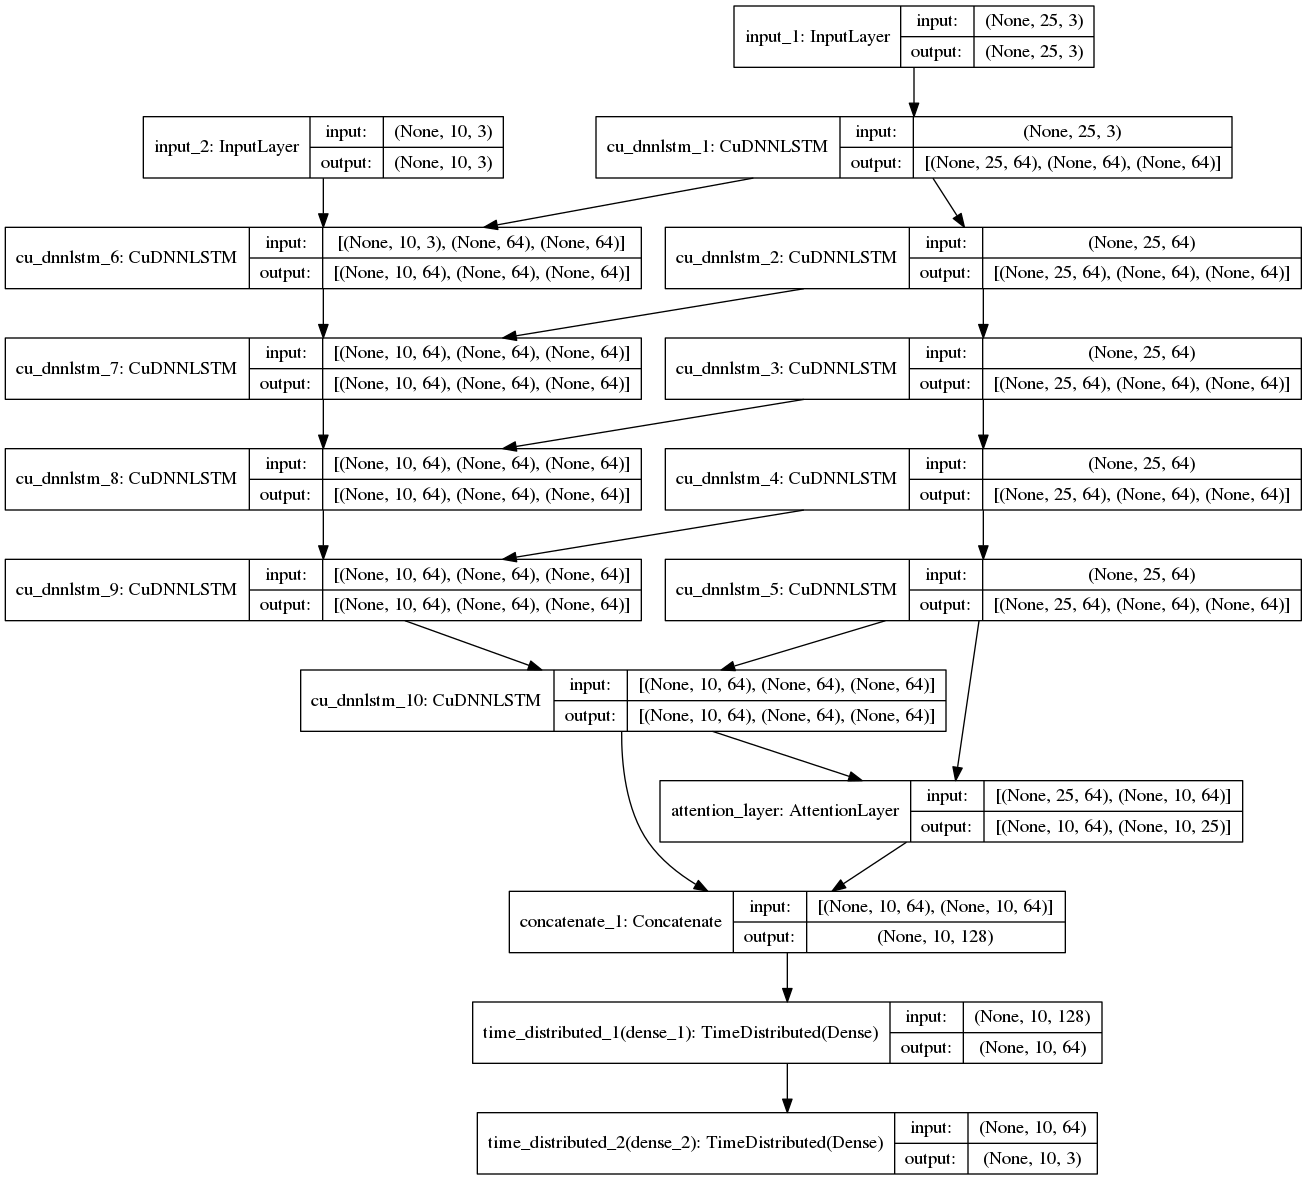

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

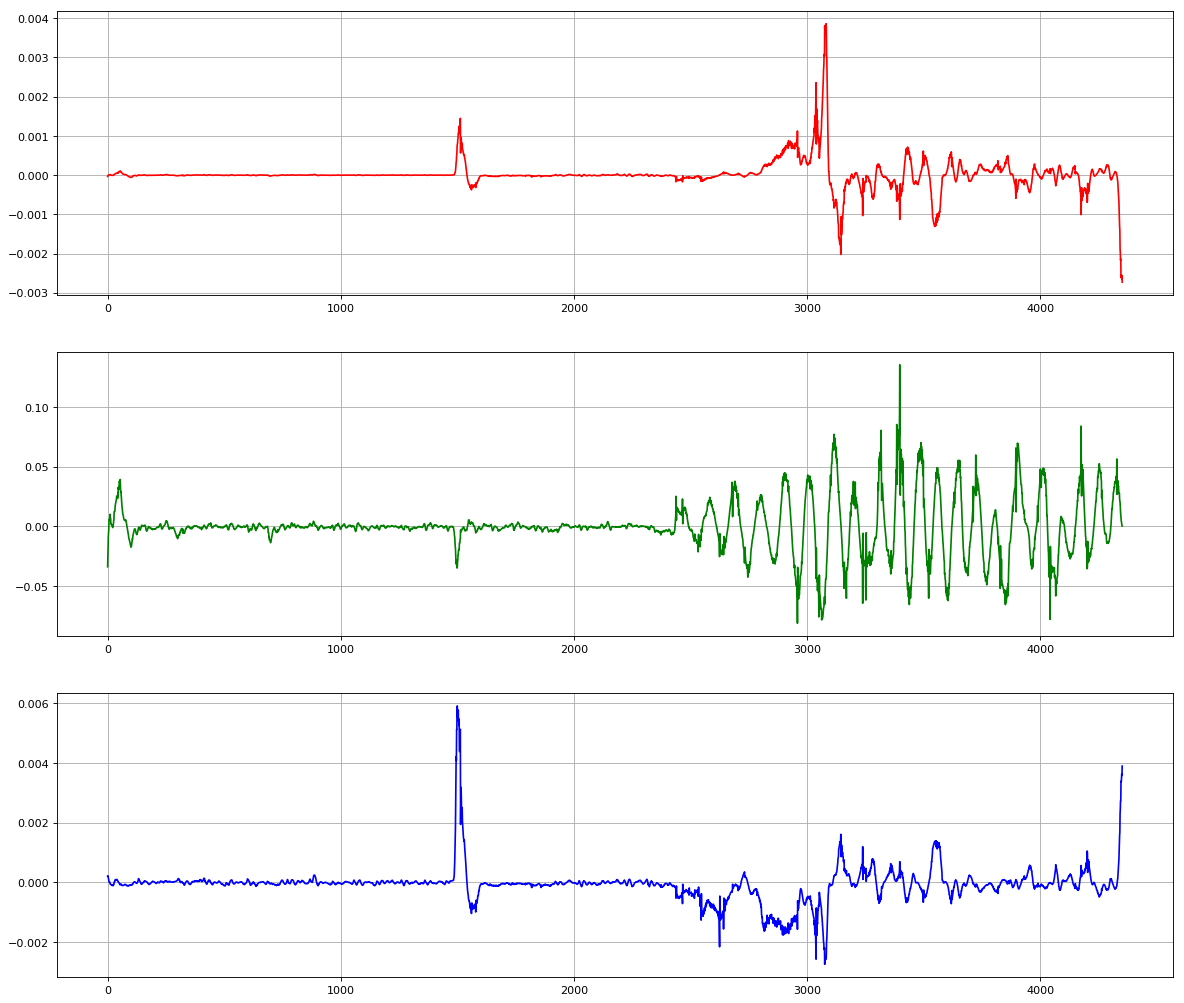

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 16:20 - loss: 0.0917 - rmse: 0.2261 - smape: 94.4056 - mfe: -4.1771e-04

  2/542 [..............................] - ETA: 8:54 - loss: 0.0747 - rmse: 0.2008 - smape: 89.9720 - mfe: 0.0012      

  3/542 [..............................] - ETA: 6:26 - loss: 0.0694 - rmse: 0.1866 - smape: 88.4132 - mfe: 0.0021

  4/542 [..............................] - ETA: 5:07 - loss: 0.0769 - rmse: 0.1926 - smape: 85.3344 - mfe: 0.0039

  5/542 [..............................] - ETA: 4:23 - loss: 0.0782 - rmse: 0.1943 - smape: 85.0554 - mfe: 0.0038

  6/542 [..............................] - ETA: 3:55 - loss: 0.0764 - rmse: 0.1904 - smape: 84.2259 - mfe: 0.0030

  7/542 [..............................] - ETA: 3:34 - loss: 0.0736 - rmse: 0.1845 - smape: 84.2113 - mfe: 0.0025

  8/542 [..............................] - ETA: 3:19 - loss: 0.0725 - rmse: 0.1789 - smape: 84.2212 - mfe: 0.0029

  9/542 [..............................] - ETA: 3:06 - loss: 0.0710 - rmse: 0.1782 - smape: 84.1690 - mfe: 0.0030

 10/542 [..............................] - ETA: 2:57 - loss: 0.0782 - rmse: 0.2008 - smape: 84.1725 - mfe: 0.0028

 11/542 [..............................] - ETA: 2:49 - loss: 0.0763 - rmse: 0.2038 - smape: 84.0760 - mfe: 0.0023

 12/542 [..............................] - ETA: 2:42 - loss: 0.0719 - rmse: 0.1904 - smape: 84.1850 - mfe: 0.0021

 13/542 [..............................] - ETA: 2:36 - loss: 0.0689 - rmse: 0.1810 - smape: 84.0206 - mfe: 0.0020

 14/542 [..............................] - ETA: 2:31 - loss: 0.0714 - rmse: 0.1858 - smape: 84.0480 - mfe: 0.0020

 15/542 [..............................] - ETA: 2:26 - loss: 0.0760 - rmse: 0.1957 - smape: 84.2854 - mfe: 0.0018

 16/542 [..............................] - ETA: 2:22 - loss: 0.0794 - rmse: 0.2034 - smape: 84.5304 - mfe: 0.0017

 17/542 [..............................] - ETA: 2:17 - loss: 0.0831 - rmse: 0.2143 - smape: 84.9479 - mfe: 0.0016

 18/542 [..............................] - ETA: 2:14 - loss: 0.0804 - rmse: 0.2080 - smape: 84.7656 - mfe: 0.0015

 19/542 [>.............................] - ETA: 2:12 - loss: 0.0813 - rmse: 0.2103 - smape: 84.7635 - mfe: 0.0014

 20/542 [>.............................] - ETA: 2:09 - loss: 0.0783 - rmse: 0.2028 - smape: 84.8118 - mfe: 0.0014

 21/542 [>.............................] - ETA: 2:07 - loss: 0.0776 - rmse: 0.2025 - smape: 84.9595 - mfe: 0.0014

 22/542 [>.............................] - ETA: 2:05 - loss: 0.0759 - rmse: 0.1983 - smape: 85.1287 - mfe: 0.0013

 23/542 [>.............................] - ETA: 2:03 - loss: 0.0754 - rmse: 0.1974 - smape: 85.2240 - mfe: 0.0012

 24/542 [>.............................] - ETA: 2:02 - loss: 0.0746 - rmse: 0.1960 - smape: 85.2737 - mfe: 0.0011

 25/542 [>.............................] - ETA: 2:00 - loss: 0.0725 - rmse: 0.1903 - smape: 85.3105 - mfe: 0.0011

 26/542 [>.............................] - ETA: 1:59 - loss: 0.0728 - rmse: 0.1931 - smape: 85.0815 - mfe: 0.0011

 27/542 [>.............................] - ETA: 1:58 - loss: 0.0732 - rmse: 0.1937 - smape: 85.1600 - mfe: 9.4171e-04

 28/542 [>.............................] - ETA: 1:56 - loss: 0.0715 - rmse: 0.1888 - smape: 85.0624 - mfe: 7.9600e-04

 29/542 [>.............................] - ETA: 1:55 - loss: 0.0718 - rmse: 0.1907 - smape: 85.0194 - mfe: 7.1328e-04

 30/542 [>.............................] - ETA: 1:54 - loss: 0.0724 - rmse: 0.1926 - smape: 85.0138 - mfe: 7.2040e-04

 31/542 [>.............................] - ETA: 1:53 - loss: 0.0736 - rmse: 0.1962 - smape: 85.0241 - mfe: 7.1395e-04

 32/542 [>.............................] - ETA: 1:52 - loss: 0.0727 - rmse: 0.1937 - smape: 85.0849 - mfe: 6.2954e-04

 33/542 [>.............................] - ETA: 1:51 - loss: 0.0722 - rmse: 0.1925 - smape: 85.1265 - mfe: 5.1004e-04

 34/542 [>.............................] - ETA: 1:49 - loss: 0.0710 - rmse: 0.1889 - smape: 85.0248 - mfe: 4.6873e-04

 35/542 [>.............................] - ETA: 1:49 - loss: 0.0710 - rmse: 0.1888 - smape: 85.0627 - mfe: 4.1042e-04

 36/542 [>.............................] - ETA: 1:47 - loss: 0.0703 - rmse: 0.1860 - smape: 85.1826 - mfe: 3.4396e-04

 37/542 [=>............................] - ETA: 1:46 - loss: 0.0698 - rmse: 0.1850 - smape: 85.2279 - mfe: 2.8146e-04

 38/542 [=>............................] - ETA: 1:45 - loss: 0.0703 - rmse: 0.1853 - smape: 85.3228 - mfe: 2.5335e-04

 39/542 [=>............................] - ETA: 1:45 - loss: 0.0708 - rmse: 0.1861 - smape: 85.3002 - mfe: 2.2971e-04

 40/542 [=>............................] - ETA: 1:44 - loss: 0.0702 - rmse: 0.1851 - smape: 85.2625 - mfe: 2.6251e-04

 41/542 [=>............................] - ETA: 1:43 - loss: 0.0693 - rmse: 0.1827 - smape: 85.2123 - mfe: 2.8217e-04

 42/542 [=>............................] - ETA: 1:43 - loss: 0.0703 - rmse: 0.1850 - smape: 85.2407 - mfe: 2.5967e-04

 43/542 [=>............................] - ETA: 1:42 - loss: 0.0707 - rmse: 0.1858 - smape: 85.3023 - mfe: 2.2875e-04

 44/542 [=>............................] - ETA: 1:42 - loss: 0.0709 - rmse: 0.1870 - smape: 85.2635 - mfe: 2.3427e-04

 45/542 [=>............................] - ETA: 1:41 - loss: 0.0705 - rmse: 0.1857 - smape: 85.3474 - mfe: 1.9277e-04

 46/542 [=>............................] - ETA: 1:41 - loss: 0.0706 - rmse: 0.1854 - smape: 85.3959 - mfe: 1.2445e-04

 47/542 [=>............................] - ETA: 1:40 - loss: 0.0701 - rmse: 0.1843 - smape: 85.3529 - mfe: 1.1207e-04

 48/542 [=>............................] - ETA: 1:40 - loss: 0.0695 - rmse: 0.1827 - smape: 85.3454 - mfe: 1.1392e-04

 49/542 [=>............................] - ETA: 1:39 - loss: 0.0703 - rmse: 0.1850 - smape: 85.3435 - mfe: 6.4895e-05

 50/542 [=>............................] - ETA: 1:39 - loss: 0.0706 - rmse: 0.1859 - smape: 85.3436 - mfe: -2.3145e-05

 51/542 [=>............................] - ETA: 1:38 - loss: 0.0708 - rmse: 0.1867 - smape: 85.2366 - mfe: -7.7391e-05

 52/542 [=>............................] - ETA: 1:38 - loss: 0.0723 - rmse: 0.1918 - smape: 85.1785 - mfe: -1.4372e-04

 53/542 [=>............................] - ETA: 1:37 - loss: 0.0718 - rmse: 0.1905 - smape: 85.1219 - mfe: -1.7603e-04

 54/542 [=>............................] - ETA: 1:37 - loss: 0.0708 - rmse: 0.1880 - smape: 84.9781 - mfe: -1.1147e-04

 55/542 [==>...........................] - ETA: 1:37 - loss: 0.0708 - rmse: 0.1876 - smape: 84.9236 - mfe: -1.7839e-05

 56/542 [==>...........................] - ETA: 1:36 - loss: 0.0702 - rmse: 0.1860 - smape: 84.8772 - mfe: 3.8277e-05 

 57/542 [==>...........................] - ETA: 1:36 - loss: 0.0699 - rmse: 0.1849 - smape: 84.8403 - mfe: 1.3736e-06

 58/542 [==>...........................] - ETA: 1:35 - loss: 0.0692 - rmse: 0.1832 - smape: 84.6841 - mfe: -1.4307e-04

 59/542 [==>...........................] - ETA: 1:35 - loss: 0.0690 - rmse: 0.1833 - smape: 84.6020 - mfe: -2.1768e-04

 60/542 [==>...........................] - ETA: 1:35 - loss: 0.0691 - rmse: 0.1837 - smape: 84.5515 - mfe: -2.8091e-04

 61/542 [==>...........................] - ETA: 1:34 - loss: 0.0692 - rmse: 0.1842 - smape: 84.5161 - mfe: -2.8717e-04

 62/542 [==>...........................] - ETA: 1:34 - loss: 0.0686 - rmse: 0.1827 - smape: 84.5362 - mfe: -2.8492e-04

 63/542 [==>...........................] - ETA: 1:34 - loss: 0.0695 - rmse: 0.1847 - smape: 84.4757 - mfe: -2.3561e-04

 64/542 [==>...........................] - ETA: 1:33 - loss: 0.0695 - rmse: 0.1844 - smape: 84.4079 - mfe: -2.1284e-04

 65/542 [==>...........................] - ETA: 1:33 - loss: 0.0699 - rmse: 0.1858 - smape: 84.3531 - mfe: -2.2003e-04

 66/542 [==>...........................] - ETA: 1:32 - loss: 0.0694 - rmse: 0.1844 - smape: 84.2527 - mfe: -2.0425e-04

 67/542 [==>...........................] - ETA: 1:32 - loss: 0.0691 - rmse: 0.1837 - smape: 84.2090 - mfe: -2.7523e-04

 68/542 [==>...........................] - ETA: 1:32 - loss: 0.0694 - rmse: 0.1840 - smape: 84.1375 - mfe: -3.8996e-04

 69/542 [==>...........................] - ETA: 1:31 - loss: 0.0693 - rmse: 0.1839 - smape: 84.0713 - mfe: -4.3023e-04

 70/542 [==>...........................] - ETA: 1:31 - loss: 0.0689 - rmse: 0.1825 - smape: 84.0333 - mfe: -3.7099e-04

 71/542 [==>...........................] - ETA: 1:31 - loss: 0.0690 - rmse: 0.1831 - smape: 84.0051 - mfe: -2.8164e-04

 72/542 [==>...........................] - ETA: 1:30 - loss: 0.0688 - rmse: 0.1825 - smape: 83.9056 - mfe: -2.5766e-04

 73/542 [===>..........................] - ETA: 1:30 - loss: 0.0687 - rmse: 0.1827 - smape: 83.8918 - mfe: -2.5562e-04

 74/542 [===>..........................] - ETA: 1:30 - loss: 0.0691 - rmse: 0.1839 - smape: 83.8886 - mfe: -2.4277e-04

 75/542 [===>..........................] - ETA: 1:29 - loss: 0.0688 - rmse: 0.1837 - smape: 83.8680 - mfe: -2.2968e-04

 76/542 [===>..........................] - ETA: 1:29 - loss: 0.0688 - rmse: 0.1838 - smape: 83.8647 - mfe: -1.8167e-04

 77/542 [===>..........................] - ETA: 1:29 - loss: 0.0687 - rmse: 0.1837 - smape: 83.8324 - mfe: -1.4274e-04

 78/542 [===>..........................] - ETA: 1:29 - loss: 0.0683 - rmse: 0.1828 - smape: 83.7463 - mfe: -1.3992e-04

 79/542 [===>..........................] - ETA: 1:28 - loss: 0.0686 - rmse: 0.1842 - smape: 83.6799 - mfe: -1.2956e-04

 80/542 [===>..........................] - ETA: 1:28 - loss: 0.0686 - rmse: 0.1842 - smape: 83.6658 - mfe: -1.4181e-04

 81/542 [===>..........................] - ETA: 1:28 - loss: 0.0689 - rmse: 0.1851 - smape: 83.6835 - mfe: -1.4179e-04

 82/542 [===>..........................] - ETA: 1:27 - loss: 0.0687 - rmse: 0.1851 - smape: 83.6472 - mfe: -1.3411e-04

 83/542 [===>..........................] - ETA: 1:27 - loss: 0.0694 - rmse: 0.1866 - smape: 83.6191 - mfe: -1.3392e-04

 84/542 [===>..........................] - ETA: 1:27 - loss: 0.0702 - rmse: 0.1895 - smape: 83.5619 - mfe: -1.0814e-04

 85/542 [===>..........................] - ETA: 1:26 - loss: 0.0703 - rmse: 0.1899 - smape: 83.5271 - mfe: -1.4508e-04

 86/542 [===>..........................] - ETA: 1:26 - loss: 0.0710 - rmse: 0.1921 - smape: 83.4989 - mfe: -1.0468e-04

 87/542 [===>..........................] - ETA: 1:26 - loss: 0.0715 - rmse: 0.1936 - smape: 83.4770 - mfe: -1.0616e-04

 88/542 [===>..........................] - ETA: 1:26 - loss: 0.0715 - rmse: 0.1944 - smape: 83.4476 - mfe: -1.3160e-04

 89/542 [===>..........................] - ETA: 1:25 - loss: 0.0712 - rmse: 0.1935 - smape: 83.3930 - mfe: -1.1754e-04

 90/542 [===>..........................] - ETA: 1:25 - loss: 0.0709 - rmse: 0.1927 - smape: 83.3911 - mfe: -1.5670e-04

 91/542 [====>.........................] - ETA: 1:24 - loss: 0.0704 - rmse: 0.1912 - smape: 83.3845 - mfe: -1.9785e-04

 92/542 [====>.........................] - ETA: 1:24 - loss: 0.0703 - rmse: 0.1907 - smape: 83.3908 - mfe: -2.0842e-04

 93/542 [====>.........................] - ETA: 1:24 - loss: 0.0697 - rmse: 0.1891 - smape: 83.3816 - mfe: -1.8971e-04

 94/542 [====>.........................] - ETA: 1:24 - loss: 0.0696 - rmse: 0.1891 - smape: 83.3732 - mfe: -1.9571e-04

 95/542 [====>.........................] - ETA: 1:23 - loss: 0.0691 - rmse: 0.1876 - smape: 83.3762 - mfe: -2.0356e-04

 96/542 [====>.........................] - ETA: 1:23 - loss: 0.0691 - rmse: 0.1876 - smape: 83.3720 - mfe: -2.2166e-04

 97/542 [====>.........................] - ETA: 1:23 - loss: 0.0690 - rmse: 0.1870 - smape: 83.3756 - mfe: -2.4603e-04

 98/542 [====>.........................] - ETA: 1:23 - loss: 0.0689 - rmse: 0.1869 - smape: 83.3278 - mfe: -2.4999e-04

 99/542 [====>.........................] - ETA: 1:23 - loss: 0.0689 - rmse: 0.1869 - smape: 83.3342 - mfe: -2.7438e-04

100/542 [====>.........................] - ETA: 1:22 - loss: 0.0690 - rmse: 0.1867 - smape: 83.3181 - mfe: -2.9688e-04

101/542 [====>.........................] - ETA: 1:22 - loss: 0.0689 - rmse: 0.1865 - smape: 83.2549 - mfe: -2.9806e-04

102/542 [====>.........................] - ETA: 1:22 - loss: 0.0684 - rmse: 0.1851 - smape: 83.2514 - mfe: -3.2824e-04

103/542 [====>.........................] - ETA: 1:22 - loss: 0.0683 - rmse: 0.1849 - smape: 83.2664 - mfe: -3.4140e-04

104/542 [====>.........................] - ETA: 1:22 - loss: 0.0678 - rmse: 0.1834 - smape: 83.2427 - mfe: -3.4377e-04

105/542 [====>.........................] - ETA: 1:21 - loss: 0.0675 - rmse: 0.1828 - smape: 83.2441 - mfe: -3.2119e-04

106/542 [====>.........................] - ETA: 1:21 - loss: 0.0671 - rmse: 0.1820 - smape: 83.2278 - mfe: -2.9031e-04

107/542 [====>.........................] - ETA: 1:21 - loss: 0.0678 - rmse: 0.1833 - smape: 83.2325 - mfe: -2.9175e-04

108/542 [====>.........................] - ETA: 1:21 - loss: 0.0680 - rmse: 0.1839 - smape: 83.2204 - mfe: -3.2813e-04

109/542 [=====>........................] - ETA: 1:20 - loss: 0.0682 - rmse: 0.1841 - smape: 83.2017 - mfe: -3.8370e-04

110/542 [=====>........................] - ETA: 1:20 - loss: 0.0678 - rmse: 0.1833 - smape: 83.1841 - mfe: -3.9361e-04

111/542 [=====>........................] - ETA: 1:20 - loss: 0.0675 - rmse: 0.1824 - smape: 83.1867 - mfe: -3.6602e-04

112/542 [=====>........................] - ETA: 1:20 - loss: 0.0674 - rmse: 0.1820 - smape: 83.1633 - mfe: -3.2178e-04

113/542 [=====>........................] - ETA: 1:19 - loss: 0.0671 - rmse: 0.1814 - smape: 83.1267 - mfe: -2.8329e-04

114/542 [=====>........................] - ETA: 1:19 - loss: 0.0674 - rmse: 0.1827 - smape: 83.0959 - mfe: -2.7640e-04

115/542 [=====>........................] - ETA: 1:19 - loss: 0.0670 - rmse: 0.1819 - smape: 83.0845 - mfe: -3.0163e-04

116/542 [=====>........................] - ETA: 1:19 - loss: 0.0669 - rmse: 0.1817 - smape: 83.0915 - mfe: -3.2117e-04

117/542 [=====>........................] - ETA: 1:18 - loss: 0.0668 - rmse: 0.1819 - smape: 83.0596 - mfe: -3.4410e-04

118/542 [=====>........................] - ETA: 1:18 - loss: 0.0670 - rmse: 0.1822 - smape: 83.0699 - mfe: -3.4731e-04

119/542 [=====>........................] - ETA: 1:18 - loss: 0.0673 - rmse: 0.1829 - smape: 83.0778 - mfe: -3.4829e-04

120/542 [=====>........................] - ETA: 1:17 - loss: 0.0670 - rmse: 0.1820 - smape: 83.0975 - mfe: -3.4307e-04

121/542 [=====>........................] - ETA: 1:17 - loss: 0.0671 - rmse: 0.1823 - smape: 83.0868 - mfe: -3.1405e-04

122/542 [=====>........................] - ETA: 1:17 - loss: 0.0673 - rmse: 0.1828 - smape: 83.0910 - mfe: -2.8998e-04

123/542 [=====>........................] - ETA: 1:17 - loss: 0.0673 - rmse: 0.1828 - smape: 83.0950 - mfe: -2.7389e-04

124/542 [=====>........................] - ETA: 1:17 - loss: 0.0671 - rmse: 0.1822 - smape: 83.1022 - mfe: -2.6486e-04

125/542 [=====>........................] - ETA: 1:16 - loss: 0.0670 - rmse: 0.1815 - smape: 83.1487 - mfe: -2.4839e-04

126/542 [=====>........................] - ETA: 1:16 - loss: 0.0671 - rmse: 0.1822 - smape: 83.1450 - mfe: -2.4390e-04

127/542 [======>.......................] - ETA: 1:16 - loss: 0.0670 - rmse: 0.1819 - smape: 83.1666 - mfe: -2.5891e-04

128/542 [======>.......................] - ETA: 1:16 - loss: 0.0668 - rmse: 0.1812 - smape: 83.1884 - mfe: -2.5600e-04

129/542 [======>.......................] - ETA: 1:16 - loss: 0.0668 - rmse: 0.1812 - smape: 83.1869 - mfe: -2.6086e-04

130/542 [======>.......................] - ETA: 1:16 - loss: 0.0672 - rmse: 0.1822 - smape: 83.1975 - mfe: -2.6369e-04

131/542 [======>.......................] - ETA: 1:15 - loss: 0.0668 - rmse: 0.1811 - smape: 83.2163 - mfe: -2.5393e-04

132/542 [======>.......................] - ETA: 1:15 - loss: 0.0669 - rmse: 0.1810 - smape: 83.2576 - mfe: -2.6511e-04

133/542 [======>.......................] - ETA: 1:15 - loss: 0.0672 - rmse: 0.1818 - smape: 83.2497 - mfe: -2.7266e-04

134/542 [======>.......................] - ETA: 1:15 - loss: 0.0672 - rmse: 0.1820 - smape: 83.2207 - mfe: -2.6379e-04

135/542 [======>.......................] - ETA: 1:14 - loss: 0.0673 - rmse: 0.1821 - smape: 83.2155 - mfe: -2.6970e-04

136/542 [======>.......................] - ETA: 1:14 - loss: 0.0675 - rmse: 0.1823 - smape: 83.2099 - mfe: -2.7749e-04

137/542 [======>.......................] - ETA: 1:14 - loss: 0.0675 - rmse: 0.1821 - smape: 83.1840 - mfe: -2.7099e-04

138/542 [======>.......................] - ETA: 1:14 - loss: 0.0676 - rmse: 0.1823 - smape: 83.1611 - mfe: -2.2560e-04

139/542 [======>.......................] - ETA: 1:13 - loss: 0.0675 - rmse: 0.1820 - smape: 83.1813 - mfe: -2.0760e-04

140/542 [======>.......................] - ETA: 1:13 - loss: 0.0675 - rmse: 0.1817 - smape: 83.2032 - mfe: -2.1550e-04

141/542 [======>.......................] - ETA: 1:13 - loss: 0.0678 - rmse: 0.1825 - smape: 83.2049 - mfe: -2.1977e-04

142/542 [======>.......................] - ETA: 1:13 - loss: 0.0677 - rmse: 0.1822 - smape: 83.2053 - mfe: -2.3967e-04

143/542 [======>.......................] - ETA: 1:13 - loss: 0.0678 - rmse: 0.1827 - smape: 83.1998 - mfe: -2.4782e-04

144/542 [======>.......................] - ETA: 1:12 - loss: 0.0679 - rmse: 0.1831 - smape: 83.1886 - mfe: -2.6979e-04

145/542 [=======>......................] - ETA: 1:12 - loss: 0.0676 - rmse: 0.1824 - smape: 83.1837 - mfe: -2.7280e-04

146/542 [=======>......................] - ETA: 1:12 - loss: 0.0675 - rmse: 0.1823 - smape: 83.1813 - mfe: -2.8498e-04

147/542 [=======>......................] - ETA: 1:12 - loss: 0.0675 - rmse: 0.1824 - smape: 83.1755 - mfe: -3.1057e-04

148/542 [=======>......................] - ETA: 1:11 - loss: 0.0673 - rmse: 0.1823 - smape: 83.1651 - mfe: -3.3403e-04

149/542 [=======>......................] - ETA: 1:11 - loss: 0.0673 - rmse: 0.1822 - smape: 83.1932 - mfe: -3.4095e-04

150/542 [=======>......................] - ETA: 1:11 - loss: 0.0673 - rmse: 0.1820 - smape: 83.1982 - mfe: -3.3811e-04

151/542 [=======>......................] - ETA: 1:11 - loss: 0.0672 - rmse: 0.1820 - smape: 83.2279 - mfe: -3.3260e-04

152/542 [=======>......................] - ETA: 1:11 - loss: 0.0671 - rmse: 0.1814 - smape: 83.2454 - mfe: -3.3096e-04

153/542 [=======>......................] - ETA: 1:10 - loss: 0.0671 - rmse: 0.1821 - smape: 83.2442 - mfe: -3.1360e-04

154/542 [=======>......................] - ETA: 1:10 - loss: 0.0672 - rmse: 0.1822 - smape: 83.2831 - mfe: -3.1397e-04

155/542 [=======>......................] - ETA: 1:10 - loss: 0.0673 - rmse: 0.1823 - smape: 83.3032 - mfe: -3.1255e-04

156/542 [=======>......................] - ETA: 1:10 - loss: 0.0673 - rmse: 0.1824 - smape: 83.3137 - mfe: -3.2681e-04

157/542 [=======>......................] - ETA: 1:09 - loss: 0.0672 - rmse: 0.1821 - smape: 83.2931 - mfe: -3.3826e-04

158/542 [=======>......................] - ETA: 1:09 - loss: 0.0669 - rmse: 0.1814 - smape: 83.2560 - mfe: -3.3806e-04

159/542 [=======>......................] - ETA: 1:09 - loss: 0.0666 - rmse: 0.1804 - smape: 83.2221 - mfe: -3.4520e-04

160/542 [=======>......................] - ETA: 1:09 - loss: 0.0665 - rmse: 0.1804 - smape: 83.2215 - mfe: -3.4509e-04

161/542 [=======>......................] - ETA: 1:09 - loss: 0.0665 - rmse: 0.1805 - smape: 83.2141 - mfe: -3.3096e-04

162/542 [=======>......................] - ETA: 1:08 - loss: 0.0663 - rmse: 0.1803 - smape: 83.2193 - mfe: -3.1561e-04

163/542 [========>.....................] - ETA: 1:08 - loss: 0.0664 - rmse: 0.1803 - smape: 83.1974 - mfe: -3.3747e-04

164/542 [========>.....................] - ETA: 1:08 - loss: 0.0666 - rmse: 0.1811 - smape: 83.1654 - mfe: -3.6305e-04

165/542 [========>.....................] - ETA: 1:08 - loss: 0.0663 - rmse: 0.1803 - smape: 83.1509 - mfe: -3.6945e-04

166/542 [========>.....................] - ETA: 1:08 - loss: 0.0661 - rmse: 0.1799 - smape: 83.1276 - mfe: -3.5476e-04

167/542 [========>.....................] - ETA: 1:07 - loss: 0.0662 - rmse: 0.1801 - smape: 83.1263 - mfe: -3.6629e-04

168/542 [========>.....................] - ETA: 1:07 - loss: 0.0661 - rmse: 0.1797 - smape: 83.1134 - mfe: -3.8225e-04

169/542 [========>.....................] - ETA: 1:07 - loss: 0.0661 - rmse: 0.1798 - smape: 83.0989 - mfe: -3.9611e-04

170/542 [========>.....................] - ETA: 1:07 - loss: 0.0660 - rmse: 0.1798 - smape: 83.1045 - mfe: -3.9286e-04

171/542 [========>.....................] - ETA: 1:07 - loss: 0.0660 - rmse: 0.1796 - smape: 83.1107 - mfe: -3.8287e-04

172/542 [========>.....................] - ETA: 1:06 - loss: 0.0658 - rmse: 0.1791 - smape: 83.1129 - mfe: -3.6218e-04

173/542 [========>.....................] - ETA: 1:06 - loss: 0.0656 - rmse: 0.1787 - smape: 83.1057 - mfe: -3.4619e-04

174/542 [========>.....................] - ETA: 1:06 - loss: 0.0658 - rmse: 0.1790 - smape: 83.1220 - mfe: -3.2891e-04

175/542 [========>.....................] - ETA: 1:06 - loss: 0.0659 - rmse: 0.1792 - smape: 83.1430 - mfe: -3.1585e-04

176/542 [========>.....................] - ETA: 1:06 - loss: 0.0658 - rmse: 0.1789 - smape: 83.1501 - mfe: -3.1068e-04

177/542 [========>.....................] - ETA: 1:05 - loss: 0.0656 - rmse: 0.1781 - smape: 83.1626 - mfe: -3.1493e-04

178/542 [========>.....................] - ETA: 1:05 - loss: 0.0654 - rmse: 0.1778 - smape: 83.1514 - mfe: -3.1631e-04

179/542 [========>.....................] - ETA: 1:05 - loss: 0.0651 - rmse: 0.1770 - smape: 83.1313 - mfe: -3.1897e-04

180/542 [========>.....................] - ETA: 1:05 - loss: 0.0648 - rmse: 0.1762 - smape: 83.1182 - mfe: -3.1733e-04

181/542 [=========>....................] - ETA: 1:05 - loss: 0.0647 - rmse: 0.1759 - smape: 83.1177 - mfe: -3.1444e-04

182/542 [=========>....................] - ETA: 1:04 - loss: 0.0646 - rmse: 0.1757 - smape: 83.1172 - mfe: -3.0889e-04

183/542 [=========>....................] - ETA: 1:04 - loss: 0.0649 - rmse: 0.1763 - smape: 83.1088 - mfe: -2.7558e-04

184/542 [=========>....................] - ETA: 1:04 - loss: 0.0649 - rmse: 0.1763 - smape: 83.1003 - mfe: -2.6335e-04

185/542 [=========>....................] - ETA: 1:04 - loss: 0.0651 - rmse: 0.1769 - smape: 83.0997 - mfe: -2.3292e-04

186/542 [=========>....................] - ETA: 1:04 - loss: 0.0649 - rmse: 0.1764 - smape: 83.0956 - mfe: -2.3139e-04

187/542 [=========>....................] - ETA: 1:03 - loss: 0.0650 - rmse: 0.1766 - smape: 83.1027 - mfe: -2.1303e-04

188/542 [=========>....................] - ETA: 1:03 - loss: 0.0649 - rmse: 0.1762 - smape: 83.1056 - mfe: -2.0639e-04

189/542 [=========>....................] - ETA: 1:03 - loss: 0.0649 - rmse: 0.1763 - smape: 83.0955 - mfe: -1.8922e-04

190/542 [=========>....................] - ETA: 1:03 - loss: 0.0648 - rmse: 0.1760 - smape: 83.0867 - mfe: -1.9018e-04

191/542 [=========>....................] - ETA: 1:03 - loss: 0.0649 - rmse: 0.1761 - smape: 83.0797 - mfe: -1.7704e-04

192/542 [=========>....................] - ETA: 1:02 - loss: 0.0650 - rmse: 0.1763 - smape: 83.0772 - mfe: -1.6802e-04

193/542 [=========>....................] - ETA: 1:02 - loss: 0.0649 - rmse: 0.1764 - smape: 83.0606 - mfe: -1.6074e-04

194/542 [=========>....................] - ETA: 1:02 - loss: 0.0652 - rmse: 0.1770 - smape: 83.0554 - mfe: -1.6254e-04

195/542 [=========>....................] - ETA: 1:02 - loss: 0.0651 - rmse: 0.1770 - smape: 83.0567 - mfe: -1.6217e-04

196/542 [=========>....................] - ETA: 1:02 - loss: 0.0652 - rmse: 0.1772 - smape: 83.0532 - mfe: -1.5603e-04

197/542 [=========>....................] - ETA: 1:01 - loss: 0.0650 - rmse: 0.1766 - smape: 83.0519 - mfe: -1.5440e-04

198/542 [=========>....................] - ETA: 1:01 - loss: 0.0649 - rmse: 0.1764 - smape: 83.0519 - mfe: -1.5500e-04

199/542 [==========>...................] - ETA: 1:01 - loss: 0.0650 - rmse: 0.1764 - smape: 83.0412 - mfe: -1.6607e-04

200/542 [==========>...................] - ETA: 1:01 - loss: 0.0648 - rmse: 0.1763 - smape: 83.0058 - mfe: -1.6877e-04

201/542 [==========>...................] - ETA: 1:01 - loss: 0.0648 - rmse: 0.1762 - smape: 83.0022 - mfe: -1.8132e-04

202/542 [==========>...................] - ETA: 1:01 - loss: 0.0647 - rmse: 0.1758 - smape: 82.9903 - mfe: -1.7684e-04

203/542 [==========>...................] - ETA: 1:00 - loss: 0.0646 - rmse: 0.1757 - smape: 82.9615 - mfe: -1.8062e-04

204/542 [==========>...................] - ETA: 1:00 - loss: 0.0646 - rmse: 0.1756 - smape: 82.9683 - mfe: -1.8283e-04

205/542 [==========>...................] - ETA: 1:00 - loss: 0.0646 - rmse: 0.1756 - smape: 82.9727 - mfe: -1.8409e-04

206/542 [==========>...................] - ETA: 1:00 - loss: 0.0644 - rmse: 0.1753 - smape: 82.9553 - mfe: -1.8356e-04

207/542 [==========>...................] - ETA: 1:00 - loss: 0.0644 - rmse: 0.1753 - smape: 82.9571 - mfe: -1.7854e-04

208/542 [==========>...................] - ETA: 59s - loss: 0.0644 - rmse: 0.1753 - smape: 82.9384 - mfe: -1.7880e-04 

209/542 [==========>...................] - ETA: 59s - loss: 0.0644 - rmse: 0.1753 - smape: 82.9257 - mfe: -1.8108e-04

210/542 [==========>...................] - ETA: 59s - loss: 0.0647 - rmse: 0.1759 - smape: 82.9207 - mfe: -1.7631e-04

211/542 [==========>...................] - ETA: 59s - loss: 0.0648 - rmse: 0.1761 - smape: 82.9030 - mfe: -1.5742e-04

212/542 [==========>...................] - ETA: 59s - loss: 0.0646 - rmse: 0.1754 - smape: 82.8797 - mfe: -1.2661e-04

213/542 [==========>...................] - ETA: 58s - loss: 0.0644 - rmse: 0.1750 - smape: 82.8717 - mfe: -1.4730e-04

214/542 [==========>...................] - ETA: 58s - loss: 0.0642 - rmse: 0.1745 - smape: 82.8700 - mfe: -1.6306e-04

215/542 [==========>...................] - ETA: 58s - loss: 0.0644 - rmse: 0.1749 - smape: 82.8533 - mfe: -1.6239e-04

216/542 [==========>...................] - ETA: 58s - loss: 0.0645 - rmse: 0.1752 - smape: 82.8464 - mfe: -1.4492e-04

217/542 [===========>..................] - ETA: 58s - loss: 0.0644 - rmse: 0.1750 - smape: 82.8314 - mfe: -1.0512e-04

218/542 [===========>..................] - ETA: 57s - loss: 0.0644 - rmse: 0.1751 - smape: 82.8184 - mfe: -9.1032e-05

219/542 [===========>..................] - ETA: 57s - loss: 0.0643 - rmse: 0.1749 - smape: 82.8112 - mfe: -8.7619e-05

220/542 [===========>..................] - ETA: 57s - loss: 0.0644 - rmse: 0.1750 - smape: 82.7944 - mfe: -1.0100e-04

221/542 [===========>..................] - ETA: 57s - loss: 0.0643 - rmse: 0.1748 - smape: 82.7912 - mfe: -1.2058e-04

222/542 [===========>..................] - ETA: 57s - loss: 0.0642 - rmse: 0.1745 - smape: 82.7640 - mfe: -1.3499e-04

223/542 [===========>..................] - ETA: 56s - loss: 0.0639 - rmse: 0.1740 - smape: 82.7463 - mfe: -1.2264e-04

224/542 [===========>..................] - ETA: 56s - loss: 0.0639 - rmse: 0.1741 - smape: 82.7360 - mfe: -1.1729e-04

225/542 [===========>..................] - ETA: 56s - loss: 0.0639 - rmse: 0.1740 - smape: 82.7409 - mfe: -1.0750e-04

226/542 [===========>..................] - ETA: 56s - loss: 0.0638 - rmse: 0.1737 - smape: 82.7305 - mfe: -9.7728e-05

227/542 [===========>..................] - ETA: 56s - loss: 0.0637 - rmse: 0.1736 - smape: 82.7185 - mfe: -8.4132e-05

228/542 [===========>..................] - ETA: 56s - loss: 0.0639 - rmse: 0.1741 - smape: 82.7148 - mfe: -6.7807e-05

229/542 [===========>..................] - ETA: 55s - loss: 0.0639 - rmse: 0.1742 - smape: 82.7069 - mfe: -4.9951e-05

230/542 [===========>..................] - ETA: 55s - loss: 0.0639 - rmse: 0.1740 - smape: 82.7000 - mfe: -3.0545e-05

231/542 [===========>..................] - ETA: 55s - loss: 0.0638 - rmse: 0.1739 - smape: 82.7001 - mfe: -2.0253e-05

232/542 [===========>..................] - ETA: 55s - loss: 0.0637 - rmse: 0.1735 - smape: 82.6885 - mfe: -2.0803e-05

233/542 [===========>..................] - ETA: 55s - loss: 0.0636 - rmse: 0.1732 - smape: 82.6976 - mfe: -3.1590e-05

234/542 [===========>..................] - ETA: 54s - loss: 0.0636 - rmse: 0.1733 - smape: 82.6970 - mfe: -4.3322e-05

235/542 [============>.................] - ETA: 54s - loss: 0.0634 - rmse: 0.1730 - smape: 82.6790 - mfe: -5.0810e-05

236/542 [============>.................] - ETA: 54s - loss: 0.0633 - rmse: 0.1730 - smape: 82.6590 - mfe: -4.2498e-05

237/542 [============>.................] - ETA: 54s - loss: 0.0634 - rmse: 0.1730 - smape: 82.6627 - mfe: -5.1366e-05

238/542 [============>.................] - ETA: 54s - loss: 0.0634 - rmse: 0.1732 - smape: 82.6578 - mfe: -5.7989e-05

239/542 [============>.................] - ETA: 53s - loss: 0.0634 - rmse: 0.1731 - smape: 82.6635 - mfe: -5.9358e-05

240/542 [============>.................] - ETA: 53s - loss: 0.0637 - rmse: 0.1738 - smape: 82.6617 - mfe: -5.0270e-05

241/542 [============>.................] - ETA: 53s - loss: 0.0636 - rmse: 0.1735 - smape: 82.6691 - mfe: -6.0346e-05

242/542 [============>.................] - ETA: 53s - loss: 0.0636 - rmse: 0.1734 - smape: 82.6746 - mfe: -7.1824e-05

243/542 [============>.................] - ETA: 53s - loss: 0.0635 - rmse: 0.1732 - smape: 82.6689 - mfe: -7.2643e-05

244/542 [============>.................] - ETA: 53s - loss: 0.0635 - rmse: 0.1731 - smape: 82.6633 - mfe: -6.9583e-05

245/542 [============>.................] - ETA: 52s - loss: 0.0636 - rmse: 0.1732 - smape: 82.6574 - mfe: -7.0672e-05

246/542 [============>.................] - ETA: 52s - loss: 0.0636 - rmse: 0.1735 - smape: 82.6659 - mfe: -6.3826e-05

247/542 [============>.................] - ETA: 52s - loss: 0.0634 - rmse: 0.1730 - smape: 82.6628 - mfe: -6.2197e-05

248/542 [============>.................] - ETA: 52s - loss: 0.0635 - rmse: 0.1731 - smape: 82.6679 - mfe: -6.9164e-05

249/542 [============>.................] - ETA: 52s - loss: 0.0636 - rmse: 0.1735 - smape: 82.6690 - mfe: -8.2150e-05

250/542 [============>.................] - ETA: 51s - loss: 0.0636 - rmse: 0.1734 - smape: 82.6519 - mfe: -9.5565e-05

251/542 [============>.................] - ETA: 51s - loss: 0.0636 - rmse: 0.1735 - smape: 82.6513 - mfe: -1.0400e-04

252/542 [============>.................] - ETA: 51s - loss: 0.0634 - rmse: 0.1732 - smape: 82.6489 - mfe: -1.0726e-04

253/542 [=============>................] - ETA: 51s - loss: 0.0634 - rmse: 0.1733 - smape: 82.6423 - mfe: -9.0691e-05

254/542 [=============>................] - ETA: 51s - loss: 0.0633 - rmse: 0.1731 - smape: 82.6354 - mfe: -8.4110e-05

255/542 [=============>................] - ETA: 51s - loss: 0.0633 - rmse: 0.1730 - smape: 82.6292 - mfe: -7.2379e-05

256/542 [=============>................] - ETA: 50s - loss: 0.0633 - rmse: 0.1731 - smape: 82.6135 - mfe: -5.7330e-05

257/542 [=============>................] - ETA: 50s - loss: 0.0632 - rmse: 0.1728 - smape: 82.6044 - mfe: -5.0496e-05

258/542 [=============>................] - ETA: 50s - loss: 0.0631 - rmse: 0.1727 - smape: 82.5894 - mfe: -4.6386e-05

259/542 [=============>................] - ETA: 50s - loss: 0.0629 - rmse: 0.1723 - smape: 82.5674 - mfe: -3.9454e-05

260/542 [=============>................] - ETA: 50s - loss: 0.0629 - rmse: 0.1722 - smape: 82.5644 - mfe: -4.0778e-05

261/542 [=============>................] - ETA: 49s - loss: 0.0630 - rmse: 0.1726 - smape: 82.5631 - mfe: -4.0446e-05

262/542 [=============>................] - ETA: 49s - loss: 0.0631 - rmse: 0.1728 - smape: 82.5603 - mfe: -4.7440e-05

263/542 [=============>................] - ETA: 49s - loss: 0.0631 - rmse: 0.1728 - smape: 82.5686 - mfe: -4.8110e-05

264/542 [=============>................] - ETA: 49s - loss: 0.0631 - rmse: 0.1727 - smape: 82.5682 - mfe: -4.8682e-05

265/542 [=============>................] - ETA: 49s - loss: 0.0631 - rmse: 0.1728 - smape: 82.5782 - mfe: -4.3968e-05

266/542 [=============>................] - ETA: 48s - loss: 0.0633 - rmse: 0.1731 - smape: 82.5734 - mfe: -4.3749e-05

267/542 [=============>................] - ETA: 48s - loss: 0.0632 - rmse: 0.1727 - smape: 82.5790 - mfe: -4.1275e-05

268/542 [=============>................] - ETA: 48s - loss: 0.0630 - rmse: 0.1722 - smape: 82.5593 - mfe: -4.2614e-05

269/542 [=============>................] - ETA: 48s - loss: 0.0633 - rmse: 0.1729 - smape: 82.5359 - mfe: -5.2173e-05

270/542 [=============>................] - ETA: 48s - loss: 0.0632 - rmse: 0.1728 - smape: 82.5053 - mfe: -7.7427e-05

271/542 [==============>...............] - ETA: 48s - loss: 0.0631 - rmse: 0.1728 - smape: 82.4952 - mfe: -8.1717e-05

272/542 [==============>...............] - ETA: 47s - loss: 0.0631 - rmse: 0.1726 - smape: 82.4862 - mfe: -7.6509e-05

273/542 [==============>...............] - ETA: 47s - loss: 0.0631 - rmse: 0.1725 - smape: 82.4778 - mfe: -5.9236e-05

274/542 [==============>...............] - ETA: 47s - loss: 0.0630 - rmse: 0.1723 - smape: 82.4719 - mfe: -4.9703e-05

275/542 [==============>...............] - ETA: 47s - loss: 0.0631 - rmse: 0.1726 - smape: 82.4619 - mfe: -4.0467e-05

276/542 [==============>...............] - ETA: 47s - loss: 0.0630 - rmse: 0.1726 - smape: 82.4600 - mfe: -3.8908e-05

277/542 [==============>...............] - ETA: 47s - loss: 0.0630 - rmse: 0.1724 - smape: 82.4670 - mfe: -4.0289e-05

278/542 [==============>...............] - ETA: 46s - loss: 0.0629 - rmse: 0.1722 - smape: 82.4702 - mfe: -4.2661e-05

279/542 [==============>...............] - ETA: 46s - loss: 0.0628 - rmse: 0.1722 - smape: 82.4636 - mfe: -4.5682e-05

280/542 [==============>...............] - ETA: 46s - loss: 0.0628 - rmse: 0.1721 - smape: 82.4737 - mfe: -4.3030e-05

281/542 [==============>...............] - ETA: 46s - loss: 0.0627 - rmse: 0.1719 - smape: 82.4750 - mfe: -4.1615e-05

282/542 [==============>...............] - ETA: 46s - loss: 0.0627 - rmse: 0.1719 - smape: 82.4798 - mfe: -3.5900e-05

283/542 [==============>...............] - ETA: 45s - loss: 0.0626 - rmse: 0.1718 - smape: 82.4857 - mfe: -2.9961e-05

284/542 [==============>...............] - ETA: 45s - loss: 0.0628 - rmse: 0.1722 - smape: 82.4982 - mfe: -1.2377e-05

285/542 [==============>...............] - ETA: 45s - loss: 0.0627 - rmse: 0.1719 - smape: 82.5023 - mfe: -4.7261e-06

286/542 [==============>...............] - ETA: 45s - loss: 0.0626 - rmse: 0.1720 - smape: 82.4947 - mfe: 1.1601e-05 

287/542 [==============>...............] - ETA: 45s - loss: 0.0628 - rmse: 0.1723 - smape: 82.5052 - mfe: 3.5123e-05

288/542 [==============>...............] - ETA: 45s - loss: 0.0628 - rmse: 0.1723 - smape: 82.5139 - mfe: 4.7635e-05

289/542 [==============>...............] - ETA: 44s - loss: 0.0628 - rmse: 0.1724 - smape: 82.5037 - mfe: 7.3392e-05

290/542 [===============>..............] - ETA: 44s - loss: 0.0628 - rmse: 0.1726 - smape: 82.4990 - mfe: 8.2841e-05

291/542 [===============>..............] - ETA: 44s - loss: 0.0631 - rmse: 0.1734 - smape: 82.4879 - mfe: 1.2522e-04

292/542 [===============>..............] - ETA: 44s - loss: 0.0631 - rmse: 0.1736 - smape: 82.4788 - mfe: 1.3161e-04

293/542 [===============>..............] - ETA: 44s - loss: 0.0632 - rmse: 0.1737 - smape: 82.4742 - mfe: 1.2663e-04

294/542 [===============>..............] - ETA: 43s - loss: 0.0632 - rmse: 0.1737 - smape: 82.4613 - mfe: 1.2734e-04

295/542 [===============>..............] - ETA: 43s - loss: 0.0632 - rmse: 0.1739 - smape: 82.4571 - mfe: 1.3993e-04

296/542 [===============>..............] - ETA: 43s - loss: 0.0631 - rmse: 0.1740 - smape: 82.4397 - mfe: 1.4429e-04

297/542 [===============>..............] - ETA: 43s - loss: 0.0631 - rmse: 0.1740 - smape: 82.4277 - mfe: 1.3407e-04

298/542 [===============>..............] - ETA: 43s - loss: 0.0630 - rmse: 0.1737 - smape: 82.4216 - mfe: 1.2635e-04

299/542 [===============>..............] - ETA: 43s - loss: 0.0629 - rmse: 0.1735 - smape: 82.4219 - mfe: 1.1811e-04

300/542 [===============>..............] - ETA: 42s - loss: 0.0629 - rmse: 0.1734 - smape: 82.4178 - mfe: 1.1239e-04

301/542 [===============>..............] - ETA: 42s - loss: 0.0629 - rmse: 0.1733 - smape: 82.4218 - mfe: 9.9116e-05

302/542 [===============>..............] - ETA: 42s - loss: 0.0628 - rmse: 0.1730 - smape: 82.4215 - mfe: 9.8989e-05

303/542 [===============>..............] - ETA: 42s - loss: 0.0629 - rmse: 0.1734 - smape: 82.4230 - mfe: 9.5642e-05

304/542 [===============>..............] - ETA: 42s - loss: 0.0629 - rmse: 0.1734 - smape: 82.4262 - mfe: 1.0559e-04

305/542 [===============>..............] - ETA: 41s - loss: 0.0630 - rmse: 0.1736 - smape: 82.4175 - mfe: 1.1081e-04

306/542 [===============>..............] - ETA: 41s - loss: 0.0629 - rmse: 0.1732 - smape: 82.4108 - mfe: 1.2303e-04

307/542 [===============>..............] - ETA: 41s - loss: 0.0630 - rmse: 0.1734 - smape: 82.3938 - mfe: 1.2678e-04

308/542 [================>.............] - ETA: 41s - loss: 0.0629 - rmse: 0.1731 - smape: 82.3943 - mfe: 1.2127e-04

309/542 [================>.............] - ETA: 41s - loss: 0.0629 - rmse: 0.1730 - smape: 82.3869 - mfe: 1.0015e-04

310/542 [================>.............] - ETA: 41s - loss: 0.0628 - rmse: 0.1729 - smape: 82.3784 - mfe: 7.7852e-05

311/542 [================>.............] - ETA: 40s - loss: 0.0629 - rmse: 0.1730 - smape: 82.3752 - mfe: 5.7274e-05

312/542 [================>.............] - ETA: 40s - loss: 0.0630 - rmse: 0.1733 - smape: 82.3730 - mfe: 5.1674e-05

313/542 [================>.............] - ETA: 40s - loss: 0.0630 - rmse: 0.1733 - smape: 82.3842 - mfe: 5.5680e-05

314/542 [================>.............] - ETA: 40s - loss: 0.0630 - rmse: 0.1734 - smape: 82.3768 - mfe: 6.0583e-05

315/542 [================>.............] - ETA: 40s - loss: 0.0628 - rmse: 0.1730 - smape: 82.3655 - mfe: 5.6997e-05

316/542 [================>.............] - ETA: 40s - loss: 0.0627 - rmse: 0.1725 - smape: 82.3606 - mfe: 5.2143e-05

317/542 [================>.............] - ETA: 39s - loss: 0.0626 - rmse: 0.1723 - smape: 82.3539 - mfe: 3.4213e-05

318/542 [================>.............] - ETA: 39s - loss: 0.0626 - rmse: 0.1724 - smape: 82.3539 - mfe: 2.5883e-05

319/542 [================>.............] - ETA: 39s - loss: 0.0625 - rmse: 0.1722 - smape: 82.3394 - mfe: 3.5706e-05

320/542 [================>.............] - ETA: 39s - loss: 0.0626 - rmse: 0.1723 - smape: 82.3354 - mfe: 3.8631e-05

321/542 [================>.............] - ETA: 39s - loss: 0.0625 - rmse: 0.1721 - smape: 82.3333 - mfe: 4.6167e-05

322/542 [================>.............] - ETA: 38s - loss: 0.0625 - rmse: 0.1720 - smape: 82.3252 - mfe: 4.8282e-05

323/542 [================>.............] - ETA: 38s - loss: 0.0625 - rmse: 0.1721 - smape: 82.3241 - mfe: 4.4166e-05

324/542 [================>.............] - ETA: 38s - loss: 0.0625 - rmse: 0.1719 - smape: 82.3223 - mfe: 3.4636e-05

325/542 [================>.............] - ETA: 38s - loss: 0.0624 - rmse: 0.1718 - smape: 82.3179 - mfe: 3.0282e-05

326/542 [=================>............] - ETA: 38s - loss: 0.0623 - rmse: 0.1713 - smape: 82.3062 - mfe: 3.0949e-05

327/542 [=================>............] - ETA: 37s - loss: 0.0623 - rmse: 0.1713 - smape: 82.3094 - mfe: 2.5036e-05

328/542 [=================>............] - ETA: 37s - loss: 0.0624 - rmse: 0.1717 - smape: 82.3041 - mfe: 1.7330e-05

329/542 [=================>............] - ETA: 37s - loss: 0.0624 - rmse: 0.1716 - smape: 82.3068 - mfe: 1.2977e-05

330/542 [=================>............] - ETA: 37s - loss: 0.0623 - rmse: 0.1713 - smape: 82.3100 - mfe: 1.3751e-05

331/542 [=================>............] - ETA: 37s - loss: 0.0624 - rmse: 0.1717 - smape: 82.3092 - mfe: 1.8146e-05

332/542 [=================>............] - ETA: 37s - loss: 0.0625 - rmse: 0.1720 - smape: 82.3027 - mfe: 2.8513e-05

333/542 [=================>............] - ETA: 36s - loss: 0.0625 - rmse: 0.1720 - smape: 82.3120 - mfe: 3.0847e-05

334/542 [=================>............] - ETA: 36s - loss: 0.0625 - rmse: 0.1719 - smape: 82.3084 - mfe: 2.9648e-05

335/542 [=================>............] - ETA: 36s - loss: 0.0625 - rmse: 0.1719 - smape: 82.2995 - mfe: 3.0060e-05

336/542 [=================>............] - ETA: 36s - loss: 0.0626 - rmse: 0.1719 - smape: 82.2937 - mfe: 2.2428e-05

337/542 [=================>............] - ETA: 36s - loss: 0.0625 - rmse: 0.1718 - smape: 82.2911 - mfe: 1.4826e-05

338/542 [=================>............] - ETA: 35s - loss: 0.0624 - rmse: 0.1713 - smape: 82.2809 - mfe: 1.1200e-05

339/542 [=================>............] - ETA: 35s - loss: 0.0624 - rmse: 0.1713 - smape: 82.2701 - mfe: -1.4739e-06

340/542 [=================>............] - ETA: 35s - loss: 0.0624 - rmse: 0.1713 - smape: 82.2666 - mfe: -7.2509e-06

341/542 [=================>............] - ETA: 35s - loss: 0.0624 - rmse: 0.1712 - smape: 82.2608 - mfe: -9.7982e-06

342/542 [=================>............] - ETA: 35s - loss: 0.0623 - rmse: 0.1711 - smape: 82.2502 - mfe: -8.0099e-06

343/542 [=================>............] - ETA: 35s - loss: 0.0624 - rmse: 0.1712 - smape: 82.2496 - mfe: -1.2318e-05

344/542 [==================>...........] - ETA: 34s - loss: 0.0624 - rmse: 0.1711 - smape: 82.2590 - mfe: -1.8742e-05

345/542 [==================>...........] - ETA: 34s - loss: 0.0625 - rmse: 0.1714 - smape: 82.2502 - mfe: -2.6914e-05

346/542 [==================>...........] - ETA: 34s - loss: 0.0625 - rmse: 0.1714 - smape: 82.2456 - mfe: -3.3349e-05

347/542 [==================>...........] - ETA: 34s - loss: 0.0625 - rmse: 0.1714 - smape: 82.2438 - mfe: -3.5802e-05

348/542 [==================>...........] - ETA: 34s - loss: 0.0625 - rmse: 0.1712 - smape: 82.2523 - mfe: -3.0955e-05

349/542 [==================>...........] - ETA: 33s - loss: 0.0625 - rmse: 0.1714 - smape: 82.2467 - mfe: -2.0195e-05

350/542 [==================>...........] - ETA: 33s - loss: 0.0625 - rmse: 0.1711 - smape: 82.2538 - mfe: -8.9870e-06

351/542 [==================>...........] - ETA: 33s - loss: 0.0625 - rmse: 0.1713 - smape: 82.2595 - mfe: -4.6850e-06

352/542 [==================>...........] - ETA: 33s - loss: 0.0627 - rmse: 0.1718 - smape: 82.2563 - mfe: -1.0695e-05

353/542 [==================>...........] - ETA: 33s - loss: 0.0627 - rmse: 0.1721 - smape: 82.2453 - mfe: -1.5573e-05

354/542 [==================>...........] - ETA: 33s - loss: 0.0627 - rmse: 0.1720 - smape: 82.2407 - mfe: -2.0578e-05

355/542 [==================>...........] - ETA: 32s - loss: 0.0626 - rmse: 0.1717 - smape: 82.2427 - mfe: -1.5043e-05

356/542 [==================>...........] - ETA: 32s - loss: 0.0626 - rmse: 0.1716 - smape: 82.2369 - mfe: -9.4513e-06

357/542 [==================>...........] - ETA: 32s - loss: 0.0625 - rmse: 0.1713 - smape: 82.2318 - mfe: -9.0529e-06

358/542 [==================>...........] - ETA: 32s - loss: 0.0624 - rmse: 0.1712 - smape: 82.2363 - mfe: -1.1629e-05

359/542 [==================>...........] - ETA: 32s - loss: 0.0624 - rmse: 0.1712 - smape: 82.2394 - mfe: -2.2208e-05

360/542 [==================>...........] - ETA: 32s - loss: 0.0624 - rmse: 0.1711 - smape: 82.2282 - mfe: -2.6861e-05

361/542 [==================>...........] - ETA: 31s - loss: 0.0624 - rmse: 0.1712 - smape: 82.2362 - mfe: -3.5316e-05

362/542 [===================>..........] - ETA: 31s - loss: 0.0623 - rmse: 0.1711 - smape: 82.2343 - mfe: -3.2875e-05

363/542 [===================>..........] - ETA: 31s - loss: 0.0622 - rmse: 0.1709 - smape: 82.2326 - mfe: -3.2567e-05

364/542 [===================>..........] - ETA: 31s - loss: 0.0623 - rmse: 0.1710 - smape: 82.2341 - mfe: -2.6560e-05

365/542 [===================>..........] - ETA: 31s - loss: 0.0622 - rmse: 0.1707 - smape: 82.2411 - mfe: -2.0349e-05

366/542 [===================>..........] - ETA: 30s - loss: 0.0621 - rmse: 0.1704 - smape: 82.2373 - mfe: -1.5035e-05

367/542 [===================>..........] - ETA: 30s - loss: 0.0621 - rmse: 0.1703 - smape: 82.2396 - mfe: -1.1269e-05

368/542 [===================>..........] - ETA: 30s - loss: 0.0620 - rmse: 0.1704 - smape: 82.2318 - mfe: -9.1557e-06

369/542 [===================>..........] - ETA: 30s - loss: 0.0621 - rmse: 0.1704 - smape: 82.2300 - mfe: -8.9279e-06

370/542 [===================>..........] - ETA: 30s - loss: 0.0620 - rmse: 0.1702 - smape: 82.2410 - mfe: -9.3399e-06

371/542 [===================>..........] - ETA: 30s - loss: 0.0621 - rmse: 0.1705 - smape: 82.2471 - mfe: -4.0137e-06

372/542 [===================>..........] - ETA: 29s - loss: 0.0622 - rmse: 0.1706 - smape: 82.2572 - mfe: 1.4478e-06 

373/542 [===================>..........] - ETA: 29s - loss: 0.0622 - rmse: 0.1705 - smape: 82.2616 - mfe: 7.4523e-06

374/542 [===================>..........] - ETA: 29s - loss: 0.0622 - rmse: 0.1705 - smape: 82.2569 - mfe: 8.0576e-06

375/542 [===================>..........] - ETA: 29s - loss: 0.0622 - rmse: 0.1705 - smape: 82.2574 - mfe: 1.2140e-05

376/542 [===================>..........] - ETA: 29s - loss: 0.0622 - rmse: 0.1706 - smape: 82.2526 - mfe: 1.7970e-05

377/542 [===================>..........] - ETA: 28s - loss: 0.0621 - rmse: 0.1704 - smape: 82.2449 - mfe: 2.0992e-05

378/542 [===================>..........] - ETA: 28s - loss: 0.0624 - rmse: 0.1709 - smape: 82.2364 - mfe: 2.8940e-05

379/542 [===================>..........] - ETA: 28s - loss: 0.0624 - rmse: 0.1709 - smape: 82.2375 - mfe: 2.9745e-05

380/542 [====================>.........] - ETA: 28s - loss: 0.0623 - rmse: 0.1706 - smape: 82.2262 - mfe: 2.6583e-05

381/542 [====================>.........] - ETA: 28s - loss: 0.0622 - rmse: 0.1705 - smape: 82.2237 - mfe: 3.1251e-05

382/542 [====================>.........] - ETA: 28s - loss: 0.0623 - rmse: 0.1708 - smape: 82.2137 - mfe: 4.1981e-05

383/542 [====================>.........] - ETA: 27s - loss: 0.0624 - rmse: 0.1709 - smape: 82.2033 - mfe: 3.7314e-05

384/542 [====================>.........] - ETA: 27s - loss: 0.0624 - rmse: 0.1710 - smape: 82.1975 - mfe: 3.4294e-05

385/542 [====================>.........] - ETA: 27s - loss: 0.0623 - rmse: 0.1709 - smape: 82.1816 - mfe: 2.9795e-05

386/542 [====================>.........] - ETA: 27s - loss: 0.0623 - rmse: 0.1709 - smape: 82.1658 - mfe: 3.1255e-05

387/542 [====================>.........] - ETA: 27s - loss: 0.0623 - rmse: 0.1708 - smape: 82.1499 - mfe: 3.4089e-05

388/542 [====================>.........] - ETA: 27s - loss: 0.0623 - rmse: 0.1708 - smape: 82.1370 - mfe: 1.8436e-05

389/542 [====================>.........] - ETA: 26s - loss: 0.0623 - rmse: 0.1709 - smape: 82.1273 - mfe: -1.7887e-07

390/542 [====================>.........] - ETA: 26s - loss: 0.0623 - rmse: 0.1711 - smape: 82.1266 - mfe: -1.2208e-05

391/542 [====================>.........] - ETA: 26s - loss: 0.0623 - rmse: 0.1710 - smape: 82.1149 - mfe: -1.5071e-05

392/542 [====================>.........] - ETA: 26s - loss: 0.0622 - rmse: 0.1710 - smape: 82.1161 - mfe: -7.4798e-06

393/542 [====================>.........] - ETA: 26s - loss: 0.0622 - rmse: 0.1707 - smape: 82.1191 - mfe: 2.4495e-06 

394/542 [====================>.........] - ETA: 25s - loss: 0.0622 - rmse: 0.1709 - smape: 82.1128 - mfe: 9.5219e-06

395/542 [====================>.........] - ETA: 25s - loss: 0.0622 - rmse: 0.1709 - smape: 82.1147 - mfe: 1.1260e-05

396/542 [====================>.........] - ETA: 25s - loss: 0.0622 - rmse: 0.1709 - smape: 82.1175 - mfe: 1.6800e-05

397/542 [====================>.........] - ETA: 25s - loss: 0.0623 - rmse: 0.1711 - smape: 82.1180 - mfe: 2.1325e-05

398/542 [=====================>........] - ETA: 25s - loss: 0.0624 - rmse: 0.1714 - smape: 82.1132 - mfe: 3.1228e-05

399/542 [=====================>........] - ETA: 25s - loss: 0.0624 - rmse: 0.1715 - smape: 82.1046 - mfe: 4.7637e-05

400/542 [=====================>........] - ETA: 24s - loss: 0.0624 - rmse: 0.1714 - smape: 82.0964 - mfe: 6.5634e-05

401/542 [=====================>........] - ETA: 24s - loss: 0.0624 - rmse: 0.1715 - smape: 82.0822 - mfe: 7.4980e-05

402/542 [=====================>........] - ETA: 24s - loss: 0.0623 - rmse: 0.1713 - smape: 82.0831 - mfe: 7.3643e-05

403/542 [=====================>........] - ETA: 24s - loss: 0.0624 - rmse: 0.1714 - smape: 82.0737 - mfe: 7.1175e-05

404/542 [=====================>........] - ETA: 24s - loss: 0.0623 - rmse: 0.1712 - smape: 82.0636 - mfe: 6.5335e-05

405/542 [=====================>........] - ETA: 24s - loss: 0.0622 - rmse: 0.1709 - smape: 82.0651 - mfe: 6.5860e-05

406/542 [=====================>........] - ETA: 23s - loss: 0.0621 - rmse: 0.1706 - smape: 82.0676 - mfe: 7.0622e-05

407/542 [=====================>........] - ETA: 23s - loss: 0.0621 - rmse: 0.1707 - smape: 82.0703 - mfe: 7.2925e-05

408/542 [=====================>........] - ETA: 23s - loss: 0.0621 - rmse: 0.1706 - smape: 82.0600 - mfe: 6.5278e-05

409/542 [=====================>........] - ETA: 23s - loss: 0.0622 - rmse: 0.1708 - smape: 82.0527 - mfe: 6.4725e-05

410/542 [=====================>........] - ETA: 23s - loss: 0.0621 - rmse: 0.1708 - smape: 82.0499 - mfe: 6.3804e-05

411/542 [=====================>........] - ETA: 22s - loss: 0.0622 - rmse: 0.1710 - smape: 82.0452 - mfe: 6.6728e-05

412/542 [=====================>........] - ETA: 22s - loss: 0.0622 - rmse: 0.1712 - smape: 82.0487 - mfe: 7.1279e-05

413/542 [=====================>........] - ETA: 22s - loss: 0.0622 - rmse: 0.1711 - smape: 82.0408 - mfe: 7.2580e-05

414/542 [=====================>........] - ETA: 22s - loss: 0.0621 - rmse: 0.1710 - smape: 82.0455 - mfe: 7.7273e-05

415/542 [=====================>........] - ETA: 22s - loss: 0.0620 - rmse: 0.1706 - smape: 82.0266 - mfe: 7.7482e-05

416/542 [======================>.......] - ETA: 22s - loss: 0.0620 - rmse: 0.1707 - smape: 82.0276 - mfe: 7.9127e-05

417/542 [======================>.......] - ETA: 21s - loss: 0.0619 - rmse: 0.1704 - smape: 82.0233 - mfe: 7.8131e-05

418/542 [======================>.......] - ETA: 21s - loss: 0.0618 - rmse: 0.1701 - smape: 82.0193 - mfe: 7.8426e-05

419/542 [======================>.......] - ETA: 21s - loss: 0.0617 - rmse: 0.1700 - smape: 82.0140 - mfe: 8.4293e-05

420/542 [======================>.......] - ETA: 21s - loss: 0.0617 - rmse: 0.1701 - smape: 82.0109 - mfe: 8.7800e-05

421/542 [======================>.......] - ETA: 21s - loss: 0.0617 - rmse: 0.1701 - smape: 82.0049 - mfe: 8.5759e-05

422/542 [======================>.......] - ETA: 21s - loss: 0.0619 - rmse: 0.1704 - smape: 82.0041 - mfe: 9.3544e-05

423/542 [======================>.......] - ETA: 20s - loss: 0.0619 - rmse: 0.1704 - smape: 82.0006 - mfe: 9.9840e-05

424/542 [======================>.......] - ETA: 20s - loss: 0.0619 - rmse: 0.1705 - smape: 81.9970 - mfe: 1.0673e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0620 - rmse: 0.1705 - smape: 82.0011 - mfe: 1.0849e-04

426/542 [======================>.......] - ETA: 20s - loss: 0.0620 - rmse: 0.1707 - smape: 81.9953 - mfe: 1.0421e-04

427/542 [======================>.......] - ETA: 20s - loss: 0.0620 - rmse: 0.1705 - smape: 81.9943 - mfe: 8.2675e-05

428/542 [======================>.......] - ETA: 19s - loss: 0.0619 - rmse: 0.1704 - smape: 81.9838 - mfe: 6.9351e-05

429/542 [======================>.......] - ETA: 19s - loss: 0.0620 - rmse: 0.1704 - smape: 81.9812 - mfe: 7.8136e-05

430/542 [======================>.......] - ETA: 19s - loss: 0.0619 - rmse: 0.1703 - smape: 81.9751 - mfe: 8.6155e-05

431/542 [======================>.......] - ETA: 19s - loss: 0.0619 - rmse: 0.1702 - smape: 81.9803 - mfe: 8.4148e-05

432/542 [======================>.......] - ETA: 19s - loss: 0.0619 - rmse: 0.1703 - smape: 81.9800 - mfe: 6.6237e-05

433/542 [======================>.......] - ETA: 19s - loss: 0.0620 - rmse: 0.1705 - smape: 81.9743 - mfe: 5.7274e-05

434/542 [=======================>......] - ETA: 18s - loss: 0.0619 - rmse: 0.1702 - smape: 81.9703 - mfe: 5.6926e-05

435/542 [=======================>......] - ETA: 18s - loss: 0.0619 - rmse: 0.1702 - smape: 81.9777 - mfe: 6.2008e-05

436/542 [=======================>......] - ETA: 18s - loss: 0.0619 - rmse: 0.1703 - smape: 81.9730 - mfe: 7.4208e-05

437/542 [=======================>......] - ETA: 18s - loss: 0.0619 - rmse: 0.1701 - smape: 81.9779 - mfe: 9.0067e-05

438/542 [=======================>......] - ETA: 18s - loss: 0.0618 - rmse: 0.1699 - smape: 81.9746 - mfe: 9.6127e-05

439/542 [=======================>......] - ETA: 18s - loss: 0.0618 - rmse: 0.1700 - smape: 81.9736 - mfe: 9.3802e-05

440/542 [=======================>......] - ETA: 17s - loss: 0.0617 - rmse: 0.1696 - smape: 81.9774 - mfe: 8.8238e-05

441/542 [=======================>......] - ETA: 17s - loss: 0.0618 - rmse: 0.1698 - smape: 81.9805 - mfe: 8.2129e-05

442/542 [=======================>......] - ETA: 17s - loss: 0.0617 - rmse: 0.1698 - smape: 81.9744 - mfe: 8.0301e-05

443/542 [=======================>......] - ETA: 17s - loss: 0.0617 - rmse: 0.1697 - smape: 81.9750 - mfe: 8.8575e-05

444/542 [=======================>......] - ETA: 17s - loss: 0.0616 - rmse: 0.1694 - smape: 81.9742 - mfe: 9.3085e-05

445/542 [=======================>......] - ETA: 16s - loss: 0.0616 - rmse: 0.1694 - smape: 81.9707 - mfe: 9.7350e-05

446/542 [=======================>......] - ETA: 16s - loss: 0.0615 - rmse: 0.1691 - smape: 81.9659 - mfe: 9.5403e-05

447/542 [=======================>......] - ETA: 16s - loss: 0.0616 - rmse: 0.1693 - smape: 81.9650 - mfe: 9.2868e-05

448/542 [=======================>......] - ETA: 16s - loss: 0.0617 - rmse: 0.1693 - smape: 81.9650 - mfe: 8.9552e-05

449/542 [=======================>......] - ETA: 16s - loss: 0.0616 - rmse: 0.1694 - smape: 81.9559 - mfe: 9.0799e-05

450/542 [=======================>......] - ETA: 16s - loss: 0.0617 - rmse: 0.1695 - smape: 81.9522 - mfe: 9.0550e-05

451/542 [=======================>......] - ETA: 15s - loss: 0.0618 - rmse: 0.1696 - smape: 81.9541 - mfe: 9.5685e-05

452/542 [========================>.....] - ETA: 15s - loss: 0.0617 - rmse: 0.1696 - smape: 81.9595 - mfe: 9.5500e-05

453/542 [========================>.....] - ETA: 15s - loss: 0.0618 - rmse: 0.1698 - smape: 81.9536 - mfe: 9.4975e-05

454/542 [========================>.....] - ETA: 15s - loss: 0.0617 - rmse: 0.1696 - smape: 81.9535 - mfe: 9.4695e-05

455/542 [========================>.....] - ETA: 15s - loss: 0.0618 - rmse: 0.1697 - smape: 81.9506 - mfe: 9.3134e-05

456/542 [========================>.....] - ETA: 15s - loss: 0.0618 - rmse: 0.1698 - smape: 81.9490 - mfe: 9.5766e-05

457/542 [========================>.....] - ETA: 14s - loss: 0.0618 - rmse: 0.1698 - smape: 81.9544 - mfe: 9.8656e-05

458/542 [========================>.....] - ETA: 14s - loss: 0.0619 - rmse: 0.1700 - smape: 81.9587 - mfe: 1.0926e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0619 - rmse: 0.1699 - smape: 81.9616 - mfe: 1.1913e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0619 - rmse: 0.1700 - smape: 81.9528 - mfe: 1.2254e-04

461/542 [========================>.....] - ETA: 14s - loss: 0.0619 - rmse: 0.1701 - smape: 81.9542 - mfe: 1.2716e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0618 - rmse: 0.1700 - smape: 81.9572 - mfe: 1.2991e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0619 - rmse: 0.1701 - smape: 81.9559 - mfe: 1.3869e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0619 - rmse: 0.1701 - smape: 81.9655 - mfe: 1.4206e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0617 - rmse: 0.1698 - smape: 81.9550 - mfe: 1.4456e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0617 - rmse: 0.1698 - smape: 81.9579 - mfe: 1.4403e-04

467/542 [========================>.....] - ETA: 13s - loss: 0.0619 - rmse: 0.1701 - smape: 81.9562 - mfe: 1.4600e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0620 - rmse: 0.1703 - smape: 81.9545 - mfe: 1.3723e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0620 - rmse: 0.1703 - smape: 81.9568 - mfe: 1.3195e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0620 - rmse: 0.1702 - smape: 81.9557 - mfe: 1.2819e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0620 - rmse: 0.1702 - smape: 81.9532 - mfe: 1.3400e-04

472/542 [=========================>....] - ETA: 12s - loss: 0.0620 - rmse: 0.1702 - smape: 81.9433 - mfe: 1.3900e-04

473/542 [=========================>....] - ETA: 12s - loss: 0.0620 - rmse: 0.1702 - smape: 81.9505 - mfe: 1.4625e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0619 - rmse: 0.1700 - smape: 81.9526 - mfe: 1.4481e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0620 - rmse: 0.1701 - smape: 81.9568 - mfe: 1.4512e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0620 - rmse: 0.1701 - smape: 81.9558 - mfe: 1.4081e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0620 - rmse: 0.1701 - smape: 81.9616 - mfe: 1.3185e-04

478/542 [=========================>....] - ETA: 11s - loss: 0.0621 - rmse: 0.1702 - smape: 81.9599 - mfe: 1.2527e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0621 - rmse: 0.1702 - smape: 81.9576 - mfe: 1.2036e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0621 - rmse: 0.1703 - smape: 81.9633 - mfe: 1.2396e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0621 - rmse: 0.1703 - smape: 81.9615 - mfe: 1.3261e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0621 - rmse: 0.1702 - smape: 81.9661 - mfe: 1.4281e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0623 - rmse: 0.1706 - smape: 81.9630 - mfe: 1.5482e-04

484/542 [=========================>....] - ETA: 10s - loss: 0.0622 - rmse: 0.1705 - smape: 81.9674 - mfe: 1.5790e-04

485/542 [=========================>....] - ETA: 9s - loss: 0.0622 - rmse: 0.1703 - smape: 81.9685 - mfe: 1.5789e-04 

486/542 [=========================>....] - ETA: 9s - loss: 0.0621 - rmse: 0.1702 - smape: 81.9717 - mfe: 1.5748e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0621 - rmse: 0.1702 - smape: 81.9671 - mfe: 1.6016e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0621 - rmse: 0.1700 - smape: 81.9628 - mfe: 1.6487e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0621 - rmse: 0.1701 - smape: 81.9601 - mfe: 1.7618e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0620 - rmse: 0.1699 - smape: 81.9588 - mfe: 1.7870e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0621 - rmse: 0.1700 - smape: 81.9560 - mfe: 1.8192e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0620 - rmse: 0.1699 - smape: 81.9648 - mfe: 1.8284e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0620 - rmse: 0.1697 - smape: 81.9596 - mfe: 1.8329e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0619 - rmse: 0.1697 - smape: 81.9611 - mfe: 1.8132e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0618 - rmse: 0.1695 - smape: 81.9511 - mfe: 1.7966e-04

496/542 [==========================>...] - ETA: 8s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9585 - mfe: 1.7781e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9627 - mfe: 1.7602e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0618 - rmse: 0.1692 - smape: 81.9629 - mfe: 1.7302e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0617 - rmse: 0.1690 - smape: 81.9637 - mfe: 1.7233e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9610 - mfe: 1.7425e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9644 - mfe: 1.7045e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0618 - rmse: 0.1692 - smape: 81.9601 - mfe: 1.6767e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9532 - mfe: 1.6596e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9546 - mfe: 1.6134e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9493 - mfe: 1.6197e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9546 - mfe: 1.6164e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9567 - mfe: 1.5923e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9481 - mfe: 1.5897e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0619 - rmse: 0.1694 - smape: 81.9536 - mfe: 1.5536e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0619 - rmse: 0.1693 - smape: 81.9522 - mfe: 1.5148e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0619 - rmse: 0.1694 - smape: 81.9490 - mfe: 1.5426e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0619 - rmse: 0.1694 - smape: 81.9516 - mfe: 1.5325e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0618 - rmse: 0.1692 - smape: 81.9479 - mfe: 1.5323e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0618 - rmse: 0.1692 - smape: 81.9389 - mfe: 1.5118e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9368 - mfe: 1.5129e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0618 - rmse: 0.1692 - smape: 81.9406 - mfe: 1.5027e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0619 - rmse: 0.1695 - smape: 81.9420 - mfe: 1.4064e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0619 - rmse: 0.1698 - smape: 81.9364 - mfe: 1.3813e-04

519/542 [===========================>..] - ETA: 4s - loss: 0.0619 - rmse: 0.1697 - smape: 81.9347 - mfe: 1.4176e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9327 - mfe: 1.4467e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0618 - rmse: 0.1695 - smape: 81.9275 - mfe: 1.5008e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9254 - mfe: 1.5331e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9207 - mfe: 1.5221e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9197 - mfe: 1.4692e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9156 - mfe: 1.4801e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9153 - mfe: 1.5751e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0618 - rmse: 0.1693 - smape: 81.9113 - mfe: 1.6819e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0618 - rmse: 0.1694 - smape: 81.9135 - mfe: 1.7169e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0618 - rmse: 0.1696 - smape: 81.9068 - mfe: 1.6881e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0618 - rmse: 0.1695 - smape: 81.8959 - mfe: 1.5795e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0617 - rmse: 0.1694 - smape: 81.8887 - mfe: 1.5209e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0617 - rmse: 0.1692 - smape: 81.8868 - mfe: 1.5064e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0616 - rmse: 0.1691 - smape: 81.8808 - mfe: 1.5592e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0615 - rmse: 0.1689 - smape: 81.8837 - mfe: 1.6001e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0615 - rmse: 0.1688 - smape: 81.8848 - mfe: 1.6184e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0616 - rmse: 0.1690 - smape: 81.8750 - mfe: 1.6628e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0615 - rmse: 0.1689 - smape: 81.8734 - mfe: 1.6156e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0615 - rmse: 0.1687 - smape: 81.8727 - mfe: 1.5610e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0614 - rmse: 0.1685 - smape: 81.8746 - mfe: 1.5204e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0615 - rmse: 0.1686 - smape: 81.8738 - mfe: 1.4996e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0615 - rmse: 0.1687 - smape: 81.8705 - mfe: 1.5298e-04

542/542 [==============================] - 103s 189ms/step - loss: 0.0617 - rmse: 0.1690 - smape: 81.8655 - mfe: 1.6976e-04 - val_loss: 0.0632 - val_rmse: 0.1807 - val_smape: 79.4185 - val_mfe: 0.0066


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_7 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/100
  1/542 [..............................] - ETA: 1:31 - loss: 0.0483 - rmse: 0.1164 - smape: 81.3723 - mfe: 0.0061

  2/542 [..............................] - ETA: 1:33 - loss: 0.0393 - rmse: 0.1047 - smape: 80.4464 - mfe: 0.0044

  3/542 [..............................] - ETA: 1:33 - loss: 0.0336 - rmse: 0.0852 - smape: 81.2585 - mfe: 0.0029

  4/542 [..............................] - ETA: 1:33 - loss: 0.0400 - rmse: 0.1060 - smape: 81.9362 - mfe: 0.0012

  5/542 [..............................] - ETA: 1:34 - loss: 0.0429 - rmse: 0.1133 - smape: 81.6537 - mfe: 2.6790e-04

  6/542 [..............................] - ETA: 1:33 - loss: 0.0435 - rmse: 0.1153 - smape: 81.7621 - mfe: -1.2659e-04

  7/542 [..............................] - ETA: 1:33 - loss: 0.0442 - rmse: 0.1287 - smape: 81.3780 - mfe: -2.1633e-04

  8/542 [..............................] - ETA: 1:33 - loss: 0.0462 - rmse: 0.1329 - smape: 80.9780 - mfe: -2.4707e-04

  9/542 [..............................] - ETA: 1:33 - loss: 0.0496 - rmse: 0.1392 - smape: 81.3466 - mfe: -1.4342e-04

 10/542 [..............................] - ETA: 1:30 - loss: 0.0512 - rmse: 0.1441 - smape: 81.6486 - mfe: -2.9089e-04

 11/542 [..............................] - ETA: 1:30 - loss: 0.0488 - rmse: 0.1424 - smape: 81.3361 - mfe: -4.5610e-04

 12/542 [..............................] - ETA: 1:30 - loss: 0.0514 - rmse: 0.1490 - smape: 81.2070 - mfe: -3.4654e-04

 13/542 [..............................] - ETA: 1:30 - loss: 0.0519 - rmse: 0.1498 - smape: 81.4976 - mfe: -3.7918e-04

 14/542 [..............................] - ETA: 1:29 - loss: 0.0495 - rmse: 0.1427 - smape: 81.4486 - mfe: -3.7829e-04

 15/542 [..............................] - ETA: 1:29 - loss: 0.0517 - rmse: 0.1477 - smape: 81.2565 - mfe: -4.3732e-04

 16/542 [..............................] - ETA: 1:29 - loss: 0.0502 - rmse: 0.1449 - smape: 81.3119 - mfe: -4.1416e-04

 17/542 [..............................] - ETA: 1:29 - loss: 0.0504 - rmse: 0.1440 - smape: 81.3949 - mfe: -5.5492e-04

 18/542 [..............................] - ETA: 1:29 - loss: 0.0482 - rmse: 0.1388 - smape: 81.3607 - mfe: -4.6711e-04

 19/542 [>.............................] - ETA: 1:29 - loss: 0.0500 - rmse: 0.1436 - smape: 81.3890 - mfe: -4.7525e-04

 20/542 [>.............................] - ETA: 1:29 - loss: 0.0503 - rmse: 0.1450 - smape: 81.3497 - mfe: -4.5474e-04

 21/542 [>.............................] - ETA: 1:28 - loss: 0.0510 - rmse: 0.1454 - smape: 81.5107 - mfe: -4.3839e-04

 22/542 [>.............................] - ETA: 1:28 - loss: 0.0513 - rmse: 0.1461 - smape: 81.3886 - mfe: -3.8327e-04

 23/542 [>.............................] - ETA: 1:28 - loss: 0.0517 - rmse: 0.1479 - smape: 81.4154 - mfe: -1.1880e-04

 24/542 [>.............................] - ETA: 1:28 - loss: 0.0508 - rmse: 0.1458 - smape: 81.3581 - mfe: -1.1861e-05

 25/542 [>.............................] - ETA: 1:28 - loss: 0.0499 - rmse: 0.1431 - smape: 81.2356 - mfe: -3.3567e-05

 26/542 [>.............................] - ETA: 1:28 - loss: 0.0507 - rmse: 0.1434 - smape: 81.2501 - mfe: 5.1410e-05 

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0510 - rmse: 0.1454 - smape: 81.1600 - mfe: 1.2568e-04

 28/542 [>.............................] - ETA: 1:28 - loss: 0.0510 - rmse: 0.1460 - smape: 81.1932 - mfe: 1.0932e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0510 - rmse: 0.1445 - smape: 81.3331 - mfe: 4.9633e-05

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0511 - rmse: 0.1440 - smape: 81.2963 - mfe: 6.1543e-07

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0518 - rmse: 0.1459 - smape: 81.2788 - mfe: 3.7698e-05

 32/542 [>.............................] - ETA: 1:28 - loss: 0.0516 - rmse: 0.1454 - smape: 81.2609 - mfe: 5.4472e-05

 33/542 [>.............................] - ETA: 1:28 - loss: 0.0506 - rmse: 0.1432 - smape: 81.1118 - mfe: 2.8377e-05

 34/542 [>.............................] - ETA: 1:28 - loss: 0.0510 - rmse: 0.1444 - smape: 81.0822 - mfe: 1.5006e-05

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0520 - rmse: 0.1467 - smape: 81.0805 - mfe: -3.2068e-05

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0520 - rmse: 0.1485 - smape: 80.9746 - mfe: 2.3778e-05 

 37/542 [=>............................] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1489 - smape: 81.0959 - mfe: 2.0562e-05

 38/542 [=>............................] - ETA: 1:27 - loss: 0.0531 - rmse: 0.1518 - smape: 81.1700 - mfe: 5.4804e-05

 39/542 [=>............................] - ETA: 1:27 - loss: 0.0523 - rmse: 0.1491 - smape: 81.2307 - mfe: 9.6884e-05

 40/542 [=>............................] - ETA: 1:27 - loss: 0.0527 - rmse: 0.1499 - smape: 81.2786 - mfe: 1.5020e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1509 - smape: 81.2509 - mfe: 2.4132e-04

 42/542 [=>............................] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1519 - smape: 81.2578 - mfe: 2.8634e-04

 43/542 [=>............................] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1503 - smape: 81.2896 - mfe: 3.1333e-04

 44/542 [=>............................] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1534 - smape: 81.3282 - mfe: 3.7204e-04

 45/542 [=>............................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1526 - smape: 81.3781 - mfe: 3.5751e-04

 46/542 [=>............................] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1511 - smape: 81.3241 - mfe: 3.4826e-04

 47/542 [=>............................] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1488 - smape: 81.3384 - mfe: 3.3899e-04

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1470 - smape: 81.3497 - mfe: 3.3275e-04

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0519 - rmse: 0.1455 - smape: 81.2671 - mfe: 3.3313e-04

 50/542 [=>............................] - ETA: 1:25 - loss: 0.0512 - rmse: 0.1436 - smape: 81.2323 - mfe: 3.0495e-04

 51/542 [=>............................] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1462 - smape: 81.2472 - mfe: 2.5488e-04

 52/542 [=>............................] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1461 - smape: 81.2555 - mfe: 2.5170e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0526 - rmse: 0.1462 - smape: 81.2541 - mfe: 2.2542e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0528 - rmse: 0.1467 - smape: 81.2678 - mfe: 1.7148e-04

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0521 - rmse: 0.1446 - smape: 81.2139 - mfe: 1.1097e-04

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0528 - rmse: 0.1461 - smape: 81.2449 - mfe: 7.1319e-05

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0530 - rmse: 0.1466 - smape: 81.3085 - mfe: 8.5641e-05

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0532 - rmse: 0.1474 - smape: 81.2434 - mfe: 7.9580e-05

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1479 - smape: 81.2997 - mfe: 6.8163e-05

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1489 - smape: 81.3100 - mfe: 5.7470e-05

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1476 - smape: 81.3676 - mfe: 5.8776e-05

 62/542 [==>...........................] - ETA: 1:23 - loss: 0.0530 - rmse: 0.1461 - smape: 81.3866 - mfe: 3.8719e-05

 63/542 [==>...........................] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1461 - smape: 81.3764 - mfe: 3.6481e-05

 64/542 [==>...........................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1473 - smape: 81.3520 - mfe: 3.1645e-05

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0530 - rmse: 0.1463 - smape: 81.3316 - mfe: 5.8095e-05

 66/542 [==>...........................] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1481 - smape: 81.3384 - mfe: 7.0276e-05

 67/542 [==>...........................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1479 - smape: 81.3374 - mfe: 5.9059e-05

 68/542 [==>...........................] - ETA: 1:22 - loss: 0.0532 - rmse: 0.1482 - smape: 81.2917 - mfe: 4.5522e-05

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0534 - rmse: 0.1488 - smape: 81.2960 - mfe: 4.8624e-05

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0530 - rmse: 0.1480 - smape: 81.2828 - mfe: 2.5816e-05

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0529 - rmse: 0.1475 - smape: 81.3482 - mfe: 1.9069e-06

 72/542 [==>...........................] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1490 - smape: 81.3319 - mfe: 1.2639e-05

 73/542 [===>..........................] - ETA: 1:21 - loss: 0.0530 - rmse: 0.1486 - smape: 81.2979 - mfe: 2.4452e-05

 74/542 [===>..........................] - ETA: 1:21 - loss: 0.0534 - rmse: 0.1498 - smape: 81.3312 - mfe: 4.1990e-05

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1514 - smape: 81.3462 - mfe: 1.6922e-05

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1531 - smape: 81.3141 - mfe: 1.0356e-05

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1527 - smape: 81.3456 - mfe: -3.5685e-05

 78/542 [===>..........................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1523 - smape: 81.3391 - mfe: -7.2668e-05

 79/542 [===>..........................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1518 - smape: 81.3657 - mfe: -8.9885e-05

 80/542 [===>..........................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1515 - smape: 81.3786 - mfe: -7.9663e-05

 81/542 [===>..........................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1527 - smape: 81.3941 - mfe: -6.1194e-05

 82/542 [===>..........................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1527 - smape: 81.4221 - mfe: -5.6298e-05

 83/542 [===>..........................] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1535 - smape: 81.4399 - mfe: -5.1161e-05

 84/542 [===>..........................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1547 - smape: 81.4536 - mfe: -8.3566e-05

 85/542 [===>..........................] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1542 - smape: 81.4146 - mfe: -1.0098e-04

 86/542 [===>..........................] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1555 - smape: 81.3968 - mfe: -9.0858e-05

 87/542 [===>..........................] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1555 - smape: 81.3491 - mfe: -4.1683e-05

 88/542 [===>..........................] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1550 - smape: 81.3163 - mfe: -1.3694e-05

 89/542 [===>..........................] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1561 - smape: 81.2977 - mfe: 1.2920e-05 

 90/542 [===>..........................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1555 - smape: 81.2853 - mfe: 1.6238e-05

 91/542 [====>.........................] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1559 - smape: 81.2853 - mfe: 9.5698e-06

 92/542 [====>.........................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1562 - smape: 81.3194 - mfe: -3.2126e-06

 93/542 [====>.........................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1569 - smape: 81.2832 - mfe: -7.8807e-06

 94/542 [====>.........................] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1562 - smape: 81.3266 - mfe: 1.2866e-05 

 95/542 [====>.........................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1567 - smape: 81.3180 - mfe: 1.6561e-05

 96/542 [====>.........................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1570 - smape: 81.3372 - mfe: 6.7375e-06

 97/542 [====>.........................] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1583 - smape: 81.3534 - mfe: -4.4861e-06

 98/542 [====>.........................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1580 - smape: 81.3773 - mfe: -1.8824e-05

 99/542 [====>.........................] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1578 - smape: 81.3806 - mfe: -3.2124e-05

100/542 [====>.........................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1581 - smape: 81.3599 - mfe: -2.5844e-05

101/542 [====>.........................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1579 - smape: 81.3561 - mfe: -2.0745e-05

102/542 [====>.........................] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1573 - smape: 81.3704 - mfe: -1.9883e-05

103/542 [====>.........................] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1594 - smape: 81.3615 - mfe: -5.6702e-05

104/542 [====>.........................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1604 - smape: 81.3475 - mfe: -1.0510e-04

105/542 [====>.........................] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1611 - smape: 81.3230 - mfe: -1.3648e-04

106/542 [====>.........................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1605 - smape: 81.3549 - mfe: -1.5360e-04

107/542 [====>.........................] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1599 - smape: 81.3731 - mfe: -1.3363e-04

108/542 [====>.........................] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1604 - smape: 81.3803 - mfe: -1.3273e-04

109/542 [=====>........................] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1604 - smape: 81.3824 - mfe: -1.3585e-04

110/542 [=====>........................] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1604 - smape: 81.3848 - mfe: -1.4366e-04

111/542 [=====>........................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1609 - smape: 81.3885 - mfe: -1.4096e-04

112/542 [=====>........................] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1606 - smape: 81.3815 - mfe: -1.2775e-04

113/542 [=====>........................] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1601 - smape: 81.3723 - mfe: -1.0008e-04

114/542 [=====>........................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1605 - smape: 81.3875 - mfe: -9.0011e-05

115/542 [=====>........................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1596 - smape: 81.3965 - mfe: -1.1383e-04

116/542 [=====>........................] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1584 - smape: 81.3498 - mfe: -1.3757e-04

117/542 [=====>........................] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1585 - smape: 81.3716 - mfe: -1.5284e-04

118/542 [=====>........................] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1583 - smape: 81.3367 - mfe: -1.5623e-04

119/542 [=====>........................] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1582 - smape: 81.3186 - mfe: -1.4708e-04

120/542 [=====>........................] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1576 - smape: 81.3486 - mfe: -1.4322e-04

121/542 [=====>........................] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1573 - smape: 81.3100 - mfe: -1.4704e-04

122/542 [=====>........................] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1573 - smape: 81.3202 - mfe: -1.5191e-04

123/542 [=====>........................] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1566 - smape: 81.2731 - mfe: -1.4958e-04

124/542 [=====>........................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1567 - smape: 81.3035 - mfe: -1.4327e-04

125/542 [=====>........................] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1569 - smape: 81.3223 - mfe: -1.1873e-04

126/542 [=====>........................] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1568 - smape: 81.3149 - mfe: -1.1328e-04

127/542 [======>.......................] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1563 - smape: 81.3493 - mfe: -8.9476e-05

128/542 [======>.......................] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1566 - smape: 81.3772 - mfe: -8.2785e-05

129/542 [======>.......................] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1556 - smape: 81.3796 - mfe: -7.6271e-05

130/542 [======>.......................] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1553 - smape: 81.4123 - mfe: -6.9148e-05

131/542 [======>.......................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1554 - smape: 81.4260 - mfe: -7.3112e-05

132/542 [======>.......................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1555 - smape: 81.4495 - mfe: -9.0681e-05

133/542 [======>.......................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1557 - smape: 81.4651 - mfe: -1.0264e-04

134/542 [======>.......................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1561 - smape: 81.4373 - mfe: -1.2466e-04

135/542 [======>.......................] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1562 - smape: 81.4872 - mfe: -1.1894e-04

136/542 [======>.......................] - ETA: 1:10 - loss: 0.0541 - rmse: 0.1566 - smape: 81.4718 - mfe: -1.0797e-04

137/542 [======>.......................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1561 - smape: 81.5154 - mfe: -1.1746e-04

138/542 [======>.......................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1552 - smape: 81.4745 - mfe: -1.2660e-04

139/542 [======>.......................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1557 - smape: 81.4913 - mfe: -1.4674e-04

140/542 [======>.......................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1553 - smape: 81.5264 - mfe: -1.6100e-04

141/542 [======>.......................] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1546 - smape: 81.5525 - mfe: -1.6477e-04

142/542 [======>.......................] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1537 - smape: 81.5407 - mfe: -1.6318e-04

143/542 [======>.......................] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1531 - smape: 81.5438 - mfe: -1.6051e-04

144/542 [======>.......................] - ETA: 1:09 - loss: 0.0530 - rmse: 0.1529 - smape: 81.5439 - mfe: -1.5119e-04

145/542 [=======>......................] - ETA: 1:09 - loss: 0.0529 - rmse: 0.1527 - smape: 81.5702 - mfe: -1.6063e-04

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0527 - rmse: 0.1521 - smape: 81.5672 - mfe: -1.6549e-04

147/542 [=======>......................] - ETA: 1:08 - loss: 0.0526 - rmse: 0.1515 - smape: 81.5800 - mfe: -1.5869e-04

148/542 [=======>......................] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1529 - smape: 81.6066 - mfe: -1.3123e-04

149/542 [=======>......................] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1523 - smape: 81.5993 - mfe: -1.1767e-04

150/542 [=======>......................] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1525 - smape: 81.6197 - mfe: -1.1594e-04

151/542 [=======>......................] - ETA: 1:08 - loss: 0.0530 - rmse: 0.1528 - smape: 81.6462 - mfe: -1.1919e-04

152/542 [=======>......................] - ETA: 1:07 - loss: 0.0530 - rmse: 0.1527 - smape: 81.6770 - mfe: -1.4288e-04

153/542 [=======>......................] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1526 - smape: 81.6540 - mfe: -1.4757e-04

154/542 [=======>......................] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1529 - smape: 81.6648 - mfe: -1.4629e-04

155/542 [=======>......................] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1526 - smape: 81.7033 - mfe: -1.4641e-04

156/542 [=======>......................] - ETA: 1:07 - loss: 0.0526 - rmse: 0.1519 - smape: 81.6677 - mfe: -1.4810e-04

157/542 [=======>......................] - ETA: 1:07 - loss: 0.0527 - rmse: 0.1517 - smape: 81.6895 - mfe: -1.6098e-04

158/542 [=======>......................] - ETA: 1:06 - loss: 0.0528 - rmse: 0.1521 - smape: 81.7041 - mfe: -1.9102e-04

159/542 [=======>......................] - ETA: 1:06 - loss: 0.0528 - rmse: 0.1519 - smape: 81.6882 - mfe: -2.0496e-04

160/542 [=======>......................] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1520 - smape: 81.6912 - mfe: -2.2645e-04

161/542 [=======>......................] - ETA: 1:06 - loss: 0.0528 - rmse: 0.1522 - smape: 81.7056 - mfe: -2.2958e-04

162/542 [=======>......................] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1524 - smape: 81.6760 - mfe: -2.1606e-04

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1527 - smape: 81.6915 - mfe: -2.0524e-04

164/542 [========>.....................] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1533 - smape: 81.7028 - mfe: -2.0506e-04

165/542 [========>.....................] - ETA: 1:05 - loss: 0.0533 - rmse: 0.1534 - smape: 81.7047 - mfe: -2.0651e-04

166/542 [========>.....................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1527 - smape: 81.7254 - mfe: -2.1012e-04

167/542 [========>.....................] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1525 - smape: 81.7244 - mfe: -2.1771e-04

168/542 [========>.....................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1527 - smape: 81.7343 - mfe: -2.1586e-04

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0532 - rmse: 0.1530 - smape: 81.7329 - mfe: -2.0335e-04

170/542 [========>.....................] - ETA: 1:04 - loss: 0.0533 - rmse: 0.1534 - smape: 81.7297 - mfe: -1.9511e-04

171/542 [========>.....................] - ETA: 1:04 - loss: 0.0535 - rmse: 0.1535 - smape: 81.7332 - mfe: -2.0997e-04

172/542 [========>.....................] - ETA: 1:04 - loss: 0.0535 - rmse: 0.1533 - smape: 81.7366 - mfe: -2.0992e-04

173/542 [========>.....................] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1534 - smape: 81.7113 - mfe: -1.8820e-04

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0534 - rmse: 0.1534 - smape: 81.7003 - mfe: -1.6539e-04

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0535 - rmse: 0.1536 - smape: 81.6953 - mfe: -1.7183e-04

176/542 [========>.....................] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1543 - smape: 81.6878 - mfe: -1.9159e-04

177/542 [========>.....................] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1540 - smape: 81.6856 - mfe: -2.0815e-04

178/542 [========>.....................] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1539 - smape: 81.6974 - mfe: -2.1741e-04

179/542 [========>.....................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1541 - smape: 81.6945 - mfe: -2.1478e-04

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1541 - smape: 81.6830 - mfe: -2.0481e-04

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1536 - smape: 81.6841 - mfe: -2.0392e-04

182/542 [=========>....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1535 - smape: 81.6951 - mfe: -2.2402e-04

183/542 [=========>....................] - ETA: 1:02 - loss: 0.0534 - rmse: 0.1530 - smape: 81.6933 - mfe: -2.4075e-04

184/542 [=========>....................] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1531 - smape: 81.6919 - mfe: -2.5551e-04

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0534 - rmse: 0.1532 - smape: 81.6961 - mfe: -2.6027e-04

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1536 - smape: 81.7042 - mfe: -2.5095e-04

187/542 [=========>....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1541 - smape: 81.6880 - mfe: -2.1767e-04

188/542 [=========>....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1541 - smape: 81.6753 - mfe: -1.7951e-04

189/542 [=========>....................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1541 - smape: 81.6830 - mfe: -1.6310e-04

190/542 [=========>....................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1540 - smape: 81.6797 - mfe: -1.7214e-04

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1542 - smape: 81.6718 - mfe: -1.8105e-04

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1541 - smape: 81.6684 - mfe: -1.5551e-04

193/542 [=========>....................] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1535 - smape: 81.6612 - mfe: -1.3545e-04

194/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1539 - smape: 81.6589 - mfe: -1.2711e-04

195/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1538 - smape: 81.6646 - mfe: -1.3119e-04

196/542 [=========>....................] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1543 - smape: 81.6628 - mfe: -1.5329e-04

197/542 [=========>....................] - ETA: 59s - loss: 0.0542 - rmse: 0.1545 - smape: 81.6420 - mfe: -1.7089e-04 

198/542 [=========>....................] - ETA: 59s - loss: 0.0542 - rmse: 0.1547 - smape: 81.6151 - mfe: -1.6563e-04

199/542 [==========>...................] - ETA: 59s - loss: 0.0541 - rmse: 0.1544 - smape: 81.6234 - mfe: -1.5366e-04

200/542 [==========>...................] - ETA: 59s - loss: 0.0541 - rmse: 0.1545 - smape: 81.6085 - mfe: -1.4879e-04

201/542 [==========>...................] - ETA: 59s - loss: 0.0540 - rmse: 0.1542 - smape: 81.6132 - mfe: -1.3855e-04

202/542 [==========>...................] - ETA: 59s - loss: 0.0541 - rmse: 0.1544 - smape: 81.6063 - mfe: -1.4707e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0543 - rmse: 0.1548 - smape: 81.6175 - mfe: -1.5628e-04

204/542 [==========>...................] - ETA: 58s - loss: 0.0546 - rmse: 0.1560 - smape: 81.5903 - mfe: -1.4211e-04

205/542 [==========>...................] - ETA: 58s - loss: 0.0546 - rmse: 0.1561 - smape: 81.5717 - mfe: -1.1937e-04

206/542 [==========>...................] - ETA: 58s - loss: 0.0548 - rmse: 0.1567 - smape: 81.5551 - mfe: -9.5223e-05

207/542 [==========>...................] - ETA: 58s - loss: 0.0547 - rmse: 0.1567 - smape: 81.5718 - mfe: -7.5937e-05

208/542 [==========>...................] - ETA: 58s - loss: 0.0549 - rmse: 0.1572 - smape: 81.5757 - mfe: -6.1030e-05

209/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1572 - smape: 81.5740 - mfe: -7.3292e-05

210/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1571 - smape: 81.5644 - mfe: -9.5531e-05

211/542 [==========>...................] - ETA: 57s - loss: 0.0546 - rmse: 0.1565 - smape: 81.5262 - mfe: -1.0003e-04

212/542 [==========>...................] - ETA: 57s - loss: 0.0544 - rmse: 0.1559 - smape: 81.5097 - mfe: -9.9140e-05

213/542 [==========>...................] - ETA: 57s - loss: 0.0545 - rmse: 0.1563 - smape: 81.5067 - mfe: -8.7716e-05

214/542 [==========>...................] - ETA: 56s - loss: 0.0545 - rmse: 0.1562 - smape: 81.5101 - mfe: -6.5086e-05

215/542 [==========>...................] - ETA: 56s - loss: 0.0545 - rmse: 0.1561 - smape: 81.5198 - mfe: -6.6006e-05

216/542 [==========>...................] - ETA: 56s - loss: 0.0544 - rmse: 0.1562 - smape: 81.5257 - mfe: -7.6045e-05

217/542 [===========>..................] - ETA: 56s - loss: 0.0545 - rmse: 0.1562 - smape: 81.5507 - mfe: -9.5894e-05

218/542 [===========>..................] - ETA: 56s - loss: 0.0545 - rmse: 0.1562 - smape: 81.5455 - mfe: -1.1266e-04

219/542 [===========>..................] - ETA: 56s - loss: 0.0545 - rmse: 0.1563 - smape: 81.5454 - mfe: -1.1029e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1564 - smape: 81.5569 - mfe: -1.0756e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0545 - rmse: 0.1562 - smape: 81.5607 - mfe: -1.0676e-04

222/542 [===========>..................] - ETA: 55s - loss: 0.0547 - rmse: 0.1565 - smape: 81.5715 - mfe: -9.3623e-05

223/542 [===========>..................] - ETA: 55s - loss: 0.0548 - rmse: 0.1570 - smape: 81.5832 - mfe: -8.2859e-05

224/542 [===========>..................] - ETA: 55s - loss: 0.0549 - rmse: 0.1572 - smape: 81.5909 - mfe: -7.8653e-05

225/542 [===========>..................] - ETA: 55s - loss: 0.0550 - rmse: 0.1574 - smape: 81.5997 - mfe: -9.5468e-05

226/542 [===========>..................] - ETA: 54s - loss: 0.0552 - rmse: 0.1579 - smape: 81.5992 - mfe: -9.9087e-05

227/542 [===========>..................] - ETA: 54s - loss: 0.0552 - rmse: 0.1579 - smape: 81.6065 - mfe: -1.0128e-04

228/542 [===========>..................] - ETA: 54s - loss: 0.0552 - rmse: 0.1580 - smape: 81.6073 - mfe: -1.0398e-04

229/542 [===========>..................] - ETA: 54s - loss: 0.0550 - rmse: 0.1574 - smape: 81.5820 - mfe: -9.7727e-05

230/542 [===========>..................] - ETA: 54s - loss: 0.0550 - rmse: 0.1572 - smape: 81.5766 - mfe: -9.9908e-05

231/542 [===========>..................] - ETA: 54s - loss: 0.0549 - rmse: 0.1571 - smape: 81.5694 - mfe: -1.0549e-04

232/542 [===========>..................] - ETA: 53s - loss: 0.0550 - rmse: 0.1574 - smape: 81.5628 - mfe: -1.1161e-04

233/542 [===========>..................] - ETA: 53s - loss: 0.0549 - rmse: 0.1573 - smape: 81.5734 - mfe: -1.1428e-04

234/542 [===========>..................] - ETA: 53s - loss: 0.0550 - rmse: 0.1576 - smape: 81.5719 - mfe: -1.0927e-04

235/542 [============>.................] - ETA: 53s - loss: 0.0550 - rmse: 0.1574 - smape: 81.5665 - mfe: -1.1252e-04

236/542 [============>.................] - ETA: 53s - loss: 0.0550 - rmse: 0.1573 - smape: 81.5743 - mfe: -1.2326e-04

237/542 [============>.................] - ETA: 53s - loss: 0.0551 - rmse: 0.1576 - smape: 81.5742 - mfe: -1.2878e-04

238/542 [============>.................] - ETA: 52s - loss: 0.0551 - rmse: 0.1576 - smape: 81.5820 - mfe: -1.3888e-04

239/542 [============>.................] - ETA: 52s - loss: 0.0549 - rmse: 0.1570 - smape: 81.5837 - mfe: -1.3997e-04

240/542 [============>.................] - ETA: 52s - loss: 0.0548 - rmse: 0.1567 - smape: 81.5861 - mfe: -1.3633e-04

241/542 [============>.................] - ETA: 52s - loss: 0.0549 - rmse: 0.1568 - smape: 81.6011 - mfe: -1.2803e-04

242/542 [============>.................] - ETA: 52s - loss: 0.0549 - rmse: 0.1568 - smape: 81.6105 - mfe: -1.2814e-04

243/542 [============>.................] - ETA: 52s - loss: 0.0549 - rmse: 0.1568 - smape: 81.6087 - mfe: -1.3333e-04

244/542 [============>.................] - ETA: 51s - loss: 0.0549 - rmse: 0.1568 - smape: 81.6077 - mfe: -1.4688e-04

245/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1573 - smape: 81.6100 - mfe: -1.5398e-04

246/542 [============>.................] - ETA: 51s - loss: 0.0553 - rmse: 0.1575 - smape: 81.6161 - mfe: -1.4951e-04

247/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1572 - smape: 81.6152 - mfe: -1.3655e-04

248/542 [============>.................] - ETA: 51s - loss: 0.0553 - rmse: 0.1575 - smape: 81.6180 - mfe: -1.1880e-04

249/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1572 - smape: 81.6169 - mfe: -1.1811e-04

250/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1571 - smape: 81.6114 - mfe: -1.2471e-04

251/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1571 - smape: 81.6050 - mfe: -1.3605e-04

252/542 [============>.................] - ETA: 50s - loss: 0.0554 - rmse: 0.1575 - smape: 81.5961 - mfe: -1.3814e-04

253/542 [=============>................] - ETA: 50s - loss: 0.0554 - rmse: 0.1574 - smape: 81.5912 - mfe: -1.3097e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0554 - rmse: 0.1575 - smape: 81.5876 - mfe: -1.2040e-04

255/542 [=============>................] - ETA: 49s - loss: 0.0554 - rmse: 0.1574 - smape: 81.5829 - mfe: -1.1142e-04

256/542 [=============>................] - ETA: 49s - loss: 0.0554 - rmse: 0.1571 - smape: 81.5946 - mfe: -1.1302e-04

257/542 [=============>................] - ETA: 49s - loss: 0.0555 - rmse: 0.1572 - smape: 81.5982 - mfe: -1.0848e-04

258/542 [=============>................] - ETA: 49s - loss: 0.0555 - rmse: 0.1572 - smape: 81.5991 - mfe: -1.0933e-04

259/542 [=============>................] - ETA: 49s - loss: 0.0555 - rmse: 0.1572 - smape: 81.6119 - mfe: -1.0870e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0555 - rmse: 0.1570 - smape: 81.6103 - mfe: -1.0979e-04

261/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1569 - smape: 81.6064 - mfe: -9.7936e-05

262/542 [=============>................] - ETA: 48s - loss: 0.0556 - rmse: 0.1573 - smape: 81.6172 - mfe: -7.2002e-05

263/542 [=============>................] - ETA: 48s - loss: 0.0556 - rmse: 0.1575 - smape: 81.6180 - mfe: -5.4012e-05

264/542 [=============>................] - ETA: 48s - loss: 0.0557 - rmse: 0.1577 - smape: 81.6276 - mfe: -3.9790e-05

265/542 [=============>................] - ETA: 48s - loss: 0.0559 - rmse: 0.1582 - smape: 81.6283 - mfe: -3.2019e-05

266/542 [=============>................] - ETA: 47s - loss: 0.0559 - rmse: 0.1586 - smape: 81.6387 - mfe: -4.1397e-05

267/542 [=============>................] - ETA: 47s - loss: 0.0560 - rmse: 0.1587 - smape: 81.6519 - mfe: -4.9161e-05

268/542 [=============>................] - ETA: 47s - loss: 0.0560 - rmse: 0.1587 - smape: 81.6402 - mfe: -5.3444e-05

269/542 [=============>................] - ETA: 47s - loss: 0.0559 - rmse: 0.1583 - smape: 81.6471 - mfe: -5.3260e-05

270/542 [=============>................] - ETA: 47s - loss: 0.0557 - rmse: 0.1579 - smape: 81.6392 - mfe: -5.8722e-05

271/542 [==============>...............] - ETA: 46s - loss: 0.0557 - rmse: 0.1578 - smape: 81.6434 - mfe: -6.6313e-05

272/542 [==============>...............] - ETA: 46s - loss: 0.0556 - rmse: 0.1576 - smape: 81.6365 - mfe: -7.0068e-05

273/542 [==============>...............] - ETA: 46s - loss: 0.0555 - rmse: 0.1572 - smape: 81.6378 - mfe: -7.1688e-05

274/542 [==============>...............] - ETA: 46s - loss: 0.0555 - rmse: 0.1572 - smape: 81.6490 - mfe: -6.7173e-05

275/542 [==============>...............] - ETA: 46s - loss: 0.0555 - rmse: 0.1572 - smape: 81.6584 - mfe: -5.8528e-05

276/542 [==============>...............] - ETA: 46s - loss: 0.0554 - rmse: 0.1569 - smape: 81.6725 - mfe: -4.8901e-05

277/542 [==============>...............] - ETA: 45s - loss: 0.0554 - rmse: 0.1567 - smape: 81.6824 - mfe: -4.1727e-05

278/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1563 - smape: 81.6690 - mfe: -3.6500e-05

279/542 [==============>...............] - ETA: 45s - loss: 0.0552 - rmse: 0.1562 - smape: 81.6764 - mfe: -3.2779e-05

280/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1565 - smape: 81.6770 - mfe: -2.3137e-05

281/542 [==============>...............] - ETA: 45s - loss: 0.0552 - rmse: 0.1561 - smape: 81.6941 - mfe: -2.1840e-05

282/542 [==============>...............] - ETA: 45s - loss: 0.0551 - rmse: 0.1560 - smape: 81.7068 - mfe: -1.3554e-05

283/542 [==============>...............] - ETA: 44s - loss: 0.0551 - rmse: 0.1558 - smape: 81.7243 - mfe: -9.7297e-06

284/542 [==============>...............] - ETA: 44s - loss: 0.0551 - rmse: 0.1559 - smape: 81.7287 - mfe: -1.4814e-05

285/542 [==============>...............] - ETA: 44s - loss: 0.0551 - rmse: 0.1559 - smape: 81.7263 - mfe: -2.4383e-05

286/542 [==============>...............] - ETA: 44s - loss: 0.0552 - rmse: 0.1562 - smape: 81.7207 - mfe: -3.8896e-05

287/542 [==============>...............] - ETA: 44s - loss: 0.0552 - rmse: 0.1563 - smape: 81.7208 - mfe: -5.4371e-05

288/542 [==============>...............] - ETA: 44s - loss: 0.0553 - rmse: 0.1563 - smape: 81.7262 - mfe: -6.1775e-05

289/542 [==============>...............] - ETA: 43s - loss: 0.0554 - rmse: 0.1564 - smape: 81.7282 - mfe: -5.5764e-05

290/542 [===============>..............] - ETA: 43s - loss: 0.0553 - rmse: 0.1562 - smape: 81.7284 - mfe: -5.4052e-05

291/542 [===============>..............] - ETA: 43s - loss: 0.0553 - rmse: 0.1560 - smape: 81.7333 - mfe: -5.5984e-05

292/542 [===============>..............] - ETA: 43s - loss: 0.0553 - rmse: 0.1560 - smape: 81.7307 - mfe: -6.3134e-05

293/542 [===============>..............] - ETA: 43s - loss: 0.0553 - rmse: 0.1559 - smape: 81.7330 - mfe: -7.6073e-05

294/542 [===============>..............] - ETA: 42s - loss: 0.0552 - rmse: 0.1557 - smape: 81.7374 - mfe: -7.9130e-05

295/542 [===============>..............] - ETA: 42s - loss: 0.0552 - rmse: 0.1557 - smape: 81.7434 - mfe: -7.2765e-05

296/542 [===============>..............] - ETA: 42s - loss: 0.0553 - rmse: 0.1559 - smape: 81.7518 - mfe: -5.1791e-05

297/542 [===============>..............] - ETA: 42s - loss: 0.0553 - rmse: 0.1558 - smape: 81.7455 - mfe: -4.4797e-05

298/542 [===============>..............] - ETA: 42s - loss: 0.0552 - rmse: 0.1557 - smape: 81.7509 - mfe: -4.4521e-05

299/542 [===============>..............] - ETA: 42s - loss: 0.0555 - rmse: 0.1562 - smape: 81.7618 - mfe: -5.4788e-05

300/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1565 - smape: 81.7629 - mfe: -5.6939e-05

301/542 [===============>..............] - ETA: 41s - loss: 0.0554 - rmse: 0.1564 - smape: 81.7676 - mfe: -5.8653e-05

302/542 [===============>..............] - ETA: 41s - loss: 0.0553 - rmse: 0.1561 - smape: 81.7690 - mfe: -5.0893e-05

303/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1564 - smape: 81.7733 - mfe: -3.8451e-05

304/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1563 - smape: 81.7673 - mfe: -3.2482e-05

305/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1563 - smape: 81.7654 - mfe: -2.6228e-05

306/542 [===============>..............] - ETA: 40s - loss: 0.0555 - rmse: 0.1564 - smape: 81.7811 - mfe: -2.4960e-05

307/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1566 - smape: 81.7843 - mfe: -2.8602e-05

308/542 [================>.............] - ETA: 40s - loss: 0.0556 - rmse: 0.1565 - smape: 81.7955 - mfe: -2.9765e-05

309/542 [================>.............] - ETA: 40s - loss: 0.0556 - rmse: 0.1567 - smape: 81.7961 - mfe: -2.3557e-05

310/542 [================>.............] - ETA: 40s - loss: 0.0555 - rmse: 0.1565 - smape: 81.7874 - mfe: -1.4089e-05

311/542 [================>.............] - ETA: 40s - loss: 0.0555 - rmse: 0.1565 - smape: 81.7869 - mfe: -1.0185e-05

312/542 [================>.............] - ETA: 39s - loss: 0.0556 - rmse: 0.1566 - smape: 81.7812 - mfe: -1.4765e-05

313/542 [================>.............] - ETA: 39s - loss: 0.0556 - rmse: 0.1565 - smape: 81.7803 - mfe: -2.6025e-05

314/542 [================>.............] - ETA: 39s - loss: 0.0555 - rmse: 0.1564 - smape: 81.7630 - mfe: -3.4442e-05

315/542 [================>.............] - ETA: 39s - loss: 0.0555 - rmse: 0.1563 - smape: 81.7632 - mfe: -2.7628e-05

316/542 [================>.............] - ETA: 39s - loss: 0.0556 - rmse: 0.1565 - smape: 81.7681 - mfe: -2.7815e-05

317/542 [================>.............] - ETA: 38s - loss: 0.0557 - rmse: 0.1568 - smape: 81.7716 - mfe: -3.7412e-05

318/542 [================>.............] - ETA: 38s - loss: 0.0556 - rmse: 0.1564 - smape: 81.7688 - mfe: -4.1509e-05

319/542 [================>.............] - ETA: 38s - loss: 0.0555 - rmse: 0.1562 - smape: 81.7743 - mfe: -4.3138e-05

320/542 [================>.............] - ETA: 38s - loss: 0.0555 - rmse: 0.1561 - smape: 81.7799 - mfe: -4.9033e-05

321/542 [================>.............] - ETA: 38s - loss: 0.0557 - rmse: 0.1565 - smape: 81.7751 - mfe: -5.5042e-05

322/542 [================>.............] - ETA: 38s - loss: 0.0557 - rmse: 0.1564 - smape: 81.7578 - mfe: -4.7655e-05

323/542 [================>.............] - ETA: 37s - loss: 0.0557 - rmse: 0.1563 - smape: 81.7623 - mfe: -5.1912e-05

324/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1565 - smape: 81.7631 - mfe: -6.1247e-05

325/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1566 - smape: 81.7641 - mfe: -5.8599e-05

326/542 [=================>............] - ETA: 37s - loss: 0.0558 - rmse: 0.1567 - smape: 81.7552 - mfe: -5.4709e-05

327/542 [=================>............] - ETA: 37s - loss: 0.0559 - rmse: 0.1568 - smape: 81.7487 - mfe: -4.6906e-05

328/542 [=================>............] - ETA: 37s - loss: 0.0560 - rmse: 0.1571 - smape: 81.7417 - mfe: -4.1989e-05

329/542 [=================>............] - ETA: 36s - loss: 0.0559 - rmse: 0.1569 - smape: 81.7226 - mfe: -3.4394e-05

330/542 [=================>............] - ETA: 36s - loss: 0.0559 - rmse: 0.1570 - smape: 81.7122 - mfe: -2.8045e-05

331/542 [=================>............] - ETA: 36s - loss: 0.0559 - rmse: 0.1571 - smape: 81.7037 - mfe: -2.3198e-05

332/542 [=================>............] - ETA: 36s - loss: 0.0559 - rmse: 0.1570 - smape: 81.7028 - mfe: -2.3050e-05

333/542 [=================>............] - ETA: 36s - loss: 0.0559 - rmse: 0.1571 - smape: 81.6989 - mfe: -2.2646e-05

334/542 [=================>............] - ETA: 36s - loss: 0.0561 - rmse: 0.1578 - smape: 81.6881 - mfe: -2.7126e-06

335/542 [=================>............] - ETA: 35s - loss: 0.0562 - rmse: 0.1581 - smape: 81.6853 - mfe: -3.2255e-06

336/542 [=================>............] - ETA: 35s - loss: 0.0563 - rmse: 0.1583 - smape: 81.6855 - mfe: 2.1588e-07 

337/542 [=================>............] - ETA: 35s - loss: 0.0562 - rmse: 0.1580 - smape: 81.6770 - mfe: -3.7609e-07

338/542 [=================>............] - ETA: 35s - loss: 0.0564 - rmse: 0.1583 - smape: 81.6779 - mfe: 4.1607e-06 

339/542 [=================>............] - ETA: 35s - loss: 0.0564 - rmse: 0.1583 - smape: 81.6764 - mfe: 7.1948e-06

340/542 [=================>............] - ETA: 35s - loss: 0.0564 - rmse: 0.1581 - smape: 81.6661 - mfe: 5.0901e-06

341/542 [=================>............] - ETA: 34s - loss: 0.0566 - rmse: 0.1587 - smape: 81.6559 - mfe: 1.6542e-05

342/542 [=================>............] - ETA: 34s - loss: 0.0566 - rmse: 0.1586 - smape: 81.6499 - mfe: 1.7187e-05

343/542 [=================>............] - ETA: 34s - loss: 0.0566 - rmse: 0.1587 - smape: 81.6371 - mfe: 1.6192e-05

344/542 [==================>...........] - ETA: 34s - loss: 0.0565 - rmse: 0.1586 - smape: 81.6401 - mfe: 1.8175e-05

345/542 [==================>...........] - ETA: 34s - loss: 0.0565 - rmse: 0.1585 - smape: 81.6432 - mfe: 2.1477e-05

346/542 [==================>...........] - ETA: 34s - loss: 0.0566 - rmse: 0.1586 - smape: 81.6357 - mfe: 2.1196e-05

347/542 [==================>...........] - ETA: 33s - loss: 0.0565 - rmse: 0.1584 - smape: 81.6505 - mfe: 2.3324e-05

348/542 [==================>...........] - ETA: 33s - loss: 0.0566 - rmse: 0.1584 - smape: 81.6512 - mfe: 1.8272e-05

349/542 [==================>...........] - ETA: 33s - loss: 0.0566 - rmse: 0.1585 - smape: 81.6498 - mfe: 8.9279e-06

350/542 [==================>...........] - ETA: 33s - loss: 0.0565 - rmse: 0.1582 - smape: 81.6463 - mfe: 3.8786e-07

351/542 [==================>...........] - ETA: 33s - loss: 0.0566 - rmse: 0.1584 - smape: 81.6440 - mfe: -9.0723e-06

352/542 [==================>...........] - ETA: 33s - loss: 0.0566 - rmse: 0.1583 - smape: 81.6498 - mfe: -1.4265e-05

353/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1582 - smape: 81.6567 - mfe: -1.1810e-05

354/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1582 - smape: 81.6529 - mfe: -4.1342e-06

355/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1582 - smape: 81.6461 - mfe: 4.2039e-06 

356/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1582 - smape: 81.6526 - mfe: 7.7185e-06

357/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1583 - smape: 81.6452 - mfe: 1.1803e-05

358/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1584 - smape: 81.6362 - mfe: 1.8797e-05

359/542 [==================>...........] - ETA: 31s - loss: 0.0567 - rmse: 0.1585 - smape: 81.6383 - mfe: 3.0537e-05

360/542 [==================>...........] - ETA: 31s - loss: 0.0566 - rmse: 0.1584 - smape: 81.6298 - mfe: 4.2089e-05

361/542 [==================>...........] - ETA: 31s - loss: 0.0567 - rmse: 0.1583 - smape: 81.6248 - mfe: 5.2663e-05

362/542 [===================>..........] - ETA: 31s - loss: 0.0566 - rmse: 0.1582 - smape: 81.6229 - mfe: 5.5341e-05

363/542 [===================>..........] - ETA: 31s - loss: 0.0567 - rmse: 0.1582 - smape: 81.6201 - mfe: 5.5817e-05

364/542 [===================>..........] - ETA: 30s - loss: 0.0567 - rmse: 0.1582 - smape: 81.6110 - mfe: 4.8876e-05

365/542 [===================>..........] - ETA: 30s - loss: 0.0567 - rmse: 0.1584 - smape: 81.6044 - mfe: 4.8721e-05

366/542 [===================>..........] - ETA: 30s - loss: 0.0569 - rmse: 0.1587 - smape: 81.6045 - mfe: 5.4857e-05

367/542 [===================>..........] - ETA: 30s - loss: 0.0568 - rmse: 0.1586 - smape: 81.5956 - mfe: 5.3002e-05

368/542 [===================>..........] - ETA: 30s - loss: 0.0568 - rmse: 0.1584 - smape: 81.5846 - mfe: 4.3707e-05

369/542 [===================>..........] - ETA: 30s - loss: 0.0568 - rmse: 0.1585 - smape: 81.5791 - mfe: 3.7943e-05

370/542 [===================>..........] - ETA: 29s - loss: 0.0568 - rmse: 0.1585 - smape: 81.5735 - mfe: 3.2904e-05

371/542 [===================>..........] - ETA: 29s - loss: 0.0568 - rmse: 0.1584 - smape: 81.5745 - mfe: 3.4944e-05

372/542 [===================>..........] - ETA: 29s - loss: 0.0568 - rmse: 0.1586 - smape: 81.5668 - mfe: 4.2839e-05

373/542 [===================>..........] - ETA: 29s - loss: 0.0569 - rmse: 0.1587 - smape: 81.5724 - mfe: 3.8891e-05

374/542 [===================>..........] - ETA: 29s - loss: 0.0569 - rmse: 0.1586 - smape: 81.5789 - mfe: 3.1059e-05

375/542 [===================>..........] - ETA: 29s - loss: 0.0569 - rmse: 0.1585 - smape: 81.5901 - mfe: 2.3647e-05

376/542 [===================>..........] - ETA: 28s - loss: 0.0570 - rmse: 0.1586 - smape: 81.5908 - mfe: 2.1446e-05

377/542 [===================>..........] - ETA: 28s - loss: 0.0570 - rmse: 0.1587 - smape: 81.5920 - mfe: 2.8628e-05

378/542 [===================>..........] - ETA: 28s - loss: 0.0569 - rmse: 0.1585 - smape: 81.5867 - mfe: 3.2269e-05

379/542 [===================>..........] - ETA: 28s - loss: 0.0569 - rmse: 0.1584 - smape: 81.5932 - mfe: 3.0417e-05

380/542 [====================>.........] - ETA: 28s - loss: 0.0570 - rmse: 0.1585 - smape: 81.5992 - mfe: 2.5469e-05

381/542 [====================>.........] - ETA: 28s - loss: 0.0570 - rmse: 0.1584 - smape: 81.5959 - mfe: 1.9674e-05

382/542 [====================>.........] - ETA: 27s - loss: 0.0569 - rmse: 0.1582 - smape: 81.6014 - mfe: 1.4729e-05

383/542 [====================>.........] - ETA: 27s - loss: 0.0569 - rmse: 0.1581 - smape: 81.6020 - mfe: 1.1390e-05

384/542 [====================>.........] - ETA: 27s - loss: 0.0568 - rmse: 0.1580 - smape: 81.5957 - mfe: 2.1372e-05

385/542 [====================>.........] - ETA: 27s - loss: 0.0569 - rmse: 0.1581 - smape: 81.6004 - mfe: 2.1210e-05

386/542 [====================>.........] - ETA: 27s - loss: 0.0568 - rmse: 0.1582 - smape: 81.5934 - mfe: 1.9588e-05

387/542 [====================>.........] - ETA: 27s - loss: 0.0568 - rmse: 0.1581 - smape: 81.5940 - mfe: 1.7645e-05

388/542 [====================>.........] - ETA: 26s - loss: 0.0568 - rmse: 0.1581 - smape: 81.5896 - mfe: 1.8787e-05

389/542 [====================>.........] - ETA: 26s - loss: 0.0568 - rmse: 0.1581 - smape: 81.5882 - mfe: 1.8874e-05

390/542 [====================>.........] - ETA: 26s - loss: 0.0569 - rmse: 0.1583 - smape: 81.5965 - mfe: 2.0757e-05

391/542 [====================>.........] - ETA: 26s - loss: 0.0569 - rmse: 0.1583 - smape: 81.6047 - mfe: 2.1160e-05

392/542 [====================>.........] - ETA: 26s - loss: 0.0568 - rmse: 0.1582 - smape: 81.6050 - mfe: 2.1664e-05

393/542 [====================>.........] - ETA: 26s - loss: 0.0569 - rmse: 0.1582 - smape: 81.6118 - mfe: 2.2419e-05

394/542 [====================>.........] - ETA: 25s - loss: 0.0568 - rmse: 0.1581 - smape: 81.6116 - mfe: 2.2899e-05

395/542 [====================>.........] - ETA: 25s - loss: 0.0568 - rmse: 0.1583 - smape: 81.6153 - mfe: 2.0188e-05

396/542 [====================>.........] - ETA: 25s - loss: 0.0568 - rmse: 0.1584 - smape: 81.6159 - mfe: 1.9618e-05

397/542 [====================>.........] - ETA: 25s - loss: 0.0568 - rmse: 0.1583 - smape: 81.6262 - mfe: 1.5656e-05

398/542 [=====================>........] - ETA: 25s - loss: 0.0567 - rmse: 0.1580 - smape: 81.6270 - mfe: 1.4823e-05

399/542 [=====================>........] - ETA: 24s - loss: 0.0567 - rmse: 0.1578 - smape: 81.6327 - mfe: 1.8085e-05

400/542 [=====================>........] - ETA: 24s - loss: 0.0566 - rmse: 0.1577 - smape: 81.6327 - mfe: 2.6318e-05

401/542 [=====================>........] - ETA: 24s - loss: 0.0565 - rmse: 0.1574 - smape: 81.6290 - mfe: 2.9496e-05

402/542 [=====================>........] - ETA: 24s - loss: 0.0566 - rmse: 0.1578 - smape: 81.6378 - mfe: 2.1999e-05

403/542 [=====================>........] - ETA: 24s - loss: 0.0566 - rmse: 0.1577 - smape: 81.6342 - mfe: 2.0747e-05

404/542 [=====================>........] - ETA: 24s - loss: 0.0567 - rmse: 0.1580 - smape: 81.6403 - mfe: 1.3857e-05

405/542 [=====================>........] - ETA: 23s - loss: 0.0567 - rmse: 0.1582 - smape: 81.6379 - mfe: 1.7474e-05

406/542 [=====================>........] - ETA: 23s - loss: 0.0567 - rmse: 0.1580 - smape: 81.6402 - mfe: 1.8589e-05

407/542 [=====================>........] - ETA: 23s - loss: 0.0566 - rmse: 0.1579 - smape: 81.6411 - mfe: 1.5946e-05

408/542 [=====================>........] - ETA: 23s - loss: 0.0566 - rmse: 0.1578 - smape: 81.6313 - mfe: 1.0628e-05

409/542 [=====================>........] - ETA: 23s - loss: 0.0566 - rmse: 0.1577 - smape: 81.6288 - mfe: 7.1090e-07

410/542 [=====================>........] - ETA: 23s - loss: 0.0566 - rmse: 0.1577 - smape: 81.6248 - mfe: -1.3703e-05

411/542 [=====================>........] - ETA: 22s - loss: 0.0566 - rmse: 0.1576 - smape: 81.6303 - mfe: -1.4947e-05

412/542 [=====================>........] - ETA: 22s - loss: 0.0566 - rmse: 0.1577 - smape: 81.6294 - mfe: -1.7207e-05

413/542 [=====================>........] - ETA: 22s - loss: 0.0566 - rmse: 0.1578 - smape: 81.6345 - mfe: -1.2924e-05

414/542 [=====================>........] - ETA: 22s - loss: 0.0566 - rmse: 0.1578 - smape: 81.6361 - mfe: -9.0379e-06

415/542 [=====================>........] - ETA: 22s - loss: 0.0566 - rmse: 0.1578 - smape: 81.6362 - mfe: -1.2031e-05

416/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1576 - smape: 81.6423 - mfe: -1.3324e-05

417/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1579 - smape: 81.6414 - mfe: -1.3217e-05

418/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1578 - smape: 81.6485 - mfe: -1.1734e-05

419/542 [======================>.......] - ETA: 21s - loss: 0.0567 - rmse: 0.1580 - smape: 81.6481 - mfe: -7.4023e-06

420/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1578 - smape: 81.6484 - mfe: -1.8797e-06

421/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1579 - smape: 81.6434 - mfe: 2.6792e-06 

422/542 [======================>.......] - ETA: 20s - loss: 0.0567 - rmse: 0.1580 - smape: 81.6436 - mfe: 1.9232e-06

423/542 [======================>.......] - ETA: 20s - loss: 0.0568 - rmse: 0.1582 - smape: 81.6444 - mfe: -2.0906e-06

424/542 [======================>.......] - ETA: 20s - loss: 0.0567 - rmse: 0.1582 - smape: 81.6434 - mfe: -7.9205e-06

425/542 [======================>.......] - ETA: 20s - loss: 0.0569 - rmse: 0.1585 - smape: 81.6408 - mfe: 1.0713e-07 

426/542 [======================>.......] - ETA: 20s - loss: 0.0568 - rmse: 0.1583 - smape: 81.6389 - mfe: 9.7683e-06

427/542 [======================>.......] - ETA: 20s - loss: 0.0569 - rmse: 0.1584 - smape: 81.6335 - mfe: 1.2396e-05

428/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1582 - smape: 81.6286 - mfe: 5.5522e-06

429/542 [======================>.......] - ETA: 19s - loss: 0.0567 - rmse: 0.1579 - smape: 81.6343 - mfe: -1.7433e-06

430/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1582 - smape: 81.6214 - mfe: 2.4474e-06 

431/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1582 - smape: 81.6295 - mfe: 1.2620e-05

432/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1583 - smape: 81.6283 - mfe: 2.6869e-05

433/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1582 - smape: 81.6268 - mfe: 3.4127e-05

434/542 [=======================>......] - ETA: 18s - loss: 0.0569 - rmse: 0.1583 - smape: 81.6251 - mfe: 3.6560e-05

435/542 [=======================>......] - ETA: 18s - loss: 0.0569 - rmse: 0.1584 - smape: 81.6327 - mfe: 3.6464e-05

436/542 [=======================>......] - ETA: 18s - loss: 0.0570 - rmse: 0.1588 - smape: 81.6266 - mfe: 3.6830e-05

437/542 [=======================>......] - ETA: 18s - loss: 0.0570 - rmse: 0.1587 - smape: 81.6259 - mfe: 2.5297e-05

438/542 [=======================>......] - ETA: 18s - loss: 0.0569 - rmse: 0.1586 - smape: 81.6197 - mfe: 1.7059e-05

439/542 [=======================>......] - ETA: 17s - loss: 0.0570 - rmse: 0.1586 - smape: 81.6215 - mfe: 1.6550e-05

440/542 [=======================>......] - ETA: 17s - loss: 0.0569 - rmse: 0.1584 - smape: 81.6211 - mfe: 2.1520e-05

441/542 [=======================>......] - ETA: 17s - loss: 0.0570 - rmse: 0.1585 - smape: 81.6236 - mfe: 2.6237e-05

442/542 [=======================>......] - ETA: 17s - loss: 0.0569 - rmse: 0.1583 - smape: 81.6192 - mfe: 2.6760e-05

443/542 [=======================>......] - ETA: 17s - loss: 0.0570 - rmse: 0.1584 - smape: 81.6269 - mfe: 1.9564e-05

444/542 [=======================>......] - ETA: 17s - loss: 0.0569 - rmse: 0.1583 - smape: 81.6280 - mfe: 1.5611e-05

445/542 [=======================>......] - ETA: 16s - loss: 0.0570 - rmse: 0.1585 - smape: 81.6354 - mfe: 1.5038e-05

446/542 [=======================>......] - ETA: 16s - loss: 0.0570 - rmse: 0.1585 - smape: 81.6373 - mfe: 1.6688e-05

447/542 [=======================>......] - ETA: 16s - loss: 0.0571 - rmse: 0.1586 - smape: 81.6422 - mfe: 2.1431e-05

448/542 [=======================>......] - ETA: 16s - loss: 0.0570 - rmse: 0.1585 - smape: 81.6388 - mfe: 2.4822e-05

449/542 [=======================>......] - ETA: 16s - loss: 0.0571 - rmse: 0.1588 - smape: 81.6412 - mfe: 2.6804e-05

450/542 [=======================>......] - ETA: 16s - loss: 0.0571 - rmse: 0.1587 - smape: 81.6373 - mfe: 2.3764e-05

451/542 [=======================>......] - ETA: 15s - loss: 0.0571 - rmse: 0.1589 - smape: 81.6348 - mfe: 1.5550e-05

452/542 [========================>.....] - ETA: 15s - loss: 0.0570 - rmse: 0.1586 - smape: 81.6244 - mfe: 9.4482e-06

453/542 [========================>.....] - ETA: 15s - loss: 0.0570 - rmse: 0.1584 - smape: 81.6333 - mfe: 1.0120e-05

454/542 [========================>.....] - ETA: 15s - loss: 0.0569 - rmse: 0.1585 - smape: 81.6318 - mfe: 1.7931e-05

455/542 [========================>.....] - ETA: 15s - loss: 0.0569 - rmse: 0.1583 - smape: 81.6238 - mfe: 2.6225e-05

456/542 [========================>.....] - ETA: 14s - loss: 0.0569 - rmse: 0.1583 - smape: 81.6205 - mfe: 2.6552e-05

457/542 [========================>.....] - ETA: 14s - loss: 0.0569 - rmse: 0.1583 - smape: 81.6293 - mfe: 2.4636e-05

458/542 [========================>.....] - ETA: 14s - loss: 0.0569 - rmse: 0.1584 - smape: 81.6303 - mfe: 2.1468e-05

459/542 [========================>.....] - ETA: 14s - loss: 0.0569 - rmse: 0.1585 - smape: 81.6282 - mfe: 1.8155e-05

460/542 [========================>.....] - ETA: 14s - loss: 0.0569 - rmse: 0.1584 - smape: 81.6208 - mfe: 2.7447e-05

461/542 [========================>.....] - ETA: 14s - loss: 0.0569 - rmse: 0.1585 - smape: 81.6208 - mfe: 2.9781e-05

462/542 [========================>.....] - ETA: 13s - loss: 0.0570 - rmse: 0.1588 - smape: 81.6149 - mfe: 4.4013e-05

463/542 [========================>.....] - ETA: 13s - loss: 0.0571 - rmse: 0.1590 - smape: 81.6118 - mfe: 5.4550e-05

464/542 [========================>.....] - ETA: 13s - loss: 0.0571 - rmse: 0.1590 - smape: 81.6116 - mfe: 6.0568e-05

465/542 [========================>.....] - ETA: 13s - loss: 0.0571 - rmse: 0.1589 - smape: 81.6084 - mfe: 5.9810e-05

466/542 [========================>.....] - ETA: 13s - loss: 0.0571 - rmse: 0.1592 - smape: 81.5920 - mfe: 5.4991e-05

467/542 [========================>.....] - ETA: 13s - loss: 0.0572 - rmse: 0.1596 - smape: 81.5843 - mfe: 5.3396e-05

468/542 [========================>.....] - ETA: 12s - loss: 0.0572 - rmse: 0.1595 - smape: 81.5844 - mfe: 4.4166e-05

469/542 [========================>.....] - ETA: 12s - loss: 0.0572 - rmse: 0.1596 - smape: 81.5822 - mfe: 4.2530e-05

470/542 [=========================>....] - ETA: 12s - loss: 0.0573 - rmse: 0.1596 - smape: 81.5833 - mfe: 4.8574e-05

471/542 [=========================>....] - ETA: 12s - loss: 0.0572 - rmse: 0.1594 - smape: 81.5880 - mfe: 5.3299e-05

472/542 [=========================>....] - ETA: 12s - loss: 0.0573 - rmse: 0.1597 - smape: 81.5889 - mfe: 5.9325e-05

473/542 [=========================>....] - ETA: 12s - loss: 0.0573 - rmse: 0.1597 - smape: 81.5829 - mfe: 5.6241e-05

474/542 [=========================>....] - ETA: 11s - loss: 0.0574 - rmse: 0.1598 - smape: 81.5860 - mfe: 4.8059e-05

475/542 [=========================>....] - ETA: 11s - loss: 0.0576 - rmse: 0.1603 - smape: 81.5802 - mfe: 4.0924e-05

476/542 [=========================>....] - ETA: 11s - loss: 0.0575 - rmse: 0.1602 - smape: 81.5743 - mfe: 3.7235e-05

477/542 [=========================>....] - ETA: 11s - loss: 0.0576 - rmse: 0.1605 - smape: 81.5706 - mfe: 3.4654e-05

478/542 [=========================>....] - ETA: 11s - loss: 0.0576 - rmse: 0.1604 - smape: 81.5656 - mfe: 3.4009e-05

479/542 [=========================>....] - ETA: 10s - loss: 0.0576 - rmse: 0.1603 - smape: 81.5638 - mfe: 3.5464e-05

480/542 [=========================>....] - ETA: 10s - loss: 0.0575 - rmse: 0.1602 - smape: 81.5616 - mfe: 3.4541e-05

481/542 [=========================>....] - ETA: 10s - loss: 0.0575 - rmse: 0.1603 - smape: 81.5652 - mfe: 3.2746e-05

482/542 [=========================>....] - ETA: 10s - loss: 0.0574 - rmse: 0.1601 - smape: 81.5480 - mfe: 3.8380e-05

483/542 [=========================>....] - ETA: 10s - loss: 0.0575 - rmse: 0.1603 - smape: 81.5472 - mfe: 4.3059e-05

484/542 [=========================>....] - ETA: 10s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5467 - mfe: 4.5140e-05

485/542 [=========================>....] - ETA: 9s - loss: 0.0574 - rmse: 0.1602 - smape: 81.5466 - mfe: 5.0112e-05 

486/542 [=========================>....] - ETA: 9s - loss: 0.0575 - rmse: 0.1602 - smape: 81.5531 - mfe: 5.7498e-05

487/542 [=========================>....] - ETA: 9s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5421 - mfe: 6.7743e-05

488/542 [==========================>...] - ETA: 9s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5411 - mfe: 7.2189e-05

489/542 [==========================>...] - ETA: 9s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5510 - mfe: 7.7382e-05

490/542 [==========================>...] - ETA: 9s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5445 - mfe: 8.0744e-05

491/542 [==========================>...] - ETA: 8s - loss: 0.0576 - rmse: 0.1606 - smape: 81.5466 - mfe: 8.1446e-05

492/542 [==========================>...] - ETA: 8s - loss: 0.0575 - rmse: 0.1605 - smape: 81.5425 - mfe: 8.1407e-05

493/542 [==========================>...] - ETA: 8s - loss: 0.0576 - rmse: 0.1607 - smape: 81.5461 - mfe: 7.9882e-05

494/542 [==========================>...] - ETA: 8s - loss: 0.0576 - rmse: 0.1607 - smape: 81.5396 - mfe: 7.7117e-05

495/542 [==========================>...] - ETA: 8s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5346 - mfe: 7.5218e-05

496/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5322 - mfe: 7.1075e-05

497/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5374 - mfe: 6.8688e-05

498/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5412 - mfe: 6.2732e-05

499/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1603 - smape: 81.5443 - mfe: 5.5354e-05

500/542 [==========================>...] - ETA: 7s - loss: 0.0574 - rmse: 0.1601 - smape: 81.5438 - mfe: 5.2126e-05

501/542 [==========================>...] - ETA: 7s - loss: 0.0576 - rmse: 0.1605 - smape: 81.5457 - mfe: 5.2758e-05

502/542 [==========================>...] - ETA: 6s - loss: 0.0576 - rmse: 0.1604 - smape: 81.5492 - mfe: 5.5677e-05

503/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5438 - mfe: 6.0260e-05

504/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5442 - mfe: 6.0243e-05

505/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1604 - smape: 81.5412 - mfe: 5.8999e-05

506/542 [===========================>..] - ETA: 6s - loss: 0.0575 - rmse: 0.1603 - smape: 81.5324 - mfe: 5.7334e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0576 - rmse: 0.1605 - smape: 81.5286 - mfe: 6.4649e-05

508/542 [===========================>..] - ETA: 5s - loss: 0.0577 - rmse: 0.1609 - smape: 81.5317 - mfe: 7.0859e-05

509/542 [===========================>..] - ETA: 5s - loss: 0.0578 - rmse: 0.1611 - smape: 81.5309 - mfe: 6.8555e-05

510/542 [===========================>..] - ETA: 5s - loss: 0.0578 - rmse: 0.1611 - smape: 81.5238 - mfe: 6.1336e-05

511/542 [===========================>..] - ETA: 5s - loss: 0.0579 - rmse: 0.1614 - smape: 81.5230 - mfe: 4.5187e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0579 - rmse: 0.1614 - smape: 81.5238 - mfe: 3.2940e-05

513/542 [===========================>..] - ETA: 5s - loss: 0.0579 - rmse: 0.1615 - smape: 81.5078 - mfe: 2.9990e-05

514/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1616 - smape: 81.5030 - mfe: 2.9228e-05

515/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1616 - smape: 81.5039 - mfe: 3.7623e-05

516/542 [===========================>..] - ETA: 4s - loss: 0.0580 - rmse: 0.1619 - smape: 81.4993 - mfe: 4.1345e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0579 - rmse: 0.1616 - smape: 81.4993 - mfe: 4.1911e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0578 - rmse: 0.1614 - smape: 81.5043 - mfe: 3.9027e-05

519/542 [===========================>..] - ETA: 3s - loss: 0.0579 - rmse: 0.1614 - smape: 81.5075 - mfe: 3.6164e-05

520/542 [===========================>..] - ETA: 3s - loss: 0.0578 - rmse: 0.1612 - smape: 81.5045 - mfe: 3.7058e-05

521/542 [===========================>..] - ETA: 3s - loss: 0.0578 - rmse: 0.1613 - smape: 81.5027 - mfe: 4.4320e-05

522/542 [===========================>..] - ETA: 3s - loss: 0.0578 - rmse: 0.1613 - smape: 81.4951 - mfe: 5.7518e-05

523/542 [===========================>..] - ETA: 3s - loss: 0.0578 - rmse: 0.1612 - smape: 81.4968 - mfe: 7.5622e-05

524/542 [============================>.] - ETA: 3s - loss: 0.0578 - rmse: 0.1611 - smape: 81.4948 - mfe: 8.4565e-05

525/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1612 - smape: 81.4913 - mfe: 8.4497e-05

526/542 [============================>.] - ETA: 2s - loss: 0.0578 - rmse: 0.1611 - smape: 81.4931 - mfe: 8.1061e-05

527/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1612 - smape: 81.4930 - mfe: 7.5823e-05

528/542 [============================>.] - ETA: 2s - loss: 0.0578 - rmse: 0.1610 - smape: 81.4895 - mfe: 7.2608e-05

529/542 [============================>.] - ETA: 2s - loss: 0.0579 - rmse: 0.1612 - smape: 81.4840 - mfe: 8.5980e-05

530/542 [============================>.] - ETA: 2s - loss: 0.0578 - rmse: 0.1612 - smape: 81.4858 - mfe: 9.4176e-05

531/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1611 - smape: 81.4885 - mfe: 9.5168e-05

532/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1611 - smape: 81.4839 - mfe: 9.1279e-05

533/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1611 - smape: 81.4828 - mfe: 8.9083e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1612 - smape: 81.4779 - mfe: 8.5795e-05

535/542 [============================>.] - ETA: 1s - loss: 0.0578 - rmse: 0.1609 - smape: 81.4749 - mfe: 8.3583e-05

536/542 [============================>.] - ETA: 1s - loss: 0.0577 - rmse: 0.1608 - smape: 81.4783 - mfe: 8.3174e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1608 - smape: 81.4830 - mfe: 8.2504e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1606 - smape: 81.4826 - mfe: 8.4156e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1606 - smape: 81.4849 - mfe: 8.3421e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1606 - smape: 81.4889 - mfe: 7.9751e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1606 - smape: 81.4909 - mfe: 7.8307e-05

542/542 [==============================] - 102s 188ms/step - loss: 0.0576 - rmse: 0.1606 - smape: 81.4883 - mfe: 7.8359e-05 - val_loss: 0.0613 - val_rmse: 0.1788 - val_smape: 82.3802 - val_mfe: 9.1635e-04


Epoch 3/100


  1/542 [..............................] - ETA: 1:34 - loss: 0.0597 - rmse: 0.1596 - smape: 85.3139 - mfe: 0.0011

  2/542 [..............................] - ETA: 1:22 - loss: 0.0474 - rmse: 0.1471 - smape: 83.3255 - mfe: 0.0010

  3/542 [..............................] - ETA: 1:27 - loss: 0.0409 - rmse: 0.1252 - smape: 81.9838 - mfe: 9.1561e-04

  4/542 [..............................] - ETA: 1:27 - loss: 0.0394 - rmse: 0.1201 - smape: 81.5118 - mfe: 4.6892e-04

  5/542 [..............................] - ETA: 1:28 - loss: 0.0357 - rmse: 0.1085 - smape: 81.3244 - mfe: -1.5976e-04

  6/542 [..............................] - ETA: 1:29 - loss: 0.0389 - rmse: 0.1168 - smape: 81.5099 - mfe: -4.2031e-04

  7/542 [..............................] - ETA: 1:29 - loss: 0.0408 - rmse: 0.1220 - smape: 81.5533 - mfe: -2.4200e-04

  8/542 [..............................] - ETA: 1:30 - loss: 0.0434 - rmse: 0.1301 - smape: 81.5250 - mfe: 1.1946e-04 

  9/542 [..............................] - ETA: 1:30 - loss: 0.0453 - rmse: 0.1368 - smape: 81.8040 - mfe: 3.6836e-04

 10/542 [..............................] - ETA: 1:30 - loss: 0.0481 - rmse: 0.1419 - smape: 82.0542 - mfe: 4.0630e-04

 11/542 [..............................] - ETA: 1:30 - loss: 0.0480 - rmse: 0.1405 - smape: 82.0248 - mfe: 3.1126e-04

 12/542 [..............................] - ETA: 1:30 - loss: 0.0484 - rmse: 0.1432 - smape: 82.0431 - mfe: 2.7252e-04

 13/542 [..............................] - ETA: 1:30 - loss: 0.0494 - rmse: 0.1454 - smape: 82.2840 - mfe: 2.7966e-04

 14/542 [..............................] - ETA: 1:30 - loss: 0.0504 - rmse: 0.1469 - smape: 82.5158 - mfe: 1.6994e-04

 15/542 [..............................] - ETA: 1:30 - loss: 0.0493 - rmse: 0.1461 - smape: 82.3002 - mfe: 5.3567e-05

 16/542 [..............................] - ETA: 1:30 - loss: 0.0492 - rmse: 0.1455 - smape: 82.2785 - mfe: 1.4567e-04

 17/542 [..............................] - ETA: 1:30 - loss: 0.0495 - rmse: 0.1453 - smape: 82.4253 - mfe: 2.1172e-04

 18/542 [..............................] - ETA: 1:30 - loss: 0.0520 - rmse: 0.1519 - smape: 82.4267 - mfe: 3.2551e-04

 19/542 [>.............................] - ETA: 1:30 - loss: 0.0501 - rmse: 0.1461 - smape: 82.3921 - mfe: 2.9703e-04

 20/542 [>.............................] - ETA: 1:29 - loss: 0.0520 - rmse: 0.1502 - smape: 82.3964 - mfe: 2.7043e-04

 21/542 [>.............................] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1563 - smape: 82.5028 - mfe: 2.9432e-04

 22/542 [>.............................] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1570 - smape: 82.5277 - mfe: 4.7726e-04

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1552 - smape: 82.5736 - mfe: 5.0301e-04

 24/542 [>.............................] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1549 - smape: 82.5984 - mfe: 5.3536e-04

 25/542 [>.............................] - ETA: 1:29 - loss: 0.0534 - rmse: 0.1557 - smape: 82.4492 - mfe: 5.1463e-04

 26/542 [>.............................] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1582 - smape: 82.5003 - mfe: 5.8082e-04

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1628 - smape: 82.5684 - mfe: 6.0446e-04

 28/542 [>.............................] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1625 - smape: 82.3731 - mfe: 6.6274e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1600 - smape: 82.2978 - mfe: 6.5178e-04

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1629 - smape: 82.1788 - mfe: 6.4299e-04

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1643 - smape: 82.0330 - mfe: 6.3681e-04

 32/542 [>.............................] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1649 - smape: 82.0507 - mfe: 5.0450e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1653 - smape: 82.0197 - mfe: 4.3380e-04

 34/542 [>.............................] - ETA: 1:27 - loss: 0.0576 - rmse: 0.1660 - smape: 82.0155 - mfe: 3.4787e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0581 - rmse: 0.1668 - smape: 81.9168 - mfe: 3.0908e-04

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0575 - rmse: 0.1646 - smape: 81.8891 - mfe: 2.8059e-04

 37/542 [=>............................] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1626 - smape: 81.9368 - mfe: 2.3588e-04

 38/542 [=>............................] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1617 - smape: 81.8891 - mfe: 1.5754e-04

 39/542 [=>............................] - ETA: 1:27 - loss: 0.0573 - rmse: 0.1640 - smape: 81.8287 - mfe: 1.2299e-04

 40/542 [=>............................] - ETA: 1:27 - loss: 0.0578 - rmse: 0.1650 - smape: 81.8351 - mfe: 1.1068e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0578 - rmse: 0.1643 - smape: 81.8508 - mfe: 7.9191e-05

 42/542 [=>............................] - ETA: 1:26 - loss: 0.0583 - rmse: 0.1656 - smape: 81.8203 - mfe: 9.6595e-05

 43/542 [=>............................] - ETA: 1:26 - loss: 0.0591 - rmse: 0.1683 - smape: 81.7528 - mfe: 1.3493e-04

 44/542 [=>............................] - ETA: 1:26 - loss: 0.0583 - rmse: 0.1657 - smape: 81.7890 - mfe: 8.8560e-05

 45/542 [=>............................] - ETA: 1:26 - loss: 0.0589 - rmse: 0.1664 - smape: 81.8245 - mfe: 1.0472e-04

 46/542 [=>............................] - ETA: 1:26 - loss: 0.0591 - rmse: 0.1670 - smape: 81.8068 - mfe: 2.1699e-04

 47/542 [=>............................] - ETA: 1:25 - loss: 0.0588 - rmse: 0.1654 - smape: 81.8828 - mfe: 2.8329e-04

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0597 - rmse: 0.1673 - smape: 81.8419 - mfe: 3.3152e-04

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0606 - rmse: 0.1695 - smape: 81.8481 - mfe: 3.0091e-04

 50/542 [=>............................] - ETA: 1:24 - loss: 0.0612 - rmse: 0.1711 - smape: 81.8361 - mfe: 2.5707e-04

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0607 - rmse: 0.1694 - smape: 81.8861 - mfe: 2.3497e-04

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0602 - rmse: 0.1682 - smape: 81.8653 - mfe: 2.1467e-04

 53/542 [=>............................] - ETA: 1:23 - loss: 0.0594 - rmse: 0.1662 - smape: 81.8317 - mfe: 2.6318e-04

 54/542 [=>............................] - ETA: 1:23 - loss: 0.0591 - rmse: 0.1657 - smape: 81.7667 - mfe: 2.8548e-04

 55/542 [==>...........................] - ETA: 1:23 - loss: 0.0593 - rmse: 0.1657 - smape: 81.8063 - mfe: 2.7429e-04

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0596 - rmse: 0.1670 - smape: 81.8131 - mfe: 1.6892e-04

 57/542 [==>...........................] - ETA: 1:22 - loss: 0.0593 - rmse: 0.1666 - smape: 81.7685 - mfe: 5.1278e-05

 58/542 [==>...........................] - ETA: 1:22 - loss: 0.0593 - rmse: 0.1664 - smape: 81.7349 - mfe: -4.1567e-05

 59/542 [==>...........................] - ETA: 1:22 - loss: 0.0585 - rmse: 0.1644 - smape: 81.6882 - mfe: -8.8218e-05

 60/542 [==>...........................] - ETA: 1:22 - loss: 0.0590 - rmse: 0.1663 - smape: 81.6468 - mfe: -1.1424e-04

 61/542 [==>...........................] - ETA: 1:22 - loss: 0.0590 - rmse: 0.1657 - smape: 81.6963 - mfe: -8.2056e-05

 62/542 [==>...........................] - ETA: 1:22 - loss: 0.0598 - rmse: 0.1674 - smape: 81.6556 - mfe: -4.2845e-05

 63/542 [==>...........................] - ETA: 1:22 - loss: 0.0598 - rmse: 0.1677 - smape: 81.6383 - mfe: -7.0620e-06

 64/542 [==>...........................] - ETA: 1:21 - loss: 0.0591 - rmse: 0.1658 - smape: 81.6601 - mfe: 2.1514e-05 

 65/542 [==>...........................] - ETA: 1:21 - loss: 0.0598 - rmse: 0.1671 - smape: 81.6507 - mfe: -4.6777e-06

 66/542 [==>...........................] - ETA: 1:21 - loss: 0.0592 - rmse: 0.1654 - smape: 81.5964 - mfe: -3.7016e-05

 67/542 [==>...........................] - ETA: 1:21 - loss: 0.0587 - rmse: 0.1648 - smape: 81.5486 - mfe: -6.4060e-05

 68/542 [==>...........................] - ETA: 1:21 - loss: 0.0588 - rmse: 0.1650 - smape: 81.5576 - mfe: -3.7221e-05

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0586 - rmse: 0.1639 - smape: 81.5616 - mfe: -3.0918e-06

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1641 - smape: 81.5538 - mfe: 5.2299e-05 

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1635 - smape: 81.5348 - mfe: 1.1811e-04

 72/542 [==>...........................] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1631 - smape: 81.5474 - mfe: 1.1327e-04

 73/542 [===>..........................] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1621 - smape: 81.4630 - mfe: 1.1683e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1602 - smape: 81.4314 - mfe: 8.3114e-05

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1597 - smape: 81.4431 - mfe: 8.2713e-05

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1602 - smape: 81.4749 - mfe: 1.0368e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1610 - smape: 81.4913 - mfe: 9.8696e-05

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1608 - smape: 81.4747 - mfe: 9.7081e-05

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1608 - smape: 81.4012 - mfe: 8.6990e-05

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1609 - smape: 81.4498 - mfe: 6.1910e-05

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1620 - smape: 81.4666 - mfe: 3.1130e-05

 82/542 [===>..........................] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1621 - smape: 81.4702 - mfe: 1.0508e-05

 83/542 [===>..........................] - ETA: 1:19 - loss: 0.0575 - rmse: 0.1623 - smape: 81.4921 - mfe: 7.0370e-06

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1618 - smape: 81.4737 - mfe: 1.3224e-05

 85/542 [===>..........................] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1621 - smape: 81.4817 - mfe: 1.4446e-05

 86/542 [===>..........................] - ETA: 1:18 - loss: 0.0575 - rmse: 0.1626 - smape: 81.4837 - mfe: 9.9628e-06

 87/542 [===>..........................] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1611 - smape: 81.4718 - mfe: 8.2230e-06

 88/542 [===>..........................] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1597 - smape: 81.4454 - mfe: 2.2149e-05

 89/542 [===>..........................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1601 - smape: 81.4283 - mfe: 5.3766e-05

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1613 - smape: 81.4421 - mfe: 7.8675e-05

 91/542 [====>.........................] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1612 - smape: 81.4590 - mfe: 9.5371e-05

 92/542 [====>.........................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1616 - smape: 81.4479 - mfe: 1.0602e-04

 93/542 [====>.........................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1622 - smape: 81.4070 - mfe: 9.2071e-05

 94/542 [====>.........................] - ETA: 1:17 - loss: 0.0577 - rmse: 0.1630 - smape: 81.4061 - mfe: 9.3118e-05

 95/542 [====>.........................] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1627 - smape: 81.3679 - mfe: 9.6387e-05

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0578 - rmse: 0.1640 - smape: 81.3290 - mfe: 1.5482e-04

 97/542 [====>.........................] - ETA: 1:16 - loss: 0.0579 - rmse: 0.1639 - smape: 81.3330 - mfe: 1.9924e-04

 98/542 [====>.........................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1629 - smape: 81.3100 - mfe: 2.1436e-04

 99/542 [====>.........................] - ETA: 1:16 - loss: 0.0578 - rmse: 0.1633 - smape: 81.2933 - mfe: 2.1320e-04

100/542 [====>.........................] - ETA: 1:16 - loss: 0.0580 - rmse: 0.1643 - smape: 81.2408 - mfe: 1.9733e-04

101/542 [====>.........................] - ETA: 1:16 - loss: 0.0578 - rmse: 0.1637 - smape: 81.2422 - mfe: 1.6616e-04

102/542 [====>.........................] - ETA: 1:15 - loss: 0.0581 - rmse: 0.1643 - smape: 81.2541 - mfe: 2.0463e-04

103/542 [====>.........................] - ETA: 1:15 - loss: 0.0577 - rmse: 0.1635 - smape: 81.2311 - mfe: 2.3145e-04

104/542 [====>.........................] - ETA: 1:15 - loss: 0.0577 - rmse: 0.1634 - smape: 81.2602 - mfe: 2.5850e-04

105/542 [====>.........................] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1636 - smape: 81.2930 - mfe: 2.5826e-04

106/542 [====>.........................] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1633 - smape: 81.3038 - mfe: 2.2962e-04

107/542 [====>.........................] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1622 - smape: 81.2775 - mfe: 1.9478e-04

108/542 [====>.........................] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1623 - smape: 81.3195 - mfe: 1.7074e-04

109/542 [=====>........................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1611 - smape: 81.3154 - mfe: 1.5682e-04

110/542 [=====>........................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1610 - smape: 81.3480 - mfe: 1.7216e-04

111/542 [=====>........................] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1608 - smape: 81.3373 - mfe: 1.7945e-04

112/542 [=====>........................] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1608 - smape: 81.3464 - mfe: 1.9449e-04

113/542 [=====>........................] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1602 - smape: 81.3580 - mfe: 1.9614e-04

114/542 [=====>........................] - ETA: 1:13 - loss: 0.0571 - rmse: 0.1611 - smape: 81.3646 - mfe: 1.9648e-04

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1620 - smape: 81.3952 - mfe: 1.7652e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1631 - smape: 81.4002 - mfe: 1.5547e-04

117/542 [=====>........................] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1626 - smape: 81.4301 - mfe: 1.4354e-04

118/542 [=====>........................] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1620 - smape: 81.4306 - mfe: 1.4988e-04

119/542 [=====>........................] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1608 - smape: 81.4206 - mfe: 1.5574e-04

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1616 - smape: 81.4203 - mfe: 1.6815e-04

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1611 - smape: 81.4398 - mfe: 1.6159e-04

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1621 - smape: 81.4246 - mfe: 1.6328e-04

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0578 - rmse: 0.1629 - smape: 81.3980 - mfe: 1.6333e-04

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1623 - smape: 81.4404 - mfe: 1.5728e-04

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0579 - rmse: 0.1628 - smape: 81.4501 - mfe: 1.6852e-04

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0578 - rmse: 0.1627 - smape: 81.4433 - mfe: 1.9201e-04

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0580 - rmse: 0.1631 - smape: 81.4657 - mfe: 1.8259e-04

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0580 - rmse: 0.1630 - smape: 81.4894 - mfe: 1.7173e-04

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0579 - rmse: 0.1627 - smape: 81.4849 - mfe: 1.6612e-04

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0580 - rmse: 0.1630 - smape: 81.5026 - mfe: 1.4445e-04

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0580 - rmse: 0.1632 - smape: 81.5175 - mfe: 1.3103e-04

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0578 - rmse: 0.1626 - smape: 81.5227 - mfe: 1.2291e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1618 - smape: 81.5291 - mfe: 1.2027e-04

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1622 - smape: 81.5008 - mfe: 1.1401e-04

135/542 [======>.......................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1617 - smape: 81.4987 - mfe: 1.1470e-04

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1610 - smape: 81.4945 - mfe: 1.3037e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1602 - smape: 81.5176 - mfe: 1.4499e-04

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1604 - smape: 81.5176 - mfe: 1.4310e-04

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1606 - smape: 81.5038 - mfe: 1.1673e-04

140/542 [======>.......................] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1617 - smape: 81.5027 - mfe: 6.9523e-05

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1615 - smape: 81.4808 - mfe: 6.5778e-05

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1611 - smape: 81.4897 - mfe: 7.1014e-05

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1602 - smape: 81.4806 - mfe: 8.4800e-05

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1603 - smape: 81.4837 - mfe: 8.2061e-05

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1605 - smape: 81.4911 - mfe: 5.8501e-05

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1608 - smape: 81.4745 - mfe: 4.2597e-05

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1610 - smape: 81.4727 - mfe: 4.0185e-05

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0575 - rmse: 0.1617 - smape: 81.4681 - mfe: 5.6807e-05

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0575 - rmse: 0.1616 - smape: 81.4879 - mfe: 7.2833e-05

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1607 - smape: 81.4978 - mfe: 7.9768e-05

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1598 - smape: 81.4920 - mfe: 8.3778e-05

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1600 - smape: 81.4858 - mfe: 8.0489e-05

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1596 - smape: 81.4666 - mfe: 6.4254e-05

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1591 - smape: 81.4334 - mfe: 6.5736e-05

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1590 - smape: 81.4197 - mfe: 5.8710e-05

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1589 - smape: 81.4052 - mfe: 6.0149e-05

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1582 - smape: 81.3720 - mfe: 6.2540e-05

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1585 - smape: 81.3561 - mfe: 6.7622e-05

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1583 - smape: 81.3540 - mfe: 6.4440e-05

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1583 - smape: 81.3456 - mfe: 5.6017e-05

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1592 - smape: 81.3239 - mfe: 6.3673e-05

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1590 - smape: 81.2959 - mfe: 4.0332e-05

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1584 - smape: 81.2872 - mfe: 3.2478e-05

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1588 - smape: 81.2889 - mfe: 4.7995e-05

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1587 - smape: 81.2930 - mfe: 6.4908e-05

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1588 - smape: 81.2779 - mfe: 7.3642e-05

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1580 - smape: 81.2844 - mfe: 6.8229e-05

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1582 - smape: 81.2581 - mfe: 8.4250e-05

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1580 - smape: 81.2783 - mfe: 9.4444e-05

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1581 - smape: 81.2624 - mfe: 1.0975e-04

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1574 - smape: 81.2549 - mfe: 1.1450e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1572 - smape: 81.2595 - mfe: 1.0418e-04

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1584 - smape: 81.2755 - mfe: 9.6121e-05

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1580 - smape: 81.3053 - mfe: 8.7176e-05

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1582 - smape: 81.2995 - mfe: 7.8660e-05

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1578 - smape: 81.2948 - mfe: 7.5353e-05

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1572 - smape: 81.2809 - mfe: 6.2402e-05

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1571 - smape: 81.2885 - mfe: 6.1141e-05

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1570 - smape: 81.2889 - mfe: 5.4313e-05

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1569 - smape: 81.2834 - mfe: 4.4667e-05

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1566 - smape: 81.2592 - mfe: 4.3981e-05

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1564 - smape: 81.2557 - mfe: 4.0262e-05

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1567 - smape: 81.2411 - mfe: 3.8319e-05

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1565 - smape: 81.2602 - mfe: 4.0235e-05

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1569 - smape: 81.2518 - mfe: 5.0608e-05

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1569 - smape: 81.2676 - mfe: 4.7935e-05

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1563 - smape: 81.2439 - mfe: 4.7865e-05

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1564 - smape: 81.2540 - mfe: 4.5755e-05

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1564 - smape: 81.2507 - mfe: 4.8827e-05

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1565 - smape: 81.2346 - mfe: 5.2922e-05

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1565 - smape: 81.2307 - mfe: 5.1914e-05

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1562 - smape: 81.2384 - mfe: 3.6726e-05

193/542 [=========>....................] - ETA: 59s - loss: 0.0560 - rmse: 0.1566 - smape: 81.2363 - mfe: 3.1722e-05 

194/542 [=========>....................] - ETA: 59s - loss: 0.0559 - rmse: 0.1563 - smape: 81.2249 - mfe: 2.6995e-05

195/542 [=========>....................] - ETA: 59s - loss: 0.0560 - rmse: 0.1565 - smape: 81.2275 - mfe: 3.8962e-05

196/542 [=========>....................] - ETA: 59s - loss: 0.0560 - rmse: 0.1565 - smape: 81.2194 - mfe: 5.8961e-05

197/542 [=========>....................] - ETA: 59s - loss: 0.0561 - rmse: 0.1566 - smape: 81.2271 - mfe: 7.2995e-05

198/542 [=========>....................] - ETA: 59s - loss: 0.0561 - rmse: 0.1567 - smape: 81.2230 - mfe: 9.6585e-05

199/542 [==========>...................] - ETA: 58s - loss: 0.0560 - rmse: 0.1564 - smape: 81.2272 - mfe: 1.0300e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0558 - rmse: 0.1562 - smape: 81.2055 - mfe: 1.0221e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0561 - rmse: 0.1574 - smape: 81.1868 - mfe: 1.2608e-04

202/542 [==========>...................] - ETA: 58s - loss: 0.0560 - rmse: 0.1569 - smape: 81.1683 - mfe: 1.2377e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0559 - rmse: 0.1568 - smape: 81.1483 - mfe: 1.1964e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1567 - smape: 81.1191 - mfe: 1.1922e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1573 - smape: 81.1106 - mfe: 1.0507e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0566 - rmse: 0.1582 - smape: 81.0978 - mfe: 9.3817e-05

207/542 [==========>...................] - ETA: 57s - loss: 0.0568 - rmse: 0.1588 - smape: 81.0872 - mfe: 7.9744e-05

208/542 [==========>...................] - ETA: 57s - loss: 0.0567 - rmse: 0.1586 - smape: 81.0696 - mfe: 7.3111e-05

209/542 [==========>...................] - ETA: 57s - loss: 0.0566 - rmse: 0.1584 - smape: 81.0727 - mfe: 8.4597e-05

210/542 [==========>...................] - ETA: 56s - loss: 0.0566 - rmse: 0.1582 - smape: 81.0662 - mfe: 8.4429e-05

211/542 [==========>...................] - ETA: 56s - loss: 0.0567 - rmse: 0.1582 - smape: 81.0553 - mfe: 9.3606e-05

212/542 [==========>...................] - ETA: 56s - loss: 0.0566 - rmse: 0.1579 - smape: 81.0580 - mfe: 9.7162e-05

213/542 [==========>...................] - ETA: 56s - loss: 0.0566 - rmse: 0.1578 - smape: 81.0580 - mfe: 1.1146e-04

214/542 [==========>...................] - ETA: 56s - loss: 0.0567 - rmse: 0.1581 - smape: 81.0570 - mfe: 1.3246e-04

215/542 [==========>...................] - ETA: 56s - loss: 0.0566 - rmse: 0.1576 - smape: 81.0569 - mfe: 1.3156e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0565 - rmse: 0.1573 - smape: 81.0404 - mfe: 1.3750e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0565 - rmse: 0.1574 - smape: 81.0293 - mfe: 1.3736e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0565 - rmse: 0.1573 - smape: 81.0105 - mfe: 1.2528e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0564 - rmse: 0.1572 - smape: 81.0004 - mfe: 1.1814e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0564 - rmse: 0.1572 - smape: 80.9957 - mfe: 1.2623e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0563 - rmse: 0.1570 - smape: 80.9843 - mfe: 1.3835e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0562 - rmse: 0.1569 - smape: 80.9826 - mfe: 1.5449e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0562 - rmse: 0.1569 - smape: 80.9761 - mfe: 1.5866e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0560 - rmse: 0.1567 - smape: 80.9711 - mfe: 1.5001e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0561 - rmse: 0.1567 - smape: 80.9474 - mfe: 1.5266e-04

226/542 [===========>..................] - ETA: 54s - loss: 0.0560 - rmse: 0.1566 - smape: 80.9233 - mfe: 1.7578e-04

227/542 [===========>..................] - ETA: 54s - loss: 0.0560 - rmse: 0.1564 - smape: 80.9070 - mfe: 1.8499e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0560 - rmse: 0.1566 - smape: 80.9050 - mfe: 1.9920e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0560 - rmse: 0.1565 - smape: 80.9038 - mfe: 2.0646e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0559 - rmse: 0.1563 - smape: 80.8805 - mfe: 1.9417e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0559 - rmse: 0.1562 - smape: 80.8696 - mfe: 1.7746e-04

232/542 [===========>..................] - ETA: 53s - loss: 0.0559 - rmse: 0.1562 - smape: 80.8619 - mfe: 1.6448e-04

233/542 [===========>..................] - ETA: 53s - loss: 0.0561 - rmse: 0.1565 - smape: 80.8501 - mfe: 1.6147e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0560 - rmse: 0.1563 - smape: 80.8411 - mfe: 1.6049e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0561 - rmse: 0.1566 - smape: 80.8345 - mfe: 1.6130e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1572 - smape: 80.8297 - mfe: 1.5923e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1571 - smape: 80.8144 - mfe: 1.4608e-04

238/542 [============>.................] - ETA: 52s - loss: 0.0563 - rmse: 0.1576 - smape: 80.8104 - mfe: 1.4002e-04

239/542 [============>.................] - ETA: 52s - loss: 0.0563 - rmse: 0.1574 - smape: 80.8083 - mfe: 1.2501e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0561 - rmse: 0.1572 - smape: 80.7944 - mfe: 1.1860e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0562 - rmse: 0.1573 - smape: 80.7952 - mfe: 1.2008e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0563 - rmse: 0.1576 - smape: 80.7920 - mfe: 1.2901e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0562 - rmse: 0.1573 - smape: 80.8092 - mfe: 1.2746e-04

244/542 [============>.................] - ETA: 51s - loss: 0.0563 - rmse: 0.1575 - smape: 80.8112 - mfe: 1.3126e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0564 - rmse: 0.1576 - smape: 80.8176 - mfe: 1.3123e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1575 - smape: 80.8164 - mfe: 1.1768e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1572 - smape: 80.8273 - mfe: 1.1399e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0562 - rmse: 0.1571 - smape: 80.8312 - mfe: 1.1217e-04

249/542 [============>.................] - ETA: 50s - loss: 0.0564 - rmse: 0.1577 - smape: 80.8383 - mfe: 1.1581e-04

250/542 [============>.................] - ETA: 50s - loss: 0.0562 - rmse: 0.1573 - smape: 80.8283 - mfe: 1.2052e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0562 - rmse: 0.1572 - smape: 80.8324 - mfe: 1.1783e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0563 - rmse: 0.1573 - smape: 80.8417 - mfe: 1.2014e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0565 - rmse: 0.1578 - smape: 80.8329 - mfe: 1.2655e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0564 - rmse: 0.1575 - smape: 80.8257 - mfe: 1.2821e-04

255/542 [=============>................] - ETA: 49s - loss: 0.0564 - rmse: 0.1576 - smape: 80.8192 - mfe: 1.3594e-04

256/542 [=============>................] - ETA: 49s - loss: 0.0567 - rmse: 0.1584 - smape: 80.8257 - mfe: 1.4933e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0567 - rmse: 0.1583 - smape: 80.8284 - mfe: 1.4476e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0565 - rmse: 0.1578 - smape: 80.8013 - mfe: 1.3758e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0567 - rmse: 0.1582 - smape: 80.8030 - mfe: 1.3043e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0567 - rmse: 0.1585 - smape: 80.7915 - mfe: 1.3112e-04

261/542 [=============>................] - ETA: 48s - loss: 0.0568 - rmse: 0.1587 - smape: 80.7871 - mfe: 1.3180e-04

262/542 [=============>................] - ETA: 48s - loss: 0.0570 - rmse: 0.1592 - smape: 80.7889 - mfe: 1.3459e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0569 - rmse: 0.1587 - smape: 80.8093 - mfe: 1.3698e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0568 - rmse: 0.1584 - smape: 80.8175 - mfe: 1.4010e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0567 - rmse: 0.1582 - smape: 80.8283 - mfe: 1.3446e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0568 - rmse: 0.1585 - smape: 80.8339 - mfe: 1.3014e-04

267/542 [=============>................] - ETA: 47s - loss: 0.0568 - rmse: 0.1583 - smape: 80.8410 - mfe: 1.2401e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0568 - rmse: 0.1587 - smape: 80.8406 - mfe: 1.2250e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0570 - rmse: 0.1590 - smape: 80.8452 - mfe: 1.2349e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0569 - rmse: 0.1588 - smape: 80.8460 - mfe: 1.2742e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0568 - rmse: 0.1585 - smape: 80.8341 - mfe: 1.3011e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0568 - rmse: 0.1584 - smape: 80.8277 - mfe: 1.1613e-04

273/542 [==============>...............] - ETA: 46s - loss: 0.0569 - rmse: 0.1585 - smape: 80.8210 - mfe: 1.0488e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0569 - rmse: 0.1588 - smape: 80.8108 - mfe: 9.6355e-05

275/542 [==============>...............] - ETA: 45s - loss: 0.0570 - rmse: 0.1588 - smape: 80.7975 - mfe: 8.9245e-05

276/542 [==============>...............] - ETA: 45s - loss: 0.0570 - rmse: 0.1588 - smape: 80.7919 - mfe: 9.2922e-05

277/542 [==============>...............] - ETA: 45s - loss: 0.0569 - rmse: 0.1587 - smape: 80.7985 - mfe: 9.5621e-05

278/542 [==============>...............] - ETA: 45s - loss: 0.0570 - rmse: 0.1589 - smape: 80.7935 - mfe: 1.0149e-04

279/542 [==============>...............] - ETA: 45s - loss: 0.0571 - rmse: 0.1591 - smape: 80.7894 - mfe: 9.7099e-05

280/542 [==============>...............] - ETA: 44s - loss: 0.0570 - rmse: 0.1590 - smape: 80.7892 - mfe: 9.1440e-05

281/542 [==============>...............] - ETA: 44s - loss: 0.0571 - rmse: 0.1592 - smape: 80.7849 - mfe: 8.5641e-05

282/542 [==============>...............] - ETA: 44s - loss: 0.0571 - rmse: 0.1593 - smape: 80.7842 - mfe: 8.8094e-05

283/542 [==============>...............] - ETA: 44s - loss: 0.0573 - rmse: 0.1596 - smape: 80.7700 - mfe: 1.1153e-04

284/542 [==============>...............] - ETA: 44s - loss: 0.0572 - rmse: 0.1593 - smape: 80.7690 - mfe: 1.3131e-04

285/542 [==============>...............] - ETA: 44s - loss: 0.0572 - rmse: 0.1593 - smape: 80.7601 - mfe: 1.4300e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0572 - rmse: 0.1594 - smape: 80.7445 - mfe: 1.4477e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0573 - rmse: 0.1594 - smape: 80.7314 - mfe: 1.4072e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0572 - rmse: 0.1593 - smape: 80.7193 - mfe: 1.3729e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0572 - rmse: 0.1597 - smape: 80.7124 - mfe: 1.5365e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0572 - rmse: 0.1596 - smape: 80.7027 - mfe: 1.6782e-04

291/542 [===============>..............] - ETA: 43s - loss: 0.0572 - rmse: 0.1597 - smape: 80.6856 - mfe: 1.6434e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0570 - rmse: 0.1594 - smape: 80.6725 - mfe: 1.5602e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0569 - rmse: 0.1590 - smape: 80.6660 - mfe: 1.4933e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1588 - smape: 80.6563 - mfe: 1.4607e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1586 - smape: 80.6494 - mfe: 1.4640e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0569 - rmse: 0.1587 - smape: 80.6424 - mfe: 1.3812e-04

297/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1586 - smape: 80.6357 - mfe: 1.3854e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0568 - rmse: 0.1586 - smape: 80.6397 - mfe: 1.3263e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0569 - rmse: 0.1587 - smape: 80.6322 - mfe: 1.2854e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0567 - rmse: 0.1583 - smape: 80.6100 - mfe: 1.2364e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0568 - rmse: 0.1585 - smape: 80.6046 - mfe: 1.1218e-04

302/542 [===============>..............] - ETA: 41s - loss: 0.0568 - rmse: 0.1584 - smape: 80.5901 - mfe: 9.7729e-05

303/542 [===============>..............] - ETA: 40s - loss: 0.0569 - rmse: 0.1585 - smape: 80.5877 - mfe: 9.1494e-05

304/542 [===============>..............] - ETA: 40s - loss: 0.0568 - rmse: 0.1581 - smape: 80.5860 - mfe: 8.7750e-05

305/542 [===============>..............] - ETA: 40s - loss: 0.0567 - rmse: 0.1579 - smape: 80.5810 - mfe: 8.6901e-05

306/542 [===============>..............] - ETA: 40s - loss: 0.0568 - rmse: 0.1581 - smape: 80.5757 - mfe: 8.6813e-05

307/542 [===============>..............] - ETA: 40s - loss: 0.0568 - rmse: 0.1581 - smape: 80.5850 - mfe: 8.1839e-05

308/542 [================>.............] - ETA: 40s - loss: 0.0571 - rmse: 0.1589 - smape: 80.5783 - mfe: 8.7274e-05

309/542 [================>.............] - ETA: 39s - loss: 0.0571 - rmse: 0.1589 - smape: 80.5718 - mfe: 9.5481e-05

310/542 [================>.............] - ETA: 39s - loss: 0.0572 - rmse: 0.1590 - smape: 80.5644 - mfe: 1.1532e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0570 - rmse: 0.1586 - smape: 80.5671 - mfe: 1.2877e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0570 - rmse: 0.1584 - smape: 80.5562 - mfe: 1.3321e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0570 - rmse: 0.1585 - smape: 80.5456 - mfe: 1.3700e-04

314/542 [================>.............] - ETA: 39s - loss: 0.0571 - rmse: 0.1586 - smape: 80.5459 - mfe: 1.4589e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0571 - rmse: 0.1589 - smape: 80.5356 - mfe: 1.5402e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0571 - rmse: 0.1589 - smape: 80.5304 - mfe: 1.5317e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0570 - rmse: 0.1585 - smape: 80.5340 - mfe: 1.5426e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0570 - rmse: 0.1584 - smape: 80.5402 - mfe: 1.5104e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0571 - rmse: 0.1588 - smape: 80.5263 - mfe: 1.4436e-04

320/542 [================>.............] - ETA: 38s - loss: 0.0570 - rmse: 0.1587 - smape: 80.5098 - mfe: 1.3540e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0569 - rmse: 0.1584 - smape: 80.5152 - mfe: 1.2573e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0569 - rmse: 0.1584 - smape: 80.5065 - mfe: 1.3409e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0569 - rmse: 0.1584 - smape: 80.5084 - mfe: 1.2866e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0568 - rmse: 0.1582 - smape: 80.5149 - mfe: 1.2564e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0568 - rmse: 0.1583 - smape: 80.5139 - mfe: 1.2752e-04

326/542 [=================>............] - ETA: 37s - loss: 0.0568 - rmse: 0.1581 - smape: 80.5209 - mfe: 1.2883e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0567 - rmse: 0.1581 - smape: 80.5175 - mfe: 1.3153e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0567 - rmse: 0.1582 - smape: 80.5127 - mfe: 1.3661e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0567 - rmse: 0.1582 - smape: 80.5170 - mfe: 1.4209e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0568 - rmse: 0.1583 - smape: 80.5135 - mfe: 1.4162e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0567 - rmse: 0.1581 - smape: 80.5286 - mfe: 1.4079e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0567 - rmse: 0.1581 - smape: 80.5345 - mfe: 1.4339e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0567 - rmse: 0.1581 - smape: 80.5436 - mfe: 1.4378e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0567 - rmse: 0.1581 - smape: 80.5549 - mfe: 1.4412e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0567 - rmse: 0.1580 - smape: 80.5571 - mfe: 1.5120e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0566 - rmse: 0.1578 - smape: 80.5681 - mfe: 1.5350e-04

337/542 [=================>............] - ETA: 35s - loss: 0.0566 - rmse: 0.1579 - smape: 80.5663 - mfe: 1.5035e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0567 - rmse: 0.1580 - smape: 80.5741 - mfe: 1.4988e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0567 - rmse: 0.1580 - smape: 80.5865 - mfe: 1.4945e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0567 - rmse: 0.1580 - smape: 80.5985 - mfe: 1.4694e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0566 - rmse: 0.1577 - smape: 80.5960 - mfe: 1.4910e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0566 - rmse: 0.1578 - smape: 80.5725 - mfe: 1.4785e-04

343/542 [=================>............] - ETA: 34s - loss: 0.0566 - rmse: 0.1578 - smape: 80.5765 - mfe: 1.4531e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0565 - rmse: 0.1575 - smape: 80.5658 - mfe: 1.4304e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0565 - rmse: 0.1576 - smape: 80.5651 - mfe: 1.4426e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0564 - rmse: 0.1575 - smape: 80.5607 - mfe: 1.4565e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0564 - rmse: 0.1576 - smape: 80.5660 - mfe: 1.4199e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0564 - rmse: 0.1575 - smape: 80.5676 - mfe: 1.4109e-04

349/542 [==================>...........] - ETA: 33s - loss: 0.0564 - rmse: 0.1574 - smape: 80.5692 - mfe: 1.4017e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1571 - smape: 80.5624 - mfe: 1.4013e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1572 - smape: 80.5607 - mfe: 1.3597e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1571 - smape: 80.5679 - mfe: 1.3333e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1573 - smape: 80.5687 - mfe: 1.3281e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1572 - smape: 80.5749 - mfe: 1.3296e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0565 - rmse: 0.1578 - smape: 80.5742 - mfe: 1.4370e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0564 - rmse: 0.1576 - smape: 80.5745 - mfe: 1.4243e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0563 - rmse: 0.1573 - smape: 80.5680 - mfe: 1.3856e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0563 - rmse: 0.1570 - smape: 80.5653 - mfe: 1.3395e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1569 - smape: 80.5530 - mfe: 1.3377e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1566 - smape: 80.5558 - mfe: 1.3545e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0561 - rmse: 0.1568 - smape: 80.5438 - mfe: 1.2695e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0561 - rmse: 0.1568 - smape: 80.5416 - mfe: 1.2382e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1571 - smape: 80.5307 - mfe: 1.1700e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1570 - smape: 80.5312 - mfe: 1.1604e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1571 - smape: 80.5305 - mfe: 1.1314e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1571 - smape: 80.5229 - mfe: 1.1428e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0562 - rmse: 0.1571 - smape: 80.5168 - mfe: 1.1230e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1570 - smape: 80.5094 - mfe: 1.1018e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0562 - rmse: 0.1573 - smape: 80.5056 - mfe: 1.0477e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0563 - rmse: 0.1573 - smape: 80.4870 - mfe: 9.8001e-05

371/542 [===================>..........] - ETA: 29s - loss: 0.0563 - rmse: 0.1574 - smape: 80.4769 - mfe: 1.0254e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0563 - rmse: 0.1574 - smape: 80.4715 - mfe: 1.0554e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1581 - smape: 80.4609 - mfe: 1.2032e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0566 - rmse: 0.1582 - smape: 80.4506 - mfe: 1.2443e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0566 - rmse: 0.1584 - smape: 80.4422 - mfe: 1.2230e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1581 - smape: 80.4238 - mfe: 1.3124e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0566 - rmse: 0.1583 - smape: 80.4150 - mfe: 1.3711e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0566 - rmse: 0.1583 - smape: 80.4072 - mfe: 1.3997e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0566 - rmse: 0.1583 - smape: 80.4006 - mfe: 1.3832e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0566 - rmse: 0.1582 - smape: 80.3969 - mfe: 1.3188e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0566 - rmse: 0.1582 - smape: 80.3896 - mfe: 1.2683e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0567 - rmse: 0.1583 - smape: 80.3804 - mfe: 1.2365e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0567 - rmse: 0.1585 - smape: 80.3693 - mfe: 1.2321e-04

384/542 [====================>.........] - ETA: 27s - loss: 0.0567 - rmse: 0.1584 - smape: 80.3599 - mfe: 1.2319e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1582 - smape: 80.3558 - mfe: 1.2531e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1580 - smape: 80.3483 - mfe: 1.2504e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1581 - smape: 80.3425 - mfe: 1.2050e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1581 - smape: 80.3385 - mfe: 1.1363e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1581 - smape: 80.3319 - mfe: 1.1193e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0566 - rmse: 0.1582 - smape: 80.3235 - mfe: 1.1146e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0566 - rmse: 0.1582 - smape: 80.3201 - mfe: 1.0723e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0568 - rmse: 0.1586 - smape: 80.3086 - mfe: 1.1938e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0567 - rmse: 0.1585 - smape: 80.3084 - mfe: 1.2410e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0567 - rmse: 0.1583 - smape: 80.3056 - mfe: 1.2618e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0566 - rmse: 0.1582 - smape: 80.2949 - mfe: 1.2265e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0567 - rmse: 0.1582 - smape: 80.2799 - mfe: 1.2341e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0567 - rmse: 0.1584 - smape: 80.2682 - mfe: 1.3232e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0567 - rmse: 0.1583 - smape: 80.2624 - mfe: 1.4026e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0566 - rmse: 0.1580 - smape: 80.2527 - mfe: 1.4081e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0565 - rmse: 0.1579 - smape: 80.2461 - mfe: 1.4595e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0565 - rmse: 0.1578 - smape: 80.2424 - mfe: 1.4355e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0565 - rmse: 0.1579 - smape: 80.2337 - mfe: 1.3969e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0565 - rmse: 0.1579 - smape: 80.2354 - mfe: 1.3929e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0565 - rmse: 0.1578 - smape: 80.2401 - mfe: 1.3760e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0565 - rmse: 0.1578 - smape: 80.2410 - mfe: 1.3603e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0564 - rmse: 0.1577 - smape: 80.2463 - mfe: 1.3541e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0565 - rmse: 0.1577 - smape: 80.2504 - mfe: 1.3479e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0565 - rmse: 0.1578 - smape: 80.2513 - mfe: 1.3577e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0564 - rmse: 0.1577 - smape: 80.2530 - mfe: 1.3672e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0564 - rmse: 0.1576 - smape: 80.2588 - mfe: 1.4301e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0564 - rmse: 0.1576 - smape: 80.2572 - mfe: 1.4534e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0563 - rmse: 0.1575 - smape: 80.2525 - mfe: 1.4757e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0564 - rmse: 0.1576 - smape: 80.2550 - mfe: 1.4902e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0564 - rmse: 0.1575 - smape: 80.2548 - mfe: 1.4976e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0564 - rmse: 0.1576 - smape: 80.2520 - mfe: 1.5143e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0564 - rmse: 0.1577 - smape: 80.2522 - mfe: 1.5611e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1579 - smape: 80.2493 - mfe: 1.6296e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0565 - rmse: 0.1580 - smape: 80.2458 - mfe: 1.6098e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0567 - rmse: 0.1585 - smape: 80.2425 - mfe: 1.6531e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0567 - rmse: 0.1584 - smape: 80.2325 - mfe: 1.5690e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0567 - rmse: 0.1584 - smape: 80.2339 - mfe: 1.4864e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0568 - rmse: 0.1587 - smape: 80.2343 - mfe: 1.4430e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0568 - rmse: 0.1588 - smape: 80.2312 - mfe: 1.4906e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0568 - rmse: 0.1586 - smape: 80.2370 - mfe: 1.5107e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0569 - rmse: 0.1587 - smape: 80.2365 - mfe: 1.4906e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1588 - smape: 80.2299 - mfe: 1.4683e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1587 - smape: 80.2287 - mfe: 1.4177e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1586 - smape: 80.2236 - mfe: 1.3701e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0568 - rmse: 0.1585 - smape: 80.2202 - mfe: 1.3534e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0567 - rmse: 0.1583 - smape: 80.2246 - mfe: 1.4121e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0567 - rmse: 0.1582 - smape: 80.2299 - mfe: 1.4724e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0566 - rmse: 0.1580 - smape: 80.2230 - mfe: 1.4972e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0565 - rmse: 0.1578 - smape: 80.2269 - mfe: 1.5123e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1577 - smape: 80.2320 - mfe: 1.4972e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1578 - smape: 80.2326 - mfe: 1.4990e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0565 - rmse: 0.1579 - smape: 80.2320 - mfe: 1.5364e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0566 - rmse: 0.1582 - smape: 80.2290 - mfe: 1.5532e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0566 - rmse: 0.1582 - smape: 80.2301 - mfe: 1.5133e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0567 - rmse: 0.1583 - smape: 80.2341 - mfe: 1.5671e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0567 - rmse: 0.1584 - smape: 80.2347 - mfe: 1.5900e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0568 - rmse: 0.1588 - smape: 80.2322 - mfe: 1.6092e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0568 - rmse: 0.1587 - smape: 80.2278 - mfe: 1.5859e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0568 - rmse: 0.1586 - smape: 80.2248 - mfe: 1.5326e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0569 - rmse: 0.1588 - smape: 80.2223 - mfe: 1.4638e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0569 - rmse: 0.1589 - smape: 80.2161 - mfe: 1.4374e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0568 - rmse: 0.1588 - smape: 80.2095 - mfe: 1.4370e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0568 - rmse: 0.1587 - smape: 80.2052 - mfe: 1.4297e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0569 - rmse: 0.1588 - smape: 80.2015 - mfe: 1.3613e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0569 - rmse: 0.1587 - smape: 80.2020 - mfe: 1.3003e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0569 - rmse: 0.1588 - smape: 80.2041 - mfe: 1.2284e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0569 - rmse: 0.1589 - smape: 80.2056 - mfe: 1.2503e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0569 - rmse: 0.1589 - smape: 80.2060 - mfe: 1.2309e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0569 - rmse: 0.1588 - smape: 80.2021 - mfe: 1.1960e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0569 - rmse: 0.1589 - smape: 80.2040 - mfe: 1.2203e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0570 - rmse: 0.1590 - smape: 80.2064 - mfe: 1.3002e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0570 - rmse: 0.1590 - smape: 80.2060 - mfe: 1.3774e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0570 - rmse: 0.1590 - smape: 80.2057 - mfe: 1.4690e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0570 - rmse: 0.1590 - smape: 80.2009 - mfe: 1.5033e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0570 - rmse: 0.1590 - smape: 80.1977 - mfe: 1.4736e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0570 - rmse: 0.1591 - smape: 80.1976 - mfe: 1.4565e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0570 - rmse: 0.1589 - smape: 80.1963 - mfe: 1.4205e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0571 - rmse: 0.1593 - smape: 80.1861 - mfe: 1.5675e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0571 - rmse: 0.1593 - smape: 80.1833 - mfe: 1.6571e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0572 - rmse: 0.1595 - smape: 80.1799 - mfe: 1.7415e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0571 - rmse: 0.1592 - smape: 80.1799 - mfe: 1.7124e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0572 - rmse: 0.1594 - smape: 80.1748 - mfe: 1.6832e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0571 - rmse: 0.1592 - smape: 80.1714 - mfe: 1.6114e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0571 - rmse: 0.1593 - smape: 80.1621 - mfe: 1.5614e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0571 - rmse: 0.1591 - smape: 80.1550 - mfe: 1.5601e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0571 - rmse: 0.1592 - smape: 80.1532 - mfe: 1.5881e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0572 - rmse: 0.1593 - smape: 80.1524 - mfe: 1.6366e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1593 - smape: 80.1500 - mfe: 1.6422e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1593 - smape: 80.1485 - mfe: 1.6131e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1593 - smape: 80.1436 - mfe: 1.5541e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0572 - rmse: 0.1593 - smape: 80.1421 - mfe: 1.5275e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0573 - rmse: 0.1594 - smape: 80.1350 - mfe: 1.5262e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0574 - rmse: 0.1596 - smape: 80.1254 - mfe: 1.5376e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0573 - rmse: 0.1595 - smape: 80.1202 - mfe: 1.5161e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0572 - rmse: 0.1592 - smape: 80.1185 - mfe: 1.5282e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0572 - rmse: 0.1590 - smape: 80.1153 - mfe: 1.5259e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0573 - rmse: 0.1593 - smape: 80.1058 - mfe: 1.5718e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0573 - rmse: 0.1594 - smape: 80.0966 - mfe: 1.5437e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0573 - rmse: 0.1594 - smape: 80.0877 - mfe: 1.5127e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0573 - rmse: 0.1593 - smape: 80.0808 - mfe: 1.5481e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0572 - rmse: 0.1593 - smape: 80.0778 - mfe: 1.5736e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0572 - rmse: 0.1592 - smape: 80.0744 - mfe: 1.5771e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0572 - rmse: 0.1592 - smape: 80.0671 - mfe: 1.5915e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1594 - smape: 80.0631 - mfe: 1.6420e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0572 - rmse: 0.1595 - smape: 80.0630 - mfe: 1.6700e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0573 - rmse: 0.1597 - smape: 80.0575 - mfe: 1.7012e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0573 - rmse: 0.1596 - smape: 80.0517 - mfe: 1.7070e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0573 - rmse: 0.1598 - smape: 80.0401 - mfe: 1.7638e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0574 - rmse: 0.1599 - smape: 80.0322 - mfe: 1.7989e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0575 - rmse: 0.1601 - smape: 80.0256 - mfe: 1.8717e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0575 - rmse: 0.1602 - smape: 80.0179 - mfe: 1.9293e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0574 - rmse: 0.1599 - smape: 80.0079 - mfe: 1.9073e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0574 - rmse: 0.1599 - smape: 80.0007 - mfe: 1.9099e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1601 - smape: 79.9969 - mfe: 1.9120e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1602 - smape: 79.9898 - mfe: 1.9125e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1602 - smape: 79.9843 - mfe: 1.9106e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0575 - rmse: 0.1602 - smape: 79.9782 - mfe: 1.9189e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1601 - smape: 79.9756 - mfe: 1.9150e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1600 - smape: 79.9641 - mfe: 1.9371e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0575 - rmse: 0.1600 - smape: 79.9615 - mfe: 1.8959e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0574 - rmse: 0.1599 - smape: 79.9530 - mfe: 1.8381e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0574 - rmse: 0.1597 - smape: 79.9534 - mfe: 1.7711e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0574 - rmse: 0.1597 - smape: 79.9462 - mfe: 1.7037e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0573 - rmse: 0.1595 - smape: 79.9410 - mfe: 1.6639e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0573 - rmse: 0.1596 - smape: 79.9347 - mfe: 1.7008e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0572 - rmse: 0.1593 - smape: 79.9317 - mfe: 1.7259e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0573 - rmse: 0.1595 - smape: 79.9321 - mfe: 1.7047e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0573 - rmse: 0.1596 - smape: 79.9304 - mfe: 1.6660e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0573 - rmse: 0.1595 - smape: 79.9279 - mfe: 1.6267e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0572 - rmse: 0.1594 - smape: 79.9278 - mfe: 1.6418e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0572 - rmse: 0.1593 - smape: 79.9256 - mfe: 1.6690e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0573 - rmse: 0.1594 - smape: 79.9219 - mfe: 1.6658e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0573 - rmse: 0.1595 - smape: 79.9179 - mfe: 1.6175e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0574 - rmse: 0.1598 - smape: 79.9101 - mfe: 1.5917e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0573 - rmse: 0.1597 - smape: 79.9040 - mfe: 1.6590e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0573 - rmse: 0.1596 - smape: 79.9012 - mfe: 1.6702e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0573 - rmse: 0.1596 - smape: 79.8946 - mfe: 1.6704e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0573 - rmse: 0.1597 - smape: 79.8944 - mfe: 1.6345e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0573 - rmse: 0.1597 - smape: 79.8917 - mfe: 1.6128e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0573 - rmse: 0.1597 - smape: 79.8882 - mfe: 1.6182e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1599 - smape: 79.8842 - mfe: 1.5983e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1598 - smape: 79.8793 - mfe: 1.6097e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1599 - smape: 79.8685 - mfe: 1.6342e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1599 - smape: 79.8655 - mfe: 1.6096e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1601 - smape: 79.8596 - mfe: 1.5588e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1601 - smape: 79.8528 - mfe: 1.5512e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1601 - smape: 79.8408 - mfe: 1.5262e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1600 - smape: 79.8344 - mfe: 1.4615e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0573 - rmse: 0.1598 - smape: 79.8294 - mfe: 1.4430e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1600 - smape: 79.8232 - mfe: 1.5025e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1599 - smape: 79.8154 - mfe: 1.5431e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1601 - smape: 79.8096 - mfe: 1.6171e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1602 - smape: 79.8069 - mfe: 1.6349e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1601 - smape: 79.8026 - mfe: 1.6861e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1604 - smape: 79.7961 - mfe: 1.6892e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1603 - smape: 79.7911 - mfe: 1.6623e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1602 - smape: 79.7836 - mfe: 1.6129e-04

542/542 [==============================] - 101s 186ms/step - loss: 0.0574 - rmse: 0.1602 - smape: 79.7796 - mfe: 1.5777e-04 - val_loss: 0.0609 - val_rmse: 0.1781 - val_smape: 78.3656 - val_mfe: 4.4829e-04


Epoch 4/100


  1/542 [..............................] - ETA: 1:33 - loss: 0.0849 - rmse: 0.2191 - smape: 78.0695 - mfe: -5.8979e-04

  2/542 [..............................] - ETA: 1:31 - loss: 0.0703 - rmse: 0.1744 - smape: 78.6734 - mfe: 5.8163e-04 

  3/542 [..............................] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1327 - smape: 79.6635 - mfe: 9.6334e-04

  4/542 [..............................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1427 - smape: 79.7472 - mfe: 2.0367e-05

  5/542 [..............................] - ETA: 1:31 - loss: 0.0590 - rmse: 0.1471 - smape: 79.2094 - mfe: -8.3421e-04

  6/542 [..............................] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1318 - smape: 79.3422 - mfe: -0.0010    

  7/542 [..............................] - ETA: 1:31 - loss: 0.0496 - rmse: 0.1259 - smape: 79.2188 - mfe: -0.0011

  8/542 [..............................] - ETA: 1:31 - loss: 0.0476 - rmse: 0.1202 - smape: 78.9749 - mfe: -0.0011

  9/542 [..............................] - ETA: 1:31 - loss: 0.0515 - rmse: 0.1345 - smape: 79.0635 - mfe: -0.0010

 10/542 [..............................] - ETA: 1:31 - loss: 0.0483 - rmse: 0.1269 - smape: 78.8559 - mfe: -7.6472e-04

 11/542 [..............................] - ETA: 1:31 - loss: 0.0486 - rmse: 0.1280 - smape: 79.0901 - mfe: -6.6159e-04

 12/542 [..............................] - ETA: 1:31 - loss: 0.0476 - rmse: 0.1281 - smape: 78.9774 - mfe: -6.4000e-04

 13/542 [..............................] - ETA: 1:29 - loss: 0.0477 - rmse: 0.1289 - smape: 79.0703 - mfe: -6.0047e-04

 14/542 [..............................] - ETA: 1:29 - loss: 0.0499 - rmse: 0.1350 - smape: 78.8405 - mfe: -6.6516e-04

 15/542 [..............................] - ETA: 1:28 - loss: 0.0472 - rmse: 0.1279 - smape: 78.8994 - mfe: -5.8342e-04

 16/542 [..............................] - ETA: 1:29 - loss: 0.0480 - rmse: 0.1369 - smape: 78.6551 - mfe: -4.6809e-04

 17/542 [..............................] - ETA: 1:29 - loss: 0.0481 - rmse: 0.1355 - smape: 78.7045 - mfe: -4.7510e-04

 18/542 [..............................] - ETA: 1:29 - loss: 0.0483 - rmse: 0.1364 - smape: 78.5132 - mfe: -3.1208e-04

 19/542 [>.............................] - ETA: 1:29 - loss: 0.0486 - rmse: 0.1359 - smape: 78.5324 - mfe: -3.4136e-04

 20/542 [>.............................] - ETA: 1:29 - loss: 0.0472 - rmse: 0.1333 - smape: 78.3318 - mfe: -2.9121e-04

 21/542 [>.............................] - ETA: 1:29 - loss: 0.0483 - rmse: 0.1394 - smape: 78.1661 - mfe: -2.4995e-04

 22/542 [>.............................] - ETA: 1:29 - loss: 0.0486 - rmse: 0.1403 - smape: 78.1434 - mfe: -2.0072e-04

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0490 - rmse: 0.1403 - smape: 78.0722 - mfe: -1.6009e-04

 24/542 [>.............................] - ETA: 1:28 - loss: 0.0480 - rmse: 0.1374 - smape: 77.9314 - mfe: -1.1792e-04

 25/542 [>.............................] - ETA: 1:28 - loss: 0.0482 - rmse: 0.1387 - smape: 77.8059 - mfe: -2.0907e-04

 26/542 [>.............................] - ETA: 1:28 - loss: 0.0491 - rmse: 0.1426 - smape: 77.7360 - mfe: -2.9402e-04

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0504 - rmse: 0.1465 - smape: 77.7110 - mfe: -3.9883e-04

 28/542 [>.............................] - ETA: 1:28 - loss: 0.0505 - rmse: 0.1467 - smape: 77.7045 - mfe: -4.4238e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0497 - rmse: 0.1447 - smape: 77.7156 - mfe: -4.6322e-04

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0498 - rmse: 0.1446 - smape: 77.7185 - mfe: -4.9181e-04

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0493 - rmse: 0.1426 - smape: 77.7332 - mfe: -4.6894e-04

 32/542 [>.............................] - ETA: 1:27 - loss: 0.0504 - rmse: 0.1448 - smape: 77.7356 - mfe: -4.3735e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0505 - rmse: 0.1452 - smape: 77.7671 - mfe: -4.5734e-04

 34/542 [>.............................] - ETA: 1:27 - loss: 0.0494 - rmse: 0.1420 - smape: 77.7736 - mfe: -4.2320e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0509 - rmse: 0.1461 - smape: 77.7911 - mfe: -4.6181e-04

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0522 - rmse: 0.1501 - smape: 77.7534 - mfe: -4.0509e-04

 37/542 [=>............................] - ETA: 1:27 - loss: 0.0534 - rmse: 0.1528 - smape: 77.7311 - mfe: -3.5885e-04

 38/542 [=>............................] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1538 - smape: 77.6614 - mfe: -2.8541e-04

 39/542 [=>............................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1544 - smape: 77.6724 - mfe: -1.8089e-04

 40/542 [=>............................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1538 - smape: 77.7024 - mfe: -6.9314e-05

 41/542 [=>............................] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1515 - smape: 77.6759 - mfe: -7.2347e-05

 42/542 [=>............................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1549 - smape: 77.6191 - mfe: 7.4220e-06 

 43/542 [=>............................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1535 - smape: 77.5668 - mfe: -6.2947e-06

 44/542 [=>............................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1535 - smape: 77.5513 - mfe: 2.6452e-05 

 45/542 [=>............................] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1542 - smape: 77.5302 - mfe: 6.3839e-05

 46/542 [=>............................] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1546 - smape: 77.4878 - mfe: 8.2197e-05

 47/542 [=>............................] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1528 - smape: 77.4859 - mfe: 1.1357e-04

 48/542 [=>............................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1535 - smape: 77.4307 - mfe: 9.3898e-05

 49/542 [=>............................] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1531 - smape: 77.4050 - mfe: 7.9121e-05

 50/542 [=>............................] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1518 - smape: 77.3721 - mfe: 5.8311e-05

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1505 - smape: 77.3430 - mfe: 6.9649e-05

 52/542 [=>............................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1506 - smape: 77.2858 - mfe: 5.2582e-05

 53/542 [=>............................] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1510 - smape: 77.2635 - mfe: 6.9821e-05

 54/542 [=>............................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1507 - smape: 77.1538 - mfe: 6.8042e-05

 55/542 [==>...........................] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1523 - smape: 77.0884 - mfe: 9.8467e-05

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1514 - smape: 77.0587 - mfe: 7.1549e-05

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1517 - smape: 77.0123 - mfe: 6.8496e-05

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1515 - smape: 77.0252 - mfe: 5.8609e-05

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0527 - rmse: 0.1495 - smape: 76.9589 - mfe: 5.7564e-05

 60/542 [==>...........................] - ETA: 1:22 - loss: 0.0531 - rmse: 0.1505 - smape: 76.9424 - mfe: 6.9019e-05

 61/542 [==>...........................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1513 - smape: 76.9260 - mfe: 6.9650e-05

 62/542 [==>...........................] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1518 - smape: 76.8757 - mfe: 7.2875e-05

 63/542 [==>...........................] - ETA: 1:22 - loss: 0.0529 - rmse: 0.1505 - smape: 76.8778 - mfe: 8.5504e-05

 64/542 [==>...........................] - ETA: 1:22 - loss: 0.0530 - rmse: 0.1505 - smape: 76.8652 - mfe: 9.5369e-05

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1542 - smape: 76.8453 - mfe: 1.2475e-04

 66/542 [==>...........................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1549 - smape: 76.8118 - mfe: 1.3761e-04

 67/542 [==>...........................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1552 - smape: 76.8053 - mfe: 1.3855e-04

 68/542 [==>...........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1536 - smape: 76.8436 - mfe: 1.3595e-04

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1535 - smape: 76.8637 - mfe: 1.2858e-04

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0537 - rmse: 0.1532 - smape: 76.8454 - mfe: 1.2563e-04

 71/542 [==>...........................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1530 - smape: 76.8375 - mfe: 1.2878e-04

 72/542 [==>...........................] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1523 - smape: 76.8128 - mfe: 1.4995e-04

 73/542 [===>..........................] - ETA: 1:20 - loss: 0.0533 - rmse: 0.1517 - smape: 76.8181 - mfe: 1.1945e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0531 - rmse: 0.1508 - smape: 76.8156 - mfe: 7.9042e-05

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0532 - rmse: 0.1510 - smape: 76.8362 - mfe: 4.3553e-05

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0533 - rmse: 0.1514 - smape: 76.8522 - mfe: 2.7542e-05

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0532 - rmse: 0.1511 - smape: 76.8581 - mfe: 5.1096e-06

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1505 - smape: 76.8855 - mfe: 5.3675e-06

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1504 - smape: 76.8939 - mfe: 3.7969e-05

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0528 - rmse: 0.1495 - smape: 76.9323 - mfe: 6.2598e-05

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0531 - rmse: 0.1504 - smape: 76.9404 - mfe: 1.0633e-04

 82/542 [===>..........................] - ETA: 1:19 - loss: 0.0528 - rmse: 0.1497 - smape: 76.9601 - mfe: 1.2357e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0523 - rmse: 0.1483 - smape: 76.9677 - mfe: 1.3435e-04

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0525 - rmse: 0.1487 - smape: 76.9784 - mfe: 1.2213e-04

 85/542 [===>..........................] - ETA: 1:18 - loss: 0.0526 - rmse: 0.1488 - smape: 76.9624 - mfe: 8.8887e-05

 86/542 [===>..........................] - ETA: 1:18 - loss: 0.0527 - rmse: 0.1493 - smape: 76.9807 - mfe: 2.8621e-05

 87/542 [===>..........................] - ETA: 1:18 - loss: 0.0527 - rmse: 0.1489 - smape: 76.9940 - mfe: -6.0638e-06

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0523 - rmse: 0.1478 - smape: 77.0290 - mfe: -1.8093e-05

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0523 - rmse: 0.1482 - smape: 77.0178 - mfe: -1.6571e-05

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0529 - rmse: 0.1496 - smape: 77.0018 - mfe: 4.7063e-06 

 91/542 [====>.........................] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1498 - smape: 76.9994 - mfe: 8.7588e-06

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1497 - smape: 76.9982 - mfe: 1.4851e-05

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0528 - rmse: 0.1494 - smape: 76.9594 - mfe: 1.4226e-05

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0525 - rmse: 0.1484 - smape: 76.9768 - mfe: -1.8422e-05

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0523 - rmse: 0.1480 - smape: 76.9852 - mfe: -2.5693e-05

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0521 - rmse: 0.1475 - smape: 76.9906 - mfe: -2.2681e-05

 97/542 [====>.........................] - ETA: 1:15 - loss: 0.0517 - rmse: 0.1464 - smape: 76.9810 - mfe: -1.9981e-05

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0521 - rmse: 0.1472 - smape: 76.9578 - mfe: -3.6570e-05

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0527 - rmse: 0.1491 - smape: 76.9495 - mfe: -3.6586e-05

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0527 - rmse: 0.1486 - smape: 76.9500 - mfe: -4.9708e-05

101/542 [====>.........................] - ETA: 1:15 - loss: 0.0530 - rmse: 0.1494 - smape: 76.9279 - mfe: -8.4858e-05

102/542 [====>.........................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1485 - smape: 76.9344 - mfe: -9.0819e-05

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1485 - smape: 76.9229 - mfe: -8.4810e-05

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1488 - smape: 76.9308 - mfe: -3.8588e-05

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0530 - rmse: 0.1493 - smape: 76.9217 - mfe: 2.5194e-07 

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1490 - smape: 76.9121 - mfe: 2.3438e-05

107/542 [====>.........................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1497 - smape: 76.9095 - mfe: 3.6547e-05

108/542 [====>.........................] - ETA: 1:14 - loss: 0.0532 - rmse: 0.1503 - smape: 76.9210 - mfe: 4.4548e-05

109/542 [=====>........................] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1516 - smape: 76.9178 - mfe: 7.4685e-05

110/542 [=====>........................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1512 - smape: 76.8940 - mfe: 8.7960e-05

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1521 - smape: 76.8797 - mfe: 9.5013e-05

112/542 [=====>........................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1525 - smape: 76.8769 - mfe: 8.7520e-05

113/542 [=====>........................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1522 - smape: 76.8781 - mfe: 7.8667e-05

114/542 [=====>........................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1523 - smape: 76.8758 - mfe: 8.2901e-05

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1526 - smape: 76.8571 - mfe: 1.0424e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1528 - smape: 76.8608 - mfe: 1.1473e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1521 - smape: 76.8551 - mfe: 1.1401e-04

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1524 - smape: 76.8194 - mfe: 1.0487e-04

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1519 - smape: 76.8285 - mfe: 8.7139e-05

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1523 - smape: 76.8093 - mfe: 5.9359e-05

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1521 - smape: 76.7891 - mfe: 4.4344e-05

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1527 - smape: 76.7916 - mfe: 3.8937e-05

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1522 - smape: 76.7741 - mfe: 4.9494e-05

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1514 - smape: 76.7383 - mfe: 5.8705e-05

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1513 - smape: 76.7280 - mfe: 5.1962e-05

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1519 - smape: 76.7282 - mfe: 5.4138e-05

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0536 - rmse: 0.1511 - smape: 76.7180 - mfe: 5.8800e-05

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1516 - smape: 76.6988 - mfe: 5.1558e-05

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1508 - smape: 76.6939 - mfe: 4.0859e-05

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1509 - smape: 76.6783 - mfe: 4.0705e-05

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1510 - smape: 76.6692 - mfe: 4.4365e-05

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1521 - smape: 76.6563 - mfe: 3.7356e-05

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1522 - smape: 76.6378 - mfe: 3.3168e-05

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1524 - smape: 76.6240 - mfe: 1.5993e-05

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1522 - smape: 76.6249 - mfe: -5.2485e-06

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1523 - smape: 76.6240 - mfe: -8.7661e-06

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1520 - smape: 76.6150 - mfe: -1.5249e-05

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1525 - smape: 76.5945 - mfe: -1.5820e-05

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1526 - smape: 76.5809 - mfe: -1.6071e-05

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1525 - smape: 76.5573 - mfe: -1.6733e-05

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1522 - smape: 76.5666 - mfe: -1.9678e-05

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1519 - smape: 76.5605 - mfe: -1.1500e-05

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1526 - smape: 76.5452 - mfe: -9.2445e-06

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1527 - smape: 76.5391 - mfe: -1.8084e-06

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1522 - smape: 76.5371 - mfe: 2.5633e-06 

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1519 - smape: 76.5365 - mfe: -2.2914e-06

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1517 - smape: 76.5290 - mfe: -1.3023e-05

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1522 - smape: 76.5140 - mfe: -1.2056e-05

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1524 - smape: 76.5163 - mfe: -1.4097e-05

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1522 - smape: 76.5127 - mfe: -1.7733e-05

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1526 - smape: 76.5132 - mfe: -1.4580e-05

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1528 - smape: 76.5086 - mfe: -8.1323e-06

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1529 - smape: 76.5102 - mfe: -1.5362e-06

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1537 - smape: 76.5109 - mfe: 4.6370e-06 

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1536 - smape: 76.5200 - mfe: 8.5770e-06

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1535 - smape: 76.5192 - mfe: 7.3490e-06

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1537 - smape: 76.5433 - mfe: -4.9461e-06

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1540 - smape: 76.5224 - mfe: 2.4206e-06 

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1536 - smape: 76.5207 - mfe: 8.6893e-06

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1531 - smape: 76.5188 - mfe: 1.4175e-05

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1539 - smape: 76.5004 - mfe: 3.7678e-05

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1537 - smape: 76.4783 - mfe: 4.3146e-05

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1532 - smape: 76.4636 - mfe: 3.9131e-05

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1529 - smape: 76.4820 - mfe: 3.1852e-05

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1542 - smape: 76.4691 - mfe: 4.9316e-05

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0546 - rmse: 0.1538 - smape: 76.4397 - mfe: 4.5434e-05

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1536 - smape: 76.4359 - mfe: 4.8461e-05

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1533 - smape: 76.4348 - mfe: 4.5312e-05

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1533 - smape: 76.4341 - mfe: 3.3050e-05

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0542 - rmse: 0.1535 - smape: 76.4228 - mfe: 3.5614e-05

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1537 - smape: 76.4280 - mfe: 3.3393e-05

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1533 - smape: 76.4342 - mfe: 2.4186e-05

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1527 - smape: 76.4528 - mfe: 1.7461e-05

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1528 - smape: 76.4706 - mfe: 1.6971e-05

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1532 - smape: 76.4710 - mfe: 2.7956e-05

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1531 - smape: 76.4874 - mfe: 3.2338e-05

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1526 - smape: 76.4984 - mfe: 3.8263e-05

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1529 - smape: 76.5053 - mfe: 3.4608e-05

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1532 - smape: 76.5097 - mfe: 1.4587e-05

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1533 - smape: 76.5056 - mfe: 7.1169e-06

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1534 - smape: 76.4930 - mfe: 2.2821e-05

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1535 - smape: 76.4928 - mfe: 8.8564e-06

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1534 - smape: 76.5051 - mfe: 1.8458e-05

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1534 - smape: 76.4950 - mfe: 2.5251e-05

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1534 - smape: 76.4814 - mfe: 1.5654e-05

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1534 - smape: 76.4583 - mfe: -1.2719e-06

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1533 - smape: 76.4517 - mfe: -2.6870e-07

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1532 - smape: 76.4506 - mfe: 5.4786e-07 

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1530 - smape: 76.4450 - mfe: 2.2634e-06

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1535 - smape: 76.4223 - mfe: -7.1372e-06

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1539 - smape: 76.4121 - mfe: -1.9660e-05

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1541 - smape: 76.4129 - mfe: -1.0068e-05

193/542 [=========>....................] - ETA: 59s - loss: 0.0544 - rmse: 0.1543 - smape: 76.4108 - mfe: -1.6895e-06 

194/542 [=========>....................] - ETA: 59s - loss: 0.0543 - rmse: 0.1542 - smape: 76.4100 - mfe: 1.2041e-05 

195/542 [=========>....................] - ETA: 59s - loss: 0.0542 - rmse: 0.1542 - smape: 76.4067 - mfe: 1.2334e-05

196/542 [=========>....................] - ETA: 59s - loss: 0.0543 - rmse: 0.1546 - smape: 76.4051 - mfe: 4.7280e-06

197/542 [=========>....................] - ETA: 59s - loss: 0.0543 - rmse: 0.1545 - smape: 76.4038 - mfe: -9.6473e-07

198/542 [=========>....................] - ETA: 59s - loss: 0.0543 - rmse: 0.1546 - smape: 76.3989 - mfe: 2.4008e-06 

199/542 [==========>...................] - ETA: 58s - loss: 0.0544 - rmse: 0.1546 - smape: 76.3822 - mfe: 9.5153e-06

200/542 [==========>...................] - ETA: 58s - loss: 0.0542 - rmse: 0.1540 - smape: 76.3781 - mfe: 1.4917e-05

201/542 [==========>...................] - ETA: 58s - loss: 0.0543 - rmse: 0.1542 - smape: 76.3467 - mfe: 2.8820e-05

202/542 [==========>...................] - ETA: 58s - loss: 0.0544 - rmse: 0.1543 - smape: 76.3437 - mfe: 3.2503e-05

203/542 [==========>...................] - ETA: 57s - loss: 0.0544 - rmse: 0.1542 - smape: 76.3226 - mfe: 4.4911e-05

204/542 [==========>...................] - ETA: 57s - loss: 0.0545 - rmse: 0.1544 - smape: 76.3083 - mfe: 5.8368e-05

205/542 [==========>...................] - ETA: 57s - loss: 0.0545 - rmse: 0.1545 - smape: 76.2803 - mfe: 5.0351e-05

206/542 [==========>...................] - ETA: 57s - loss: 0.0547 - rmse: 0.1551 - smape: 76.2612 - mfe: 5.6119e-05

207/542 [==========>...................] - ETA: 57s - loss: 0.0546 - rmse: 0.1551 - smape: 76.2433 - mfe: 6.7556e-05

208/542 [==========>...................] - ETA: 57s - loss: 0.0546 - rmse: 0.1549 - smape: 76.2294 - mfe: 7.7032e-05

209/542 [==========>...................] - ETA: 57s - loss: 0.0546 - rmse: 0.1548 - smape: 76.1969 - mfe: 6.0811e-05

210/542 [==========>...................] - ETA: 56s - loss: 0.0545 - rmse: 0.1546 - smape: 76.1949 - mfe: 5.4157e-05

211/542 [==========>...................] - ETA: 56s - loss: 0.0545 - rmse: 0.1545 - smape: 76.1804 - mfe: 5.8485e-05

212/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1548 - smape: 76.1525 - mfe: 4.9975e-05

213/542 [==========>...................] - ETA: 56s - loss: 0.0548 - rmse: 0.1549 - smape: 76.1393 - mfe: 3.5658e-05

214/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1548 - smape: 76.1374 - mfe: 5.1397e-05

215/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1547 - smape: 76.1308 - mfe: 6.5466e-05

216/542 [==========>...................] - ETA: 55s - loss: 0.0547 - rmse: 0.1549 - smape: 76.1221 - mfe: 7.6999e-05

217/542 [===========>..................] - ETA: 55s - loss: 0.0547 - rmse: 0.1550 - smape: 76.1252 - mfe: 6.3260e-05

218/542 [===========>..................] - ETA: 55s - loss: 0.0548 - rmse: 0.1550 - smape: 76.1209 - mfe: 3.9019e-05

219/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1544 - smape: 76.1293 - mfe: 3.0970e-05

220/542 [===========>..................] - ETA: 55s - loss: 0.0545 - rmse: 0.1544 - smape: 76.1238 - mfe: 2.0938e-05

221/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1545 - smape: 76.1179 - mfe: 1.4887e-05

222/542 [===========>..................] - ETA: 54s - loss: 0.0545 - rmse: 0.1543 - smape: 76.1053 - mfe: 1.9138e-05

223/542 [===========>..................] - ETA: 54s - loss: 0.0548 - rmse: 0.1551 - smape: 76.0916 - mfe: 2.9837e-05

224/542 [===========>..................] - ETA: 54s - loss: 0.0548 - rmse: 0.1553 - smape: 76.0842 - mfe: 2.0369e-05

225/542 [===========>..................] - ETA: 54s - loss: 0.0547 - rmse: 0.1548 - smape: 76.0854 - mfe: 1.6994e-05

226/542 [===========>..................] - ETA: 54s - loss: 0.0547 - rmse: 0.1549 - smape: 76.0949 - mfe: 1.1266e-05

227/542 [===========>..................] - ETA: 53s - loss: 0.0548 - rmse: 0.1551 - smape: 76.0937 - mfe: 6.5503e-06

228/542 [===========>..................] - ETA: 53s - loss: 0.0549 - rmse: 0.1555 - smape: 76.0882 - mfe: -5.9047e-07

229/542 [===========>..................] - ETA: 53s - loss: 0.0550 - rmse: 0.1557 - smape: 76.0756 - mfe: -5.9048e-06

230/542 [===========>..................] - ETA: 53s - loss: 0.0553 - rmse: 0.1562 - smape: 76.0669 - mfe: -9.0378e-06

231/542 [===========>..................] - ETA: 53s - loss: 0.0553 - rmse: 0.1564 - smape: 76.0606 - mfe: -1.2656e-05

232/542 [===========>..................] - ETA: 53s - loss: 0.0553 - rmse: 0.1563 - smape: 76.0621 - mfe: -2.2018e-05

233/542 [===========>..................] - ETA: 52s - loss: 0.0557 - rmse: 0.1572 - smape: 76.0558 - mfe: -2.9259e-05

234/542 [===========>..................] - ETA: 52s - loss: 0.0557 - rmse: 0.1571 - smape: 76.0602 - mfe: -3.4969e-05

235/542 [============>.................] - ETA: 52s - loss: 0.0558 - rmse: 0.1574 - smape: 76.0476 - mfe: -3.2458e-05

236/542 [============>.................] - ETA: 52s - loss: 0.0559 - rmse: 0.1578 - smape: 76.0407 - mfe: -2.2292e-05

237/542 [============>.................] - ETA: 52s - loss: 0.0558 - rmse: 0.1575 - smape: 76.0332 - mfe: -1.5377e-05

238/542 [============>.................] - ETA: 52s - loss: 0.0557 - rmse: 0.1574 - smape: 76.0353 - mfe: -1.6414e-05

239/542 [============>.................] - ETA: 51s - loss: 0.0557 - rmse: 0.1572 - smape: 76.0298 - mfe: -1.7485e-05

240/542 [============>.................] - ETA: 51s - loss: 0.0558 - rmse: 0.1575 - smape: 76.0219 - mfe: -9.7306e-06

241/542 [============>.................] - ETA: 51s - loss: 0.0557 - rmse: 0.1573 - smape: 76.0084 - mfe: -1.4118e-05

242/542 [============>.................] - ETA: 51s - loss: 0.0558 - rmse: 0.1575 - smape: 76.0138 - mfe: 9.1416e-07 

243/542 [============>.................] - ETA: 51s - loss: 0.0557 - rmse: 0.1574 - smape: 76.0146 - mfe: 5.2696e-06

244/542 [============>.................] - ETA: 51s - loss: 0.0557 - rmse: 0.1571 - smape: 76.0294 - mfe: 1.3746e-05

245/542 [============>.................] - ETA: 50s - loss: 0.0556 - rmse: 0.1570 - smape: 76.0296 - mfe: 1.2087e-05

246/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1574 - smape: 76.0293 - mfe: 1.7351e-05

247/542 [============>.................] - ETA: 50s - loss: 0.0559 - rmse: 0.1578 - smape: 76.0325 - mfe: 2.6283e-05

248/542 [============>.................] - ETA: 50s - loss: 0.0562 - rmse: 0.1587 - smape: 76.0398 - mfe: 2.6274e-05

249/542 [============>.................] - ETA: 50s - loss: 0.0562 - rmse: 0.1588 - smape: 76.0441 - mfe: 2.2783e-05

250/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1589 - smape: 76.0429 - mfe: 1.8768e-05

251/542 [============>.................] - ETA: 49s - loss: 0.0563 - rmse: 0.1588 - smape: 76.0495 - mfe: 1.4711e-05

252/542 [============>.................] - ETA: 49s - loss: 0.0562 - rmse: 0.1585 - smape: 76.0458 - mfe: 1.1102e-05

253/542 [=============>................] - ETA: 49s - loss: 0.0562 - rmse: 0.1589 - smape: 76.0471 - mfe: 7.2074e-06

254/542 [=============>................] - ETA: 49s - loss: 0.0563 - rmse: 0.1591 - smape: 76.0357 - mfe: 9.0828e-06

255/542 [=============>................] - ETA: 49s - loss: 0.0563 - rmse: 0.1590 - smape: 76.0247 - mfe: 1.2939e-05

256/542 [=============>................] - ETA: 49s - loss: 0.0562 - rmse: 0.1588 - smape: 76.0100 - mfe: 1.2408e-05

257/542 [=============>................] - ETA: 48s - loss: 0.0563 - rmse: 0.1590 - smape: 75.9969 - mfe: 9.9900e-06

258/542 [=============>................] - ETA: 48s - loss: 0.0561 - rmse: 0.1585 - smape: 75.9873 - mfe: 4.6026e-06

259/542 [=============>................] - ETA: 48s - loss: 0.0559 - rmse: 0.1584 - smape: 75.9766 - mfe: 3.2931e-06

260/542 [=============>................] - ETA: 48s - loss: 0.0560 - rmse: 0.1583 - smape: 75.9710 - mfe: 2.0751e-06

261/542 [=============>................] - ETA: 48s - loss: 0.0560 - rmse: 0.1584 - smape: 75.9642 - mfe: 3.1044e-07

262/542 [=============>................] - ETA: 47s - loss: 0.0559 - rmse: 0.1580 - smape: 75.9735 - mfe: 2.6211e-06

263/542 [=============>................] - ETA: 47s - loss: 0.0559 - rmse: 0.1581 - smape: 75.9683 - mfe: 2.8024e-06

264/542 [=============>................] - ETA: 47s - loss: 0.0559 - rmse: 0.1579 - smape: 75.9686 - mfe: 5.2610e-06

265/542 [=============>................] - ETA: 47s - loss: 0.0558 - rmse: 0.1577 - smape: 75.9675 - mfe: 4.7047e-06

266/542 [=============>................] - ETA: 47s - loss: 0.0560 - rmse: 0.1581 - smape: 75.9701 - mfe: 1.8041e-05

267/542 [=============>................] - ETA: 47s - loss: 0.0560 - rmse: 0.1581 - smape: 75.9777 - mfe: 3.0207e-05

268/542 [=============>................] - ETA: 46s - loss: 0.0560 - rmse: 0.1583 - smape: 75.9801 - mfe: 4.1136e-05

269/542 [=============>................] - ETA: 46s - loss: 0.0561 - rmse: 0.1585 - smape: 75.9803 - mfe: 6.3552e-05

270/542 [=============>................] - ETA: 46s - loss: 0.0562 - rmse: 0.1587 - smape: 75.9817 - mfe: 8.2763e-05

271/542 [==============>...............] - ETA: 46s - loss: 0.0562 - rmse: 0.1585 - smape: 75.9876 - mfe: 8.7133e-05

272/542 [==============>...............] - ETA: 46s - loss: 0.0562 - rmse: 0.1586 - smape: 75.9855 - mfe: 9.2744e-05

273/542 [==============>...............] - ETA: 46s - loss: 0.0561 - rmse: 0.1582 - smape: 75.9963 - mfe: 8.9993e-05

274/542 [==============>...............] - ETA: 45s - loss: 0.0562 - rmse: 0.1586 - smape: 75.9980 - mfe: 9.6531e-05

275/542 [==============>...............] - ETA: 45s - loss: 0.0564 - rmse: 0.1589 - smape: 76.0040 - mfe: 1.0866e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0563 - rmse: 0.1586 - smape: 76.0164 - mfe: 1.0957e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0562 - rmse: 0.1586 - smape: 76.0266 - mfe: 1.0840e-04

278/542 [==============>...............] - ETA: 45s - loss: 0.0562 - rmse: 0.1586 - smape: 76.0246 - mfe: 1.0268e-04

279/542 [==============>...............] - ETA: 45s - loss: 0.0562 - rmse: 0.1585 - smape: 76.0327 - mfe: 9.4624e-05

280/542 [==============>...............] - ETA: 44s - loss: 0.0560 - rmse: 0.1580 - smape: 76.0288 - mfe: 8.5135e-05

281/542 [==============>...............] - ETA: 44s - loss: 0.0558 - rmse: 0.1575 - smape: 76.0200 - mfe: 8.0959e-05

282/542 [==============>...............] - ETA: 44s - loss: 0.0559 - rmse: 0.1576 - smape: 76.0189 - mfe: 8.7540e-05

283/542 [==============>...............] - ETA: 44s - loss: 0.0561 - rmse: 0.1580 - smape: 76.0136 - mfe: 1.0071e-04

284/542 [==============>...............] - ETA: 44s - loss: 0.0560 - rmse: 0.1578 - smape: 76.0088 - mfe: 1.0600e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0561 - rmse: 0.1580 - smape: 76.0040 - mfe: 1.1431e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0562 - rmse: 0.1581 - smape: 76.0010 - mfe: 1.2091e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0562 - rmse: 0.1580 - smape: 76.0009 - mfe: 1.2542e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0561 - rmse: 0.1580 - smape: 75.9936 - mfe: 1.3338e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0561 - rmse: 0.1579 - smape: 75.9949 - mfe: 1.4479e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0562 - rmse: 0.1582 - smape: 75.9824 - mfe: 1.5329e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0562 - rmse: 0.1582 - smape: 75.9728 - mfe: 1.5303e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0561 - rmse: 0.1578 - smape: 75.9715 - mfe: 1.4513e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0560 - rmse: 0.1577 - smape: 75.9625 - mfe: 1.4216e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0559 - rmse: 0.1576 - smape: 75.9622 - mfe: 1.4324e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0559 - rmse: 0.1575 - smape: 75.9667 - mfe: 1.4586e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0560 - rmse: 0.1577 - smape: 75.9595 - mfe: 1.4259e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0559 - rmse: 0.1575 - smape: 75.9558 - mfe: 1.3610e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0559 - rmse: 0.1575 - smape: 75.9457 - mfe: 1.2389e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0559 - rmse: 0.1575 - smape: 75.9346 - mfe: 1.0974e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0559 - rmse: 0.1573 - smape: 75.9268 - mfe: 9.5713e-05

301/542 [===============>..............] - ETA: 41s - loss: 0.0558 - rmse: 0.1572 - smape: 75.9252 - mfe: 8.4625e-05

302/542 [===============>..............] - ETA: 41s - loss: 0.0558 - rmse: 0.1571 - smape: 75.9203 - mfe: 8.3044e-05

303/542 [===============>..............] - ETA: 40s - loss: 0.0558 - rmse: 0.1572 - smape: 75.9123 - mfe: 8.2728e-05

304/542 [===============>..............] - ETA: 40s - loss: 0.0560 - rmse: 0.1574 - smape: 75.9109 - mfe: 7.5537e-05

305/542 [===============>..............] - ETA: 40s - loss: 0.0560 - rmse: 0.1575 - smape: 75.9036 - mfe: 6.7743e-05

306/542 [===============>..............] - ETA: 40s - loss: 0.0561 - rmse: 0.1577 - smape: 75.8991 - mfe: 5.7991e-05

307/542 [===============>..............] - ETA: 40s - loss: 0.0561 - rmse: 0.1577 - smape: 75.8908 - mfe: 5.0726e-05

308/542 [================>.............] - ETA: 39s - loss: 0.0561 - rmse: 0.1578 - smape: 75.8733 - mfe: 5.3302e-05

309/542 [================>.............] - ETA: 39s - loss: 0.0560 - rmse: 0.1575 - smape: 75.8761 - mfe: 4.9222e-05

310/542 [================>.............] - ETA: 39s - loss: 0.0560 - rmse: 0.1575 - smape: 75.8728 - mfe: 5.0437e-05

311/542 [================>.............] - ETA: 39s - loss: 0.0560 - rmse: 0.1576 - smape: 75.8714 - mfe: 5.3872e-05

312/542 [================>.............] - ETA: 39s - loss: 0.0559 - rmse: 0.1572 - smape: 75.8705 - mfe: 4.9561e-05

313/542 [================>.............] - ETA: 39s - loss: 0.0559 - rmse: 0.1573 - smape: 75.8647 - mfe: 5.5190e-05

314/542 [================>.............] - ETA: 38s - loss: 0.0557 - rmse: 0.1569 - smape: 75.8824 - mfe: 5.9719e-05

315/542 [================>.............] - ETA: 38s - loss: 0.0557 - rmse: 0.1569 - smape: 75.8780 - mfe: 5.8710e-05

316/542 [================>.............] - ETA: 38s - loss: 0.0558 - rmse: 0.1570 - smape: 75.8721 - mfe: 4.8548e-05

317/542 [================>.............] - ETA: 38s - loss: 0.0558 - rmse: 0.1570 - smape: 75.8721 - mfe: 3.8779e-05

318/542 [================>.............] - ETA: 38s - loss: 0.0559 - rmse: 0.1573 - smape: 75.8656 - mfe: 3.9239e-05

319/542 [================>.............] - ETA: 38s - loss: 0.0559 - rmse: 0.1573 - smape: 75.8648 - mfe: 4.4405e-05

320/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1570 - smape: 75.8712 - mfe: 4.9262e-05

321/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1568 - smape: 75.8701 - mfe: 5.6677e-05

322/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1569 - smape: 75.8690 - mfe: 6.3363e-05

323/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1569 - smape: 75.8663 - mfe: 6.2226e-05

324/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1569 - smape: 75.8607 - mfe: 6.1286e-05

325/542 [================>.............] - ETA: 37s - loss: 0.0558 - rmse: 0.1568 - smape: 75.8529 - mfe: 4.6699e-05

326/542 [=================>............] - ETA: 36s - loss: 0.0556 - rmse: 0.1564 - smape: 75.8373 - mfe: 3.9784e-05

327/542 [=================>............] - ETA: 36s - loss: 0.0556 - rmse: 0.1565 - smape: 75.8313 - mfe: 3.3116e-05

328/542 [=================>............] - ETA: 36s - loss: 0.0558 - rmse: 0.1567 - smape: 75.8212 - mfe: 3.1672e-05

329/542 [=================>............] - ETA: 36s - loss: 0.0557 - rmse: 0.1565 - smape: 75.8320 - mfe: 3.3683e-05

330/542 [=================>............] - ETA: 36s - loss: 0.0557 - rmse: 0.1564 - smape: 75.8319 - mfe: 4.1932e-05

331/542 [=================>............] - ETA: 36s - loss: 0.0556 - rmse: 0.1563 - smape: 75.8356 - mfe: 4.5517e-05

332/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1559 - smape: 75.8386 - mfe: 4.5810e-05

333/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1556 - smape: 75.8473 - mfe: 4.0392e-05

334/542 [=================>............] - ETA: 35s - loss: 0.0556 - rmse: 0.1560 - smape: 75.8326 - mfe: 3.3228e-05

335/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1560 - smape: 75.8263 - mfe: 2.1054e-05

336/542 [=================>............] - ETA: 35s - loss: 0.0556 - rmse: 0.1560 - smape: 75.8159 - mfe: 1.3628e-05

337/542 [=================>............] - ETA: 35s - loss: 0.0556 - rmse: 0.1563 - smape: 75.8085 - mfe: 1.7110e-05

338/542 [=================>............] - ETA: 34s - loss: 0.0559 - rmse: 0.1569 - smape: 75.7954 - mfe: 3.0664e-05

339/542 [=================>............] - ETA: 34s - loss: 0.0558 - rmse: 0.1569 - smape: 75.7925 - mfe: 3.4212e-05

340/542 [=================>............] - ETA: 34s - loss: 0.0558 - rmse: 0.1567 - smape: 75.7965 - mfe: 3.6979e-05

341/542 [=================>............] - ETA: 34s - loss: 0.0560 - rmse: 0.1572 - smape: 75.7854 - mfe: 3.3446e-05

342/542 [=================>............] - ETA: 34s - loss: 0.0559 - rmse: 0.1570 - smape: 75.7927 - mfe: 3.4385e-05

343/542 [=================>............] - ETA: 34s - loss: 0.0559 - rmse: 0.1571 - smape: 75.7870 - mfe: 3.6565e-05

344/542 [==================>...........] - ETA: 33s - loss: 0.0558 - rmse: 0.1567 - smape: 75.7971 - mfe: 3.9904e-05

345/542 [==================>...........] - ETA: 33s - loss: 0.0557 - rmse: 0.1565 - smape: 75.8030 - mfe: 3.9178e-05

346/542 [==================>...........] - ETA: 33s - loss: 0.0556 - rmse: 0.1563 - smape: 75.7927 - mfe: 3.4515e-05

347/542 [==================>...........] - ETA: 33s - loss: 0.0556 - rmse: 0.1563 - smape: 75.7873 - mfe: 3.0435e-05

348/542 [==================>...........] - ETA: 33s - loss: 0.0556 - rmse: 0.1562 - smape: 75.7773 - mfe: 3.3699e-05

349/542 [==================>...........] - ETA: 32s - loss: 0.0556 - rmse: 0.1563 - smape: 75.7690 - mfe: 4.4467e-05

350/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1566 - smape: 75.7665 - mfe: 4.8501e-05

351/542 [==================>...........] - ETA: 32s - loss: 0.0556 - rmse: 0.1564 - smape: 75.7647 - mfe: 4.6765e-05

352/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1566 - smape: 75.7603 - mfe: 5.0460e-05

353/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1566 - smape: 75.7503 - mfe: 4.8428e-05

354/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1568 - smape: 75.7419 - mfe: 4.7336e-05

355/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1567 - smape: 75.7335 - mfe: 4.0738e-05

356/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1566 - smape: 75.7237 - mfe: 3.5756e-05

357/542 [==================>...........] - ETA: 31s - loss: 0.0558 - rmse: 0.1569 - smape: 75.7167 - mfe: 3.7026e-05

358/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1568 - smape: 75.7107 - mfe: 4.0113e-05

359/542 [==================>...........] - ETA: 31s - loss: 0.0558 - rmse: 0.1570 - smape: 75.7037 - mfe: 4.7368e-05

360/542 [==================>...........] - ETA: 31s - loss: 0.0558 - rmse: 0.1570 - smape: 75.7038 - mfe: 4.6786e-05

361/542 [==================>...........] - ETA: 30s - loss: 0.0558 - rmse: 0.1570 - smape: 75.6988 - mfe: 4.2898e-05

362/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1570 - smape: 75.6948 - mfe: 3.5330e-05

363/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1569 - smape: 75.6880 - mfe: 2.7650e-05

364/542 [===================>..........] - ETA: 30s - loss: 0.0560 - rmse: 0.1573 - smape: 75.6720 - mfe: 2.6495e-05

365/542 [===================>..........] - ETA: 30s - loss: 0.0559 - rmse: 0.1570 - smape: 75.6706 - mfe: 2.5983e-05

366/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1569 - smape: 75.6568 - mfe: 3.0065e-05

367/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1570 - smape: 75.6522 - mfe: 3.9118e-05

368/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1572 - smape: 75.6431 - mfe: 5.0423e-05

369/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1571 - smape: 75.6447 - mfe: 5.4057e-05

370/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1571 - smape: 75.6274 - mfe: 5.6464e-05

371/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1569 - smape: 75.6164 - mfe: 5.9387e-05

372/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1569 - smape: 75.5972 - mfe: 6.1588e-05

373/542 [===================>..........] - ETA: 28s - loss: 0.0559 - rmse: 0.1569 - smape: 75.5817 - mfe: 6.5859e-05

374/542 [===================>..........] - ETA: 28s - loss: 0.0559 - rmse: 0.1571 - smape: 75.5818 - mfe: 6.7479e-05

375/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1568 - smape: 75.5771 - mfe: 7.0703e-05

376/542 [===================>..........] - ETA: 28s - loss: 0.0559 - rmse: 0.1569 - smape: 75.5612 - mfe: 7.2807e-05

377/542 [===================>..........] - ETA: 28s - loss: 0.0557 - rmse: 0.1566 - smape: 75.5627 - mfe: 7.0741e-05

378/542 [===================>..........] - ETA: 28s - loss: 0.0557 - rmse: 0.1564 - smape: 75.5584 - mfe: 7.2308e-05

379/542 [===================>..........] - ETA: 27s - loss: 0.0557 - rmse: 0.1562 - smape: 75.5487 - mfe: 7.6933e-05

380/542 [====================>.........] - ETA: 27s - loss: 0.0556 - rmse: 0.1559 - smape: 75.5402 - mfe: 7.6726e-05

381/542 [====================>.........] - ETA: 27s - loss: 0.0556 - rmse: 0.1560 - smape: 75.5267 - mfe: 7.3194e-05

382/542 [====================>.........] - ETA: 27s - loss: 0.0555 - rmse: 0.1557 - smape: 75.5198 - mfe: 6.9435e-05

383/542 [====================>.........] - ETA: 27s - loss: 0.0555 - rmse: 0.1558 - smape: 75.5201 - mfe: 7.1649e-05

384/542 [====================>.........] - ETA: 27s - loss: 0.0555 - rmse: 0.1556 - smape: 75.5180 - mfe: 7.1085e-05

385/542 [====================>.........] - ETA: 26s - loss: 0.0554 - rmse: 0.1554 - smape: 75.5048 - mfe: 6.7693e-05

386/542 [====================>.........] - ETA: 26s - loss: 0.0554 - rmse: 0.1553 - smape: 75.5016 - mfe: 6.6191e-05

387/542 [====================>.........] - ETA: 26s - loss: 0.0554 - rmse: 0.1554 - smape: 75.4957 - mfe: 6.3206e-05

388/542 [====================>.........] - ETA: 26s - loss: 0.0555 - rmse: 0.1557 - smape: 75.4915 - mfe: 6.1152e-05

389/542 [====================>.........] - ETA: 26s - loss: 0.0556 - rmse: 0.1557 - smape: 75.4781 - mfe: 5.7736e-05

390/542 [====================>.........] - ETA: 26s - loss: 0.0556 - rmse: 0.1558 - smape: 75.4819 - mfe: 5.8173e-05

391/542 [====================>.........] - ETA: 25s - loss: 0.0557 - rmse: 0.1560 - smape: 75.4783 - mfe: 5.9893e-05

392/542 [====================>.........] - ETA: 25s - loss: 0.0556 - rmse: 0.1559 - smape: 75.4788 - mfe: 5.9386e-05

393/542 [====================>.........] - ETA: 25s - loss: 0.0556 - rmse: 0.1559 - smape: 75.4789 - mfe: 5.8644e-05

394/542 [====================>.........] - ETA: 25s - loss: 0.0556 - rmse: 0.1558 - smape: 75.4705 - mfe: 6.5743e-05

395/542 [====================>.........] - ETA: 25s - loss: 0.0556 - rmse: 0.1559 - smape: 75.4645 - mfe: 6.4570e-05

396/542 [====================>.........] - ETA: 24s - loss: 0.0556 - rmse: 0.1559 - smape: 75.4585 - mfe: 6.4224e-05

397/542 [====================>.........] - ETA: 24s - loss: 0.0556 - rmse: 0.1559 - smape: 75.4510 - mfe: 6.0259e-05

398/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1560 - smape: 75.4385 - mfe: 6.0005e-05

399/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1565 - smape: 75.4308 - mfe: 6.6335e-05

400/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1566 - smape: 75.4293 - mfe: 7.0259e-05

401/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1567 - smape: 75.4094 - mfe: 7.3362e-05

402/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1566 - smape: 75.3946 - mfe: 7.1699e-05

403/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1565 - smape: 75.3937 - mfe: 7.1355e-05

404/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1567 - smape: 75.3532 - mfe: 7.7281e-05

405/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1569 - smape: 75.3473 - mfe: 8.1810e-05

406/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1567 - smape: 75.3297 - mfe: 8.1397e-05

407/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1567 - smape: 75.3099 - mfe: 7.9680e-05

408/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1566 - smape: 75.3056 - mfe: 7.5321e-05

409/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1564 - smape: 75.2992 - mfe: 7.5104e-05

410/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1563 - smape: 75.2936 - mfe: 7.5588e-05

411/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1561 - smape: 75.2948 - mfe: 7.6367e-05

412/542 [=====================>........] - ETA: 22s - loss: 0.0557 - rmse: 0.1559 - smape: 75.2945 - mfe: 7.6331e-05

413/542 [=====================>........] - ETA: 22s - loss: 0.0557 - rmse: 0.1561 - smape: 75.2864 - mfe: 7.5347e-05

414/542 [=====================>........] - ETA: 21s - loss: 0.0556 - rmse: 0.1559 - smape: 75.2915 - mfe: 7.5547e-05

415/542 [=====================>........] - ETA: 21s - loss: 0.0556 - rmse: 0.1559 - smape: 75.2867 - mfe: 7.5233e-05

416/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1556 - smape: 75.2949 - mfe: 7.2039e-05

417/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1557 - smape: 75.2975 - mfe: 7.8574e-05

418/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1560 - smape: 75.2977 - mfe: 8.5140e-05

419/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1558 - smape: 75.2995 - mfe: 8.7700e-05

420/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1557 - smape: 75.3028 - mfe: 8.7261e-05

421/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1558 - smape: 75.3038 - mfe: 9.0629e-05

422/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1557 - smape: 75.3039 - mfe: 9.1421e-05

423/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1557 - smape: 75.3019 - mfe: 9.6831e-05

424/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1557 - smape: 75.2960 - mfe: 9.9996e-05

425/542 [======================>.......] - ETA: 20s - loss: 0.0557 - rmse: 0.1562 - smape: 75.2867 - mfe: 1.2065e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0557 - rmse: 0.1564 - smape: 75.2828 - mfe: 1.1819e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0557 - rmse: 0.1564 - smape: 75.2672 - mfe: 1.1134e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1565 - smape: 75.2459 - mfe: 1.0860e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1565 - smape: 75.2328 - mfe: 1.0761e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1565 - smape: 75.2267 - mfe: 1.0978e-04

431/542 [======================>.......] - ETA: 19s - loss: 0.0559 - rmse: 0.1567 - smape: 75.2190 - mfe: 1.1067e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0558 - rmse: 0.1566 - smape: 75.2102 - mfe: 1.2036e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0559 - rmse: 0.1569 - smape: 75.1972 - mfe: 1.1469e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1568 - smape: 75.1851 - mfe: 1.0395e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1567 - smape: 75.1730 - mfe: 9.7436e-05

436/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1568 - smape: 75.1685 - mfe: 9.8034e-05

437/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1568 - smape: 75.1641 - mfe: 1.0076e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1568 - smape: 75.1549 - mfe: 9.8121e-05

439/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1572 - smape: 75.1465 - mfe: 1.0342e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1571 - smape: 75.1386 - mfe: 1.0432e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1574 - smape: 75.1324 - mfe: 1.0274e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1574 - smape: 75.1279 - mfe: 1.0024e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1574 - smape: 75.1258 - mfe: 9.4669e-05

444/542 [=======================>......] - ETA: 16s - loss: 0.0562 - rmse: 0.1574 - smape: 75.1215 - mfe: 9.4822e-05

445/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1574 - smape: 75.1169 - mfe: 9.2511e-05

446/542 [=======================>......] - ETA: 16s - loss: 0.0562 - rmse: 0.1574 - smape: 75.1166 - mfe: 9.7119e-05

447/542 [=======================>......] - ETA: 16s - loss: 0.0563 - rmse: 0.1577 - smape: 75.1160 - mfe: 1.0303e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0562 - rmse: 0.1575 - smape: 75.1224 - mfe: 1.0820e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0563 - rmse: 0.1576 - smape: 75.1128 - mfe: 1.0236e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0562 - rmse: 0.1574 - smape: 75.1220 - mfe: 9.3533e-05

451/542 [=======================>......] - ETA: 15s - loss: 0.0562 - rmse: 0.1574 - smape: 75.1259 - mfe: 9.8490e-05

452/542 [========================>.....] - ETA: 15s - loss: 0.0563 - rmse: 0.1576 - smape: 75.1312 - mfe: 1.1464e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0563 - rmse: 0.1577 - smape: 75.1303 - mfe: 1.2481e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0563 - rmse: 0.1578 - smape: 75.1258 - mfe: 1.2669e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0564 - rmse: 0.1578 - smape: 75.1206 - mfe: 1.2393e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0564 - rmse: 0.1578 - smape: 75.1179 - mfe: 1.2100e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0565 - rmse: 0.1581 - smape: 75.1142 - mfe: 1.1237e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0565 - rmse: 0.1581 - smape: 75.1117 - mfe: 1.1071e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0566 - rmse: 0.1583 - smape: 75.1106 - mfe: 1.0952e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0565 - rmse: 0.1583 - smape: 75.1154 - mfe: 1.1573e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0565 - rmse: 0.1582 - smape: 75.1119 - mfe: 1.2141e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0565 - rmse: 0.1582 - smape: 75.1064 - mfe: 1.2559e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0565 - rmse: 0.1582 - smape: 75.1083 - mfe: 1.3228e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0566 - rmse: 0.1584 - smape: 75.1078 - mfe: 1.3101e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0566 - rmse: 0.1585 - smape: 75.1049 - mfe: 1.2194e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0565 - rmse: 0.1584 - smape: 75.1028 - mfe: 1.1833e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0565 - rmse: 0.1582 - smape: 75.1104 - mfe: 1.1361e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0564 - rmse: 0.1581 - smape: 75.1070 - mfe: 1.1079e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0564 - rmse: 0.1578 - smape: 75.1159 - mfe: 1.1110e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0564 - rmse: 0.1579 - smape: 75.1198 - mfe: 1.1800e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0564 - rmse: 0.1579 - smape: 75.1229 - mfe: 1.2279e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1582 - smape: 75.1281 - mfe: 1.2870e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1581 - smape: 75.1319 - mfe: 1.3073e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0565 - rmse: 0.1582 - smape: 75.1329 - mfe: 1.3456e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0565 - rmse: 0.1584 - smape: 75.1335 - mfe: 1.3360e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1581 - smape: 75.1351 - mfe: 1.2927e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1580 - smape: 75.1346 - mfe: 1.3057e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0565 - rmse: 0.1581 - smape: 75.1314 - mfe: 1.3691e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0565 - rmse: 0.1583 - smape: 75.1295 - mfe: 1.4690e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0565 - rmse: 0.1583 - smape: 75.1291 - mfe: 1.5243e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0565 - rmse: 0.1583 - smape: 75.1299 - mfe: 1.5763e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0566 - rmse: 0.1585 - smape: 75.1244 - mfe: 1.6853e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0566 - rmse: 0.1585 - smape: 75.1255 - mfe: 1.7726e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1584 - smape: 75.1292 - mfe: 1.7819e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0565 - rmse: 0.1584 - smape: 75.1248 - mfe: 1.7667e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0565 - rmse: 0.1584 - smape: 75.1280 - mfe: 1.7272e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0566 - rmse: 0.1585 - smape: 75.1269 - mfe: 1.7471e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0566 - rmse: 0.1588 - smape: 75.1273 - mfe: 1.7815e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0567 - rmse: 0.1590 - smape: 75.1232 - mfe: 1.8549e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0567 - rmse: 0.1591 - smape: 75.1270 - mfe: 1.9226e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0567 - rmse: 0.1590 - smape: 75.1296 - mfe: 1.9380e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1588 - smape: 75.1342 - mfe: 1.9001e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1589 - smape: 75.1321 - mfe: 1.8406e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1589 - smape: 75.1279 - mfe: 1.7908e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0566 - rmse: 0.1589 - smape: 75.1276 - mfe: 1.7400e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0566 - rmse: 0.1589 - smape: 75.1266 - mfe: 1.6915e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0567 - rmse: 0.1591 - smape: 75.1298 - mfe: 1.6609e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0567 - rmse: 0.1590 - smape: 75.1308 - mfe: 1.6812e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0567 - rmse: 0.1591 - smape: 75.1302 - mfe: 1.7231e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0568 - rmse: 0.1593 - smape: 75.1261 - mfe: 1.7870e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0567 - rmse: 0.1592 - smape: 75.1254 - mfe: 1.8563e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0567 - rmse: 0.1592 - smape: 75.1204 - mfe: 1.8736e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0567 - rmse: 0.1590 - smape: 75.1241 - mfe: 1.8335e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0566 - rmse: 0.1588 - smape: 75.1196 - mfe: 1.8012e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0567 - rmse: 0.1589 - smape: 75.1144 - mfe: 1.7692e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0566 - rmse: 0.1588 - smape: 75.1179 - mfe: 1.7607e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0566 - rmse: 0.1588 - smape: 75.1094 - mfe: 1.7586e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0566 - rmse: 0.1588 - smape: 75.1076 - mfe: 1.7767e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0566 - rmse: 0.1589 - smape: 75.1018 - mfe: 1.7911e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0568 - rmse: 0.1594 - smape: 75.1026 - mfe: 1.8876e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0567 - rmse: 0.1594 - smape: 75.0962 - mfe: 1.8886e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0567 - rmse: 0.1594 - smape: 75.0957 - mfe: 1.8965e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1593 - smape: 75.0956 - mfe: 1.8751e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1593 - smape: 75.0920 - mfe: 1.8593e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1594 - smape: 75.0864 - mfe: 1.8889e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1594 - smape: 75.0801 - mfe: 1.9123e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0567 - rmse: 0.1593 - smape: 75.0770 - mfe: 1.9224e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0566 - rmse: 0.1591 - smape: 75.0776 - mfe: 1.9898e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1590 - smape: 75.0733 - mfe: 1.9932e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1592 - smape: 75.0653 - mfe: 1.9858e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0566 - rmse: 0.1591 - smape: 75.0598 - mfe: 1.9565e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0565 - rmse: 0.1589 - smape: 75.0604 - mfe: 1.9658e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0564 - rmse: 0.1587 - smape: 75.0657 - mfe: 1.9681e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1587 - smape: 75.0547 - mfe: 2.0039e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1589 - smape: 75.0506 - mfe: 2.0332e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1588 - smape: 75.0516 - mfe: 2.0150e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1589 - smape: 75.0488 - mfe: 2.0424e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1589 - smape: 75.0349 - mfe: 2.0578e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1590 - smape: 75.0288 - mfe: 2.0796e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1590 - smape: 75.0206 - mfe: 2.0917e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1590 - smape: 75.0179 - mfe: 2.1070e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1590 - smape: 75.0112 - mfe: 2.1175e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1590 - smape: 75.0068 - mfe: 2.1165e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1590 - smape: 74.9981 - mfe: 2.1043e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1592 - smape: 75.0003 - mfe: 2.0823e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1594 - smape: 74.9943 - mfe: 2.0401e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1595 - smape: 74.9905 - mfe: 2.0179e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1596 - smape: 74.9812 - mfe: 1.9770e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1597 - smape: 74.9747 - mfe: 1.9539e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1597 - smape: 74.9736 - mfe: 1.9930e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1600 - smape: 74.9627 - mfe: 1.9556e-04

542/542 [==============================] - 101s 186ms/step - loss: 0.0568 - rmse: 0.1600 - smape: 74.9499 - mfe: 1.9735e-04 - val_loss: 0.0600 - val_rmse: 0.1774 - val_smape: 70.7225 - val_mfe: -1.4534e-04


Epoch 5/100


  1/542 [..............................] - ETA: 1:34 - loss: 0.0793 - rmse: 0.2477 - smape: 70.3168 - mfe: 5.9644e-04

  2/542 [..............................] - ETA: 1:35 - loss: 0.0619 - rmse: 0.1848 - smape: 71.4161 - mfe: -3.9069e-04

  3/542 [..............................] - ETA: 1:35 - loss: 0.0437 - rmse: 0.1296 - smape: 73.7362 - mfe: -3.6274e-04

  4/542 [..............................] - ETA: 1:34 - loss: 0.0404 - rmse: 0.1152 - smape: 73.5209 - mfe: 4.6905e-05 

  5/542 [..............................] - ETA: 1:34 - loss: 0.0406 - rmse: 0.1150 - smape: 73.4454 - mfe: 4.6857e-04

  6/542 [..............................] - ETA: 1:34 - loss: 0.0388 - rmse: 0.1217 - smape: 73.9980 - mfe: 4.7519e-04

  7/542 [..............................] - ETA: 1:34 - loss: 0.0419 - rmse: 0.1274 - smape: 73.6991 - mfe: 4.8707e-04

  8/542 [..............................] - ETA: 1:34 - loss: 0.0412 - rmse: 0.1287 - smape: 73.5463 - mfe: 2.3147e-04

  9/542 [..............................] - ETA: 1:33 - loss: 0.0409 - rmse: 0.1264 - smape: 73.4346 - mfe: 8.4377e-05

 10/542 [..............................] - ETA: 1:33 - loss: 0.0462 - rmse: 0.1367 - smape: 73.0735 - mfe: 1.3392e-04

 11/542 [..............................] - ETA: 1:33 - loss: 0.0466 - rmse: 0.1369 - smape: 72.9952 - mfe: 2.2809e-04

 12/542 [..............................] - ETA: 1:33 - loss: 0.0454 - rmse: 0.1325 - smape: 72.8396 - mfe: 4.2855e-04

 13/542 [..............................] - ETA: 1:32 - loss: 0.0459 - rmse: 0.1372 - smape: 72.8843 - mfe: 3.6542e-04

 14/542 [..............................] - ETA: 1:32 - loss: 0.0460 - rmse: 0.1347 - smape: 72.9723 - mfe: 4.3422e-04

 15/542 [..............................] - ETA: 1:32 - loss: 0.0493 - rmse: 0.1419 - smape: 72.7561 - mfe: 4.9995e-04

 16/542 [..............................] - ETA: 1:31 - loss: 0.0503 - rmse: 0.1480 - smape: 72.7101 - mfe: 2.7808e-04

 17/542 [..............................] - ETA: 1:31 - loss: 0.0518 - rmse: 0.1530 - smape: 72.6706 - mfe: 2.6827e-04

 18/542 [..............................] - ETA: 1:31 - loss: 0.0513 - rmse: 0.1508 - smape: 72.4001 - mfe: 2.6268e-04

 19/542 [>.............................] - ETA: 1:31 - loss: 0.0525 - rmse: 0.1537 - smape: 72.2213 - mfe: 3.6639e-04

 20/542 [>.............................] - ETA: 1:31 - loss: 0.0536 - rmse: 0.1558 - smape: 72.0725 - mfe: 4.1615e-04

 21/542 [>.............................] - ETA: 1:31 - loss: 0.0531 - rmse: 0.1530 - smape: 71.9300 - mfe: 4.4453e-04

 22/542 [>.............................] - ETA: 1:30 - loss: 0.0530 - rmse: 0.1511 - smape: 71.7339 - mfe: 4.4479e-04

 23/542 [>.............................] - ETA: 1:30 - loss: 0.0517 - rmse: 0.1483 - smape: 71.7168 - mfe: 3.8521e-04

 24/542 [>.............................] - ETA: 1:30 - loss: 0.0519 - rmse: 0.1487 - smape: 71.5907 - mfe: 3.3731e-04

 25/542 [>.............................] - ETA: 1:30 - loss: 0.0514 - rmse: 0.1472 - smape: 71.4570 - mfe: 3.1275e-04

 26/542 [>.............................] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1490 - smape: 71.5065 - mfe: 3.0018e-04

 27/542 [>.............................] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1532 - smape: 71.5445 - mfe: 3.4964e-04

 28/542 [>.............................] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1530 - smape: 71.5117 - mfe: 3.9570e-04

 29/542 [>.............................] - ETA: 1:29 - loss: 0.0525 - rmse: 0.1493 - smape: 71.7911 - mfe: 4.4050e-04

 30/542 [>.............................] - ETA: 1:29 - loss: 0.0523 - rmse: 0.1480 - smape: 71.8640 - mfe: 4.1596e-04

 31/542 [>.............................] - ETA: 1:29 - loss: 0.0531 - rmse: 0.1502 - smape: 71.8079 - mfe: 3.5565e-04

 32/542 [>.............................] - ETA: 1:29 - loss: 0.0526 - rmse: 0.1495 - smape: 71.9414 - mfe: 3.0895e-04

 33/542 [>.............................] - ETA: 1:28 - loss: 0.0524 - rmse: 0.1479 - smape: 71.9632 - mfe: 2.5652e-04

 34/542 [>.............................] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1507 - smape: 72.0542 - mfe: 2.2608e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0531 - rmse: 0.1498 - smape: 72.0347 - mfe: 2.0820e-04

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1568 - smape: 72.0558 - mfe: 2.8611e-04

 37/542 [=>............................] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1582 - smape: 72.1067 - mfe: 3.5204e-04

 38/542 [=>............................] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1547 - smape: 72.2283 - mfe: 3.6594e-04

 39/542 [=>............................] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1528 - smape: 72.2143 - mfe: 3.6091e-04

 40/542 [=>............................] - ETA: 1:26 - loss: 0.0526 - rmse: 0.1516 - smape: 72.1813 - mfe: 3.4530e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0529 - rmse: 0.1519 - smape: 72.1611 - mfe: 3.2350e-04

 42/542 [=>............................] - ETA: 1:26 - loss: 0.0527 - rmse: 0.1516 - smape: 72.1941 - mfe: 2.8873e-04

 43/542 [=>............................] - ETA: 1:25 - loss: 0.0529 - rmse: 0.1516 - smape: 72.1251 - mfe: 2.9982e-04

 44/542 [=>............................] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1524 - smape: 72.1505 - mfe: 3.2643e-04

 45/542 [=>............................] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1532 - smape: 72.1314 - mfe: 3.8031e-04

 46/542 [=>............................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1547 - smape: 72.0645 - mfe: 4.1222e-04

 47/542 [=>............................] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1534 - smape: 72.1574 - mfe: 4.1869e-04

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0528 - rmse: 0.1506 - smape: 72.2110 - mfe: 3.9661e-04

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1517 - smape: 72.2240 - mfe: 4.6402e-04

 50/542 [=>............................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1519 - smape: 72.2325 - mfe: 4.4264e-04

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1526 - smape: 72.1001 - mfe: 4.3848e-04

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0543 - rmse: 0.1539 - smape: 72.0708 - mfe: 4.4330e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1544 - smape: 72.1563 - mfe: 4.4040e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0543 - rmse: 0.1543 - smape: 72.1670 - mfe: 4.5782e-04

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1560 - smape: 72.1559 - mfe: 4.7180e-04

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1565 - smape: 72.1817 - mfe: 4.8878e-04

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1570 - smape: 72.2192 - mfe: 5.2968e-04

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1559 - smape: 72.2491 - mfe: 5.1862e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1562 - smape: 72.2217 - mfe: 5.5740e-04

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1561 - smape: 72.2220 - mfe: 5.7946e-04

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1542 - smape: 72.2102 - mfe: 5.6574e-04

 62/542 [==>...........................] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1544 - smape: 72.1665 - mfe: 5.6451e-04

 63/542 [==>...........................] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1562 - smape: 72.1636 - mfe: 5.4254e-04

 64/542 [==>...........................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1544 - smape: 72.1458 - mfe: 5.1933e-04

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1551 - smape: 72.1790 - mfe: 5.3086e-04

 66/542 [==>...........................] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1551 - smape: 72.0959 - mfe: 5.2269e-04

 67/542 [==>...........................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1571 - smape: 72.0771 - mfe: 5.1707e-04

 68/542 [==>...........................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1577 - smape: 72.0390 - mfe: 4.7034e-04

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1571 - smape: 72.0559 - mfe: 4.5496e-04

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1568 - smape: 72.0115 - mfe: 4.4914e-04

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1564 - smape: 72.0304 - mfe: 4.3290e-04

 72/542 [==>...........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1555 - smape: 72.0325 - mfe: 3.9820e-04

 73/542 [===>..........................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1563 - smape: 72.0161 - mfe: 4.0185e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1557 - smape: 72.0738 - mfe: 3.8459e-04

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1556 - smape: 72.0974 - mfe: 3.7507e-04

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1547 - smape: 72.1077 - mfe: 3.7966e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1554 - smape: 72.0749 - mfe: 3.4478e-04

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1558 - smape: 72.0719 - mfe: 3.2458e-04

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1571 - smape: 72.0968 - mfe: 3.4967e-04

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1572 - smape: 72.1282 - mfe: 3.8111e-04

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1586 - smape: 72.1367 - mfe: 4.1763e-04

 82/542 [===>..........................] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1582 - smape: 72.1434 - mfe: 4.2125e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1578 - smape: 72.1477 - mfe: 4.1252e-04

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1570 - smape: 72.1188 - mfe: 4.1444e-04

 85/542 [===>..........................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1571 - smape: 72.1430 - mfe: 3.9762e-04

 86/542 [===>..........................] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1568 - smape: 72.1264 - mfe: 3.9754e-04

 87/542 [===>..........................] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1575 - smape: 72.0850 - mfe: 4.0683e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1572 - smape: 72.0989 - mfe: 4.2483e-04

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1574 - smape: 72.1155 - mfe: 4.4304e-04

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1571 - smape: 72.1371 - mfe: 4.3121e-04

 91/542 [====>.........................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1564 - smape: 72.1955 - mfe: 4.1046e-04

 92/542 [====>.........................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1566 - smape: 72.2352 - mfe: 3.7183e-04

 93/542 [====>.........................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1565 - smape: 72.2377 - mfe: 3.5083e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1568 - smape: 72.2385 - mfe: 3.1936e-04

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1574 - smape: 72.2533 - mfe: 3.0205e-04

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1565 - smape: 72.3289 - mfe: 2.9307e-04

 97/542 [====>.........................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1569 - smape: 72.3493 - mfe: 2.8892e-04

 98/542 [====>.........................] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1561 - smape: 72.3700 - mfe: 2.7451e-04

 99/542 [====>.........................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1573 - smape: 72.3837 - mfe: 2.7909e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1563 - smape: 72.4331 - mfe: 2.7512e-04

101/542 [====>.........................] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1564 - smape: 72.4668 - mfe: 2.7939e-04

102/542 [====>.........................] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1561 - smape: 72.4760 - mfe: 3.0929e-04

103/542 [====>.........................] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1552 - smape: 72.4898 - mfe: 3.1559e-04

104/542 [====>.........................] - ETA: 1:15 - loss: 0.0534 - rmse: 0.1546 - smape: 72.5264 - mfe: 3.0260e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1557 - smape: 72.5385 - mfe: 2.8552e-04

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1555 - smape: 72.5562 - mfe: 2.6542e-04

107/542 [====>.........................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1556 - smape: 72.5594 - mfe: 2.5279e-04

108/542 [====>.........................] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1557 - smape: 72.5673 - mfe: 2.6493e-04

109/542 [=====>........................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1553 - smape: 72.5848 - mfe: 2.7975e-04

110/542 [=====>........................] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1554 - smape: 72.6028 - mfe: 3.0485e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0534 - rmse: 0.1551 - smape: 72.6415 - mfe: 2.9745e-04

112/542 [=====>........................] - ETA: 1:13 - loss: 0.0533 - rmse: 0.1546 - smape: 72.6541 - mfe: 2.8075e-04

113/542 [=====>........................] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1550 - smape: 72.6471 - mfe: 2.7094e-04

114/542 [=====>........................] - ETA: 1:13 - loss: 0.0533 - rmse: 0.1543 - smape: 72.6577 - mfe: 2.5663e-04

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0534 - rmse: 0.1545 - smape: 72.6708 - mfe: 2.3275e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0532 - rmse: 0.1542 - smape: 72.6792 - mfe: 2.2720e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1534 - smape: 72.6905 - mfe: 2.2066e-04

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0531 - rmse: 0.1536 - smape: 72.6921 - mfe: 2.1568e-04

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1535 - smape: 72.6566 - mfe: 2.2703e-04

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0534 - rmse: 0.1538 - smape: 72.6582 - mfe: 2.4153e-04

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1534 - smape: 72.6684 - mfe: 2.3704e-04

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0534 - rmse: 0.1541 - smape: 72.6392 - mfe: 2.2517e-04

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1543 - smape: 72.5995 - mfe: 2.2068e-04

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1540 - smape: 72.5564 - mfe: 1.9884e-04

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0536 - rmse: 0.1541 - smape: 72.5319 - mfe: 1.8675e-04

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0536 - rmse: 0.1541 - smape: 72.5091 - mfe: 1.8629e-04

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0533 - rmse: 0.1534 - smape: 72.4777 - mfe: 1.9339e-04

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0535 - rmse: 0.1538 - smape: 72.4769 - mfe: 1.7682e-04

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1541 - smape: 72.4356 - mfe: 1.6755e-04

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1551 - smape: 72.4038 - mfe: 1.3774e-04

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1557 - smape: 72.4122 - mfe: 1.2260e-04

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1551 - smape: 72.3975 - mfe: 1.1272e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1560 - smape: 72.3729 - mfe: 9.9439e-05

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1554 - smape: 72.3966 - mfe: 1.2196e-04

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1553 - smape: 72.3876 - mfe: 1.3313e-04

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1549 - smape: 72.4023 - mfe: 1.4402e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1544 - smape: 72.4073 - mfe: 1.6351e-04

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1540 - smape: 72.3923 - mfe: 1.7118e-04

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1537 - smape: 72.4051 - mfe: 1.8771e-04

140/542 [======>.......................] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1537 - smape: 72.4175 - mfe: 1.9489e-04

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0535 - rmse: 0.1536 - smape: 72.4187 - mfe: 1.9485e-04

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1537 - smape: 72.4363 - mfe: 1.9206e-04

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1536 - smape: 72.4232 - mfe: 1.8464e-04

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0534 - rmse: 0.1531 - smape: 72.4323 - mfe: 1.8099e-04

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0534 - rmse: 0.1529 - smape: 72.4485 - mfe: 1.7932e-04

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1528 - smape: 72.4377 - mfe: 1.9984e-04

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1529 - smape: 72.4299 - mfe: 2.2503e-04

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1527 - smape: 72.4299 - mfe: 2.3954e-04

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0535 - rmse: 0.1532 - smape: 72.4386 - mfe: 2.4915e-04

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1530 - smape: 72.4399 - mfe: 2.3376e-04

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1529 - smape: 72.4274 - mfe: 2.4278e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0535 - rmse: 0.1530 - smape: 72.3895 - mfe: 2.2999e-04

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0535 - rmse: 0.1530 - smape: 72.3736 - mfe: 2.4213e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1534 - smape: 72.3646 - mfe: 2.3755e-04

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1536 - smape: 72.3248 - mfe: 2.4218e-04

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1537 - smape: 72.3338 - mfe: 2.4921e-04

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1537 - smape: 72.3087 - mfe: 2.4933e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1539 - smape: 72.3001 - mfe: 2.4310e-04

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1536 - smape: 72.3023 - mfe: 2.3001e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1535 - smape: 72.2995 - mfe: 2.1325e-04

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1543 - smape: 72.3021 - mfe: 2.0809e-04

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1541 - smape: 72.3028 - mfe: 1.8927e-04

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1545 - smape: 72.2997 - mfe: 1.8457e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1546 - smape: 72.3007 - mfe: 1.7757e-04

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1558 - smape: 72.3083 - mfe: 1.8296e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1559 - smape: 72.3092 - mfe: 1.8437e-04

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1565 - smape: 72.3026 - mfe: 1.9535e-04

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1566 - smape: 72.3043 - mfe: 1.9456e-04

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1568 - smape: 72.2932 - mfe: 1.8445e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1572 - smape: 72.3137 - mfe: 1.8770e-04

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1575 - smape: 72.3162 - mfe: 1.7081e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1573 - smape: 72.3313 - mfe: 1.7170e-04

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1568 - smape: 72.3424 - mfe: 1.8010e-04

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1574 - smape: 72.3510 - mfe: 1.8520e-04

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1572 - smape: 72.3684 - mfe: 1.8960e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1569 - smape: 72.3763 - mfe: 1.8533e-04

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1566 - smape: 72.3712 - mfe: 1.8007e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1570 - smape: 72.3685 - mfe: 1.6812e-04

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1569 - smape: 72.3670 - mfe: 1.6305e-04

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1561 - smape: 72.3833 - mfe: 1.6817e-04

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1561 - smape: 72.4076 - mfe: 1.7738e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1571 - smape: 72.3987 - mfe: 2.1642e-04

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1575 - smape: 72.3977 - mfe: 2.1984e-04

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1571 - smape: 72.4088 - mfe: 2.1462e-04

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1575 - smape: 72.4083 - mfe: 2.0484e-04

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1572 - smape: 72.3802 - mfe: 1.9219e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1578 - smape: 72.3632 - mfe: 1.5914e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1572 - smape: 72.3908 - mfe: 1.4444e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1568 - smape: 72.3908 - mfe: 1.3365e-04

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1570 - smape: 72.3922 - mfe: 1.3892e-04

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1577 - smape: 72.4101 - mfe: 1.6269e-04

192/542 [=========>....................] - ETA: 59s - loss: 0.0547 - rmse: 0.1575 - smape: 72.4224 - mfe: 1.5969e-04 

193/542 [=========>....................] - ETA: 59s - loss: 0.0548 - rmse: 0.1576 - smape: 72.4224 - mfe: 1.5872e-04

194/542 [=========>....................] - ETA: 59s - loss: 0.0550 - rmse: 0.1580 - smape: 72.4160 - mfe: 1.5211e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0549 - rmse: 0.1577 - smape: 72.4326 - mfe: 1.3756e-04

196/542 [=========>....................] - ETA: 59s - loss: 0.0550 - rmse: 0.1579 - smape: 72.4363 - mfe: 1.2542e-04

197/542 [=========>....................] - ETA: 59s - loss: 0.0550 - rmse: 0.1582 - smape: 72.4625 - mfe: 1.2595e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0549 - rmse: 0.1577 - smape: 72.4817 - mfe: 1.2702e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0549 - rmse: 0.1579 - smape: 72.4976 - mfe: 1.4960e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0548 - rmse: 0.1575 - smape: 72.5168 - mfe: 1.5825e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0547 - rmse: 0.1574 - smape: 72.5363 - mfe: 1.6060e-04

202/542 [==========>...................] - ETA: 58s - loss: 0.0550 - rmse: 0.1583 - smape: 72.5288 - mfe: 1.7056e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0550 - rmse: 0.1584 - smape: 72.5423 - mfe: 1.6332e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1582 - smape: 72.5457 - mfe: 1.5876e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0550 - rmse: 0.1582 - smape: 72.5434 - mfe: 1.5636e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0550 - rmse: 0.1583 - smape: 72.5492 - mfe: 1.6255e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0551 - rmse: 0.1585 - smape: 72.5529 - mfe: 1.7911e-04

208/542 [==========>...................] - ETA: 57s - loss: 0.0553 - rmse: 0.1590 - smape: 72.5453 - mfe: 1.9006e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0555 - rmse: 0.1594 - smape: 72.5380 - mfe: 2.1199e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0554 - rmse: 0.1594 - smape: 72.5549 - mfe: 2.2177e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0552 - rmse: 0.1588 - smape: 72.5879 - mfe: 2.2879e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0552 - rmse: 0.1588 - smape: 72.5935 - mfe: 2.1763e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0553 - rmse: 0.1589 - smape: 72.5718 - mfe: 2.0188e-04

214/542 [==========>...................] - ETA: 56s - loss: 0.0551 - rmse: 0.1583 - smape: 72.5762 - mfe: 1.9361e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0551 - rmse: 0.1584 - smape: 72.5707 - mfe: 1.9223e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0549 - rmse: 0.1578 - smape: 72.5674 - mfe: 1.9969e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0550 - rmse: 0.1580 - smape: 72.5741 - mfe: 2.1337e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0549 - rmse: 0.1579 - smape: 72.5538 - mfe: 2.2572e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0549 - rmse: 0.1579 - smape: 72.5386 - mfe: 2.3067e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0550 - rmse: 0.1579 - smape: 72.5366 - mfe: 2.2637e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0549 - rmse: 0.1577 - smape: 72.5227 - mfe: 2.2044e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0548 - rmse: 0.1572 - smape: 72.5110 - mfe: 2.1584e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0548 - rmse: 0.1572 - smape: 72.5107 - mfe: 1.9281e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0548 - rmse: 0.1572 - smape: 72.4944 - mfe: 1.7924e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0549 - rmse: 0.1572 - smape: 72.4804 - mfe: 1.7027e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0549 - rmse: 0.1571 - smape: 72.4723 - mfe: 1.7525e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0550 - rmse: 0.1574 - smape: 72.4463 - mfe: 1.7841e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0550 - rmse: 0.1577 - smape: 72.4311 - mfe: 1.8311e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0550 - rmse: 0.1577 - smape: 72.4362 - mfe: 1.8673e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0552 - rmse: 0.1581 - smape: 72.4222 - mfe: 1.7766e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0551 - rmse: 0.1581 - smape: 72.4156 - mfe: 1.7014e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0552 - rmse: 0.1583 - smape: 72.4052 - mfe: 1.5839e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0552 - rmse: 0.1582 - smape: 72.4013 - mfe: 1.5597e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0551 - rmse: 0.1578 - smape: 72.3902 - mfe: 1.3676e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0554 - rmse: 0.1588 - smape: 72.3898 - mfe: 1.3770e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0553 - rmse: 0.1585 - smape: 72.3731 - mfe: 1.3032e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0555 - rmse: 0.1590 - smape: 72.3523 - mfe: 1.3009e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0556 - rmse: 0.1591 - smape: 72.3279 - mfe: 1.2153e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0555 - rmse: 0.1588 - smape: 72.3206 - mfe: 1.1434e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0553 - rmse: 0.1582 - smape: 72.3247 - mfe: 1.0808e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0553 - rmse: 0.1583 - smape: 72.3086 - mfe: 1.2259e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0554 - rmse: 0.1584 - smape: 72.3003 - mfe: 1.3229e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0556 - rmse: 0.1589 - smape: 72.2632 - mfe: 1.4226e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1591 - smape: 72.2516 - mfe: 1.4085e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0556 - rmse: 0.1590 - smape: 72.2602 - mfe: 1.3096e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1592 - smape: 72.2598 - mfe: 1.1749e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0558 - rmse: 0.1593 - smape: 72.2479 - mfe: 1.2400e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1591 - smape: 72.2316 - mfe: 1.3636e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0557 - rmse: 0.1590 - smape: 72.2223 - mfe: 1.5152e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0559 - rmse: 0.1594 - smape: 72.1961 - mfe: 1.7279e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0558 - rmse: 0.1594 - smape: 72.2112 - mfe: 1.8025e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0558 - rmse: 0.1594 - smape: 72.1980 - mfe: 1.8689e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0559 - rmse: 0.1595 - smape: 72.1799 - mfe: 1.8364e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0559 - rmse: 0.1595 - smape: 72.1852 - mfe: 1.7614e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0558 - rmse: 0.1591 - smape: 72.1744 - mfe: 1.6460e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0560 - rmse: 0.1596 - smape: 72.1607 - mfe: 1.5149e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0560 - rmse: 0.1598 - smape: 72.1661 - mfe: 1.4265e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0561 - rmse: 0.1600 - smape: 72.1615 - mfe: 1.4439e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0561 - rmse: 0.1601 - smape: 72.1590 - mfe: 1.6120e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0563 - rmse: 0.1606 - smape: 72.1559 - mfe: 1.6532e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0564 - rmse: 0.1608 - smape: 72.1301 - mfe: 1.6877e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0565 - rmse: 0.1609 - smape: 72.1272 - mfe: 1.6402e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0565 - rmse: 0.1612 - smape: 72.1282 - mfe: 1.7415e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0567 - rmse: 0.1614 - smape: 72.1232 - mfe: 1.8259e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0565 - rmse: 0.1610 - smape: 72.1116 - mfe: 1.8613e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0565 - rmse: 0.1610 - smape: 72.0935 - mfe: 1.8705e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0566 - rmse: 0.1611 - smape: 72.0866 - mfe: 1.8511e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0565 - rmse: 0.1610 - smape: 72.0775 - mfe: 1.8606e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0566 - rmse: 0.1611 - smape: 72.0731 - mfe: 1.8755e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0566 - rmse: 0.1612 - smape: 72.0446 - mfe: 1.9368e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0566 - rmse: 0.1612 - smape: 72.0452 - mfe: 1.9833e-04

272/542 [==============>...............] - ETA: 45s - loss: 0.0568 - rmse: 0.1615 - smape: 72.0395 - mfe: 2.0112e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0566 - rmse: 0.1610 - smape: 72.0578 - mfe: 2.0317e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0565 - rmse: 0.1608 - smape: 72.0466 - mfe: 2.0890e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0566 - rmse: 0.1609 - smape: 72.0609 - mfe: 2.1094e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0566 - rmse: 0.1609 - smape: 72.0529 - mfe: 2.1310e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0566 - rmse: 0.1609 - smape: 72.0465 - mfe: 2.1447e-04

278/542 [==============>...............] - ETA: 44s - loss: 0.0565 - rmse: 0.1605 - smape: 72.0451 - mfe: 2.0856e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0566 - rmse: 0.1606 - smape: 72.0490 - mfe: 2.1279e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0565 - rmse: 0.1605 - smape: 72.0528 - mfe: 2.1381e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0564 - rmse: 0.1602 - smape: 72.0676 - mfe: 2.1455e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0564 - rmse: 0.1601 - smape: 72.0580 - mfe: 2.1513e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0564 - rmse: 0.1601 - smape: 72.0422 - mfe: 2.1719e-04

284/542 [==============>...............] - ETA: 43s - loss: 0.0563 - rmse: 0.1597 - smape: 72.0474 - mfe: 2.1407e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0564 - rmse: 0.1598 - smape: 72.0325 - mfe: 2.0960e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0565 - rmse: 0.1603 - smape: 72.0333 - mfe: 2.1428e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0567 - rmse: 0.1607 - smape: 72.0280 - mfe: 2.1132e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0567 - rmse: 0.1607 - smape: 72.0178 - mfe: 2.0841e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0567 - rmse: 0.1607 - smape: 71.9913 - mfe: 2.1803e-04

290/542 [===============>..............] - ETA: 42s - loss: 0.0567 - rmse: 0.1606 - smape: 71.9696 - mfe: 2.2349e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0567 - rmse: 0.1606 - smape: 71.9603 - mfe: 2.2048e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1608 - smape: 71.9450 - mfe: 2.2297e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0566 - rmse: 0.1604 - smape: 71.9509 - mfe: 2.1879e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0567 - rmse: 0.1604 - smape: 71.9227 - mfe: 2.1866e-04

295/542 [===============>..............] - ETA: 41s - loss: 0.0566 - rmse: 0.1604 - smape: 71.9118 - mfe: 2.2497e-04

296/542 [===============>..............] - ETA: 41s - loss: 0.0566 - rmse: 0.1602 - smape: 71.9073 - mfe: 2.3545e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0567 - rmse: 0.1604 - smape: 71.8940 - mfe: 2.3464e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0568 - rmse: 0.1607 - smape: 71.8836 - mfe: 2.3325e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0568 - rmse: 0.1609 - smape: 71.8891 - mfe: 2.3167e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0569 - rmse: 0.1610 - smape: 71.8761 - mfe: 2.3372e-04

301/542 [===============>..............] - ETA: 40s - loss: 0.0568 - rmse: 0.1609 - smape: 71.8766 - mfe: 2.3559e-04

302/542 [===============>..............] - ETA: 40s - loss: 0.0569 - rmse: 0.1612 - smape: 71.8709 - mfe: 2.3635e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0569 - rmse: 0.1613 - smape: 71.8759 - mfe: 2.3112e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0569 - rmse: 0.1614 - smape: 71.8757 - mfe: 2.3076e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0570 - rmse: 0.1615 - smape: 71.8800 - mfe: 2.2922e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0569 - rmse: 0.1614 - smape: 71.8737 - mfe: 2.2692e-04

307/542 [===============>..............] - ETA: 39s - loss: 0.0570 - rmse: 0.1615 - smape: 71.8626 - mfe: 2.2648e-04

308/542 [================>.............] - ETA: 39s - loss: 0.0570 - rmse: 0.1614 - smape: 71.8482 - mfe: 2.2515e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0568 - rmse: 0.1610 - smape: 71.8511 - mfe: 2.1912e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0568 - rmse: 0.1609 - smape: 71.8495 - mfe: 2.2015e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0568 - rmse: 0.1610 - smape: 71.8545 - mfe: 2.2198e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0570 - rmse: 0.1613 - smape: 71.8446 - mfe: 2.2785e-04

313/542 [================>.............] - ETA: 38s - loss: 0.0571 - rmse: 0.1615 - smape: 71.8207 - mfe: 2.4296e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0572 - rmse: 0.1617 - smape: 71.8140 - mfe: 2.5389e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0572 - rmse: 0.1619 - smape: 71.7941 - mfe: 2.5847e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0573 - rmse: 0.1621 - smape: 71.7935 - mfe: 2.6064e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0572 - rmse: 0.1617 - smape: 71.7995 - mfe: 2.5682e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0571 - rmse: 0.1615 - smape: 71.7940 - mfe: 2.5828e-04

319/542 [================>.............] - ETA: 37s - loss: 0.0572 - rmse: 0.1618 - smape: 71.7746 - mfe: 2.6996e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0573 - rmse: 0.1621 - smape: 71.7841 - mfe: 2.8295e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0573 - rmse: 0.1621 - smape: 71.7791 - mfe: 2.9087e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0572 - rmse: 0.1619 - smape: 71.7729 - mfe: 2.9161e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0571 - rmse: 0.1616 - smape: 71.7701 - mfe: 2.9228e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0570 - rmse: 0.1614 - smape: 71.7755 - mfe: 2.8894e-04

325/542 [================>.............] - ETA: 36s - loss: 0.0570 - rmse: 0.1612 - smape: 71.7622 - mfe: 2.8364e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0570 - rmse: 0.1613 - smape: 71.7653 - mfe: 2.9500e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0570 - rmse: 0.1613 - smape: 71.7582 - mfe: 3.0226e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0570 - rmse: 0.1616 - smape: 71.7622 - mfe: 3.1532e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0569 - rmse: 0.1615 - smape: 71.7622 - mfe: 3.2067e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0571 - rmse: 0.1621 - smape: 71.7613 - mfe: 3.2894e-04

331/542 [=================>............] - ETA: 35s - loss: 0.0573 - rmse: 0.1625 - smape: 71.7578 - mfe: 3.4137e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0572 - rmse: 0.1625 - smape: 71.7559 - mfe: 3.4098e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0572 - rmse: 0.1624 - smape: 71.7478 - mfe: 3.3196e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0572 - rmse: 0.1624 - smape: 71.7462 - mfe: 3.2314e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0571 - rmse: 0.1620 - smape: 71.7456 - mfe: 3.1941e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0570 - rmse: 0.1618 - smape: 71.7461 - mfe: 3.2005e-04

337/542 [=================>............] - ETA: 34s - loss: 0.0569 - rmse: 0.1616 - smape: 71.7446 - mfe: 3.2409e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0569 - rmse: 0.1616 - smape: 71.7372 - mfe: 3.3530e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0569 - rmse: 0.1616 - smape: 71.7283 - mfe: 3.3146e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0568 - rmse: 0.1616 - smape: 71.7303 - mfe: 3.2302e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0568 - rmse: 0.1615 - smape: 71.7232 - mfe: 3.1893e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0569 - rmse: 0.1616 - smape: 71.7050 - mfe: 3.0636e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0568 - rmse: 0.1613 - smape: 71.6980 - mfe: 3.0189e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0567 - rmse: 0.1612 - smape: 71.6966 - mfe: 2.9670e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0568 - rmse: 0.1613 - smape: 71.6959 - mfe: 2.9452e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0567 - rmse: 0.1609 - smape: 71.7029 - mfe: 2.9591e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0567 - rmse: 0.1608 - smape: 71.6999 - mfe: 3.0068e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0567 - rmse: 0.1610 - smape: 71.7010 - mfe: 3.0302e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0567 - rmse: 0.1608 - smape: 71.6830 - mfe: 3.0163e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0567 - rmse: 0.1610 - smape: 71.6774 - mfe: 2.9823e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0567 - rmse: 0.1610 - smape: 71.6723 - mfe: 2.8892e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0568 - rmse: 0.1610 - smape: 71.6585 - mfe: 2.7808e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0568 - rmse: 0.1612 - smape: 71.6616 - mfe: 2.6980e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0567 - rmse: 0.1609 - smape: 71.6736 - mfe: 2.6730e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0567 - rmse: 0.1608 - smape: 71.6663 - mfe: 2.6452e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0567 - rmse: 0.1607 - smape: 71.6739 - mfe: 2.6558e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0566 - rmse: 0.1604 - smape: 71.6673 - mfe: 2.6880e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0566 - rmse: 0.1608 - smape: 71.6782 - mfe: 2.7066e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0566 - rmse: 0.1606 - smape: 71.6891 - mfe: 2.7068e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0567 - rmse: 0.1611 - smape: 71.6910 - mfe: 2.7374e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0567 - rmse: 0.1611 - smape: 71.6946 - mfe: 2.6137e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0567 - rmse: 0.1610 - smape: 71.6995 - mfe: 2.5224e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0566 - rmse: 0.1609 - smape: 71.6970 - mfe: 2.4652e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0565 - rmse: 0.1606 - smape: 71.7021 - mfe: 2.4442e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0565 - rmse: 0.1605 - smape: 71.6977 - mfe: 2.4424e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0564 - rmse: 0.1603 - smape: 71.7053 - mfe: 2.4556e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0564 - rmse: 0.1603 - smape: 71.7033 - mfe: 2.4944e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0564 - rmse: 0.1604 - smape: 71.7053 - mfe: 2.5469e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0565 - rmse: 0.1605 - smape: 71.7138 - mfe: 2.5307e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0565 - rmse: 0.1605 - smape: 71.7079 - mfe: 2.4959e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0566 - rmse: 0.1606 - smape: 71.7122 - mfe: 2.4037e-04

372/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1606 - smape: 71.7198 - mfe: 2.3337e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1605 - smape: 71.7183 - mfe: 2.3553e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1606 - smape: 71.7100 - mfe: 2.3247e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1604 - smape: 71.7219 - mfe: 2.3997e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0566 - rmse: 0.1606 - smape: 71.7145 - mfe: 2.4490e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1605 - smape: 71.7117 - mfe: 2.4601e-04

378/542 [===================>..........] - ETA: 27s - loss: 0.0565 - rmse: 0.1604 - smape: 71.7170 - mfe: 2.5469e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0565 - rmse: 0.1605 - smape: 71.7052 - mfe: 2.5532e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1602 - smape: 71.7158 - mfe: 2.5664e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1605 - smape: 71.7233 - mfe: 2.5469e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1605 - smape: 71.7264 - mfe: 2.5012e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0563 - rmse: 0.1602 - smape: 71.7339 - mfe: 2.4602e-04

384/542 [====================>.........] - ETA: 26s - loss: 0.0564 - rmse: 0.1604 - smape: 71.7326 - mfe: 2.5342e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1601 - smape: 71.7443 - mfe: 2.5308e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1602 - smape: 71.7427 - mfe: 2.5746e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0564 - rmse: 0.1604 - smape: 71.7519 - mfe: 2.6077e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1603 - smape: 71.7599 - mfe: 2.5961e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1602 - smape: 71.7641 - mfe: 2.5515e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0563 - rmse: 0.1603 - smape: 71.7628 - mfe: 2.5424e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0564 - rmse: 0.1605 - smape: 71.7609 - mfe: 2.5449e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0565 - rmse: 0.1608 - smape: 71.7582 - mfe: 2.5757e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0564 - rmse: 0.1605 - smape: 71.7780 - mfe: 2.5945e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0563 - rmse: 0.1603 - smape: 71.7910 - mfe: 2.6363e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0563 - rmse: 0.1602 - smape: 71.7935 - mfe: 2.7460e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0562 - rmse: 0.1599 - smape: 71.8104 - mfe: 2.7482e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0562 - rmse: 0.1599 - smape: 71.8117 - mfe: 2.7795e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1599 - smape: 71.8098 - mfe: 2.7527e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1596 - smape: 71.8267 - mfe: 2.7326e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1595 - smape: 71.8169 - mfe: 2.7656e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0561 - rmse: 0.1598 - smape: 71.8218 - mfe: 2.8242e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1601 - smape: 71.8216 - mfe: 2.8829e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0563 - rmse: 0.1602 - smape: 71.8177 - mfe: 2.9342e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0563 - rmse: 0.1601 - smape: 71.8124 - mfe: 2.9669e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0563 - rmse: 0.1602 - smape: 71.8113 - mfe: 2.9905e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0563 - rmse: 0.1600 - smape: 71.8113 - mfe: 3.0060e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1598 - smape: 71.8162 - mfe: 2.9806e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0563 - rmse: 0.1600 - smape: 71.8077 - mfe: 2.9084e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0564 - rmse: 0.1606 - smape: 71.8103 - mfe: 2.9273e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0565 - rmse: 0.1606 - smape: 71.8022 - mfe: 2.8429e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0564 - rmse: 0.1604 - smape: 71.7955 - mfe: 2.8387e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0564 - rmse: 0.1603 - smape: 71.7951 - mfe: 2.7990e-04

413/542 [=====================>........] - ETA: 21s - loss: 0.0564 - rmse: 0.1603 - smape: 71.7887 - mfe: 2.7888e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0564 - rmse: 0.1603 - smape: 71.7828 - mfe: 2.7759e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0566 - rmse: 0.1607 - smape: 71.7809 - mfe: 2.7202e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1608 - smape: 71.7741 - mfe: 2.7009e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1608 - smape: 71.7724 - mfe: 2.6269e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0566 - rmse: 0.1609 - smape: 71.7736 - mfe: 2.5858e-04

419/542 [======================>.......] - ETA: 20s - loss: 0.0566 - rmse: 0.1609 - smape: 71.7662 - mfe: 2.5293e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0565 - rmse: 0.1607 - smape: 71.7657 - mfe: 2.4945e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0565 - rmse: 0.1606 - smape: 71.7703 - mfe: 2.4971e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0565 - rmse: 0.1607 - smape: 71.7703 - mfe: 2.5942e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0565 - rmse: 0.1606 - smape: 71.7718 - mfe: 2.6003e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0565 - rmse: 0.1607 - smape: 71.7846 - mfe: 2.6415e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0566 - rmse: 0.1610 - smape: 71.7822 - mfe: 2.6561e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0566 - rmse: 0.1611 - smape: 71.7818 - mfe: 2.6656e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0566 - rmse: 0.1610 - smape: 71.7738 - mfe: 2.6879e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0566 - rmse: 0.1609 - smape: 71.7756 - mfe: 2.7134e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0566 - rmse: 0.1609 - smape: 71.7699 - mfe: 2.7360e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0565 - rmse: 0.1608 - smape: 71.7639 - mfe: 2.7463e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0565 - rmse: 0.1607 - smape: 71.7559 - mfe: 2.7829e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0565 - rmse: 0.1606 - smape: 71.7494 - mfe: 2.8273e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0565 - rmse: 0.1606 - smape: 71.7365 - mfe: 2.8727e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0564 - rmse: 0.1604 - smape: 71.7283 - mfe: 2.8985e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0564 - rmse: 0.1604 - smape: 71.7199 - mfe: 2.9167e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0563 - rmse: 0.1602 - smape: 71.7150 - mfe: 2.9104e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0564 - rmse: 0.1604 - smape: 71.7070 - mfe: 2.9371e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0563 - rmse: 0.1601 - smape: 71.7317 - mfe: 2.9307e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0564 - rmse: 0.1603 - smape: 71.7200 - mfe: 2.9141e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0564 - rmse: 0.1602 - smape: 71.7061 - mfe: 2.8619e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0563 - rmse: 0.1602 - smape: 71.7087 - mfe: 2.8518e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0563 - rmse: 0.1601 - smape: 71.7138 - mfe: 2.8280e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0563 - rmse: 0.1601 - smape: 71.7083 - mfe: 2.7853e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0563 - rmse: 0.1600 - smape: 71.7037 - mfe: 2.7556e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0564 - rmse: 0.1603 - smape: 71.6873 - mfe: 2.7561e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0563 - rmse: 0.1601 - smape: 71.6929 - mfe: 2.6951e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0563 - rmse: 0.1600 - smape: 71.6860 - mfe: 2.6302e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0563 - rmse: 0.1599 - smape: 71.6920 - mfe: 2.6592e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0563 - rmse: 0.1600 - smape: 71.6876 - mfe: 2.7028e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0562 - rmse: 0.1599 - smape: 71.6938 - mfe: 2.7007e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0563 - rmse: 0.1602 - smape: 71.7010 - mfe: 2.6728e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0563 - rmse: 0.1602 - smape: 71.6896 - mfe: 2.6220e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0563 - rmse: 0.1602 - smape: 71.6902 - mfe: 2.6183e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0563 - rmse: 0.1603 - smape: 71.6894 - mfe: 2.5878e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0563 - rmse: 0.1601 - smape: 71.6854 - mfe: 2.5283e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0563 - rmse: 0.1603 - smape: 71.6926 - mfe: 2.5443e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0563 - rmse: 0.1602 - smape: 71.6910 - mfe: 2.5573e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0562 - rmse: 0.1600 - smape: 71.6978 - mfe: 2.6065e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0563 - rmse: 0.1601 - smape: 71.6963 - mfe: 2.6333e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0563 - rmse: 0.1601 - smape: 71.6944 - mfe: 2.6376e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0564 - rmse: 0.1605 - smape: 71.6879 - mfe: 2.5977e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0563 - rmse: 0.1604 - smape: 71.6879 - mfe: 2.6123e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0563 - rmse: 0.1604 - smape: 71.6821 - mfe: 2.6151e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0563 - rmse: 0.1603 - smape: 71.6702 - mfe: 2.6213e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0564 - rmse: 0.1604 - smape: 71.6636 - mfe: 2.6271e-04

466/542 [========================>.....] - ETA: 12s - loss: 0.0564 - rmse: 0.1605 - smape: 71.6621 - mfe: 2.6758e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0564 - rmse: 0.1605 - smape: 71.6674 - mfe: 2.7447e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0565 - rmse: 0.1609 - smape: 71.6681 - mfe: 2.8719e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0565 - rmse: 0.1608 - smape: 71.6763 - mfe: 2.8465e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0565 - rmse: 0.1608 - smape: 71.6696 - mfe: 2.8079e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0564 - rmse: 0.1606 - smape: 71.6739 - mfe: 2.7886e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1607 - smape: 71.6695 - mfe: 2.7853e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1607 - smape: 71.6598 - mfe: 2.8008e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1606 - smape: 71.6627 - mfe: 2.8102e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0565 - rmse: 0.1607 - smape: 71.6575 - mfe: 2.8116e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1607 - smape: 71.6645 - mfe: 2.7906e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0564 - rmse: 0.1606 - smape: 71.6675 - mfe: 2.7888e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0564 - rmse: 0.1606 - smape: 71.6643 - mfe: 2.7936e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0563 - rmse: 0.1605 - smape: 71.6691 - mfe: 2.7830e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0562 - rmse: 0.1603 - smape: 71.6778 - mfe: 2.7738e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0562 - rmse: 0.1600 - smape: 71.6803 - mfe: 2.7860e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 71.6847 - mfe: 2.7820e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0561 - rmse: 0.1599 - smape: 71.6782 - mfe: 2.7950e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0562 - rmse: 0.1600 - smape: 71.6709 - mfe: 2.7799e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0562 - rmse: 0.1600 - smape: 71.6646 - mfe: 2.7623e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 - smape: 71.6536 - mfe: 2.7185e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0562 - rmse: 0.1600 - smape: 71.6466 - mfe: 2.6880e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 71.6497 - mfe: 2.7042e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 71.6532 - mfe: 2.7037e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0562 - rmse: 0.1601 - smape: 71.6490 - mfe: 2.6725e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0562 - rmse: 0.1602 - smape: 71.6583 - mfe: 2.6568e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0562 - rmse: 0.1601 - smape: 71.6468 - mfe: 2.5713e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0562 - rmse: 0.1602 - smape: 71.6422 - mfe: 2.4974e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0563 - rmse: 0.1604 - smape: 71.6423 - mfe: 2.4622e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0563 - rmse: 0.1605 - smape: 71.6412 - mfe: 2.4596e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0565 - rmse: 0.1609 - smape: 71.6328 - mfe: 2.4081e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0565 - rmse: 0.1610 - smape: 71.6365 - mfe: 2.3922e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0564 - rmse: 0.1610 - smape: 71.6446 - mfe: 2.3996e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0564 - rmse: 0.1608 - smape: 71.6452 - mfe: 2.3792e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0564 - rmse: 0.1609 - smape: 71.6466 - mfe: 2.3197e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0564 - rmse: 0.1607 - smape: 71.6362 - mfe: 2.2509e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1606 - smape: 71.6223 - mfe: 2.1970e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1609 - smape: 71.6185 - mfe: 2.1580e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1609 - smape: 71.6137 - mfe: 2.1673e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0564 - rmse: 0.1607 - smape: 71.6286 - mfe: 2.1924e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0563 - rmse: 0.1606 - smape: 71.6234 - mfe: 2.2085e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0563 - rmse: 0.1607 - smape: 71.6200 - mfe: 2.2197e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0563 - rmse: 0.1606 - smape: 71.6117 - mfe: 2.1519e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0563 - rmse: 0.1604 - smape: 71.6017 - mfe: 2.0472e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0562 - rmse: 0.1604 - smape: 71.6046 - mfe: 2.0300e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0563 - rmse: 0.1605 - smape: 71.5978 - mfe: 2.0522e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0563 - rmse: 0.1605 - smape: 71.5946 - mfe: 2.0909e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1604 - smape: 71.5884 - mfe: 2.1393e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1604 - smape: 71.5890 - mfe: 2.1557e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1603 - smape: 71.5854 - mfe: 2.1407e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1602 - smape: 71.5816 - mfe: 2.1191e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0563 - rmse: 0.1604 - smape: 71.5782 - mfe: 2.1182e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0562 - rmse: 0.1602 - smape: 71.5857 - mfe: 2.1051e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1599 - smape: 71.5955 - mfe: 2.0762e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1598 - smape: 71.6000 - mfe: 2.0679e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0561 - rmse: 0.1598 - smape: 71.6036 - mfe: 2.0632e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1596 - smape: 71.6047 - mfe: 2.0659e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0560 - rmse: 0.1595 - smape: 71.5976 - mfe: 2.0612e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1599 - smape: 71.5909 - mfe: 2.0611e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1599 - smape: 71.5823 - mfe: 2.1289e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1600 - smape: 71.5844 - mfe: 2.2081e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1598 - smape: 71.5844 - mfe: 2.2575e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1598 - smape: 71.5727 - mfe: 2.2624e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1598 - smape: 71.5608 - mfe: 2.2699e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1598 - smape: 71.5585 - mfe: 2.2355e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1598 - smape: 71.5508 - mfe: 2.2387e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1600 - smape: 71.5363 - mfe: 2.3037e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1601 - smape: 71.5332 - mfe: 2.3124e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1599 - smape: 71.5338 - mfe: 2.3321e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1600 - smape: 71.5375 - mfe: 2.3982e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1600 - smape: 71.5361 - mfe: 2.4248e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1598 - smape: 71.5374 - mfe: 2.4039e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1598 - smape: 71.5324 - mfe: 2.3908e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1599 - smape: 71.5279 - mfe: 2.3768e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1597 - smape: 71.5317 - mfe: 2.3494e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595 - smape: 71.5306 - mfe: 2.3427e-04

542/542 [==============================] - 101s 186ms/step - loss: 0.0561 - rmse: 0.1594 - smape: 71.5353 - mfe: 2.3137e-04 - val_loss: 0.0598 - val_rmse: 0.1778 - val_smape: 71.2558 - val_mfe: -0.0017


Epoch 6/100


  1/542 [..............................] - ETA: 1:34 - loss: 0.0794 - rmse: 0.2480 - smape: 71.7861 - mfe: -0.0016

  2/542 [..............................] - ETA: 1:32 - loss: 0.0617 - rmse: 0.2149 - smape: 71.3601 - mfe: -0.0012

  3/542 [..............................] - ETA: 1:32 - loss: 0.0474 - rmse: 0.1608 - smape: 72.1082 - mfe: -9.8607e-04

  4/542 [..............................] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1740 - smape: 71.5131 - mfe: -0.0014    

  5/542 [..............................] - ETA: 1:32 - loss: 0.0579 - rmse: 0.1720 - smape: 71.6293 - mfe: -0.0016

  6/542 [..............................] - ETA: 1:32 - loss: 0.0620 - rmse: 0.1804 - smape: 71.3677 - mfe: -0.0018

  7/542 [..............................] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1591 - smape: 72.3211 - mfe: -0.0014

  8/542 [..............................] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1569 - smape: 72.6586 - mfe: -0.0015

  9/542 [..............................] - ETA: 1:28 - loss: 0.0524 - rmse: 0.1537 - smape: 72.3739 - mfe: -0.0016

 10/542 [..............................] - ETA: 1:28 - loss: 0.0538 - rmse: 0.1569 - smape: 72.0671 - mfe: -0.0015

 11/542 [..............................] - ETA: 1:28 - loss: 0.0536 - rmse: 0.1540 - smape: 72.2509 - mfe: -0.0015

 12/542 [..............................] - ETA: 1:26 - loss: 0.0528 - rmse: 0.1528 - smape: 72.3008 - mfe: -0.0013

 13/542 [..............................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1552 - smape: 72.2097 - mfe: -0.0012

 14/542 [..............................] - ETA: 1:25 - loss: 0.0528 - rmse: 0.1527 - smape: 72.2641 - mfe: -0.0010

 15/542 [..............................] - ETA: 1:26 - loss: 0.0524 - rmse: 0.1516 - smape: 71.9977 - mfe: -8.8457e-04

 16/542 [..............................] - ETA: 1:24 - loss: 0.0503 - rmse: 0.1457 - smape: 72.1411 - mfe: -7.9587e-04

 17/542 [..............................] - ETA: 1:25 - loss: 0.0510 - rmse: 0.1487 - smape: 72.0566 - mfe: -6.3583e-04

 18/542 [..............................] - ETA: 1:25 - loss: 0.0500 - rmse: 0.1459 - smape: 72.0357 - mfe: -5.6011e-04

 19/542 [>.............................] - ETA: 1:25 - loss: 0.0490 - rmse: 0.1432 - smape: 72.1883 - mfe: -4.4953e-04

 20/542 [>.............................] - ETA: 1:25 - loss: 0.0487 - rmse: 0.1420 - smape: 72.1894 - mfe: -2.7316e-04

 21/542 [>.............................] - ETA: 1:25 - loss: 0.0507 - rmse: 0.1481 - smape: 72.2018 - mfe: 2.8450e-05 

 22/542 [>.............................] - ETA: 1:25 - loss: 0.0498 - rmse: 0.1467 - smape: 72.2871 - mfe: 8.8344e-05

 23/542 [>.............................] - ETA: 1:25 - loss: 0.0509 - rmse: 0.1485 - smape: 72.0617 - mfe: 2.1075e-04

 24/542 [>.............................] - ETA: 1:26 - loss: 0.0509 - rmse: 0.1477 - smape: 71.8394 - mfe: 2.2632e-04

 25/542 [>.............................] - ETA: 1:25 - loss: 0.0514 - rmse: 0.1479 - smape: 71.6181 - mfe: 2.7594e-04

 26/542 [>.............................] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1523 - smape: 71.4555 - mfe: 3.5374e-04

 27/542 [>.............................] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1515 - smape: 71.5127 - mfe: 3.4471e-04

 28/542 [>.............................] - ETA: 1:25 - loss: 0.0522 - rmse: 0.1512 - smape: 71.4554 - mfe: 3.4106e-04

 29/542 [>.............................] - ETA: 1:25 - loss: 0.0519 - rmse: 0.1499 - smape: 71.2575 - mfe: 2.9546e-04

 30/542 [>.............................] - ETA: 1:25 - loss: 0.0527 - rmse: 0.1523 - smape: 70.9308 - mfe: 2.3382e-04

 31/542 [>.............................] - ETA: 1:25 - loss: 0.0525 - rmse: 0.1516 - smape: 70.8459 - mfe: 1.6135e-04

 32/542 [>.............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1488 - smape: 70.7717 - mfe: 1.2283e-04

 33/542 [>.............................] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1510 - smape: 70.7505 - mfe: 1.6632e-04

 34/542 [>.............................] - ETA: 1:25 - loss: 0.0518 - rmse: 0.1504 - smape: 70.9097 - mfe: 1.7675e-04

 35/542 [>.............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1508 - smape: 70.9339 - mfe: 1.6404e-04

 36/542 [>.............................] - ETA: 1:25 - loss: 0.0514 - rmse: 0.1496 - smape: 70.8601 - mfe: 7.6729e-05

 37/542 [=>............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1497 - smape: 70.8033 - mfe: 5.8778e-05

 38/542 [=>............................] - ETA: 1:25 - loss: 0.0511 - rmse: 0.1479 - smape: 70.8222 - mfe: 4.8797e-05

 39/542 [=>............................] - ETA: 1:24 - loss: 0.0512 - rmse: 0.1483 - smape: 70.8234 - mfe: 7.2054e-05

 40/542 [=>............................] - ETA: 1:24 - loss: 0.0516 - rmse: 0.1483 - smape: 70.8159 - mfe: 7.4188e-05

 41/542 [=>............................] - ETA: 1:24 - loss: 0.0516 - rmse: 0.1479 - smape: 70.7991 - mfe: 8.1448e-05

 42/542 [=>............................] - ETA: 1:24 - loss: 0.0510 - rmse: 0.1468 - smape: 70.8552 - mfe: 7.6356e-05

 43/542 [=>............................] - ETA: 1:23 - loss: 0.0504 - rmse: 0.1448 - smape: 70.8340 - mfe: 7.8047e-05

 44/542 [=>............................] - ETA: 1:23 - loss: 0.0501 - rmse: 0.1439 - smape: 70.8751 - mfe: 5.5275e-05

 45/542 [=>............................] - ETA: 1:23 - loss: 0.0498 - rmse: 0.1429 - smape: 70.9189 - mfe: 4.2960e-05

 46/542 [=>............................] - ETA: 1:23 - loss: 0.0499 - rmse: 0.1433 - smape: 70.9135 - mfe: 8.9207e-05

 47/542 [=>............................] - ETA: 1:23 - loss: 0.0502 - rmse: 0.1453 - smape: 70.9110 - mfe: 9.5336e-05

 48/542 [=>............................] - ETA: 1:23 - loss: 0.0509 - rmse: 0.1486 - smape: 70.9828 - mfe: 1.4547e-04

 49/542 [=>............................] - ETA: 1:23 - loss: 0.0514 - rmse: 0.1493 - smape: 70.8546 - mfe: 2.2012e-04

 50/542 [=>............................] - ETA: 1:23 - loss: 0.0512 - rmse: 0.1489 - smape: 70.8664 - mfe: 2.4094e-04

 51/542 [=>............................] - ETA: 1:22 - loss: 0.0513 - rmse: 0.1486 - smape: 70.7625 - mfe: 2.3548e-04

 52/542 [=>............................] - ETA: 1:22 - loss: 0.0515 - rmse: 0.1489 - smape: 70.6596 - mfe: 2.1492e-04

 53/542 [=>............................] - ETA: 1:22 - loss: 0.0508 - rmse: 0.1467 - smape: 70.7134 - mfe: 1.8214e-04

 54/542 [=>............................] - ETA: 1:22 - loss: 0.0512 - rmse: 0.1473 - smape: 70.6164 - mfe: 2.4172e-04

 55/542 [==>...........................] - ETA: 1:22 - loss: 0.0521 - rmse: 0.1497 - smape: 70.5886 - mfe: 3.2972e-04

 56/542 [==>...........................] - ETA: 1:22 - loss: 0.0517 - rmse: 0.1485 - smape: 70.6355 - mfe: 3.8289e-04

 57/542 [==>...........................] - ETA: 1:22 - loss: 0.0512 - rmse: 0.1470 - smape: 70.7098 - mfe: 3.9575e-04

 58/542 [==>...........................] - ETA: 1:22 - loss: 0.0522 - rmse: 0.1503 - smape: 70.7324 - mfe: 4.6066e-04

 59/542 [==>...........................] - ETA: 1:21 - loss: 0.0530 - rmse: 0.1521 - smape: 70.6700 - mfe: 4.2626e-04

 60/542 [==>...........................] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1532 - smape: 70.6436 - mfe: 3.1351e-04

 61/542 [==>...........................] - ETA: 1:20 - loss: 0.0532 - rmse: 0.1525 - smape: 70.6017 - mfe: 2.0670e-04

 62/542 [==>...........................] - ETA: 1:20 - loss: 0.0532 - rmse: 0.1531 - smape: 70.5841 - mfe: 1.5591e-04

 63/542 [==>...........................] - ETA: 1:20 - loss: 0.0535 - rmse: 0.1532 - smape: 70.5883 - mfe: 1.6410e-04

 64/542 [==>...........................] - ETA: 1:20 - loss: 0.0528 - rmse: 0.1513 - smape: 70.6936 - mfe: 1.7928e-04

 65/542 [==>...........................] - ETA: 1:20 - loss: 0.0526 - rmse: 0.1510 - smape: 70.7462 - mfe: 2.2535e-04

 66/542 [==>...........................] - ETA: 1:20 - loss: 0.0524 - rmse: 0.1504 - smape: 70.7518 - mfe: 2.4788e-04

 67/542 [==>...........................] - ETA: 1:20 - loss: 0.0528 - rmse: 0.1511 - smape: 70.7280 - mfe: 2.4138e-04

 68/542 [==>...........................] - ETA: 1:19 - loss: 0.0527 - rmse: 0.1512 - smape: 70.7370 - mfe: 2.2434e-04

 69/542 [==>...........................] - ETA: 1:19 - loss: 0.0523 - rmse: 0.1496 - smape: 70.7369 - mfe: 1.8384e-04

 70/542 [==>...........................] - ETA: 1:19 - loss: 0.0525 - rmse: 0.1503 - smape: 70.7216 - mfe: 1.9468e-04

 71/542 [==>...........................] - ETA: 1:19 - loss: 0.0525 - rmse: 0.1503 - smape: 70.7128 - mfe: 1.8715e-04

 72/542 [==>...........................] - ETA: 1:19 - loss: 0.0522 - rmse: 0.1499 - smape: 70.7806 - mfe: 1.7355e-04

 73/542 [===>..........................] - ETA: 1:19 - loss: 0.0522 - rmse: 0.1511 - smape: 70.8058 - mfe: 1.6505e-04

 74/542 [===>..........................] - ETA: 1:19 - loss: 0.0524 - rmse: 0.1520 - smape: 70.8170 - mfe: 1.9170e-04

 75/542 [===>..........................] - ETA: 1:18 - loss: 0.0527 - rmse: 0.1530 - smape: 70.8280 - mfe: 2.2760e-04

 76/542 [===>..........................] - ETA: 1:18 - loss: 0.0523 - rmse: 0.1525 - smape: 70.9043 - mfe: 2.7296e-04

 77/542 [===>..........................] - ETA: 1:18 - loss: 0.0521 - rmse: 0.1517 - smape: 70.8329 - mfe: 2.6692e-04

 78/542 [===>..........................] - ETA: 1:18 - loss: 0.0523 - rmse: 0.1526 - smape: 70.7977 - mfe: 2.3640e-04

 79/542 [===>..........................] - ETA: 1:17 - loss: 0.0526 - rmse: 0.1527 - smape: 70.7281 - mfe: 2.0041e-04

 80/542 [===>..........................] - ETA: 1:17 - loss: 0.0527 - rmse: 0.1536 - smape: 70.7425 - mfe: 1.6309e-04

 81/542 [===>..........................] - ETA: 1:17 - loss: 0.0528 - rmse: 0.1539 - smape: 70.7371 - mfe: 1.2814e-04

 82/542 [===>..........................] - ETA: 1:17 - loss: 0.0528 - rmse: 0.1540 - smape: 70.6877 - mfe: 1.1236e-04

 83/542 [===>..........................] - ETA: 1:17 - loss: 0.0526 - rmse: 0.1537 - smape: 70.7503 - mfe: 9.9258e-05

 84/542 [===>..........................] - ETA: 1:17 - loss: 0.0527 - rmse: 0.1538 - smape: 70.7232 - mfe: 9.6473e-05

 85/542 [===>..........................] - ETA: 1:17 - loss: 0.0531 - rmse: 0.1546 - smape: 70.7099 - mfe: 8.5463e-05

 86/542 [===>..........................] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1569 - smape: 70.6742 - mfe: 9.6804e-05

 87/542 [===>..........................] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1578 - smape: 70.5838 - mfe: 1.1115e-04

 88/542 [===>..........................] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1577 - smape: 70.5986 - mfe: 1.0360e-04

 89/542 [===>..........................] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1581 - smape: 70.6380 - mfe: 1.1143e-04

 90/542 [===>..........................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1575 - smape: 70.6178 - mfe: 1.0864e-04

 91/542 [====>.........................] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1585 - smape: 70.6597 - mfe: 1.4892e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1572 - smape: 70.6644 - mfe: 1.4769e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1582 - smape: 70.6896 - mfe: 2.0209e-04

 94/542 [====>.........................] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1580 - smape: 70.6558 - mfe: 2.2763e-04

 95/542 [====>.........................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1579 - smape: 70.6594 - mfe: 2.3405e-04

 96/542 [====>.........................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1572 - smape: 70.6746 - mfe: 2.2869e-04

 97/542 [====>.........................] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1587 - smape: 70.7057 - mfe: 2.4885e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1576 - smape: 70.7468 - mfe: 2.2758e-04

 99/542 [====>.........................] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1580 - smape: 70.7806 - mfe: 2.5666e-04

100/542 [====>.........................] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1570 - smape: 70.7884 - mfe: 2.5039e-04

101/542 [====>.........................] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1573 - smape: 70.8018 - mfe: 2.6797e-04

102/542 [====>.........................] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1565 - smape: 70.8477 - mfe: 2.6390e-04

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1562 - smape: 70.8571 - mfe: 2.7021e-04

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1562 - smape: 70.8796 - mfe: 3.0388e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1561 - smape: 70.9103 - mfe: 3.1399e-04

106/542 [====>.........................] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1563 - smape: 70.9518 - mfe: 3.2836e-04

107/542 [====>.........................] - ETA: 1:13 - loss: 0.0534 - rmse: 0.1554 - smape: 70.9984 - mfe: 3.4184e-04

108/542 [====>.........................] - ETA: 1:13 - loss: 0.0531 - rmse: 0.1543 - smape: 71.0338 - mfe: 3.4656e-04

109/542 [=====>........................] - ETA: 1:13 - loss: 0.0531 - rmse: 0.1540 - smape: 71.0595 - mfe: 3.4907e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0534 - rmse: 0.1549 - smape: 71.0487 - mfe: 3.3934e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0533 - rmse: 0.1547 - smape: 71.0834 - mfe: 3.4751e-04

112/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1544 - smape: 71.0856 - mfe: 3.2866e-04

113/542 [=====>........................] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1537 - smape: 71.0850 - mfe: 3.0518e-04

114/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1542 - smape: 71.0878 - mfe: 2.7263e-04

115/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1541 - smape: 71.0939 - mfe: 2.3749e-04

116/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1544 - smape: 71.0929 - mfe: 2.1922e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1542 - smape: 71.0587 - mfe: 2.1642e-04

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1542 - smape: 71.0422 - mfe: 2.1599e-04

119/542 [=====>........................] - ETA: 1:11 - loss: 0.0532 - rmse: 0.1548 - smape: 71.0503 - mfe: 2.0992e-04

120/542 [=====>........................] - ETA: 1:11 - loss: 0.0531 - rmse: 0.1545 - smape: 71.0674 - mfe: 2.0267e-04

121/542 [=====>........................] - ETA: 1:11 - loss: 0.0531 - rmse: 0.1547 - smape: 71.0475 - mfe: 1.8103e-04

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0527 - rmse: 0.1536 - smape: 71.0372 - mfe: 1.6285e-04

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0527 - rmse: 0.1540 - smape: 71.0482 - mfe: 1.3268e-04

124/542 [=====>........................] - ETA: 1:10 - loss: 0.0530 - rmse: 0.1547 - smape: 71.0169 - mfe: 1.3676e-04

125/542 [=====>........................] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1558 - smape: 71.0049 - mfe: 1.7316e-04

126/542 [=====>........................] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1555 - smape: 71.0132 - mfe: 1.8440e-04

127/542 [======>.......................] - ETA: 1:10 - loss: 0.0533 - rmse: 0.1552 - smape: 71.0418 - mfe: 1.9423e-04

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1554 - smape: 71.0636 - mfe: 2.1550e-04

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1553 - smape: 71.0527 - mfe: 2.1768e-04

130/542 [======>.......................] - ETA: 1:09 - loss: 0.0535 - rmse: 0.1557 - smape: 71.0168 - mfe: 2.3911e-04

131/542 [======>.......................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1564 - smape: 71.0040 - mfe: 2.5971e-04

132/542 [======>.......................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1559 - smape: 70.9756 - mfe: 2.4872e-04

133/542 [======>.......................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1560 - smape: 70.9478 - mfe: 2.4641e-04

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1559 - smape: 70.8983 - mfe: 2.4378e-04

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1566 - smape: 70.8151 - mfe: 2.8031e-04

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1565 - smape: 70.8052 - mfe: 2.8272e-04

137/542 [======>.......................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1565 - smape: 70.7982 - mfe: 3.1958e-04

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1564 - smape: 70.8290 - mfe: 3.4383e-04

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1563 - smape: 70.7977 - mfe: 3.3256e-04

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1566 - smape: 70.7670 - mfe: 3.0156e-04

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1560 - smape: 70.7006 - mfe: 2.8015e-04

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1564 - smape: 70.6859 - mfe: 2.8265e-04

143/542 [======>.......................] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1559 - smape: 70.7052 - mfe: 2.9324e-04

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1569 - smape: 70.7104 - mfe: 2.9901e-04

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1560 - smape: 70.7501 - mfe: 3.0397e-04

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1563 - smape: 70.7563 - mfe: 2.9347e-04

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1564 - smape: 70.7629 - mfe: 2.7696e-04

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1565 - smape: 70.7622 - mfe: 2.5680e-04

149/542 [=======>......................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1556 - smape: 70.7844 - mfe: 2.3445e-04

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1555 - smape: 70.7985 - mfe: 2.1374e-04

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1562 - smape: 70.8062 - mfe: 2.0367e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1558 - smape: 70.8209 - mfe: 2.0763e-04

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1566 - smape: 70.8181 - mfe: 2.2145e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1561 - smape: 70.8058 - mfe: 2.3648e-04

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1563 - smape: 70.7725 - mfe: 2.5055e-04

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1560 - smape: 70.7756 - mfe: 2.6771e-04

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1566 - smape: 70.7590 - mfe: 2.7408e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1572 - smape: 70.7500 - mfe: 2.8031e-04

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1580 - smape: 70.7221 - mfe: 2.8310e-04

160/542 [=======>......................] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1580 - smape: 70.7360 - mfe: 2.7146e-04

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1587 - smape: 70.7088 - mfe: 2.8429e-04

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1585 - smape: 70.6871 - mfe: 3.0290e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1585 - smape: 70.6599 - mfe: 3.2641e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1588 - smape: 70.6560 - mfe: 3.5216e-04

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1591 - smape: 70.6545 - mfe: 3.6633e-04

166/542 [========>.....................] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1590 - smape: 70.6707 - mfe: 3.6798e-04

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1590 - smape: 70.6626 - mfe: 3.7353e-04

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1584 - smape: 70.6655 - mfe: 3.7255e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1586 - smape: 70.6573 - mfe: 3.8230e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1587 - smape: 70.6931 - mfe: 3.9512e-04

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1579 - smape: 70.7266 - mfe: 3.9949e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1581 - smape: 70.7292 - mfe: 4.0457e-04

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1578 - smape: 70.7054 - mfe: 4.0388e-04

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1581 - smape: 70.6822 - mfe: 4.0813e-04

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1582 - smape: 70.6646 - mfe: 4.1561e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1576 - smape: 70.6796 - mfe: 4.2069e-04

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1577 - smape: 70.6580 - mfe: 4.2909e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1571 - smape: 70.6958 - mfe: 4.2315e-04

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1576 - smape: 70.6872 - mfe: 4.2108e-04

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1577 - smape: 70.6806 - mfe: 4.1035e-04

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1574 - smape: 70.7008 - mfe: 3.9938e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1574 - smape: 70.6961 - mfe: 3.9818e-04

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1585 - smape: 70.7021 - mfe: 3.9677e-04

184/542 [=========>....................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1579 - smape: 70.7080 - mfe: 3.9244e-04

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1572 - smape: 70.7386 - mfe: 3.8801e-04

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1565 - smape: 70.7645 - mfe: 3.8464e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1565 - smape: 70.7768 - mfe: 3.7734e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1569 - smape: 70.7623 - mfe: 3.6220e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1569 - smape: 70.7720 - mfe: 3.5611e-04

190/542 [=========>....................] - ETA: 59s - loss: 0.0550 - rmse: 0.1568 - smape: 70.7581 - mfe: 3.5498e-04 

191/542 [=========>....................] - ETA: 59s - loss: 0.0550 - rmse: 0.1568 - smape: 70.7514 - mfe: 3.5450e-04

192/542 [=========>....................] - ETA: 59s - loss: 0.0551 - rmse: 0.1570 - smape: 70.7362 - mfe: 3.5634e-04

193/542 [=========>....................] - ETA: 59s - loss: 0.0551 - rmse: 0.1570 - smape: 70.7480 - mfe: 3.5366e-04

194/542 [=========>....................] - ETA: 59s - loss: 0.0553 - rmse: 0.1577 - smape: 70.7461 - mfe: 3.6419e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0555 - rmse: 0.1583 - smape: 70.7407 - mfe: 3.6043e-04

196/542 [=========>....................] - ETA: 58s - loss: 0.0555 - rmse: 0.1583 - smape: 70.7239 - mfe: 3.7252e-04

197/542 [=========>....................] - ETA: 58s - loss: 0.0555 - rmse: 0.1582 - smape: 70.7248 - mfe: 3.7622e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0556 - rmse: 0.1582 - smape: 70.6855 - mfe: 3.8403e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0558 - rmse: 0.1587 - smape: 70.6471 - mfe: 3.8525e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0558 - rmse: 0.1590 - smape: 70.6633 - mfe: 3.7620e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0557 - rmse: 0.1589 - smape: 70.6480 - mfe: 3.7261e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0557 - rmse: 0.1587 - smape: 70.6411 - mfe: 3.7991e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1592 - smape: 70.6184 - mfe: 3.8296e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0558 - rmse: 0.1587 - smape: 70.6264 - mfe: 3.8960e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1588 - smape: 70.5889 - mfe: 3.9102e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0558 - rmse: 0.1585 - smape: 70.5607 - mfe: 3.8771e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0558 - rmse: 0.1587 - smape: 70.5486 - mfe: 3.8232e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0556 - rmse: 0.1581 - smape: 70.5682 - mfe: 3.7610e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0555 - rmse: 0.1580 - smape: 70.5485 - mfe: 3.6189e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0555 - rmse: 0.1580 - smape: 70.5524 - mfe: 3.4988e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0554 - rmse: 0.1578 - smape: 70.5333 - mfe: 3.5001e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0554 - rmse: 0.1575 - smape: 70.5267 - mfe: 3.4751e-04

213/542 [==========>...................] - ETA: 55s - loss: 0.0554 - rmse: 0.1574 - smape: 70.5044 - mfe: 3.4807e-04

214/542 [==========>...................] - ETA: 55s - loss: 0.0554 - rmse: 0.1574 - smape: 70.4868 - mfe: 3.5743e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0555 - rmse: 0.1576 - smape: 70.4744 - mfe: 3.6195e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0556 - rmse: 0.1576 - smape: 70.4378 - mfe: 3.6723e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0558 - rmse: 0.1582 - smape: 70.3998 - mfe: 3.7103e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0559 - rmse: 0.1584 - smape: 70.4034 - mfe: 3.7778e-04

219/542 [===========>..................] - ETA: 54s - loss: 0.0558 - rmse: 0.1580 - smape: 70.3937 - mfe: 3.8197e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0558 - rmse: 0.1579 - smape: 70.3861 - mfe: 3.8385e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0558 - rmse: 0.1580 - smape: 70.3420 - mfe: 3.8595e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0557 - rmse: 0.1579 - smape: 70.3628 - mfe: 3.9614e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0556 - rmse: 0.1577 - smape: 70.3868 - mfe: 4.0164e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0556 - rmse: 0.1578 - smape: 70.3972 - mfe: 4.0386e-04

225/542 [===========>..................] - ETA: 53s - loss: 0.0554 - rmse: 0.1572 - smape: 70.4192 - mfe: 4.0611e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0552 - rmse: 0.1569 - smape: 70.4238 - mfe: 4.1845e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0551 - rmse: 0.1565 - smape: 70.4145 - mfe: 4.2066e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0553 - rmse: 0.1570 - smape: 70.3874 - mfe: 4.1815e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0552 - rmse: 0.1569 - smape: 70.4046 - mfe: 4.1048e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0553 - rmse: 0.1571 - smape: 70.3994 - mfe: 4.0605e-04

231/542 [===========>..................] - ETA: 52s - loss: 0.0551 - rmse: 0.1567 - smape: 70.4205 - mfe: 4.0524e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0551 - rmse: 0.1566 - smape: 70.4143 - mfe: 3.9721e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0550 - rmse: 0.1564 - smape: 70.3920 - mfe: 3.8357e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0551 - rmse: 0.1566 - smape: 70.4019 - mfe: 3.7321e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0551 - rmse: 0.1567 - smape: 70.4073 - mfe: 3.7551e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0551 - rmse: 0.1568 - smape: 70.4038 - mfe: 3.7717e-04

237/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1572 - smape: 70.3963 - mfe: 3.8344e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1573 - smape: 70.3957 - mfe: 3.9187e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1572 - smape: 70.4005 - mfe: 3.8722e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1572 - smape: 70.4004 - mfe: 3.8748e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0551 - rmse: 0.1569 - smape: 70.3857 - mfe: 3.8365e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0550 - rmse: 0.1568 - smape: 70.3682 - mfe: 3.7647e-04

243/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1571 - smape: 70.3621 - mfe: 3.6996e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0553 - rmse: 0.1573 - smape: 70.3440 - mfe: 3.6766e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0555 - rmse: 0.1576 - smape: 70.3083 - mfe: 3.6469e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0555 - rmse: 0.1577 - smape: 70.3148 - mfe: 3.6591e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0554 - rmse: 0.1575 - smape: 70.2943 - mfe: 3.7254e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1570 - smape: 70.3173 - mfe: 3.7317e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0551 - rmse: 0.1566 - smape: 70.3005 - mfe: 3.7230e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0550 - rmse: 0.1563 - smape: 70.2926 - mfe: 3.6451e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0551 - rmse: 0.1565 - smape: 70.2998 - mfe: 3.6434e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0550 - rmse: 0.1563 - smape: 70.2816 - mfe: 3.6118e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0551 - rmse: 0.1563 - smape: 70.2533 - mfe: 3.6290e-04

254/542 [=============>................] - ETA: 48s - loss: 0.0551 - rmse: 0.1564 - smape: 70.2507 - mfe: 3.6535e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0550 - rmse: 0.1561 - smape: 70.2553 - mfe: 3.5819e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0550 - rmse: 0.1558 - smape: 70.2502 - mfe: 3.5959e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0549 - rmse: 0.1558 - smape: 70.2586 - mfe: 3.5220e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0548 - rmse: 0.1555 - smape: 70.2678 - mfe: 3.5230e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0548 - rmse: 0.1557 - smape: 70.2652 - mfe: 3.4791e-04

260/542 [=============>................] - ETA: 47s - loss: 0.0548 - rmse: 0.1556 - smape: 70.2669 - mfe: 3.4715e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0548 - rmse: 0.1555 - smape: 70.2695 - mfe: 3.3045e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0548 - rmse: 0.1555 - smape: 70.2687 - mfe: 3.2165e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0548 - rmse: 0.1555 - smape: 70.2744 - mfe: 3.1041e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0550 - rmse: 0.1559 - smape: 70.2736 - mfe: 2.9197e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0550 - rmse: 0.1560 - smape: 70.2788 - mfe: 2.8435e-04

266/542 [=============>................] - ETA: 46s - loss: 0.0549 - rmse: 0.1559 - smape: 70.2710 - mfe: 2.7426e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0550 - rmse: 0.1560 - smape: 70.2677 - mfe: 2.7358e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0552 - rmse: 0.1564 - smape: 70.2716 - mfe: 2.7101e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0551 - rmse: 0.1562 - smape: 70.2788 - mfe: 2.6552e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0550 - rmse: 0.1559 - smape: 70.2910 - mfe: 2.6820e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0550 - rmse: 0.1560 - smape: 70.2783 - mfe: 2.5976e-04

272/542 [==============>...............] - ETA: 45s - loss: 0.0550 - rmse: 0.1561 - smape: 70.2785 - mfe: 2.4899e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0550 - rmse: 0.1560 - smape: 70.2750 - mfe: 2.4474e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0549 - rmse: 0.1557 - smape: 70.2967 - mfe: 2.5069e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0549 - rmse: 0.1558 - smape: 70.2780 - mfe: 2.5097e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0548 - rmse: 0.1555 - smape: 70.2612 - mfe: 2.5298e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0548 - rmse: 0.1553 - smape: 70.2568 - mfe: 2.6016e-04

278/542 [==============>...............] - ETA: 44s - loss: 0.0549 - rmse: 0.1555 - smape: 70.2617 - mfe: 2.7367e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0549 - rmse: 0.1557 - smape: 70.2641 - mfe: 2.8286e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0548 - rmse: 0.1554 - smape: 70.2628 - mfe: 2.8745e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0548 - rmse: 0.1553 - smape: 70.2518 - mfe: 2.8140e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0547 - rmse: 0.1551 - smape: 70.2652 - mfe: 2.7453e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0547 - rmse: 0.1551 - smape: 70.2674 - mfe: 2.8125e-04

284/542 [==============>...............] - ETA: 43s - loss: 0.0547 - rmse: 0.1552 - smape: 70.2726 - mfe: 2.8285e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0548 - rmse: 0.1553 - smape: 70.2648 - mfe: 2.9092e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0549 - rmse: 0.1557 - smape: 70.2692 - mfe: 3.0483e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0549 - rmse: 0.1558 - smape: 70.2564 - mfe: 3.1005e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0549 - rmse: 0.1559 - smape: 70.2590 - mfe: 3.0918e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0548 - rmse: 0.1557 - smape: 70.2624 - mfe: 3.0376e-04

290/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1555 - smape: 70.2542 - mfe: 2.9128e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1553 - smape: 70.2543 - mfe: 2.8470e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1554 - smape: 70.2567 - mfe: 2.7746e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0546 - rmse: 0.1551 - smape: 70.2740 - mfe: 2.7567e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1553 - smape: 70.2635 - mfe: 2.7654e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0546 - rmse: 0.1551 - smape: 70.2684 - mfe: 2.7834e-04

296/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1552 - smape: 70.2612 - mfe: 2.8004e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1554 - smape: 70.2552 - mfe: 2.8049e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1552 - smape: 70.2681 - mfe: 2.7898e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0546 - rmse: 0.1548 - smape: 70.2651 - mfe: 2.7909e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1556 - smape: 70.2669 - mfe: 2.7970e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1554 - smape: 70.2604 - mfe: 2.6928e-04

302/542 [===============>..............] - ETA: 40s - loss: 0.0547 - rmse: 0.1553 - smape: 70.2508 - mfe: 2.6237e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0547 - rmse: 0.1552 - smape: 70.2547 - mfe: 2.5671e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0546 - rmse: 0.1551 - smape: 70.2556 - mfe: 2.6173e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0546 - rmse: 0.1550 - smape: 70.2742 - mfe: 2.7062e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0546 - rmse: 0.1549 - smape: 70.2639 - mfe: 2.6868e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0546 - rmse: 0.1552 - smape: 70.2661 - mfe: 2.6786e-04

308/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1550 - smape: 70.2712 - mfe: 2.6711e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1550 - smape: 70.2486 - mfe: 2.5828e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1551 - smape: 70.2600 - mfe: 2.5202e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0547 - rmse: 0.1553 - smape: 70.2555 - mfe: 2.5116e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0547 - rmse: 0.1553 - smape: 70.2639 - mfe: 2.4963e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0548 - rmse: 0.1556 - smape: 70.2714 - mfe: 2.5523e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1556 - smape: 70.2779 - mfe: 2.5257e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1557 - smape: 70.2654 - mfe: 2.5267e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0547 - rmse: 0.1554 - smape: 70.2529 - mfe: 2.5311e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0547 - rmse: 0.1552 - smape: 70.2455 - mfe: 2.5527e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0546 - rmse: 0.1551 - smape: 70.2568 - mfe: 2.5158e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0546 - rmse: 0.1552 - smape: 70.2471 - mfe: 2.5054e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1550 - smape: 70.2347 - mfe: 2.5300e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0545 - rmse: 0.1549 - smape: 70.2494 - mfe: 2.5240e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1552 - smape: 70.2579 - mfe: 2.5597e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1552 - smape: 70.2394 - mfe: 2.5833e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1552 - smape: 70.2392 - mfe: 2.5874e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0547 - rmse: 0.1554 - smape: 70.2245 - mfe: 2.6264e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1553 - smape: 70.2388 - mfe: 2.6525e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0547 - rmse: 0.1556 - smape: 70.2514 - mfe: 2.6635e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1552 - smape: 70.2613 - mfe: 2.6377e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0547 - rmse: 0.1555 - smape: 70.2477 - mfe: 2.6238e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1554 - smape: 70.2474 - mfe: 2.6020e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0547 - rmse: 0.1554 - smape: 70.2359 - mfe: 2.6084e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0545 - rmse: 0.1553 - smape: 70.2552 - mfe: 2.6038e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0546 - rmse: 0.1554 - smape: 70.2572 - mfe: 2.6668e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0547 - rmse: 0.1558 - smape: 70.2509 - mfe: 2.6848e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0546 - rmse: 0.1556 - smape: 70.2497 - mfe: 2.6964e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0546 - rmse: 0.1555 - smape: 70.2371 - mfe: 2.6840e-04

337/542 [=================>............] - ETA: 35s - loss: 0.0546 - rmse: 0.1556 - smape: 70.2260 - mfe: 2.6458e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0547 - rmse: 0.1559 - smape: 70.2313 - mfe: 2.5822e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0548 - rmse: 0.1560 - smape: 70.2269 - mfe: 2.5853e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0547 - rmse: 0.1558 - smape: 70.2308 - mfe: 2.5568e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0546 - rmse: 0.1557 - smape: 70.2447 - mfe: 2.5285e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0547 - rmse: 0.1560 - smape: 70.2528 - mfe: 2.4758e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0546 - rmse: 0.1557 - smape: 70.2707 - mfe: 2.4559e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0545 - rmse: 0.1555 - smape: 70.2774 - mfe: 2.4276e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0545 - rmse: 0.1556 - smape: 70.2730 - mfe: 2.3945e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0545 - rmse: 0.1557 - smape: 70.2601 - mfe: 2.3049e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0546 - rmse: 0.1557 - smape: 70.2452 - mfe: 2.2138e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0547 - rmse: 0.1559 - smape: 70.2473 - mfe: 2.1723e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0546 - rmse: 0.1556 - smape: 70.2513 - mfe: 2.1486e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0546 - rmse: 0.1555 - smape: 70.2374 - mfe: 2.1122e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0546 - rmse: 0.1555 - smape: 70.2312 - mfe: 2.0865e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0545 - rmse: 0.1554 - smape: 70.2369 - mfe: 2.0799e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0544 - rmse: 0.1551 - smape: 70.2454 - mfe: 2.0733e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0543 - rmse: 0.1548 - smape: 70.2479 - mfe: 2.0550e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1550 - smape: 70.2351 - mfe: 1.9982e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1551 - smape: 70.2154 - mfe: 1.9868e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1550 - smape: 70.2053 - mfe: 1.9382e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1551 - smape: 70.2020 - mfe: 1.9436e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0543 - rmse: 0.1548 - smape: 70.1937 - mfe: 2.0048e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1548 - smape: 70.1776 - mfe: 2.0052e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0544 - rmse: 0.1549 - smape: 70.1721 - mfe: 2.0674e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0543 - rmse: 0.1547 - smape: 70.1889 - mfe: 2.0807e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0545 - rmse: 0.1551 - smape: 70.1880 - mfe: 2.0697e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0544 - rmse: 0.1549 - smape: 70.1756 - mfe: 2.0261e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0544 - rmse: 0.1549 - smape: 70.1656 - mfe: 2.0388e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0545 - rmse: 0.1550 - smape: 70.1550 - mfe: 2.1021e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0544 - rmse: 0.1548 - smape: 70.1703 - mfe: 2.2010e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0544 - rmse: 0.1547 - smape: 70.1533 - mfe: 2.2305e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0544 - rmse: 0.1547 - smape: 70.1533 - mfe: 2.2158e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0544 - rmse: 0.1548 - smape: 70.1471 - mfe: 2.1806e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0544 - rmse: 0.1547 - smape: 70.1525 - mfe: 2.1432e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0546 - rmse: 0.1552 - smape: 70.1459 - mfe: 2.1833e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0545 - rmse: 0.1549 - smape: 70.1634 - mfe: 2.2125e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0545 - rmse: 0.1548 - smape: 70.1480 - mfe: 2.2304e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1547 - smape: 70.1441 - mfe: 2.2295e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1546 - smape: 70.1472 - mfe: 2.2012e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1546 - smape: 70.1523 - mfe: 2.1568e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1544 - smape: 70.1562 - mfe: 2.1350e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0544 - rmse: 0.1545 - smape: 70.1561 - mfe: 2.1813e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0545 - rmse: 0.1546 - smape: 70.1629 - mfe: 2.2612e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0545 - rmse: 0.1547 - smape: 70.1656 - mfe: 2.2646e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0545 - rmse: 0.1550 - smape: 70.1682 - mfe: 2.3234e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0546 - rmse: 0.1552 - smape: 70.1790 - mfe: 2.3594e-04

384/542 [====================>.........] - ETA: 27s - loss: 0.0546 - rmse: 0.1551 - smape: 70.1796 - mfe: 2.3302e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0545 - rmse: 0.1551 - smape: 70.1870 - mfe: 2.3269e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0545 - rmse: 0.1554 - smape: 70.1946 - mfe: 2.3376e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0546 - rmse: 0.1556 - smape: 70.1917 - mfe: 2.2398e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0546 - rmse: 0.1556 - smape: 70.2040 - mfe: 2.1914e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0545 - rmse: 0.1555 - smape: 70.2047 - mfe: 2.1386e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0544 - rmse: 0.1552 - smape: 70.2194 - mfe: 2.1333e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0544 - rmse: 0.1552 - smape: 70.2210 - mfe: 2.0782e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0543 - rmse: 0.1549 - smape: 70.2230 - mfe: 2.0686e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0544 - rmse: 0.1551 - smape: 70.2282 - mfe: 1.9851e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0543 - rmse: 0.1549 - smape: 70.2328 - mfe: 1.9630e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0544 - rmse: 0.1552 - smape: 70.2350 - mfe: 1.8992e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0544 - rmse: 0.1552 - smape: 70.2390 - mfe: 1.9486e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0545 - rmse: 0.1553 - smape: 70.2428 - mfe: 1.8659e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0544 - rmse: 0.1552 - smape: 70.2469 - mfe: 1.8273e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0544 - rmse: 0.1551 - smape: 70.2523 - mfe: 1.7916e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0543 - rmse: 0.1548 - smape: 70.2639 - mfe: 1.7982e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0543 - rmse: 0.1548 - smape: 70.2654 - mfe: 1.7964e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0544 - rmse: 0.1548 - smape: 70.2633 - mfe: 1.7635e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1547 - smape: 70.2753 - mfe: 1.7582e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0544 - rmse: 0.1549 - smape: 70.2712 - mfe: 1.7870e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1548 - smape: 70.2780 - mfe: 1.7744e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0544 - rmse: 0.1549 - smape: 70.2890 - mfe: 1.7928e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0545 - rmse: 0.1553 - smape: 70.2944 - mfe: 1.8076e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0546 - rmse: 0.1558 - smape: 70.2995 - mfe: 1.9171e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1560 - smape: 70.2961 - mfe: 1.8933e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1559 - smape: 70.3038 - mfe: 1.8764e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1558 - smape: 70.2920 - mfe: 1.8947e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1560 - smape: 70.2927 - mfe: 1.9701e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1562 - smape: 70.2938 - mfe: 1.9859e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0548 - rmse: 0.1562 - smape: 70.3012 - mfe: 1.9954e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0548 - rmse: 0.1561 - smape: 70.3102 - mfe: 2.0172e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1561 - smape: 70.3100 - mfe: 2.0126e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1562 - smape: 70.3105 - mfe: 1.9730e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1562 - smape: 70.2961 - mfe: 1.9379e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0548 - rmse: 0.1560 - smape: 70.2960 - mfe: 1.8840e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0548 - rmse: 0.1561 - smape: 70.2943 - mfe: 1.8129e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0549 - rmse: 0.1563 - smape: 70.2866 - mfe: 1.7338e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0548 - rmse: 0.1562 - smape: 70.2822 - mfe: 1.7359e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0549 - rmse: 0.1564 - smape: 70.2878 - mfe: 1.7133e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0548 - rmse: 0.1563 - smape: 70.2920 - mfe: 1.6964e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0548 - rmse: 0.1563 - smape: 70.2877 - mfe: 1.7206e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0549 - rmse: 0.1565 - smape: 70.2855 - mfe: 1.6726e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0549 - rmse: 0.1566 - smape: 70.2792 - mfe: 1.6434e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0549 - rmse: 0.1566 - smape: 70.2569 - mfe: 1.5958e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0549 - rmse: 0.1565 - smape: 70.2541 - mfe: 1.5621e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0549 - rmse: 0.1566 - smape: 70.2508 - mfe: 1.6105e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0551 - rmse: 0.1572 - smape: 70.2511 - mfe: 1.7819e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0552 - rmse: 0.1574 - smape: 70.2494 - mfe: 1.8373e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0553 - rmse: 0.1577 - smape: 70.2444 - mfe: 1.8680e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1577 - smape: 70.2449 - mfe: 1.9650e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1577 - smape: 70.2420 - mfe: 1.9578e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1577 - smape: 70.2343 - mfe: 1.9266e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1577 - smape: 70.2351 - mfe: 1.8969e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1577 - smape: 70.2441 - mfe: 1.8753e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1578 - smape: 70.2391 - mfe: 1.8917e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1579 - smape: 70.2384 - mfe: 1.9364e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1580 - smape: 70.2522 - mfe: 1.9543e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1582 - smape: 70.2551 - mfe: 1.9931e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0554 - rmse: 0.1585 - smape: 70.2518 - mfe: 1.9425e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0555 - rmse: 0.1587 - smape: 70.2581 - mfe: 1.9454e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1591 - smape: 70.2557 - mfe: 2.0405e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1592 - smape: 70.2510 - mfe: 2.0177e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1592 - smape: 70.2630 - mfe: 1.9831e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1593 - smape: 70.2674 - mfe: 1.9632e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0557 - rmse: 0.1593 - smape: 70.2624 - mfe: 1.9191e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0557 - rmse: 0.1593 - smape: 70.2599 - mfe: 1.8959e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0557 - rmse: 0.1592 - smape: 70.2604 - mfe: 1.8850e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1592 - smape: 70.2541 - mfe: 1.8707e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1592 - smape: 70.2560 - mfe: 1.8518e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1591 - smape: 70.2583 - mfe: 1.8382e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1593 - smape: 70.2494 - mfe: 1.8623e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1592 - smape: 70.2548 - mfe: 1.8577e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1592 - smape: 70.2459 - mfe: 1.8498e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1593 - smape: 70.2439 - mfe: 1.8520e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1596 - smape: 70.2425 - mfe: 1.8685e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1595 - smape: 70.2346 - mfe: 1.8365e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 70.2354 - mfe: 1.8299e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 70.2290 - mfe: 1.8843e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1595 - smape: 70.2182 - mfe: 1.9450e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0558 - rmse: 0.1596 - smape: 70.2161 - mfe: 1.9931e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 70.2299 - mfe: 1.9974e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1594 - smape: 70.2298 - mfe: 1.9926e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0559 - rmse: 0.1599 - smape: 70.2307 - mfe: 1.9836e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0559 - rmse: 0.1599 - smape: 70.2249 - mfe: 1.9485e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0559 - rmse: 0.1599 - smape: 70.2213 - mfe: 1.9137e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0559 - rmse: 0.1599 - smape: 70.2201 - mfe: 1.8814e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0558 - rmse: 0.1597 - smape: 70.2127 - mfe: 1.8396e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0559 - rmse: 0.1599 - smape: 70.1992 - mfe: 1.8469e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1598 - smape: 70.2072 - mfe: 1.8543e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1598 - smape: 70.2088 - mfe: 1.8509e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1598 - smape: 70.2048 - mfe: 1.8635e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0559 - rmse: 0.1599 - smape: 70.1990 - mfe: 1.8494e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1597 - smape: 70.2099 - mfe: 1.8177e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1597 - smape: 70.2061 - mfe: 1.8611e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1596 - smape: 70.2105 - mfe: 1.8741e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1597 - smape: 70.1995 - mfe: 1.9154e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1597 - smape: 70.2013 - mfe: 1.9518e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1594 - smape: 70.2195 - mfe: 1.9737e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0559 - rmse: 0.1597 - smape: 70.2200 - mfe: 1.9386e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1598 - smape: 70.2250 - mfe: 1.9245e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1598 - smape: 70.2243 - mfe: 1.9345e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1598 - smape: 70.2273 - mfe: 1.9668e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2250 - mfe: 2.0513e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1597 - smape: 70.2342 - mfe: 2.0394e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2391 - mfe: 2.0414e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2471 - mfe: 2.0338e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2459 - mfe: 2.0011e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2421 - mfe: 1.9845e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2405 - mfe: 2.0040e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2417 - mfe: 1.9952e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0558 - rmse: 0.1594 - smape: 70.2458 - mfe: 2.0084e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2518 - mfe: 2.0925e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1594 - smape: 70.2587 - mfe: 2.0798e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 70.2552 - mfe: 2.0602e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 70.2519 - mfe: 2.0183e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 70.2535 - mfe: 2.0207e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1591 - smape: 70.2538 - mfe: 2.0053e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2473 - mfe: 2.0149e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1591 - smape: 70.2425 - mfe: 2.0122e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2378 - mfe: 2.0387e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1591 - smape: 70.2441 - mfe: 2.0426e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2433 - mfe: 2.0986e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2579 - mfe: 2.0823e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2563 - mfe: 2.1014e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2486 - mfe: 2.1707e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1588 - smape: 70.2491 - mfe: 2.2229e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1586 - smape: 70.2459 - mfe: 2.2497e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2363 - mfe: 2.2971e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1590 - smape: 70.2294 - mfe: 2.2693e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2165 - mfe: 2.2063e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1590 - smape: 70.2139 - mfe: 2.2039e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1589 - smape: 70.2070 - mfe: 2.2048e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1589 - smape: 70.1992 - mfe: 2.1669e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1590 - smape: 70.1995 - mfe: 2.2466e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1589 - smape: 70.1945 - mfe: 2.2855e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1591 - smape: 70.1881 - mfe: 2.3017e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1589 - smape: 70.1791 - mfe: 2.2489e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1589 - smape: 70.1751 - mfe: 2.1897e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1589 - smape: 70.1703 - mfe: 2.1574e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1590 - smape: 70.1711 - mfe: 2.1120e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1590 - smape: 70.1732 - mfe: 2.0953e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1590 - smape: 70.1798 - mfe: 2.1630e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1592 - smape: 70.1805 - mfe: 2.1671e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1593 - smape: 70.1884 - mfe: 2.1478e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1592 - smape: 70.1969 - mfe: 2.1268e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1592 - smape: 70.1969 - mfe: 2.1198e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1590 - smape: 70.1964 - mfe: 2.1162e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1590 - smape: 70.2062 - mfe: 2.1472e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1588 - smape: 70.2097 - mfe: 2.1243e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1590 - smape: 70.2107 - mfe: 2.1469e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1590 - smape: 70.2147 - mfe: 2.1176e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1594 - smape: 70.2173 - mfe: 2.0722e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2225 - mfe: 2.0268e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2241 - mfe: 1.9947e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2203 - mfe: 1.9558e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2202 - mfe: 1.9743e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1594 - smape: 70.2213 - mfe: 1.9704e-04

542/542 [==============================] - 101s 186ms/step - loss: 0.0559 - rmse: 0.1596 - smape: 70.2206 - mfe: 1.9302e-04 - val_loss: 0.0598 - val_rmse: 0.1775 - val_smape: 70.0674 - val_mfe: -0.0019


Epoch 7/100


  1/542 [..............................] - ETA: 1:32 - loss: 0.0221 - rmse: 0.0453 - smape: 68.1507 - mfe: -0.0010

  2/542 [..............................] - ETA: 1:26 - loss: 0.0414 - rmse: 0.0985 - smape: 66.9520 - mfe: -0.0026

  3/542 [..............................] - ETA: 1:25 - loss: 0.0349 - rmse: 0.0841 - smape: 67.1871 - mfe: -0.0027

  4/542 [..............................] - ETA: 1:27 - loss: 0.0366 - rmse: 0.0956 - smape: 67.9063 - mfe: -0.0024

  5/542 [..............................] - ETA: 1:28 - loss: 0.0396 - rmse: 0.1021 - smape: 67.8097 - mfe: -0.0020

  6/542 [..............................] - ETA: 1:28 - loss: 0.0454 - rmse: 0.1189 - smape: 68.4426 - mfe: -0.0018

  7/542 [..............................] - ETA: 1:29 - loss: 0.0438 - rmse: 0.1151 - smape: 69.1117 - mfe: -0.0015

  8/542 [..............................] - ETA: 1:29 - loss: 0.0422 - rmse: 0.1105 - smape: 68.8977 - mfe: -0.0013

  9/542 [..............................] - ETA: 1:30 - loss: 0.0457 - rmse: 0.1190 - smape: 68.7979 - mfe: -0.0012

 10/542 [..............................] - ETA: 1:30 - loss: 0.0484 - rmse: 0.1283 - smape: 68.9299 - mfe: -0.0013

 11/542 [..............................] - ETA: 1:30 - loss: 0.0476 - rmse: 0.1253 - smape: 69.2831 - mfe: -0.0014

 12/542 [..............................] - ETA: 1:30 - loss: 0.0478 - rmse: 0.1291 - smape: 69.3998 - mfe: -0.0015

 13/542 [..............................] - ETA: 1:30 - loss: 0.0451 - rmse: 0.1215 - smape: 69.6999 - mfe: -0.0014

 14/542 [..............................] - ETA: 1:30 - loss: 0.0461 - rmse: 0.1234 - smape: 69.6525 - mfe: -0.0014

 15/542 [..............................] - ETA: 1:30 - loss: 0.0495 - rmse: 0.1341 - smape: 69.8295 - mfe: -0.0012

 16/542 [..............................] - ETA: 1:30 - loss: 0.0506 - rmse: 0.1361 - smape: 69.8590 - mfe: -0.0011

 17/542 [..............................] - ETA: 1:30 - loss: 0.0506 - rmse: 0.1363 - smape: 69.9050 - mfe: -0.0010

 18/542 [..............................] - ETA: 1:30 - loss: 0.0500 - rmse: 0.1356 - smape: 69.9163 - mfe: -8.5902e-04

 19/542 [>.............................] - ETA: 1:30 - loss: 0.0484 - rmse: 0.1312 - smape: 70.0392 - mfe: -9.0972e-04

 20/542 [>.............................] - ETA: 1:30 - loss: 0.0479 - rmse: 0.1330 - smape: 70.1424 - mfe: -8.5867e-04

 21/542 [>.............................] - ETA: 1:29 - loss: 0.0511 - rmse: 0.1400 - smape: 70.0410 - mfe: -9.4527e-04

 22/542 [>.............................] - ETA: 1:29 - loss: 0.0512 - rmse: 0.1406 - smape: 69.8556 - mfe: -9.2779e-04

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1454 - smape: 69.4253 - mfe: -9.3530e-04

 24/542 [>.............................] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1472 - smape: 69.2006 - mfe: -0.0010    

 25/542 [>.............................] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1494 - smape: 69.0447 - mfe: -0.0011

 26/542 [>.............................] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1482 - smape: 68.8591 - mfe: -0.0010

 27/542 [>.............................] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1486 - smape: 68.7724 - mfe: -9.5844e-04

 28/542 [>.............................] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1482 - smape: 68.6125 - mfe: -9.7469e-04

 29/542 [>.............................] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1464 - smape: 68.3142 - mfe: -9.8217e-04

 30/542 [>.............................] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1490 - smape: 68.1444 - mfe: -9.6603e-04

 31/542 [>.............................] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1519 - smape: 67.8743 - mfe: -8.7110e-04

 32/542 [>.............................] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1514 - smape: 67.7711 - mfe: -7.5939e-04

 33/542 [>.............................] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1514 - smape: 67.6665 - mfe: -6.8000e-04

 34/542 [>.............................] - ETA: 1:30 - loss: 0.0572 - rmse: 0.1525 - smape: 67.5649 - mfe: -6.1927e-04

 35/542 [>.............................] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1523 - smape: 67.4712 - mfe: -5.7532e-04

 36/542 [>.............................] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1528 - smape: 67.4850 - mfe: -5.6968e-04

 37/542 [=>............................] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1531 - smape: 67.5784 - mfe: -5.5030e-04

 38/542 [=>............................] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1509 - smape: 67.8052 - mfe: -5.0260e-04

 39/542 [=>............................] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1538 - smape: 67.8518 - mfe: -5.2884e-04

 40/542 [=>............................] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1551 - smape: 67.9305 - mfe: -5.2603e-04

 41/542 [=>............................] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1544 - smape: 67.9370 - mfe: -5.0774e-04

 42/542 [=>............................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1556 - smape: 67.9687 - mfe: -4.1871e-04

 43/542 [=>............................] - ETA: 1:28 - loss: 0.0578 - rmse: 0.1613 - smape: 68.0310 - mfe: -2.3901e-04

 44/542 [=>............................] - ETA: 1:28 - loss: 0.0589 - rmse: 0.1638 - smape: 67.9353 - mfe: -1.8311e-04

 45/542 [=>............................] - ETA: 1:28 - loss: 0.0600 - rmse: 0.1676 - smape: 67.9804 - mfe: -1.1460e-04

 46/542 [=>............................] - ETA: 1:27 - loss: 0.0595 - rmse: 0.1666 - smape: 68.0269 - mfe: -1.5088e-04

 47/542 [=>............................] - ETA: 1:27 - loss: 0.0600 - rmse: 0.1680 - smape: 67.9526 - mfe: -2.2514e-04

 48/542 [=>............................] - ETA: 1:27 - loss: 0.0608 - rmse: 0.1698 - smape: 67.9044 - mfe: -2.8921e-04

 49/542 [=>............................] - ETA: 1:27 - loss: 0.0612 - rmse: 0.1702 - smape: 67.7870 - mfe: -3.5799e-04

 50/542 [=>............................] - ETA: 1:27 - loss: 0.0604 - rmse: 0.1681 - smape: 67.9112 - mfe: -3.6830e-04

 51/542 [=>............................] - ETA: 1:26 - loss: 0.0602 - rmse: 0.1683 - smape: 67.9380 - mfe: -3.2796e-04

 52/542 [=>............................] - ETA: 1:26 - loss: 0.0598 - rmse: 0.1678 - smape: 68.0034 - mfe: -2.8499e-04

 53/542 [=>............................] - ETA: 1:26 - loss: 0.0597 - rmse: 0.1677 - smape: 67.9408 - mfe: -2.7221e-04

 54/542 [=>............................] - ETA: 1:26 - loss: 0.0601 - rmse: 0.1684 - smape: 68.0110 - mfe: -2.5477e-04

 55/542 [==>...........................] - ETA: 1:25 - loss: 0.0603 - rmse: 0.1690 - smape: 68.0542 - mfe: -3.1046e-04

 56/542 [==>...........................] - ETA: 1:25 - loss: 0.0603 - rmse: 0.1694 - smape: 68.0147 - mfe: -3.3574e-04

 57/542 [==>...........................] - ETA: 1:25 - loss: 0.0606 - rmse: 0.1701 - smape: 68.0418 - mfe: -3.4038e-04

 58/542 [==>...........................] - ETA: 1:25 - loss: 0.0607 - rmse: 0.1699 - smape: 68.0871 - mfe: -3.0345e-04

 59/542 [==>...........................] - ETA: 1:25 - loss: 0.0608 - rmse: 0.1700 - smape: 68.0571 - mfe: -2.5873e-04

 60/542 [==>...........................] - ETA: 1:25 - loss: 0.0604 - rmse: 0.1694 - smape: 68.1174 - mfe: -2.2010e-04

 61/542 [==>...........................] - ETA: 1:24 - loss: 0.0608 - rmse: 0.1709 - smape: 68.2451 - mfe: -1.4857e-04

 62/542 [==>...........................] - ETA: 1:24 - loss: 0.0608 - rmse: 0.1708 - smape: 68.2729 - mfe: -1.1015e-04

 63/542 [==>...........................] - ETA: 1:24 - loss: 0.0607 - rmse: 0.1712 - smape: 68.3273 - mfe: -1.3068e-04

 64/542 [==>...........................] - ETA: 1:24 - loss: 0.0602 - rmse: 0.1702 - smape: 68.3825 - mfe: -1.3585e-04

 65/542 [==>...........................] - ETA: 1:24 - loss: 0.0603 - rmse: 0.1704 - smape: 68.4501 - mfe: -1.0062e-04

 66/542 [==>...........................] - ETA: 1:23 - loss: 0.0600 - rmse: 0.1696 - smape: 68.4589 - mfe: -1.3120e-04

 67/542 [==>...........................] - ETA: 1:23 - loss: 0.0592 - rmse: 0.1675 - smape: 68.5073 - mfe: -1.5949e-04

 68/542 [==>...........................] - ETA: 1:23 - loss: 0.0596 - rmse: 0.1691 - smape: 68.5684 - mfe: -1.7398e-04

 69/542 [==>...........................] - ETA: 1:23 - loss: 0.0593 - rmse: 0.1684 - smape: 68.5579 - mfe: -1.5559e-04

 70/542 [==>...........................] - ETA: 1:23 - loss: 0.0591 - rmse: 0.1678 - smape: 68.6121 - mfe: -1.3240e-04

 71/542 [==>...........................] - ETA: 1:22 - loss: 0.0588 - rmse: 0.1669 - smape: 68.6613 - mfe: -8.3397e-05

 72/542 [==>...........................] - ETA: 1:22 - loss: 0.0585 - rmse: 0.1665 - smape: 68.6870 - mfe: -5.8952e-05

 73/542 [===>..........................] - ETA: 1:22 - loss: 0.0584 - rmse: 0.1661 - smape: 68.6886 - mfe: -5.7826e-05

 74/542 [===>..........................] - ETA: 1:22 - loss: 0.0584 - rmse: 0.1660 - smape: 68.7067 - mfe: -8.0385e-05

 75/542 [===>..........................] - ETA: 1:22 - loss: 0.0582 - rmse: 0.1655 - smape: 68.7462 - mfe: -1.1922e-04

 76/542 [===>..........................] - ETA: 1:22 - loss: 0.0584 - rmse: 0.1661 - smape: 68.7386 - mfe: -1.4163e-04

 77/542 [===>..........................] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1654 - smape: 68.7595 - mfe: -1.5344e-04

 78/542 [===>..........................] - ETA: 1:21 - loss: 0.0584 - rmse: 0.1657 - smape: 68.7612 - mfe: -1.3733e-04

 79/542 [===>..........................] - ETA: 1:21 - loss: 0.0591 - rmse: 0.1682 - smape: 68.8100 - mfe: -1.3511e-04

 80/542 [===>..........................] - ETA: 1:21 - loss: 0.0591 - rmse: 0.1686 - smape: 68.8717 - mfe: -1.1748e-04

 81/542 [===>..........................] - ETA: 1:20 - loss: 0.0592 - rmse: 0.1692 - smape: 68.8847 - mfe: -1.1543e-04

 82/542 [===>..........................] - ETA: 1:20 - loss: 0.0589 - rmse: 0.1692 - smape: 68.9403 - mfe: -9.3863e-05

 83/542 [===>..........................] - ETA: 1:20 - loss: 0.0587 - rmse: 0.1687 - smape: 68.9477 - mfe: -7.6551e-05

 84/542 [===>..........................] - ETA: 1:20 - loss: 0.0585 - rmse: 0.1681 - smape: 69.0558 - mfe: -5.8069e-05

 85/542 [===>..........................] - ETA: 1:19 - loss: 0.0587 - rmse: 0.1685 - smape: 69.0581 - mfe: -7.0411e-05

 86/542 [===>..........................] - ETA: 1:19 - loss: 0.0586 - rmse: 0.1679 - smape: 69.1060 - mfe: -1.2463e-04

 87/542 [===>..........................] - ETA: 1:19 - loss: 0.0586 - rmse: 0.1674 - smape: 69.1006 - mfe: -1.5047e-04

 88/542 [===>..........................] - ETA: 1:19 - loss: 0.0586 - rmse: 0.1673 - smape: 69.0657 - mfe: -1.8779e-04

 89/542 [===>..........................] - ETA: 1:19 - loss: 0.0587 - rmse: 0.1674 - smape: 69.0580 - mfe: -2.0511e-04

 90/542 [===>..........................] - ETA: 1:19 - loss: 0.0583 - rmse: 0.1664 - smape: 69.0794 - mfe: -2.1078e-04

 91/542 [====>.........................] - ETA: 1:18 - loss: 0.0586 - rmse: 0.1673 - smape: 69.0784 - mfe: -1.9593e-04

 92/542 [====>.........................] - ETA: 1:18 - loss: 0.0584 - rmse: 0.1667 - smape: 69.1201 - mfe: -1.9124e-04

 93/542 [====>.........................] - ETA: 1:18 - loss: 0.0582 - rmse: 0.1663 - smape: 69.1022 - mfe: -1.7446e-04

 94/542 [====>.........................] - ETA: 1:18 - loss: 0.0585 - rmse: 0.1666 - smape: 69.0738 - mfe: -1.5433e-04

 95/542 [====>.........................] - ETA: 1:18 - loss: 0.0584 - rmse: 0.1663 - smape: 69.0663 - mfe: -1.4014e-04

 96/542 [====>.........................] - ETA: 1:18 - loss: 0.0579 - rmse: 0.1649 - smape: 69.1212 - mfe: -1.4038e-04

 97/542 [====>.........................] - ETA: 1:17 - loss: 0.0578 - rmse: 0.1648 - smape: 69.1471 - mfe: -1.3497e-04

 98/542 [====>.........................] - ETA: 1:17 - loss: 0.0577 - rmse: 0.1644 - smape: 69.1557 - mfe: -1.3836e-04

 99/542 [====>.........................] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1638 - smape: 69.1074 - mfe: -1.3827e-04

100/542 [====>.........................] - ETA: 1:17 - loss: 0.0581 - rmse: 0.1651 - smape: 69.1121 - mfe: -1.1886e-04

101/542 [====>.........................] - ETA: 1:17 - loss: 0.0582 - rmse: 0.1651 - smape: 69.0489 - mfe: -1.0870e-04

102/542 [====>.........................] - ETA: 1:16 - loss: 0.0582 - rmse: 0.1653 - smape: 69.0604 - mfe: -7.3462e-05

103/542 [====>.........................] - ETA: 1:16 - loss: 0.0585 - rmse: 0.1659 - smape: 69.0650 - mfe: -6.3892e-05

104/542 [====>.........................] - ETA: 1:16 - loss: 0.0587 - rmse: 0.1663 - smape: 69.0739 - mfe: -3.4236e-05

105/542 [====>.........................] - ETA: 1:16 - loss: 0.0587 - rmse: 0.1664 - smape: 69.0704 - mfe: -1.6257e-05

106/542 [====>.........................] - ETA: 1:16 - loss: 0.0586 - rmse: 0.1662 - smape: 69.1038 - mfe: 6.9432e-06 

107/542 [====>.........................] - ETA: 1:16 - loss: 0.0586 - rmse: 0.1662 - smape: 69.0995 - mfe: 9.5211e-06

108/542 [====>.........................] - ETA: 1:15 - loss: 0.0587 - rmse: 0.1664 - smape: 69.1166 - mfe: 9.9132e-06

109/542 [=====>........................] - ETA: 1:15 - loss: 0.0585 - rmse: 0.1663 - smape: 69.1309 - mfe: 1.2599e-05

110/542 [=====>........................] - ETA: 1:15 - loss: 0.0587 - rmse: 0.1671 - smape: 69.1349 - mfe: -5.7140e-06

111/542 [=====>........................] - ETA: 1:15 - loss: 0.0585 - rmse: 0.1667 - smape: 69.1667 - mfe: -1.7550e-05

112/542 [=====>........................] - ETA: 1:15 - loss: 0.0586 - rmse: 0.1668 - smape: 69.1257 - mfe: -1.8284e-05

113/542 [=====>........................] - ETA: 1:14 - loss: 0.0584 - rmse: 0.1665 - smape: 69.1219 - mfe: -1.8866e-05

114/542 [=====>........................] - ETA: 1:14 - loss: 0.0583 - rmse: 0.1663 - smape: 69.1520 - mfe: -1.2046e-05

115/542 [=====>........................] - ETA: 1:14 - loss: 0.0581 - rmse: 0.1657 - smape: 69.2078 - mfe: -1.2387e-05

116/542 [=====>........................] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1649 - smape: 69.2537 - mfe: 2.1759e-05 

117/542 [=====>........................] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1650 - smape: 69.2745 - mfe: 1.7256e-05

118/542 [=====>........................] - ETA: 1:14 - loss: 0.0580 - rmse: 0.1657 - smape: 69.2611 - mfe: 2.2700e-05

119/542 [=====>........................] - ETA: 1:13 - loss: 0.0579 - rmse: 0.1659 - smape: 69.2725 - mfe: 8.3484e-06

120/542 [=====>........................] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1653 - smape: 69.3026 - mfe: -5.2012e-07

121/542 [=====>........................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1646 - smape: 69.2829 - mfe: -5.6317e-06

122/542 [=====>........................] - ETA: 1:13 - loss: 0.0579 - rmse: 0.1655 - smape: 69.2641 - mfe: 1.3029e-05 

123/542 [=====>........................] - ETA: 1:13 - loss: 0.0579 - rmse: 0.1655 - smape: 69.2529 - mfe: 2.7253e-05

124/542 [=====>........................] - ETA: 1:12 - loss: 0.0578 - rmse: 0.1649 - smape: 69.2349 - mfe: 3.2330e-05

125/542 [=====>........................] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1645 - smape: 69.2136 - mfe: 3.9789e-05

126/542 [=====>........................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1639 - smape: 69.2099 - mfe: 3.3351e-05

127/542 [======>.......................] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1643 - smape: 69.2198 - mfe: 4.0812e-05

128/542 [======>.......................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1641 - smape: 69.2072 - mfe: 3.7409e-05

129/542 [======>.......................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1639 - smape: 69.2309 - mfe: 2.1385e-05

130/542 [======>.......................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1639 - smape: 69.2556 - mfe: 1.4345e-05

131/542 [======>.......................] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1636 - smape: 69.2866 - mfe: 3.6173e-05

132/542 [======>.......................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1627 - smape: 69.3070 - mfe: 3.5122e-05

133/542 [======>.......................] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1629 - smape: 69.3193 - mfe: 4.6949e-05

134/542 [======>.......................] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1626 - smape: 69.3038 - mfe: 4.8306e-05

135/542 [======>.......................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1617 - smape: 69.3078 - mfe: 4.9739e-05

136/542 [======>.......................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1616 - smape: 69.3204 - mfe: 4.1909e-05

137/542 [======>.......................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1614 - smape: 69.3062 - mfe: 2.4956e-05

138/542 [======>.......................] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1613 - smape: 69.3370 - mfe: 1.5349e-05

139/542 [======>.......................] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1609 - smape: 69.3267 - mfe: 1.0632e-05

140/542 [======>.......................] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1610 - smape: 69.3312 - mfe: 1.9925e-05

141/542 [======>.......................] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1611 - smape: 69.3356 - mfe: 2.7205e-05

142/542 [======>.......................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1602 - smape: 69.3709 - mfe: 2.7695e-05

143/542 [======>.......................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1599 - smape: 69.3416 - mfe: 2.2316e-05

144/542 [======>.......................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1602 - smape: 69.3440 - mfe: 2.2688e-05

145/542 [=======>......................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1599 - smape: 69.3178 - mfe: 1.6486e-05

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1602 - smape: 69.3108 - mfe: 2.0349e-05

147/542 [=======>......................] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1609 - smape: 69.3123 - mfe: 3.5060e-05

148/542 [=======>......................] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1605 - smape: 69.2904 - mfe: 3.7756e-05

149/542 [=======>......................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1600 - smape: 69.3298 - mfe: 4.3591e-05

150/542 [=======>......................] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1613 - smape: 69.3102 - mfe: 7.2360e-05

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1614 - smape: 69.2533 - mfe: 8.7056e-05

152/542 [=======>......................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1619 - smape: 69.2312 - mfe: 9.3711e-05

153/542 [=======>......................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1617 - smape: 69.2038 - mfe: 8.5952e-05

154/542 [=======>......................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1617 - smape: 69.2021 - mfe: 7.8369e-05

155/542 [=======>......................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1613 - smape: 69.1868 - mfe: 7.5313e-05

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1614 - smape: 69.1782 - mfe: 7.7017e-05

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1613 - smape: 69.1743 - mfe: 7.5820e-05

158/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1618 - smape: 69.1774 - mfe: 1.0046e-04

159/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1623 - smape: 69.1982 - mfe: 1.1556e-04

160/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1622 - smape: 69.1983 - mfe: 1.2573e-04

161/542 [=======>......................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1620 - smape: 69.2306 - mfe: 1.3005e-04

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1619 - smape: 69.2316 - mfe: 1.2063e-04

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1616 - smape: 69.2473 - mfe: 1.1001e-04

164/542 [========>.....................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1609 - smape: 69.2651 - mfe: 9.3074e-05

165/542 [========>.....................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1605 - smape: 69.2782 - mfe: 8.8593e-05

166/542 [========>.....................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1608 - smape: 69.2985 - mfe: 8.3262e-05

167/542 [========>.....................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1608 - smape: 69.3023 - mfe: 1.0795e-04

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1610 - smape: 69.3030 - mfe: 1.1105e-04

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1610 - smape: 69.3457 - mfe: 1.1734e-04

170/542 [========>.....................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1610 - smape: 69.3675 - mfe: 1.1281e-04

171/542 [========>.....................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1612 - smape: 69.3697 - mfe: 1.0763e-04

172/542 [========>.....................] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1619 - smape: 69.3438 - mfe: 9.2017e-05

173/542 [========>.....................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1612 - smape: 69.3301 - mfe: 8.4683e-05

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1613 - smape: 69.3384 - mfe: 6.4694e-05

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1613 - smape: 69.3279 - mfe: 4.7056e-05

176/542 [========>.....................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1612 - smape: 69.2939 - mfe: 2.9707e-05

177/542 [========>.....................] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1616 - smape: 69.2850 - mfe: 2.6757e-05

178/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1609 - smape: 69.3260 - mfe: 2.1913e-05

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1607 - smape: 69.3599 - mfe: 1.7432e-05

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1610 - smape: 69.3417 - mfe: -1.2843e-05

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1608 - smape: 69.3313 - mfe: -3.4543e-05

182/542 [=========>....................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1601 - smape: 69.3831 - mfe: -3.5038e-05

183/542 [=========>....................] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1596 - smape: 69.3866 - mfe: -3.6911e-05

184/542 [=========>....................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1598 - smape: 69.3999 - mfe: -4.8378e-05

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1602 - smape: 69.3878 - mfe: -5.0229e-05

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1599 - smape: 69.4093 - mfe: -4.3327e-05

187/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1600 - smape: 69.3918 - mfe: -3.9523e-05

188/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1604 - smape: 69.4015 - mfe: -3.5667e-05

189/542 [=========>....................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1608 - smape: 69.4120 - mfe: -2.8060e-05

190/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1604 - smape: 69.4322 - mfe: -2.6494e-05

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1600 - smape: 69.4646 - mfe: -2.5027e-05

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1609 - smape: 69.4597 - mfe: -2.9111e-05

193/542 [=========>....................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1603 - smape: 69.4598 - mfe: -3.2282e-05

194/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1600 - smape: 69.4532 - mfe: -3.0128e-05

195/542 [=========>....................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1604 - smape: 69.4670 - mfe: -3.2093e-05

196/542 [=========>....................] - ETA: 59s - loss: 0.0558 - rmse: 0.1599 - smape: 69.4924 - mfe: -2.4866e-05 

197/542 [=========>....................] - ETA: 59s - loss: 0.0558 - rmse: 0.1599 - smape: 69.4861 - mfe: -2.0281e-05

198/542 [=========>....................] - ETA: 59s - loss: 0.0558 - rmse: 0.1598 - smape: 69.4811 - mfe: -2.3130e-05

199/542 [==========>...................] - ETA: 59s - loss: 0.0557 - rmse: 0.1597 - smape: 69.5240 - mfe: -2.6260e-05

200/542 [==========>...................] - ETA: 59s - loss: 0.0556 - rmse: 0.1594 - smape: 69.5125 - mfe: -2.3784e-05

201/542 [==========>...................] - ETA: 58s - loss: 0.0557 - rmse: 0.1596 - smape: 69.5107 - mfe: -2.0806e-05

202/542 [==========>...................] - ETA: 58s - loss: 0.0558 - rmse: 0.1602 - smape: 69.5124 - mfe: -1.9759e-05

203/542 [==========>...................] - ETA: 58s - loss: 0.0559 - rmse: 0.1603 - smape: 69.5016 - mfe: -1.6734e-05

204/542 [==========>...................] - ETA: 58s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5230 - mfe: -1.5116e-05

205/542 [==========>...................] - ETA: 58s - loss: 0.0560 - rmse: 0.1606 - smape: 69.5159 - mfe: -1.7257e-05

206/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1606 - smape: 69.5099 - mfe: -2.5045e-05

207/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1604 - smape: 69.4889 - mfe: -3.8326e-05

208/542 [==========>...................] - ETA: 57s - loss: 0.0560 - rmse: 0.1608 - smape: 69.4961 - mfe: -4.6481e-05

209/542 [==========>...................] - ETA: 57s - loss: 0.0560 - rmse: 0.1608 - smape: 69.5000 - mfe: -5.6674e-05

210/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1613 - smape: 69.4999 - mfe: -5.6756e-05

211/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1613 - smape: 69.4873 - mfe: -5.5018e-05

212/542 [==========>...................] - ETA: 56s - loss: 0.0560 - rmse: 0.1607 - smape: 69.4809 - mfe: -6.1846e-05

213/542 [==========>...................] - ETA: 56s - loss: 0.0560 - rmse: 0.1605 - smape: 69.4790 - mfe: -6.5500e-05

214/542 [==========>...................] - ETA: 56s - loss: 0.0559 - rmse: 0.1604 - smape: 69.4817 - mfe: -7.0315e-05

215/542 [==========>...................] - ETA: 56s - loss: 0.0559 - rmse: 0.1603 - smape: 69.4911 - mfe: -7.4480e-05

216/542 [==========>...................] - ETA: 56s - loss: 0.0562 - rmse: 0.1610 - smape: 69.4817 - mfe: -9.3367e-05

217/542 [===========>..................] - ETA: 55s - loss: 0.0562 - rmse: 0.1610 - smape: 69.4802 - mfe: -9.3047e-05

218/542 [===========>..................] - ETA: 55s - loss: 0.0560 - rmse: 0.1604 - smape: 69.5167 - mfe: -9.1707e-05

219/542 [===========>..................] - ETA: 55s - loss: 0.0560 - rmse: 0.1604 - smape: 69.5236 - mfe: -8.1277e-05

220/542 [===========>..................] - ETA: 55s - loss: 0.0561 - rmse: 0.1608 - smape: 69.5154 - mfe: -7.9838e-05

221/542 [===========>..................] - ETA: 55s - loss: 0.0560 - rmse: 0.1604 - smape: 69.4950 - mfe: -8.1943e-05

222/542 [===========>..................] - ETA: 55s - loss: 0.0564 - rmse: 0.1615 - smape: 69.4959 - mfe: -7.8212e-05

223/542 [===========>..................] - ETA: 54s - loss: 0.0565 - rmse: 0.1615 - smape: 69.5008 - mfe: -8.4007e-05

224/542 [===========>..................] - ETA: 54s - loss: 0.0564 - rmse: 0.1611 - smape: 69.5011 - mfe: -8.5117e-05

225/542 [===========>..................] - ETA: 54s - loss: 0.0564 - rmse: 0.1614 - smape: 69.4970 - mfe: -8.9352e-05

226/542 [===========>..................] - ETA: 54s - loss: 0.0565 - rmse: 0.1615 - smape: 69.4700 - mfe: -7.4588e-05

227/542 [===========>..................] - ETA: 54s - loss: 0.0566 - rmse: 0.1621 - smape: 69.4836 - mfe: -6.6131e-05

228/542 [===========>..................] - ETA: 54s - loss: 0.0566 - rmse: 0.1621 - smape: 69.4787 - mfe: -5.0493e-05

229/542 [===========>..................] - ETA: 53s - loss: 0.0565 - rmse: 0.1618 - smape: 69.5049 - mfe: -4.7556e-05

230/542 [===========>..................] - ETA: 53s - loss: 0.0564 - rmse: 0.1615 - smape: 69.5052 - mfe: -4.2301e-05

231/542 [===========>..................] - ETA: 53s - loss: 0.0562 - rmse: 0.1611 - smape: 69.5275 - mfe: -3.8798e-05

232/542 [===========>..................] - ETA: 53s - loss: 0.0563 - rmse: 0.1615 - smape: 69.5367 - mfe: -3.2075e-05

233/542 [===========>..................] - ETA: 53s - loss: 0.0562 - rmse: 0.1611 - smape: 69.5403 - mfe: -3.0305e-05

234/542 [===========>..................] - ETA: 53s - loss: 0.0562 - rmse: 0.1611 - smape: 69.5372 - mfe: -2.8235e-05

235/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1612 - smape: 69.5444 - mfe: -2.8078e-05

236/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1613 - smape: 69.5305 - mfe: -2.2598e-05

237/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1612 - smape: 69.5523 - mfe: -1.3375e-05

238/542 [============>.................] - ETA: 52s - loss: 0.0561 - rmse: 0.1609 - smape: 69.5748 - mfe: -1.1235e-05

239/542 [============>.................] - ETA: 52s - loss: 0.0561 - rmse: 0.1609 - smape: 69.5637 - mfe: -1.2479e-05

240/542 [============>.................] - ETA: 51s - loss: 0.0560 - rmse: 0.1606 - smape: 69.5771 - mfe: -1.5112e-05

241/542 [============>.................] - ETA: 51s - loss: 0.0560 - rmse: 0.1607 - smape: 69.5746 - mfe: -1.5848e-05

242/542 [============>.................] - ETA: 51s - loss: 0.0559 - rmse: 0.1602 - smape: 69.5638 - mfe: -1.9330e-05

243/542 [============>.................] - ETA: 51s - loss: 0.0560 - rmse: 0.1607 - smape: 69.5708 - mfe: -5.2751e-06

244/542 [============>.................] - ETA: 51s - loss: 0.0559 - rmse: 0.1602 - smape: 69.5767 - mfe: -5.3272e-06

245/542 [============>.................] - ETA: 51s - loss: 0.0558 - rmse: 0.1602 - smape: 69.5728 - mfe: -5.3844e-06

246/542 [============>.................] - ETA: 50s - loss: 0.0558 - rmse: 0.1600 - smape: 69.5433 - mfe: -9.4188e-06

247/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1601 - smape: 69.5543 - mfe: -9.8021e-06

248/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1599 - smape: 69.5356 - mfe: -1.1852e-05

249/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5156 - mfe: -7.9980e-06

250/542 [============>.................] - ETA: 50s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5008 - mfe: -1.1214e-05

251/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1600 - smape: 69.5089 - mfe: -9.7162e-06

252/542 [============>.................] - ETA: 49s - loss: 0.0557 - rmse: 0.1599 - smape: 69.5108 - mfe: -1.5829e-05

253/542 [=============>................] - ETA: 49s - loss: 0.0557 - rmse: 0.1600 - smape: 69.4990 - mfe: -3.1838e-05

254/542 [=============>................] - ETA: 49s - loss: 0.0558 - rmse: 0.1599 - smape: 69.4736 - mfe: -4.8423e-05

255/542 [=============>................] - ETA: 49s - loss: 0.0556 - rmse: 0.1595 - smape: 69.4787 - mfe: -6.1242e-05

256/542 [=============>................] - ETA: 49s - loss: 0.0555 - rmse: 0.1594 - smape: 69.5004 - mfe: -6.8749e-05

257/542 [=============>................] - ETA: 49s - loss: 0.0554 - rmse: 0.1591 - smape: 69.5047 - mfe: -6.9833e-05

258/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1588 - smape: 69.4815 - mfe: -7.0394e-05

259/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1591 - smape: 69.4815 - mfe: -7.2296e-05

260/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1591 - smape: 69.4817 - mfe: -8.0900e-05

261/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1591 - smape: 69.4889 - mfe: -8.2737e-05

262/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1589 - smape: 69.5014 - mfe: -8.7291e-05

263/542 [=============>................] - ETA: 48s - loss: 0.0552 - rmse: 0.1587 - smape: 69.5031 - mfe: -8.7647e-05

264/542 [=============>................] - ETA: 47s - loss: 0.0550 - rmse: 0.1582 - smape: 69.5197 - mfe: -9.0134e-05

265/542 [=============>................] - ETA: 47s - loss: 0.0552 - rmse: 0.1587 - smape: 69.5161 - mfe: -1.0404e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0553 - rmse: 0.1588 - smape: 69.5307 - mfe: -1.0813e-04

267/542 [=============>................] - ETA: 47s - loss: 0.0552 - rmse: 0.1587 - smape: 69.5420 - mfe: -1.0734e-04

268/542 [=============>................] - ETA: 47s - loss: 0.0552 - rmse: 0.1586 - smape: 69.5403 - mfe: -1.0472e-04

269/542 [=============>................] - ETA: 47s - loss: 0.0552 - rmse: 0.1587 - smape: 69.5422 - mfe: -1.0113e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0553 - rmse: 0.1590 - smape: 69.5452 - mfe: -9.3862e-05

271/542 [==============>...............] - ETA: 46s - loss: 0.0554 - rmse: 0.1593 - smape: 69.5439 - mfe: -1.0108e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0555 - rmse: 0.1595 - smape: 69.5430 - mfe: -1.0546e-04

273/542 [==============>...............] - ETA: 46s - loss: 0.0555 - rmse: 0.1594 - smape: 69.5488 - mfe: -1.0923e-04

274/542 [==============>...............] - ETA: 46s - loss: 0.0554 - rmse: 0.1594 - smape: 69.5550 - mfe: -1.1029e-04

275/542 [==============>...............] - ETA: 46s - loss: 0.0554 - rmse: 0.1593 - smape: 69.5593 - mfe: -1.0801e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1590 - smape: 69.5716 - mfe: -1.0573e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1589 - smape: 69.5858 - mfe: -1.0378e-04

278/542 [==============>...............] - ETA: 45s - loss: 0.0554 - rmse: 0.1591 - smape: 69.5818 - mfe: -1.0113e-04

279/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1587 - smape: 69.5986 - mfe: -1.0177e-04

280/542 [==============>...............] - ETA: 45s - loss: 0.0554 - rmse: 0.1591 - smape: 69.6114 - mfe: -8.6731e-05

281/542 [==============>...............] - ETA: 44s - loss: 0.0555 - rmse: 0.1593 - smape: 69.6262 - mfe: -8.7672e-05

282/542 [==============>...............] - ETA: 44s - loss: 0.0554 - rmse: 0.1592 - smape: 69.6481 - mfe: -8.5619e-05

283/542 [==============>...............] - ETA: 44s - loss: 0.0552 - rmse: 0.1588 - smape: 69.6630 - mfe: -8.9119e-05

284/542 [==============>...............] - ETA: 44s - loss: 0.0552 - rmse: 0.1588 - smape: 69.6639 - mfe: -8.1185e-05

285/542 [==============>...............] - ETA: 44s - loss: 0.0552 - rmse: 0.1586 - smape: 69.6769 - mfe: -7.7573e-05

286/542 [==============>...............] - ETA: 44s - loss: 0.0552 - rmse: 0.1587 - smape: 69.6771 - mfe: -6.6575e-05

287/542 [==============>...............] - ETA: 43s - loss: 0.0552 - rmse: 0.1585 - smape: 69.6812 - mfe: -6.3305e-05

288/542 [==============>...............] - ETA: 43s - loss: 0.0552 - rmse: 0.1586 - smape: 69.6856 - mfe: -6.0588e-05

289/542 [==============>...............] - ETA: 43s - loss: 0.0552 - rmse: 0.1587 - smape: 69.6936 - mfe: -5.2838e-05

290/542 [===============>..............] - ETA: 43s - loss: 0.0552 - rmse: 0.1587 - smape: 69.6871 - mfe: -4.2446e-05

291/542 [===============>..............] - ETA: 43s - loss: 0.0554 - rmse: 0.1591 - smape: 69.6817 - mfe: -4.1550e-05

292/542 [===============>..............] - ETA: 43s - loss: 0.0553 - rmse: 0.1589 - smape: 69.6885 - mfe: -3.7959e-05

293/542 [===============>..............] - ETA: 42s - loss: 0.0554 - rmse: 0.1591 - smape: 69.6907 - mfe: -3.7512e-05

294/542 [===============>..............] - ETA: 42s - loss: 0.0554 - rmse: 0.1592 - smape: 69.6955 - mfe: -3.3347e-05

295/542 [===============>..............] - ETA: 42s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6798 - mfe: -3.5531e-05

296/542 [===============>..............] - ETA: 42s - loss: 0.0554 - rmse: 0.1590 - smape: 69.6699 - mfe: -4.0427e-05

297/542 [===============>..............] - ETA: 42s - loss: 0.0554 - rmse: 0.1593 - smape: 69.6731 - mfe: -4.1343e-05

298/542 [===============>..............] - ETA: 42s - loss: 0.0555 - rmse: 0.1598 - smape: 69.6805 - mfe: -4.3685e-05

299/542 [===============>..............] - ETA: 41s - loss: 0.0554 - rmse: 0.1594 - smape: 69.6612 - mfe: -5.1072e-05

300/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1596 - smape: 69.6440 - mfe: -5.8875e-05

301/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1595 - smape: 69.6436 - mfe: -5.9641e-05

302/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1597 - smape: 69.6300 - mfe: -6.5746e-05

303/542 [===============>..............] - ETA: 41s - loss: 0.0556 - rmse: 0.1597 - smape: 69.6011 - mfe: -7.1669e-05

304/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1598 - smape: 69.5861 - mfe: -7.7336e-05

305/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1598 - smape: 69.5658 - mfe: -8.4938e-05

306/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1599 - smape: 69.5463 - mfe: -8.6429e-05

307/542 [===============>..............] - ETA: 40s - loss: 0.0557 - rmse: 0.1601 - smape: 69.5427 - mfe: -8.2039e-05

308/542 [================>.............] - ETA: 40s - loss: 0.0557 - rmse: 0.1601 - smape: 69.5295 - mfe: -7.9036e-05

309/542 [================>.............] - ETA: 40s - loss: 0.0557 - rmse: 0.1601 - smape: 69.5462 - mfe: -7.5976e-05

310/542 [================>.............] - ETA: 39s - loss: 0.0558 - rmse: 0.1603 - smape: 69.5271 - mfe: -8.1843e-05

311/542 [================>.............] - ETA: 39s - loss: 0.0557 - rmse: 0.1600 - smape: 69.5295 - mfe: -8.3811e-05

312/542 [================>.............] - ETA: 39s - loss: 0.0556 - rmse: 0.1598 - smape: 69.5305 - mfe: -8.6119e-05

313/542 [================>.............] - ETA: 39s - loss: 0.0556 - rmse: 0.1600 - smape: 69.5063 - mfe: -8.8317e-05

314/542 [================>.............] - ETA: 39s - loss: 0.0557 - rmse: 0.1602 - smape: 69.5179 - mfe: -8.0348e-05

315/542 [================>.............] - ETA: 39s - loss: 0.0557 - rmse: 0.1602 - smape: 69.5213 - mfe: -8.0451e-05

316/542 [================>.............] - ETA: 38s - loss: 0.0557 - rmse: 0.1602 - smape: 69.5118 - mfe: -8.5410e-05

317/542 [================>.............] - ETA: 38s - loss: 0.0556 - rmse: 0.1599 - smape: 69.4991 - mfe: -8.5677e-05

318/542 [================>.............] - ETA: 38s - loss: 0.0556 - rmse: 0.1600 - smape: 69.5046 - mfe: -8.9523e-05

319/542 [================>.............] - ETA: 38s - loss: 0.0556 - rmse: 0.1598 - smape: 69.4952 - mfe: -8.7527e-05

320/542 [================>.............] - ETA: 38s - loss: 0.0555 - rmse: 0.1595 - smape: 69.4849 - mfe: -8.4632e-05

321/542 [================>.............] - ETA: 38s - loss: 0.0554 - rmse: 0.1592 - smape: 69.5126 - mfe: -8.1610e-05

322/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1590 - smape: 69.5105 - mfe: -8.0530e-05

323/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1590 - smape: 69.4819 - mfe: -8.3578e-05

324/542 [================>.............] - ETA: 37s - loss: 0.0555 - rmse: 0.1593 - smape: 69.4738 - mfe: -9.0495e-05

325/542 [================>.............] - ETA: 37s - loss: 0.0554 - rmse: 0.1593 - smape: 69.4764 - mfe: -9.2596e-05

326/542 [=================>............] - ETA: 37s - loss: 0.0555 - rmse: 0.1593 - smape: 69.4661 - mfe: -9.1686e-05

327/542 [=================>............] - ETA: 37s - loss: 0.0553 - rmse: 0.1589 - smape: 69.4970 - mfe: -9.0706e-05

328/542 [=================>............] - ETA: 36s - loss: 0.0553 - rmse: 0.1589 - smape: 69.4832 - mfe: -8.2795e-05

329/542 [=================>............] - ETA: 36s - loss: 0.0554 - rmse: 0.1590 - smape: 69.4702 - mfe: -8.0146e-05

330/542 [=================>............] - ETA: 36s - loss: 0.0554 - rmse: 0.1591 - smape: 69.4733 - mfe: -8.2700e-05

331/542 [=================>............] - ETA: 36s - loss: 0.0553 - rmse: 0.1588 - smape: 69.4815 - mfe: -8.4568e-05

332/542 [=================>............] - ETA: 36s - loss: 0.0552 - rmse: 0.1584 - smape: 69.4923 - mfe: -8.6366e-05

333/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1581 - smape: 69.4978 - mfe: -8.6200e-05

334/542 [=================>............] - ETA: 35s - loss: 0.0550 - rmse: 0.1579 - smape: 69.5187 - mfe: -8.4941e-05

335/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1581 - smape: 69.5222 - mfe: -7.5778e-05

336/542 [=================>............] - ETA: 35s - loss: 0.0550 - rmse: 0.1580 - smape: 69.5339 - mfe: -7.3327e-05

337/542 [=================>............] - ETA: 35s - loss: 0.0549 - rmse: 0.1577 - smape: 69.5495 - mfe: -7.6730e-05

338/542 [=================>............] - ETA: 35s - loss: 0.0550 - rmse: 0.1579 - smape: 69.5589 - mfe: -7.3136e-05

339/542 [=================>............] - ETA: 34s - loss: 0.0549 - rmse: 0.1577 - smape: 69.5718 - mfe: -7.6738e-05

340/542 [=================>............] - ETA: 34s - loss: 0.0551 - rmse: 0.1583 - smape: 69.5754 - mfe: -6.8039e-05

341/542 [=================>............] - ETA: 34s - loss: 0.0552 - rmse: 0.1583 - smape: 69.5788 - mfe: -6.8929e-05

342/542 [=================>............] - ETA: 34s - loss: 0.0551 - rmse: 0.1580 - smape: 69.5984 - mfe: -6.5119e-05

343/542 [=================>............] - ETA: 34s - loss: 0.0551 - rmse: 0.1582 - smape: 69.6002 - mfe: -6.9794e-05

344/542 [==================>...........] - ETA: 34s - loss: 0.0550 - rmse: 0.1579 - smape: 69.6047 - mfe: -6.8196e-05

345/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1580 - smape: 69.6082 - mfe: -6.7560e-05

346/542 [==================>...........] - ETA: 33s - loss: 0.0550 - rmse: 0.1579 - smape: 69.6209 - mfe: -6.7799e-05

347/542 [==================>...........] - ETA: 33s - loss: 0.0550 - rmse: 0.1583 - smape: 69.6309 - mfe: -6.1145e-05

348/542 [==================>...........] - ETA: 33s - loss: 0.0550 - rmse: 0.1583 - smape: 69.6446 - mfe: -6.3376e-05

349/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1588 - smape: 69.6457 - mfe: -6.0818e-05

350/542 [==================>...........] - ETA: 33s - loss: 0.0552 - rmse: 0.1589 - smape: 69.6465 - mfe: -6.3049e-05

351/542 [==================>...........] - ETA: 32s - loss: 0.0552 - rmse: 0.1590 - smape: 69.6418 - mfe: -7.2109e-05

352/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1589 - smape: 69.6518 - mfe: -7.8901e-05

353/542 [==================>...........] - ETA: 32s - loss: 0.0553 - rmse: 0.1593 - smape: 69.6473 - mfe: -7.9345e-05

354/542 [==================>...........] - ETA: 32s - loss: 0.0555 - rmse: 0.1599 - smape: 69.6537 - mfe: -6.7111e-05

355/542 [==================>...........] - ETA: 32s - loss: 0.0554 - rmse: 0.1598 - smape: 69.6637 - mfe: -5.9484e-05

356/542 [==================>...........] - ETA: 32s - loss: 0.0555 - rmse: 0.1600 - smape: 69.6581 - mfe: -4.0234e-05

357/542 [==================>...........] - ETA: 31s - loss: 0.0555 - rmse: 0.1599 - smape: 69.6639 - mfe: -3.3638e-05

358/542 [==================>...........] - ETA: 31s - loss: 0.0555 - rmse: 0.1599 - smape: 69.6600 - mfe: -3.1315e-05

359/542 [==================>...........] - ETA: 31s - loss: 0.0555 - rmse: 0.1598 - smape: 69.6667 - mfe: -3.2022e-05

360/542 [==================>...........] - ETA: 31s - loss: 0.0555 - rmse: 0.1597 - smape: 69.6764 - mfe: -3.4264e-05

361/542 [==================>...........] - ETA: 31s - loss: 0.0555 - rmse: 0.1597 - smape: 69.6866 - mfe: -3.6373e-05

362/542 [===================>..........] - ETA: 30s - loss: 0.0556 - rmse: 0.1601 - smape: 69.6893 - mfe: -3.3158e-05

363/542 [===================>..........] - ETA: 30s - loss: 0.0556 - rmse: 0.1602 - smape: 69.6937 - mfe: -2.5375e-05

364/542 [===================>..........] - ETA: 30s - loss: 0.0555 - rmse: 0.1599 - smape: 69.7044 - mfe: -2.0133e-05

365/542 [===================>..........] - ETA: 30s - loss: 0.0555 - rmse: 0.1598 - smape: 69.7088 - mfe: -1.4742e-05

366/542 [===================>..........] - ETA: 30s - loss: 0.0557 - rmse: 0.1603 - smape: 69.7112 - mfe: -1.1976e-05

367/542 [===================>..........] - ETA: 30s - loss: 0.0557 - rmse: 0.1605 - smape: 69.7193 - mfe: -1.3133e-05

368/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1608 - smape: 69.7349 - mfe: -1.3167e-05

369/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1609 - smape: 69.7388 - mfe: -1.9431e-05

370/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1610 - smape: 69.7460 - mfe: -1.7408e-05

371/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1609 - smape: 69.7577 - mfe: -1.6022e-05

372/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1608 - smape: 69.7625 - mfe: -1.8514e-05

373/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1608 - smape: 69.7753 - mfe: -2.0985e-05

374/542 [===================>..........] - ETA: 28s - loss: 0.0557 - rmse: 0.1606 - smape: 69.7894 - mfe: -2.2417e-05

375/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1607 - smape: 69.7884 - mfe: -2.1202e-05

376/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1608 - smape: 69.7904 - mfe: -1.5957e-05

377/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1608 - smape: 69.7909 - mfe: -9.9828e-06

378/542 [===================>..........] - ETA: 28s - loss: 0.0557 - rmse: 0.1606 - smape: 69.7999 - mfe: -1.7332e-06

379/542 [===================>..........] - ETA: 28s - loss: 0.0557 - rmse: 0.1605 - smape: 69.7969 - mfe: 6.9291e-06 

380/542 [====================>.........] - ETA: 27s - loss: 0.0559 - rmse: 0.1608 - smape: 69.7880 - mfe: 2.2058e-05

381/542 [====================>.........] - ETA: 27s - loss: 0.0558 - rmse: 0.1605 - smape: 69.7941 - mfe: 1.7326e-05

382/542 [====================>.........] - ETA: 27s - loss: 0.0558 - rmse: 0.1605 - smape: 69.7916 - mfe: 1.7125e-05

383/542 [====================>.........] - ETA: 27s - loss: 0.0557 - rmse: 0.1602 - smape: 69.8054 - mfe: 1.4109e-05

384/542 [====================>.........] - ETA: 27s - loss: 0.0557 - rmse: 0.1602 - smape: 69.7961 - mfe: 1.5892e-05

385/542 [====================>.........] - ETA: 26s - loss: 0.0557 - rmse: 0.1604 - smape: 69.8034 - mfe: 2.5704e-05

386/542 [====================>.........] - ETA: 26s - loss: 0.0558 - rmse: 0.1605 - smape: 69.7982 - mfe: 3.6714e-05

387/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1607 - smape: 69.7931 - mfe: 5.1663e-05

388/542 [====================>.........] - ETA: 26s - loss: 0.0558 - rmse: 0.1605 - smape: 69.7891 - mfe: 5.5788e-05

389/542 [====================>.........] - ETA: 26s - loss: 0.0558 - rmse: 0.1604 - smape: 69.7766 - mfe: 5.7332e-05

390/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1605 - smape: 69.7651 - mfe: 5.6736e-05

391/542 [====================>.........] - ETA: 25s - loss: 0.0558 - rmse: 0.1604 - smape: 69.7611 - mfe: 5.2677e-05

392/542 [====================>.........] - ETA: 25s - loss: 0.0558 - rmse: 0.1602 - smape: 69.7602 - mfe: 4.8131e-05

393/542 [====================>.........] - ETA: 25s - loss: 0.0557 - rmse: 0.1599 - smape: 69.7672 - mfe: 5.0256e-05

394/542 [====================>.........] - ETA: 25s - loss: 0.0557 - rmse: 0.1600 - smape: 69.7579 - mfe: 4.9351e-05

395/542 [====================>.........] - ETA: 25s - loss: 0.0558 - rmse: 0.1602 - smape: 69.7452 - mfe: 4.7990e-05

396/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1605 - smape: 69.7433 - mfe: 5.1605e-05

397/542 [====================>.........] - ETA: 24s - loss: 0.0559 - rmse: 0.1606 - smape: 69.7345 - mfe: 4.9406e-05

398/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1605 - smape: 69.7235 - mfe: 5.2855e-05

399/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1605 - smape: 69.7104 - mfe: 5.4037e-05

400/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1607 - smape: 69.7091 - mfe: 5.5894e-05

401/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1607 - smape: 69.7196 - mfe: 5.5493e-05

402/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1607 - smape: 69.7164 - mfe: 5.3641e-05

403/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1607 - smape: 69.7084 - mfe: 5.1884e-05

404/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1606 - smape: 69.6895 - mfe: 4.5775e-05

405/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1606 - smape: 69.6789 - mfe: 4.5293e-05

406/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6851 - mfe: 4.4976e-05

407/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1605 - smape: 69.6737 - mfe: 4.3936e-05

408/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1605 - smape: 69.6782 - mfe: 4.9648e-05

409/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1605 - smape: 69.6943 - mfe: 5.0510e-05

410/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1605 - smape: 69.6910 - mfe: 5.5775e-05

411/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6950 - mfe: 5.8274e-05

412/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6927 - mfe: 5.2487e-05

413/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6837 - mfe: 4.7128e-05

414/542 [=====================>........] - ETA: 21s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6877 - mfe: 4.0390e-05

415/542 [=====================>........] - ETA: 21s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6864 - mfe: 3.7057e-05

416/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1601 - smape: 69.6959 - mfe: 3.8145e-05

417/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1600 - smape: 69.6967 - mfe: 3.9887e-05

418/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1602 - smape: 69.6803 - mfe: 4.4952e-05

419/542 [======================>.......] - ETA: 21s - loss: 0.0557 - rmse: 0.1600 - smape: 69.6830 - mfe: 4.9635e-05

420/542 [======================>.......] - ETA: 20s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6840 - mfe: 5.4938e-05

421/542 [======================>.......] - ETA: 20s - loss: 0.0558 - rmse: 0.1602 - smape: 69.6825 - mfe: 6.0494e-05

422/542 [======================>.......] - ETA: 20s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6686 - mfe: 5.6494e-05

423/542 [======================>.......] - ETA: 20s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6560 - mfe: 5.3095e-05

424/542 [======================>.......] - ETA: 20s - loss: 0.0559 - rmse: 0.1603 - smape: 69.6587 - mfe: 5.1386e-05

425/542 [======================>.......] - ETA: 20s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6688 - mfe: 4.8970e-05

426/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6765 - mfe: 4.7007e-05

427/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1603 - smape: 69.6792 - mfe: 5.8338e-05

428/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6723 - mfe: 7.0254e-05

429/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6774 - mfe: 8.0932e-05

430/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6698 - mfe: 8.7583e-05

431/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6793 - mfe: 9.4043e-05

432/542 [======================>.......] - ETA: 18s - loss: 0.0560 - rmse: 0.1608 - smape: 69.6727 - mfe: 9.9090e-05

433/542 [======================>.......] - ETA: 18s - loss: 0.0561 - rmse: 0.1609 - smape: 69.6615 - mfe: 1.0305e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1608 - smape: 69.6635 - mfe: 1.0298e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1607 - smape: 69.6579 - mfe: 1.0033e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1606 - smape: 69.6587 - mfe: 9.7829e-05

437/542 [=======================>......] - ETA: 18s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6588 - mfe: 1.0043e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6429 - mfe: 1.1019e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1603 - smape: 69.6479 - mfe: 1.1868e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6465 - mfe: 1.2946e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6512 - mfe: 1.3688e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6860 - mfe: 1.4022e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6939 - mfe: 1.3465e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6832 - mfe: 1.3139e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6909 - mfe: 1.2946e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6891 - mfe: 1.3191e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6772 - mfe: 1.3678e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1601 - smape: 69.6749 - mfe: 1.3572e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6728 - mfe: 1.3592e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6829 - mfe: 1.3862e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6736 - mfe: 1.4239e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6710 - mfe: 1.4522e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6750 - mfe: 1.4758e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6754 - mfe: 1.4976e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6811 - mfe: 1.5070e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6754 - mfe: 1.5319e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6868 - mfe: 1.5080e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1597 - smape: 69.6902 - mfe: 1.6420e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6916 - mfe: 1.6634e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 69.6882 - mfe: 1.7851e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 69.6816 - mfe: 1.8499e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6751 - mfe: 1.9017e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6828 - mfe: 1.9293e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1592 - smape: 69.6667 - mfe: 1.9605e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1592 - smape: 69.6757 - mfe: 1.9647e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1589 - smape: 69.6655 - mfe: 1.9731e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0555 - rmse: 0.1591 - smape: 69.6553 - mfe: 2.0208e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 69.6628 - mfe: 2.0107e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 69.6608 - mfe: 2.1038e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0555 - rmse: 0.1592 - smape: 69.6535 - mfe: 2.2124e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6465 - mfe: 2.2753e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6472 - mfe: 2.2771e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6492 - mfe: 2.2521e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6412 - mfe: 2.2154e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6349 - mfe: 2.1599e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6346 - mfe: 2.1028e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6282 - mfe: 2.0830e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6236 - mfe: 2.0499e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1592 - smape: 69.6290 - mfe: 2.0310e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1589 - smape: 69.6385 - mfe: 2.0338e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6276 - mfe: 1.9651e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6291 - mfe: 1.8897e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6217 - mfe: 1.8576e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6140 - mfe: 1.7967e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0554 - rmse: 0.1586 - smape: 69.6113 - mfe: 1.7411e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0554 - rmse: 0.1586 - smape: 69.6036 - mfe: 1.7062e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0554 - rmse: 0.1586 - smape: 69.5972 - mfe: 1.7232e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1589 - smape: 69.5990 - mfe: 1.7877e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1588 - smape: 69.5969 - mfe: 1.8002e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1588 - smape: 69.5823 - mfe: 1.8167e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1586 - smape: 69.5948 - mfe: 1.8029e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1586 - smape: 69.6022 - mfe: 1.7861e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6062 - mfe: 1.7654e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 69.6037 - mfe: 1.7032e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0554 - rmse: 0.1589 - smape: 69.6010 - mfe: 1.6696e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6095 - mfe: 1.6427e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1587 - smape: 69.6211 - mfe: 1.6637e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6181 - mfe: 1.6670e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1586 - smape: 69.6080 - mfe: 1.6521e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1587 - smape: 69.5950 - mfe: 1.6259e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1586 - smape: 69.5978 - mfe: 1.6538e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0554 - rmse: 0.1587 - smape: 69.5977 - mfe: 1.6050e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0554 - rmse: 0.1589 - smape: 69.5986 - mfe: 1.6093e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0554 - rmse: 0.1589 - smape: 69.5979 - mfe: 1.6440e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 69.5967 - mfe: 1.6339e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1591 - smape: 69.6017 - mfe: 1.6077e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6019 - mfe: 1.6353e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6054 - mfe: 1.6621e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 69.6041 - mfe: 1.6971e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 69.5966 - mfe: 1.7242e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1594 - smape: 69.5905 - mfe: 1.7155e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5938 - mfe: 1.7240e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1593 - smape: 69.5921 - mfe: 1.7246e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1593 - smape: 69.5914 - mfe: 1.7359e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1591 - smape: 69.5813 - mfe: 1.7678e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5775 - mfe: 1.7856e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5708 - mfe: 1.8193e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1595 - smape: 69.5692 - mfe: 1.8739e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 69.5634 - mfe: 1.8754e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 69.5442 - mfe: 1.9002e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1599 - smape: 69.5453 - mfe: 1.9055e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1599 - smape: 69.5451 - mfe: 1.8663e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1599 - smape: 69.5470 - mfe: 1.8739e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1598 - smape: 69.5419 - mfe: 1.9018e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1596 - smape: 69.5425 - mfe: 1.9243e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1598 - smape: 69.5453 - mfe: 1.9285e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 69.5427 - mfe: 1.9238e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 69.5407 - mfe: 1.9489e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1597 - smape: 69.5433 - mfe: 1.9388e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1598 - smape: 69.5430 - mfe: 2.0154e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 69.5472 - mfe: 1.9991e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 69.5520 - mfe: 1.9919e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 69.5494 - mfe: 2.0157e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 69.5515 - mfe: 2.0538e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1593 - smape: 69.5619 - mfe: 2.0895e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5702 - mfe: 2.1264e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 69.5566 - mfe: 2.1273e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5456 - mfe: 2.1091e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 69.5432 - mfe: 2.0655e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 69.5326 - mfe: 2.0471e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1590 - smape: 69.5215 - mfe: 2.0431e-04

542/542 [==============================] - 101s 186ms/step - loss: 0.0556 - rmse: 0.1591 - smape: 69.5190 - mfe: 2.0849e-04 - val_loss: 0.0596 - val_rmse: 0.1772 - val_smape: 68.0005 - val_mfe: 0.0043


Epoch 8/100


  1/542 [..............................] - ETA: 1:33 - loss: 0.0920 - rmse: 0.2263 - smape: 58.9067 - mfe: 0.0039

  2/542 [..............................] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1347 - smape: 64.1579 - mfe: 0.0033

  3/542 [..............................] - ETA: 1:33 - loss: 0.0664 - rmse: 0.1712 - smape: 64.1657 - mfe: 0.0034

  4/542 [..............................] - ETA: 1:33 - loss: 0.0611 - rmse: 0.1641 - smape: 65.9367 - mfe: 0.0026

  5/542 [..............................] - ETA: 1:33 - loss: 0.0608 - rmse: 0.1654 - smape: 65.7551 - mfe: 0.0023

  6/542 [..............................] - ETA: 1:29 - loss: 0.0660 - rmse: 0.1731 - smape: 66.2911 - mfe: 0.0019

  7/542 [..............................] - ETA: 1:29 - loss: 0.0661 - rmse: 0.1724 - smape: 66.5714 - mfe: 0.0015

  8/542 [..............................] - ETA: 1:29 - loss: 0.0654 - rmse: 0.1713 - smape: 66.3797 - mfe: 9.1897e-04

  9/542 [..............................] - ETA: 1:30 - loss: 0.0653 - rmse: 0.1789 - smape: 66.8374 - mfe: 3.1512e-04

 10/542 [..............................] - ETA: 1:29 - loss: 0.0626 - rmse: 0.1744 - smape: 67.6514 - mfe: 2.6738e-04

 11/542 [..............................] - ETA: 1:29 - loss: 0.0612 - rmse: 0.1684 - smape: 67.5751 - mfe: 2.6705e-04

 12/542 [..............................] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1608 - smape: 67.8752 - mfe: 3.7331e-04

 13/542 [..............................] - ETA: 1:29 - loss: 0.0595 - rmse: 0.1628 - smape: 67.5720 - mfe: 4.6807e-04

 14/542 [..............................] - ETA: 1:29 - loss: 0.0595 - rmse: 0.1635 - smape: 67.9681 - mfe: 6.1080e-04

 15/542 [..............................] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1583 - smape: 68.3486 - mfe: 7.2845e-04

 16/542 [..............................] - ETA: 1:29 - loss: 0.0573 - rmse: 0.1570 - smape: 68.2552 - mfe: 5.3383e-04

 17/542 [..............................] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1558 - smape: 68.3231 - mfe: 3.7190e-04

 18/542 [..............................] - ETA: 1:29 - loss: 0.0531 - rmse: 0.1482 - smape: 68.4551 - mfe: 2.7631e-04

 19/542 [>.............................] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1520 - smape: 68.4108 - mfe: 1.4594e-04

 20/542 [>.............................] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1514 - smape: 68.2956 - mfe: 9.4732e-06

 21/542 [>.............................] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1527 - smape: 68.2287 - mfe: -3.9305e-05

 22/542 [>.............................] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1515 - smape: 68.2292 - mfe: -4.9841e-06

 23/542 [>.............................] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1498 - smape: 68.1333 - mfe: -1.9324e-05

 24/542 [>.............................] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1567 - smape: 68.1220 - mfe: -1.3208e-04

 25/542 [>.............................] - ETA: 1:28 - loss: 0.0588 - rmse: 0.1622 - smape: 68.1093 - mfe: -1.1473e-04

 26/542 [>.............................] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1609 - smape: 67.9150 - mfe: -9.0593e-05

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0594 - rmse: 0.1628 - smape: 67.9061 - mfe: -1.9200e-07

 28/542 [>.............................] - ETA: 1:27 - loss: 0.0583 - rmse: 0.1594 - smape: 68.0504 - mfe: 3.0342e-05 

 29/542 [>.............................] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1604 - smape: 68.1657 - mfe: 1.2676e-04

 30/542 [>.............................] - ETA: 1:27 - loss: 0.0580 - rmse: 0.1601 - smape: 68.3094 - mfe: 1.4802e-04

 31/542 [>.............................] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1607 - smape: 68.1310 - mfe: 1.5824e-04

 32/542 [>.............................] - ETA: 1:27 - loss: 0.0574 - rmse: 0.1582 - smape: 68.2238 - mfe: 1.4797e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1562 - smape: 68.4103 - mfe: 1.3967e-04

 34/542 [>.............................] - ETA: 1:27 - loss: 0.0578 - rmse: 0.1602 - smape: 68.5530 - mfe: 3.4484e-04

 35/542 [>.............................] - ETA: 1:26 - loss: 0.0583 - rmse: 0.1606 - smape: 68.3940 - mfe: 4.4684e-04

 36/542 [>.............................] - ETA: 1:26 - loss: 0.0573 - rmse: 0.1581 - smape: 68.4502 - mfe: 5.2208e-04

 37/542 [=>............................] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1580 - smape: 68.5110 - mfe: 6.1124e-04

 38/542 [=>............................] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1588 - smape: 68.5320 - mfe: 6.6047e-04

 39/542 [=>............................] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1576 - smape: 68.4937 - mfe: 7.3903e-04

 40/542 [=>............................] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1623 - smape: 68.4081 - mfe: 8.2078e-04

 41/542 [=>............................] - ETA: 1:25 - loss: 0.0580 - rmse: 0.1615 - smape: 68.2920 - mfe: 7.6850e-04

 42/542 [=>............................] - ETA: 1:24 - loss: 0.0579 - rmse: 0.1618 - smape: 68.2311 - mfe: 6.8717e-04

 43/542 [=>............................] - ETA: 1:24 - loss: 0.0574 - rmse: 0.1605 - smape: 68.2903 - mfe: 6.0877e-04

 44/542 [=>............................] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1624 - smape: 68.2964 - mfe: 5.7260e-04

 45/542 [=>............................] - ETA: 1:24 - loss: 0.0582 - rmse: 0.1636 - smape: 68.2218 - mfe: 5.1850e-04

 46/542 [=>............................] - ETA: 1:23 - loss: 0.0585 - rmse: 0.1644 - smape: 68.1878 - mfe: 5.2256e-04

 47/542 [=>............................] - ETA: 1:23 - loss: 0.0586 - rmse: 0.1649 - smape: 68.2063 - mfe: 4.8293e-04

 48/542 [=>............................] - ETA: 1:23 - loss: 0.0583 - rmse: 0.1648 - smape: 68.2406 - mfe: 4.5349e-04

 49/542 [=>............................] - ETA: 1:23 - loss: 0.0584 - rmse: 0.1651 - smape: 68.2326 - mfe: 4.3005e-04

 50/542 [=>............................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1627 - smape: 68.2623 - mfe: 3.8826e-04

 51/542 [=>............................] - ETA: 1:22 - loss: 0.0581 - rmse: 0.1637 - smape: 68.2740 - mfe: 3.2145e-04

 52/542 [=>............................] - ETA: 1:22 - loss: 0.0581 - rmse: 0.1634 - smape: 68.2745 - mfe: 2.3352e-04

 53/542 [=>............................] - ETA: 1:22 - loss: 0.0588 - rmse: 0.1651 - smape: 68.3163 - mfe: 1.6889e-04

 54/542 [=>............................] - ETA: 1:22 - loss: 0.0585 - rmse: 0.1644 - smape: 68.2511 - mfe: 1.1515e-04

 55/542 [==>...........................] - ETA: 1:22 - loss: 0.0586 - rmse: 0.1645 - smape: 68.3131 - mfe: 9.2745e-05

 56/542 [==>...........................] - ETA: 1:21 - loss: 0.0590 - rmse: 0.1655 - smape: 68.2847 - mfe: 1.3084e-04

 57/542 [==>...........................] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1644 - smape: 68.4387 - mfe: 1.6034e-04

 58/542 [==>...........................] - ETA: 1:21 - loss: 0.0587 - rmse: 0.1662 - smape: 68.4169 - mfe: 1.9550e-04

 59/542 [==>...........................] - ETA: 1:21 - loss: 0.0586 - rmse: 0.1658 - smape: 68.4795 - mfe: 1.9818e-04

 60/542 [==>...........................] - ETA: 1:21 - loss: 0.0587 - rmse: 0.1662 - smape: 68.5058 - mfe: 2.1071e-04

 61/542 [==>...........................] - ETA: 1:21 - loss: 0.0579 - rmse: 0.1646 - smape: 68.6045 - mfe: 1.9144e-04

 62/542 [==>...........................] - ETA: 1:21 - loss: 0.0572 - rmse: 0.1624 - smape: 68.6662 - mfe: 1.6473e-04

 63/542 [==>...........................] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1630 - smape: 68.6546 - mfe: 2.1268e-04

 64/542 [==>...........................] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1636 - smape: 68.6662 - mfe: 3.0031e-04

 65/542 [==>...........................] - ETA: 1:20 - loss: 0.0575 - rmse: 0.1644 - smape: 68.7122 - mfe: 3.5049e-04

 66/542 [==>...........................] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1634 - smape: 68.7073 - mfe: 3.8932e-04

 67/542 [==>...........................] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1638 - smape: 68.6910 - mfe: 4.4551e-04

 68/542 [==>...........................] - ETA: 1:20 - loss: 0.0584 - rmse: 0.1665 - smape: 68.6727 - mfe: 5.1237e-04

 69/542 [==>...........................] - ETA: 1:20 - loss: 0.0583 - rmse: 0.1666 - smape: 68.6854 - mfe: 5.1036e-04

 70/542 [==>...........................] - ETA: 1:20 - loss: 0.0584 - rmse: 0.1665 - smape: 68.6161 - mfe: 5.0343e-04

 71/542 [==>...........................] - ETA: 1:19 - loss: 0.0582 - rmse: 0.1656 - smape: 68.6319 - mfe: 4.9057e-04

 72/542 [==>...........................] - ETA: 1:19 - loss: 0.0584 - rmse: 0.1663 - smape: 68.6090 - mfe: 5.0635e-04

 73/542 [===>..........................] - ETA: 1:19 - loss: 0.0579 - rmse: 0.1652 - smape: 68.6515 - mfe: 5.1008e-04

 74/542 [===>..........................] - ETA: 1:19 - loss: 0.0577 - rmse: 0.1645 - smape: 68.6543 - mfe: 5.1427e-04

 75/542 [===>..........................] - ETA: 1:19 - loss: 0.0584 - rmse: 0.1671 - smape: 68.6609 - mfe: 5.3245e-04

 76/542 [===>..........................] - ETA: 1:19 - loss: 0.0583 - rmse: 0.1668 - smape: 68.7491 - mfe: 5.5278e-04

 77/542 [===>..........................] - ETA: 1:19 - loss: 0.0580 - rmse: 0.1657 - smape: 68.7625 - mfe: 5.4623e-04

 78/542 [===>..........................] - ETA: 1:18 - loss: 0.0579 - rmse: 0.1666 - smape: 68.8081 - mfe: 5.3667e-04

 79/542 [===>..........................] - ETA: 1:18 - loss: 0.0585 - rmse: 0.1679 - smape: 68.8110 - mfe: 5.4317e-04

 80/542 [===>..........................] - ETA: 1:18 - loss: 0.0586 - rmse: 0.1679 - smape: 68.7990 - mfe: 5.1727e-04

 81/542 [===>..........................] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1671 - smape: 68.8287 - mfe: 5.0470e-04

 82/542 [===>..........................] - ETA: 1:18 - loss: 0.0584 - rmse: 0.1672 - smape: 68.7500 - mfe: 4.9177e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0581 - rmse: 0.1663 - smape: 68.7990 - mfe: 4.7848e-04

 84/542 [===>..........................] - ETA: 1:17 - loss: 0.0583 - rmse: 0.1671 - smape: 68.8452 - mfe: 4.9162e-04

 85/542 [===>..........................] - ETA: 1:17 - loss: 0.0579 - rmse: 0.1659 - smape: 68.8628 - mfe: 4.8977e-04

 86/542 [===>..........................] - ETA: 1:17 - loss: 0.0578 - rmse: 0.1654 - smape: 68.8740 - mfe: 4.4992e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0583 - rmse: 0.1663 - smape: 68.8664 - mfe: 3.8553e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0580 - rmse: 0.1658 - smape: 68.8936 - mfe: 3.5491e-04

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0580 - rmse: 0.1658 - smape: 68.9507 - mfe: 3.4886e-04

 90/542 [===>..........................] - ETA: 1:16 - loss: 0.0581 - rmse: 0.1662 - smape: 68.9567 - mfe: 3.2310e-04

 91/542 [====>.........................] - ETA: 1:16 - loss: 0.0581 - rmse: 0.1664 - smape: 68.9885 - mfe: 2.9948e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0589 - rmse: 0.1682 - smape: 68.9754 - mfe: 3.0518e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0593 - rmse: 0.1692 - smape: 68.9892 - mfe: 2.6447e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0591 - rmse: 0.1685 - smape: 68.9741 - mfe: 2.5312e-04

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0589 - rmse: 0.1679 - smape: 68.9758 - mfe: 2.4088e-04

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0591 - rmse: 0.1685 - smape: 69.0255 - mfe: 2.0072e-04

 97/542 [====>.........................] - ETA: 1:15 - loss: 0.0588 - rmse: 0.1679 - smape: 69.1038 - mfe: 1.7896e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0583 - rmse: 0.1664 - smape: 69.1697 - mfe: 1.7626e-04

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0587 - rmse: 0.1676 - smape: 69.1701 - mfe: 1.6161e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0585 - rmse: 0.1668 - smape: 69.1289 - mfe: 1.6229e-04

101/542 [====>.........................] - ETA: 1:15 - loss: 0.0587 - rmse: 0.1677 - smape: 69.0938 - mfe: 1.5359e-04

102/542 [====>.........................] - ETA: 1:15 - loss: 0.0587 - rmse: 0.1680 - smape: 69.0752 - mfe: 1.4674e-04

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0588 - rmse: 0.1680 - smape: 69.0631 - mfe: 1.5080e-04

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0585 - rmse: 0.1675 - smape: 69.0967 - mfe: 1.5062e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0583 - rmse: 0.1669 - smape: 69.0303 - mfe: 1.3887e-04

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0582 - rmse: 0.1666 - smape: 69.0102 - mfe: 1.4476e-04

107/542 [====>.........................] - ETA: 1:13 - loss: 0.0587 - rmse: 0.1675 - smape: 68.9753 - mfe: 1.5602e-04

108/542 [====>.........................] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1682 - smape: 68.9308 - mfe: 1.6392e-04

109/542 [=====>........................] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1683 - smape: 68.9150 - mfe: 1.6582e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0592 - rmse: 0.1691 - smape: 68.9586 - mfe: 1.7254e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0592 - rmse: 0.1692 - smape: 68.9498 - mfe: 1.5498e-04

112/542 [=====>........................] - ETA: 1:13 - loss: 0.0592 - rmse: 0.1688 - smape: 68.9297 - mfe: 1.2127e-04

113/542 [=====>........................] - ETA: 1:13 - loss: 0.0591 - rmse: 0.1687 - smape: 68.9477 - mfe: 1.0015e-04

114/542 [=====>........................] - ETA: 1:12 - loss: 0.0588 - rmse: 0.1684 - smape: 69.0074 - mfe: 9.6728e-05

115/542 [=====>........................] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1685 - smape: 68.9890 - mfe: 7.8464e-05

116/542 [=====>........................] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1686 - smape: 68.9806 - mfe: 7.2393e-05

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0588 - rmse: 0.1681 - smape: 69.0032 - mfe: 6.8786e-05

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0587 - rmse: 0.1678 - smape: 68.9785 - mfe: 6.8209e-05

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0588 - rmse: 0.1680 - smape: 68.9526 - mfe: 6.1817e-05

120/542 [=====>........................] - ETA: 1:11 - loss: 0.0585 - rmse: 0.1669 - smape: 68.9214 - mfe: 6.0095e-05

121/542 [=====>........................] - ETA: 1:11 - loss: 0.0586 - rmse: 0.1670 - smape: 68.8871 - mfe: 5.9773e-05

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0585 - rmse: 0.1669 - smape: 68.8862 - mfe: 4.9644e-05

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0586 - rmse: 0.1671 - smape: 68.8958 - mfe: 3.5785e-05

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0587 - rmse: 0.1671 - smape: 68.9014 - mfe: 4.4862e-05

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0585 - rmse: 0.1671 - smape: 68.9220 - mfe: 4.6808e-05

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0590 - rmse: 0.1680 - smape: 68.8653 - mfe: 5.8990e-05

127/542 [======>.......................] - ETA: 1:10 - loss: 0.0587 - rmse: 0.1671 - smape: 68.8366 - mfe: 5.9395e-05

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0587 - rmse: 0.1670 - smape: 68.8317 - mfe: 7.3375e-05

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1675 - smape: 68.7822 - mfe: 7.7932e-05

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0587 - rmse: 0.1670 - smape: 68.7820 - mfe: 6.9623e-05

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0585 - rmse: 0.1665 - smape: 68.7720 - mfe: 5.4534e-05

132/542 [======>.......................] - ETA: 1:09 - loss: 0.0584 - rmse: 0.1663 - smape: 68.7771 - mfe: 5.1247e-05

133/542 [======>.......................] - ETA: 1:09 - loss: 0.0585 - rmse: 0.1665 - smape: 68.7535 - mfe: 6.1037e-05

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1667 - smape: 68.7468 - mfe: 7.2713e-05

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1667 - smape: 68.7446 - mfe: 9.7253e-05

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0583 - rmse: 0.1659 - smape: 68.7809 - mfe: 1.0443e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0584 - rmse: 0.1664 - smape: 68.7534 - mfe: 8.4477e-05

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1666 - smape: 68.7374 - mfe: 7.9734e-05

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0584 - rmse: 0.1664 - smape: 68.7093 - mfe: 5.5127e-05

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1663 - smape: 68.6884 - mfe: 4.5946e-05

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1660 - smape: 68.6532 - mfe: 3.6116e-05

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1661 - smape: 68.6423 - mfe: 4.5518e-05

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0583 - rmse: 0.1660 - smape: 68.6420 - mfe: 5.7946e-05

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0584 - rmse: 0.1665 - smape: 68.6863 - mfe: 7.8378e-05

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0584 - rmse: 0.1666 - smape: 68.6971 - mfe: 8.5656e-05

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0585 - rmse: 0.1669 - smape: 68.6866 - mfe: 1.0084e-04

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0586 - rmse: 0.1673 - smape: 68.6891 - mfe: 1.2453e-04

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0586 - rmse: 0.1673 - smape: 68.6730 - mfe: 1.2944e-04

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0584 - rmse: 0.1670 - smape: 68.6850 - mfe: 1.4296e-04

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0588 - rmse: 0.1677 - smape: 68.6455 - mfe: 1.6810e-04

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0587 - rmse: 0.1676 - smape: 68.6263 - mfe: 1.5905e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0591 - rmse: 0.1689 - smape: 68.6205 - mfe: 1.4457e-04

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0590 - rmse: 0.1683 - smape: 68.5806 - mfe: 1.1431e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0590 - rmse: 0.1680 - smape: 68.5818 - mfe: 9.9478e-05

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0590 - rmse: 0.1678 - smape: 68.5713 - mfe: 8.8737e-05

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0590 - rmse: 0.1678 - smape: 68.5815 - mfe: 8.6952e-05

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0589 - rmse: 0.1674 - smape: 68.5777 - mfe: 8.3339e-05

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0588 - rmse: 0.1670 - smape: 68.5917 - mfe: 8.3512e-05

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0589 - rmse: 0.1673 - smape: 68.6003 - mfe: 7.9841e-05

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0589 - rmse: 0.1672 - smape: 68.5623 - mfe: 6.4242e-05

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0590 - rmse: 0.1674 - smape: 68.5732 - mfe: 4.6957e-05

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0591 - rmse: 0.1678 - smape: 68.5789 - mfe: 2.1231e-05

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0593 - rmse: 0.1683 - smape: 68.5813 - mfe: 7.9544e-06

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0592 - rmse: 0.1681 - smape: 68.5988 - mfe: 4.2672e-06

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0593 - rmse: 0.1686 - smape: 68.6024 - mfe: 3.3283e-07

166/542 [========>.....................] - ETA: 1:03 - loss: 0.0594 - rmse: 0.1692 - smape: 68.6153 - mfe: 1.0913e-05

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0596 - rmse: 0.1697 - smape: 68.6097 - mfe: 8.9345e-07

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0595 - rmse: 0.1694 - smape: 68.5889 - mfe: -1.1929e-06

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0594 - rmse: 0.1690 - smape: 68.5794 - mfe: -6.2106e-06

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0595 - rmse: 0.1691 - smape: 68.5481 - mfe: -1.4521e-05

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0597 - rmse: 0.1694 - smape: 68.5242 - mfe: -1.7467e-05

172/542 [========>.....................] - ETA: 1:02 - loss: 0.0597 - rmse: 0.1694 - smape: 68.5233 - mfe: -1.2912e-05

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1686 - smape: 68.5660 - mfe: -1.4133e-05

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1684 - smape: 68.5722 - mfe: -1.2106e-05

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0593 - rmse: 0.1684 - smape: 68.5736 - mfe: -1.3276e-05

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0592 - rmse: 0.1680 - smape: 68.5900 - mfe: -4.0129e-06

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0591 - rmse: 0.1679 - smape: 68.5599 - mfe: -1.4123e-06

178/542 [========>.....................] - ETA: 1:01 - loss: 0.0592 - rmse: 0.1681 - smape: 68.5797 - mfe: -1.7326e-06

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0591 - rmse: 0.1679 - smape: 68.5754 - mfe: 1.7489e-05 

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0592 - rmse: 0.1680 - smape: 68.5662 - mfe: 1.8060e-05

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0592 - rmse: 0.1679 - smape: 68.5496 - mfe: 1.5562e-05

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0591 - rmse: 0.1677 - smape: 68.5633 - mfe: 8.9553e-06

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0591 - rmse: 0.1678 - smape: 68.5886 - mfe: 1.5040e-06

184/542 [=========>....................] - ETA: 1:00 - loss: 0.0591 - rmse: 0.1677 - smape: 68.5700 - mfe: -7.1533e-06

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0590 - rmse: 0.1675 - smape: 68.5936 - mfe: -1.4896e-05

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0590 - rmse: 0.1674 - smape: 68.6083 - mfe: -2.4195e-05

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0588 - rmse: 0.1669 - smape: 68.6013 - mfe: -1.5852e-05

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0587 - rmse: 0.1665 - smape: 68.5959 - mfe: -1.6939e-05

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0587 - rmse: 0.1666 - smape: 68.5865 - mfe: -1.2233e-05

190/542 [=========>....................] - ETA: 59s - loss: 0.0587 - rmse: 0.1664 - smape: 68.5966 - mfe: -2.2718e-05 

191/542 [=========>....................] - ETA: 59s - loss: 0.0588 - rmse: 0.1666 - smape: 68.5901 - mfe: -3.3954e-05

192/542 [=========>....................] - ETA: 59s - loss: 0.0589 - rmse: 0.1667 - smape: 68.5706 - mfe: -5.4705e-05

193/542 [=========>....................] - ETA: 59s - loss: 0.0588 - rmse: 0.1666 - smape: 68.5898 - mfe: -5.9420e-05

194/542 [=========>....................] - ETA: 59s - loss: 0.0588 - rmse: 0.1666 - smape: 68.5676 - mfe: -7.5738e-05

195/542 [=========>....................] - ETA: 58s - loss: 0.0588 - rmse: 0.1664 - smape: 68.5644 - mfe: -8.8828e-05

196/542 [=========>....................] - ETA: 58s - loss: 0.0586 - rmse: 0.1658 - smape: 68.5400 - mfe: -9.8629e-05

197/542 [=========>....................] - ETA: 58s - loss: 0.0586 - rmse: 0.1660 - smape: 68.5189 - mfe: -1.0261e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0585 - rmse: 0.1657 - smape: 68.5360 - mfe: -1.0292e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0584 - rmse: 0.1652 - smape: 68.4877 - mfe: -1.0725e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0583 - rmse: 0.1650 - smape: 68.4526 - mfe: -1.1766e-04

201/542 [==========>...................] - ETA: 57s - loss: 0.0582 - rmse: 0.1648 - smape: 68.4494 - mfe: -1.2904e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0583 - rmse: 0.1651 - smape: 68.4387 - mfe: -1.3367e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0583 - rmse: 0.1652 - smape: 68.4288 - mfe: -1.3835e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0584 - rmse: 0.1656 - smape: 68.4182 - mfe: -1.3853e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0584 - rmse: 0.1655 - smape: 68.4142 - mfe: -1.3907e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0585 - rmse: 0.1657 - smape: 68.4183 - mfe: -1.2604e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0585 - rmse: 0.1658 - smape: 68.4369 - mfe: -1.1393e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0583 - rmse: 0.1654 - smape: 68.4268 - mfe: -1.0546e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0583 - rmse: 0.1653 - smape: 68.4297 - mfe: -1.0163e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0583 - rmse: 0.1652 - smape: 68.4312 - mfe: -9.4088e-05

211/542 [==========>...................] - ETA: 56s - loss: 0.0583 - rmse: 0.1652 - smape: 68.4352 - mfe: -9.3440e-05

212/542 [==========>...................] - ETA: 56s - loss: 0.0584 - rmse: 0.1656 - smape: 68.4522 - mfe: -8.4683e-05

213/542 [==========>...................] - ETA: 56s - loss: 0.0582 - rmse: 0.1652 - smape: 68.4836 - mfe: -7.5214e-05

214/542 [==========>...................] - ETA: 55s - loss: 0.0582 - rmse: 0.1653 - smape: 68.4815 - mfe: -6.5350e-05

215/542 [==========>...................] - ETA: 55s - loss: 0.0582 - rmse: 0.1653 - smape: 68.4933 - mfe: -4.8923e-05

216/542 [==========>...................] - ETA: 55s - loss: 0.0582 - rmse: 0.1651 - smape: 68.5079 - mfe: -3.6879e-05

217/542 [===========>..................] - ETA: 55s - loss: 0.0581 - rmse: 0.1648 - smape: 68.5051 - mfe: -2.9177e-05

218/542 [===========>..................] - ETA: 55s - loss: 0.0583 - rmse: 0.1654 - smape: 68.5144 - mfe: -1.8382e-05

219/542 [===========>..................] - ETA: 55s - loss: 0.0581 - rmse: 0.1652 - smape: 68.5313 - mfe: -2.1533e-05

220/542 [===========>..................] - ETA: 54s - loss: 0.0581 - rmse: 0.1652 - smape: 68.5238 - mfe: -2.8238e-05

221/542 [===========>..................] - ETA: 54s - loss: 0.0580 - rmse: 0.1650 - smape: 68.5499 - mfe: -2.6194e-05

222/542 [===========>..................] - ETA: 54s - loss: 0.0582 - rmse: 0.1655 - smape: 68.5504 - mfe: -1.5906e-05

223/542 [===========>..................] - ETA: 54s - loss: 0.0583 - rmse: 0.1658 - smape: 68.5347 - mfe: -1.0503e-05

224/542 [===========>..................] - ETA: 54s - loss: 0.0583 - rmse: 0.1658 - smape: 68.5421 - mfe: -1.8259e-06

225/542 [===========>..................] - ETA: 54s - loss: 0.0582 - rmse: 0.1660 - smape: 68.5561 - mfe: 6.4912e-06 

226/542 [===========>..................] - ETA: 53s - loss: 0.0584 - rmse: 0.1664 - smape: 68.5484 - mfe: 1.0968e-05

227/542 [===========>..................] - ETA: 53s - loss: 0.0584 - rmse: 0.1664 - smape: 68.5134 - mfe: 8.3523e-06

228/542 [===========>..................] - ETA: 53s - loss: 0.0585 - rmse: 0.1664 - smape: 68.5110 - mfe: -7.8398e-07

229/542 [===========>..................] - ETA: 53s - loss: 0.0583 - rmse: 0.1658 - smape: 68.5299 - mfe: -6.6105e-06

230/542 [===========>..................] - ETA: 53s - loss: 0.0583 - rmse: 0.1660 - smape: 68.5402 - mfe: -1.5316e-05

231/542 [===========>..................] - ETA: 53s - loss: 0.0583 - rmse: 0.1662 - smape: 68.5549 - mfe: -2.4661e-05

232/542 [===========>..................] - ETA: 52s - loss: 0.0582 - rmse: 0.1660 - smape: 68.5660 - mfe: -1.3677e-05

233/542 [===========>..................] - ETA: 52s - loss: 0.0582 - rmse: 0.1660 - smape: 68.5680 - mfe: -9.3338e-06

234/542 [===========>..................] - ETA: 52s - loss: 0.0581 - rmse: 0.1661 - smape: 68.5754 - mfe: -6.3459e-06

235/542 [============>.................] - ETA: 52s - loss: 0.0580 - rmse: 0.1661 - smape: 68.5754 - mfe: 2.6050e-06 

236/542 [============>.................] - ETA: 52s - loss: 0.0581 - rmse: 0.1663 - smape: 68.5626 - mfe: -1.6770e-05

237/542 [============>.................] - ETA: 51s - loss: 0.0582 - rmse: 0.1663 - smape: 68.5402 - mfe: -3.6358e-05

238/542 [============>.................] - ETA: 51s - loss: 0.0583 - rmse: 0.1668 - smape: 68.5557 - mfe: -4.5328e-05

239/542 [============>.................] - ETA: 51s - loss: 0.0581 - rmse: 0.1664 - smape: 68.5619 - mfe: -5.4226e-05

240/542 [============>.................] - ETA: 51s - loss: 0.0582 - rmse: 0.1666 - smape: 68.5656 - mfe: -6.0591e-05

241/542 [============>.................] - ETA: 51s - loss: 0.0581 - rmse: 0.1665 - smape: 68.5891 - mfe: -5.7652e-05

242/542 [============>.................] - ETA: 51s - loss: 0.0582 - rmse: 0.1666 - smape: 68.5743 - mfe: -4.3735e-05

243/542 [============>.................] - ETA: 50s - loss: 0.0582 - rmse: 0.1667 - smape: 68.5610 - mfe: -2.9856e-05

244/542 [============>.................] - ETA: 50s - loss: 0.0582 - rmse: 0.1665 - smape: 68.5641 - mfe: -2.7277e-05

245/542 [============>.................] - ETA: 50s - loss: 0.0584 - rmse: 0.1669 - smape: 68.5571 - mfe: -2.9557e-05

246/542 [============>.................] - ETA: 50s - loss: 0.0584 - rmse: 0.1669 - smape: 68.5460 - mfe: -3.4990e-05

247/542 [============>.................] - ETA: 50s - loss: 0.0583 - rmse: 0.1666 - smape: 68.5424 - mfe: -3.7830e-05

248/542 [============>.................] - ETA: 50s - loss: 0.0582 - rmse: 0.1663 - smape: 68.5193 - mfe: -4.4057e-05

249/542 [============>.................] - ETA: 49s - loss: 0.0582 - rmse: 0.1664 - smape: 68.5222 - mfe: -4.1121e-05

250/542 [============>.................] - ETA: 49s - loss: 0.0580 - rmse: 0.1661 - smape: 68.5450 - mfe: -3.6363e-05

251/542 [============>.................] - ETA: 49s - loss: 0.0580 - rmse: 0.1659 - smape: 68.5282 - mfe: -2.1427e-05

252/542 [============>.................] - ETA: 49s - loss: 0.0578 - rmse: 0.1654 - smape: 68.5404 - mfe: -1.0527e-05

253/542 [=============>................] - ETA: 49s - loss: 0.0578 - rmse: 0.1652 - smape: 68.5485 - mfe: -3.6740e-06

254/542 [=============>................] - ETA: 49s - loss: 0.0576 - rmse: 0.1648 - smape: 68.5592 - mfe: 1.1020e-06 

255/542 [=============>................] - ETA: 48s - loss: 0.0578 - rmse: 0.1655 - smape: 68.5636 - mfe: 1.2633e-05

256/542 [=============>................] - ETA: 48s - loss: 0.0577 - rmse: 0.1650 - smape: 68.5752 - mfe: 5.7886e-06

257/542 [=============>................] - ETA: 48s - loss: 0.0576 - rmse: 0.1649 - smape: 68.5641 - mfe: -5.9873e-06

258/542 [=============>................] - ETA: 48s - loss: 0.0575 - rmse: 0.1644 - smape: 68.5822 - mfe: -1.2674e-05

259/542 [=============>................] - ETA: 48s - loss: 0.0574 - rmse: 0.1642 - smape: 68.5880 - mfe: -1.7538e-05

260/542 [=============>................] - ETA: 48s - loss: 0.0573 - rmse: 0.1639 - smape: 68.5860 - mfe: -1.9694e-05

261/542 [=============>................] - ETA: 47s - loss: 0.0572 - rmse: 0.1637 - smape: 68.6040 - mfe: -1.4157e-05

262/542 [=============>................] - ETA: 47s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6275 - mfe: -1.0504e-05

263/542 [=============>................] - ETA: 47s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6232 - mfe: -1.4066e-06

264/542 [=============>................] - ETA: 47s - loss: 0.0571 - rmse: 0.1637 - smape: 68.6226 - mfe: -4.2962e-06

265/542 [=============>................] - ETA: 47s - loss: 0.0570 - rmse: 0.1632 - smape: 68.6362 - mfe: -1.3699e-05

266/542 [=============>................] - ETA: 47s - loss: 0.0571 - rmse: 0.1635 - smape: 68.6289 - mfe: -2.6374e-05

267/542 [=============>................] - ETA: 46s - loss: 0.0572 - rmse: 0.1635 - smape: 68.6071 - mfe: -2.8632e-05

268/542 [=============>................] - ETA: 46s - loss: 0.0572 - rmse: 0.1640 - smape: 68.6195 - mfe: -1.5621e-05

269/542 [=============>................] - ETA: 46s - loss: 0.0572 - rmse: 0.1640 - smape: 68.6180 - mfe: -1.6713e-05

270/542 [=============>................] - ETA: 46s - loss: 0.0570 - rmse: 0.1635 - smape: 68.6275 - mfe: -1.2197e-05

271/542 [==============>...............] - ETA: 46s - loss: 0.0570 - rmse: 0.1633 - smape: 68.6308 - mfe: -8.5357e-06

272/542 [==============>...............] - ETA: 46s - loss: 0.0570 - rmse: 0.1634 - smape: 68.6121 - mfe: -1.1330e-05

273/542 [==============>...............] - ETA: 45s - loss: 0.0570 - rmse: 0.1632 - smape: 68.6097 - mfe: -1.5636e-05

274/542 [==============>...............] - ETA: 45s - loss: 0.0570 - rmse: 0.1635 - smape: 68.6208 - mfe: -1.8363e-05

275/542 [==============>...............] - ETA: 45s - loss: 0.0569 - rmse: 0.1632 - smape: 68.5974 - mfe: -2.4926e-05

276/542 [==============>...............] - ETA: 45s - loss: 0.0569 - rmse: 0.1631 - smape: 68.5937 - mfe: -3.0326e-05

277/542 [==============>...............] - ETA: 45s - loss: 0.0568 - rmse: 0.1629 - smape: 68.5805 - mfe: -2.5696e-05

278/542 [==============>...............] - ETA: 45s - loss: 0.0568 - rmse: 0.1629 - smape: 68.5689 - mfe: -2.0383e-05

279/542 [==============>...............] - ETA: 44s - loss: 0.0568 - rmse: 0.1630 - smape: 68.5538 - mfe: -9.8237e-06

280/542 [==============>...............] - ETA: 44s - loss: 0.0570 - rmse: 0.1633 - smape: 68.5320 - mfe: 1.7902e-06 

281/542 [==============>...............] - ETA: 44s - loss: 0.0569 - rmse: 0.1632 - smape: 68.5254 - mfe: 1.0471e-05

282/542 [==============>...............] - ETA: 44s - loss: 0.0571 - rmse: 0.1636 - smape: 68.5241 - mfe: 1.9268e-05

283/542 [==============>...............] - ETA: 44s - loss: 0.0571 - rmse: 0.1635 - smape: 68.5273 - mfe: 2.1823e-05

284/542 [==============>...............] - ETA: 43s - loss: 0.0572 - rmse: 0.1639 - smape: 68.5375 - mfe: 1.8413e-05

285/542 [==============>...............] - ETA: 43s - loss: 0.0571 - rmse: 0.1637 - smape: 68.5299 - mfe: 1.6734e-05

286/542 [==============>...............] - ETA: 43s - loss: 0.0570 - rmse: 0.1632 - smape: 68.5310 - mfe: 1.5710e-05

287/542 [==============>...............] - ETA: 43s - loss: 0.0570 - rmse: 0.1632 - smape: 68.5361 - mfe: 2.4871e-05

288/542 [==============>...............] - ETA: 43s - loss: 0.0570 - rmse: 0.1633 - smape: 68.5438 - mfe: 3.3356e-05

289/542 [==============>...............] - ETA: 43s - loss: 0.0569 - rmse: 0.1632 - smape: 68.5609 - mfe: 4.2365e-05

290/542 [===============>..............] - ETA: 42s - loss: 0.0570 - rmse: 0.1634 - smape: 68.5635 - mfe: 4.2956e-05

291/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1630 - smape: 68.5902 - mfe: 4.4965e-05

292/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1628 - smape: 68.6097 - mfe: 4.4436e-05

293/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1629 - smape: 68.6165 - mfe: 4.8032e-05

294/542 [===============>..............] - ETA: 42s - loss: 0.0568 - rmse: 0.1628 - smape: 68.6210 - mfe: 4.6567e-05

295/542 [===============>..............] - ETA: 42s - loss: 0.0569 - rmse: 0.1631 - smape: 68.6283 - mfe: 4.3374e-05

296/542 [===============>..............] - ETA: 41s - loss: 0.0567 - rmse: 0.1627 - smape: 68.6415 - mfe: 4.1643e-05

297/542 [===============>..............] - ETA: 41s - loss: 0.0566 - rmse: 0.1624 - smape: 68.6617 - mfe: 4.2543e-05

298/542 [===============>..............] - ETA: 41s - loss: 0.0567 - rmse: 0.1626 - smape: 68.6645 - mfe: 4.0226e-05

299/542 [===============>..............] - ETA: 41s - loss: 0.0569 - rmse: 0.1631 - smape: 68.6652 - mfe: 4.4454e-05

300/542 [===============>..............] - ETA: 41s - loss: 0.0568 - rmse: 0.1627 - smape: 68.6650 - mfe: 5.4265e-05

301/542 [===============>..............] - ETA: 41s - loss: 0.0567 - rmse: 0.1626 - smape: 68.6809 - mfe: 6.5499e-05

302/542 [===============>..............] - ETA: 40s - loss: 0.0567 - rmse: 0.1626 - smape: 68.6686 - mfe: 7.5305e-05

303/542 [===============>..............] - ETA: 40s - loss: 0.0566 - rmse: 0.1622 - smape: 68.6557 - mfe: 7.4578e-05

304/542 [===============>..............] - ETA: 40s - loss: 0.0566 - rmse: 0.1622 - smape: 68.6465 - mfe: 7.8835e-05

305/542 [===============>..............] - ETA: 40s - loss: 0.0567 - rmse: 0.1623 - smape: 68.6318 - mfe: 8.2823e-05

306/542 [===============>..............] - ETA: 40s - loss: 0.0566 - rmse: 0.1619 - smape: 68.6386 - mfe: 8.0883e-05

307/542 [===============>..............] - ETA: 40s - loss: 0.0565 - rmse: 0.1618 - smape: 68.6590 - mfe: 8.8557e-05

308/542 [================>.............] - ETA: 39s - loss: 0.0565 - rmse: 0.1616 - smape: 68.6674 - mfe: 9.1265e-05

309/542 [================>.............] - ETA: 39s - loss: 0.0564 - rmse: 0.1615 - smape: 68.6668 - mfe: 9.7020e-05

310/542 [================>.............] - ETA: 39s - loss: 0.0564 - rmse: 0.1613 - smape: 68.6817 - mfe: 9.5728e-05

311/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1613 - smape: 68.6989 - mfe: 9.3819e-05

312/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1614 - smape: 68.7085 - mfe: 9.5572e-05

313/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1616 - smape: 68.7225 - mfe: 1.0725e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0563 - rmse: 0.1617 - smape: 68.7347 - mfe: 1.1103e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0563 - rmse: 0.1616 - smape: 68.7283 - mfe: 1.1435e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1613 - smape: 68.7590 - mfe: 1.1815e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1612 - smape: 68.7680 - mfe: 1.2206e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1610 - smape: 68.7648 - mfe: 1.2274e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1612 - smape: 68.7493 - mfe: 1.2401e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7416 - mfe: 1.1659e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0561 - rmse: 0.1609 - smape: 68.7378 - mfe: 1.1021e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7411 - mfe: 1.0408e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0561 - rmse: 0.1610 - smape: 68.7485 - mfe: 1.0037e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7544 - mfe: 1.0029e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0560 - rmse: 0.1607 - smape: 68.7638 - mfe: 9.8604e-05

326/542 [=================>............] - ETA: 36s - loss: 0.0561 - rmse: 0.1609 - smape: 68.7511 - mfe: 9.5649e-05

327/542 [=================>............] - ETA: 36s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7633 - mfe: 9.3107e-05

328/542 [=================>............] - ETA: 36s - loss: 0.0560 - rmse: 0.1605 - smape: 68.7600 - mfe: 8.7007e-05

329/542 [=================>............] - ETA: 36s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7810 - mfe: 8.4158e-05

330/542 [=================>............] - ETA: 36s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7842 - mfe: 7.9712e-05

331/542 [=================>............] - ETA: 35s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7813 - mfe: 7.7552e-05

332/542 [=================>............] - ETA: 35s - loss: 0.0559 - rmse: 0.1600 - smape: 68.7896 - mfe: 7.6186e-05

333/542 [=================>............] - ETA: 35s - loss: 0.0558 - rmse: 0.1600 - smape: 68.7980 - mfe: 7.9960e-05

334/542 [=================>............] - ETA: 35s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7845 - mfe: 8.6445e-05

335/542 [=================>............] - ETA: 35s - loss: 0.0559 - rmse: 0.1600 - smape: 68.7824 - mfe: 8.8610e-05

336/542 [=================>............] - ETA: 35s - loss: 0.0558 - rmse: 0.1597 - smape: 68.7755 - mfe: 9.4023e-05

337/542 [=================>............] - ETA: 34s - loss: 0.0557 - rmse: 0.1596 - smape: 68.7768 - mfe: 9.8327e-05

338/542 [=================>............] - ETA: 34s - loss: 0.0556 - rmse: 0.1593 - smape: 68.7953 - mfe: 1.0295e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0556 - rmse: 0.1593 - smape: 68.7941 - mfe: 1.0666e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0555 - rmse: 0.1590 - smape: 68.7782 - mfe: 1.0867e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0557 - rmse: 0.1597 - smape: 68.7860 - mfe: 1.2345e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0558 - rmse: 0.1600 - smape: 68.7719 - mfe: 1.3908e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7720 - mfe: 1.5673e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0559 - rmse: 0.1600 - smape: 68.7630 - mfe: 1.6594e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0558 - rmse: 0.1600 - smape: 68.7747 - mfe: 1.7221e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7669 - mfe: 1.7610e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7649 - mfe: 1.8346e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7753 - mfe: 1.8076e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7548 - mfe: 1.8939e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0559 - rmse: 0.1602 - smape: 68.7493 - mfe: 1.9440e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0559 - rmse: 0.1601 - smape: 68.7558 - mfe: 1.9770e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7574 - mfe: 2.0242e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1607 - smape: 68.7506 - mfe: 2.1600e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1605 - smape: 68.7354 - mfe: 2.1666e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1604 - smape: 68.7317 - mfe: 2.1158e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1607 - smape: 68.7252 - mfe: 2.0319e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0563 - rmse: 0.1613 - smape: 68.7254 - mfe: 2.1119e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0563 - rmse: 0.1613 - smape: 68.7198 - mfe: 2.0732e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1611 - smape: 68.7226 - mfe: 2.0811e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1610 - smape: 68.7299 - mfe: 2.0652e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7189 - mfe: 2.0868e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7089 - mfe: 2.1212e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0561 - rmse: 0.1607 - smape: 68.7095 - mfe: 2.0912e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7141 - mfe: 2.1447e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7222 - mfe: 2.1168e-04

366/542 [===================>..........] - ETA: 29s - loss: 0.0562 - rmse: 0.1610 - smape: 68.7200 - mfe: 2.0810e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7221 - mfe: 2.0136e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1608 - smape: 68.7001 - mfe: 2.0003e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7073 - mfe: 1.9954e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0562 - rmse: 0.1611 - smape: 68.7154 - mfe: 1.9898e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0563 - rmse: 0.1613 - smape: 68.7048 - mfe: 1.9941e-04

372/542 [===================>..........] - ETA: 28s - loss: 0.0564 - rmse: 0.1614 - smape: 68.6920 - mfe: 2.0218e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0564 - rmse: 0.1614 - smape: 68.6965 - mfe: 2.0001e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1617 - smape: 68.6932 - mfe: 1.9728e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1616 - smape: 68.6830 - mfe: 1.9005e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0564 - rmse: 0.1613 - smape: 68.6846 - mfe: 1.8876e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0565 - rmse: 0.1616 - smape: 68.6789 - mfe: 1.7595e-04

378/542 [===================>..........] - ETA: 27s - loss: 0.0565 - rmse: 0.1615 - smape: 68.6845 - mfe: 1.8146e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 68.6986 - mfe: 1.9034e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1613 - smape: 68.6924 - mfe: 1.8851e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0563 - rmse: 0.1612 - smape: 68.6866 - mfe: 1.8348e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1614 - smape: 68.6816 - mfe: 1.8285e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1613 - smape: 68.6723 - mfe: 1.7835e-04

384/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1612 - smape: 68.6802 - mfe: 1.8055e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0562 - rmse: 0.1611 - smape: 68.6863 - mfe: 1.7631e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0562 - rmse: 0.1610 - smape: 68.6912 - mfe: 1.7526e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0561 - rmse: 0.1607 - smape: 68.7101 - mfe: 1.7329e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0561 - rmse: 0.1607 - smape: 68.7057 - mfe: 1.7415e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0560 - rmse: 0.1604 - smape: 68.6983 - mfe: 1.7320e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 68.6956 - mfe: 1.7280e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0561 - rmse: 0.1604 - smape: 68.6926 - mfe: 1.6971e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0560 - rmse: 0.1602 - smape: 68.6989 - mfe: 1.6855e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0560 - rmse: 0.1602 - smape: 68.6845 - mfe: 1.6883e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1600 - smape: 68.6944 - mfe: 1.7627e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0558 - rmse: 0.1597 - smape: 68.6930 - mfe: 1.7853e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0557 - rmse: 0.1596 - smape: 68.6887 - mfe: 1.7785e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0558 - rmse: 0.1598 - smape: 68.6838 - mfe: 1.8217e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1598 - smape: 68.6654 - mfe: 1.7970e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6790 - mfe: 1.8038e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6824 - mfe: 1.8697e-04

401/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6797 - mfe: 1.8484e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6714 - mfe: 1.8275e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1596 - smape: 68.6661 - mfe: 1.7911e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6621 - mfe: 1.7827e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0557 - rmse: 0.1593 - smape: 68.6742 - mfe: 1.8178e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6654 - mfe: 1.8308e-04

407/542 [=====================>........] - ETA: 22s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6634 - mfe: 1.7497e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0556 - rmse: 0.1590 - smape: 68.6673 - mfe: 1.6549e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6753 - mfe: 1.6079e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1589 - smape: 68.6788 - mfe: 1.5921e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6678 - mfe: 1.5510e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6673 - mfe: 1.4987e-04

413/542 [=====================>........] - ETA: 21s - loss: 0.0555 - rmse: 0.1587 - smape: 68.6633 - mfe: 1.4820e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6645 - mfe: 1.4910e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6655 - mfe: 1.4887e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1588 - smape: 68.6720 - mfe: 1.5047e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6863 - mfe: 1.5361e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1590 - smape: 68.6874 - mfe: 1.4981e-04

419/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1588 - smape: 68.6891 - mfe: 1.4545e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1586 - smape: 68.7016 - mfe: 1.4154e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1585 - smape: 68.6932 - mfe: 1.3906e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1584 - smape: 68.6970 - mfe: 1.4205e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1585 - smape: 68.7042 - mfe: 1.4944e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1586 - smape: 68.7052 - mfe: 1.5343e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1584 - smape: 68.7095 - mfe: 1.5913e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1584 - smape: 68.7123 - mfe: 1.6118e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0553 - rmse: 0.1582 - smape: 68.7295 - mfe: 1.5903e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1585 - smape: 68.7298 - mfe: 1.5716e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1584 - smape: 68.7195 - mfe: 1.5846e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1584 - smape: 68.7193 - mfe: 1.5659e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0553 - rmse: 0.1581 - smape: 68.7276 - mfe: 1.5422e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0553 - rmse: 0.1581 - smape: 68.7369 - mfe: 1.5349e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0552 - rmse: 0.1578 - smape: 68.7456 - mfe: 1.5244e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1579 - smape: 68.7461 - mfe: 1.5207e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1577 - smape: 68.7445 - mfe: 1.5383e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1581 - smape: 68.7484 - mfe: 1.5524e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1582 - smape: 68.7467 - mfe: 1.5770e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1581 - smape: 68.7554 - mfe: 1.5301e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1583 - smape: 68.7629 - mfe: 1.5748e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1584 - smape: 68.7721 - mfe: 1.5677e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1584 - smape: 68.7774 - mfe: 1.5553e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0552 - rmse: 0.1582 - smape: 68.7863 - mfe: 1.5376e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1579 - smape: 68.7906 - mfe: 1.5453e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1582 - smape: 68.8027 - mfe: 1.5926e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1582 - smape: 68.8064 - mfe: 1.6096e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0551 - rmse: 0.1579 - smape: 68.8196 - mfe: 1.6233e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0551 - rmse: 0.1579 - smape: 68.8164 - mfe: 1.6344e-04

448/542 [=======================>......] - ETA: 15s - loss: 0.0551 - rmse: 0.1579 - smape: 68.8173 - mfe: 1.6346e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0551 - rmse: 0.1577 - smape: 68.8237 - mfe: 1.5731e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0550 - rmse: 0.1576 - smape: 68.8351 - mfe: 1.5565e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0550 - rmse: 0.1575 - smape: 68.8415 - mfe: 1.5376e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1579 - smape: 68.8331 - mfe: 1.5557e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1579 - smape: 68.8222 - mfe: 1.5390e-04

454/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1579 - smape: 68.8247 - mfe: 1.5461e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1582 - smape: 68.8159 - mfe: 1.5593e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1583 - smape: 68.8193 - mfe: 1.5964e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1584 - smape: 68.8182 - mfe: 1.6118e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1588 - smape: 68.8197 - mfe: 1.6853e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1588 - smape: 68.8159 - mfe: 1.6432e-04

460/542 [========================>.....] - ETA: 13s - loss: 0.0556 - rmse: 0.1590 - smape: 68.8073 - mfe: 1.5717e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0556 - rmse: 0.1591 - smape: 68.8156 - mfe: 1.5259e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8096 - mfe: 1.5225e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0558 - rmse: 0.1593 - smape: 68.7962 - mfe: 1.5490e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8024 - mfe: 1.5694e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0558 - rmse: 0.1593 - smape: 68.7984 - mfe: 1.5784e-04

466/542 [========================>.....] - ETA: 12s - loss: 0.0557 - rmse: 0.1590 - smape: 68.8093 - mfe: 1.5765e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0557 - rmse: 0.1591 - smape: 68.8164 - mfe: 1.6182e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0556 - rmse: 0.1590 - smape: 68.8359 - mfe: 1.6018e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8363 - mfe: 1.5726e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1590 - smape: 68.8561 - mfe: 1.5776e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0556 - rmse: 0.1590 - smape: 68.8611 - mfe: 1.6349e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1590 - smape: 68.8622 - mfe: 1.6731e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0557 - rmse: 0.1593 - smape: 68.8651 - mfe: 1.6603e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1590 - smape: 68.8880 - mfe: 1.6794e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1589 - smape: 68.8982 - mfe: 1.6859e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1588 - smape: 68.9075 - mfe: 1.6538e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1588 - smape: 68.9142 - mfe: 1.6071e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1586 - smape: 68.9221 - mfe: 1.6021e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1584 - smape: 68.9371 - mfe: 1.6169e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1583 - smape: 68.9385 - mfe: 1.6236e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1583 - smape: 68.9471 - mfe: 1.6265e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1584 - smape: 68.9506 - mfe: 1.5911e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1584 - smape: 68.9469 - mfe: 1.5780e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1583 - smape: 68.9621 - mfe: 1.5473e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1582 - smape: 68.9634 - mfe: 1.5454e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0554 - rmse: 0.1584 - smape: 68.9604 - mfe: 1.5251e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0555 - rmse: 0.1586 - smape: 68.9590 - mfe: 1.5184e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1587 - smape: 68.9439 - mfe: 1.5271e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1589 - smape: 68.9524 - mfe: 1.5827e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1589 - smape: 68.9603 - mfe: 1.6194e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1592 - smape: 68.9585 - mfe: 1.7167e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1593 - smape: 68.9686 - mfe: 1.7263e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1593 - smape: 68.9650 - mfe: 1.7244e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9718 - mfe: 1.7822e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9615 - mfe: 1.7992e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9653 - mfe: 1.8356e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9657 - mfe: 1.8281e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9633 - mfe: 1.8600e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9556 - mfe: 1.8442e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9450 - mfe: 1.8379e-04

501/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9462 - mfe: 1.8113e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1593 - smape: 68.9547 - mfe: 1.8137e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9541 - mfe: 1.8082e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9602 - mfe: 1.7858e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9531 - mfe: 1.7953e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9482 - mfe: 1.8548e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9376 - mfe: 1.8413e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1594 - smape: 68.9208 - mfe: 1.9079e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9248 - mfe: 1.9280e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9286 - mfe: 1.9688e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9269 - mfe: 1.9521e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9155 - mfe: 1.9100e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1596 - smape: 68.9055 - mfe: 1.9217e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1597 - smape: 68.8963 - mfe: 1.9222e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 68.9003 - mfe: 1.9435e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 68.8927 - mfe: 1.9327e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 68.8966 - mfe: 1.9378e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0558 - rmse: 0.1598 - smape: 68.9009 - mfe: 1.9472e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0559 - rmse: 0.1600 - smape: 68.8829 - mfe: 1.9704e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1598 - smape: 68.8873 - mfe: 1.9587e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1597 - smape: 68.8925 - mfe: 1.9504e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9029 - mfe: 1.9426e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9057 - mfe: 1.9610e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9178 - mfe: 1.9662e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9139 - mfe: 1.9852e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9076 - mfe: 1.9995e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1592 - smape: 68.9055 - mfe: 2.0125e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1593 - smape: 68.9087 - mfe: 2.0054e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9045 - mfe: 1.9988e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9085 - mfe: 2.0190e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1592 - smape: 68.9136 - mfe: 2.0096e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9178 - mfe: 2.0030e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9156 - mfe: 1.9900e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9012 - mfe: 2.0206e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1588 - smape: 68.9030 - mfe: 2.0135e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9077 - mfe: 2.0435e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9150 - mfe: 2.0039e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1589 - smape: 68.9157 - mfe: 1.9849e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1589 - smape: 68.9185 - mfe: 2.0167e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9233 - mfe: 2.0201e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9222 - mfe: 2.0617e-04

542/542 [==============================] - 101s 186ms/step - loss: 0.0554 - rmse: 0.1589 - smape: 68.9100 - mfe: 2.0470e-04 - val_loss: 0.0592 - val_rmse: 0.1770 - val_smape: 67.3464 - val_mfe: -0.0014


Epoch 9/100


  1/542 [..............................] - ETA: 1:39 - loss: 0.0347 - rmse: 0.1022 - smape: 68.0742 - mfe: -0.0012

  2/542 [..............................] - ETA: 1:38 - loss: 0.0360 - rmse: 0.1018 - smape: 65.4646 - mfe: -0.0013

  3/542 [..............................] - ETA: 1:40 - loss: 0.0468 - rmse: 0.1477 - smape: 67.2844 - mfe: -6.2561e-04

  4/542 [..............................] - ETA: 1:40 - loss: 0.0519 - rmse: 0.1658 - smape: 67.5832 - mfe: -1.2499e-04

  5/542 [..............................] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1722 - smape: 67.2082 - mfe: 1.8447e-04 

  6/542 [..............................] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1720 - smape: 66.9572 - mfe: 3.7741e-04

  7/542 [..............................] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1602 - smape: 67.2757 - mfe: 2.6513e-04

  8/542 [..............................] - ETA: 1:37 - loss: 0.0593 - rmse: 0.1756 - smape: 67.4978 - mfe: 5.4843e-05

  9/542 [..............................] - ETA: 1:37 - loss: 0.0633 - rmse: 0.1836 - smape: 67.5756 - mfe: -1.3896e-04

 10/542 [..............................] - ETA: 1:36 - loss: 0.0674 - rmse: 0.1938 - smape: 67.7306 - mfe: -3.1760e-04

 11/542 [..............................] - ETA: 1:36 - loss: 0.0619 - rmse: 0.1779 - smape: 68.3191 - mfe: -5.2015e-04

 12/542 [..............................] - ETA: 1:35 - loss: 0.0607 - rmse: 0.1736 - smape: 68.2688 - mfe: -5.2515e-04

 13/542 [..............................] - ETA: 1:35 - loss: 0.0603 - rmse: 0.1703 - smape: 68.4189 - mfe: -2.9353e-04

 14/542 [..............................] - ETA: 1:33 - loss: 0.0603 - rmse: 0.1689 - smape: 68.0208 - mfe: -2.5163e-04

 15/542 [..............................] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1646 - smape: 68.5366 - mfe: -1.6172e-04

 16/542 [..............................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1625 - smape: 68.6156 - mfe: -1.2076e-04

 17/542 [..............................] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1575 - smape: 68.4901 - mfe: -2.9670e-04

 18/542 [..............................] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1572 - smape: 68.5218 - mfe: -2.6999e-04

 19/542 [>.............................] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1606 - smape: 68.4688 - mfe: -4.7501e-04

 20/542 [>.............................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1617 - smape: 68.5875 - mfe: -4.8546e-04

 21/542 [>.............................] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1639 - smape: 68.7417 - mfe: -3.4904e-04

 22/542 [>.............................] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1605 - smape: 69.0714 - mfe: -2.8412e-04

 23/542 [>.............................] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1594 - smape: 69.2078 - mfe: -1.9250e-04

 24/542 [>.............................] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1638 - smape: 69.4162 - mfe: -2.9757e-05

 25/542 [>.............................] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1595 - smape: 69.5845 - mfe: 4.5246e-06 

 26/542 [>.............................] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1610 - smape: 69.6178 - mfe: 1.9128e-05

 27/542 [>.............................] - ETA: 1:31 - loss: 0.0550 - rmse: 0.1626 - smape: 69.7020 - mfe: 1.0215e-04

 28/542 [>.............................] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1605 - smape: 69.7121 - mfe: 1.5501e-05

 29/542 [>.............................] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1566 - smape: 69.8841 - mfe: -3.0184e-05

 30/542 [>.............................] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1558 - smape: 70.1202 - mfe: -1.5219e-05

 31/542 [>.............................] - ETA: 1:29 - loss: 0.0516 - rmse: 0.1533 - smape: 70.2082 - mfe: -5.6992e-05

 32/542 [>.............................] - ETA: 1:29 - loss: 0.0515 - rmse: 0.1534 - smape: 70.3199 - mfe: -6.6014e-05

 33/542 [>.............................] - ETA: 1:29 - loss: 0.0509 - rmse: 0.1514 - smape: 70.2972 - mfe: 1.4273e-05 

 34/542 [>.............................] - ETA: 1:28 - loss: 0.0501 - rmse: 0.1482 - smape: 70.2755 - mfe: 4.9752e-05

 35/542 [>.............................] - ETA: 1:28 - loss: 0.0500 - rmse: 0.1470 - smape: 70.2044 - mfe: 7.0721e-05

 36/542 [>.............................] - ETA: 1:28 - loss: 0.0502 - rmse: 0.1475 - smape: 70.2031 - mfe: 4.4035e-05

 37/542 [=>............................] - ETA: 1:28 - loss: 0.0502 - rmse: 0.1481 - smape: 70.2059 - mfe: -2.9422e-05

 38/542 [=>............................] - ETA: 1:27 - loss: 0.0508 - rmse: 0.1494 - smape: 70.1695 - mfe: -6.6013e-05

 39/542 [=>............................] - ETA: 1:27 - loss: 0.0517 - rmse: 0.1512 - smape: 70.0763 - mfe: -8.6012e-05

 40/542 [=>............................] - ETA: 1:27 - loss: 0.0509 - rmse: 0.1483 - smape: 70.0340 - mfe: -7.9888e-05

 41/542 [=>............................] - ETA: 1:27 - loss: 0.0505 - rmse: 0.1478 - smape: 70.1240 - mfe: -9.7869e-05

 42/542 [=>............................] - ETA: 1:26 - loss: 0.0504 - rmse: 0.1476 - smape: 70.0055 - mfe: -9.2445e-05

 43/542 [=>............................] - ETA: 1:26 - loss: 0.0500 - rmse: 0.1463 - smape: 69.9091 - mfe: -8.7843e-05

 44/542 [=>............................] - ETA: 1:26 - loss: 0.0501 - rmse: 0.1467 - smape: 69.7950 - mfe: -9.0329e-05

 45/542 [=>............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1496 - smape: 69.6740 - mfe: -7.1293e-05

 46/542 [=>............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1495 - smape: 69.5681 - mfe: -5.0220e-05

 47/542 [=>............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1493 - smape: 69.6344 - mfe: -2.5812e-05

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0520 - rmse: 0.1509 - smape: 69.4469 - mfe: -5.3398e-06

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0521 - rmse: 0.1519 - smape: 69.4375 - mfe: 3.5907e-05 

 50/542 [=>............................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1542 - smape: 69.3747 - mfe: 3.6241e-05

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0530 - rmse: 0.1534 - smape: 69.3435 - mfe: 6.4637e-05

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1541 - smape: 69.3689 - mfe: 1.5005e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0528 - rmse: 0.1534 - smape: 69.3819 - mfe: 2.1632e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0529 - rmse: 0.1528 - smape: 69.3262 - mfe: 2.1727e-04

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1541 - smape: 69.3120 - mfe: 2.2058e-04

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1551 - smape: 69.2509 - mfe: 1.8945e-04

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1576 - smape: 69.3317 - mfe: 1.6496e-04

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1584 - smape: 69.2808 - mfe: 2.0146e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1580 - smape: 69.2250 - mfe: 1.9799e-04

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1593 - smape: 69.2986 - mfe: 2.4727e-04

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1597 - smape: 69.2568 - mfe: 2.3290e-04

 62/542 [==>...........................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1598 - smape: 69.1758 - mfe: 2.3268e-04

 63/542 [==>...........................] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1591 - smape: 69.1554 - mfe: 2.4759e-04

 64/542 [==>...........................] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1580 - smape: 69.1355 - mfe: 2.1233e-04

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1576 - smape: 69.2043 - mfe: 1.7868e-04

 66/542 [==>...........................] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1575 - smape: 69.2038 - mfe: 1.4933e-04

 67/542 [==>...........................] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1611 - smape: 69.1878 - mfe: 1.3028e-04

 68/542 [==>...........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1616 - smape: 69.1727 - mfe: 1.3773e-04

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1630 - smape: 69.1690 - mfe: 1.3379e-04

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1627 - smape: 69.1999 - mfe: 1.4148e-04

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1620 - smape: 69.2742 - mfe: 1.5902e-04

 72/542 [==>...........................] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1628 - smape: 69.2471 - mfe: 1.5078e-04

 73/542 [===>..........................] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1631 - smape: 69.2347 - mfe: 1.1377e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1634 - smape: 69.2578 - mfe: 6.9635e-05

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1640 - smape: 69.2725 - mfe: 5.9305e-05

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1635 - smape: 69.3413 - mfe: 6.6620e-05

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1628 - smape: 69.3638 - mfe: 6.6100e-05

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1625 - smape: 69.4424 - mfe: 6.6243e-05

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1621 - smape: 69.5067 - mfe: 8.4218e-05

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1623 - smape: 69.5097 - mfe: 1.1328e-04

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1624 - smape: 69.4600 - mfe: 1.3719e-04

 82/542 [===>..........................] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1631 - smape: 69.4197 - mfe: 1.5545e-04

 83/542 [===>..........................] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1626 - smape: 69.4430 - mfe: 1.7791e-04

 84/542 [===>..........................] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1621 - smape: 69.4437 - mfe: 1.9150e-04

 85/542 [===>..........................] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1621 - smape: 69.5110 - mfe: 1.8799e-04

 86/542 [===>..........................] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1607 - smape: 69.5872 - mfe: 1.7077e-04

 87/542 [===>..........................] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1599 - smape: 69.6039 - mfe: 1.5831e-04

 88/542 [===>..........................] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1619 - smape: 69.5725 - mfe: 1.4720e-04

 89/542 [===>..........................] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1624 - smape: 69.6423 - mfe: 1.2463e-04

 90/542 [===>..........................] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1623 - smape: 69.6596 - mfe: 1.0439e-04

 91/542 [====>.........................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1609 - smape: 69.6801 - mfe: 1.0328e-04

 92/542 [====>.........................] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1599 - smape: 69.6810 - mfe: 1.1677e-04

 93/542 [====>.........................] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1611 - smape: 69.6693 - mfe: 9.5990e-05

 94/542 [====>.........................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1614 - smape: 69.6482 - mfe: 8.1336e-05

 95/542 [====>.........................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1610 - smape: 69.6646 - mfe: 7.0794e-05

 96/542 [====>.........................] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1614 - smape: 69.6658 - mfe: 5.9671e-05

 97/542 [====>.........................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1603 - smape: 69.6831 - mfe: 5.7636e-05

 98/542 [====>.........................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1599 - smape: 69.6434 - mfe: 3.9521e-05

 99/542 [====>.........................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1602 - smape: 69.6609 - mfe: 2.4397e-05

100/542 [====>.........................] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1604 - smape: 69.6907 - mfe: 4.7385e-06

101/542 [====>.........................] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1598 - smape: 69.6835 - mfe: -1.4576e-05

102/542 [====>.........................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1599 - smape: 69.6826 - mfe: -4.2194e-05

103/542 [====>.........................] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1619 - smape: 69.6770 - mfe: -5.6890e-05

104/542 [====>.........................] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1617 - smape: 69.7036 - mfe: -5.8748e-05

105/542 [====>.........................] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1605 - smape: 69.7286 - mfe: -6.8936e-05

106/542 [====>.........................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1598 - smape: 69.7527 - mfe: -6.3298e-05

107/542 [====>.........................] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1606 - smape: 69.7872 - mfe: -4.4050e-05

108/542 [====>.........................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1602 - smape: 69.8028 - mfe: -4.8667e-05

109/542 [=====>........................] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1604 - smape: 69.7999 - mfe: -5.1869e-05

110/542 [=====>........................] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1599 - smape: 69.7681 - mfe: -6.0408e-05

111/542 [=====>........................] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1599 - smape: 69.7735 - mfe: -6.8846e-05

112/542 [=====>........................] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1592 - smape: 69.7651 - mfe: -7.1670e-05

113/542 [=====>........................] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1591 - smape: 69.7308 - mfe: -7.3717e-05

114/542 [=====>........................] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1587 - smape: 69.7170 - mfe: -5.8897e-05

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1588 - smape: 69.7197 - mfe: -3.4308e-05

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1593 - smape: 69.7230 - mfe: -1.7150e-05

117/542 [=====>........................] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1590 - smape: 69.7243 - mfe: -1.4235e-05

118/542 [=====>........................] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1589 - smape: 69.7317 - mfe: -2.3556e-05

119/542 [=====>........................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1585 - smape: 69.7390 - mfe: -2.5302e-05

120/542 [=====>........................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1583 - smape: 69.7012 - mfe: -2.3870e-05

121/542 [=====>........................] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1588 - smape: 69.6389 - mfe: -1.5414e-05

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1597 - smape: 69.5762 - mfe: -3.7783e-06

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1599 - smape: 69.5190 - mfe: -5.0881e-06

124/542 [=====>........................] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1604 - smape: 69.5155 - mfe: 9.7829e-06 

125/542 [=====>........................] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1593 - smape: 69.5330 - mfe: 9.1519e-06

126/542 [=====>........................] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1591 - smape: 69.4927 - mfe: 2.9411e-06

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1581 - smape: 69.5634 - mfe: 6.2465e-06

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1583 - smape: 69.4798 - mfe: -9.5392e-07

129/542 [======>.......................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1587 - smape: 69.4693 - mfe: 4.1826e-06 

130/542 [======>.......................] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1582 - smape: 69.4756 - mfe: 1.8342e-06

131/542 [======>.......................] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1574 - smape: 69.4488 - mfe: 1.0104e-05

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1572 - smape: 69.4645 - mfe: -2.9965e-06

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1567 - smape: 69.4340 - mfe: -7.3104e-06

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1565 - smape: 69.4049 - mfe: -1.7482e-05

135/542 [======>.......................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1559 - smape: 69.4112 - mfe: -2.7311e-05

136/542 [======>.......................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1557 - smape: 69.3846 - mfe: -3.4616e-05

137/542 [======>.......................] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1560 - smape: 69.3713 - mfe: -3.7307e-05

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1568 - smape: 69.3750 - mfe: -2.5194e-05

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1576 - smape: 69.3580 - mfe: -1.5226e-05

140/542 [======>.......................] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1578 - smape: 69.3511 - mfe: 2.5383e-05 

141/542 [======>.......................] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1580 - smape: 69.3724 - mfe: 4.8945e-05

142/542 [======>.......................] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1575 - smape: 69.4007 - mfe: 6.2976e-05

143/542 [======>.......................] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1575 - smape: 69.3596 - mfe: 7.3904e-05

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1579 - smape: 69.3327 - mfe: 8.3451e-05

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1578 - smape: 69.3377 - mfe: 8.0831e-05

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1586 - smape: 69.3157 - mfe: 7.7809e-05

147/542 [=======>......................] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1590 - smape: 69.3010 - mfe: 9.6081e-05

148/542 [=======>......................] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1584 - smape: 69.2939 - mfe: 8.5443e-05

149/542 [=======>......................] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1581 - smape: 69.2955 - mfe: 9.6447e-05

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1585 - smape: 69.3131 - mfe: 1.2108e-04

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1586 - smape: 69.3177 - mfe: 1.3988e-04

152/542 [=======>......................] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1586 - smape: 69.3092 - mfe: 1.6067e-04

153/542 [=======>......................] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1580 - smape: 69.2917 - mfe: 1.5831e-04

154/542 [=======>......................] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1577 - smape: 69.2987 - mfe: 1.5152e-04

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1578 - smape: 69.2814 - mfe: 1.4425e-04

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1571 - smape: 69.2654 - mfe: 1.2825e-04

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1575 - smape: 69.2420 - mfe: 1.3424e-04

158/542 [=======>......................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1567 - smape: 69.2502 - mfe: 1.3546e-04

159/542 [=======>......................] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1582 - smape: 69.2524 - mfe: 1.6187e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1587 - smape: 69.2659 - mfe: 1.7181e-04

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1594 - smape: 69.2756 - mfe: 2.0489e-04

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1600 - smape: 69.2794 - mfe: 2.2235e-04

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1600 - smape: 69.2380 - mfe: 2.2039e-04

164/542 [========>.....................] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1608 - smape: 69.2285 - mfe: 2.3000e-04

165/542 [========>.....................] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1613 - smape: 69.2191 - mfe: 2.3840e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1613 - smape: 69.1901 - mfe: 2.4760e-04

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1614 - smape: 69.1535 - mfe: 2.6521e-04

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1612 - smape: 69.1061 - mfe: 2.7504e-04

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1604 - smape: 69.1547 - mfe: 2.7851e-04

170/542 [========>.....................] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1602 - smape: 69.1232 - mfe: 2.8188e-04

171/542 [========>.....................] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1606 - smape: 69.0951 - mfe: 2.8015e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1604 - smape: 69.1160 - mfe: 2.7553e-04

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1607 - smape: 69.1119 - mfe: 2.6539e-04

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1607 - smape: 69.1029 - mfe: 2.6077e-04

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1608 - smape: 69.0978 - mfe: 2.6047e-04

176/542 [========>.....................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1606 - smape: 69.0830 - mfe: 2.5217e-04

177/542 [========>.....................] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1604 - smape: 69.0839 - mfe: 2.6469e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1600 - smape: 69.0691 - mfe: 2.6708e-04

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1602 - smape: 69.0211 - mfe: 2.6616e-04

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1601 - smape: 69.0057 - mfe: 2.6672e-04

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1598 - smape: 69.0285 - mfe: 2.7105e-04

182/542 [=========>....................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1600 - smape: 69.0003 - mfe: 2.6811e-04

183/542 [=========>....................] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1595 - smape: 68.9648 - mfe: 2.6555e-04

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1594 - smape: 68.9868 - mfe: 2.5943e-04

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1591 - smape: 68.9931 - mfe: 2.5609e-04

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1586 - smape: 68.9916 - mfe: 2.5332e-04

187/542 [=========>....................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1587 - smape: 68.9977 - mfe: 2.4720e-04

188/542 [=========>....................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1589 - smape: 69.0042 - mfe: 2.4280e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1584 - smape: 69.0367 - mfe: 2.3284e-04

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1579 - smape: 69.0585 - mfe: 2.3761e-04

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1583 - smape: 69.0739 - mfe: 2.3676e-04

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1587 - smape: 69.0858 - mfe: 2.4263e-04

193/542 [=========>....................] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1586 - smape: 69.1095 - mfe: 2.4783e-04

194/542 [=========>....................] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1585 - smape: 69.1184 - mfe: 2.5241e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0550 - rmse: 0.1585 - smape: 69.1252 - mfe: 2.5096e-04 

196/542 [=========>....................] - ETA: 59s - loss: 0.0552 - rmse: 0.1592 - smape: 69.1284 - mfe: 2.4447e-04

197/542 [=========>....................] - ETA: 59s - loss: 0.0551 - rmse: 0.1590 - smape: 69.1600 - mfe: 2.3447e-04

198/542 [=========>....................] - ETA: 59s - loss: 0.0551 - rmse: 0.1591 - smape: 69.1695 - mfe: 2.3742e-04

199/542 [==========>...................] - ETA: 59s - loss: 0.0551 - rmse: 0.1592 - smape: 69.1592 - mfe: 2.4039e-04

200/542 [==========>...................] - ETA: 59s - loss: 0.0550 - rmse: 0.1590 - smape: 69.1680 - mfe: 2.4844e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0549 - rmse: 0.1586 - smape: 69.1665 - mfe: 2.4343e-04

202/542 [==========>...................] - ETA: 58s - loss: 0.0549 - rmse: 0.1588 - smape: 69.1660 - mfe: 2.6189e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0551 - rmse: 0.1593 - smape: 69.1435 - mfe: 2.6850e-04

204/542 [==========>...................] - ETA: 58s - loss: 0.0551 - rmse: 0.1592 - smape: 69.1125 - mfe: 2.6540e-04

205/542 [==========>...................] - ETA: 58s - loss: 0.0553 - rmse: 0.1596 - smape: 69.0875 - mfe: 2.6233e-04

206/542 [==========>...................] - ETA: 58s - loss: 0.0553 - rmse: 0.1596 - smape: 69.0861 - mfe: 2.5583e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0551 - rmse: 0.1590 - smape: 69.0836 - mfe: 2.4639e-04

208/542 [==========>...................] - ETA: 57s - loss: 0.0550 - rmse: 0.1588 - smape: 69.0678 - mfe: 2.6017e-04

209/542 [==========>...................] - ETA: 57s - loss: 0.0551 - rmse: 0.1589 - smape: 69.0249 - mfe: 2.8444e-04

210/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1583 - smape: 69.0890 - mfe: 2.9212e-04

211/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1581 - smape: 69.0537 - mfe: 2.9793e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1577 - smape: 69.0701 - mfe: 2.8804e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1575 - smape: 69.0553 - mfe: 2.7026e-04

214/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1577 - smape: 69.0669 - mfe: 2.5518e-04

215/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1579 - smape: 69.0785 - mfe: 2.4617e-04

216/542 [==========>...................] - ETA: 56s - loss: 0.0548 - rmse: 0.1580 - smape: 69.0524 - mfe: 2.3900e-04

217/542 [===========>..................] - ETA: 56s - loss: 0.0550 - rmse: 0.1584 - smape: 69.0551 - mfe: 2.4114e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0550 - rmse: 0.1584 - smape: 69.0629 - mfe: 2.5120e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0548 - rmse: 0.1581 - smape: 69.0930 - mfe: 2.5301e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0548 - rmse: 0.1579 - smape: 69.0848 - mfe: 2.5832e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0547 - rmse: 0.1576 - smape: 69.0638 - mfe: 2.6068e-04

222/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1574 - smape: 69.1075 - mfe: 2.7404e-04

223/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1574 - smape: 69.1009 - mfe: 2.6370e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0544 - rmse: 0.1568 - smape: 69.1259 - mfe: 2.5641e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0543 - rmse: 0.1566 - smape: 69.1107 - mfe: 2.4495e-04

226/542 [===========>..................] - ETA: 54s - loss: 0.0542 - rmse: 0.1564 - smape: 69.1242 - mfe: 2.3711e-04

227/542 [===========>..................] - ETA: 54s - loss: 0.0543 - rmse: 0.1565 - smape: 69.1339 - mfe: 2.4816e-04

228/542 [===========>..................] - ETA: 54s - loss: 0.0542 - rmse: 0.1564 - smape: 69.1327 - mfe: 2.4956e-04

229/542 [===========>..................] - ETA: 54s - loss: 0.0542 - rmse: 0.1564 - smape: 69.1374 - mfe: 2.5411e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0542 - rmse: 0.1566 - smape: 69.1442 - mfe: 2.7120e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0543 - rmse: 0.1568 - smape: 69.1560 - mfe: 2.7069e-04

232/542 [===========>..................] - ETA: 53s - loss: 0.0543 - rmse: 0.1568 - smape: 69.1386 - mfe: 2.6425e-04

233/542 [===========>..................] - ETA: 53s - loss: 0.0542 - rmse: 0.1565 - smape: 69.1513 - mfe: 2.5805e-04

234/542 [===========>..................] - ETA: 53s - loss: 0.0542 - rmse: 0.1564 - smape: 69.1388 - mfe: 2.6806e-04

235/542 [============>.................] - ETA: 53s - loss: 0.0542 - rmse: 0.1564 - smape: 69.1606 - mfe: 2.6152e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0540 - rmse: 0.1561 - smape: 69.1749 - mfe: 2.6332e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0540 - rmse: 0.1561 - smape: 69.1763 - mfe: 2.5762e-04

238/542 [============>.................] - ETA: 52s - loss: 0.0540 - rmse: 0.1562 - smape: 69.1860 - mfe: 2.5271e-04

239/542 [============>.................] - ETA: 52s - loss: 0.0541 - rmse: 0.1563 - smape: 69.1801 - mfe: 2.5405e-04

240/542 [============>.................] - ETA: 52s - loss: 0.0542 - rmse: 0.1564 - smape: 69.1866 - mfe: 2.5855e-04

241/542 [============>.................] - ETA: 52s - loss: 0.0541 - rmse: 0.1562 - smape: 69.1963 - mfe: 2.6622e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0541 - rmse: 0.1562 - smape: 69.2061 - mfe: 2.7957e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0540 - rmse: 0.1561 - smape: 69.2110 - mfe: 2.8733e-04

244/542 [============>.................] - ETA: 51s - loss: 0.0540 - rmse: 0.1559 - smape: 69.2337 - mfe: 2.8931e-04

245/542 [============>.................] - ETA: 51s - loss: 0.0541 - rmse: 0.1560 - smape: 69.2104 - mfe: 2.9115e-04

246/542 [============>.................] - ETA: 51s - loss: 0.0541 - rmse: 0.1560 - smape: 69.1970 - mfe: 2.8478e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0542 - rmse: 0.1561 - smape: 69.2025 - mfe: 2.7984e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0540 - rmse: 0.1556 - smape: 69.1899 - mfe: 2.7420e-04

249/542 [============>.................] - ETA: 50s - loss: 0.0541 - rmse: 0.1560 - smape: 69.2032 - mfe: 2.8764e-04

250/542 [============>.................] - ETA: 50s - loss: 0.0540 - rmse: 0.1559 - smape: 69.2083 - mfe: 3.0032e-04

251/542 [============>.................] - ETA: 50s - loss: 0.0541 - rmse: 0.1560 - smape: 69.2042 - mfe: 3.1155e-04

252/542 [============>.................] - ETA: 50s - loss: 0.0540 - rmse: 0.1558 - smape: 69.2071 - mfe: 3.1687e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0540 - rmse: 0.1556 - smape: 69.2015 - mfe: 3.2042e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0539 - rmse: 0.1553 - smape: 69.1967 - mfe: 3.1920e-04

255/542 [=============>................] - ETA: 49s - loss: 0.0540 - rmse: 0.1557 - smape: 69.1847 - mfe: 3.2281e-04

256/542 [=============>................] - ETA: 49s - loss: 0.0540 - rmse: 0.1556 - smape: 69.1739 - mfe: 3.1811e-04

257/542 [=============>................] - ETA: 49s - loss: 0.0539 - rmse: 0.1553 - smape: 69.1790 - mfe: 3.1322e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0540 - rmse: 0.1558 - smape: 69.1879 - mfe: 3.1984e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0539 - rmse: 0.1556 - smape: 69.1794 - mfe: 3.1898e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0542 - rmse: 0.1562 - smape: 69.1677 - mfe: 3.1562e-04

261/542 [=============>................] - ETA: 48s - loss: 0.0541 - rmse: 0.1560 - smape: 69.1633 - mfe: 3.2510e-04

262/542 [=============>................] - ETA: 48s - loss: 0.0540 - rmse: 0.1557 - smape: 69.1757 - mfe: 3.3274e-04

263/542 [=============>................] - ETA: 48s - loss: 0.0539 - rmse: 0.1555 - smape: 69.1935 - mfe: 3.3648e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0539 - rmse: 0.1554 - smape: 69.1823 - mfe: 3.2795e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0538 - rmse: 0.1551 - smape: 69.1771 - mfe: 3.1859e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0538 - rmse: 0.1548 - smape: 69.1598 - mfe: 3.1217e-04

267/542 [=============>................] - ETA: 47s - loss: 0.0537 - rmse: 0.1546 - smape: 69.1717 - mfe: 3.0859e-04

268/542 [=============>................] - ETA: 47s - loss: 0.0536 - rmse: 0.1545 - smape: 69.1974 - mfe: 3.0721e-04

269/542 [=============>................] - ETA: 47s - loss: 0.0537 - rmse: 0.1549 - smape: 69.2118 - mfe: 3.0913e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0537 - rmse: 0.1549 - smape: 69.2145 - mfe: 3.1152e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0537 - rmse: 0.1550 - smape: 69.2222 - mfe: 3.0649e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0537 - rmse: 0.1552 - smape: 69.2175 - mfe: 3.0924e-04

273/542 [==============>...............] - ETA: 46s - loss: 0.0537 - rmse: 0.1551 - smape: 69.2212 - mfe: 3.0647e-04

274/542 [==============>...............] - ETA: 46s - loss: 0.0537 - rmse: 0.1553 - smape: 69.2319 - mfe: 3.0597e-04

275/542 [==============>...............] - ETA: 46s - loss: 0.0537 - rmse: 0.1551 - smape: 69.2211 - mfe: 2.9709e-04

276/542 [==============>...............] - ETA: 46s - loss: 0.0538 - rmse: 0.1553 - smape: 69.2140 - mfe: 2.9953e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0537 - rmse: 0.1552 - smape: 69.2235 - mfe: 2.9394e-04

278/542 [==============>...............] - ETA: 45s - loss: 0.0537 - rmse: 0.1551 - smape: 69.2171 - mfe: 2.9927e-04

279/542 [==============>...............] - ETA: 45s - loss: 0.0538 - rmse: 0.1552 - smape: 69.2010 - mfe: 3.0468e-04

280/542 [==============>...............] - ETA: 45s - loss: 0.0538 - rmse: 0.1553 - smape: 69.2028 - mfe: 3.1180e-04

281/542 [==============>...............] - ETA: 45s - loss: 0.0540 - rmse: 0.1562 - smape: 69.2070 - mfe: 3.3755e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0542 - rmse: 0.1567 - smape: 69.2068 - mfe: 3.3820e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0542 - rmse: 0.1566 - smape: 69.2026 - mfe: 3.2642e-04

284/542 [==============>...............] - ETA: 44s - loss: 0.0543 - rmse: 0.1569 - smape: 69.1996 - mfe: 3.2329e-04

285/542 [==============>...............] - ETA: 44s - loss: 0.0543 - rmse: 0.1570 - smape: 69.2049 - mfe: 3.1774e-04

286/542 [==============>...............] - ETA: 44s - loss: 0.0545 - rmse: 0.1573 - smape: 69.1767 - mfe: 3.2674e-04

287/542 [==============>...............] - ETA: 44s - loss: 0.0545 - rmse: 0.1573 - smape: 69.1670 - mfe: 3.3032e-04

288/542 [==============>...............] - ETA: 44s - loss: 0.0546 - rmse: 0.1575 - smape: 69.1768 - mfe: 3.2425e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0545 - rmse: 0.1574 - smape: 69.1584 - mfe: 3.2263e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0545 - rmse: 0.1573 - smape: 69.1462 - mfe: 3.1661e-04

291/542 [===============>..............] - ETA: 43s - loss: 0.0547 - rmse: 0.1577 - smape: 69.1148 - mfe: 3.0199e-04

292/542 [===============>..............] - ETA: 43s - loss: 0.0548 - rmse: 0.1579 - smape: 69.0998 - mfe: 2.8546e-04

293/542 [===============>..............] - ETA: 43s - loss: 0.0548 - rmse: 0.1579 - smape: 69.1005 - mfe: 2.7235e-04

294/542 [===============>..............] - ETA: 43s - loss: 0.0547 - rmse: 0.1576 - smape: 69.1073 - mfe: 2.6841e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1574 - smape: 69.1061 - mfe: 2.7051e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0546 - rmse: 0.1574 - smape: 69.1160 - mfe: 2.7075e-04

297/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1577 - smape: 69.1044 - mfe: 2.7097e-04

298/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1577 - smape: 69.0922 - mfe: 2.6864e-04

299/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1578 - smape: 69.0837 - mfe: 2.6239e-04

300/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1578 - smape: 69.0743 - mfe: 2.5829e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1579 - smape: 69.0755 - mfe: 2.5333e-04

302/542 [===============>..............] - ETA: 41s - loss: 0.0549 - rmse: 0.1580 - smape: 69.0542 - mfe: 2.4240e-04

303/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1577 - smape: 69.0722 - mfe: 2.4075e-04

304/542 [===============>..............] - ETA: 41s - loss: 0.0546 - rmse: 0.1573 - smape: 69.0752 - mfe: 2.3897e-04

305/542 [===============>..............] - ETA: 41s - loss: 0.0545 - rmse: 0.1570 - smape: 69.0827 - mfe: 2.3906e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0544 - rmse: 0.1568 - smape: 69.0905 - mfe: 2.3850e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0546 - rmse: 0.1570 - smape: 69.0573 - mfe: 2.2956e-04

308/542 [================>.............] - ETA: 40s - loss: 0.0546 - rmse: 0.1570 - smape: 69.0666 - mfe: 2.2651e-04

309/542 [================>.............] - ETA: 40s - loss: 0.0545 - rmse: 0.1568 - smape: 69.0526 - mfe: 2.2664e-04

310/542 [================>.............] - ETA: 40s - loss: 0.0545 - rmse: 0.1566 - smape: 69.0472 - mfe: 2.2260e-04

311/542 [================>.............] - ETA: 40s - loss: 0.0545 - rmse: 0.1568 - smape: 69.0491 - mfe: 2.1974e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1570 - smape: 69.0514 - mfe: 2.1840e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0600 - mfe: 2.2676e-04

314/542 [================>.............] - ETA: 39s - loss: 0.0548 - rmse: 0.1576 - smape: 69.0550 - mfe: 2.2516e-04

315/542 [================>.............] - ETA: 39s - loss: 0.0548 - rmse: 0.1577 - smape: 69.0551 - mfe: 2.2039e-04

316/542 [================>.............] - ETA: 39s - loss: 0.0548 - rmse: 0.1576 - smape: 69.0413 - mfe: 2.1685e-04

317/542 [================>.............] - ETA: 39s - loss: 0.0547 - rmse: 0.1575 - smape: 69.0446 - mfe: 2.1996e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1575 - smape: 69.0464 - mfe: 2.1803e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1578 - smape: 69.0555 - mfe: 2.2049e-04

320/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1578 - smape: 69.0509 - mfe: 2.1492e-04

321/542 [================>.............] - ETA: 38s - loss: 0.0550 - rmse: 0.1582 - smape: 69.0389 - mfe: 2.1584e-04

322/542 [================>.............] - ETA: 38s - loss: 0.0550 - rmse: 0.1580 - smape: 69.0423 - mfe: 2.1865e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0551 - rmse: 0.1582 - smape: 69.0377 - mfe: 2.2224e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0550 - rmse: 0.1580 - smape: 69.0413 - mfe: 2.2494e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0550 - rmse: 0.1579 - smape: 69.0293 - mfe: 2.2580e-04

326/542 [=================>............] - ETA: 37s - loss: 0.0550 - rmse: 0.1580 - smape: 69.0351 - mfe: 2.2681e-04

327/542 [=================>............] - ETA: 37s - loss: 0.0548 - rmse: 0.1576 - smape: 69.0482 - mfe: 2.2448e-04

328/542 [=================>............] - ETA: 37s - loss: 0.0547 - rmse: 0.1576 - smape: 69.0603 - mfe: 2.2351e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 69.0504 - mfe: 2.3719e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0549 - rmse: 0.1579 - smape: 69.0489 - mfe: 2.4832e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0550 - rmse: 0.1580 - smape: 69.0266 - mfe: 2.6175e-04

332/542 [=================>............] - ETA: 36s - loss: 0.0552 - rmse: 0.1586 - smape: 69.0320 - mfe: 2.8404e-04

333/542 [=================>............] - ETA: 36s - loss: 0.0552 - rmse: 0.1586 - smape: 69.0423 - mfe: 2.8399e-04

334/542 [=================>............] - ETA: 36s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0371 - mfe: 2.8782e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0301 - mfe: 2.8794e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1591 - smape: 69.0163 - mfe: 2.8456e-04

337/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0162 - mfe: 2.8651e-04

338/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1594 - smape: 69.0176 - mfe: 2.8974e-04

339/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0219 - mfe: 2.9215e-04

340/542 [=================>............] - ETA: 35s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0232 - mfe: 3.0484e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0555 - rmse: 0.1599 - smape: 69.0183 - mfe: 3.1993e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0556 - rmse: 0.1600 - smape: 69.0105 - mfe: 3.1760e-04

343/542 [=================>............] - ETA: 34s - loss: 0.0557 - rmse: 0.1601 - smape: 68.9995 - mfe: 3.2006e-04

344/542 [==================>...........] - ETA: 34s - loss: 0.0556 - rmse: 0.1600 - smape: 69.0049 - mfe: 3.1526e-04

345/542 [==================>...........] - ETA: 34s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0093 - mfe: 3.0844e-04

346/542 [==================>...........] - ETA: 34s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0093 - mfe: 3.1432e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0009 - mfe: 3.1265e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0555 - rmse: 0.1597 - smape: 68.9937 - mfe: 3.1154e-04

349/542 [==================>...........] - ETA: 33s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9843 - mfe: 3.0350e-04

350/542 [==================>...........] - ETA: 33s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9834 - mfe: 3.0250e-04

351/542 [==================>...........] - ETA: 33s - loss: 0.0557 - rmse: 0.1602 - smape: 68.9849 - mfe: 2.9559e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1604 - smape: 68.9833 - mfe: 2.8979e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1604 - smape: 68.9927 - mfe: 2.9331e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0558 - rmse: 0.1606 - smape: 68.9903 - mfe: 2.9288e-04

355/542 [==================>...........] - ETA: 32s - loss: 0.0559 - rmse: 0.1610 - smape: 69.0008 - mfe: 2.8856e-04

356/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1607 - smape: 69.0158 - mfe: 2.9474e-04

357/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1607 - smape: 69.0125 - mfe: 2.8900e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1606 - smape: 69.0046 - mfe: 2.8825e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1606 - smape: 68.9919 - mfe: 2.9076e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1607 - smape: 68.9834 - mfe: 2.9578e-04

361/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1606 - smape: 68.9735 - mfe: 2.9972e-04

362/542 [===================>..........] - ETA: 31s - loss: 0.0556 - rmse: 0.1605 - smape: 68.9848 - mfe: 3.0302e-04

363/542 [===================>..........] - ETA: 31s - loss: 0.0556 - rmse: 0.1603 - smape: 68.9659 - mfe: 2.9798e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0555 - rmse: 0.1600 - smape: 68.9863 - mfe: 2.9866e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0554 - rmse: 0.1596 - smape: 68.9880 - mfe: 2.9294e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0553 - rmse: 0.1596 - smape: 68.9881 - mfe: 2.8152e-04

367/542 [===================>..........] - ETA: 30s - loss: 0.0554 - rmse: 0.1596 - smape: 68.9907 - mfe: 2.7902e-04

368/542 [===================>..........] - ETA: 30s - loss: 0.0553 - rmse: 0.1596 - smape: 69.0058 - mfe: 2.8014e-04

369/542 [===================>..........] - ETA: 30s - loss: 0.0555 - rmse: 0.1599 - smape: 69.0053 - mfe: 2.9252e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0554 - rmse: 0.1598 - smape: 69.0146 - mfe: 2.9733e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0554 - rmse: 0.1599 - smape: 69.0177 - mfe: 3.0564e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0555 - rmse: 0.1599 - smape: 69.0068 - mfe: 3.1230e-04

373/542 [===================>..........] - ETA: 29s - loss: 0.0556 - rmse: 0.1602 - smape: 69.0147 - mfe: 3.1460e-04

374/542 [===================>..........] - ETA: 29s - loss: 0.0556 - rmse: 0.1603 - smape: 69.0137 - mfe: 3.1194e-04

375/542 [===================>..........] - ETA: 29s - loss: 0.0555 - rmse: 0.1600 - smape: 69.0210 - mfe: 3.0476e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0555 - rmse: 0.1600 - smape: 69.0262 - mfe: 2.9631e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0554 - rmse: 0.1597 - smape: 69.0298 - mfe: 2.9342e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0554 - rmse: 0.1596 - smape: 69.0279 - mfe: 2.9367e-04

379/542 [===================>..........] - ETA: 28s - loss: 0.0553 - rmse: 0.1594 - smape: 69.0436 - mfe: 2.9500e-04

380/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1595 - smape: 69.0332 - mfe: 2.9455e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0553 - rmse: 0.1594 - smape: 69.0310 - mfe: 2.9127e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0553 - rmse: 0.1596 - smape: 69.0345 - mfe: 2.8438e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0554 - rmse: 0.1597 - smape: 69.0392 - mfe: 2.7806e-04

384/542 [====================>.........] - ETA: 27s - loss: 0.0553 - rmse: 0.1597 - smape: 69.0454 - mfe: 2.7371e-04

385/542 [====================>.........] - ETA: 27s - loss: 0.0554 - rmse: 0.1598 - smape: 69.0483 - mfe: 2.6253e-04

386/542 [====================>.........] - ETA: 27s - loss: 0.0552 - rmse: 0.1594 - smape: 69.0593 - mfe: 2.6115e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0553 - rmse: 0.1595 - smape: 69.0519 - mfe: 2.5889e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0553 - rmse: 0.1596 - smape: 69.0474 - mfe: 2.5890e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0552 - rmse: 0.1593 - smape: 69.0626 - mfe: 2.6060e-04

390/542 [====================>.........] - ETA: 26s - loss: 0.0552 - rmse: 0.1593 - smape: 69.0491 - mfe: 2.6315e-04

391/542 [====================>.........] - ETA: 26s - loss: 0.0552 - rmse: 0.1592 - smape: 69.0321 - mfe: 2.6321e-04

392/542 [====================>.........] - ETA: 26s - loss: 0.0553 - rmse: 0.1593 - smape: 69.0398 - mfe: 2.7235e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0553 - rmse: 0.1594 - smape: 69.0312 - mfe: 2.7285e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0554 - rmse: 0.1596 - smape: 69.0168 - mfe: 2.7007e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0554 - rmse: 0.1595 - smape: 69.0017 - mfe: 2.7006e-04

396/542 [====================>.........] - ETA: 25s - loss: 0.0553 - rmse: 0.1595 - smape: 68.9988 - mfe: 2.7265e-04

397/542 [====================>.........] - ETA: 25s - loss: 0.0554 - rmse: 0.1595 - smape: 68.9953 - mfe: 2.8083e-04

398/542 [=====================>........] - ETA: 25s - loss: 0.0553 - rmse: 0.1593 - smape: 68.9880 - mfe: 2.8974e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1594 - smape: 68.9831 - mfe: 2.9230e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1595 - smape: 68.9933 - mfe: 2.9092e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0552 - rmse: 0.1591 - smape: 68.9976 - mfe: 2.8717e-04

402/542 [=====================>........] - ETA: 24s - loss: 0.0552 - rmse: 0.1591 - smape: 68.9898 - mfe: 2.8707e-04

403/542 [=====================>........] - ETA: 24s - loss: 0.0551 - rmse: 0.1589 - smape: 68.9826 - mfe: 2.8554e-04

404/542 [=====================>........] - ETA: 24s - loss: 0.0552 - rmse: 0.1588 - smape: 68.9860 - mfe: 2.8374e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0553 - rmse: 0.1592 - smape: 68.9925 - mfe: 2.9304e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0553 - rmse: 0.1593 - smape: 68.9774 - mfe: 2.9464e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0555 - rmse: 0.1598 - smape: 68.9697 - mfe: 2.9504e-04

408/542 [=====================>........] - ETA: 23s - loss: 0.0554 - rmse: 0.1595 - smape: 68.9903 - mfe: 2.9234e-04

409/542 [=====================>........] - ETA: 23s - loss: 0.0553 - rmse: 0.1594 - smape: 68.9772 - mfe: 2.8954e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0554 - rmse: 0.1596 - smape: 68.9799 - mfe: 2.8113e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0554 - rmse: 0.1596 - smape: 68.9965 - mfe: 2.7997e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1597 - smape: 68.9994 - mfe: 2.7625e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0554 - rmse: 0.1596 - smape: 69.0091 - mfe: 2.7532e-04

414/542 [=====================>........] - ETA: 22s - loss: 0.0554 - rmse: 0.1596 - smape: 69.0115 - mfe: 2.7440e-04

415/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1598 - smape: 69.0178 - mfe: 2.7361e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1600 - smape: 69.0239 - mfe: 2.6712e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1601 - smape: 69.0363 - mfe: 2.6470e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1600 - smape: 69.0373 - mfe: 2.6053e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1602 - smape: 69.0454 - mfe: 2.6539e-04

420/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1605 - smape: 69.0432 - mfe: 2.6337e-04

421/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1603 - smape: 69.0457 - mfe: 2.6036e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1603 - smape: 69.0320 - mfe: 2.6130e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1603 - smape: 69.0345 - mfe: 2.5761e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1601 - smape: 69.0490 - mfe: 2.5747e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1603 - smape: 69.0399 - mfe: 2.6852e-04

426/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1600 - smape: 69.0430 - mfe: 2.6835e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0556 - rmse: 0.1602 - smape: 69.0410 - mfe: 2.7654e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0556 - rmse: 0.1602 - smape: 69.0328 - mfe: 2.7496e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0556 - rmse: 0.1603 - smape: 69.0176 - mfe: 2.7140e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0556 - rmse: 0.1601 - smape: 69.0147 - mfe: 2.6589e-04

431/542 [======================>.......] - ETA: 19s - loss: 0.0557 - rmse: 0.1604 - smape: 69.0105 - mfe: 2.6297e-04

432/542 [======================>.......] - ETA: 19s - loss: 0.0556 - rmse: 0.1602 - smape: 69.0078 - mfe: 2.6300e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0556 - rmse: 0.1600 - smape: 69.0141 - mfe: 2.6182e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1599 - smape: 69.0194 - mfe: 2.6187e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 69.0194 - mfe: 2.6539e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1598 - smape: 69.0236 - mfe: 2.7059e-04

437/542 [=======================>......] - ETA: 18s - loss: 0.0555 - rmse: 0.1597 - smape: 69.0226 - mfe: 2.7524e-04

438/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1595 - smape: 69.0317 - mfe: 2.7436e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1592 - smape: 69.0443 - mfe: 2.7474e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1593 - smape: 69.0535 - mfe: 2.7312e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0420 - mfe: 2.6774e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1592 - smape: 69.0484 - mfe: 2.6785e-04

443/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1592 - smape: 69.0478 - mfe: 2.6513e-04

444/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1593 - smape: 69.0463 - mfe: 2.6620e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0553 - rmse: 0.1591 - smape: 69.0578 - mfe: 2.6428e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0537 - mfe: 2.6385e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1589 - smape: 69.0495 - mfe: 2.6225e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1588 - smape: 69.0608 - mfe: 2.6042e-04

449/542 [=======================>......] - ETA: 16s - loss: 0.0553 - rmse: 0.1592 - smape: 69.0650 - mfe: 2.7323e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0543 - mfe: 2.7647e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0553 - rmse: 0.1592 - smape: 69.0625 - mfe: 2.7602e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1591 - smape: 69.0740 - mfe: 2.7464e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1593 - smape: 69.0706 - mfe: 2.7633e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1593 - smape: 69.0660 - mfe: 2.7472e-04

455/542 [========================>.....] - ETA: 15s - loss: 0.0553 - rmse: 0.1593 - smape: 69.0605 - mfe: 2.7541e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1591 - smape: 69.0566 - mfe: 2.7481e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 69.0587 - mfe: 2.7218e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1591 - smape: 69.0433 - mfe: 2.7525e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0576 - mfe: 2.7787e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 69.0628 - mfe: 2.7936e-04

461/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1589 - smape: 69.0490 - mfe: 2.7836e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0440 - mfe: 2.9110e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1595 - smape: 69.0387 - mfe: 2.9316e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0302 - mfe: 2.9563e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0157 - mfe: 3.0051e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1594 - smape: 69.0167 - mfe: 3.0336e-04

467/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1594 - smape: 69.0083 - mfe: 3.0421e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0554 - rmse: 0.1594 - smape: 69.0041 - mfe: 3.0531e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 69.0134 - mfe: 3.0420e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0125 - mfe: 3.0552e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1590 - smape: 69.0133 - mfe: 3.0879e-04

472/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1591 - smape: 69.0050 - mfe: 3.1539e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9967 - mfe: 3.2021e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9977 - mfe: 3.2266e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9884 - mfe: 3.2308e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9977 - mfe: 3.2120e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9922 - mfe: 3.1559e-04

478/542 [=========================>....] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9961 - mfe: 3.1396e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0555 - rmse: 0.1596 - smape: 68.9876 - mfe: 3.0447e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9871 - mfe: 2.9568e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9785 - mfe: 2.8858e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9864 - mfe: 2.8960e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9788 - mfe: 2.8578e-04

484/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9785 - mfe: 2.8076e-04

485/542 [=========================>....] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9911 - mfe: 2.8055e-04 

486/542 [=========================>....] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9924 - mfe: 2.8158e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9873 - mfe: 2.7927e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0555 - rmse: 0.1596 - smape: 69.0019 - mfe: 2.7247e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0035 - mfe: 2.6816e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9921 - mfe: 2.6680e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 68.9994 - mfe: 2.6576e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9945 - mfe: 2.6421e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9936 - mfe: 2.6779e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9821 - mfe: 2.6695e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9769 - mfe: 2.6738e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1592 - smape: 68.9897 - mfe: 2.6816e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1593 - smape: 68.9871 - mfe: 2.6919e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9865 - mfe: 2.6926e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9856 - mfe: 2.6756e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9932 - mfe: 2.6553e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9867 - mfe: 2.6160e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9772 - mfe: 2.6101e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9817 - mfe: 2.5770e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1595 - smape: 68.9790 - mfe: 2.6017e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9950 - mfe: 2.6269e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9862 - mfe: 2.6247e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9897 - mfe: 2.6134e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 68.9933 - mfe: 2.5864e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0055 - mfe: 2.5650e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0025 - mfe: 2.5539e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0123 - mfe: 2.5912e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0047 - mfe: 2.6239e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1593 - smape: 69.0137 - mfe: 2.6124e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1596 - smape: 69.0101 - mfe: 2.6233e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9927 - mfe: 2.6020e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9867 - mfe: 2.5901e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9848 - mfe: 2.5833e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9894 - mfe: 2.5691e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9881 - mfe: 2.5990e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9825 - mfe: 2.5797e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9794 - mfe: 2.5924e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9828 - mfe: 2.6078e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9854 - mfe: 2.5851e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1595 - smape: 68.9885 - mfe: 2.6059e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9957 - mfe: 2.6371e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9992 - mfe: 2.6362e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 69.0113 - mfe: 2.6242e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 69.0152 - mfe: 2.5836e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 69.0148 - mfe: 2.5652e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 69.0185 - mfe: 2.5492e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1589 - smape: 69.0160 - mfe: 2.5371e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1588 - smape: 69.0137 - mfe: 2.5543e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 69.0086 - mfe: 2.5455e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 69.0008 - mfe: 2.5387e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9881 - mfe: 2.5102e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9858 - mfe: 2.4856e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.9834 - mfe: 2.4627e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9839 - mfe: 2.4525e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1590 - smape: 68.9808 - mfe: 2.4330e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9824 - mfe: 2.3918e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9789 - mfe: 2.3826e-04

542/542 [==============================] - 102s 188ms/step - loss: 0.0554 - rmse: 0.1589 - smape: 68.9796 - mfe: 2.3674e-04 - val_loss: 0.0592 - val_rmse: 0.1770 - val_smape: 68.3008 - val_mfe: -0.0012


Epoch 10/100


  1/542 [..............................] - ETA: 1:34 - loss: 0.0657 - rmse: 0.2204 - smape: 71.5705 - mfe: -0.0015

  2/542 [..............................] - ETA: 1:34 - loss: 0.0601 - rmse: 0.1802 - smape: 69.5176 - mfe: -0.0019

  3/542 [..............................] - ETA: 1:34 - loss: 0.0488 - rmse: 0.1501 - smape: 69.8160 - mfe: -0.0014

  4/542 [..............................] - ETA: 1:34 - loss: 0.0483 - rmse: 0.1519 - smape: 69.2207 - mfe: -0.0016

  5/542 [..............................] - ETA: 1:34 - loss: 0.0473 - rmse: 0.1409 - smape: 69.2383 - mfe: -0.0019

  6/542 [..............................] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1561 - smape: 68.9532 - mfe: -0.0023

  7/542 [..............................] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1625 - smape: 69.2709 - mfe: -0.0020

  8/542 [..............................] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1540 - smape: 69.8204 - mfe: -0.0017

  9/542 [..............................] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1572 - smape: 70.2274 - mfe: -0.0012

 10/542 [..............................] - ETA: 1:32 - loss: 0.0526 - rmse: 0.1522 - smape: 70.1963 - mfe: -9.9917e-04

 11/542 [..............................] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1610 - smape: 70.0623 - mfe: -0.0011    

 12/542 [..............................] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1549 - smape: 69.8549 - mfe: -9.8636e-04

 13/542 [..............................] - ETA: 1:32 - loss: 0.0594 - rmse: 0.1657 - smape: 69.7501 - mfe: -0.0012    

 14/542 [..............................] - ETA: 1:30 - loss: 0.0581 - rmse: 0.1630 - smape: 69.5471 - mfe: -0.0011

 15/542 [..............................] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1588 - smape: 69.5337 - mfe: -9.5746e-04

 16/542 [..............................] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1544 - smape: 69.4925 - mfe: -8.4555e-04

 17/542 [..............................] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1582 - smape: 69.2161 - mfe: -7.2486e-04

 18/542 [..............................] - ETA: 1:30 - loss: 0.0572 - rmse: 0.1599 - smape: 68.9241 - mfe: -5.0186e-04

 19/542 [>.............................] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1610 - smape: 68.7409 - mfe: -3.8295e-04

 20/542 [>.............................] - ETA: 1:27 - loss: 0.0585 - rmse: 0.1639 - smape: 68.6245 - mfe: -4.0843e-04

 21/542 [>.............................] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1601 - smape: 68.6550 - mfe: -2.2221e-04

 22/542 [>.............................] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1581 - smape: 68.4554 - mfe: -8.2950e-05

 23/542 [>.............................] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1616 - smape: 68.5785 - mfe: -6.7361e-05

 24/542 [>.............................] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1592 - smape: 68.3533 - mfe: -1.0341e-05

 25/542 [>.............................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1595 - smape: 68.3023 - mfe: 1.7719e-05 

 26/542 [>.............................] - ETA: 1:25 - loss: 0.0576 - rmse: 0.1612 - smape: 68.4468 - mfe: 1.0244e-04

 27/542 [>.............................] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1634 - smape: 68.4337 - mfe: 6.4533e-05

 28/542 [>.............................] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1603 - smape: 68.4343 - mfe: -4.4001e-05

 29/542 [>.............................] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1565 - smape: 68.6326 - mfe: -9.3125e-05

 30/542 [>.............................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1551 - smape: 68.7414 - mfe: -1.3424e-04

 31/542 [>.............................] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1521 - smape: 68.7602 - mfe: -1.7324e-04

 32/542 [>.............................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1533 - smape: 68.8234 - mfe: -1.9807e-04

 33/542 [>.............................] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1542 - smape: 68.9060 - mfe: -2.1264e-04

 34/542 [>.............................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1548 - smape: 68.7840 - mfe: -1.6885e-04

 35/542 [>.............................] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1559 - smape: 68.8825 - mfe: -1.5532e-04

 36/542 [>.............................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1584 - smape: 68.7879 - mfe: -3.7807e-05

 37/542 [=>............................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1594 - smape: 68.7976 - mfe: 9.3482e-06 

 38/542 [=>............................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1592 - smape: 68.6164 - mfe: -3.0537e-05

 39/542 [=>............................] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1580 - smape: 68.5878 - mfe: -3.2190e-05

 40/542 [=>............................] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1586 - smape: 68.4207 - mfe: 6.4672e-07 

 41/542 [=>............................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1608 - smape: 68.4645 - mfe: 8.6704e-05

 42/542 [=>............................] - ETA: 1:22 - loss: 0.0583 - rmse: 0.1624 - smape: 68.3116 - mfe: 1.6211e-04

 43/542 [=>............................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1609 - smape: 68.2704 - mfe: 2.0393e-04

 44/542 [=>............................] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1604 - smape: 68.1757 - mfe: 2.6589e-04

 45/542 [=>............................] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1587 - smape: 68.2604 - mfe: 3.4195e-04

 46/542 [=>............................] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1601 - smape: 68.3050 - mfe: 3.8566e-04

 47/542 [=>............................] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1594 - smape: 68.2373 - mfe: 3.5132e-04

 48/542 [=>............................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1571 - smape: 68.2900 - mfe: 3.2069e-04

 49/542 [=>............................] - ETA: 1:22 - loss: 0.0568 - rmse: 0.1584 - smape: 68.2985 - mfe: 3.3646e-04

 50/542 [=>............................] - ETA: 1:21 - loss: 0.0567 - rmse: 0.1583 - smape: 68.3261 - mfe: 3.6362e-04

 51/542 [=>............................] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1609 - smape: 68.3789 - mfe: 4.5626e-04

 52/542 [=>............................] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1604 - smape: 68.3353 - mfe: 5.1371e-04

 53/542 [=>............................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1607 - smape: 68.2445 - mfe: 5.6400e-04

 54/542 [=>............................] - ETA: 1:21 - loss: 0.0583 - rmse: 0.1624 - smape: 68.2478 - mfe: 6.3910e-04

 55/542 [==>...........................] - ETA: 1:21 - loss: 0.0579 - rmse: 0.1613 - smape: 68.2705 - mfe: 6.3677e-04

 56/542 [==>...........................] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1605 - smape: 68.2390 - mfe: 6.0658e-04

 57/542 [==>...........................] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1589 - smape: 68.1707 - mfe: 5.6769e-04

 58/542 [==>...........................] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1582 - smape: 68.1102 - mfe: 5.3253e-04

 59/542 [==>...........................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1576 - smape: 68.0198 - mfe: 4.9563e-04

 60/542 [==>...........................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1577 - smape: 67.9432 - mfe: 5.1696e-04

 61/542 [==>...........................] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1577 - smape: 67.9423 - mfe: 5.5571e-04

 62/542 [==>...........................] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1593 - smape: 67.9954 - mfe: 6.1265e-04

 63/542 [==>...........................] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1597 - smape: 67.9761 - mfe: 6.3654e-04

 64/542 [==>...........................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1577 - smape: 67.9806 - mfe: 6.3443e-04

 65/542 [==>...........................] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1580 - smape: 67.9358 - mfe: 7.3404e-04

 66/542 [==>...........................] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1573 - smape: 67.9217 - mfe: 7.6961e-04

 67/542 [==>...........................] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1583 - smape: 67.8616 - mfe: 7.8498e-04

 68/542 [==>...........................] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1576 - smape: 67.8097 - mfe: 7.4308e-04

 69/542 [==>...........................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1559 - smape: 67.8364 - mfe: 6.8754e-04

 70/542 [==>...........................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1561 - smape: 67.8176 - mfe: 6.9760e-04

 71/542 [==>...........................] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1544 - smape: 67.9198 - mfe: 7.0258e-04

 72/542 [==>...........................] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1534 - smape: 67.9272 - mfe: 7.2971e-04

 73/542 [===>..........................] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1520 - smape: 68.0362 - mfe: 7.3544e-04

 74/542 [===>..........................] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1517 - smape: 68.0531 - mfe: 7.5718e-04

 75/542 [===>..........................] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1502 - smape: 68.1765 - mfe: 7.4669e-04

 76/542 [===>..........................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1508 - smape: 68.1945 - mfe: 7.4538e-04

 77/542 [===>..........................] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1509 - smape: 68.2520 - mfe: 7.2714e-04

 78/542 [===>..........................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1510 - smape: 68.2211 - mfe: 7.0285e-04

 79/542 [===>..........................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1509 - smape: 68.2053 - mfe: 7.0013e-04

 80/542 [===>..........................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1513 - smape: 68.1865 - mfe: 6.9188e-04

 81/542 [===>..........................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1516 - smape: 68.2038 - mfe: 6.5963e-04

 82/542 [===>..........................] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1512 - smape: 68.1682 - mfe: 6.5377e-04

 83/542 [===>..........................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1499 - smape: 68.1421 - mfe: 6.5723e-04

 84/542 [===>..........................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1500 - smape: 68.1085 - mfe: 6.5293e-04

 85/542 [===>..........................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1495 - smape: 68.1594 - mfe: 6.4936e-04

 86/542 [===>..........................] - ETA: 1:16 - loss: 0.0532 - rmse: 0.1490 - smape: 68.0990 - mfe: 6.4499e-04

 87/542 [===>..........................] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1488 - smape: 68.1609 - mfe: 6.3161e-04

 88/542 [===>..........................] - ETA: 1:16 - loss: 0.0529 - rmse: 0.1483 - smape: 68.0988 - mfe: 6.2619e-04

 89/542 [===>..........................] - ETA: 1:16 - loss: 0.0526 - rmse: 0.1477 - smape: 68.1566 - mfe: 6.0711e-04

 90/542 [===>..........................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1483 - smape: 68.0878 - mfe: 5.9427e-04

 91/542 [====>.........................] - ETA: 1:15 - loss: 0.0531 - rmse: 0.1491 - smape: 68.0987 - mfe: 6.0350e-04

 92/542 [====>.........................] - ETA: 1:15 - loss: 0.0530 - rmse: 0.1489 - smape: 68.0590 - mfe: 5.8918e-04

 93/542 [====>.........................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1494 - smape: 68.1612 - mfe: 5.9502e-04

 94/542 [====>.........................] - ETA: 1:15 - loss: 0.0530 - rmse: 0.1498 - smape: 68.1814 - mfe: 5.8097e-04

 95/542 [====>.........................] - ETA: 1:15 - loss: 0.0527 - rmse: 0.1492 - smape: 68.2516 - mfe: 5.7010e-04

 96/542 [====>.........................] - ETA: 1:15 - loss: 0.0531 - rmse: 0.1500 - smape: 68.2515 - mfe: 5.4924e-04

 97/542 [====>.........................] - ETA: 1:14 - loss: 0.0533 - rmse: 0.1503 - smape: 68.2668 - mfe: 5.3529e-04

 98/542 [====>.........................] - ETA: 1:14 - loss: 0.0531 - rmse: 0.1498 - smape: 68.3123 - mfe: 5.3668e-04

 99/542 [====>.........................] - ETA: 1:14 - loss: 0.0532 - rmse: 0.1501 - smape: 68.3252 - mfe: 5.5275e-04

100/542 [====>.........................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1499 - smape: 68.3821 - mfe: 5.4991e-04

101/542 [====>.........................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1493 - smape: 68.3887 - mfe: 5.2911e-04

102/542 [====>.........................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1495 - smape: 68.3933 - mfe: 5.1446e-04

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0525 - rmse: 0.1482 - smape: 68.4342 - mfe: 4.9066e-04

104/542 [====>.........................] - ETA: 1:13 - loss: 0.0524 - rmse: 0.1481 - smape: 68.4200 - mfe: 4.8576e-04

105/542 [====>.........................] - ETA: 1:13 - loss: 0.0523 - rmse: 0.1476 - smape: 68.4328 - mfe: 4.8489e-04

106/542 [====>.........................] - ETA: 1:13 - loss: 0.0522 - rmse: 0.1472 - smape: 68.4474 - mfe: 4.9449e-04

107/542 [====>.........................] - ETA: 1:13 - loss: 0.0524 - rmse: 0.1477 - smape: 68.4557 - mfe: 5.0588e-04

108/542 [====>.........................] - ETA: 1:13 - loss: 0.0525 - rmse: 0.1480 - smape: 68.4616 - mfe: 5.1209e-04

109/542 [=====>........................] - ETA: 1:13 - loss: 0.0526 - rmse: 0.1481 - smape: 68.4552 - mfe: 5.1890e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0526 - rmse: 0.1483 - smape: 68.4490 - mfe: 5.1692e-04

111/542 [=====>........................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1486 - smape: 68.4310 - mfe: 5.0266e-04

112/542 [=====>........................] - ETA: 1:12 - loss: 0.0528 - rmse: 0.1490 - smape: 68.3812 - mfe: 4.9381e-04

113/542 [=====>........................] - ETA: 1:12 - loss: 0.0528 - rmse: 0.1493 - smape: 68.4061 - mfe: 4.9032e-04

114/542 [=====>........................] - ETA: 1:12 - loss: 0.0527 - rmse: 0.1489 - smape: 68.4187 - mfe: 4.8690e-04

115/542 [=====>........................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1488 - smape: 68.4074 - mfe: 4.9478e-04

116/542 [=====>........................] - ETA: 1:12 - loss: 0.0523 - rmse: 0.1486 - smape: 68.4654 - mfe: 5.1804e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1492 - smape: 68.4491 - mfe: 5.1296e-04

118/542 [=====>........................] - ETA: 1:11 - loss: 0.0523 - rmse: 0.1483 - smape: 68.4925 - mfe: 5.1363e-04

119/542 [=====>........................] - ETA: 1:11 - loss: 0.0523 - rmse: 0.1485 - smape: 68.4818 - mfe: 5.2600e-04

120/542 [=====>........................] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1491 - smape: 68.4490 - mfe: 5.2151e-04

121/542 [=====>........................] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1495 - smape: 68.4783 - mfe: 5.1895e-04

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1503 - smape: 68.4886 - mfe: 5.3069e-04

123/542 [=====>........................] - ETA: 1:10 - loss: 0.0528 - rmse: 0.1498 - smape: 68.5254 - mfe: 5.2699e-04

124/542 [=====>........................] - ETA: 1:10 - loss: 0.0528 - rmse: 0.1500 - smape: 68.5357 - mfe: 5.2184e-04

125/542 [=====>........................] - ETA: 1:10 - loss: 0.0532 - rmse: 0.1506 - smape: 68.4850 - mfe: 5.4383e-04

126/542 [=====>........................] - ETA: 1:10 - loss: 0.0530 - rmse: 0.1503 - smape: 68.4964 - mfe: 5.7107e-04

127/542 [======>.......................] - ETA: 1:10 - loss: 0.0533 - rmse: 0.1512 - smape: 68.5284 - mfe: 6.0495e-04

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0532 - rmse: 0.1510 - smape: 68.5656 - mfe: 5.9644e-04

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0532 - rmse: 0.1510 - smape: 68.5806 - mfe: 5.8482e-04

130/542 [======>.......................] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1508 - smape: 68.6088 - mfe: 5.8085e-04

131/542 [======>.......................] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1509 - smape: 68.5988 - mfe: 5.6257e-04

132/542 [======>.......................] - ETA: 1:09 - loss: 0.0528 - rmse: 0.1506 - smape: 68.6388 - mfe: 5.5582e-04

133/542 [======>.......................] - ETA: 1:09 - loss: 0.0526 - rmse: 0.1504 - smape: 68.6520 - mfe: 5.6847e-04

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0527 - rmse: 0.1505 - smape: 68.6281 - mfe: 5.6838e-04

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1514 - smape: 68.6003 - mfe: 5.8004e-04

136/542 [======>.......................] - ETA: 1:08 - loss: 0.0529 - rmse: 0.1506 - smape: 68.6623 - mfe: 5.8442e-04

137/542 [======>.......................] - ETA: 1:08 - loss: 0.0526 - rmse: 0.1497 - smape: 68.6894 - mfe: 5.7687e-04

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0525 - rmse: 0.1498 - smape: 68.7060 - mfe: 5.8099e-04

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0524 - rmse: 0.1497 - smape: 68.6912 - mfe: 5.6905e-04

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0524 - rmse: 0.1500 - smape: 68.6898 - mfe: 5.7974e-04

141/542 [======>.......................] - ETA: 1:07 - loss: 0.0524 - rmse: 0.1500 - smape: 68.6643 - mfe: 5.7788e-04

142/542 [======>.......................] - ETA: 1:07 - loss: 0.0526 - rmse: 0.1502 - smape: 68.6011 - mfe: 5.8798e-04

143/542 [======>.......................] - ETA: 1:07 - loss: 0.0530 - rmse: 0.1511 - smape: 68.5907 - mfe: 6.2260e-04

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0531 - rmse: 0.1515 - smape: 68.5674 - mfe: 6.4670e-04

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1512 - smape: 68.5500 - mfe: 6.5769e-04

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1511 - smape: 68.5271 - mfe: 6.5638e-04

147/542 [=======>......................] - ETA: 1:06 - loss: 0.0528 - rmse: 0.1510 - smape: 68.5081 - mfe: 6.4719e-04

148/542 [=======>......................] - ETA: 1:06 - loss: 0.0530 - rmse: 0.1518 - smape: 68.5325 - mfe: 6.4458e-04

149/542 [=======>......................] - ETA: 1:06 - loss: 0.0530 - rmse: 0.1517 - smape: 68.5204 - mfe: 6.3083e-04

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0531 - rmse: 0.1518 - smape: 68.5181 - mfe: 6.2099e-04

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1513 - smape: 68.5247 - mfe: 6.1976e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0530 - rmse: 0.1515 - smape: 68.5221 - mfe: 6.2579e-04

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1511 - smape: 68.4978 - mfe: 6.3389e-04

154/542 [=======>......................] - ETA: 1:05 - loss: 0.0533 - rmse: 0.1522 - smape: 68.4836 - mfe: 6.3590e-04

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0534 - rmse: 0.1526 - smape: 68.4432 - mfe: 6.4945e-04

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1538 - smape: 68.4191 - mfe: 6.9289e-04

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1540 - smape: 68.3607 - mfe: 7.0635e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1534 - smape: 68.3220 - mfe: 7.1440e-04

159/542 [=======>......................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1535 - smape: 68.3202 - mfe: 7.3862e-04

160/542 [=======>......................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1534 - smape: 68.3442 - mfe: 7.4603e-04

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1529 - smape: 68.3035 - mfe: 7.2831e-04

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1526 - smape: 68.2998 - mfe: 7.2551e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1527 - smape: 68.2679 - mfe: 7.1465e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1535 - smape: 68.2562 - mfe: 7.3597e-04

165/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1533 - smape: 68.2298 - mfe: 7.5276e-04

166/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1536 - smape: 68.2332 - mfe: 7.6545e-04

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1539 - smape: 68.2276 - mfe: 7.5640e-04

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1538 - smape: 68.2463 - mfe: 7.4041e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1537 - smape: 68.2612 - mfe: 7.3317e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1540 - smape: 68.2845 - mfe: 7.0870e-04

171/542 [========>.....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1543 - smape: 68.2875 - mfe: 6.8970e-04

172/542 [========>.....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1543 - smape: 68.2889 - mfe: 6.8036e-04

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1543 - smape: 68.2866 - mfe: 6.6464e-04

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1535 - smape: 68.3296 - mfe: 6.5163e-04

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1534 - smape: 68.3443 - mfe: 6.2777e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1529 - smape: 68.3361 - mfe: 6.1337e-04

177/542 [========>.....................] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1529 - smape: 68.3318 - mfe: 5.9318e-04

178/542 [========>.....................] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1530 - smape: 68.3452 - mfe: 5.8250e-04

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1530 - smape: 68.3111 - mfe: 5.7123e-04

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1531 - smape: 68.3082 - mfe: 5.5885e-04

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1532 - smape: 68.2947 - mfe: 5.6177e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1531 - smape: 68.3202 - mfe: 5.5846e-04

183/542 [=========>....................] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1538 - smape: 68.3534 - mfe: 5.6555e-04

184/542 [=========>....................] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1536 - smape: 68.3627 - mfe: 5.5337e-04

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1535 - smape: 68.3914 - mfe: 5.4436e-04

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1530 - smape: 68.3921 - mfe: 5.3901e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1528 - smape: 68.3968 - mfe: 5.4223e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1530 - smape: 68.3830 - mfe: 5.4197e-04

189/542 [=========>....................] - ETA: 59s - loss: 0.0534 - rmse: 0.1529 - smape: 68.3485 - mfe: 5.3525e-04 

190/542 [=========>....................] - ETA: 59s - loss: 0.0534 - rmse: 0.1531 - smape: 68.3547 - mfe: 5.2523e-04

191/542 [=========>....................] - ETA: 59s - loss: 0.0535 - rmse: 0.1533 - smape: 68.3475 - mfe: 5.2180e-04

192/542 [=========>....................] - ETA: 59s - loss: 0.0535 - rmse: 0.1535 - smape: 68.3590 - mfe: 5.0966e-04

193/542 [=========>....................] - ETA: 59s - loss: 0.0534 - rmse: 0.1532 - smape: 68.3607 - mfe: 5.0547e-04

194/542 [=========>....................] - ETA: 59s - loss: 0.0535 - rmse: 0.1535 - smape: 68.3507 - mfe: 5.0458e-04

195/542 [=========>....................] - ETA: 58s - loss: 0.0536 - rmse: 0.1536 - smape: 68.3286 - mfe: 5.0659e-04

196/542 [=========>....................] - ETA: 58s - loss: 0.0539 - rmse: 0.1543 - smape: 68.3269 - mfe: 5.1213e-04

197/542 [=========>....................] - ETA: 58s - loss: 0.0539 - rmse: 0.1546 - smape: 68.3086 - mfe: 5.2885e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0540 - rmse: 0.1548 - smape: 68.3128 - mfe: 5.4489e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0539 - rmse: 0.1545 - smape: 68.3062 - mfe: 5.5156e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0537 - rmse: 0.1538 - smape: 68.3301 - mfe: 5.4692e-04

201/542 [==========>...................] - ETA: 57s - loss: 0.0535 - rmse: 0.1533 - smape: 68.3394 - mfe: 5.3997e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0537 - rmse: 0.1539 - smape: 68.3530 - mfe: 5.6669e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0538 - rmse: 0.1542 - smape: 68.3526 - mfe: 5.7099e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0541 - rmse: 0.1553 - smape: 68.3519 - mfe: 5.6875e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0540 - rmse: 0.1547 - smape: 68.3647 - mfe: 5.5287e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0540 - rmse: 0.1547 - smape: 68.3676 - mfe: 5.4269e-04

207/542 [==========>...................] - ETA: 56s - loss: 0.0540 - rmse: 0.1548 - smape: 68.3843 - mfe: 5.3562e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0539 - rmse: 0.1543 - smape: 68.4000 - mfe: 5.2937e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0538 - rmse: 0.1540 - smape: 68.4206 - mfe: 5.3036e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0539 - rmse: 0.1545 - smape: 68.4491 - mfe: 5.3392e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0540 - rmse: 0.1548 - smape: 68.4579 - mfe: 5.2131e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0540 - rmse: 0.1549 - smape: 68.4747 - mfe: 5.0992e-04

213/542 [==========>...................] - ETA: 55s - loss: 0.0540 - rmse: 0.1549 - smape: 68.4919 - mfe: 4.9675e-04

214/542 [==========>...................] - ETA: 55s - loss: 0.0539 - rmse: 0.1548 - smape: 68.5093 - mfe: 4.8123e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0539 - rmse: 0.1549 - smape: 68.5370 - mfe: 4.7049e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0541 - rmse: 0.1555 - smape: 68.5421 - mfe: 4.5220e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0541 - rmse: 0.1554 - smape: 68.5565 - mfe: 4.4212e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0539 - rmse: 0.1552 - smape: 68.5791 - mfe: 4.5146e-04

219/542 [===========>..................] - ETA: 54s - loss: 0.0539 - rmse: 0.1553 - smape: 68.5891 - mfe: 4.4976e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0539 - rmse: 0.1553 - smape: 68.5896 - mfe: 4.4321e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0541 - rmse: 0.1557 - smape: 68.5856 - mfe: 4.4273e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0541 - rmse: 0.1557 - smape: 68.5580 - mfe: 4.3930e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0540 - rmse: 0.1554 - smape: 68.5782 - mfe: 4.4191e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0541 - rmse: 0.1556 - smape: 68.5762 - mfe: 4.4512e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0542 - rmse: 0.1560 - smape: 68.5999 - mfe: 4.5618e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0540 - rmse: 0.1555 - smape: 68.6193 - mfe: 4.5242e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0540 - rmse: 0.1554 - smape: 68.6194 - mfe: 4.6374e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0543 - rmse: 0.1560 - smape: 68.5906 - mfe: 4.7901e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0544 - rmse: 0.1564 - smape: 68.5792 - mfe: 4.8627e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0544 - rmse: 0.1564 - smape: 68.5759 - mfe: 4.8277e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0544 - rmse: 0.1564 - smape: 68.5821 - mfe: 4.8799e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0542 - rmse: 0.1560 - smape: 68.5757 - mfe: 4.8428e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0542 - rmse: 0.1558 - smape: 68.5769 - mfe: 4.9037e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0543 - rmse: 0.1561 - smape: 68.5686 - mfe: 5.0179e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0547 - rmse: 0.1569 - smape: 68.5519 - mfe: 5.1885e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0547 - rmse: 0.1567 - smape: 68.5364 - mfe: 5.2138e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0547 - rmse: 0.1567 - smape: 68.5312 - mfe: 5.2407e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0546 - rmse: 0.1565 - smape: 68.5474 - mfe: 5.1648e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0546 - rmse: 0.1564 - smape: 68.5695 - mfe: 5.0511e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0549 - rmse: 0.1571 - smape: 68.5615 - mfe: 5.0269e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0549 - rmse: 0.1572 - smape: 68.5777 - mfe: 4.9318e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0551 - rmse: 0.1577 - smape: 68.5698 - mfe: 4.7558e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5962 - mfe: 4.7078e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0551 - rmse: 0.1577 - smape: 68.5709 - mfe: 4.6268e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0551 - rmse: 0.1577 - smape: 68.5624 - mfe: 4.5810e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5545 - mfe: 4.4421e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1579 - smape: 68.5494 - mfe: 4.3944e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0553 - rmse: 0.1580 - smape: 68.5300 - mfe: 4.2103e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0555 - rmse: 0.1585 - smape: 68.5287 - mfe: 4.0922e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5257 - mfe: 4.0375e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5151 - mfe: 3.9378e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0556 - rmse: 0.1591 - smape: 68.5255 - mfe: 3.8663e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5234 - mfe: 3.8442e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5282 - mfe: 3.8574e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5090 - mfe: 3.7704e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0557 - rmse: 0.1592 - smape: 68.5106 - mfe: 3.7311e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5300 - mfe: 3.8384e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5070 - mfe: 3.8125e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5203 - mfe: 3.8375e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5516 - mfe: 3.8355e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0553 - rmse: 0.1583 - smape: 68.5726 - mfe: 3.9881e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0555 - rmse: 0.1587 - smape: 68.5425 - mfe: 4.0514e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5512 - mfe: 4.0088e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5469 - mfe: 4.0019e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5211 - mfe: 4.0192e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5108 - mfe: 4.0601e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0555 - rmse: 0.1587 - smape: 68.4882 - mfe: 4.1252e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0555 - rmse: 0.1587 - smape: 68.4839 - mfe: 4.2863e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4650 - mfe: 4.2204e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0556 - rmse: 0.1592 - smape: 68.4644 - mfe: 4.4271e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5013 - mfe: 4.4026e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5194 - mfe: 4.3542e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5156 - mfe: 4.2881e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5171 - mfe: 4.2627e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1583 - smape: 68.5162 - mfe: 4.2383e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5206 - mfe: 4.2281e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5407 - mfe: 4.2815e-04

278/542 [==============>...............] - ETA: 44s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5604 - mfe: 4.2333e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5610 - mfe: 4.2357e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5799 - mfe: 4.1696e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5987 - mfe: 4.1427e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0554 - rmse: 0.1589 - smape: 68.6017 - mfe: 4.1252e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0555 - rmse: 0.1592 - smape: 68.6129 - mfe: 4.0559e-04

284/542 [==============>...............] - ETA: 43s - loss: 0.0554 - rmse: 0.1591 - smape: 68.6323 - mfe: 4.0464e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0554 - rmse: 0.1589 - smape: 68.6369 - mfe: 4.0361e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0553 - rmse: 0.1585 - smape: 68.6561 - mfe: 4.0220e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0553 - rmse: 0.1586 - smape: 68.6486 - mfe: 4.0744e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0553 - rmse: 0.1585 - smape: 68.6519 - mfe: 4.0710e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0553 - rmse: 0.1587 - smape: 68.6642 - mfe: 4.2046e-04

290/542 [===============>..............] - ETA: 42s - loss: 0.0552 - rmse: 0.1585 - smape: 68.6583 - mfe: 4.1877e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0553 - rmse: 0.1586 - smape: 68.6505 - mfe: 4.2545e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0554 - rmse: 0.1590 - smape: 68.6476 - mfe: 4.3052e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0553 - rmse: 0.1587 - smape: 68.6665 - mfe: 4.3139e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0554 - rmse: 0.1588 - smape: 68.6655 - mfe: 4.3413e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0554 - rmse: 0.1588 - smape: 68.6717 - mfe: 4.3926e-04

296/542 [===============>..............] - ETA: 41s - loss: 0.0554 - rmse: 0.1588 - smape: 68.6780 - mfe: 4.3422e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1592 - smape: 68.6865 - mfe: 4.4716e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0554 - rmse: 0.1589 - smape: 68.6884 - mfe: 4.5006e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1590 - smape: 68.6744 - mfe: 4.6174e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1592 - smape: 68.6675 - mfe: 4.7352e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6541 - mfe: 4.9042e-04

302/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1595 - smape: 68.6666 - mfe: 4.9405e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0558 - rmse: 0.1601 - smape: 68.6737 - mfe: 5.0051e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0557 - rmse: 0.1600 - smape: 68.6857 - mfe: 4.9576e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7008 - mfe: 4.9160e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7236 - mfe: 4.9032e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1598 - smape: 68.7198 - mfe: 4.9713e-04

308/542 [================>.............] - ETA: 39s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7261 - mfe: 5.0355e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7095 - mfe: 5.0352e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7201 - mfe: 5.0236e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7222 - mfe: 4.9268e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7217 - mfe: 4.8353e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7173 - mfe: 4.8817e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7318 - mfe: 4.8117e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7393 - mfe: 4.7204e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0555 - rmse: 0.1596 - smape: 68.7349 - mfe: 4.5501e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7320 - mfe: 4.4350e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7425 - mfe: 4.3352e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7347 - mfe: 4.2605e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7520 - mfe: 4.2404e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1593 - smape: 68.7601 - mfe: 4.2225e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1594 - smape: 68.7568 - mfe: 4.2074e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7444 - mfe: 4.1722e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7441 - mfe: 4.1470e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7278 - mfe: 4.0593e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7183 - mfe: 3.9261e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7070 - mfe: 3.8402e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0552 - rmse: 0.1588 - smape: 68.7188 - mfe: 3.7886e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7253 - mfe: 3.7869e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7345 - mfe: 3.8546e-04

331/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1587 - smape: 68.7307 - mfe: 3.8853e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7268 - mfe: 3.9109e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1587 - smape: 68.7236 - mfe: 3.8913e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1589 - smape: 68.7299 - mfe: 3.9073e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0552 - rmse: 0.1589 - smape: 68.7343 - mfe: 3.8814e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0552 - rmse: 0.1591 - smape: 68.7374 - mfe: 3.9700e-04

337/542 [=================>............] - ETA: 34s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7428 - mfe: 4.0084e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0554 - rmse: 0.1595 - smape: 68.7436 - mfe: 4.0027e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0555 - rmse: 0.1598 - smape: 68.7468 - mfe: 3.9610e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0555 - rmse: 0.1602 - smape: 68.7552 - mfe: 3.9307e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0557 - rmse: 0.1604 - smape: 68.7378 - mfe: 3.9864e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0559 - rmse: 0.1611 - smape: 68.7447 - mfe: 4.1007e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0560 - rmse: 0.1614 - smape: 68.7432 - mfe: 4.1458e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0560 - rmse: 0.1614 - smape: 68.7313 - mfe: 4.2144e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0560 - rmse: 0.1613 - smape: 68.7271 - mfe: 4.2990e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1615 - smape: 68.7279 - mfe: 4.3420e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1616 - smape: 68.7295 - mfe: 4.3175e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1615 - smape: 68.7409 - mfe: 4.2850e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1614 - smape: 68.7322 - mfe: 4.3079e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1614 - smape: 68.7404 - mfe: 4.3197e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1610 - smape: 68.7309 - mfe: 4.3438e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1613 - smape: 68.7241 - mfe: 4.3790e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1614 - smape: 68.7117 - mfe: 4.3700e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1614 - smape: 68.7005 - mfe: 4.3569e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1612 - smape: 68.6880 - mfe: 4.3351e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1616 - smape: 68.6889 - mfe: 4.2760e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1614 - smape: 68.6789 - mfe: 4.2078e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1613 - smape: 68.6814 - mfe: 4.1715e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1613 - smape: 68.6741 - mfe: 4.1045e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1616 - smape: 68.6666 - mfe: 3.9576e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0562 - rmse: 0.1616 - smape: 68.6699 - mfe: 3.9112e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1614 - smape: 68.6748 - mfe: 3.9056e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0561 - rmse: 0.1612 - smape: 68.6743 - mfe: 3.9284e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0561 - rmse: 0.1611 - smape: 68.6694 - mfe: 3.8738e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0560 - rmse: 0.1609 - smape: 68.6618 - mfe: 3.8093e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0560 - rmse: 0.1608 - smape: 68.6721 - mfe: 3.7653e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1606 - smape: 68.6756 - mfe: 3.7385e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1606 - smape: 68.6652 - mfe: 3.7732e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1605 - smape: 68.6480 - mfe: 3.8186e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1605 - smape: 68.6407 - mfe: 3.8492e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1608 - smape: 68.6407 - mfe: 3.8715e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1608 - smape: 68.6402 - mfe: 3.8312e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0560 - rmse: 0.1607 - smape: 68.6303 - mfe: 3.8079e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0562 - rmse: 0.1613 - smape: 68.6313 - mfe: 3.8035e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0563 - rmse: 0.1614 - smape: 68.6322 - mfe: 3.7903e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0562 - rmse: 0.1614 - smape: 68.6406 - mfe: 3.8155e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0563 - rmse: 0.1614 - smape: 68.6243 - mfe: 3.7977e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0562 - rmse: 0.1614 - smape: 68.6361 - mfe: 3.7837e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6458 - mfe: 3.7885e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0562 - rmse: 0.1613 - smape: 68.6565 - mfe: 3.7600e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0563 - rmse: 0.1617 - smape: 68.6592 - mfe: 3.7591e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0563 - rmse: 0.1615 - smape: 68.6593 - mfe: 3.7246e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0564 - rmse: 0.1616 - smape: 68.6415 - mfe: 3.6865e-04

384/542 [====================>.........] - ETA: 26s - loss: 0.0564 - rmse: 0.1616 - smape: 68.6329 - mfe: 3.6708e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0564 - rmse: 0.1618 - smape: 68.6417 - mfe: 3.7168e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1615 - smape: 68.6516 - mfe: 3.7221e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0564 - rmse: 0.1617 - smape: 68.6613 - mfe: 3.7226e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1617 - smape: 68.6662 - mfe: 3.6916e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0563 - rmse: 0.1616 - smape: 68.6752 - mfe: 3.6572e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0564 - rmse: 0.1619 - smape: 68.6723 - mfe: 3.6486e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0563 - rmse: 0.1617 - smape: 68.6826 - mfe: 3.6187e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0563 - rmse: 0.1616 - smape: 68.6764 - mfe: 3.5610e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0563 - rmse: 0.1617 - smape: 68.6705 - mfe: 3.5591e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0563 - rmse: 0.1618 - smape: 68.6622 - mfe: 3.4489e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0564 - rmse: 0.1618 - smape: 68.6428 - mfe: 3.3765e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0563 - rmse: 0.1616 - smape: 68.6327 - mfe: 3.3503e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0562 - rmse: 0.1613 - smape: 68.6174 - mfe: 3.3444e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1614 - smape: 68.6156 - mfe: 3.3318e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0561 - rmse: 0.1611 - smape: 68.6088 - mfe: 3.3347e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0561 - rmse: 0.1609 - smape: 68.6234 - mfe: 3.3030e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1605 - smape: 68.6299 - mfe: 3.2814e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1603 - smape: 68.6386 - mfe: 3.2506e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1603 - smape: 68.6399 - mfe: 3.2430e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1605 - smape: 68.6360 - mfe: 3.2410e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1602 - smape: 68.6234 - mfe: 3.2537e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1602 - smape: 68.6370 - mfe: 3.2636e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1603 - smape: 68.6246 - mfe: 3.2273e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1603 - smape: 68.6049 - mfe: 3.2024e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1602 - smape: 68.6047 - mfe: 3.1479e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1603 - smape: 68.6009 - mfe: 3.1241e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1604 - smape: 68.6075 - mfe: 3.1218e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1602 - smape: 68.5859 - mfe: 3.1318e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0558 - rmse: 0.1603 - smape: 68.5956 - mfe: 3.1751e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5738 - mfe: 3.2471e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5646 - mfe: 3.2853e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5665 - mfe: 3.2905e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5518 - mfe: 3.3252e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0559 - rmse: 0.1605 - smape: 68.5521 - mfe: 3.3049e-04

419/542 [======================>.......] - ETA: 20s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5514 - mfe: 3.2903e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0559 - rmse: 0.1605 - smape: 68.5639 - mfe: 3.2822e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0558 - rmse: 0.1602 - smape: 68.5725 - mfe: 3.2598e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0558 - rmse: 0.1602 - smape: 68.5763 - mfe: 3.3103e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5710 - mfe: 3.3480e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5772 - mfe: 3.3719e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1603 - smape: 68.5899 - mfe: 3.4151e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1603 - smape: 68.5875 - mfe: 3.4168e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5839 - mfe: 3.4476e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5784 - mfe: 3.4105e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0558 - rmse: 0.1603 - smape: 68.5858 - mfe: 3.3504e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1607 - smape: 68.5783 - mfe: 3.3007e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0560 - rmse: 0.1606 - smape: 68.5755 - mfe: 3.2530e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5602 - mfe: 3.2157e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0561 - rmse: 0.1608 - smape: 68.5593 - mfe: 3.2508e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1609 - smape: 68.5560 - mfe: 3.2054e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1607 - smape: 68.5604 - mfe: 3.1687e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1609 - smape: 68.5679 - mfe: 3.0553e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1609 - smape: 68.5575 - mfe: 3.0124e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1610 - smape: 68.5469 - mfe: 2.9790e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1610 - smape: 68.5389 - mfe: 2.9354e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1608 - smape: 68.5370 - mfe: 2.9005e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1607 - smape: 68.5405 - mfe: 2.8496e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5315 - mfe: 2.8439e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5323 - mfe: 2.8268e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5332 - mfe: 2.8000e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5414 - mfe: 2.7903e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5535 - mfe: 2.7896e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5601 - mfe: 2.7466e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5519 - mfe: 2.7392e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5502 - mfe: 2.6725e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5586 - mfe: 2.6745e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0559 - rmse: 0.1601 - smape: 68.5619 - mfe: 2.6691e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0559 - rmse: 0.1603 - smape: 68.5567 - mfe: 2.6954e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5509 - mfe: 2.6758e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5393 - mfe: 2.6664e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5502 - mfe: 2.5837e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1606 - smape: 68.5320 - mfe: 2.5016e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5279 - mfe: 2.4839e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5177 - mfe: 2.4853e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5098 - mfe: 2.5311e-04

460/542 [========================>.....] - ETA: 13s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5154 - mfe: 2.5541e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5224 - mfe: 2.5360e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0560 - rmse: 0.1604 - smape: 68.5154 - mfe: 2.4575e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5070 - mfe: 2.4068e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0559 - rmse: 0.1604 - smape: 68.5081 - mfe: 2.4110e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0560 - rmse: 0.1606 - smape: 68.5015 - mfe: 2.3963e-04

466/542 [========================>.....] - ETA: 12s - loss: 0.0560 - rmse: 0.1606 - smape: 68.5021 - mfe: 2.4058e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0560 - rmse: 0.1605 - smape: 68.5074 - mfe: 2.4163e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0560 - rmse: 0.1606 - smape: 68.4972 - mfe: 2.3903e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4955 - mfe: 2.3877e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0561 - rmse: 0.1608 - smape: 68.4988 - mfe: 2.4102e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0561 - rmse: 0.1608 - smape: 68.5028 - mfe: 2.3576e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1606 - smape: 68.4938 - mfe: 2.3394e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1606 - smape: 68.5002 - mfe: 2.3379e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4976 - mfe: 2.3146e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4941 - mfe: 2.2474e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0560 - rmse: 0.1606 - smape: 68.5041 - mfe: 2.1999e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0559 - rmse: 0.1605 - smape: 68.5029 - mfe: 2.1663e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5077 - mfe: 2.2121e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0559 - rmse: 0.1607 - smape: 68.5209 - mfe: 2.2465e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5095 - mfe: 2.2342e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0559 - rmse: 0.1607 - smape: 68.5087 - mfe: 2.2242e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0559 - rmse: 0.1606 - smape: 68.4961 - mfe: 2.1583e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0560 - rmse: 0.1609 - smape: 68.4987 - mfe: 2.1272e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 68.4986 - mfe: 2.0698e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5137 - mfe: 2.0678e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1606 - smape: 68.5220 - mfe: 2.0462e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0559 - rmse: 0.1605 - smape: 68.5199 - mfe: 2.0350e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1603 - smape: 68.5273 - mfe: 2.0419e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1604 - smape: 68.5249 - mfe: 2.0203e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 68.5232 - mfe: 2.0101e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1601 - smape: 68.5295 - mfe: 2.0347e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0557 - rmse: 0.1599 - smape: 68.5297 - mfe: 2.0591e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5395 - mfe: 2.0731e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5365 - mfe: 2.0686e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5423 - mfe: 2.0607e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5375 - mfe: 2.0592e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5451 - mfe: 2.0295e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1599 - smape: 68.5352 - mfe: 2.0304e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5399 - mfe: 2.0353e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5508 - mfe: 2.0246e-04

501/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5499 - mfe: 2.0118e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5448 - mfe: 1.9940e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5442 - mfe: 1.9995e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5375 - mfe: 1.9937e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5316 - mfe: 2.0177e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5378 - mfe: 1.9866e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5189 - mfe: 1.9645e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5083 - mfe: 1.9404e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1588 - smape: 68.4996 - mfe: 1.9113e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1589 - smape: 68.4942 - mfe: 1.8614e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5127 - mfe: 1.8380e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5155 - mfe: 1.8436e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5135 - mfe: 1.8606e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5243 - mfe: 1.8721e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 68.5175 - mfe: 1.8721e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5231 - mfe: 1.8348e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5270 - mfe: 1.7881e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5302 - mfe: 1.7529e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5347 - mfe: 1.7278e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5428 - mfe: 1.7408e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5491 - mfe: 1.7794e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5515 - mfe: 1.8006e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 68.5494 - mfe: 1.8358e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5545 - mfe: 1.8445e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5519 - mfe: 1.8439e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5465 - mfe: 1.8378e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5390 - mfe: 1.8472e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5462 - mfe: 1.8384e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5368 - mfe: 1.8554e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5327 - mfe: 1.8650e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1584 - smape: 68.5516 - mfe: 1.9091e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5539 - mfe: 1.8903e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5683 - mfe: 1.8824e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5620 - mfe: 1.8557e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5642 - mfe: 1.9321e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 68.5621 - mfe: 1.9203e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5581 - mfe: 1.9300e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5645 - mfe: 1.9144e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5709 - mfe: 1.9332e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5746 - mfe: 1.9618e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 68.5754 - mfe: 1.9212e-04

542/542 [==============================] - 101s 185ms/step - loss: 0.0553 - rmse: 0.1586 - smape: 68.5802 - mfe: 1.8534e-04 - val_loss: 0.0598 - val_rmse: 0.1778 - val_smape: 69.6835 - val_mfe: -0.0040


Epoch 11/100
  1/542 [..............................] - ETA: 1:29 - loss: 0.0688 - rmse: 0.1975 - smape: 71.2430 - mfe: -0.0045

  2/542 [..............................] - ETA: 1:32 - loss: 0.0732 - rmse: 0.2248 - smape: 70.3297 - mfe: -0.0037

  3/542 [..............................] - ETA: 1:25 - loss: 0.0650 - rmse: 0.2113 - smape: 69.4824 - mfe: -0.0035

  4/542 [..............................] - ETA: 1:26 - loss: 0.0598 - rmse: 0.1864 - smape: 69.5650 - mfe: -0.0028

  5/542 [..............................] - ETA: 1:27 - loss: 0.0593 - rmse: 0.1896 - smape: 69.5866 - mfe: -0.0025

  6/542 [..............................] - ETA: 1:24 - loss: 0.0597 - rmse: 0.1887 - smape: 69.8548 - mfe: -0.0022

  7/542 [..............................] - ETA: 1:25 - loss: 0.0589 - rmse: 0.1843 - smape: 70.1950 - mfe: -0.0018

  8/542 [..............................] - ETA: 1:26 - loss: 0.0613 - rmse: 0.1920 - smape: 70.0725 - mfe: -0.0016

  9/542 [..............................] - ETA: 1:26 - loss: 0.0601 - rmse: 0.1906 - smape: 70.5581 - mfe: -0.0015

 10/542 [..............................] - ETA: 1:27 - loss: 0.0596 - rmse: 0.1846 - smape: 70.5790 - mfe: -0.0015

 11/542 [..............................] - ETA: 1:27 - loss: 0.0595 - rmse: 0.1835 - smape: 70.1398 - mfe: -0.0014

 12/542 [..............................] - ETA: 1:27 - loss: 0.0573 - rmse: 0.1797 - smape: 70.5832 - mfe: -0.0015

 13/542 [..............................] - ETA: 1:27 - loss: 0.0576 - rmse: 0.1776 - smape: 70.5874 - mfe: -0.0015

 14/542 [..............................] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1731 - smape: 70.8083 - mfe: -0.0014

 15/542 [..............................] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1692 - smape: 70.9714 - mfe: -0.0014

 16/542 [..............................] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1674 - smape: 70.8622 - mfe: -0.0013

 17/542 [..............................] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1741 - smape: 70.9644 - mfe: -0.0011

 18/542 [..............................] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1735 - smape: 70.9954 - mfe: -0.0011

 19/542 [>.............................] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1669 - smape: 71.1330 - mfe: -0.0010

 20/542 [>.............................] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1628 - smape: 71.1912 - mfe: -8.4536e-04

 21/542 [>.............................] - ETA: 1:26 - loss: 0.0520 - rmse: 0.1572 - smape: 71.1540 - mfe: -7.6495e-04

 22/542 [>.............................] - ETA: 1:26 - loss: 0.0522 - rmse: 0.1585 - smape: 71.1968 - mfe: -7.5233e-04

 23/542 [>.............................] - ETA: 1:26 - loss: 0.0534 - rmse: 0.1603 - smape: 71.1823 - mfe: -8.5765e-04

 24/542 [>.............................] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1625 - smape: 71.2789 - mfe: -9.0052e-04

 25/542 [>.............................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1636 - smape: 71.1161 - mfe: -8.3979e-04

 26/542 [>.............................] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1679 - smape: 71.1112 - mfe: -7.1448e-04

 27/542 [>.............................] - ETA: 1:26 - loss: 0.0576 - rmse: 0.1698 - smape: 70.9626 - mfe: -6.1608e-04

 28/542 [>.............................] - ETA: 1:26 - loss: 0.0579 - rmse: 0.1700 - smape: 70.8548 - mfe: -4.4435e-04

 29/542 [>.............................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1649 - smape: 70.9067 - mfe: -4.2465e-04

 30/542 [>.............................] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1643 - smape: 70.8635 - mfe: -3.8330e-04

 31/542 [>.............................] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1661 - smape: 70.8816 - mfe: -2.7319e-04

 32/542 [>.............................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1623 - smape: 70.7711 - mfe: -2.5877e-04

 33/542 [>.............................] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1598 - smape: 70.6577 - mfe: -2.0685e-04

 34/542 [>.............................] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1599 - smape: 70.6657 - mfe: -1.0837e-04

 35/542 [>.............................] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1657 - smape: 70.6220 - mfe: 6.1818e-06 

 36/542 [>.............................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1658 - smape: 70.5445 - mfe: 5.3839e-05

 37/542 [=>............................] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1648 - smape: 70.5259 - mfe: 1.0945e-04

 38/542 [=>............................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1653 - smape: 70.5279 - mfe: 1.6392e-04

 39/542 [=>............................] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1655 - smape: 70.4981 - mfe: 1.2883e-04

 40/542 [=>............................] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1666 - smape: 70.2704 - mfe: 1.2827e-04

 41/542 [=>............................] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1682 - smape: 70.2406 - mfe: 1.0832e-04

 42/542 [=>............................] - ETA: 1:25 - loss: 0.0564 - rmse: 0.1691 - smape: 70.2489 - mfe: 1.8435e-04

 43/542 [=>............................] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1699 - smape: 70.2036 - mfe: 2.3331e-04

 44/542 [=>............................] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1691 - smape: 70.2441 - mfe: 2.5931e-04

 45/542 [=>............................] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1699 - smape: 70.0777 - mfe: 2.2969e-04

 46/542 [=>............................] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1687 - smape: 69.9873 - mfe: 2.4809e-04

 47/542 [=>............................] - ETA: 1:24 - loss: 0.0575 - rmse: 0.1736 - smape: 69.9547 - mfe: 2.1114e-04

 48/542 [=>............................] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1705 - smape: 70.0687 - mfe: 1.6632e-04

 49/542 [=>............................] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1708 - smape: 69.9607 - mfe: 1.5362e-04

 50/542 [=>............................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1705 - smape: 69.9403 - mfe: 1.7672e-04

 51/542 [=>............................] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1697 - smape: 69.8442 - mfe: 2.0535e-04

 52/542 [=>............................] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1707 - smape: 69.6829 - mfe: 1.9263e-04

 53/542 [=>............................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1712 - smape: 69.6359 - mfe: 1.7473e-04

 54/542 [=>............................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1715 - smape: 69.6164 - mfe: 1.8421e-04

 55/542 [==>...........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1693 - smape: 69.7080 - mfe: 1.6589e-04

 56/542 [==>...........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1688 - smape: 69.5906 - mfe: 1.0790e-04

 57/542 [==>...........................] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1701 - smape: 69.6472 - mfe: 1.3021e-04

 58/542 [==>...........................] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1694 - smape: 69.5168 - mfe: 1.3697e-04

 59/542 [==>...........................] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1689 - smape: 69.5903 - mfe: 1.5071e-04

 60/542 [==>...........................] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1701 - smape: 69.4813 - mfe: 1.9008e-04

 61/542 [==>...........................] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1695 - smape: 69.4239 - mfe: 2.2497e-04

 62/542 [==>...........................] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1692 - smape: 69.2710 - mfe: 1.9981e-04

 63/542 [==>...........................] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1707 - smape: 69.3373 - mfe: 2.4197e-04

 64/542 [==>...........................] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1699 - smape: 69.4128 - mfe: 2.7203e-04

 65/542 [==>...........................] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1690 - smape: 69.3990 - mfe: 2.4873e-04

 66/542 [==>...........................] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1704 - smape: 69.3518 - mfe: 1.9883e-04

 67/542 [==>...........................] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1683 - smape: 69.5015 - mfe: 2.1225e-04

 68/542 [==>...........................] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1684 - smape: 69.4570 - mfe: 2.2196e-04

 69/542 [==>...........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1689 - smape: 69.4440 - mfe: 2.4257e-04

 70/542 [==>...........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1691 - smape: 69.4799 - mfe: 2.0532e-04

 71/542 [==>...........................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1686 - smape: 69.5054 - mfe: 1.8903e-04

 72/542 [==>...........................] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1677 - smape: 69.5738 - mfe: 1.7760e-04

 73/542 [===>..........................] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1661 - smape: 69.6310 - mfe: 1.6125e-04

 74/542 [===>..........................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1642 - smape: 69.7060 - mfe: 1.7142e-04

 75/542 [===>..........................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1635 - smape: 69.6819 - mfe: 1.8557e-04

 76/542 [===>..........................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1630 - smape: 69.6766 - mfe: 1.7935e-04

 77/542 [===>..........................] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1644 - smape: 69.6621 - mfe: 1.8078e-04

 78/542 [===>..........................] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1652 - smape: 69.6767 - mfe: 1.7179e-04

 79/542 [===>..........................] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1648 - smape: 69.7316 - mfe: 1.8287e-04

 80/542 [===>..........................] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1658 - smape: 69.7751 - mfe: 2.0171e-04

 81/542 [===>..........................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1644 - smape: 69.8682 - mfe: 2.1047e-04

 82/542 [===>..........................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1632 - smape: 69.8847 - mfe: 2.1220e-04

 83/542 [===>..........................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1636 - smape: 69.8962 - mfe: 1.9012e-04

 84/542 [===>..........................] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1634 - smape: 69.8736 - mfe: 1.9077e-04

 85/542 [===>..........................] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1640 - smape: 69.8314 - mfe: 1.9474e-04

 86/542 [===>..........................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1636 - smape: 69.8469 - mfe: 2.0224e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1633 - smape: 69.8252 - mfe: 1.9564e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1623 - smape: 69.8149 - mfe: 1.9922e-04

 89/542 [===>..........................] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1612 - smape: 69.8404 - mfe: 1.9667e-04

 90/542 [===>..........................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1606 - smape: 69.8324 - mfe: 1.8688e-04

 91/542 [====>.........................] - ETA: 1:16 - loss: 0.0535 - rmse: 0.1602 - smape: 69.8590 - mfe: 1.6305e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1598 - smape: 69.8414 - mfe: 1.7291e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1601 - smape: 69.8073 - mfe: 1.8644e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1608 - smape: 69.7134 - mfe: 2.0122e-04

 95/542 [====>.........................] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1611 - smape: 69.7242 - mfe: 2.2092e-04

 96/542 [====>.........................] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1615 - smape: 69.7648 - mfe: 2.2540e-04

 97/542 [====>.........................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1619 - smape: 69.7293 - mfe: 2.1620e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1622 - smape: 69.7430 - mfe: 2.0948e-04

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1621 - smape: 69.7209 - mfe: 2.0189e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1630 - smape: 69.6933 - mfe: 1.8327e-04

101/542 [====>.........................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1630 - smape: 69.6956 - mfe: 1.6028e-04

102/542 [====>.........................] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1634 - smape: 69.7202 - mfe: 1.7016e-04

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1633 - smape: 69.7385 - mfe: 1.7480e-04

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1621 - smape: 69.7363 - mfe: 1.7060e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1608 - smape: 69.7988 - mfe: 1.7342e-04

106/542 [====>.........................] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1626 - smape: 69.7538 - mfe: 1.8795e-04

107/542 [====>.........................] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1626 - smape: 69.7403 - mfe: 1.8064e-04

108/542 [====>.........................] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1624 - smape: 69.7505 - mfe: 1.6984e-04

109/542 [=====>........................] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1621 - smape: 69.7012 - mfe: 1.5521e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1618 - smape: 69.6747 - mfe: 1.4319e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1620 - smape: 69.6964 - mfe: 1.7049e-04

112/542 [=====>........................] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1615 - smape: 69.6934 - mfe: 1.6847e-04

113/542 [=====>........................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1611 - smape: 69.6378 - mfe: 1.7880e-04

114/542 [=====>........................] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1603 - smape: 69.6565 - mfe: 1.8207e-04

115/542 [=====>........................] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1597 - smape: 69.6986 - mfe: 1.8417e-04

116/542 [=====>........................] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1597 - smape: 69.6347 - mfe: 1.8226e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1602 - smape: 69.6238 - mfe: 1.8841e-04

118/542 [=====>........................] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1595 - smape: 69.6349 - mfe: 1.7053e-04

119/542 [=====>........................] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1585 - smape: 69.6384 - mfe: 1.5523e-04

120/542 [=====>........................] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1573 - smape: 69.6362 - mfe: 1.4101e-04

121/542 [=====>........................] - ETA: 1:11 - loss: 0.0536 - rmse: 0.1578 - smape: 69.6219 - mfe: 1.4378e-04

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1573 - smape: 69.6324 - mfe: 1.3568e-04

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0532 - rmse: 0.1570 - smape: 69.6978 - mfe: 1.3219e-04

124/542 [=====>........................] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1566 - smape: 69.6669 - mfe: 1.2585e-04

125/542 [=====>........................] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1567 - smape: 69.6823 - mfe: 1.2868e-04

126/542 [=====>........................] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1576 - smape: 69.6425 - mfe: 1.2862e-04

127/542 [======>.......................] - ETA: 1:10 - loss: 0.0535 - rmse: 0.1577 - smape: 69.6298 - mfe: 1.3745e-04

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1579 - smape: 69.5605 - mfe: 1.3152e-04

129/542 [======>.......................] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1591 - smape: 69.5263 - mfe: 1.1530e-04

130/542 [======>.......................] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1586 - smape: 69.5463 - mfe: 1.2557e-04

131/542 [======>.......................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1592 - smape: 69.5675 - mfe: 1.3575e-04

132/542 [======>.......................] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1583 - smape: 69.6196 - mfe: 1.3854e-04

133/542 [======>.......................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1581 - smape: 69.5958 - mfe: 1.4189e-04

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1572 - smape: 69.6182 - mfe: 1.4301e-04

135/542 [======>.......................] - ETA: 1:08 - loss: 0.0532 - rmse: 0.1565 - smape: 69.5931 - mfe: 1.4033e-04

136/542 [======>.......................] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1582 - smape: 69.5851 - mfe: 1.4395e-04

137/542 [======>.......................] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1581 - smape: 69.5577 - mfe: 1.4276e-04

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1579 - smape: 69.5301 - mfe: 1.4464e-04

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1575 - smape: 69.4904 - mfe: 1.6722e-04

140/542 [======>.......................] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1573 - smape: 69.4663 - mfe: 2.0500e-04

141/542 [======>.......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1567 - smape: 69.4666 - mfe: 2.1387e-04

142/542 [======>.......................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1566 - smape: 69.4277 - mfe: 2.1007e-04

143/542 [======>.......................] - ETA: 1:07 - loss: 0.0535 - rmse: 0.1569 - smape: 69.4111 - mfe: 2.1066e-04

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1564 - smape: 69.4286 - mfe: 1.9768e-04

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1567 - smape: 69.4266 - mfe: 1.9370e-04

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1564 - smape: 69.4289 - mfe: 1.9637e-04

147/542 [=======>......................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1565 - smape: 69.4404 - mfe: 1.9600e-04

148/542 [=======>......................] - ETA: 1:06 - loss: 0.0533 - rmse: 0.1568 - smape: 69.4188 - mfe: 2.0422e-04

149/542 [=======>......................] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1577 - smape: 69.4074 - mfe: 2.3992e-04

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0535 - rmse: 0.1571 - smape: 69.4331 - mfe: 2.4983e-04

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1563 - smape: 69.4420 - mfe: 2.4761e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0533 - rmse: 0.1564 - smape: 69.4448 - mfe: 2.4447e-04

153/542 [=======>......................] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1562 - smape: 69.4347 - mfe: 2.4302e-04

154/542 [=======>......................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1558 - smape: 69.3994 - mfe: 2.3612e-04

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1558 - smape: 69.4030 - mfe: 2.2785e-04

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1566 - smape: 69.3899 - mfe: 2.3090e-04

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1568 - smape: 69.4070 - mfe: 2.2262e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1574 - smape: 69.3975 - mfe: 2.2136e-04

159/542 [=======>......................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1572 - smape: 69.4286 - mfe: 2.2948e-04

160/542 [=======>......................] - ETA: 1:04 - loss: 0.0536 - rmse: 0.1567 - smape: 69.4293 - mfe: 2.3703e-04

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1578 - smape: 69.4119 - mfe: 2.6829e-04

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1576 - smape: 69.4057 - mfe: 2.6479e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1575 - smape: 69.3673 - mfe: 2.3667e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1576 - smape: 69.3604 - mfe: 2.1072e-04

165/542 [========>.....................] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1576 - smape: 69.3265 - mfe: 1.8714e-04

166/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1572 - smape: 69.3161 - mfe: 1.7727e-04

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1570 - smape: 69.3034 - mfe: 1.8280e-04

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1573 - smape: 69.3226 - mfe: 1.9551e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1574 - smape: 69.3000 - mfe: 2.0047e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1569 - smape: 69.2446 - mfe: 1.9277e-04

171/542 [========>.....................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1564 - smape: 69.2246 - mfe: 1.8630e-04

172/542 [========>.....................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1561 - smape: 69.2032 - mfe: 1.6379e-04

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1558 - smape: 69.1947 - mfe: 1.5905e-04

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1557 - smape: 69.1322 - mfe: 1.5341e-04

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1564 - smape: 69.0751 - mfe: 1.4536e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1561 - smape: 69.0945 - mfe: 1.4799e-04

177/542 [========>.....................] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1568 - smape: 69.0330 - mfe: 1.4818e-04

178/542 [========>.....................] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1566 - smape: 69.0440 - mfe: 1.4063e-04

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1562 - smape: 69.0222 - mfe: 1.3184e-04

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1557 - smape: 69.0282 - mfe: 1.1641e-04

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1555 - smape: 69.0353 - mfe: 1.0189e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1555 - smape: 69.0458 - mfe: 9.4077e-05

183/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1561 - smape: 69.0449 - mfe: 7.0930e-05

184/542 [=========>....................] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1565 - smape: 69.0250 - mfe: 6.0275e-05

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1563 - smape: 68.9941 - mfe: 5.0563e-05

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1563 - smape: 68.9920 - mfe: 5.7559e-05

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1563 - smape: 68.9755 - mfe: 6.2473e-05

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1561 - smape: 68.9687 - mfe: 6.3151e-05

189/542 [=========>....................] - ETA: 59s - loss: 0.0539 - rmse: 0.1557 - smape: 68.9587 - mfe: 6.6422e-05 

190/542 [=========>....................] - ETA: 59s - loss: 0.0538 - rmse: 0.1556 - smape: 68.9801 - mfe: 6.4073e-05

191/542 [=========>....................] - ETA: 59s - loss: 0.0538 - rmse: 0.1556 - smape: 68.9719 - mfe: 8.4205e-05

192/542 [=========>....................] - ETA: 59s - loss: 0.0537 - rmse: 0.1555 - smape: 68.9898 - mfe: 7.3704e-05

193/542 [=========>....................] - ETA: 59s - loss: 0.0539 - rmse: 0.1561 - smape: 69.0050 - mfe: 7.7995e-05

194/542 [=========>....................] - ETA: 59s - loss: 0.0540 - rmse: 0.1565 - smape: 69.0231 - mfe: 8.1839e-05

195/542 [=========>....................] - ETA: 58s - loss: 0.0541 - rmse: 0.1566 - smape: 69.0009 - mfe: 7.7954e-05

196/542 [=========>....................] - ETA: 58s - loss: 0.0542 - rmse: 0.1571 - smape: 69.0145 - mfe: 8.7998e-05

197/542 [=========>....................] - ETA: 58s - loss: 0.0541 - rmse: 0.1568 - smape: 69.0109 - mfe: 9.7957e-05

198/542 [=========>....................] - ETA: 58s - loss: 0.0542 - rmse: 0.1570 - smape: 69.0073 - mfe: 1.1249e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0543 - rmse: 0.1571 - smape: 69.0086 - mfe: 1.1908e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0542 - rmse: 0.1568 - smape: 68.9773 - mfe: 1.2344e-04

201/542 [==========>...................] - ETA: 57s - loss: 0.0542 - rmse: 0.1568 - smape: 68.9571 - mfe: 1.1966e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0541 - rmse: 0.1566 - smape: 68.9614 - mfe: 1.0873e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0541 - rmse: 0.1567 - smape: 68.9402 - mfe: 9.9322e-05

204/542 [==========>...................] - ETA: 57s - loss: 0.0542 - rmse: 0.1567 - smape: 68.9136 - mfe: 9.7213e-05

205/542 [==========>...................] - ETA: 57s - loss: 0.0542 - rmse: 0.1568 - smape: 68.9053 - mfe: 1.2341e-04

206/542 [==========>...................] - ETA: 56s - loss: 0.0541 - rmse: 0.1564 - smape: 68.9023 - mfe: 1.3475e-04

207/542 [==========>...................] - ETA: 56s - loss: 0.0542 - rmse: 0.1566 - smape: 68.8829 - mfe: 1.4423e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0542 - rmse: 0.1565 - smape: 68.8576 - mfe: 1.4687e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0542 - rmse: 0.1565 - smape: 68.8675 - mfe: 1.4884e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0543 - rmse: 0.1569 - smape: 68.8525 - mfe: 1.4071e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0545 - rmse: 0.1574 - smape: 68.8279 - mfe: 1.2957e-04

212/542 [==========>...................] - ETA: 55s - loss: 0.0548 - rmse: 0.1580 - smape: 68.8143 - mfe: 1.1796e-04

213/542 [==========>...................] - ETA: 55s - loss: 0.0546 - rmse: 0.1575 - smape: 68.8460 - mfe: 1.2252e-04

214/542 [==========>...................] - ETA: 55s - loss: 0.0546 - rmse: 0.1575 - smape: 68.7942 - mfe: 1.2268e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0546 - rmse: 0.1576 - smape: 68.8034 - mfe: 1.2479e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0546 - rmse: 0.1575 - smape: 68.8154 - mfe: 1.2803e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1576 - smape: 68.7978 - mfe: 1.3703e-04

218/542 [===========>..................] - ETA: 54s - loss: 0.0546 - rmse: 0.1574 - smape: 68.7728 - mfe: 1.3793e-04

219/542 [===========>..................] - ETA: 54s - loss: 0.0547 - rmse: 0.1575 - smape: 68.7562 - mfe: 1.4265e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0547 - rmse: 0.1576 - smape: 68.7440 - mfe: 1.5006e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0548 - rmse: 0.1582 - smape: 68.7514 - mfe: 1.5136e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0548 - rmse: 0.1580 - smape: 68.7329 - mfe: 1.5711e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0549 - rmse: 0.1584 - smape: 68.7127 - mfe: 1.8376e-04

224/542 [===========>..................] - ETA: 53s - loss: 0.0551 - rmse: 0.1587 - smape: 68.7104 - mfe: 1.9967e-04

225/542 [===========>..................] - ETA: 53s - loss: 0.0554 - rmse: 0.1598 - smape: 68.7161 - mfe: 2.3563e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1601 - smape: 68.7111 - mfe: 2.5345e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0554 - rmse: 0.1598 - smape: 68.6758 - mfe: 2.5123e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1600 - smape: 68.6867 - mfe: 2.5229e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1600 - smape: 68.6933 - mfe: 2.5705e-04

230/542 [===========>..................] - ETA: 52s - loss: 0.0554 - rmse: 0.1598 - smape: 68.7119 - mfe: 2.5843e-04

231/542 [===========>..................] - ETA: 52s - loss: 0.0556 - rmse: 0.1605 - smape: 68.7198 - mfe: 2.8000e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0555 - rmse: 0.1604 - smape: 68.7341 - mfe: 2.7487e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0555 - rmse: 0.1602 - smape: 68.7359 - mfe: 2.7185e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0555 - rmse: 0.1601 - smape: 68.7418 - mfe: 2.6421e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0554 - rmse: 0.1600 - smape: 68.7165 - mfe: 2.4632e-04

236/542 [============>.................] - ETA: 51s - loss: 0.0555 - rmse: 0.1599 - smape: 68.6995 - mfe: 2.2359e-04

237/542 [============>.................] - ETA: 51s - loss: 0.0556 - rmse: 0.1602 - smape: 68.6877 - mfe: 2.0711e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6798 - mfe: 2.0324e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0554 - rmse: 0.1597 - smape: 68.6649 - mfe: 2.0054e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1592 - smape: 68.6833 - mfe: 2.0111e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6533 - mfe: 2.0266e-04

242/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6572 - mfe: 1.9824e-04

243/542 [============>.................] - ETA: 50s - loss: 0.0551 - rmse: 0.1588 - smape: 68.6629 - mfe: 1.9845e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6637 - mfe: 1.9937e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6233 - mfe: 1.9378e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6014 - mfe: 1.8719e-04

247/542 [============>.................] - ETA: 49s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6016 - mfe: 1.8230e-04

248/542 [============>.................] - ETA: 49s - loss: 0.0551 - rmse: 0.1588 - smape: 68.6132 - mfe: 1.8053e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0552 - rmse: 0.1590 - smape: 68.6159 - mfe: 1.8466e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0551 - rmse: 0.1589 - smape: 68.6431 - mfe: 1.8226e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0550 - rmse: 0.1586 - smape: 68.6227 - mfe: 1.8653e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5863 - mfe: 1.9303e-04

253/542 [=============>................] - ETA: 48s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5736 - mfe: 1.9629e-04

254/542 [=============>................] - ETA: 48s - loss: 0.0550 - rmse: 0.1587 - smape: 68.5932 - mfe: 1.9499e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5696 - mfe: 1.8389e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0551 - rmse: 0.1590 - smape: 68.5919 - mfe: 1.8041e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0550 - rmse: 0.1589 - smape: 68.5928 - mfe: 1.8469e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0551 - rmse: 0.1590 - smape: 68.5534 - mfe: 1.7703e-04

259/542 [=============>................] - ETA: 47s - loss: 0.0551 - rmse: 0.1589 - smape: 68.5822 - mfe: 1.8275e-04

260/542 [=============>................] - ETA: 47s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5723 - mfe: 1.8891e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5749 - mfe: 1.9129e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0550 - rmse: 0.1585 - smape: 68.5703 - mfe: 1.9706e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0549 - rmse: 0.1582 - smape: 68.5771 - mfe: 1.9470e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0548 - rmse: 0.1579 - smape: 68.5877 - mfe: 1.9377e-04

265/542 [=============>................] - ETA: 46s - loss: 0.0548 - rmse: 0.1578 - smape: 68.5863 - mfe: 1.8546e-04

266/542 [=============>................] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 68.5890 - mfe: 1.8644e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 68.5727 - mfe: 1.9301e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0548 - rmse: 0.1579 - smape: 68.5676 - mfe: 1.9922e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0548 - rmse: 0.1578 - smape: 68.5643 - mfe: 2.1204e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0548 - rmse: 0.1577 - smape: 68.5671 - mfe: 2.1571e-04

271/542 [==============>...............] - ETA: 45s - loss: 0.0548 - rmse: 0.1578 - smape: 68.5730 - mfe: 2.1930e-04

272/542 [==============>...............] - ETA: 45s - loss: 0.0549 - rmse: 0.1580 - smape: 68.5797 - mfe: 2.1716e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0548 - rmse: 0.1578 - smape: 68.5741 - mfe: 2.1543e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0547 - rmse: 0.1574 - smape: 68.5731 - mfe: 2.1088e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0545 - rmse: 0.1570 - smape: 68.6036 - mfe: 2.1196e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5941 - mfe: 2.1596e-04

277/542 [==============>...............] - ETA: 44s - loss: 0.0545 - rmse: 0.1571 - smape: 68.6097 - mfe: 2.2258e-04

278/542 [==============>...............] - ETA: 44s - loss: 0.0545 - rmse: 0.1570 - smape: 68.6004 - mfe: 2.1833e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0546 - rmse: 0.1573 - smape: 68.6015 - mfe: 2.1953e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0546 - rmse: 0.1572 - smape: 68.6177 - mfe: 2.1824e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0546 - rmse: 0.1572 - smape: 68.6009 - mfe: 2.1910e-04

282/542 [==============>...............] - ETA: 43s - loss: 0.0547 - rmse: 0.1575 - smape: 68.5833 - mfe: 2.2234e-04

283/542 [==============>...............] - ETA: 43s - loss: 0.0548 - rmse: 0.1575 - smape: 68.5537 - mfe: 2.3032e-04

284/542 [==============>...............] - ETA: 43s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5690 - mfe: 2.3325e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5513 - mfe: 2.4018e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5486 - mfe: 2.4018e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0547 - rmse: 0.1571 - smape: 68.5328 - mfe: 2.4026e-04

288/542 [==============>...............] - ETA: 42s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5348 - mfe: 2.3364e-04

289/542 [==============>...............] - ETA: 42s - loss: 0.0548 - rmse: 0.1573 - smape: 68.5455 - mfe: 2.2479e-04

290/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5481 - mfe: 2.2114e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5437 - mfe: 2.1384e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5513 - mfe: 2.0949e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5543 - mfe: 2.0666e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1575 - smape: 68.5490 - mfe: 1.9714e-04

295/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1575 - smape: 68.5473 - mfe: 1.9384e-04

296/542 [===============>..............] - ETA: 41s - loss: 0.0549 - rmse: 0.1576 - smape: 68.5460 - mfe: 1.9391e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0549 - rmse: 0.1577 - smape: 68.5525 - mfe: 1.9042e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0549 - rmse: 0.1578 - smape: 68.5442 - mfe: 1.9318e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0550 - rmse: 0.1579 - smape: 68.5394 - mfe: 1.9768e-04

300/542 [===============>..............] - ETA: 40s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5382 - mfe: 2.0507e-04

301/542 [===============>..............] - ETA: 40s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5446 - mfe: 2.2282e-04

302/542 [===============>..............] - ETA: 40s - loss: 0.0551 - rmse: 0.1582 - smape: 68.5429 - mfe: 2.3271e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5363 - mfe: 2.4138e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5247 - mfe: 2.3815e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5184 - mfe: 2.3188e-04

306/542 [===============>..............] - ETA: 39s - loss: 0.0551 - rmse: 0.1586 - smape: 68.5388 - mfe: 2.3054e-04

307/542 [===============>..............] - ETA: 39s - loss: 0.0550 - rmse: 0.1585 - smape: 68.5578 - mfe: 2.3469e-04

308/542 [================>.............] - ETA: 39s - loss: 0.0549 - rmse: 0.1582 - smape: 68.5413 - mfe: 2.4181e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5412 - mfe: 2.5504e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5425 - mfe: 2.5750e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0550 - rmse: 0.1585 - smape: 68.5429 - mfe: 2.5312e-04

312/542 [================>.............] - ETA: 38s - loss: 0.0550 - rmse: 0.1586 - smape: 68.5484 - mfe: 2.4639e-04

313/542 [================>.............] - ETA: 38s - loss: 0.0550 - rmse: 0.1585 - smape: 68.5554 - mfe: 2.4195e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0550 - rmse: 0.1584 - smape: 68.5460 - mfe: 2.3798e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1582 - smape: 68.5526 - mfe: 2.3765e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1580 - smape: 68.5513 - mfe: 2.4048e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1577 - smape: 68.5643 - mfe: 2.4212e-04

318/542 [================>.............] - ETA: 37s - loss: 0.0547 - rmse: 0.1577 - smape: 68.5782 - mfe: 2.4315e-04

319/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1574 - smape: 68.5876 - mfe: 2.4050e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0545 - rmse: 0.1570 - smape: 68.5988 - mfe: 2.3895e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0544 - rmse: 0.1568 - smape: 68.6096 - mfe: 2.3698e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1572 - smape: 68.6074 - mfe: 2.3731e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0545 - rmse: 0.1569 - smape: 68.6279 - mfe: 2.3698e-04

324/542 [================>.............] - ETA: 36s - loss: 0.0547 - rmse: 0.1573 - smape: 68.6317 - mfe: 2.3773e-04

325/542 [================>.............] - ETA: 36s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6336 - mfe: 2.3465e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6215 - mfe: 2.3399e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6320 - mfe: 2.3663e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1570 - smape: 68.6391 - mfe: 2.4030e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0545 - rmse: 0.1566 - smape: 68.6456 - mfe: 2.4268e-04

330/542 [=================>............] - ETA: 35s - loss: 0.0545 - rmse: 0.1567 - smape: 68.6419 - mfe: 2.4860e-04

331/542 [=================>............] - ETA: 35s - loss: 0.0544 - rmse: 0.1564 - smape: 68.6352 - mfe: 2.4664e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0543 - rmse: 0.1560 - smape: 68.6526 - mfe: 2.4418e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0542 - rmse: 0.1559 - smape: 68.6377 - mfe: 2.4589e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0542 - rmse: 0.1558 - smape: 68.6305 - mfe: 2.5501e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0543 - rmse: 0.1561 - smape: 68.6355 - mfe: 2.7379e-04

336/542 [=================>............] - ETA: 34s - loss: 0.0544 - rmse: 0.1563 - smape: 68.6212 - mfe: 2.8389e-04

337/542 [=================>............] - ETA: 34s - loss: 0.0544 - rmse: 0.1563 - smape: 68.6197 - mfe: 2.8516e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0543 - rmse: 0.1563 - smape: 68.6333 - mfe: 2.8587e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0543 - rmse: 0.1563 - smape: 68.6364 - mfe: 2.7877e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0542 - rmse: 0.1560 - smape: 68.6245 - mfe: 2.7129e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0541 - rmse: 0.1558 - smape: 68.6398 - mfe: 2.6926e-04

342/542 [=================>............] - ETA: 33s - loss: 0.0540 - rmse: 0.1555 - smape: 68.6546 - mfe: 2.6732e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0540 - rmse: 0.1556 - smape: 68.6554 - mfe: 2.6641e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0540 - rmse: 0.1555 - smape: 68.6456 - mfe: 2.6533e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0541 - rmse: 0.1556 - smape: 68.6271 - mfe: 2.6222e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0541 - rmse: 0.1560 - smape: 68.6431 - mfe: 2.6045e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0541 - rmse: 0.1559 - smape: 68.6586 - mfe: 2.5599e-04

348/542 [==================>...........] - ETA: 32s - loss: 0.0540 - rmse: 0.1557 - smape: 68.6593 - mfe: 2.4561e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1559 - smape: 68.6546 - mfe: 2.3202e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1558 - smape: 68.6362 - mfe: 2.2046e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1557 - smape: 68.6381 - mfe: 2.1814e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0540 - rmse: 0.1557 - smape: 68.6321 - mfe: 2.1240e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1559 - smape: 68.6227 - mfe: 2.0233e-04

354/542 [==================>...........] - ETA: 31s - loss: 0.0540 - rmse: 0.1559 - smape: 68.6325 - mfe: 1.9743e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0542 - rmse: 0.1561 - smape: 68.6222 - mfe: 1.8967e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0542 - rmse: 0.1562 - smape: 68.6173 - mfe: 1.8849e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0543 - rmse: 0.1563 - smape: 68.6174 - mfe: 1.8326e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1566 - smape: 68.6152 - mfe: 1.8518e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1566 - smape: 68.6125 - mfe: 1.8012e-04

360/542 [==================>...........] - ETA: 30s - loss: 0.0544 - rmse: 0.1565 - smape: 68.5995 - mfe: 1.7980e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0543 - rmse: 0.1564 - smape: 68.6064 - mfe: 1.7942e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0544 - rmse: 0.1564 - smape: 68.5905 - mfe: 1.7635e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0543 - rmse: 0.1563 - smape: 68.5785 - mfe: 1.7269e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0544 - rmse: 0.1566 - smape: 68.5831 - mfe: 1.7100e-04

365/542 [===================>..........] - ETA: 29s - loss: 0.0545 - rmse: 0.1567 - smape: 68.5720 - mfe: 1.7286e-04

366/542 [===================>..........] - ETA: 29s - loss: 0.0545 - rmse: 0.1568 - smape: 68.5572 - mfe: 1.7026e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0545 - rmse: 0.1568 - smape: 68.5601 - mfe: 1.6838e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0545 - rmse: 0.1570 - smape: 68.5468 - mfe: 1.6271e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0544 - rmse: 0.1566 - smape: 68.5707 - mfe: 1.6549e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0544 - rmse: 0.1569 - smape: 68.5631 - mfe: 1.5960e-04

371/542 [===================>..........] - ETA: 28s - loss: 0.0545 - rmse: 0.1570 - smape: 68.5542 - mfe: 1.5322e-04

372/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1569 - smape: 68.5569 - mfe: 1.5083e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5381 - mfe: 1.4657e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5277 - mfe: 1.5074e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1565 - smape: 68.5223 - mfe: 1.5386e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1565 - smape: 68.5076 - mfe: 1.5594e-04

377/542 [===================>..........] - ETA: 27s - loss: 0.0542 - rmse: 0.1562 - smape: 68.5258 - mfe: 1.6552e-04

378/542 [===================>..........] - ETA: 27s - loss: 0.0543 - rmse: 0.1564 - smape: 68.5345 - mfe: 1.5383e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0543 - rmse: 0.1566 - smape: 68.5251 - mfe: 1.4829e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5141 - mfe: 1.4133e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5139 - mfe: 1.3830e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0544 - rmse: 0.1568 - smape: 68.5149 - mfe: 1.4281e-04

383/542 [====================>.........] - ETA: 26s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5169 - mfe: 1.4551e-04

384/542 [====================>.........] - ETA: 26s - loss: 0.0544 - rmse: 0.1569 - smape: 68.5309 - mfe: 1.4900e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0544 - rmse: 0.1568 - smape: 68.5217 - mfe: 1.5157e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0545 - rmse: 0.1569 - smape: 68.5150 - mfe: 1.5401e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0544 - rmse: 0.1570 - smape: 68.5428 - mfe: 1.5565e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0545 - rmse: 0.1573 - smape: 68.5369 - mfe: 1.5109e-04

389/542 [====================>.........] - ETA: 25s - loss: 0.0546 - rmse: 0.1574 - smape: 68.5346 - mfe: 1.5538e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0546 - rmse: 0.1573 - smape: 68.5252 - mfe: 1.5457e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0546 - rmse: 0.1573 - smape: 68.5294 - mfe: 1.5627e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0545 - rmse: 0.1573 - smape: 68.5422 - mfe: 1.5396e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0545 - rmse: 0.1571 - smape: 68.5386 - mfe: 1.5353e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0544 - rmse: 0.1569 - smape: 68.5490 - mfe: 1.5150e-04

395/542 [====================>.........] - ETA: 24s - loss: 0.0543 - rmse: 0.1567 - smape: 68.5539 - mfe: 1.4786e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0544 - rmse: 0.1567 - smape: 68.5597 - mfe: 1.4771e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0544 - rmse: 0.1568 - smape: 68.5565 - mfe: 1.5039e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0544 - rmse: 0.1566 - smape: 68.5633 - mfe: 1.5140e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0544 - rmse: 0.1566 - smape: 68.5763 - mfe: 1.5043e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0543 - rmse: 0.1564 - smape: 68.5692 - mfe: 1.4744e-04

401/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1563 - smape: 68.5721 - mfe: 1.4228e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1564 - smape: 68.5747 - mfe: 1.3889e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1561 - smape: 68.5749 - mfe: 1.3769e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0542 - rmse: 0.1561 - smape: 68.5767 - mfe: 1.3985e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1563 - smape: 68.5729 - mfe: 1.4283e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1565 - smape: 68.5718 - mfe: 1.4486e-04

407/542 [=====================>........] - ETA: 22s - loss: 0.0545 - rmse: 0.1569 - smape: 68.5656 - mfe: 1.5525e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5558 - mfe: 1.5678e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5536 - mfe: 1.6419e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5557 - mfe: 1.6437e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0546 - rmse: 0.1568 - smape: 68.5460 - mfe: 1.7006e-04

412/542 [=====================>........] - ETA: 21s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5513 - mfe: 1.7629e-04

413/542 [=====================>........] - ETA: 21s - loss: 0.0547 - rmse: 0.1571 - smape: 68.5441 - mfe: 1.8426e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5368 - mfe: 1.8945e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0547 - rmse: 0.1572 - smape: 68.5344 - mfe: 1.9134e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0547 - rmse: 0.1571 - smape: 68.5263 - mfe: 1.9531e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5400 - mfe: 2.0114e-04

418/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1572 - smape: 68.5375 - mfe: 2.0793e-04

419/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5174 - mfe: 2.0818e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5081 - mfe: 2.1194e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5047 - mfe: 2.1449e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1569 - smape: 68.4918 - mfe: 2.1252e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0545 - rmse: 0.1569 - smape: 68.4822 - mfe: 2.0823e-04

424/542 [======================>.......] - ETA: 19s - loss: 0.0546 - rmse: 0.1570 - smape: 68.4749 - mfe: 2.0873e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4652 - mfe: 2.0145e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0546 - rmse: 0.1572 - smape: 68.4458 - mfe: 1.9295e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4372 - mfe: 1.7971e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4267 - mfe: 1.7158e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4430 - mfe: 1.6901e-04

430/542 [======================>.......] - ETA: 18s - loss: 0.0546 - rmse: 0.1573 - smape: 68.4583 - mfe: 1.6868e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0545 - rmse: 0.1570 - smape: 68.4681 - mfe: 1.6868e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4453 - mfe: 1.6334e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0547 - rmse: 0.1574 - smape: 68.4501 - mfe: 1.6245e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0547 - rmse: 0.1573 - smape: 68.4484 - mfe: 1.5609e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0546 - rmse: 0.1573 - smape: 68.4572 - mfe: 1.5312e-04

436/542 [=======================>......] - ETA: 17s - loss: 0.0546 - rmse: 0.1572 - smape: 68.4620 - mfe: 1.5100e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0547 - rmse: 0.1573 - smape: 68.4600 - mfe: 1.5327e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4648 - mfe: 1.5745e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4651 - mfe: 1.5767e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1576 - smape: 68.4596 - mfe: 1.5837e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4552 - mfe: 1.5763e-04

442/542 [=======================>......] - ETA: 16s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4624 - mfe: 1.5565e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0548 - rmse: 0.1575 - smape: 68.4665 - mfe: 1.6146e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1575 - smape: 68.4708 - mfe: 1.6341e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4759 - mfe: 1.6268e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1573 - smape: 68.4650 - mfe: 1.6344e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4708 - mfe: 1.6605e-04

448/542 [=======================>......] - ETA: 15s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4619 - mfe: 1.6731e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4546 - mfe: 1.6953e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0547 - rmse: 0.1573 - smape: 68.4553 - mfe: 1.7482e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0547 - rmse: 0.1572 - smape: 68.4590 - mfe: 1.7885e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0546 - rmse: 0.1570 - smape: 68.4721 - mfe: 1.7561e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0547 - rmse: 0.1571 - smape: 68.4726 - mfe: 1.7093e-04

454/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1571 - smape: 68.4746 - mfe: 1.6524e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1570 - smape: 68.4726 - mfe: 1.7022e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 68.4777 - mfe: 1.7426e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0546 - rmse: 0.1570 - smape: 68.4697 - mfe: 1.7319e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0545 - rmse: 0.1567 - smape: 68.4894 - mfe: 1.7078e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0545 - rmse: 0.1565 - smape: 68.5040 - mfe: 1.6784e-04

460/542 [========================>.....] - ETA: 13s - loss: 0.0545 - rmse: 0.1565 - smape: 68.4914 - mfe: 1.6210e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0544 - rmse: 0.1563 - smape: 68.5036 - mfe: 1.6285e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0544 - rmse: 0.1564 - smape: 68.5042 - mfe: 1.5909e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0543 - rmse: 0.1562 - smape: 68.5217 - mfe: 1.5865e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0543 - rmse: 0.1562 - smape: 68.5335 - mfe: 1.6493e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0543 - rmse: 0.1562 - smape: 68.5273 - mfe: 1.6708e-04

466/542 [========================>.....] - ETA: 12s - loss: 0.0544 - rmse: 0.1566 - smape: 68.5298 - mfe: 1.8165e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5140 - mfe: 1.8122e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0546 - rmse: 0.1570 - smape: 68.5058 - mfe: 1.7645e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0546 - rmse: 0.1569 - smape: 68.5203 - mfe: 1.7973e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0546 - rmse: 0.1571 - smape: 68.5160 - mfe: 1.7405e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5200 - mfe: 1.7637e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0547 - rmse: 0.1574 - smape: 68.5142 - mfe: 1.7057e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5012 - mfe: 1.7174e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0548 - rmse: 0.1574 - smape: 68.4961 - mfe: 1.6923e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0547 - rmse: 0.1573 - smape: 68.4965 - mfe: 1.6961e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4930 - mfe: 1.6411e-04

477/542 [=========================>....] - ETA: 10s - loss: 0.0549 - rmse: 0.1577 - smape: 68.4960 - mfe: 1.6311e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0548 - rmse: 0.1576 - smape: 68.4977 - mfe: 1.6200e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0549 - rmse: 0.1578 - smape: 68.4973 - mfe: 1.5837e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1580 - smape: 68.4784 - mfe: 1.5309e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4717 - mfe: 1.4626e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4766 - mfe: 1.4234e-04

483/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4676 - mfe: 1.4201e-04 

484/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4521 - mfe: 1.4591e-04

485/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4527 - mfe: 1.4996e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1583 - smape: 68.4529 - mfe: 1.5387e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4538 - mfe: 1.5253e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4540 - mfe: 1.4807e-04

489/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4462 - mfe: 1.4706e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 68.4442 - mfe: 1.4710e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4396 - mfe: 1.4832e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0549 - rmse: 0.1580 - smape: 68.4348 - mfe: 1.5044e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.4392 - mfe: 1.5312e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4377 - mfe: 1.5345e-04

495/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4340 - mfe: 1.5501e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 68.4320 - mfe: 1.5631e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4419 - mfe: 1.6003e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4402 - mfe: 1.6170e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1586 - smape: 68.4351 - mfe: 1.5971e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4449 - mfe: 1.5815e-04

501/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4370 - mfe: 1.5390e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1586 - smape: 68.4364 - mfe: 1.5255e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1586 - smape: 68.4311 - mfe: 1.5095e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1586 - smape: 68.4275 - mfe: 1.5382e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1587 - smape: 68.4307 - mfe: 1.5576e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4321 - mfe: 1.5403e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1591 - smape: 68.4315 - mfe: 1.5566e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4323 - mfe: 1.5340e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4330 - mfe: 1.5003e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1593 - smape: 68.4433 - mfe: 1.5172e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4441 - mfe: 1.4705e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4561 - mfe: 1.4819e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1591 - smape: 68.4590 - mfe: 1.4666e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4660 - mfe: 1.4734e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1590 - smape: 68.4520 - mfe: 1.4842e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1588 - smape: 68.4592 - mfe: 1.4852e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 68.4613 - mfe: 1.4947e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 68.4555 - mfe: 1.4876e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4475 - mfe: 1.4772e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4445 - mfe: 1.4557e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4481 - mfe: 1.4250e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 68.4472 - mfe: 1.4437e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4383 - mfe: 1.4613e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4268 - mfe: 1.4774e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4292 - mfe: 1.4500e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4191 - mfe: 1.4780e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1591 - smape: 68.4069 - mfe: 1.5147e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4054 - mfe: 1.5175e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4132 - mfe: 1.5013e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1592 - smape: 68.4154 - mfe: 1.5444e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4132 - mfe: 1.5554e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4219 - mfe: 1.5665e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.4201 - mfe: 1.5718e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.4254 - mfe: 1.5593e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4230 - mfe: 1.5570e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4220 - mfe: 1.5462e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.4335 - mfe: 1.5229e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4352 - mfe: 1.5003e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.4364 - mfe: 1.5155e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.4252 - mfe: 1.5032e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.4148 - mfe: 1.4868e-04

542/542 [==============================] - 100s 184ms/step - loss: 0.0552 - rmse: 0.1587 - smape: 68.4140 - mfe: 1.4739e-04 - val_loss: 0.0589 - val_rmse: 0.1766 - val_smape: 66.5972 - val_mfe: -0.0012


Epoch 12/100


  1/542 [..............................] - ETA: 1:31 - loss: 0.0630 - rmse: 0.1441 - smape: 60.9651 - mfe: -7.0383e-04

  2/542 [..............................] - ETA: 1:32 - loss: 0.0601 - rmse: 0.1534 - smape: 63.4344 - mfe: -5.1271e-04

  3/542 [..............................] - ETA: 1:32 - loss: 0.0500 - rmse: 0.1254 - smape: 63.0972 - mfe: -1.2773e-04

  4/542 [..............................] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1376 - smape: 64.1615 - mfe: -2.0179e-04

  5/542 [..............................] - ETA: 1:33 - loss: 0.0500 - rmse: 0.1348 - smape: 64.9403 - mfe: 9.7695e-05 

  6/542 [..............................] - ETA: 1:33 - loss: 0.0599 - rmse: 0.1678 - smape: 65.6119 - mfe: 0.0011    

  7/542 [..............................] - ETA: 1:31 - loss: 0.0587 - rmse: 0.1639 - smape: 65.5900 - mfe: 7.4881e-04

  8/542 [..............................] - ETA: 1:31 - loss: 0.0614 - rmse: 0.1770 - smape: 66.0662 - mfe: 0.0010    

  9/542 [..............................] - ETA: 1:31 - loss: 0.0596 - rmse: 0.1698 - smape: 65.9178 - mfe: 7.1773e-04

 10/542 [..............................] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1647 - smape: 66.2166 - mfe: 8.2579e-04

 11/542 [..............................] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1645 - smape: 66.2060 - mfe: 6.9918e-04

 12/542 [..............................] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1544 - smape: 66.3096 - mfe: 6.6363e-04

 13/542 [..............................] - ETA: 1:30 - loss: 0.0521 - rmse: 0.1503 - smape: 66.3122 - mfe: 6.8185e-04

 14/542 [..............................] - ETA: 1:30 - loss: 0.0497 - rmse: 0.1426 - smape: 66.8856 - mfe: 6.5728e-04

 15/542 [..............................] - ETA: 1:30 - loss: 0.0488 - rmse: 0.1440 - smape: 67.2185 - mfe: 6.9660e-04

 16/542 [..............................] - ETA: 1:30 - loss: 0.0497 - rmse: 0.1468 - smape: 67.5352 - mfe: 7.6077e-04

 17/542 [..............................] - ETA: 1:30 - loss: 0.0503 - rmse: 0.1485 - smape: 67.6345 - mfe: 7.3915e-04

 18/542 [..............................] - ETA: 1:30 - loss: 0.0502 - rmse: 0.1497 - smape: 67.6886 - mfe: 8.8831e-04

 19/542 [>.............................] - ETA: 1:30 - loss: 0.0503 - rmse: 0.1501 - smape: 67.9043 - mfe: 7.4645e-04

 20/542 [>.............................] - ETA: 1:30 - loss: 0.0515 - rmse: 0.1538 - smape: 68.0047 - mfe: 7.6295e-04

 21/542 [>.............................] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1600 - smape: 67.7080 - mfe: 7.8764e-04

 22/542 [>.............................] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1627 - smape: 67.5945 - mfe: 7.6432e-04

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1653 - smape: 67.3358 - mfe: 7.4602e-04

 24/542 [>.............................] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1645 - smape: 67.1728 - mfe: 7.4042e-04

 25/542 [>.............................] - ETA: 1:29 - loss: 0.0584 - rmse: 0.1678 - smape: 67.1610 - mfe: 7.2254e-04

 26/542 [>.............................] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1661 - smape: 67.0314 - mfe: 8.4615e-04

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0581 - rmse: 0.1666 - smape: 67.2120 - mfe: 8.2460e-04

 28/542 [>.............................] - ETA: 1:28 - loss: 0.0584 - rmse: 0.1669 - smape: 67.1440 - mfe: 8.0567e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0578 - rmse: 0.1664 - smape: 67.2291 - mfe: 8.4928e-04

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1653 - smape: 67.2137 - mfe: 8.3097e-04

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1610 - smape: 67.2762 - mfe: 8.1295e-04

 32/542 [>.............................] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1586 - smape: 67.2876 - mfe: 8.0285e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1559 - smape: 67.3745 - mfe: 7.7300e-04

 34/542 [>.............................] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1530 - smape: 67.4706 - mfe: 7.2613e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0523 - rmse: 0.1493 - smape: 67.6379 - mfe: 7.0069e-04

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1528 - smape: 67.5676 - mfe: 6.6097e-04

 37/542 [=>............................] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1531 - smape: 67.5716 - mfe: 5.9867e-04

 38/542 [=>............................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1560 - smape: 67.6998 - mfe: 6.2230e-04

 39/542 [=>............................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1570 - smape: 67.8182 - mfe: 6.6280e-04

 40/542 [=>............................] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1571 - smape: 67.7564 - mfe: 6.3780e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1548 - smape: 67.8586 - mfe: 6.3908e-04

 42/542 [=>............................] - ETA: 1:25 - loss: 0.0527 - rmse: 0.1522 - smape: 68.0220 - mfe: 6.4723e-04

 43/542 [=>............................] - ETA: 1:25 - loss: 0.0522 - rmse: 0.1514 - smape: 68.1536 - mfe: 6.2176e-04

 44/542 [=>............................] - ETA: 1:25 - loss: 0.0514 - rmse: 0.1493 - smape: 68.3331 - mfe: 5.8929e-04

 45/542 [=>............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1498 - smape: 68.3501 - mfe: 5.4529e-04

 46/542 [=>............................] - ETA: 1:24 - loss: 0.0509 - rmse: 0.1478 - smape: 68.3388 - mfe: 5.3311e-04

 47/542 [=>............................] - ETA: 1:24 - loss: 0.0508 - rmse: 0.1485 - smape: 68.3196 - mfe: 4.8840e-04

 48/542 [=>............................] - ETA: 1:24 - loss: 0.0513 - rmse: 0.1498 - smape: 68.3508 - mfe: 4.5406e-04

 49/542 [=>............................] - ETA: 1:24 - loss: 0.0512 - rmse: 0.1496 - smape: 68.2428 - mfe: 4.3032e-04

 50/542 [=>............................] - ETA: 1:24 - loss: 0.0507 - rmse: 0.1486 - smape: 68.2408 - mfe: 4.2664e-04

 51/542 [=>............................] - ETA: 1:23 - loss: 0.0503 - rmse: 0.1472 - smape: 68.2262 - mfe: 4.4060e-04

 52/542 [=>............................] - ETA: 1:23 - loss: 0.0499 - rmse: 0.1457 - smape: 68.1828 - mfe: 4.2939e-04

 53/542 [=>............................] - ETA: 1:23 - loss: 0.0511 - rmse: 0.1488 - smape: 68.1569 - mfe: 3.9281e-04

 54/542 [=>............................] - ETA: 1:23 - loss: 0.0517 - rmse: 0.1502 - smape: 68.1308 - mfe: 3.7597e-04

 55/542 [==>...........................] - ETA: 1:22 - loss: 0.0521 - rmse: 0.1509 - smape: 68.1181 - mfe: 3.6273e-04

 56/542 [==>...........................] - ETA: 1:22 - loss: 0.0524 - rmse: 0.1525 - smape: 68.2045 - mfe: 3.8621e-04

 57/542 [==>...........................] - ETA: 1:22 - loss: 0.0524 - rmse: 0.1525 - smape: 68.2278 - mfe: 3.9060e-04

 58/542 [==>...........................] - ETA: 1:22 - loss: 0.0528 - rmse: 0.1542 - smape: 68.2685 - mfe: 4.4187e-04

 59/542 [==>...........................] - ETA: 1:22 - loss: 0.0529 - rmse: 0.1547 - smape: 68.2987 - mfe: 4.9458e-04

 60/542 [==>...........................] - ETA: 1:22 - loss: 0.0528 - rmse: 0.1542 - smape: 68.2592 - mfe: 4.9572e-04

 61/542 [==>...........................] - ETA: 1:22 - loss: 0.0523 - rmse: 0.1538 - smape: 68.3111 - mfe: 5.0138e-04

 62/542 [==>...........................] - ETA: 1:21 - loss: 0.0521 - rmse: 0.1532 - smape: 68.3347 - mfe: 5.0590e-04

 63/542 [==>...........................] - ETA: 1:21 - loss: 0.0525 - rmse: 0.1537 - smape: 68.2862 - mfe: 5.5755e-04

 64/542 [==>...........................] - ETA: 1:21 - loss: 0.0526 - rmse: 0.1538 - smape: 68.2902 - mfe: 5.9766e-04

 65/542 [==>...........................] - ETA: 1:21 - loss: 0.0527 - rmse: 0.1537 - smape: 68.2864 - mfe: 6.2086e-04

 66/542 [==>...........................] - ETA: 1:20 - loss: 0.0527 - rmse: 0.1536 - smape: 68.3214 - mfe: 6.3704e-04

 67/542 [==>...........................] - ETA: 1:20 - loss: 0.0522 - rmse: 0.1520 - smape: 68.3000 - mfe: 6.3328e-04

 68/542 [==>...........................] - ETA: 1:20 - loss: 0.0520 - rmse: 0.1514 - smape: 68.2322 - mfe: 6.0616e-04

 69/542 [==>...........................] - ETA: 1:20 - loss: 0.0522 - rmse: 0.1516 - smape: 68.2196 - mfe: 5.9092e-04

 70/542 [==>...........................] - ETA: 1:20 - loss: 0.0525 - rmse: 0.1525 - smape: 68.1858 - mfe: 6.0347e-04

 71/542 [==>...........................] - ETA: 1:20 - loss: 0.0522 - rmse: 0.1530 - smape: 68.2541 - mfe: 6.0618e-04

 72/542 [==>...........................] - ETA: 1:20 - loss: 0.0519 - rmse: 0.1528 - smape: 68.3517 - mfe: 5.9417e-04

 73/542 [===>..........................] - ETA: 1:19 - loss: 0.0515 - rmse: 0.1518 - smape: 68.4159 - mfe: 5.7598e-04

 74/542 [===>..........................] - ETA: 1:19 - loss: 0.0513 - rmse: 0.1510 - smape: 68.3844 - mfe: 5.3639e-04

 75/542 [===>..........................] - ETA: 1:19 - loss: 0.0514 - rmse: 0.1509 - smape: 68.3922 - mfe: 4.8830e-04

 76/542 [===>..........................] - ETA: 1:19 - loss: 0.0517 - rmse: 0.1513 - smape: 68.3351 - mfe: 4.9447e-04

 77/542 [===>..........................] - ETA: 1:19 - loss: 0.0522 - rmse: 0.1527 - smape: 68.3487 - mfe: 5.0689e-04

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0521 - rmse: 0.1522 - smape: 68.3283 - mfe: 5.2153e-04

 79/542 [===>..........................] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1527 - smape: 68.3598 - mfe: 5.4764e-04

 80/542 [===>..........................] - ETA: 1:18 - loss: 0.0520 - rmse: 0.1521 - smape: 68.4352 - mfe: 5.6818e-04

 81/542 [===>..........................] - ETA: 1:18 - loss: 0.0522 - rmse: 0.1525 - smape: 68.4201 - mfe: 5.9893e-04

 82/542 [===>..........................] - ETA: 1:18 - loss: 0.0525 - rmse: 0.1536 - smape: 68.4596 - mfe: 5.8072e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1529 - smape: 68.4674 - mfe: 5.4252e-04

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0523 - rmse: 0.1523 - smape: 68.5040 - mfe: 5.1522e-04

 85/542 [===>..........................] - ETA: 1:17 - loss: 0.0522 - rmse: 0.1522 - smape: 68.4900 - mfe: 4.8980e-04

 86/542 [===>..........................] - ETA: 1:17 - loss: 0.0521 - rmse: 0.1518 - smape: 68.4511 - mfe: 4.7919e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0520 - rmse: 0.1515 - smape: 68.4176 - mfe: 4.9634e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0520 - rmse: 0.1516 - smape: 68.4563 - mfe: 5.3577e-04

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0517 - rmse: 0.1508 - smape: 68.4815 - mfe: 5.6044e-04

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0520 - rmse: 0.1513 - smape: 68.4368 - mfe: 5.8516e-04

 91/542 [====>.........................] - ETA: 1:17 - loss: 0.0519 - rmse: 0.1510 - smape: 68.4353 - mfe: 5.8607e-04

 92/542 [====>.........................] - ETA: 1:17 - loss: 0.0518 - rmse: 0.1503 - smape: 68.4574 - mfe: 5.6736e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0520 - rmse: 0.1507 - smape: 68.4370 - mfe: 5.8664e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0517 - rmse: 0.1499 - smape: 68.4397 - mfe: 5.7331e-04

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0515 - rmse: 0.1493 - smape: 68.5111 - mfe: 5.7455e-04

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0511 - rmse: 0.1480 - smape: 68.5883 - mfe: 5.6986e-04

 97/542 [====>.........................] - ETA: 1:16 - loss: 0.0514 - rmse: 0.1486 - smape: 68.5889 - mfe: 6.0312e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0519 - rmse: 0.1499 - smape: 68.5146 - mfe: 6.5220e-04

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0519 - rmse: 0.1504 - smape: 68.5471 - mfe: 6.9171e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0518 - rmse: 0.1501 - smape: 68.5118 - mfe: 6.9802e-04

101/542 [====>.........................] - ETA: 1:15 - loss: 0.0519 - rmse: 0.1501 - smape: 68.4245 - mfe: 6.7608e-04

102/542 [====>.........................] - ETA: 1:15 - loss: 0.0518 - rmse: 0.1495 - smape: 68.4056 - mfe: 6.3746e-04

103/542 [====>.........................] - ETA: 1:15 - loss: 0.0521 - rmse: 0.1503 - smape: 68.4138 - mfe: 6.1568e-04

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0522 - rmse: 0.1514 - smape: 68.3923 - mfe: 6.0306e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0523 - rmse: 0.1513 - smape: 68.3879 - mfe: 5.9477e-04

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0521 - rmse: 0.1507 - smape: 68.3268 - mfe: 6.0391e-04

107/542 [====>.........................] - ETA: 1:14 - loss: 0.0522 - rmse: 0.1507 - smape: 68.3428 - mfe: 6.0640e-04

108/542 [====>.........................] - ETA: 1:14 - loss: 0.0522 - rmse: 0.1507 - smape: 68.2447 - mfe: 5.9833e-04

109/542 [=====>........................] - ETA: 1:14 - loss: 0.0519 - rmse: 0.1498 - smape: 68.2580 - mfe: 5.8318e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0520 - rmse: 0.1501 - smape: 68.2856 - mfe: 6.0714e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0522 - rmse: 0.1506 - smape: 68.2966 - mfe: 5.9435e-04

112/542 [=====>........................] - ETA: 1:13 - loss: 0.0523 - rmse: 0.1507 - smape: 68.2658 - mfe: 5.8312e-04

113/542 [=====>........................] - ETA: 1:13 - loss: 0.0524 - rmse: 0.1508 - smape: 68.2287 - mfe: 5.6942e-04

114/542 [=====>........................] - ETA: 1:13 - loss: 0.0525 - rmse: 0.1510 - smape: 68.2424 - mfe: 5.4060e-04

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0524 - rmse: 0.1513 - smape: 68.2786 - mfe: 5.0909e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0525 - rmse: 0.1515 - smape: 68.3048 - mfe: 4.9743e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0527 - rmse: 0.1521 - smape: 68.2922 - mfe: 5.1024e-04

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0527 - rmse: 0.1522 - smape: 68.2872 - mfe: 5.2156e-04

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1531 - smape: 68.2986 - mfe: 5.1241e-04

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0528 - rmse: 0.1525 - smape: 68.3332 - mfe: 4.9221e-04

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1530 - smape: 68.3207 - mfe: 4.5415e-04

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0531 - rmse: 0.1533 - smape: 68.3044 - mfe: 4.4217e-04

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1534 - smape: 68.2444 - mfe: 3.9968e-04

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0531 - rmse: 0.1530 - smape: 68.2354 - mfe: 3.6553e-04

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0533 - rmse: 0.1534 - smape: 68.2219 - mfe: 3.5497e-04

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0531 - rmse: 0.1532 - smape: 68.2823 - mfe: 3.5510e-04

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0532 - rmse: 0.1534 - smape: 68.2988 - mfe: 3.7617e-04

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0531 - rmse: 0.1534 - smape: 68.2517 - mfe: 3.9937e-04

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1531 - smape: 68.2258 - mfe: 4.0995e-04

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0533 - rmse: 0.1536 - smape: 68.2115 - mfe: 4.4376e-04

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1532 - smape: 68.2405 - mfe: 4.2667e-04

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1542 - smape: 68.2246 - mfe: 4.3662e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1550 - smape: 68.1807 - mfe: 4.1121e-04

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1560 - smape: 68.1744 - mfe: 4.1060e-04

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1557 - smape: 68.1411 - mfe: 3.9286e-04

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1547 - smape: 68.2096 - mfe: 3.8781e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1544 - smape: 68.2009 - mfe: 4.1832e-04

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1545 - smape: 68.2106 - mfe: 4.5403e-04

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1543 - smape: 68.2354 - mfe: 4.5423e-04

140/542 [======>.......................] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1544 - smape: 68.2205 - mfe: 4.5320e-04

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0535 - rmse: 0.1539 - smape: 68.2247 - mfe: 4.3015e-04

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1544 - smape: 68.2076 - mfe: 4.1587e-04

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1548 - smape: 68.2121 - mfe: 3.9487e-04

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1557 - smape: 68.2161 - mfe: 4.1130e-04

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1554 - smape: 68.2010 - mfe: 4.1217e-04

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0542 - rmse: 0.1556 - smape: 68.2274 - mfe: 4.1075e-04

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1561 - smape: 68.1784 - mfe: 4.4401e-04

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1563 - smape: 68.1858 - mfe: 4.5176e-04

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1561 - smape: 68.1710 - mfe: 4.6022e-04

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1557 - smape: 68.1600 - mfe: 4.6454e-04

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1558 - smape: 68.1697 - mfe: 4.5970e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1554 - smape: 68.1836 - mfe: 4.6014e-04

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1560 - smape: 68.1907 - mfe: 4.8019e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1562 - smape: 68.1418 - mfe: 4.8116e-04

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1565 - smape: 68.1544 - mfe: 4.6914e-04

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1569 - smape: 68.1029 - mfe: 4.7038e-04

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1569 - smape: 68.1024 - mfe: 4.8536e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1568 - smape: 68.0753 - mfe: 4.9114e-04

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1566 - smape: 68.0229 - mfe: 4.9423e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1568 - smape: 68.0468 - mfe: 4.9958e-04

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1568 - smape: 68.0169 - mfe: 4.9956e-04

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1568 - smape: 67.9991 - mfe: 4.9143e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1567 - smape: 67.9721 - mfe: 4.7714e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1560 - smape: 67.9835 - mfe: 4.6532e-04

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1553 - smape: 68.0167 - mfe: 4.6528e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1552 - smape: 68.0450 - mfe: 4.6498e-04

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0546 - rmse: 0.1558 - smape: 68.0363 - mfe: 4.7038e-04

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1563 - smape: 68.0244 - mfe: 4.6558e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1565 - smape: 68.0447 - mfe: 4.6565e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1562 - smape: 68.0766 - mfe: 4.5849e-04

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1555 - smape: 68.0553 - mfe: 4.4486e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1562 - smape: 68.0625 - mfe: 4.3249e-04

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1563 - smape: 68.0262 - mfe: 4.2502e-04

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1564 - smape: 68.0311 - mfe: 4.2311e-04

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1563 - smape: 68.0329 - mfe: 4.2567e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1557 - smape: 68.0333 - mfe: 4.2111e-04

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1558 - smape: 68.0211 - mfe: 4.0397e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1555 - smape: 68.0211 - mfe: 3.9904e-04

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1549 - smape: 68.0421 - mfe: 3.8848e-04

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1552 - smape: 68.0386 - mfe: 3.8349e-04

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1553 - smape: 68.0168 - mfe: 3.7951e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1553 - smape: 68.0185 - mfe: 3.7856e-04

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1551 - smape: 68.0242 - mfe: 3.7697e-04

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1552 - smape: 68.0297 - mfe: 3.7026e-04

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1554 - smape: 68.0179 - mfe: 3.6445e-04

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1559 - smape: 67.9917 - mfe: 3.6586e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1557 - smape: 68.0216 - mfe: 3.5931e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1561 - smape: 68.0334 - mfe: 3.6065e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1561 - smape: 68.0334 - mfe: 3.6436e-04

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1565 - smape: 68.0130 - mfe: 3.7897e-04

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1561 - smape: 68.0020 - mfe: 3.8587e-04

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1562 - smape: 68.0112 - mfe: 3.9317e-04

193/542 [=========>....................] - ETA: 59s - loss: 0.0548 - rmse: 0.1563 - smape: 67.9945 - mfe: 3.9020e-04 

194/542 [=========>....................] - ETA: 59s - loss: 0.0549 - rmse: 0.1567 - smape: 67.9626 - mfe: 3.8318e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0549 - rmse: 0.1566 - smape: 67.9606 - mfe: 3.7121e-04

196/542 [=========>....................] - ETA: 59s - loss: 0.0549 - rmse: 0.1567 - smape: 67.9487 - mfe: 3.5739e-04

197/542 [=========>....................] - ETA: 59s - loss: 0.0549 - rmse: 0.1569 - smape: 67.9647 - mfe: 3.5551e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0551 - rmse: 0.1573 - smape: 67.9599 - mfe: 3.5671e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0550 - rmse: 0.1569 - smape: 67.9574 - mfe: 3.7258e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0550 - rmse: 0.1569 - smape: 67.9439 - mfe: 3.6295e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0551 - rmse: 0.1571 - smape: 67.9329 - mfe: 3.3973e-04

202/542 [==========>...................] - ETA: 58s - loss: 0.0549 - rmse: 0.1571 - smape: 67.9487 - mfe: 3.2938e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0549 - rmse: 0.1569 - smape: 67.9330 - mfe: 3.0599e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0550 - rmse: 0.1573 - smape: 67.9135 - mfe: 2.9644e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0552 - rmse: 0.1576 - smape: 67.9131 - mfe: 2.8820e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0550 - rmse: 0.1569 - smape: 67.9601 - mfe: 2.9073e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0552 - rmse: 0.1574 - smape: 67.9224 - mfe: 2.8183e-04

208/542 [==========>...................] - ETA: 57s - loss: 0.0551 - rmse: 0.1570 - smape: 67.8970 - mfe: 2.6882e-04

209/542 [==========>...................] - ETA: 57s - loss: 0.0553 - rmse: 0.1575 - smape: 67.8947 - mfe: 2.4514e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0554 - rmse: 0.1577 - smape: 67.8608 - mfe: 2.3443e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0555 - rmse: 0.1580 - smape: 67.8636 - mfe: 2.3025e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0554 - rmse: 0.1579 - smape: 67.8819 - mfe: 2.3228e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0556 - rmse: 0.1585 - smape: 67.8813 - mfe: 2.4582e-04

214/542 [==========>...................] - ETA: 56s - loss: 0.0557 - rmse: 0.1586 - smape: 67.8808 - mfe: 2.4956e-04

215/542 [==========>...................] - ETA: 56s - loss: 0.0556 - rmse: 0.1583 - smape: 67.8813 - mfe: 2.5045e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0555 - rmse: 0.1582 - smape: 67.8876 - mfe: 2.4903e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0554 - rmse: 0.1580 - smape: 67.8725 - mfe: 2.4680e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0552 - rmse: 0.1576 - smape: 67.9049 - mfe: 2.4679e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0552 - rmse: 0.1576 - smape: 67.8953 - mfe: 2.4200e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0551 - rmse: 0.1573 - smape: 67.9139 - mfe: 2.3683e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0553 - rmse: 0.1577 - smape: 67.9057 - mfe: 2.3915e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0552 - rmse: 0.1576 - smape: 67.9259 - mfe: 2.4229e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0552 - rmse: 0.1574 - smape: 67.9062 - mfe: 2.4747e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0553 - rmse: 0.1578 - smape: 67.9064 - mfe: 2.5243e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0554 - rmse: 0.1580 - smape: 67.8952 - mfe: 2.6292e-04

226/542 [===========>..................] - ETA: 54s - loss: 0.0555 - rmse: 0.1586 - smape: 67.9175 - mfe: 2.7099e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1587 - smape: 67.8907 - mfe: 2.7431e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1587 - smape: 67.8827 - mfe: 2.6178e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1586 - smape: 67.8682 - mfe: 2.5297e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0554 - rmse: 0.1586 - smape: 67.8812 - mfe: 2.5068e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0557 - rmse: 0.1593 - smape: 67.8889 - mfe: 2.7536e-04

232/542 [===========>..................] - ETA: 53s - loss: 0.0557 - rmse: 0.1593 - smape: 67.8970 - mfe: 2.7568e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0556 - rmse: 0.1591 - smape: 67.9041 - mfe: 2.7590e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0556 - rmse: 0.1589 - smape: 67.8885 - mfe: 2.7118e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0554 - rmse: 0.1584 - smape: 67.9080 - mfe: 2.6553e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0554 - rmse: 0.1584 - smape: 67.8843 - mfe: 2.6189e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0552 - rmse: 0.1580 - smape: 67.8678 - mfe: 2.6011e-04

238/542 [============>.................] - ETA: 52s - loss: 0.0552 - rmse: 0.1581 - smape: 67.8596 - mfe: 2.5532e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1579 - smape: 67.8537 - mfe: 2.5024e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1579 - smape: 67.8615 - mfe: 2.4502e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0552 - rmse: 0.1579 - smape: 67.8306 - mfe: 2.4369e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0553 - rmse: 0.1583 - smape: 67.8157 - mfe: 2.3918e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0554 - rmse: 0.1587 - smape: 67.8295 - mfe: 2.4496e-04

244/542 [============>.................] - ETA: 51s - loss: 0.0555 - rmse: 0.1589 - smape: 67.8157 - mfe: 2.3022e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8269 - mfe: 2.1863e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0555 - rmse: 0.1589 - smape: 67.7930 - mfe: 2.0216e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7703 - mfe: 1.9772e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0553 - rmse: 0.1586 - smape: 67.7960 - mfe: 1.9514e-04

249/542 [============>.................] - ETA: 50s - loss: 0.0553 - rmse: 0.1583 - smape: 67.7923 - mfe: 1.9857e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0551 - rmse: 0.1580 - smape: 67.8073 - mfe: 1.9928e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0553 - rmse: 0.1584 - smape: 67.7997 - mfe: 1.8044e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0553 - rmse: 0.1583 - smape: 67.7899 - mfe: 1.7837e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0553 - rmse: 0.1583 - smape: 67.7835 - mfe: 1.6895e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0553 - rmse: 0.1582 - smape: 67.7810 - mfe: 1.6276e-04

255/542 [=============>................] - ETA: 49s - loss: 0.0554 - rmse: 0.1584 - smape: 67.7976 - mfe: 1.5713e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1581 - smape: 67.7742 - mfe: 1.5811e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1580 - smape: 67.7747 - mfe: 1.5758e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1579 - smape: 67.7560 - mfe: 1.6127e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1583 - smape: 67.7879 - mfe: 1.7028e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1583 - smape: 67.7803 - mfe: 1.6452e-04

261/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1585 - smape: 67.7926 - mfe: 1.5906e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7846 - mfe: 1.5919e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7706 - mfe: 1.5536e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1586 - smape: 67.7533 - mfe: 1.4846e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7384 - mfe: 1.5295e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1588 - smape: 67.7707 - mfe: 1.5519e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7520 - mfe: 1.5835e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7456 - mfe: 1.6172e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7441 - mfe: 1.6041e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7434 - mfe: 1.6115e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7611 - mfe: 1.6433e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7484 - mfe: 1.6379e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7693 - mfe: 1.7128e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7623 - mfe: 1.7777e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0557 - rmse: 0.1592 - smape: 67.7536 - mfe: 1.8106e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0556 - rmse: 0.1589 - smape: 67.7500 - mfe: 1.8104e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0555 - rmse: 0.1586 - smape: 67.7659 - mfe: 1.8061e-04

278/542 [==============>...............] - ETA: 45s - loss: 0.0557 - rmse: 0.1591 - smape: 67.7595 - mfe: 1.8587e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0557 - rmse: 0.1592 - smape: 67.7612 - mfe: 1.9530e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0557 - rmse: 0.1591 - smape: 67.7684 - mfe: 2.0603e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0557 - rmse: 0.1590 - smape: 67.7522 - mfe: 2.0620e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0558 - rmse: 0.1592 - smape: 67.7439 - mfe: 2.1621e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0558 - rmse: 0.1591 - smape: 67.7414 - mfe: 2.2279e-04

284/542 [==============>...............] - ETA: 44s - loss: 0.0560 - rmse: 0.1598 - smape: 67.7400 - mfe: 2.1945e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0560 - rmse: 0.1598 - smape: 67.7286 - mfe: 2.1798e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0560 - rmse: 0.1598 - smape: 67.7494 - mfe: 2.2050e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0562 - rmse: 0.1603 - smape: 67.7520 - mfe: 2.2100e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0564 - rmse: 0.1609 - smape: 67.7579 - mfe: 2.1982e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7593 - mfe: 2.1438e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0564 - rmse: 0.1610 - smape: 67.7329 - mfe: 2.1068e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7398 - mfe: 2.0640e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7406 - mfe: 1.9662e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7380 - mfe: 1.8675e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0561 - rmse: 0.1602 - smape: 67.7410 - mfe: 1.7589e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0561 - rmse: 0.1605 - smape: 67.7517 - mfe: 1.6652e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7534 - mfe: 1.6233e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0562 - rmse: 0.1607 - smape: 67.7534 - mfe: 1.6061e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7576 - mfe: 1.6436e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7520 - mfe: 1.6806e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7574 - mfe: 1.6673e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1608 - smape: 67.7418 - mfe: 1.5805e-04

302/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7588 - mfe: 1.5222e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0563 - rmse: 0.1612 - smape: 67.7589 - mfe: 1.3609e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7528 - mfe: 1.3551e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0563 - rmse: 0.1612 - smape: 67.7492 - mfe: 1.4287e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7372 - mfe: 1.4769e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0563 - rmse: 0.1611 - smape: 67.7451 - mfe: 1.5474e-04

308/542 [================>.............] - ETA: 40s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7576 - mfe: 1.6523e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0562 - rmse: 0.1609 - smape: 67.7646 - mfe: 1.6686e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7718 - mfe: 1.6406e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7592 - mfe: 1.5971e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1609 - smape: 67.7534 - mfe: 1.5387e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0564 - rmse: 0.1611 - smape: 67.7373 - mfe: 1.5185e-04

314/542 [================>.............] - ETA: 39s - loss: 0.0564 - rmse: 0.1612 - smape: 67.7173 - mfe: 1.5509e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0564 - rmse: 0.1609 - smape: 67.6968 - mfe: 1.5399e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0564 - rmse: 0.1610 - smape: 67.6902 - mfe: 1.6041e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0564 - rmse: 0.1610 - smape: 67.6771 - mfe: 1.6609e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0564 - rmse: 0.1611 - smape: 67.6894 - mfe: 1.6838e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6667 - mfe: 1.6746e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1612 - smape: 67.6650 - mfe: 1.5841e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1611 - smape: 67.6635 - mfe: 1.5504e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0563 - rmse: 0.1608 - smape: 67.6647 - mfe: 1.5250e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1610 - smape: 67.6586 - mfe: 1.5011e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6482 - mfe: 1.4696e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1608 - smape: 67.6594 - mfe: 1.4581e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6680 - mfe: 1.4505e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0562 - rmse: 0.1605 - smape: 67.6746 - mfe: 1.4456e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0562 - rmse: 0.1604 - smape: 67.6723 - mfe: 1.4227e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6748 - mfe: 1.4657e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0564 - rmse: 0.1610 - smape: 67.6691 - mfe: 1.4127e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0563 - rmse: 0.1607 - smape: 67.6885 - mfe: 1.3854e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0563 - rmse: 0.1607 - smape: 67.6791 - mfe: 1.3617e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0562 - rmse: 0.1605 - smape: 67.6963 - mfe: 1.3279e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6769 - mfe: 1.3449e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0563 - rmse: 0.1608 - smape: 67.6695 - mfe: 1.3335e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0564 - rmse: 0.1608 - smape: 67.6589 - mfe: 1.3521e-04

337/542 [=================>............] - ETA: 35s - loss: 0.0564 - rmse: 0.1608 - smape: 67.6567 - mfe: 1.4527e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0564 - rmse: 0.1608 - smape: 67.6611 - mfe: 1.6008e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6707 - mfe: 1.6043e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0562 - rmse: 0.1606 - smape: 67.6765 - mfe: 1.5871e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0562 - rmse: 0.1605 - smape: 67.6870 - mfe: 1.4935e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0562 - rmse: 0.1603 - smape: 67.7056 - mfe: 1.4538e-04

343/542 [=================>............] - ETA: 34s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7075 - mfe: 1.5149e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0562 - rmse: 0.1604 - smape: 67.6827 - mfe: 1.6048e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0562 - rmse: 0.1602 - smape: 67.6704 - mfe: 1.6495e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0563 - rmse: 0.1605 - smape: 67.6636 - mfe: 1.6307e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0563 - rmse: 0.1605 - smape: 67.6729 - mfe: 1.6629e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0564 - rmse: 0.1609 - smape: 67.6817 - mfe: 1.6452e-04

349/542 [==================>...........] - ETA: 33s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6790 - mfe: 1.6142e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6940 - mfe: 1.6094e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0562 - rmse: 0.1604 - smape: 67.7022 - mfe: 1.5890e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0562 - rmse: 0.1605 - smape: 67.6975 - mfe: 1.5096e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1605 - smape: 67.6968 - mfe: 1.3865e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0563 - rmse: 0.1606 - smape: 67.6924 - mfe: 1.3236e-04

355/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1602 - smape: 67.6955 - mfe: 1.3117e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 67.7030 - mfe: 1.3748e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 67.7015 - mfe: 1.3110e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1601 - smape: 67.7055 - mfe: 1.2829e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1602 - smape: 67.7031 - mfe: 1.2698e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1599 - smape: 67.7102 - mfe: 1.2094e-04

361/542 [==================>...........] - ETA: 31s - loss: 0.0559 - rmse: 0.1599 - smape: 67.7153 - mfe: 1.2308e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7192 - mfe: 1.2556e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7265 - mfe: 1.2705e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7188 - mfe: 1.2467e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1606 - smape: 67.7207 - mfe: 1.1771e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1606 - smape: 67.7111 - mfe: 1.1515e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1605 - smape: 67.7212 - mfe: 1.1348e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1605 - smape: 67.7340 - mfe: 1.0714e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7587 - mfe: 1.1076e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1601 - smape: 67.7637 - mfe: 1.0802e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7670 - mfe: 1.0507e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7697 - mfe: 9.8224e-05

373/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7586 - mfe: 9.1005e-05

374/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7568 - mfe: 9.0389e-05

375/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7488 - mfe: 8.7562e-05

376/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7470 - mfe: 8.6815e-05

377/542 [===================>..........] - ETA: 28s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7652 - mfe: 8.8698e-05

378/542 [===================>..........] - ETA: 28s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7745 - mfe: 9.4885e-05

379/542 [===================>..........] - ETA: 27s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7685 - mfe: 9.2180e-05

380/542 [====================>.........] - ETA: 27s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7629 - mfe: 8.7374e-05

381/542 [====================>.........] - ETA: 27s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7801 - mfe: 8.9639e-05

382/542 [====================>.........] - ETA: 27s - loss: 0.0557 - rmse: 0.1597 - smape: 67.7775 - mfe: 8.9237e-05

383/542 [====================>.........] - ETA: 27s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7820 - mfe: 8.7408e-05

384/542 [====================>.........] - ETA: 27s - loss: 0.0557 - rmse: 0.1598 - smape: 67.7753 - mfe: 9.2514e-05

385/542 [====================>.........] - ETA: 26s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7859 - mfe: 1.0246e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1603 - smape: 67.7718 - mfe: 1.0927e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1603 - smape: 67.7719 - mfe: 1.0681e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1603 - smape: 67.7634 - mfe: 1.0248e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7853 - mfe: 1.0111e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7881 - mfe: 1.0480e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7908 - mfe: 1.0781e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7852 - mfe: 1.1212e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7849 - mfe: 1.1280e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7953 - mfe: 1.0645e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7960 - mfe: 1.0662e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7953 - mfe: 1.0649e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0559 - rmse: 0.1602 - smape: 67.8149 - mfe: 1.0472e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1602 - smape: 67.7987 - mfe: 9.9181e-05

399/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7989 - mfe: 9.8664e-05

400/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7990 - mfe: 9.9836e-05

401/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7945 - mfe: 9.7051e-05

402/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8121 - mfe: 9.6286e-05

403/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7922 - mfe: 9.1360e-05

404/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1599 - smape: 67.8041 - mfe: 9.2504e-05

405/542 [=====================>........] - ETA: 23s - loss: 0.0558 - rmse: 0.1599 - smape: 67.8171 - mfe: 9.2203e-05

406/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8017 - mfe: 8.6564e-05

407/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7871 - mfe: 8.6329e-05

408/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7855 - mfe: 8.6650e-05

409/542 [=====================>........] - ETA: 22s - loss: 0.0561 - rmse: 0.1606 - smape: 67.7809 - mfe: 9.0872e-05

410/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7934 - mfe: 9.7415e-05

411/542 [=====================>........] - ETA: 22s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7962 - mfe: 1.0099e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0561 - rmse: 0.1607 - smape: 67.8006 - mfe: 1.1459e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0561 - rmse: 0.1606 - smape: 67.8093 - mfe: 1.1572e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0560 - rmse: 0.1604 - smape: 67.8234 - mfe: 1.1393e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0561 - rmse: 0.1605 - smape: 67.8335 - mfe: 1.2191e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0561 - rmse: 0.1606 - smape: 67.8320 - mfe: 1.2412e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0562 - rmse: 0.1608 - smape: 67.8320 - mfe: 1.2790e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0562 - rmse: 0.1608 - smape: 67.8438 - mfe: 1.2738e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0561 - rmse: 0.1607 - smape: 67.8541 - mfe: 1.2772e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0561 - rmse: 0.1608 - smape: 67.8618 - mfe: 1.3386e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1611 - smape: 67.8678 - mfe: 1.3376e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1612 - smape: 67.8677 - mfe: 1.3317e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1612 - smape: 67.8677 - mfe: 1.3087e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0564 - rmse: 0.1617 - smape: 67.8647 - mfe: 1.3610e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1614 - smape: 67.8790 - mfe: 1.3758e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0563 - rmse: 0.1615 - smape: 67.8796 - mfe: 1.4229e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0562 - rmse: 0.1613 - smape: 67.8986 - mfe: 1.5693e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0562 - rmse: 0.1612 - smape: 67.9185 - mfe: 1.5201e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0562 - rmse: 0.1613 - smape: 67.9422 - mfe: 1.4556e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0562 - rmse: 0.1612 - smape: 67.9388 - mfe: 1.3369e-04

431/542 [======================>.......] - ETA: 19s - loss: 0.0561 - rmse: 0.1610 - smape: 67.9392 - mfe: 1.2828e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0561 - rmse: 0.1610 - smape: 67.9277 - mfe: 1.3185e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0561 - rmse: 0.1610 - smape: 67.9316 - mfe: 1.3691e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0562 - rmse: 0.1612 - smape: 67.9272 - mfe: 1.4358e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0563 - rmse: 0.1613 - smape: 67.9287 - mfe: 1.5155e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0562 - rmse: 0.1610 - smape: 67.9423 - mfe: 1.5217e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0562 - rmse: 0.1610 - smape: 67.9416 - mfe: 1.5287e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1609 - smape: 67.9526 - mfe: 1.5414e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1608 - smape: 67.9572 - mfe: 1.4387e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1606 - smape: 67.9669 - mfe: 1.3398e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1609 - smape: 67.9698 - mfe: 1.2446e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0561 - rmse: 0.1608 - smape: 67.9808 - mfe: 1.2731e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1609 - smape: 67.9855 - mfe: 1.2758e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1610 - smape: 67.9899 - mfe: 1.2769e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1610 - smape: 67.9835 - mfe: 1.2286e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1609 - smape: 67.9944 - mfe: 1.2111e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1608 - smape: 68.0019 - mfe: 1.2214e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0561 - rmse: 0.1607 - smape: 68.0056 - mfe: 1.2333e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0561 - rmse: 0.1607 - smape: 68.0237 - mfe: 1.2895e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0561 - rmse: 0.1609 - smape: 68.0259 - mfe: 1.3149e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0561 - rmse: 0.1609 - smape: 68.0224 - mfe: 1.3068e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1607 - smape: 68.0238 - mfe: 1.2740e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 68.0206 - mfe: 1.2048e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1604 - smape: 68.0191 - mfe: 1.1995e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0561 - rmse: 0.1606 - smape: 68.0015 - mfe: 1.1740e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 68.0021 - mfe: 1.1463e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1603 - smape: 67.9898 - mfe: 1.1269e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1602 - smape: 67.9985 - mfe: 1.1192e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1603 - smape: 68.0004 - mfe: 1.1617e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0560 - rmse: 0.1605 - smape: 67.9967 - mfe: 1.2391e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0559 - rmse: 0.1603 - smape: 68.0103 - mfe: 1.2795e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0559 - rmse: 0.1601 - smape: 68.0077 - mfe: 1.2922e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0559 - rmse: 0.1601 - smape: 68.0097 - mfe: 1.2424e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0138 - mfe: 1.2016e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0327 - mfe: 1.2087e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0311 - mfe: 1.1626e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0313 - mfe: 1.1930e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0406 - mfe: 1.1827e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0398 - mfe: 1.1838e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0375 - mfe: 1.1999e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1597 - smape: 68.0384 - mfe: 1.2188e-04

472/542 [=========================>....] - ETA: 12s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0434 - mfe: 1.2121e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1601 - smape: 68.0476 - mfe: 1.3615e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0436 - mfe: 1.3589e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0516 - mfe: 1.3425e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0458 - mfe: 1.2866e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0431 - mfe: 1.2433e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0558 - rmse: 0.1598 - smape: 68.0351 - mfe: 1.2032e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0428 - mfe: 1.1556e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0423 - mfe: 1.1872e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1595 - smape: 68.0284 - mfe: 1.2651e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 68.0378 - mfe: 1.3506e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0306 - mfe: 1.4129e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0398 - mfe: 1.3866e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0391 - mfe: 1.3511e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0416 - mfe: 1.2701e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0556 - rmse: 0.1595 - smape: 68.0533 - mfe: 1.2056e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0464 - mfe: 1.1827e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 68.0369 - mfe: 1.2108e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0558 - rmse: 0.1598 - smape: 68.0375 - mfe: 1.2770e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1603 - smape: 68.0365 - mfe: 1.3467e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 68.0455 - mfe: 1.3810e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1603 - smape: 68.0511 - mfe: 1.4514e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1602 - smape: 68.0480 - mfe: 1.4381e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0559 - rmse: 0.1603 - smape: 68.0554 - mfe: 1.4181e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1604 - smape: 68.0558 - mfe: 1.3908e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 68.0659 - mfe: 1.3542e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 68.0730 - mfe: 1.3261e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1602 - smape: 68.0885 - mfe: 1.3132e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1600 - smape: 68.0985 - mfe: 1.3074e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0558 - rmse: 0.1600 - smape: 68.0994 - mfe: 1.3136e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.1108 - mfe: 1.3255e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 68.1139 - mfe: 1.3351e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1271 - mfe: 1.3533e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1391 - mfe: 1.3883e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 68.1473 - mfe: 1.4361e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1598 - smape: 68.1571 - mfe: 1.4551e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1619 - mfe: 1.4729e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 68.1703 - mfe: 1.4627e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1722 - mfe: 1.4435e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1692 - mfe: 1.4195e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1639 - mfe: 1.3732e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1719 - mfe: 1.3455e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1739 - mfe: 1.2868e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 68.1797 - mfe: 1.2724e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1595 - smape: 68.1874 - mfe: 1.2513e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.1978 - mfe: 1.2964e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2000 - mfe: 1.3405e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2129 - mfe: 1.3561e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1596 - smape: 68.2112 - mfe: 1.4152e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2110 - mfe: 1.4052e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1594 - smape: 68.2081 - mfe: 1.4242e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0555 - rmse: 0.1593 - smape: 68.1969 - mfe: 1.3984e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1900 - mfe: 1.3910e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.1981 - mfe: 1.4292e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.1970 - mfe: 1.4534e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 68.1914 - mfe: 1.4956e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1971 - mfe: 1.5185e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 68.1998 - mfe: 1.5556e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2030 - mfe: 1.5836e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 68.2043 - mfe: 1.6293e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2069 - mfe: 1.6735e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.2136 - mfe: 1.6943e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 68.2129 - mfe: 1.6699e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2004 - mfe: 1.6260e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1960 - mfe: 1.5965e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.1972 - mfe: 1.6023e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.1937 - mfe: 1.6060e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 68.1998 - mfe: 1.6107e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 68.2110 - mfe: 1.6128e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.2199 - mfe: 1.6611e-04

542/542 [==============================] - 102s 188ms/step - loss: 0.0552 - rmse: 0.1587 - smape: 68.2045 - mfe: 1.6576e-04 - val_loss: 0.0593 - val_rmse: 0.1778 - val_smape: 67.8581 - val_mfe: -4.8140e-04


Epoch 13/100
  1/542 [..............................] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1825 - smape: 66.0824 - mfe: -4.6068e-04

  2/542 [..............................] - ETA: 1:33 - loss: 0.0537 - rmse: 0.1892 - smape: 69.5325 - mfe: -4.7095e-04

  3/542 [..............................] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1711 - smape: 69.7724 - mfe: -9.5178e-04

  4/542 [..............................] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1747 - smape: 69.5714 - mfe: -5.8431e-04

  5/542 [..............................] - ETA: 1:32 - loss: 0.0582 - rmse: 0.1774 - smape: 69.5999 - mfe: -3.4026e-05

  6/542 [..............................] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1694 - smape: 69.9801 - mfe: 1.3235e-04 

  7/542 [..............................] - ETA: 1:33 - loss: 0.0484 - rmse: 0.1480 - smape: 71.0102 - mfe: 1.5797e-04

  8/542 [..............................] - ETA: 1:33 - loss: 0.0502 - rmse: 0.1474 - smape: 69.8243 - mfe: 6.3056e-04

  9/542 [..............................] - ETA: 1:33 - loss: 0.0516 - rmse: 0.1490 - smape: 69.4035 - mfe: 7.6224e-04

 10/542 [..............................] - ETA: 1:33 - loss: 0.0530 - rmse: 0.1534 - smape: 69.1710 - mfe: 7.1164e-04

 11/542 [..............................] - ETA: 1:33 - loss: 0.0499 - rmse: 0.1454 - smape: 69.5502 - mfe: 5.8745e-04

 12/542 [..............................] - ETA: 1:33 - loss: 0.0489 - rmse: 0.1445 - smape: 69.9317 - mfe: 5.8591e-04

 13/542 [..............................] - ETA: 1:33 - loss: 0.0469 - rmse: 0.1416 - smape: 70.1045 - mfe: 5.9829e-04

 14/542 [..............................] - ETA: 1:33 - loss: 0.0475 - rmse: 0.1447 - smape: 70.0187 - mfe: 8.2915e-04

 15/542 [..............................] - ETA: 1:33 - loss: 0.0496 - rmse: 0.1477 - smape: 69.5095 - mfe: 7.0269e-04

 16/542 [..............................] - ETA: 1:31 - loss: 0.0490 - rmse: 0.1448 - smape: 69.0844 - mfe: 6.4833e-04

 17/542 [..............................] - ETA: 1:31 - loss: 0.0501 - rmse: 0.1470 - smape: 68.6069 - mfe: 5.2784e-04

 18/542 [..............................] - ETA: 1:31 - loss: 0.0505 - rmse: 0.1461 - smape: 68.1574 - mfe: 3.4425e-04

 19/542 [>.............................] - ETA: 1:31 - loss: 0.0515 - rmse: 0.1480 - smape: 67.8311 - mfe: 3.2024e-04

 20/542 [>.............................] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1548 - smape: 67.8476 - mfe: 2.7756e-04

 21/542 [>.............................] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1576 - smape: 67.6216 - mfe: 2.8674e-04

 22/542 [>.............................] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1585 - smape: 67.6294 - mfe: 3.7497e-04

 23/542 [>.............................] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1601 - smape: 67.5736 - mfe: 4.2731e-04

 24/542 [>.............................] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1579 - smape: 67.5662 - mfe: 4.5866e-04

 25/542 [>.............................] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1569 - smape: 67.2472 - mfe: 4.5806e-04

 26/542 [>.............................] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1525 - smape: 67.3279 - mfe: 3.8773e-04

 27/542 [>.............................] - ETA: 1:29 - loss: 0.0538 - rmse: 0.1526 - smape: 67.3509 - mfe: 3.5306e-04

 28/542 [>.............................] - ETA: 1:29 - loss: 0.0539 - rmse: 0.1529 - smape: 67.4040 - mfe: 2.9645e-04

 29/542 [>.............................] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1534 - smape: 67.3913 - mfe: 3.0201e-04

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1598 - smape: 67.2771 - mfe: 2.3669e-04

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0574 - rmse: 0.1636 - smape: 67.3832 - mfe: 2.8263e-04

 32/542 [>.............................] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1633 - smape: 67.4326 - mfe: 2.3446e-04

 33/542 [>.............................] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1635 - smape: 67.4102 - mfe: 2.0261e-04

 34/542 [>.............................] - ETA: 1:28 - loss: 0.0577 - rmse: 0.1655 - smape: 67.3955 - mfe: 1.9093e-04

 35/542 [>.............................] - ETA: 1:28 - loss: 0.0573 - rmse: 0.1640 - smape: 67.4784 - mfe: 1.8024e-04

 36/542 [>.............................] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1613 - smape: 67.3914 - mfe: 1.6390e-04

 37/542 [=>............................] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1596 - smape: 67.3968 - mfe: 1.7259e-04

 38/542 [=>............................] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1596 - smape: 67.3358 - mfe: 1.6422e-04

 39/542 [=>............................] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1598 - smape: 67.2217 - mfe: 1.6103e-04

 40/542 [=>............................] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1601 - smape: 67.0414 - mfe: 1.5404e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1604 - smape: 66.9836 - mfe: 1.3216e-04

 42/542 [=>............................] - ETA: 1:26 - loss: 0.0573 - rmse: 0.1626 - smape: 67.1023 - mfe: 1.4756e-04

 43/542 [=>............................] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1594 - smape: 67.1559 - mfe: 1.1232e-04

 44/542 [=>............................] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1597 - smape: 67.1179 - mfe: 1.2056e-04

 45/542 [=>............................] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1589 - smape: 66.9523 - mfe: 7.6115e-05

 46/542 [=>............................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1574 - smape: 67.0070 - mfe: 3.3541e-05

 47/542 [=>............................] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1596 - smape: 67.1549 - mfe: 5.7587e-05

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1601 - smape: 67.1644 - mfe: 3.7317e-05

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1590 - smape: 67.1474 - mfe: 4.4089e-05

 50/542 [=>............................] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1595 - smape: 67.1586 - mfe: -7.5146e-06

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1593 - smape: 67.1756 - mfe: -8.7513e-05

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1576 - smape: 67.3214 - mfe: -1.3859e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1589 - smape: 67.3844 - mfe: -1.8831e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1605 - smape: 67.4868 - mfe: -2.2189e-04

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1619 - smape: 67.4643 - mfe: -2.8371e-04

 56/542 [==>...........................] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1612 - smape: 67.5238 - mfe: -2.9582e-04

 57/542 [==>...........................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1604 - smape: 67.5584 - mfe: -2.7031e-04

 58/542 [==>...........................] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1618 - smape: 67.5555 - mfe: -3.1296e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1598 - smape: 67.6903 - mfe: -3.2157e-04

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1592 - smape: 67.6928 - mfe: -2.9825e-04

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1594 - smape: 67.7692 - mfe: -3.2705e-04

 62/542 [==>...........................] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1623 - smape: 67.8051 - mfe: -2.9458e-04

 63/542 [==>...........................] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1620 - smape: 67.8272 - mfe: -3.3203e-04

 64/542 [==>...........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1628 - smape: 67.8558 - mfe: -3.4788e-04

 65/542 [==>...........................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1629 - smape: 67.8771 - mfe: -3.9384e-04

 66/542 [==>...........................] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1620 - smape: 67.8494 - mfe: -4.1838e-04

 67/542 [==>...........................] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1624 - smape: 67.8455 - mfe: -4.0031e-04

 68/542 [==>...........................] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1630 - smape: 67.8867 - mfe: -3.3890e-04

 69/542 [==>...........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1614 - smape: 67.8763 - mfe: -3.1755e-04

 70/542 [==>...........................] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1607 - smape: 67.8213 - mfe: -3.0623e-04

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1608 - smape: 67.8004 - mfe: -3.0737e-04

 72/542 [==>...........................] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1632 - smape: 67.8337 - mfe: -2.2234e-04

 73/542 [===>..........................] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1620 - smape: 67.7271 - mfe: -2.5058e-04

 74/542 [===>..........................] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1615 - smape: 67.7118 - mfe: -2.7394e-04

 75/542 [===>..........................] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1608 - smape: 67.7190 - mfe: -3.0875e-04

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1612 - smape: 67.7326 - mfe: -3.3041e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1623 - smape: 67.7019 - mfe: -3.2960e-04

 78/542 [===>..........................] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1614 - smape: 67.6634 - mfe: -3.0459e-04

 79/542 [===>..........................] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1621 - smape: 67.7255 - mfe: -2.7388e-04

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1628 - smape: 67.7188 - mfe: -2.5621e-04

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1621 - smape: 67.6486 - mfe: -2.3483e-04

 82/542 [===>..........................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1619 - smape: 67.6273 - mfe: -2.2254e-04

 83/542 [===>..........................] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1632 - smape: 67.6441 - mfe: -1.9983e-04

 84/542 [===>..........................] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1622 - smape: 67.7498 - mfe: -1.8612e-04

 85/542 [===>..........................] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1614 - smape: 67.8416 - mfe: -1.6999e-04

 86/542 [===>..........................] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1616 - smape: 67.8231 - mfe: -1.1570e-04

 87/542 [===>..........................] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1621 - smape: 67.8878 - mfe: -7.7406e-05

 88/542 [===>..........................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1634 - smape: 67.8996 - mfe: -5.5334e-05

 89/542 [===>..........................] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1628 - smape: 67.8711 - mfe: -4.7584e-05

 90/542 [===>..........................] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1630 - smape: 67.8783 - mfe: -5.1194e-05

 91/542 [====>.........................] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1636 - smape: 67.8976 - mfe: -5.3550e-05

 92/542 [====>.........................] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1641 - smape: 67.8756 - mfe: -8.0704e-05

 93/542 [====>.........................] - ETA: 1:17 - loss: 0.0575 - rmse: 0.1650 - smape: 67.8716 - mfe: -1.0001e-04

 94/542 [====>.........................] - ETA: 1:17 - loss: 0.0575 - rmse: 0.1652 - smape: 67.9072 - mfe: -1.1438e-04

 95/542 [====>.........................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1641 - smape: 67.9918 - mfe: -1.1594e-04

 96/542 [====>.........................] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1650 - smape: 67.9100 - mfe: -8.4605e-05

 97/542 [====>.........................] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1640 - smape: 68.0186 - mfe: -6.1652e-05

 98/542 [====>.........................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1641 - smape: 68.0277 - mfe: -5.3645e-05

 99/542 [====>.........................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1644 - smape: 68.0274 - mfe: -4.6306e-05

100/542 [====>.........................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1645 - smape: 67.9916 - mfe: -6.3595e-05

101/542 [====>.........................] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1644 - smape: 67.9981 - mfe: -7.4044e-05

102/542 [====>.........................] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1646 - smape: 67.9690 - mfe: -9.7512e-05

103/542 [====>.........................] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1634 - smape: 67.9673 - mfe: -1.2189e-04

104/542 [====>.........................] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1626 - smape: 67.9782 - mfe: -1.3123e-04

105/542 [====>.........................] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1623 - smape: 67.9824 - mfe: -1.1532e-04

106/542 [====>.........................] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1618 - smape: 68.0101 - mfe: -1.0440e-04

107/542 [====>.........................] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1614 - smape: 67.9888 - mfe: -9.9070e-05

108/542 [====>.........................] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1610 - smape: 67.9631 - mfe: -8.8712e-05

109/542 [=====>........................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1620 - smape: 67.9574 - mfe: -9.1620e-05

110/542 [=====>........................] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1611 - smape: 67.9574 - mfe: -1.0831e-04

111/542 [=====>........................] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1601 - smape: 67.9878 - mfe: -1.2794e-04

112/542 [=====>........................] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1601 - smape: 67.9731 - mfe: -1.4403e-04

113/542 [=====>........................] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1595 - smape: 67.9724 - mfe: -1.5630e-04

114/542 [=====>........................] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1600 - smape: 67.9861 - mfe: -1.6426e-04

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1603 - smape: 67.9814 - mfe: -1.8404e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1604 - smape: 68.0157 - mfe: -1.9500e-04

117/542 [=====>........................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1608 - smape: 68.0190 - mfe: -1.9701e-04

118/542 [=====>........................] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1600 - smape: 68.0772 - mfe: -1.9488e-04

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1595 - smape: 68.1057 - mfe: -1.8742e-04

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1593 - smape: 68.1704 - mfe: -1.7380e-04

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1592 - smape: 68.1993 - mfe: -1.5996e-04

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1582 - smape: 68.1684 - mfe: -1.5130e-04

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1582 - smape: 68.1327 - mfe: -1.4732e-04

124/542 [=====>........................] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1575 - smape: 68.1459 - mfe: -1.4050e-04

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1572 - smape: 68.2278 - mfe: -1.0889e-04

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1570 - smape: 68.2518 - mfe: -1.1565e-04

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1567 - smape: 68.2165 - mfe: -1.2888e-04

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1558 - smape: 68.2656 - mfe: -1.3085e-04

129/542 [======>.......................] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1559 - smape: 68.2505 - mfe: -1.3231e-04

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1561 - smape: 68.2713 - mfe: -1.3442e-04

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1561 - smape: 68.2218 - mfe: -1.2559e-04

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1562 - smape: 68.2531 - mfe: -1.1499e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1560 - smape: 68.2164 - mfe: -1.0829e-04

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1556 - smape: 68.2382 - mfe: -1.1326e-04

135/542 [======>.......................] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1546 - smape: 68.2821 - mfe: -1.1927e-04

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0533 - rmse: 0.1546 - smape: 68.2908 - mfe: -1.4267e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1544 - smape: 68.3098 - mfe: -1.5523e-04

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1544 - smape: 68.2662 - mfe: -1.6217e-04

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1541 - smape: 68.2918 - mfe: -1.6395e-04

140/542 [======>.......................] - ETA: 1:09 - loss: 0.0534 - rmse: 0.1551 - smape: 68.2861 - mfe: -1.6894e-04

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0535 - rmse: 0.1555 - smape: 68.2499 - mfe: -1.6276e-04

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1561 - smape: 68.2428 - mfe: -1.5918e-04

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1565 - smape: 68.2059 - mfe: -1.5566e-04

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1564 - smape: 68.1865 - mfe: -1.4924e-04

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1561 - smape: 68.1814 - mfe: -1.5560e-04

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1557 - smape: 68.1786 - mfe: -1.5915e-04

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1556 - smape: 68.1930 - mfe: -1.5729e-04

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1563 - smape: 68.2026 - mfe: -1.2107e-04

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0536 - rmse: 0.1557 - smape: 68.2194 - mfe: -1.1463e-04

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1555 - smape: 68.2365 - mfe: -9.8467e-05

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0535 - rmse: 0.1556 - smape: 68.2052 - mfe: -7.9379e-05

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0535 - rmse: 0.1555 - smape: 68.1902 - mfe: -7.5140e-05

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1546 - smape: 68.2066 - mfe: -8.2365e-05

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1545 - smape: 68.2241 - mfe: -7.3158e-05

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0530 - rmse: 0.1541 - smape: 68.2581 - mfe: -6.0019e-05

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0530 - rmse: 0.1541 - smape: 68.2143 - mfe: -4.5342e-05

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0531 - rmse: 0.1545 - smape: 68.1975 - mfe: -3.3023e-05

158/542 [=======>......................] - ETA: 1:06 - loss: 0.0530 - rmse: 0.1540 - smape: 68.1622 - mfe: -2.6988e-05

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1544 - smape: 68.1242 - mfe: -1.8512e-05

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1542 - smape: 68.1261 - mfe: -1.1559e-05

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1547 - smape: 68.1462 - mfe: -9.4501e-06

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1546 - smape: 68.1270 - mfe: -1.0235e-05

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1546 - smape: 68.1124 - mfe: -7.4024e-06

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0529 - rmse: 0.1539 - smape: 68.1439 - mfe: -5.4853e-06

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1532 - smape: 68.1975 - mfe: -3.9936e-07

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1531 - smape: 68.2067 - mfe: 4.8430e-06 

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1530 - smape: 68.2007 - mfe: -9.7862e-06

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0531 - rmse: 0.1545 - smape: 68.2067 - mfe: 2.1895e-05 

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0532 - rmse: 0.1546 - smape: 68.1923 - mfe: 1.4244e-05

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0533 - rmse: 0.1555 - smape: 68.2157 - mfe: 2.4194e-05

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0533 - rmse: 0.1553 - smape: 68.2079 - mfe: 2.1691e-05

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0534 - rmse: 0.1554 - smape: 68.1858 - mfe: 1.3567e-05

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0533 - rmse: 0.1552 - smape: 68.2128 - mfe: 6.6626e-06

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0532 - rmse: 0.1549 - smape: 68.2464 - mfe: 6.0291e-06

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0532 - rmse: 0.1549 - smape: 68.2520 - mfe: 6.1308e-06

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0531 - rmse: 0.1547 - smape: 68.2714 - mfe: 7.1651e-07

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1540 - smape: 68.2851 - mfe: -2.9824e-06

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1539 - smape: 68.2942 - mfe: -5.9771e-07

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1536 - smape: 68.2972 - mfe: 1.8926e-06 

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0529 - rmse: 0.1540 - smape: 68.3066 - mfe: 8.0123e-06

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1535 - smape: 68.3222 - mfe: 1.0993e-05

182/542 [=========>....................] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1533 - smape: 68.3213 - mfe: 1.4556e-05

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1529 - smape: 68.3345 - mfe: 2.4903e-05

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0525 - rmse: 0.1528 - smape: 68.3372 - mfe: 3.4168e-05

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1530 - smape: 68.3388 - mfe: 3.0983e-05

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1527 - smape: 68.3385 - mfe: 2.1582e-05

187/542 [=========>....................] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1528 - smape: 68.3065 - mfe: 1.9691e-05

188/542 [=========>....................] - ETA: 1:01 - loss: 0.0525 - rmse: 0.1523 - smape: 68.3400 - mfe: 1.6579e-05

189/542 [=========>....................] - ETA: 1:01 - loss: 0.0524 - rmse: 0.1522 - smape: 68.3639 - mfe: 2.0340e-05

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1531 - smape: 68.3541 - mfe: 5.5771e-05

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1532 - smape: 68.3462 - mfe: 5.8972e-05

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1526 - smape: 68.3738 - mfe: 5.5378e-05

193/542 [=========>....................] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1529 - smape: 68.3701 - mfe: 4.9924e-05

194/542 [=========>....................] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1527 - smape: 68.3614 - mfe: 4.8157e-05

195/542 [=========>....................] - ETA: 1:00 - loss: 0.0527 - rmse: 0.1530 - smape: 68.3581 - mfe: 5.5863e-05

196/542 [=========>....................] - ETA: 59s - loss: 0.0529 - rmse: 0.1533 - smape: 68.3517 - mfe: 6.4402e-05 

197/542 [=========>....................] - ETA: 59s - loss: 0.0529 - rmse: 0.1532 - smape: 68.3448 - mfe: 6.0504e-05

198/542 [=========>....................] - ETA: 59s - loss: 0.0528 - rmse: 0.1532 - smape: 68.3382 - mfe: 6.0875e-05

199/542 [==========>...................] - ETA: 59s - loss: 0.0529 - rmse: 0.1535 - smape: 68.3297 - mfe: 5.8531e-05

200/542 [==========>...................] - ETA: 59s - loss: 0.0529 - rmse: 0.1531 - smape: 68.3242 - mfe: 6.2138e-05

201/542 [==========>...................] - ETA: 59s - loss: 0.0531 - rmse: 0.1537 - smape: 68.3279 - mfe: 5.1687e-05

202/542 [==========>...................] - ETA: 58s - loss: 0.0531 - rmse: 0.1538 - smape: 68.3075 - mfe: 5.0139e-05

203/542 [==========>...................] - ETA: 58s - loss: 0.0531 - rmse: 0.1538 - smape: 68.3219 - mfe: 4.3985e-05

204/542 [==========>...................] - ETA: 58s - loss: 0.0532 - rmse: 0.1540 - smape: 68.3254 - mfe: 4.2158e-05

205/542 [==========>...................] - ETA: 58s - loss: 0.0533 - rmse: 0.1546 - smape: 68.3568 - mfe: 5.3004e-05

206/542 [==========>...................] - ETA: 58s - loss: 0.0533 - rmse: 0.1547 - smape: 68.3526 - mfe: 5.6084e-05

207/542 [==========>...................] - ETA: 58s - loss: 0.0533 - rmse: 0.1547 - smape: 68.3701 - mfe: 5.5198e-05

208/542 [==========>...................] - ETA: 57s - loss: 0.0533 - rmse: 0.1548 - smape: 68.3758 - mfe: 5.2605e-05

209/542 [==========>...................] - ETA: 57s - loss: 0.0536 - rmse: 0.1554 - smape: 68.3451 - mfe: 6.6045e-05

210/542 [==========>...................] - ETA: 57s - loss: 0.0535 - rmse: 0.1552 - smape: 68.3329 - mfe: 6.3663e-05

211/542 [==========>...................] - ETA: 57s - loss: 0.0538 - rmse: 0.1562 - smape: 68.3369 - mfe: 6.5365e-05

212/542 [==========>...................] - ETA: 57s - loss: 0.0542 - rmse: 0.1571 - smape: 68.3221 - mfe: 8.8624e-05

213/542 [==========>...................] - ETA: 57s - loss: 0.0541 - rmse: 0.1567 - smape: 68.3332 - mfe: 9.0644e-05

214/542 [==========>...................] - ETA: 56s - loss: 0.0542 - rmse: 0.1572 - smape: 68.3164 - mfe: 9.2299e-05

215/542 [==========>...................] - ETA: 56s - loss: 0.0542 - rmse: 0.1573 - smape: 68.3288 - mfe: 8.6962e-05

216/542 [==========>...................] - ETA: 56s - loss: 0.0542 - rmse: 0.1574 - smape: 68.3292 - mfe: 9.6100e-05

217/542 [===========>..................] - ETA: 56s - loss: 0.0543 - rmse: 0.1575 - smape: 68.3140 - mfe: 1.0085e-04

218/542 [===========>..................] - ETA: 56s - loss: 0.0542 - rmse: 0.1575 - smape: 68.3239 - mfe: 1.1047e-04

219/542 [===========>..................] - ETA: 56s - loss: 0.0544 - rmse: 0.1578 - smape: 68.3090 - mfe: 1.1269e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0545 - rmse: 0.1582 - smape: 68.3086 - mfe: 1.2174e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0544 - rmse: 0.1577 - smape: 68.2981 - mfe: 1.1994e-04

222/542 [===========>..................] - ETA: 55s - loss: 0.0545 - rmse: 0.1579 - smape: 68.2906 - mfe: 1.0732e-04

223/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1583 - smape: 68.2836 - mfe: 9.2672e-05

224/542 [===========>..................] - ETA: 55s - loss: 0.0547 - rmse: 0.1585 - smape: 68.2766 - mfe: 8.0854e-05

225/542 [===========>..................] - ETA: 55s - loss: 0.0546 - rmse: 0.1584 - smape: 68.2669 - mfe: 6.3907e-05

226/542 [===========>..................] - ETA: 54s - loss: 0.0546 - rmse: 0.1581 - smape: 68.2514 - mfe: 5.5081e-05

227/542 [===========>..................] - ETA: 54s - loss: 0.0547 - rmse: 0.1586 - smape: 68.2633 - mfe: 5.8948e-05

228/542 [===========>..................] - ETA: 54s - loss: 0.0546 - rmse: 0.1584 - smape: 68.2593 - mfe: 6.0622e-05

229/542 [===========>..................] - ETA: 54s - loss: 0.0546 - rmse: 0.1585 - smape: 68.2518 - mfe: 6.3095e-05

230/542 [===========>..................] - ETA: 54s - loss: 0.0546 - rmse: 0.1585 - smape: 68.2730 - mfe: 7.1305e-05

231/542 [===========>..................] - ETA: 54s - loss: 0.0547 - rmse: 0.1590 - smape: 68.2793 - mfe: 7.4227e-05

232/542 [===========>..................] - ETA: 53s - loss: 0.0546 - rmse: 0.1587 - smape: 68.3001 - mfe: 7.5576e-05

233/542 [===========>..................] - ETA: 53s - loss: 0.0546 - rmse: 0.1590 - smape: 68.3151 - mfe: 7.2409e-05

234/542 [===========>..................] - ETA: 53s - loss: 0.0546 - rmse: 0.1591 - smape: 68.3404 - mfe: 7.1485e-05

235/542 [============>.................] - ETA: 53s - loss: 0.0545 - rmse: 0.1592 - smape: 68.3572 - mfe: 7.1620e-05

236/542 [============>.................] - ETA: 53s - loss: 0.0546 - rmse: 0.1592 - smape: 68.3585 - mfe: 6.6820e-05

237/542 [============>.................] - ETA: 53s - loss: 0.0545 - rmse: 0.1590 - smape: 68.3641 - mfe: 6.5156e-05

238/542 [============>.................] - ETA: 52s - loss: 0.0545 - rmse: 0.1591 - smape: 68.3667 - mfe: 6.9364e-05

239/542 [============>.................] - ETA: 52s - loss: 0.0545 - rmse: 0.1591 - smape: 68.3768 - mfe: 7.2518e-05

240/542 [============>.................] - ETA: 52s - loss: 0.0546 - rmse: 0.1594 - smape: 68.3916 - mfe: 8.3628e-05

241/542 [============>.................] - ETA: 52s - loss: 0.0545 - rmse: 0.1591 - smape: 68.4167 - mfe: 8.2345e-05

242/542 [============>.................] - ETA: 52s - loss: 0.0544 - rmse: 0.1589 - smape: 68.4118 - mfe: 8.1098e-05

243/542 [============>.................] - ETA: 52s - loss: 0.0544 - rmse: 0.1591 - smape: 68.4003 - mfe: 8.8826e-05

244/542 [============>.................] - ETA: 51s - loss: 0.0544 - rmse: 0.1589 - smape: 68.3973 - mfe: 8.1881e-05

245/542 [============>.................] - ETA: 51s - loss: 0.0544 - rmse: 0.1588 - smape: 68.3991 - mfe: 7.4510e-05

246/542 [============>.................] - ETA: 51s - loss: 0.0544 - rmse: 0.1589 - smape: 68.4090 - mfe: 6.8756e-05

247/542 [============>.................] - ETA: 51s - loss: 0.0543 - rmse: 0.1587 - smape: 68.4204 - mfe: 6.6076e-05

248/542 [============>.................] - ETA: 51s - loss: 0.0543 - rmse: 0.1585 - smape: 68.4039 - mfe: 6.9686e-05

249/542 [============>.................] - ETA: 51s - loss: 0.0543 - rmse: 0.1586 - smape: 68.3988 - mfe: 8.2146e-05

250/542 [============>.................] - ETA: 50s - loss: 0.0544 - rmse: 0.1588 - smape: 68.3703 - mfe: 8.6864e-05

251/542 [============>.................] - ETA: 50s - loss: 0.0544 - rmse: 0.1589 - smape: 68.3584 - mfe: 8.9021e-05

252/542 [============>.................] - ETA: 50s - loss: 0.0543 - rmse: 0.1588 - smape: 68.3774 - mfe: 9.6053e-05

253/542 [=============>................] - ETA: 50s - loss: 0.0545 - rmse: 0.1593 - smape: 68.3781 - mfe: 8.8614e-05

254/542 [=============>................] - ETA: 50s - loss: 0.0545 - rmse: 0.1595 - smape: 68.3881 - mfe: 6.5914e-05

255/542 [=============>................] - ETA: 50s - loss: 0.0546 - rmse: 0.1595 - smape: 68.3756 - mfe: 4.6111e-05

256/542 [=============>................] - ETA: 49s - loss: 0.0546 - rmse: 0.1596 - smape: 68.3623 - mfe: 2.7497e-05

257/542 [=============>................] - ETA: 49s - loss: 0.0545 - rmse: 0.1592 - smape: 68.3591 - mfe: 1.7284e-05

258/542 [=============>................] - ETA: 49s - loss: 0.0545 - rmse: 0.1591 - smape: 68.3454 - mfe: 1.3683e-05

259/542 [=============>................] - ETA: 49s - loss: 0.0546 - rmse: 0.1591 - smape: 68.3406 - mfe: 1.5773e-05

260/542 [=============>................] - ETA: 49s - loss: 0.0545 - rmse: 0.1589 - smape: 68.3312 - mfe: 2.3495e-05

261/542 [=============>................] - ETA: 49s - loss: 0.0544 - rmse: 0.1585 - smape: 68.3250 - mfe: 2.9055e-05

262/542 [=============>................] - ETA: 48s - loss: 0.0544 - rmse: 0.1586 - smape: 68.3306 - mfe: 3.6818e-05

263/542 [=============>................] - ETA: 48s - loss: 0.0545 - rmse: 0.1587 - smape: 68.3217 - mfe: 3.6920e-05

264/542 [=============>................] - ETA: 48s - loss: 0.0545 - rmse: 0.1586 - smape: 68.3110 - mfe: 2.5721e-05

265/542 [=============>................] - ETA: 48s - loss: 0.0545 - rmse: 0.1584 - smape: 68.3038 - mfe: 1.5991e-05

266/542 [=============>................] - ETA: 48s - loss: 0.0544 - rmse: 0.1583 - smape: 68.3087 - mfe: 6.5613e-06

267/542 [=============>................] - ETA: 48s - loss: 0.0545 - rmse: 0.1584 - smape: 68.2930 - mfe: -2.7112e-06

268/542 [=============>................] - ETA: 47s - loss: 0.0544 - rmse: 0.1583 - smape: 68.3019 - mfe: -1.8922e-06

269/542 [=============>................] - ETA: 47s - loss: 0.0545 - rmse: 0.1585 - smape: 68.3058 - mfe: -2.5355e-06

270/542 [=============>................] - ETA: 47s - loss: 0.0546 - rmse: 0.1589 - smape: 68.3147 - mfe: 1.7651e-06 

271/542 [==============>...............] - ETA: 47s - loss: 0.0549 - rmse: 0.1596 - smape: 68.2986 - mfe: -1.0111e-05

272/542 [==============>...............] - ETA: 47s - loss: 0.0548 - rmse: 0.1594 - smape: 68.2990 - mfe: -1.5843e-05

273/542 [==============>...............] - ETA: 46s - loss: 0.0548 - rmse: 0.1596 - smape: 68.3105 - mfe: -1.8697e-05

274/542 [==============>...............] - ETA: 46s - loss: 0.0550 - rmse: 0.1599 - smape: 68.3077 - mfe: -1.6429e-05

275/542 [==============>...............] - ETA: 46s - loss: 0.0550 - rmse: 0.1598 - smape: 68.2920 - mfe: -1.1814e-05

276/542 [==============>...............] - ETA: 46s - loss: 0.0550 - rmse: 0.1598 - smape: 68.2906 - mfe: 1.4458e-06 

277/542 [==============>...............] - ETA: 46s - loss: 0.0550 - rmse: 0.1598 - smape: 68.2724 - mfe: 8.0004e-06

278/542 [==============>...............] - ETA: 46s - loss: 0.0549 - rmse: 0.1594 - smape: 68.2879 - mfe: 2.4946e-06

279/542 [==============>...............] - ETA: 45s - loss: 0.0549 - rmse: 0.1594 - smape: 68.2750 - mfe: 7.6121e-07

280/542 [==============>...............] - ETA: 45s - loss: 0.0549 - rmse: 0.1594 - smape: 68.2812 - mfe: 3.1065e-06

281/542 [==============>...............] - ETA: 45s - loss: 0.0549 - rmse: 0.1595 - smape: 68.2823 - mfe: 1.3035e-05

282/542 [==============>...............] - ETA: 45s - loss: 0.0549 - rmse: 0.1595 - smape: 68.2797 - mfe: 2.7278e-05

283/542 [==============>...............] - ETA: 45s - loss: 0.0550 - rmse: 0.1598 - smape: 68.2758 - mfe: 3.7666e-05

284/542 [==============>...............] - ETA: 45s - loss: 0.0550 - rmse: 0.1598 - smape: 68.2907 - mfe: 4.6373e-05

285/542 [==============>...............] - ETA: 44s - loss: 0.0549 - rmse: 0.1597 - smape: 68.3014 - mfe: 4.9261e-05

286/542 [==============>...............] - ETA: 44s - loss: 0.0550 - rmse: 0.1598 - smape: 68.2780 - mfe: 5.2823e-05

287/542 [==============>...............] - ETA: 44s - loss: 0.0550 - rmse: 0.1596 - smape: 68.2733 - mfe: 5.3519e-05

288/542 [==============>...............] - ETA: 44s - loss: 0.0550 - rmse: 0.1596 - smape: 68.2758 - mfe: 4.8741e-05

289/542 [==============>...............] - ETA: 44s - loss: 0.0551 - rmse: 0.1599 - smape: 68.2949 - mfe: 6.1825e-05

290/542 [===============>..............] - ETA: 44s - loss: 0.0550 - rmse: 0.1597 - smape: 68.3022 - mfe: 6.0031e-05

291/542 [===============>..............] - ETA: 43s - loss: 0.0552 - rmse: 0.1601 - smape: 68.2931 - mfe: 5.8434e-05

292/542 [===============>..............] - ETA: 43s - loss: 0.0551 - rmse: 0.1599 - smape: 68.3156 - mfe: 5.8508e-05

293/542 [===============>..............] - ETA: 43s - loss: 0.0550 - rmse: 0.1597 - smape: 68.3391 - mfe: 6.0414e-05

294/542 [===============>..............] - ETA: 43s - loss: 0.0550 - rmse: 0.1598 - smape: 68.3512 - mfe: 6.2199e-05

295/542 [===============>..............] - ETA: 43s - loss: 0.0550 - rmse: 0.1597 - smape: 68.3338 - mfe: 5.2715e-05

296/542 [===============>..............] - ETA: 42s - loss: 0.0549 - rmse: 0.1594 - smape: 68.3534 - mfe: 4.9174e-05

297/542 [===============>..............] - ETA: 42s - loss: 0.0550 - rmse: 0.1596 - smape: 68.3350 - mfe: 4.2210e-05

298/542 [===============>..............] - ETA: 42s - loss: 0.0549 - rmse: 0.1592 - smape: 68.3273 - mfe: 3.8579e-05

299/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1588 - smape: 68.3402 - mfe: 3.5507e-05

300/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1589 - smape: 68.3468 - mfe: 2.7923e-05

301/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1588 - smape: 68.3156 - mfe: 2.7718e-05

302/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1585 - smape: 68.3035 - mfe: 3.0888e-05

303/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1585 - smape: 68.2779 - mfe: 3.7763e-05

304/542 [===============>..............] - ETA: 41s - loss: 0.0546 - rmse: 0.1583 - smape: 68.2797 - mfe: 3.9148e-05

305/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1586 - smape: 68.2606 - mfe: 3.8456e-05

306/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1587 - smape: 68.2327 - mfe: 3.2970e-05

307/542 [===============>..............] - ETA: 40s - loss: 0.0548 - rmse: 0.1587 - smape: 68.2221 - mfe: 2.6827e-05

308/542 [================>.............] - ETA: 40s - loss: 0.0547 - rmse: 0.1584 - smape: 68.2406 - mfe: 2.4090e-05

309/542 [================>.............] - ETA: 40s - loss: 0.0547 - rmse: 0.1584 - smape: 68.2322 - mfe: 3.1939e-05

310/542 [================>.............] - ETA: 40s - loss: 0.0548 - rmse: 0.1584 - smape: 68.2336 - mfe: 3.7791e-05

311/542 [================>.............] - ETA: 40s - loss: 0.0547 - rmse: 0.1582 - smape: 68.2355 - mfe: 3.9033e-05

312/542 [================>.............] - ETA: 40s - loss: 0.0549 - rmse: 0.1586 - smape: 68.2108 - mfe: 4.1757e-05

313/542 [================>.............] - ETA: 39s - loss: 0.0548 - rmse: 0.1582 - smape: 68.2049 - mfe: 3.4075e-05

314/542 [================>.............] - ETA: 39s - loss: 0.0548 - rmse: 0.1583 - smape: 68.1953 - mfe: 3.3546e-05

315/542 [================>.............] - ETA: 39s - loss: 0.0548 - rmse: 0.1582 - smape: 68.1784 - mfe: 3.4361e-05

316/542 [================>.............] - ETA: 39s - loss: 0.0549 - rmse: 0.1583 - smape: 68.1546 - mfe: 4.2639e-05

317/542 [================>.............] - ETA: 39s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1535 - mfe: 4.6879e-05

318/542 [================>.............] - ETA: 39s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1554 - mfe: 5.2095e-05

319/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1581 - smape: 68.1633 - mfe: 5.2606e-05

320/542 [================>.............] - ETA: 38s - loss: 0.0547 - rmse: 0.1578 - smape: 68.1725 - mfe: 5.5147e-05

321/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1580 - smape: 68.1606 - mfe: 5.5280e-05

322/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1580 - smape: 68.1471 - mfe: 5.5025e-05

323/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1581 - smape: 68.1576 - mfe: 5.4783e-05

324/542 [================>.............] - ETA: 37s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1473 - mfe: 5.7225e-05

325/542 [================>.............] - ETA: 37s - loss: 0.0551 - rmse: 0.1587 - smape: 68.1340 - mfe: 5.6068e-05

326/542 [=================>............] - ETA: 37s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1335 - mfe: 5.8577e-05

327/542 [=================>............] - ETA: 37s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1248 - mfe: 7.0729e-05

328/542 [=================>............] - ETA: 37s - loss: 0.0548 - rmse: 0.1579 - smape: 68.1304 - mfe: 6.6208e-05

329/542 [=================>............] - ETA: 37s - loss: 0.0549 - rmse: 0.1580 - smape: 68.1167 - mfe: 5.8875e-05

330/542 [=================>............] - ETA: 36s - loss: 0.0548 - rmse: 0.1578 - smape: 68.1111 - mfe: 5.2432e-05

331/542 [=================>............] - ETA: 36s - loss: 0.0548 - rmse: 0.1577 - smape: 68.1304 - mfe: 5.0965e-05

332/542 [=================>............] - ETA: 36s - loss: 0.0547 - rmse: 0.1577 - smape: 68.1329 - mfe: 5.3285e-05

333/542 [=================>............] - ETA: 36s - loss: 0.0549 - rmse: 0.1581 - smape: 68.1204 - mfe: 5.6271e-05

334/542 [=================>............] - ETA: 36s - loss: 0.0548 - rmse: 0.1580 - smape: 68.1405 - mfe: 6.6459e-05

335/542 [=================>............] - ETA: 36s - loss: 0.0549 - rmse: 0.1583 - smape: 68.1322 - mfe: 6.8035e-05

336/542 [=================>............] - ETA: 35s - loss: 0.0550 - rmse: 0.1584 - smape: 68.1369 - mfe: 6.5453e-05

337/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1384 - mfe: 6.5416e-05

338/542 [=================>............] - ETA: 35s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1415 - mfe: 6.5267e-05

339/542 [=================>............] - ETA: 35s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1373 - mfe: 6.3830e-05

340/542 [=================>............] - ETA: 35s - loss: 0.0553 - rmse: 0.1594 - smape: 68.1358 - mfe: 7.3494e-05

341/542 [=================>............] - ETA: 35s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1250 - mfe: 7.7628e-05

342/542 [=================>............] - ETA: 34s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1177 - mfe: 8.1500e-05

343/542 [=================>............] - ETA: 34s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1162 - mfe: 9.0519e-05

344/542 [==================>...........] - ETA: 34s - loss: 0.0553 - rmse: 0.1592 - smape: 68.0975 - mfe: 9.5700e-05

345/542 [==================>...........] - ETA: 34s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1110 - mfe: 9.3859e-05

346/542 [==================>...........] - ETA: 34s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1191 - mfe: 9.2905e-05

347/542 [==================>...........] - ETA: 33s - loss: 0.0553 - rmse: 0.1590 - smape: 68.1313 - mfe: 9.1640e-05

348/542 [==================>...........] - ETA: 33s - loss: 0.0552 - rmse: 0.1589 - smape: 68.1214 - mfe: 8.5138e-05

349/542 [==================>...........] - ETA: 33s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1190 - mfe: 8.4495e-05

350/542 [==================>...........] - ETA: 33s - loss: 0.0553 - rmse: 0.1591 - smape: 68.1361 - mfe: 8.3136e-05

351/542 [==================>...........] - ETA: 33s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1338 - mfe: 8.5898e-05

352/542 [==================>...........] - ETA: 33s - loss: 0.0554 - rmse: 0.1593 - smape: 68.1279 - mfe: 8.5741e-05

353/542 [==================>...........] - ETA: 32s - loss: 0.0553 - rmse: 0.1589 - smape: 68.1361 - mfe: 8.4494e-05

354/542 [==================>...........] - ETA: 32s - loss: 0.0552 - rmse: 0.1588 - smape: 68.1395 - mfe: 8.1066e-05

355/542 [==================>...........] - ETA: 32s - loss: 0.0552 - rmse: 0.1587 - smape: 68.1460 - mfe: 7.8293e-05

356/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1675 - mfe: 8.1048e-05

357/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1741 - mfe: 7.3960e-05

358/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1754 - mfe: 7.2276e-05

359/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1878 - mfe: 6.8604e-05

360/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1757 - mfe: 6.3389e-05

361/542 [==================>...........] - ETA: 31s - loss: 0.0549 - rmse: 0.1585 - smape: 68.1787 - mfe: 6.3554e-05

362/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1867 - mfe: 6.4671e-05

363/542 [===================>..........] - ETA: 31s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1809 - mfe: 6.0490e-05

364/542 [===================>..........] - ETA: 31s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1794 - mfe: 6.2989e-05

365/542 [===================>..........] - ETA: 30s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1977 - mfe: 6.7943e-05

366/542 [===================>..........] - ETA: 30s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1997 - mfe: 6.7431e-05

367/542 [===================>..........] - ETA: 30s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2038 - mfe: 6.7308e-05

368/542 [===================>..........] - ETA: 30s - loss: 0.0551 - rmse: 0.1588 - smape: 68.1964 - mfe: 6.5169e-05

369/542 [===================>..........] - ETA: 30s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2092 - mfe: 6.5581e-05

370/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2277 - mfe: 6.5326e-05

371/542 [===================>..........] - ETA: 29s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2244 - mfe: 6.0637e-05

372/542 [===================>..........] - ETA: 29s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2197 - mfe: 6.5294e-05

373/542 [===================>..........] - ETA: 29s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2174 - mfe: 7.2028e-05

374/542 [===================>..........] - ETA: 29s - loss: 0.0552 - rmse: 0.1589 - smape: 68.2114 - mfe: 7.2446e-05

375/542 [===================>..........] - ETA: 29s - loss: 0.0552 - rmse: 0.1591 - smape: 68.1946 - mfe: 7.0387e-05

376/542 [===================>..........] - ETA: 28s - loss: 0.0553 - rmse: 0.1592 - smape: 68.1931 - mfe: 7.1474e-05

377/542 [===================>..........] - ETA: 28s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1848 - mfe: 6.9958e-05

378/542 [===================>..........] - ETA: 28s - loss: 0.0552 - rmse: 0.1592 - smape: 68.1756 - mfe: 7.6602e-05

379/542 [===================>..........] - ETA: 28s - loss: 0.0552 - rmse: 0.1590 - smape: 68.1787 - mfe: 7.8036e-05

380/542 [====================>.........] - ETA: 28s - loss: 0.0553 - rmse: 0.1593 - smape: 68.1839 - mfe: 9.6789e-05

381/542 [====================>.........] - ETA: 28s - loss: 0.0552 - rmse: 0.1594 - smape: 68.1977 - mfe: 1.0232e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2011 - mfe: 1.0538e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2078 - mfe: 1.0516e-04

384/542 [====================>.........] - ETA: 27s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2111 - mfe: 1.0518e-04

385/542 [====================>.........] - ETA: 27s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2014 - mfe: 1.0828e-04

386/542 [====================>.........] - ETA: 27s - loss: 0.0551 - rmse: 0.1592 - smape: 68.1957 - mfe: 1.1376e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0551 - rmse: 0.1591 - smape: 68.1897 - mfe: 1.1152e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0550 - rmse: 0.1589 - smape: 68.1857 - mfe: 1.1230e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0551 - rmse: 0.1589 - smape: 68.1711 - mfe: 1.1377e-04

390/542 [====================>.........] - ETA: 26s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1638 - mfe: 1.1931e-04

391/542 [====================>.........] - ETA: 26s - loss: 0.0552 - rmse: 0.1593 - smape: 68.1530 - mfe: 1.3027e-04

392/542 [====================>.........] - ETA: 26s - loss: 0.0553 - rmse: 0.1596 - smape: 68.1629 - mfe: 1.3412e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0552 - rmse: 0.1594 - smape: 68.1672 - mfe: 1.3904e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0551 - rmse: 0.1593 - smape: 68.1672 - mfe: 1.4164e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0553 - rmse: 0.1595 - smape: 68.1649 - mfe: 1.4626e-04

396/542 [====================>.........] - ETA: 25s - loss: 0.0554 - rmse: 0.1600 - smape: 68.1626 - mfe: 1.4569e-04

397/542 [====================>.........] - ETA: 25s - loss: 0.0554 - rmse: 0.1601 - smape: 68.1674 - mfe: 1.4753e-04

398/542 [=====================>........] - ETA: 25s - loss: 0.0554 - rmse: 0.1601 - smape: 68.1625 - mfe: 1.5878e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0554 - rmse: 0.1600 - smape: 68.1755 - mfe: 1.6372e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1598 - smape: 68.1721 - mfe: 1.6197e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1598 - smape: 68.1812 - mfe: 1.6202e-04

402/542 [=====================>........] - ETA: 24s - loss: 0.0553 - rmse: 0.1600 - smape: 68.1849 - mfe: 1.6911e-04

403/542 [=====================>........] - ETA: 24s - loss: 0.0552 - rmse: 0.1597 - smape: 68.1943 - mfe: 1.6945e-04

404/542 [=====================>........] - ETA: 24s - loss: 0.0552 - rmse: 0.1597 - smape: 68.2041 - mfe: 1.6669e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0552 - rmse: 0.1596 - smape: 68.2174 - mfe: 1.6826e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0552 - rmse: 0.1596 - smape: 68.2134 - mfe: 1.6085e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0551 - rmse: 0.1595 - smape: 68.2160 - mfe: 1.5576e-04

408/542 [=====================>........] - ETA: 23s - loss: 0.0551 - rmse: 0.1595 - smape: 68.2147 - mfe: 1.4604e-04

409/542 [=====================>........] - ETA: 23s - loss: 0.0551 - rmse: 0.1594 - smape: 68.2238 - mfe: 1.4027e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0553 - rmse: 0.1600 - smape: 68.2330 - mfe: 1.4026e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0553 - rmse: 0.1602 - smape: 68.2397 - mfe: 1.3914e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0553 - rmse: 0.1602 - smape: 68.2221 - mfe: 1.3720e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0553 - rmse: 0.1602 - smape: 68.2256 - mfe: 1.3552e-04

414/542 [=====================>........] - ETA: 22s - loss: 0.0553 - rmse: 0.1603 - smape: 68.2323 - mfe: 1.3523e-04

415/542 [=====================>........] - ETA: 22s - loss: 0.0554 - rmse: 0.1605 - smape: 68.2111 - mfe: 1.3262e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1607 - smape: 68.1984 - mfe: 1.2734e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1608 - smape: 68.1949 - mfe: 1.2264e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1608 - smape: 68.1964 - mfe: 1.2454e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1611 - smape: 68.2006 - mfe: 1.3036e-04

420/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1612 - smape: 68.1836 - mfe: 1.3883e-04

421/542 [======================>.......] - ETA: 21s - loss: 0.0556 - rmse: 0.1612 - smape: 68.1734 - mfe: 1.4684e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1610 - smape: 68.1925 - mfe: 1.5702e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1609 - smape: 68.2000 - mfe: 1.5084e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1608 - smape: 68.1924 - mfe: 1.4764e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1606 - smape: 68.1983 - mfe: 1.4796e-04

426/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1607 - smape: 68.2015 - mfe: 1.4790e-04

427/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1608 - smape: 68.1946 - mfe: 1.5038e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0556 - rmse: 0.1610 - smape: 68.1969 - mfe: 1.5476e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0556 - rmse: 0.1610 - smape: 68.2116 - mfe: 1.6104e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1606 - smape: 68.2297 - mfe: 1.6326e-04

431/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1605 - smape: 68.2216 - mfe: 1.6451e-04

432/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1605 - smape: 68.2165 - mfe: 1.6681e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0554 - rmse: 0.1604 - smape: 68.2310 - mfe: 1.6713e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0554 - rmse: 0.1604 - smape: 68.2300 - mfe: 1.6586e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1601 - smape: 68.2422 - mfe: 1.6950e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1600 - smape: 68.2666 - mfe: 1.7116e-04

437/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1600 - smape: 68.2619 - mfe: 1.6998e-04

438/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1600 - smape: 68.2543 - mfe: 1.6798e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1601 - smape: 68.2532 - mfe: 1.6554e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1601 - smape: 68.2403 - mfe: 1.6170e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0552 - rmse: 0.1600 - smape: 68.2452 - mfe: 1.5899e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0552 - rmse: 0.1599 - smape: 68.2542 - mfe: 1.5706e-04

443/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1597 - smape: 68.2579 - mfe: 1.5588e-04

444/542 [=======================>......] - ETA: 17s - loss: 0.0552 - rmse: 0.1598 - smape: 68.2483 - mfe: 1.4647e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1599 - smape: 68.2546 - mfe: 1.4340e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0553 - rmse: 0.1600 - smape: 68.2518 - mfe: 1.3392e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1599 - smape: 68.2667 - mfe: 1.3239e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1599 - smape: 68.2552 - mfe: 1.3353e-04

449/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1598 - smape: 68.2635 - mfe: 1.3564e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0551 - rmse: 0.1596 - smape: 68.2602 - mfe: 1.3816e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0551 - rmse: 0.1595 - smape: 68.2549 - mfe: 1.4114e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1595 - smape: 68.2616 - mfe: 1.4547e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1595 - smape: 68.2614 - mfe: 1.4600e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0552 - rmse: 0.1596 - smape: 68.2581 - mfe: 1.5056e-04

455/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1594 - smape: 68.2629 - mfe: 1.5052e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1594 - smape: 68.2711 - mfe: 1.5232e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0550 - rmse: 0.1591 - smape: 68.2786 - mfe: 1.5103e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0550 - rmse: 0.1591 - smape: 68.2756 - mfe: 1.5074e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0550 - rmse: 0.1591 - smape: 68.2712 - mfe: 1.5118e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1589 - smape: 68.2893 - mfe: 1.5306e-04

461/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2751 - mfe: 1.5295e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0549 - rmse: 0.1588 - smape: 68.2882 - mfe: 1.5508e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0549 - rmse: 0.1587 - smape: 68.2888 - mfe: 1.5199e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2900 - mfe: 1.4033e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2853 - mfe: 1.3615e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2876 - mfe: 1.3603e-04

467/542 [========================>.....] - ETA: 13s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2876 - mfe: 1.3688e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0550 - rmse: 0.1590 - smape: 68.2877 - mfe: 1.3590e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0549 - rmse: 0.1587 - smape: 68.2789 - mfe: 1.3358e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0549 - rmse: 0.1585 - smape: 68.2684 - mfe: 1.2553e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0548 - rmse: 0.1584 - smape: 68.2545 - mfe: 1.2053e-04

472/542 [=========================>....] - ETA: 12s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2502 - mfe: 1.2091e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2487 - mfe: 1.2152e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2488 - mfe: 1.2021e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2490 - mfe: 1.1714e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2537 - mfe: 1.2427e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2533 - mfe: 1.1909e-04

478/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2538 - mfe: 1.1643e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2441 - mfe: 1.1783e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1592 - smape: 68.2444 - mfe: 1.1416e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2370 - mfe: 1.1518e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2408 - mfe: 1.1463e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1593 - smape: 68.2474 - mfe: 1.1408e-04

484/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2451 - mfe: 1.1278e-04

485/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1594 - smape: 68.2381 - mfe: 1.1201e-04 

486/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2353 - mfe: 1.1614e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2368 - mfe: 1.1702e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2389 - mfe: 1.2061e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0552 - rmse: 0.1592 - smape: 68.2419 - mfe: 1.2165e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0552 - rmse: 0.1591 - smape: 68.2462 - mfe: 1.2401e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1596 - smape: 68.2472 - mfe: 1.2173e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2539 - mfe: 1.2069e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1593 - smape: 68.2609 - mfe: 1.2369e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1591 - smape: 68.2553 - mfe: 1.2311e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2595 - mfe: 1.2399e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2660 - mfe: 1.2289e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2631 - mfe: 1.2335e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2598 - mfe: 1.2355e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2581 - mfe: 1.2564e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2645 - mfe: 1.2449e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2682 - mfe: 1.2120e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1589 - smape: 68.2614 - mfe: 1.1576e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2583 - mfe: 1.1502e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1590 - smape: 68.2606 - mfe: 1.1225e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1589 - smape: 68.2469 - mfe: 1.1103e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2665 - mfe: 1.1205e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1587 - smape: 68.2483 - mfe: 1.1927e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2286 - mfe: 1.2523e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1588 - smape: 68.2190 - mfe: 1.3126e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1587 - smape: 68.2126 - mfe: 1.3856e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2066 - mfe: 1.3888e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2101 - mfe: 1.3517e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2154 - mfe: 1.2688e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1964 - mfe: 1.2204e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1905 - mfe: 1.1828e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1586 - smape: 68.1884 - mfe: 1.1815e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2002 - mfe: 1.2342e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2017 - mfe: 1.2515e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1586 - smape: 68.2018 - mfe: 1.2418e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1585 - smape: 68.2056 - mfe: 1.2551e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1584 - smape: 68.2137 - mfe: 1.2527e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1581 - smape: 68.2225 - mfe: 1.2285e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2248 - mfe: 1.2504e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1583 - smape: 68.2260 - mfe: 1.2163e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2326 - mfe: 1.2333e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2445 - mfe: 1.2278e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1581 - smape: 68.2389 - mfe: 1.2012e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1581 - smape: 68.2398 - mfe: 1.1862e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2419 - mfe: 1.1617e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2346 - mfe: 1.1315e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2178 - mfe: 1.0657e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1580 - smape: 68.2210 - mfe: 1.0247e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1580 - smape: 68.2201 - mfe: 9.8262e-05

534/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1579 - smape: 68.2140 - mfe: 1.0004e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 68.2131 - mfe: 1.0052e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 68.2032 - mfe: 9.8568e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 68.1960 - mfe: 9.2605e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1585 - smape: 68.1921 - mfe: 9.8394e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1584 - smape: 68.2021 - mfe: 1.0112e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1586 - smape: 68.1940 - mfe: 9.8644e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.1937 - mfe: 9.2792e-05

542/542 [==============================] - 102s 188ms/step - loss: 0.0550 - rmse: 0.1583 - smape: 68.1961 - mfe: 9.2184e-05 - val_loss: 0.0589 - val_rmse: 0.1768 - val_smape: 68.6194 - val_mfe: 0.0012


Epoch 14/100
  1/542 [..............................] - ETA: 1:35 - loss: 0.0350 - rmse: 0.0996 - smape: 72.6263 - mfe: 0.0011

  2/542 [..............................] - ETA: 1:35 - loss: 0.0262 - rmse: 0.0708 - smape: 71.0208 - mfe: 4.4094e-04

  3/542 [..............................] - ETA: 1:36 - loss: 0.0256 - rmse: 0.0775 - smape: 71.0349 - mfe: 2.2785e-04

  4/542 [..............................] - ETA: 1:36 - loss: 0.0361 - rmse: 0.1017 - smape: 69.0569 - mfe: 1.1840e-04

  5/542 [..............................] - ETA: 1:35 - loss: 0.0455 - rmse: 0.1237 - smape: 68.1247 - mfe: -3.9774e-05

  6/542 [..............................] - ETA: 1:35 - loss: 0.0488 - rmse: 0.1353 - smape: 67.7327 - mfe: 1.1252e-04 

  7/542 [..............................] - ETA: 1:35 - loss: 0.0447 - rmse: 0.1229 - smape: 68.2208 - mfe: 1.9147e-04

  8/542 [..............................] - ETA: 1:35 - loss: 0.0504 - rmse: 0.1426 - smape: 68.6263 - mfe: 6.7736e-04

  9/542 [..............................] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1582 - smape: 68.5214 - mfe: 6.7175e-04

 10/542 [..............................] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1508 - smape: 67.7280 - mfe: 6.8185e-04

 11/542 [..............................] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1517 - smape: 66.9567 - mfe: 7.1371e-04

 12/542 [..............................] - ETA: 1:32 - loss: 0.0599 - rmse: 0.1667 - smape: 67.2550 - mfe: 0.0013    

 13/542 [..............................] - ETA: 1:32 - loss: 0.0609 - rmse: 0.1719 - smape: 67.6841 - mfe: 0.0016

 14/542 [..............................] - ETA: 1:32 - loss: 0.0601 - rmse: 0.1718 - smape: 67.7250 - mfe: 0.0013

 15/542 [..............................] - ETA: 1:32 - loss: 0.0598 - rmse: 0.1692 - smape: 67.2148 - mfe: 0.0012

 16/542 [..............................] - ETA: 1:32 - loss: 0.0600 - rmse: 0.1685 - smape: 67.0416 - mfe: 9.9094e-04

 17/542 [..............................] - ETA: 1:32 - loss: 0.0585 - rmse: 0.1639 - smape: 67.1622 - mfe: 8.2315e-04

 18/542 [..............................] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1595 - smape: 67.2451 - mfe: 7.5307e-04

 19/542 [>.............................] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1571 - smape: 67.2229 - mfe: 7.4992e-04

 20/542 [>.............................] - ETA: 1:32 - loss: 0.0576 - rmse: 0.1631 - smape: 67.4121 - mfe: 7.2534e-04

 21/542 [>.............................] - ETA: 1:31 - loss: 0.0588 - rmse: 0.1670 - smape: 67.2971 - mfe: 6.5225e-04

 22/542 [>.............................] - ETA: 1:31 - loss: 0.0597 - rmse: 0.1708 - smape: 67.4561 - mfe: 6.7575e-04

 23/542 [>.............................] - ETA: 1:31 - loss: 0.0597 - rmse: 0.1700 - smape: 67.5650 - mfe: 6.1580e-04

 24/542 [>.............................] - ETA: 1:31 - loss: 0.0592 - rmse: 0.1682 - smape: 67.5914 - mfe: 5.2339e-04

 25/542 [>.............................] - ETA: 1:30 - loss: 0.0592 - rmse: 0.1674 - smape: 67.7599 - mfe: 5.1152e-04

 26/542 [>.............................] - ETA: 1:30 - loss: 0.0587 - rmse: 0.1664 - smape: 67.7065 - mfe: 4.6955e-04

 27/542 [>.............................] - ETA: 1:30 - loss: 0.0579 - rmse: 0.1639 - smape: 67.5938 - mfe: 4.2230e-04

 28/542 [>.............................] - ETA: 1:29 - loss: 0.0576 - rmse: 0.1620 - smape: 67.4274 - mfe: 4.6503e-04

 29/542 [>.............................] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1618 - smape: 67.5176 - mfe: 4.2734e-04

 30/542 [>.............................] - ETA: 1:29 - loss: 0.0588 - rmse: 0.1654 - smape: 67.6220 - mfe: 4.3722e-04

 31/542 [>.............................] - ETA: 1:29 - loss: 0.0601 - rmse: 0.1691 - smape: 67.6489 - mfe: 3.8311e-04

 32/542 [>.............................] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1648 - smape: 67.7165 - mfe: 3.5980e-04

 33/542 [>.............................] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1654 - smape: 67.8013 - mfe: 3.3080e-04

 34/542 [>.............................] - ETA: 1:29 - loss: 0.0585 - rmse: 0.1651 - smape: 67.7803 - mfe: 2.8123e-04

 35/542 [>.............................] - ETA: 1:28 - loss: 0.0600 - rmse: 0.1701 - smape: 67.8417 - mfe: 3.8561e-04

 36/542 [>.............................] - ETA: 1:28 - loss: 0.0592 - rmse: 0.1692 - smape: 68.0742 - mfe: 3.5809e-04

 37/542 [=>............................] - ETA: 1:28 - loss: 0.0584 - rmse: 0.1670 - smape: 68.1169 - mfe: 3.4037e-04

 38/542 [=>............................] - ETA: 1:28 - loss: 0.0588 - rmse: 0.1684 - smape: 68.1862 - mfe: 2.9291e-04

 39/542 [=>............................] - ETA: 1:28 - loss: 0.0607 - rmse: 0.1726 - smape: 68.1244 - mfe: 3.2783e-04

 40/542 [=>............................] - ETA: 1:27 - loss: 0.0613 - rmse: 0.1738 - smape: 67.9958 - mfe: 2.9562e-04

 41/542 [=>............................] - ETA: 1:27 - loss: 0.0615 - rmse: 0.1741 - smape: 67.9456 - mfe: 2.9600e-04

 42/542 [=>............................] - ETA: 1:27 - loss: 0.0623 - rmse: 0.1760 - smape: 67.9609 - mfe: 3.0020e-04

 43/542 [=>............................] - ETA: 1:27 - loss: 0.0614 - rmse: 0.1749 - smape: 68.1019 - mfe: 3.3226e-04

 44/542 [=>............................] - ETA: 1:26 - loss: 0.0609 - rmse: 0.1735 - smape: 68.2154 - mfe: 2.9729e-04

 45/542 [=>............................] - ETA: 1:26 - loss: 0.0612 - rmse: 0.1738 - smape: 68.1902 - mfe: 2.9993e-04

 46/542 [=>............................] - ETA: 1:26 - loss: 0.0610 - rmse: 0.1738 - smape: 68.1946 - mfe: 2.6796e-04

 47/542 [=>............................] - ETA: 1:26 - loss: 0.0605 - rmse: 0.1723 - smape: 68.2156 - mfe: 2.5425e-04

 48/542 [=>............................] - ETA: 1:26 - loss: 0.0600 - rmse: 0.1711 - smape: 68.1667 - mfe: 2.8176e-04

 49/542 [=>............................] - ETA: 1:26 - loss: 0.0603 - rmse: 0.1721 - smape: 68.0026 - mfe: 2.9933e-04

 50/542 [=>............................] - ETA: 1:25 - loss: 0.0602 - rmse: 0.1719 - smape: 67.9603 - mfe: 3.5084e-04

 51/542 [=>............................] - ETA: 1:25 - loss: 0.0597 - rmse: 0.1711 - smape: 68.0438 - mfe: 3.9492e-04

 52/542 [=>............................] - ETA: 1:25 - loss: 0.0601 - rmse: 0.1721 - smape: 68.0790 - mfe: 4.3039e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0602 - rmse: 0.1724 - smape: 68.1173 - mfe: 4.2837e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0597 - rmse: 0.1705 - smape: 68.0200 - mfe: 4.1577e-04

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0597 - rmse: 0.1707 - smape: 68.1022 - mfe: 4.8226e-04

 56/542 [==>...........................] - ETA: 1:24 - loss: 0.0590 - rmse: 0.1687 - smape: 68.0809 - mfe: 4.7674e-04

 57/542 [==>...........................] - ETA: 1:24 - loss: 0.0589 - rmse: 0.1688 - smape: 68.0564 - mfe: 4.5636e-04

 58/542 [==>...........................] - ETA: 1:24 - loss: 0.0583 - rmse: 0.1671 - smape: 68.0886 - mfe: 4.5800e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1655 - smape: 68.1783 - mfe: 5.1683e-04

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1652 - smape: 68.1553 - mfe: 4.8598e-04

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1638 - smape: 68.0789 - mfe: 4.6309e-04

 62/542 [==>...........................] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1630 - smape: 68.0336 - mfe: 4.1876e-04

 63/542 [==>...........................] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1618 - smape: 68.1139 - mfe: 4.1312e-04

 64/542 [==>...........................] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1615 - smape: 68.0701 - mfe: 4.1598e-04

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1597 - smape: 67.9998 - mfe: 4.1523e-04

 66/542 [==>...........................] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1579 - smape: 67.9914 - mfe: 4.0954e-04

 67/542 [==>...........................] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1569 - smape: 68.0598 - mfe: 3.8421e-04

 68/542 [==>...........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1574 - smape: 68.0647 - mfe: 3.6327e-04

 69/542 [==>...........................] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1570 - smape: 68.0871 - mfe: 3.3269e-04

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1565 - smape: 68.1559 - mfe: 3.1057e-04

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1562 - smape: 68.0818 - mfe: 2.9829e-04

 72/542 [==>...........................] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1565 - smape: 68.0720 - mfe: 2.8389e-04

 73/542 [===>..........................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1556 - smape: 68.1177 - mfe: 2.9680e-04

 74/542 [===>..........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1545 - smape: 68.0772 - mfe: 2.7869e-04

 75/542 [===>..........................] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1554 - smape: 68.0761 - mfe: 2.7958e-04

 76/542 [===>..........................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1550 - smape: 68.1699 - mfe: 2.5965e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1547 - smape: 68.1618 - mfe: 2.4555e-04

 78/542 [===>..........................] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1545 - smape: 68.1887 - mfe: 2.3146e-04

 79/542 [===>..........................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1549 - smape: 68.0865 - mfe: 2.1440e-04

 80/542 [===>..........................] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1548 - smape: 68.0337 - mfe: 1.9776e-04

 81/542 [===>..........................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1550 - smape: 68.0229 - mfe: 1.9461e-04

 82/542 [===>..........................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1555 - smape: 67.9668 - mfe: 2.0665e-04

 83/542 [===>..........................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1546 - smape: 67.9886 - mfe: 2.0446e-04

 84/542 [===>..........................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1543 - smape: 68.0425 - mfe: 1.9849e-04

 85/542 [===>..........................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1543 - smape: 68.0090 - mfe: 2.4958e-04

 86/542 [===>..........................] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1541 - smape: 68.0022 - mfe: 2.2170e-04

 87/542 [===>..........................] - ETA: 1:19 - loss: 0.0533 - rmse: 0.1533 - smape: 67.9184 - mfe: 2.0405e-04

 88/542 [===>..........................] - ETA: 1:19 - loss: 0.0532 - rmse: 0.1531 - smape: 67.8786 - mfe: 1.8798e-04

 89/542 [===>..........................] - ETA: 1:18 - loss: 0.0530 - rmse: 0.1524 - smape: 67.8556 - mfe: 1.8012e-04

 90/542 [===>..........................] - ETA: 1:18 - loss: 0.0525 - rmse: 0.1509 - smape: 67.9137 - mfe: 1.6518e-04

 91/542 [====>.........................] - ETA: 1:18 - loss: 0.0526 - rmse: 0.1509 - smape: 67.8229 - mfe: 1.3713e-04

 92/542 [====>.........................] - ETA: 1:18 - loss: 0.0528 - rmse: 0.1517 - smape: 67.8022 - mfe: 1.3735e-04

 93/542 [====>.........................] - ETA: 1:18 - loss: 0.0526 - rmse: 0.1518 - smape: 67.8260 - mfe: 1.5687e-04

 94/542 [====>.........................] - ETA: 1:18 - loss: 0.0534 - rmse: 0.1539 - smape: 67.7986 - mfe: 1.5793e-04

 95/542 [====>.........................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1541 - smape: 67.8256 - mfe: 1.4922e-04

 96/542 [====>.........................] - ETA: 1:17 - loss: 0.0532 - rmse: 0.1537 - smape: 67.7639 - mfe: 1.2939e-04

 97/542 [====>.........................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1542 - smape: 67.7523 - mfe: 1.0847e-04

 98/542 [====>.........................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1546 - smape: 67.7485 - mfe: 8.2207e-05

 99/542 [====>.........................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1545 - smape: 67.7649 - mfe: 7.3546e-05

100/542 [====>.........................] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1548 - smape: 67.7757 - mfe: 5.8019e-05

101/542 [====>.........................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1552 - smape: 67.8363 - mfe: 6.6652e-05

102/542 [====>.........................] - ETA: 1:16 - loss: 0.0532 - rmse: 0.1547 - smape: 67.8332 - mfe: 6.9855e-05

103/542 [====>.........................] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1546 - smape: 67.8618 - mfe: 5.1039e-05

104/542 [====>.........................] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1546 - smape: 67.8762 - mfe: 2.8186e-05

105/542 [====>.........................] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1542 - smape: 67.8568 - mfe: -1.3419e-05

106/542 [====>.........................] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1537 - smape: 67.8598 - mfe: -5.2592e-05

107/542 [====>.........................] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1549 - smape: 67.8371 - mfe: -3.9293e-05

108/542 [====>.........................] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1551 - smape: 67.8211 - mfe: -1.1999e-05

109/542 [=====>........................] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1556 - smape: 67.8250 - mfe: 2.6388e-05 

110/542 [=====>........................] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1551 - smape: 67.8756 - mfe: 5.3370e-05

111/542 [=====>........................] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1543 - smape: 67.8599 - mfe: 5.8817e-05

112/542 [=====>........................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1542 - smape: 67.8456 - mfe: 7.7218e-05

113/542 [=====>........................] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1544 - smape: 67.7834 - mfe: 8.6864e-05

114/542 [=====>........................] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1542 - smape: 67.7616 - mfe: 1.0594e-04

115/542 [=====>........................] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1537 - smape: 67.7561 - mfe: 8.8448e-05

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1543 - smape: 67.7687 - mfe: 7.3238e-05

117/542 [=====>........................] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1539 - smape: 67.8256 - mfe: 7.3142e-05

118/542 [=====>........................] - ETA: 1:13 - loss: 0.0533 - rmse: 0.1534 - smape: 67.8846 - mfe: 7.8486e-05

119/542 [=====>........................] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1554 - smape: 67.9094 - mfe: 1.4941e-04

120/542 [=====>........................] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1547 - smape: 67.9672 - mfe: 1.6758e-04

121/542 [=====>........................] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1545 - smape: 68.0009 - mfe: 1.7226e-04

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0536 - rmse: 0.1555 - smape: 68.0639 - mfe: 1.9129e-04

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1558 - smape: 68.0880 - mfe: 1.8337e-04

124/542 [=====>........................] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1561 - smape: 68.0720 - mfe: 1.7292e-04

125/542 [=====>........................] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1561 - smape: 68.0446 - mfe: 1.7313e-04

126/542 [=====>........................] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1568 - smape: 68.0365 - mfe: 1.5467e-04

127/542 [======>.......................] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1568 - smape: 68.0394 - mfe: 1.6217e-04

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1573 - smape: 68.0160 - mfe: 1.6493e-04

129/542 [======>.......................] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1576 - smape: 68.0394 - mfe: 1.6333e-04

130/542 [======>.......................] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1584 - smape: 68.0506 - mfe: 1.7874e-04

131/542 [======>.......................] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1602 - smape: 68.0624 - mfe: 1.9607e-04

132/542 [======>.......................] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1598 - smape: 68.0722 - mfe: 2.0336e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1587 - smape: 68.1603 - mfe: 2.0477e-04

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1590 - smape: 68.1497 - mfe: 2.0328e-04

135/542 [======>.......................] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1592 - smape: 68.1543 - mfe: 1.9748e-04

136/542 [======>.......................] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1593 - smape: 68.1091 - mfe: 2.0091e-04

137/542 [======>.......................] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1586 - smape: 68.0951 - mfe: 1.9789e-04

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1581 - smape: 68.1009 - mfe: 2.0449e-04

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1579 - smape: 68.0655 - mfe: 2.1116e-04

140/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1577 - smape: 68.0656 - mfe: 2.1807e-04

141/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1575 - smape: 68.0696 - mfe: 2.2116e-04

142/542 [======>.......................] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1577 - smape: 68.0847 - mfe: 2.2832e-04

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1579 - smape: 68.0373 - mfe: 2.5379e-04

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1576 - smape: 68.0351 - mfe: 2.7151e-04

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1583 - smape: 68.0367 - mfe: 2.8923e-04

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1584 - smape: 68.0515 - mfe: 2.9468e-04

147/542 [=======>......................] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1581 - smape: 68.0990 - mfe: 2.9874e-04

148/542 [=======>......................] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1580 - smape: 68.1276 - mfe: 3.0795e-04

149/542 [=======>......................] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1574 - smape: 68.1662 - mfe: 3.1510e-04

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1578 - smape: 68.1300 - mfe: 3.3622e-04

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1579 - smape: 68.1201 - mfe: 3.4590e-04

152/542 [=======>......................] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1580 - smape: 68.0763 - mfe: 3.6477e-04

153/542 [=======>......................] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1579 - smape: 68.0584 - mfe: 3.6749e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1581 - smape: 68.0729 - mfe: 3.5827e-04

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1577 - smape: 68.0307 - mfe: 3.5380e-04

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1574 - smape: 68.0235 - mfe: 3.5636e-04

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1571 - smape: 68.0017 - mfe: 3.6769e-04

158/542 [=======>......................] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1564 - smape: 68.0329 - mfe: 3.7222e-04

159/542 [=======>......................] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1560 - smape: 68.0636 - mfe: 3.6762e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1563 - smape: 68.0301 - mfe: 3.5805e-04

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1561 - smape: 67.9903 - mfe: 3.3245e-04

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1553 - smape: 67.9845 - mfe: 3.2533e-04

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1550 - smape: 67.9961 - mfe: 3.2090e-04

164/542 [========>.....................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1548 - smape: 68.0130 - mfe: 3.0567e-04

165/542 [========>.....................] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1550 - smape: 68.0006 - mfe: 3.0407e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1550 - smape: 68.0148 - mfe: 3.1311e-04

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1548 - smape: 67.9970 - mfe: 3.0888e-04

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1549 - smape: 68.0114 - mfe: 3.1611e-04

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1549 - smape: 68.0245 - mfe: 3.1400e-04

170/542 [========>.....................] - ETA: 1:04 - loss: 0.0536 - rmse: 0.1547 - smape: 67.9960 - mfe: 3.1490e-04

171/542 [========>.....................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1551 - smape: 67.9730 - mfe: 2.9995e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1555 - smape: 67.9940 - mfe: 2.9743e-04

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1555 - smape: 67.9707 - mfe: 2.9906e-04

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1556 - smape: 67.9695 - mfe: 2.9378e-04

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1558 - smape: 67.9414 - mfe: 3.0425e-04

176/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1556 - smape: 67.9558 - mfe: 3.1389e-04

177/542 [========>.....................] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1555 - smape: 67.9313 - mfe: 3.0895e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1556 - smape: 67.9266 - mfe: 3.1490e-04

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1552 - smape: 67.9156 - mfe: 3.0416e-04

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1546 - smape: 67.9447 - mfe: 2.9583e-04

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1544 - smape: 67.9105 - mfe: 2.9119e-04

182/542 [=========>....................] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1543 - smape: 67.9137 - mfe: 2.9833e-04

183/542 [=========>....................] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1547 - smape: 67.9295 - mfe: 3.0709e-04

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1547 - smape: 67.9164 - mfe: 3.1651e-04

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1553 - smape: 67.9028 - mfe: 3.0834e-04

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1550 - smape: 67.8666 - mfe: 2.9604e-04

187/542 [=========>....................] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1551 - smape: 67.8754 - mfe: 2.7803e-04

188/542 [=========>....................] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1551 - smape: 67.8779 - mfe: 2.6471e-04

189/542 [=========>....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1551 - smape: 67.8765 - mfe: 2.5495e-04

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1552 - smape: 67.8874 - mfe: 2.3832e-04

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1550 - smape: 67.9146 - mfe: 2.3064e-04

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1554 - smape: 67.8837 - mfe: 2.3467e-04

193/542 [=========>....................] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1549 - smape: 67.9106 - mfe: 2.3707e-04

194/542 [=========>....................] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1550 - smape: 67.8692 - mfe: 2.4319e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0538 - rmse: 0.1550 - smape: 67.8181 - mfe: 2.4060e-04 

196/542 [=========>....................] - ETA: 59s - loss: 0.0537 - rmse: 0.1550 - smape: 67.8426 - mfe: 2.3436e-04

197/542 [=========>....................] - ETA: 59s - loss: 0.0537 - rmse: 0.1547 - smape: 67.8296 - mfe: 2.2192e-04

198/542 [=========>....................] - ETA: 59s - loss: 0.0540 - rmse: 0.1554 - smape: 67.7880 - mfe: 2.1024e-04

199/542 [==========>...................] - ETA: 59s - loss: 0.0539 - rmse: 0.1554 - smape: 67.7776 - mfe: 2.0299e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0540 - rmse: 0.1555 - smape: 67.7268 - mfe: 1.8786e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0540 - rmse: 0.1552 - smape: 67.7095 - mfe: 1.7584e-04

202/542 [==========>...................] - ETA: 58s - loss: 0.0540 - rmse: 0.1552 - smape: 67.6979 - mfe: 1.8037e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0539 - rmse: 0.1550 - smape: 67.7035 - mfe: 1.8007e-04

204/542 [==========>...................] - ETA: 58s - loss: 0.0537 - rmse: 0.1545 - smape: 67.7428 - mfe: 1.8276e-04

205/542 [==========>...................] - ETA: 58s - loss: 0.0537 - rmse: 0.1544 - smape: 67.7313 - mfe: 1.8828e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0537 - rmse: 0.1544 - smape: 67.7342 - mfe: 1.8436e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0537 - rmse: 0.1547 - smape: 67.7524 - mfe: 1.8006e-04

208/542 [==========>...................] - ETA: 57s - loss: 0.0536 - rmse: 0.1546 - smape: 67.7839 - mfe: 1.8372e-04

209/542 [==========>...................] - ETA: 57s - loss: 0.0535 - rmse: 0.1542 - smape: 67.8119 - mfe: 1.9226e-04

210/542 [==========>...................] - ETA: 57s - loss: 0.0537 - rmse: 0.1550 - smape: 67.7942 - mfe: 1.7658e-04

211/542 [==========>...................] - ETA: 57s - loss: 0.0536 - rmse: 0.1550 - smape: 67.8272 - mfe: 1.7519e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0536 - rmse: 0.1549 - smape: 67.8413 - mfe: 1.7144e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0535 - rmse: 0.1546 - smape: 67.8433 - mfe: 1.7440e-04

214/542 [==========>...................] - ETA: 56s - loss: 0.0533 - rmse: 0.1540 - smape: 67.8617 - mfe: 1.7624e-04

215/542 [==========>...................] - ETA: 56s - loss: 0.0536 - rmse: 0.1546 - smape: 67.8445 - mfe: 1.7974e-04

216/542 [==========>...................] - ETA: 56s - loss: 0.0538 - rmse: 0.1552 - smape: 67.8178 - mfe: 1.8878e-04

217/542 [===========>..................] - ETA: 56s - loss: 0.0537 - rmse: 0.1550 - smape: 67.8315 - mfe: 1.8335e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0539 - rmse: 0.1556 - smape: 67.8341 - mfe: 1.8974e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0537 - rmse: 0.1550 - smape: 67.8400 - mfe: 1.8340e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0537 - rmse: 0.1547 - smape: 67.8432 - mfe: 1.8324e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0535 - rmse: 0.1542 - smape: 67.8502 - mfe: 1.8366e-04

222/542 [===========>..................] - ETA: 55s - loss: 0.0534 - rmse: 0.1538 - smape: 67.8588 - mfe: 1.8406e-04

223/542 [===========>..................] - ETA: 55s - loss: 0.0532 - rmse: 0.1533 - smape: 67.8530 - mfe: 1.8544e-04

224/542 [===========>..................] - ETA: 55s - loss: 0.0531 - rmse: 0.1529 - smape: 67.8862 - mfe: 1.8311e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0530 - rmse: 0.1530 - smape: 67.8933 - mfe: 1.8649e-04

226/542 [===========>..................] - ETA: 54s - loss: 0.0529 - rmse: 0.1525 - smape: 67.8759 - mfe: 1.8166e-04

227/542 [===========>..................] - ETA: 54s - loss: 0.0530 - rmse: 0.1526 - smape: 67.8609 - mfe: 1.8328e-04

228/542 [===========>..................] - ETA: 54s - loss: 0.0532 - rmse: 0.1530 - smape: 67.8472 - mfe: 1.7931e-04

229/542 [===========>..................] - ETA: 54s - loss: 0.0534 - rmse: 0.1534 - smape: 67.8149 - mfe: 1.8315e-04

230/542 [===========>..................] - ETA: 54s - loss: 0.0534 - rmse: 0.1533 - smape: 67.8236 - mfe: 1.8780e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0533 - rmse: 0.1531 - smape: 67.8282 - mfe: 2.0142e-04

232/542 [===========>..................] - ETA: 53s - loss: 0.0533 - rmse: 0.1530 - smape: 67.8240 - mfe: 2.0240e-04

233/542 [===========>..................] - ETA: 53s - loss: 0.0535 - rmse: 0.1534 - smape: 67.8125 - mfe: 2.0302e-04

234/542 [===========>..................] - ETA: 53s - loss: 0.0535 - rmse: 0.1536 - smape: 67.8007 - mfe: 2.0019e-04

235/542 [============>.................] - ETA: 53s - loss: 0.0535 - rmse: 0.1533 - smape: 67.7962 - mfe: 1.9510e-04

236/542 [============>.................] - ETA: 53s - loss: 0.0537 - rmse: 0.1537 - smape: 67.7925 - mfe: 1.9209e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0537 - rmse: 0.1537 - smape: 67.7783 - mfe: 1.8869e-04

238/542 [============>.................] - ETA: 52s - loss: 0.0537 - rmse: 0.1538 - smape: 67.7894 - mfe: 1.8874e-04

239/542 [============>.................] - ETA: 52s - loss: 0.0536 - rmse: 0.1536 - smape: 67.7958 - mfe: 1.9597e-04

240/542 [============>.................] - ETA: 52s - loss: 0.0537 - rmse: 0.1538 - smape: 67.7847 - mfe: 1.9237e-04

241/542 [============>.................] - ETA: 52s - loss: 0.0536 - rmse: 0.1534 - smape: 67.7765 - mfe: 1.9400e-04

242/542 [============>.................] - ETA: 52s - loss: 0.0537 - rmse: 0.1539 - smape: 67.7823 - mfe: 1.9940e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0538 - rmse: 0.1540 - smape: 67.7591 - mfe: 1.9364e-04

244/542 [============>.................] - ETA: 51s - loss: 0.0540 - rmse: 0.1546 - smape: 67.7575 - mfe: 1.9616e-04

245/542 [============>.................] - ETA: 51s - loss: 0.0541 - rmse: 0.1545 - smape: 67.7633 - mfe: 1.8484e-04

246/542 [============>.................] - ETA: 51s - loss: 0.0539 - rmse: 0.1540 - smape: 67.7852 - mfe: 1.7871e-04

247/542 [============>.................] - ETA: 51s - loss: 0.0539 - rmse: 0.1542 - smape: 67.7975 - mfe: 1.6726e-04

248/542 [============>.................] - ETA: 51s - loss: 0.0540 - rmse: 0.1545 - smape: 67.7968 - mfe: 1.6590e-04

249/542 [============>.................] - ETA: 50s - loss: 0.0539 - rmse: 0.1544 - smape: 67.8186 - mfe: 1.7049e-04

250/542 [============>.................] - ETA: 50s - loss: 0.0540 - rmse: 0.1546 - smape: 67.8207 - mfe: 1.7685e-04

251/542 [============>.................] - ETA: 50s - loss: 0.0540 - rmse: 0.1548 - smape: 67.8243 - mfe: 1.8706e-04

252/542 [============>.................] - ETA: 50s - loss: 0.0539 - rmse: 0.1546 - smape: 67.8287 - mfe: 1.8524e-04

253/542 [=============>................] - ETA: 50s - loss: 0.0539 - rmse: 0.1545 - smape: 67.8477 - mfe: 1.8534e-04

254/542 [=============>................] - ETA: 50s - loss: 0.0539 - rmse: 0.1544 - smape: 67.8262 - mfe: 1.8412e-04

255/542 [=============>................] - ETA: 49s - loss: 0.0539 - rmse: 0.1544 - smape: 67.8085 - mfe: 1.7858e-04

256/542 [=============>................] - ETA: 49s - loss: 0.0539 - rmse: 0.1542 - smape: 67.7936 - mfe: 1.7164e-04

257/542 [=============>................] - ETA: 49s - loss: 0.0540 - rmse: 0.1545 - smape: 67.7971 - mfe: 1.7760e-04

258/542 [=============>................] - ETA: 49s - loss: 0.0541 - rmse: 0.1549 - smape: 67.7802 - mfe: 1.8208e-04

259/542 [=============>................] - ETA: 49s - loss: 0.0541 - rmse: 0.1549 - smape: 67.7786 - mfe: 1.9235e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0540 - rmse: 0.1546 - smape: 67.8023 - mfe: 1.9028e-04

261/542 [=============>................] - ETA: 48s - loss: 0.0541 - rmse: 0.1547 - smape: 67.8005 - mfe: 1.9438e-04

262/542 [=============>................] - ETA: 48s - loss: 0.0541 - rmse: 0.1547 - smape: 67.7919 - mfe: 1.9652e-04

263/542 [=============>................] - ETA: 48s - loss: 0.0541 - rmse: 0.1547 - smape: 67.8094 - mfe: 2.0469e-04

264/542 [=============>................] - ETA: 48s - loss: 0.0541 - rmse: 0.1546 - smape: 67.7894 - mfe: 2.0619e-04

265/542 [=============>................] - ETA: 48s - loss: 0.0540 - rmse: 0.1546 - smape: 67.8031 - mfe: 2.0966e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0539 - rmse: 0.1545 - smape: 67.8178 - mfe: 2.0787e-04

267/542 [=============>................] - ETA: 47s - loss: 0.0540 - rmse: 0.1544 - smape: 67.8185 - mfe: 2.0354e-04

268/542 [=============>................] - ETA: 47s - loss: 0.0539 - rmse: 0.1543 - smape: 67.8107 - mfe: 2.0052e-04

269/542 [=============>................] - ETA: 47s - loss: 0.0538 - rmse: 0.1540 - smape: 67.7950 - mfe: 2.0034e-04

270/542 [=============>................] - ETA: 47s - loss: 0.0539 - rmse: 0.1542 - smape: 67.7756 - mfe: 1.9903e-04

271/542 [==============>...............] - ETA: 47s - loss: 0.0539 - rmse: 0.1542 - smape: 67.7824 - mfe: 1.9528e-04

272/542 [==============>...............] - ETA: 47s - loss: 0.0539 - rmse: 0.1543 - smape: 67.7824 - mfe: 1.9794e-04

273/542 [==============>...............] - ETA: 46s - loss: 0.0538 - rmse: 0.1539 - smape: 67.8114 - mfe: 1.9750e-04

274/542 [==============>...............] - ETA: 46s - loss: 0.0537 - rmse: 0.1538 - smape: 67.8349 - mfe: 1.9898e-04

275/542 [==============>...............] - ETA: 46s - loss: 0.0537 - rmse: 0.1539 - smape: 67.8209 - mfe: 2.0163e-04

276/542 [==============>...............] - ETA: 46s - loss: 0.0538 - rmse: 0.1543 - smape: 67.8182 - mfe: 2.0609e-04

277/542 [==============>...............] - ETA: 46s - loss: 0.0538 - rmse: 0.1543 - smape: 67.7914 - mfe: 2.1047e-04

278/542 [==============>...............] - ETA: 45s - loss: 0.0539 - rmse: 0.1545 - smape: 67.7786 - mfe: 2.0871e-04

279/542 [==============>...............] - ETA: 45s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7792 - mfe: 2.0245e-04

280/542 [==============>...............] - ETA: 45s - loss: 0.0542 - rmse: 0.1551 - smape: 67.7908 - mfe: 1.9235e-04

281/542 [==============>...............] - ETA: 45s - loss: 0.0541 - rmse: 0.1551 - smape: 67.8052 - mfe: 1.8594e-04

282/542 [==============>...............] - ETA: 45s - loss: 0.0541 - rmse: 0.1549 - smape: 67.7751 - mfe: 1.8757e-04

283/542 [==============>...............] - ETA: 45s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7650 - mfe: 1.9762e-04

284/542 [==============>...............] - ETA: 44s - loss: 0.0541 - rmse: 0.1549 - smape: 67.7560 - mfe: 2.0939e-04

285/542 [==============>...............] - ETA: 44s - loss: 0.0542 - rmse: 0.1550 - smape: 67.7433 - mfe: 2.1877e-04

286/542 [==============>...............] - ETA: 44s - loss: 0.0541 - rmse: 0.1548 - smape: 67.7350 - mfe: 2.2546e-04

287/542 [==============>...............] - ETA: 44s - loss: 0.0542 - rmse: 0.1551 - smape: 67.7397 - mfe: 2.3674e-04

288/542 [==============>...............] - ETA: 44s - loss: 0.0543 - rmse: 0.1553 - smape: 67.7249 - mfe: 2.3025e-04

289/542 [==============>...............] - ETA: 44s - loss: 0.0544 - rmse: 0.1556 - smape: 67.7173 - mfe: 2.1880e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0543 - rmse: 0.1555 - smape: 67.7191 - mfe: 2.0862e-04

291/542 [===============>..............] - ETA: 43s - loss: 0.0545 - rmse: 0.1557 - smape: 67.6859 - mfe: 2.0329e-04

292/542 [===============>..............] - ETA: 43s - loss: 0.0546 - rmse: 0.1559 - smape: 67.6540 - mfe: 2.0327e-04

293/542 [===============>..............] - ETA: 43s - loss: 0.0547 - rmse: 0.1561 - smape: 67.6542 - mfe: 2.1327e-04

294/542 [===============>..............] - ETA: 43s - loss: 0.0546 - rmse: 0.1558 - smape: 67.6669 - mfe: 2.2524e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0545 - rmse: 0.1557 - smape: 67.6768 - mfe: 2.3084e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0544 - rmse: 0.1554 - smape: 67.6914 - mfe: 2.2371e-04

297/542 [===============>..............] - ETA: 42s - loss: 0.0545 - rmse: 0.1557 - smape: 67.6834 - mfe: 2.1953e-04

298/542 [===============>..............] - ETA: 42s - loss: 0.0546 - rmse: 0.1557 - smape: 67.6738 - mfe: 2.1932e-04

299/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1559 - smape: 67.6522 - mfe: 2.1310e-04

300/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1561 - smape: 67.6445 - mfe: 2.0742e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1560 - smape: 67.6443 - mfe: 1.9976e-04

302/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1560 - smape: 67.6386 - mfe: 2.0569e-04

303/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1560 - smape: 67.6182 - mfe: 2.0925e-04

304/542 [===============>..............] - ETA: 41s - loss: 0.0548 - rmse: 0.1560 - smape: 67.6154 - mfe: 2.1762e-04

305/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1557 - smape: 67.6341 - mfe: 2.1681e-04

306/542 [===============>..............] - ETA: 41s - loss: 0.0547 - rmse: 0.1558 - smape: 67.6220 - mfe: 2.2442e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0546 - rmse: 0.1554 - smape: 67.6276 - mfe: 2.2089e-04

308/542 [================>.............] - ETA: 40s - loss: 0.0545 - rmse: 0.1554 - smape: 67.6219 - mfe: 2.2057e-04

309/542 [================>.............] - ETA: 40s - loss: 0.0545 - rmse: 0.1555 - smape: 67.6322 - mfe: 2.1302e-04

310/542 [================>.............] - ETA: 40s - loss: 0.0546 - rmse: 0.1555 - smape: 67.6184 - mfe: 2.1123e-04

311/542 [================>.............] - ETA: 40s - loss: 0.0546 - rmse: 0.1558 - smape: 67.6215 - mfe: 2.1277e-04

312/542 [================>.............] - ETA: 40s - loss: 0.0546 - rmse: 0.1557 - smape: 67.6305 - mfe: 2.0645e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1558 - smape: 67.6389 - mfe: 2.1021e-04

314/542 [================>.............] - ETA: 39s - loss: 0.0545 - rmse: 0.1556 - smape: 67.6577 - mfe: 2.0317e-04

315/542 [================>.............] - ETA: 39s - loss: 0.0544 - rmse: 0.1555 - smape: 67.6761 - mfe: 1.9946e-04

316/542 [================>.............] - ETA: 39s - loss: 0.0545 - rmse: 0.1557 - smape: 67.6674 - mfe: 1.9416e-04

317/542 [================>.............] - ETA: 39s - loss: 0.0547 - rmse: 0.1564 - smape: 67.6743 - mfe: 1.8480e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0547 - rmse: 0.1564 - smape: 67.6715 - mfe: 1.7790e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0548 - rmse: 0.1567 - smape: 67.6919 - mfe: 1.8180e-04

320/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1570 - smape: 67.6929 - mfe: 1.7272e-04

321/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1569 - smape: 67.6974 - mfe: 1.7205e-04

322/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1570 - smape: 67.6913 - mfe: 1.6352e-04

323/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1570 - smape: 67.6752 - mfe: 1.5360e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0549 - rmse: 0.1571 - smape: 67.6740 - mfe: 1.4568e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0550 - rmse: 0.1571 - smape: 67.6594 - mfe: 1.4365e-04

326/542 [=================>............] - ETA: 37s - loss: 0.0550 - rmse: 0.1571 - smape: 67.6436 - mfe: 1.4419e-04

327/542 [=================>............] - ETA: 37s - loss: 0.0551 - rmse: 0.1574 - smape: 67.6468 - mfe: 1.6280e-04

328/542 [=================>............] - ETA: 37s - loss: 0.0550 - rmse: 0.1573 - smape: 67.6308 - mfe: 1.7313e-04

329/542 [=================>............] - ETA: 37s - loss: 0.0550 - rmse: 0.1571 - smape: 67.6346 - mfe: 1.7771e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0549 - rmse: 0.1570 - smape: 67.6392 - mfe: 1.8524e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0549 - rmse: 0.1570 - smape: 67.6268 - mfe: 1.8250e-04

332/542 [=================>............] - ETA: 36s - loss: 0.0550 - rmse: 0.1572 - smape: 67.6192 - mfe: 1.8066e-04

333/542 [=================>............] - ETA: 36s - loss: 0.0549 - rmse: 0.1570 - smape: 67.6222 - mfe: 1.7665e-04

334/542 [=================>............] - ETA: 36s - loss: 0.0550 - rmse: 0.1571 - smape: 67.6254 - mfe: 1.7999e-04

335/542 [=================>............] - ETA: 36s - loss: 0.0550 - rmse: 0.1572 - smape: 67.6361 - mfe: 1.9078e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0550 - rmse: 0.1574 - smape: 67.6510 - mfe: 1.9322e-04

337/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1576 - smape: 67.6615 - mfe: 1.9443e-04

338/542 [=================>............] - ETA: 35s - loss: 0.0550 - rmse: 0.1573 - smape: 67.6427 - mfe: 1.9529e-04

339/542 [=================>............] - ETA: 35s - loss: 0.0550 - rmse: 0.1574 - smape: 67.6424 - mfe: 1.9221e-04

340/542 [=================>............] - ETA: 35s - loss: 0.0551 - rmse: 0.1576 - smape: 67.6414 - mfe: 1.7988e-04

341/542 [=================>............] - ETA: 35s - loss: 0.0552 - rmse: 0.1580 - smape: 67.6360 - mfe: 1.6333e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6474 - mfe: 1.5598e-04

343/542 [=================>............] - ETA: 34s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6632 - mfe: 1.5369e-04

344/542 [==================>...........] - ETA: 34s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6740 - mfe: 1.5519e-04

345/542 [==================>...........] - ETA: 34s - loss: 0.0552 - rmse: 0.1581 - smape: 67.6758 - mfe: 1.5856e-04

346/542 [==================>...........] - ETA: 34s - loss: 0.0551 - rmse: 0.1579 - smape: 67.6702 - mfe: 1.7103e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1579 - smape: 67.6669 - mfe: 1.7320e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1578 - smape: 67.6735 - mfe: 1.6955e-04

349/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1578 - smape: 67.6723 - mfe: 1.6476e-04

350/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1578 - smape: 67.6626 - mfe: 1.5049e-04

351/542 [==================>...........] - ETA: 33s - loss: 0.0552 - rmse: 0.1582 - smape: 67.6781 - mfe: 1.4577e-04

352/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1581 - smape: 67.6874 - mfe: 1.4027e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6909 - mfe: 1.3510e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1578 - smape: 67.6845 - mfe: 1.3126e-04

355/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6895 - mfe: 1.4112e-04

356/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1577 - smape: 67.6922 - mfe: 1.4140e-04

357/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7009 - mfe: 1.5520e-04

358/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1580 - smape: 67.6960 - mfe: 1.5850e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7100 - mfe: 1.6031e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7187 - mfe: 1.5604e-04

361/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7195 - mfe: 1.5296e-04

362/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1581 - smape: 67.7201 - mfe: 1.5078e-04

363/542 [===================>..........] - ETA: 31s - loss: 0.0551 - rmse: 0.1582 - smape: 67.7275 - mfe: 1.4587e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7253 - mfe: 1.4351e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0552 - rmse: 0.1585 - smape: 67.7281 - mfe: 1.4164e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0551 - rmse: 0.1583 - smape: 67.7451 - mfe: 1.4084e-04

367/542 [===================>..........] - ETA: 30s - loss: 0.0550 - rmse: 0.1580 - smape: 67.7575 - mfe: 1.4251e-04

368/542 [===================>..........] - ETA: 30s - loss: 0.0549 - rmse: 0.1577 - smape: 67.7729 - mfe: 1.4487e-04

369/542 [===================>..........] - ETA: 30s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7802 - mfe: 1.4995e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1579 - smape: 67.7893 - mfe: 1.4809e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1578 - smape: 67.8090 - mfe: 1.4849e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0551 - rmse: 0.1581 - smape: 67.8130 - mfe: 1.4641e-04

373/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8178 - mfe: 1.4994e-04

374/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1579 - smape: 67.8091 - mfe: 1.4793e-04

375/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8205 - mfe: 1.4471e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8342 - mfe: 1.4193e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8287 - mfe: 1.3882e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8292 - mfe: 1.3323e-04

379/542 [===================>..........] - ETA: 28s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8246 - mfe: 1.3160e-04

380/542 [====================>.........] - ETA: 28s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8268 - mfe: 1.2941e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8312 - mfe: 1.2626e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8282 - mfe: 1.2593e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1576 - smape: 67.8280 - mfe: 1.2843e-04

384/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8374 - mfe: 1.2798e-04

385/542 [====================>.........] - ETA: 27s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8456 - mfe: 1.2925e-04

386/542 [====================>.........] - ETA: 27s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8590 - mfe: 1.2670e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8526 - mfe: 1.2259e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8431 - mfe: 1.2113e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8313 - mfe: 1.2332e-04

390/542 [====================>.........] - ETA: 26s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8478 - mfe: 1.3122e-04

391/542 [====================>.........] - ETA: 26s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8654 - mfe: 1.3364e-04

392/542 [====================>.........] - ETA: 26s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8524 - mfe: 1.3580e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8524 - mfe: 1.4022e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8620 - mfe: 1.3804e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8717 - mfe: 1.3743e-04

396/542 [====================>.........] - ETA: 25s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8862 - mfe: 1.3643e-04

397/542 [====================>.........] - ETA: 25s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8797 - mfe: 1.3456e-04

398/542 [=====================>........] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8890 - mfe: 1.3562e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1576 - smape: 67.8774 - mfe: 1.3797e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8710 - mfe: 1.3554e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8793 - mfe: 1.3308e-04

402/542 [=====================>........] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8972 - mfe: 1.3301e-04

403/542 [=====================>........] - ETA: 24s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8838 - mfe: 1.2905e-04

404/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8902 - mfe: 1.2632e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8959 - mfe: 1.2226e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8893 - mfe: 1.2030e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8949 - mfe: 1.2464e-04

408/542 [=====================>........] - ETA: 23s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8891 - mfe: 1.2731e-04

409/542 [=====================>........] - ETA: 23s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8861 - mfe: 1.3300e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8838 - mfe: 1.3544e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8827 - mfe: 1.3681e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8868 - mfe: 1.3802e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8821 - mfe: 1.4693e-04

414/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8861 - mfe: 1.5424e-04

415/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8901 - mfe: 1.5647e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8903 - mfe: 1.6309e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8865 - mfe: 1.6331e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1572 - smape: 67.9023 - mfe: 1.6147e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1574 - smape: 67.9148 - mfe: 1.6212e-04

420/542 [======================>.......] - ETA: 21s - loss: 0.0545 - rmse: 0.1571 - smape: 67.9057 - mfe: 1.5843e-04

421/542 [======================>.......] - ETA: 21s - loss: 0.0544 - rmse: 0.1568 - smape: 67.9192 - mfe: 1.5872e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0545 - rmse: 0.1568 - smape: 67.9167 - mfe: 1.6554e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0545 - rmse: 0.1570 - smape: 67.9069 - mfe: 1.7210e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0545 - rmse: 0.1568 - smape: 67.9035 - mfe: 1.7917e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1571 - smape: 67.9069 - mfe: 1.8384e-04

426/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1570 - smape: 67.9105 - mfe: 1.8389e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0547 - rmse: 0.1573 - smape: 67.9123 - mfe: 1.7465e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0546 - rmse: 0.1572 - smape: 67.9007 - mfe: 1.7006e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0546 - rmse: 0.1572 - smape: 67.8988 - mfe: 1.6776e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8983 - mfe: 1.6259e-04

431/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8953 - mfe: 1.6065e-04

432/542 [======================>.......] - ETA: 19s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8923 - mfe: 1.5753e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8881 - mfe: 1.6007e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8955 - mfe: 1.6186e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8823 - mfe: 1.6183e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8858 - mfe: 1.6012e-04

437/542 [=======================>......] - ETA: 18s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8827 - mfe: 1.6032e-04

438/542 [=======================>......] - ETA: 18s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8743 - mfe: 1.5695e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8594 - mfe: 1.5127e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8549 - mfe: 1.4811e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8551 - mfe: 1.4848e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8528 - mfe: 1.5397e-04

443/542 [=======================>......] - ETA: 17s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8510 - mfe: 1.5612e-04

444/542 [=======================>......] - ETA: 17s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8525 - mfe: 1.5542e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8500 - mfe: 1.5089e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8536 - mfe: 1.4649e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8624 - mfe: 1.4688e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8685 - mfe: 1.4710e-04

449/542 [=======================>......] - ETA: 16s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8649 - mfe: 1.5933e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8571 - mfe: 1.5811e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8708 - mfe: 1.5899e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8565 - mfe: 1.5612e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8642 - mfe: 1.5588e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8736 - mfe: 1.5439e-04

455/542 [========================>.....] - ETA: 15s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8745 - mfe: 1.5311e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8717 - mfe: 1.4887e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8749 - mfe: 1.4625e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8828 - mfe: 1.4943e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8829 - mfe: 1.4527e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8864 - mfe: 1.4416e-04

461/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8981 - mfe: 1.4192e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8947 - mfe: 1.4119e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8813 - mfe: 1.3989e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8645 - mfe: 1.3917e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8572 - mfe: 1.3725e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8642 - mfe: 1.3947e-04

467/542 [========================>.....] - ETA: 13s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8494 - mfe: 1.4000e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8430 - mfe: 1.3669e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0547 - rmse: 0.1575 - smape: 67.8367 - mfe: 1.3829e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8362 - mfe: 1.3736e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8231 - mfe: 1.4105e-04

472/542 [=========================>....] - ETA: 12s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8264 - mfe: 1.4213e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8212 - mfe: 1.4577e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8267 - mfe: 1.4751e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8130 - mfe: 1.5125e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8081 - mfe: 1.4928e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1578 - smape: 67.7967 - mfe: 1.4854e-04

478/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1575 - smape: 67.8112 - mfe: 1.4996e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8200 - mfe: 1.5154e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0548 - rmse: 0.1572 - smape: 67.8274 - mfe: 1.5343e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0547 - rmse: 0.1571 - smape: 67.8170 - mfe: 1.5469e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8223 - mfe: 1.5551e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8176 - mfe: 1.5801e-04

484/542 [=========================>....] - ETA: 10s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8262 - mfe: 1.5766e-04

485/542 [=========================>....] - ETA: 9s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8193 - mfe: 1.5961e-04 

486/542 [=========================>....] - ETA: 9s - loss: 0.0547 - rmse: 0.1572 - smape: 67.8226 - mfe: 1.6301e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0546 - rmse: 0.1569 - smape: 67.8442 - mfe: 1.6421e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0546 - rmse: 0.1569 - smape: 67.8422 - mfe: 1.6634e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8432 - mfe: 1.7221e-04

490/542 [==========================>...] - ETA: 9s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8483 - mfe: 1.6707e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8527 - mfe: 1.6821e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8609 - mfe: 1.7323e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8609 - mfe: 1.7687e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0547 - rmse: 0.1574 - smape: 67.8628 - mfe: 1.8309e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8621 - mfe: 1.8955e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8743 - mfe: 1.9150e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8557 - mfe: 1.9122e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8599 - mfe: 1.9502e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8521 - mfe: 1.9366e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8480 - mfe: 1.9090e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8494 - mfe: 1.9228e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8492 - mfe: 1.9111e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8509 - mfe: 2.0058e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8453 - mfe: 2.0122e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8533 - mfe: 2.0237e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0548 - rmse: 0.1578 - smape: 67.8477 - mfe: 2.0000e-04

507/542 [===========================>..] - ETA: 6s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8494 - mfe: 1.9643e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0547 - rmse: 0.1577 - smape: 67.8462 - mfe: 1.9175e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8448 - mfe: 1.9063e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1580 - smape: 67.8393 - mfe: 1.8316e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8319 - mfe: 1.8632e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8226 - mfe: 1.9436e-04

513/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8153 - mfe: 2.0178e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8138 - mfe: 2.0709e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8041 - mfe: 2.0590e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7957 - mfe: 2.0409e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 67.7909 - mfe: 2.0223e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7891 - mfe: 2.0036e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.7845 - mfe: 2.0292e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.7810 - mfe: 2.1083e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 67.7930 - mfe: 2.1581e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1588 - smape: 67.7983 - mfe: 2.2851e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8102 - mfe: 2.2630e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8044 - mfe: 2.2118e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8148 - mfe: 2.1602e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1586 - smape: 67.8184 - mfe: 2.0801e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1585 - smape: 67.8184 - mfe: 2.0433e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1583 - smape: 67.8205 - mfe: 2.0083e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8148 - mfe: 1.9512e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8193 - mfe: 1.8980e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8132 - mfe: 1.8527e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8157 - mfe: 1.8689e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8211 - mfe: 1.8551e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8311 - mfe: 1.8293e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8339 - mfe: 1.8197e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8415 - mfe: 1.8497e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8456 - mfe: 1.8101e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8594 - mfe: 1.7834e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8635 - mfe: 1.7757e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8798 - mfe: 1.7560e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8787 - mfe: 1.6976e-04

542/542 [==============================] - 102s 188ms/step - loss: 0.0551 - rmse: 0.1587 - smape: 67.8911 - mfe: 1.7090e-04 - val_loss: 0.0587 - val_rmse: 0.1765 - val_smape: 68.8173 - val_mfe: -0.0010


Epoch 15/100


  1/542 [..............................] - ETA: 1:35 - loss: 0.0511 - rmse: 0.1365 - smape: 65.9590 - mfe: -0.0027

  2/542 [..............................] - ETA: 1:35 - loss: 0.0450 - rmse: 0.1169 - smape: 66.7385 - mfe: -0.0018

  3/542 [..............................] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1359 - smape: 64.7733 - mfe: -0.0016

  4/542 [..............................] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1445 - smape: 66.0097 - mfe: -0.0011

  5/542 [..............................] - ETA: 1:30 - loss: 0.0619 - rmse: 0.1663 - smape: 66.5581 - mfe: -2.4846e-04

  6/542 [..............................] - ETA: 1:30 - loss: 0.0587 - rmse: 0.1587 - smape: 66.5633 - mfe: -2.3037e-04

  7/542 [..............................] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1466 - smape: 65.8838 - mfe: -1.4470e-04

  8/542 [..............................] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1457 - smape: 66.1728 - mfe: -1.0019e-04

  9/542 [..............................] - ETA: 1:31 - loss: 0.0587 - rmse: 0.1606 - smape: 66.7882 - mfe: 3.2454e-04 

 10/542 [..............................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1525 - smape: 66.9535 - mfe: 9.3825e-05

 11/542 [..............................] - ETA: 1:32 - loss: 0.0608 - rmse: 0.1689 - smape: 67.0562 - mfe: 4.6842e-04

 12/542 [..............................] - ETA: 1:32 - loss: 0.0604 - rmse: 0.1701 - smape: 67.2986 - mfe: 4.9243e-04

 13/542 [..............................] - ETA: 1:32 - loss: 0.0633 - rmse: 0.1781 - smape: 67.0319 - mfe: 2.1121e-04

 14/542 [..............................] - ETA: 1:31 - loss: 0.0620 - rmse: 0.1744 - smape: 67.2895 - mfe: 2.7449e-05

 15/542 [..............................] - ETA: 1:31 - loss: 0.0668 - rmse: 0.1858 - smape: 67.2364 - mfe: 8.9459e-05

 16/542 [..............................] - ETA: 1:31 - loss: 0.0652 - rmse: 0.1809 - smape: 66.9173 - mfe: 8.6333e-05

 17/542 [..............................] - ETA: 1:30 - loss: 0.0660 - rmse: 0.1810 - smape: 66.6946 - mfe: 3.6495e-04

 18/542 [..............................] - ETA: 1:29 - loss: 0.0654 - rmse: 0.1818 - smape: 66.6649 - mfe: 6.6511e-04

 19/542 [>.............................] - ETA: 1:29 - loss: 0.0642 - rmse: 0.1781 - smape: 66.8350 - mfe: 7.8914e-04

 20/542 [>.............................] - ETA: 1:29 - loss: 0.0648 - rmse: 0.1800 - smape: 66.8323 - mfe: 8.1499e-04

 21/542 [>.............................] - ETA: 1:29 - loss: 0.0642 - rmse: 0.1806 - smape: 67.0882 - mfe: 7.2111e-04

 22/542 [>.............................] - ETA: 1:29 - loss: 0.0631 - rmse: 0.1786 - smape: 67.3361 - mfe: 5.7369e-04

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0636 - rmse: 0.1808 - smape: 67.3900 - mfe: 7.9067e-04

 24/542 [>.............................] - ETA: 1:29 - loss: 0.0627 - rmse: 0.1783 - smape: 67.2994 - mfe: 8.4969e-04

 25/542 [>.............................] - ETA: 1:29 - loss: 0.0605 - rmse: 0.1722 - smape: 67.6742 - mfe: 8.6390e-04

 26/542 [>.............................] - ETA: 1:29 - loss: 0.0591 - rmse: 0.1677 - smape: 67.5334 - mfe: 9.1607e-04

 27/542 [>.............................] - ETA: 1:29 - loss: 0.0603 - rmse: 0.1707 - smape: 67.5083 - mfe: 9.4829e-04

 28/542 [>.............................] - ETA: 1:28 - loss: 0.0602 - rmse: 0.1697 - smape: 67.5081 - mfe: 9.5182e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0601 - rmse: 0.1695 - smape: 67.4796 - mfe: 9.1622e-04

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0601 - rmse: 0.1696 - smape: 67.3965 - mfe: 8.4194e-04

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0598 - rmse: 0.1686 - smape: 67.3594 - mfe: 7.8677e-04

 32/542 [>.............................] - ETA: 1:28 - loss: 0.0594 - rmse: 0.1679 - smape: 67.4628 - mfe: 7.0176e-04

 33/542 [>.............................] - ETA: 1:28 - loss: 0.0593 - rmse: 0.1684 - smape: 67.5867 - mfe: 5.5414e-04

 34/542 [>.............................] - ETA: 1:27 - loss: 0.0589 - rmse: 0.1678 - smape: 67.3806 - mfe: 4.7828e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0581 - rmse: 0.1654 - smape: 67.4010 - mfe: 4.2782e-04

 36/542 [>.............................] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1620 - smape: 67.5791 - mfe: 4.0245e-04

 37/542 [=>............................] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1619 - smape: 67.4957 - mfe: 3.8065e-04

 38/542 [=>............................] - ETA: 1:26 - loss: 0.0573 - rmse: 0.1626 - smape: 67.4283 - mfe: 3.7334e-04

 39/542 [=>............................] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1593 - smape: 67.6431 - mfe: 3.7359e-04

 40/542 [=>............................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1567 - smape: 67.7940 - mfe: 3.7206e-04

 41/542 [=>............................] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1551 - smape: 67.9362 - mfe: 3.7569e-04

 42/542 [=>............................] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1586 - smape: 67.9878 - mfe: 3.4311e-04

 43/542 [=>............................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1597 - smape: 67.9097 - mfe: 3.3647e-04

 44/542 [=>............................] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1598 - smape: 67.8964 - mfe: 2.9576e-04

 45/542 [=>............................] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1617 - smape: 67.8574 - mfe: 2.4799e-04

 46/542 [=>............................] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1610 - smape: 67.8960 - mfe: 2.1078e-04

 47/542 [=>............................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1623 - smape: 67.7230 - mfe: 1.3974e-04

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1624 - smape: 67.7599 - mfe: 7.3433e-05

 49/542 [=>............................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1618 - smape: 67.7695 - mfe: 3.5093e-05

 50/542 [=>............................] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1606 - smape: 67.7463 - mfe: 4.4968e-05

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1625 - smape: 67.8398 - mfe: 1.0907e-04

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1618 - smape: 67.7709 - mfe: 1.4759e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1610 - smape: 67.8311 - mfe: 1.8903e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1612 - smape: 67.9125 - mfe: 1.9815e-04

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1618 - smape: 67.7682 - mfe: 1.7663e-04

 56/542 [==>...........................] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1622 - smape: 67.8112 - mfe: 1.5116e-04

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1623 - smape: 67.8670 - mfe: 1.3228e-04

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0574 - rmse: 0.1641 - smape: 67.8153 - mfe: 1.1234e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1628 - smape: 67.8378 - mfe: 9.4932e-05

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1634 - smape: 67.7759 - mfe: 1.1408e-04

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1636 - smape: 67.8910 - mfe: 1.3619e-04

 62/542 [==>...........................] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1636 - smape: 67.8456 - mfe: 1.3163e-04

 63/542 [==>...........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1651 - smape: 67.8677 - mfe: 1.1611e-04

 64/542 [==>...........................] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1639 - smape: 67.8882 - mfe: 1.2429e-04

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0583 - rmse: 0.1667 - smape: 67.8446 - mfe: 1.3730e-04

 66/542 [==>...........................] - ETA: 1:22 - loss: 0.0583 - rmse: 0.1670 - smape: 67.8641 - mfe: 1.4959e-04

 67/542 [==>...........................] - ETA: 1:22 - loss: 0.0580 - rmse: 0.1660 - smape: 67.8402 - mfe: 1.5367e-04

 68/542 [==>...........................] - ETA: 1:21 - loss: 0.0576 - rmse: 0.1645 - smape: 67.8288 - mfe: 1.6523e-04

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1656 - smape: 67.7230 - mfe: 1.8252e-04

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0584 - rmse: 0.1660 - smape: 67.6796 - mfe: 1.6880e-04

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1657 - smape: 67.7164 - mfe: 1.7382e-04

 72/542 [==>...........................] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1649 - smape: 67.6895 - mfe: 2.1676e-04

 73/542 [===>..........................] - ETA: 1:20 - loss: 0.0582 - rmse: 0.1653 - smape: 67.6896 - mfe: 2.4020e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0580 - rmse: 0.1646 - smape: 67.6448 - mfe: 2.2692e-04

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0581 - rmse: 0.1647 - smape: 67.6090 - mfe: 2.1323e-04

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1637 - smape: 67.6072 - mfe: 1.7954e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0587 - rmse: 0.1660 - smape: 67.5498 - mfe: 1.9964e-04

 78/542 [===>..........................] - ETA: 1:20 - loss: 0.0584 - rmse: 0.1655 - smape: 67.6264 - mfe: 1.8597e-04

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0581 - rmse: 0.1647 - smape: 67.6896 - mfe: 1.7878e-04

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0581 - rmse: 0.1646 - smape: 67.6585 - mfe: 1.9247e-04

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0579 - rmse: 0.1646 - smape: 67.6769 - mfe: 1.9260e-04

 82/542 [===>..........................] - ETA: 1:19 - loss: 0.0580 - rmse: 0.1649 - smape: 67.6426 - mfe: 2.1378e-04

 83/542 [===>..........................] - ETA: 1:19 - loss: 0.0581 - rmse: 0.1653 - smape: 67.6026 - mfe: 2.0560e-04

 84/542 [===>..........................] - ETA: 1:19 - loss: 0.0583 - rmse: 0.1654 - smape: 67.6161 - mfe: 1.7570e-04

 85/542 [===>..........................] - ETA: 1:18 - loss: 0.0587 - rmse: 0.1664 - smape: 67.5830 - mfe: 1.5017e-04

 86/542 [===>..........................] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1649 - smape: 67.5854 - mfe: 1.3226e-04

 87/542 [===>..........................] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1653 - smape: 67.5971 - mfe: 1.2552e-04

 88/542 [===>..........................] - ETA: 1:18 - loss: 0.0581 - rmse: 0.1649 - smape: 67.6183 - mfe: 1.4552e-04

 89/542 [===>..........................] - ETA: 1:18 - loss: 0.0576 - rmse: 0.1635 - smape: 67.7171 - mfe: 1.5499e-04

 90/542 [===>..........................] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1631 - smape: 67.7887 - mfe: 1.5607e-04

 91/542 [====>.........................] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1635 - smape: 67.7987 - mfe: 1.8173e-04

 92/542 [====>.........................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1638 - smape: 67.7349 - mfe: 1.5078e-04

 93/542 [====>.........................] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1636 - smape: 67.6478 - mfe: 1.0070e-04

 94/542 [====>.........................] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1628 - smape: 67.6882 - mfe: 7.9480e-05

 95/542 [====>.........................] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1620 - smape: 67.6289 - mfe: 6.9581e-05

 96/542 [====>.........................] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1614 - smape: 67.6412 - mfe: 7.5680e-05

 97/542 [====>.........................] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1614 - smape: 67.6645 - mfe: 9.8577e-05

 98/542 [====>.........................] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1625 - smape: 67.6916 - mfe: 1.4750e-04

 99/542 [====>.........................] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1627 - smape: 67.6615 - mfe: 1.6507e-04

100/542 [====>.........................] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1640 - smape: 67.6597 - mfe: 1.7986e-04

101/542 [====>.........................] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1635 - smape: 67.6099 - mfe: 1.5633e-04

102/542 [====>.........................] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1635 - smape: 67.5988 - mfe: 1.9042e-04

103/542 [====>.........................] - ETA: 1:16 - loss: 0.0576 - rmse: 0.1643 - smape: 67.5722 - mfe: 1.9504e-04

104/542 [====>.........................] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1640 - smape: 67.5413 - mfe: 1.9842e-04

105/542 [====>.........................] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1628 - smape: 67.5784 - mfe: 2.0213e-04

106/542 [====>.........................] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1626 - smape: 67.6660 - mfe: 2.0121e-04

107/542 [====>.........................] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1622 - smape: 67.6908 - mfe: 1.8449e-04

108/542 [====>.........................] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1624 - smape: 67.7104 - mfe: 1.8408e-04

109/542 [=====>........................] - ETA: 1:15 - loss: 0.0574 - rmse: 0.1635 - smape: 67.6795 - mfe: 1.7467e-04

110/542 [=====>........................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1635 - smape: 67.7167 - mfe: 1.8670e-04

111/542 [=====>........................] - ETA: 1:14 - loss: 0.0570 - rmse: 0.1634 - smape: 67.7405 - mfe: 2.0702e-04

112/542 [=====>........................] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1630 - smape: 67.7371 - mfe: 2.4476e-04

113/542 [=====>........................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1636 - smape: 67.7318 - mfe: 2.4492e-04

114/542 [=====>........................] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1632 - smape: 67.7786 - mfe: 2.4338e-04

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1636 - smape: 67.7816 - mfe: 2.4249e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1637 - smape: 67.7494 - mfe: 2.3596e-04

117/542 [=====>........................] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1642 - smape: 67.7246 - mfe: 2.1178e-04

118/542 [=====>........................] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1637 - smape: 67.7513 - mfe: 1.9169e-04

119/542 [=====>........................] - ETA: 1:13 - loss: 0.0580 - rmse: 0.1656 - smape: 67.7569 - mfe: 1.8512e-04

120/542 [=====>........................] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1667 - smape: 67.7412 - mfe: 1.8679e-04

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0582 - rmse: 0.1663 - smape: 67.8030 - mfe: 2.1414e-04

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0583 - rmse: 0.1667 - smape: 67.7602 - mfe: 2.3715e-04

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0584 - rmse: 0.1670 - smape: 67.7819 - mfe: 2.5580e-04

124/542 [=====>........................] - ETA: 1:12 - loss: 0.0586 - rmse: 0.1676 - smape: 67.8046 - mfe: 2.9455e-04

125/542 [=====>........................] - ETA: 1:12 - loss: 0.0585 - rmse: 0.1673 - smape: 67.8343 - mfe: 3.0509e-04

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1672 - smape: 67.8151 - mfe: 3.1010e-04

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0582 - rmse: 0.1665 - smape: 67.7911 - mfe: 3.0939e-04

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0578 - rmse: 0.1653 - smape: 67.8762 - mfe: 3.0135e-04

129/542 [======>.......................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1643 - smape: 67.9545 - mfe: 3.0427e-04

130/542 [======>.......................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1642 - smape: 67.9668 - mfe: 3.2426e-04

131/542 [======>.......................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1642 - smape: 67.9716 - mfe: 3.3769e-04

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1643 - smape: 67.9904 - mfe: 3.3559e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1635 - smape: 68.0204 - mfe: 3.2766e-04

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1643 - smape: 67.9983 - mfe: 3.4877e-04

135/542 [======>.......................] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1638 - smape: 68.0620 - mfe: 3.4858e-04

136/542 [======>.......................] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1630 - smape: 68.0611 - mfe: 3.5102e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1628 - smape: 68.0634 - mfe: 3.6765e-04

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1627 - smape: 68.0701 - mfe: 3.8048e-04

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1622 - smape: 68.0663 - mfe: 3.7319e-04

140/542 [======>.......................] - ETA: 1:09 - loss: 0.0568 - rmse: 0.1620 - smape: 68.0674 - mfe: 3.6508e-04

141/542 [======>.......................] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1621 - smape: 68.0155 - mfe: 3.6986e-04

142/542 [======>.......................] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1626 - smape: 67.9735 - mfe: 3.6973e-04

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1623 - smape: 67.9537 - mfe: 3.5340e-04

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1619 - smape: 67.9448 - mfe: 3.4681e-04

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1619 - smape: 67.9278 - mfe: 3.4554e-04

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1621 - smape: 67.8940 - mfe: 3.4428e-04

147/542 [=======>......................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1620 - smape: 67.8909 - mfe: 3.4241e-04

148/542 [=======>......................] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1622 - smape: 67.9163 - mfe: 3.7660e-04

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1617 - smape: 67.9409 - mfe: 3.8837e-04

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1614 - smape: 67.9272 - mfe: 3.7202e-04

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1615 - smape: 67.8794 - mfe: 3.3774e-04

152/542 [=======>......................] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1613 - smape: 67.8359 - mfe: 3.0578e-04

153/542 [=======>......................] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1617 - smape: 67.8386 - mfe: 2.7888e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1618 - smape: 67.8457 - mfe: 2.6328e-04

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1616 - smape: 67.8547 - mfe: 2.5418e-04

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1620 - smape: 67.8390 - mfe: 2.5591e-04

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1621 - smape: 67.8165 - mfe: 2.6778e-04

158/542 [=======>......................] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1621 - smape: 67.8224 - mfe: 3.0159e-04

159/542 [=======>......................] - ETA: 1:06 - loss: 0.0567 - rmse: 0.1614 - smape: 67.8513 - mfe: 3.0402e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1611 - smape: 67.8326 - mfe: 2.7477e-04

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1612 - smape: 67.8071 - mfe: 2.3806e-04

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1611 - smape: 67.7984 - mfe: 1.9839e-04

163/542 [========>.....................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1618 - smape: 67.8119 - mfe: 1.9258e-04

164/542 [========>.....................] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1627 - smape: 67.7972 - mfe: 1.5589e-04

165/542 [========>.....................] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1622 - smape: 67.7888 - mfe: 1.5824e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1615 - smape: 67.7877 - mfe: 1.7333e-04

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1619 - smape: 67.7639 - mfe: 1.8192e-04

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1617 - smape: 67.7853 - mfe: 1.8599e-04

169/542 [========>.....................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1617 - smape: 67.7789 - mfe: 1.8741e-04

170/542 [========>.....................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1615 - smape: 67.7460 - mfe: 1.8515e-04

171/542 [========>.....................] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1617 - smape: 67.7502 - mfe: 1.8049e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1617 - smape: 67.7119 - mfe: 1.7152e-04

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1610 - smape: 67.7098 - mfe: 1.6776e-04

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1609 - smape: 67.7051 - mfe: 1.7047e-04

175/542 [========>.....................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1602 - smape: 67.7509 - mfe: 1.7355e-04

176/542 [========>.....................] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1595 - smape: 67.7567 - mfe: 1.7106e-04

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1591 - smape: 67.7698 - mfe: 1.7199e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1592 - smape: 67.7449 - mfe: 1.8040e-04

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1589 - smape: 67.7604 - mfe: 1.7707e-04

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1591 - smape: 67.7563 - mfe: 1.8790e-04

181/542 [=========>....................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1597 - smape: 67.7890 - mfe: 2.0684e-04

182/542 [=========>....................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1600 - smape: 67.7915 - mfe: 2.1403e-04

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1599 - smape: 67.7940 - mfe: 2.0256e-04

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1598 - smape: 67.8320 - mfe: 1.8947e-04

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1598 - smape: 67.8125 - mfe: 1.8579e-04

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1599 - smape: 67.7840 - mfe: 1.8446e-04

187/542 [=========>....................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1601 - smape: 67.7914 - mfe: 1.9109e-04

188/542 [=========>....................] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1602 - smape: 67.7942 - mfe: 1.9391e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1606 - smape: 67.7746 - mfe: 1.8638e-04

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1606 - smape: 67.7875 - mfe: 1.8027e-04

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1609 - smape: 67.8064 - mfe: 1.5677e-04

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1609 - smape: 67.8100 - mfe: 1.4462e-04

193/542 [=========>....................] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1613 - smape: 67.8096 - mfe: 1.2929e-04

194/542 [=========>....................] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1610 - smape: 67.8421 - mfe: 1.2473e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0565 - rmse: 0.1614 - smape: 67.8375 - mfe: 1.1610e-04 

196/542 [=========>....................] - ETA: 59s - loss: 0.0565 - rmse: 0.1615 - smape: 67.8351 - mfe: 1.2393e-04

197/542 [=========>....................] - ETA: 59s - loss: 0.0564 - rmse: 0.1613 - smape: 67.8680 - mfe: 1.2181e-04

198/542 [=========>....................] - ETA: 59s - loss: 0.0564 - rmse: 0.1613 - smape: 67.8640 - mfe: 1.2481e-04

199/542 [==========>...................] - ETA: 59s - loss: 0.0564 - rmse: 0.1610 - smape: 67.8508 - mfe: 1.2417e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0564 - rmse: 0.1611 - smape: 67.8482 - mfe: 1.2448e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0563 - rmse: 0.1609 - smape: 67.8248 - mfe: 1.3335e-04

202/542 [==========>...................] - ETA: 58s - loss: 0.0562 - rmse: 0.1606 - smape: 67.8390 - mfe: 1.3842e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0562 - rmse: 0.1605 - smape: 67.8538 - mfe: 1.4393e-04

204/542 [==========>...................] - ETA: 58s - loss: 0.0562 - rmse: 0.1605 - smape: 67.8587 - mfe: 1.3267e-04

205/542 [==========>...................] - ETA: 58s - loss: 0.0561 - rmse: 0.1604 - smape: 67.8543 - mfe: 1.2707e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1604 - smape: 67.8412 - mfe: 1.3328e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1605 - smape: 67.8586 - mfe: 1.3192e-04

208/542 [==========>...................] - ETA: 57s - loss: 0.0561 - rmse: 0.1603 - smape: 67.8512 - mfe: 1.3918e-04

209/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1603 - smape: 67.8568 - mfe: 1.5437e-04

210/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1603 - smape: 67.8570 - mfe: 1.6067e-04

211/542 [==========>...................] - ETA: 57s - loss: 0.0564 - rmse: 0.1608 - smape: 67.8270 - mfe: 1.6685e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0563 - rmse: 0.1603 - smape: 67.8141 - mfe: 1.7188e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0562 - rmse: 0.1601 - smape: 67.8076 - mfe: 1.6146e-04

214/542 [==========>...................] - ETA: 56s - loss: 0.0562 - rmse: 0.1602 - smape: 67.8035 - mfe: 1.4904e-04

215/542 [==========>...................] - ETA: 56s - loss: 0.0562 - rmse: 0.1601 - smape: 67.7883 - mfe: 1.3389e-04

216/542 [==========>...................] - ETA: 56s - loss: 0.0561 - rmse: 0.1598 - smape: 67.7610 - mfe: 1.2863e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0559 - rmse: 0.1594 - smape: 67.7855 - mfe: 1.4606e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0560 - rmse: 0.1598 - smape: 67.7984 - mfe: 1.5922e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0561 - rmse: 0.1600 - smape: 67.7716 - mfe: 1.6163e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0560 - rmse: 0.1598 - smape: 67.7833 - mfe: 1.6359e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7730 - mfe: 1.6531e-04

222/542 [===========>..................] - ETA: 55s - loss: 0.0562 - rmse: 0.1606 - smape: 67.7811 - mfe: 1.6626e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0563 - rmse: 0.1612 - smape: 67.7988 - mfe: 1.6628e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7757 - mfe: 1.5867e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0563 - rmse: 0.1610 - smape: 67.7650 - mfe: 1.5319e-04

226/542 [===========>..................] - ETA: 54s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7856 - mfe: 1.4860e-04

227/542 [===========>..................] - ETA: 54s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7585 - mfe: 1.4915e-04

228/542 [===========>..................] - ETA: 54s - loss: 0.0559 - rmse: 0.1599 - smape: 67.7515 - mfe: 1.4944e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0559 - rmse: 0.1599 - smape: 67.7448 - mfe: 1.5650e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7290 - mfe: 1.5299e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0562 - rmse: 0.1604 - smape: 67.6895 - mfe: 1.6080e-04

232/542 [===========>..................] - ETA: 53s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7067 - mfe: 1.5929e-04

233/542 [===========>..................] - ETA: 53s - loss: 0.0560 - rmse: 0.1600 - smape: 67.7116 - mfe: 1.5612e-04

234/542 [===========>..................] - ETA: 53s - loss: 0.0561 - rmse: 0.1602 - smape: 67.6881 - mfe: 1.5178e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0561 - rmse: 0.1601 - smape: 67.6899 - mfe: 1.4463e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0560 - rmse: 0.1598 - smape: 67.7059 - mfe: 1.3774e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1603 - smape: 67.7113 - mfe: 1.5502e-04

238/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1604 - smape: 67.6803 - mfe: 1.5557e-04

239/542 [============>.................] - ETA: 52s - loss: 0.0562 - rmse: 0.1606 - smape: 67.6967 - mfe: 1.6112e-04

240/542 [============>.................] - ETA: 52s - loss: 0.0561 - rmse: 0.1605 - smape: 67.7228 - mfe: 1.6325e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0562 - rmse: 0.1607 - smape: 67.7225 - mfe: 1.6326e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0562 - rmse: 0.1607 - smape: 67.7137 - mfe: 1.6480e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0562 - rmse: 0.1606 - smape: 67.7300 - mfe: 1.5526e-04

244/542 [============>.................] - ETA: 51s - loss: 0.0561 - rmse: 0.1605 - smape: 67.7063 - mfe: 1.5578e-04

245/542 [============>.................] - ETA: 51s - loss: 0.0561 - rmse: 0.1605 - smape: 67.7413 - mfe: 1.5954e-04

246/542 [============>.................] - ETA: 51s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7310 - mfe: 1.6060e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0561 - rmse: 0.1603 - smape: 67.7144 - mfe: 1.5934e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0561 - rmse: 0.1601 - smape: 67.7127 - mfe: 1.5587e-04

249/542 [============>.................] - ETA: 50s - loss: 0.0560 - rmse: 0.1600 - smape: 67.7237 - mfe: 1.5761e-04

250/542 [============>.................] - ETA: 50s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7418 - mfe: 1.6100e-04

251/542 [============>.................] - ETA: 50s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7202 - mfe: 1.6305e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7457 - mfe: 1.6398e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0560 - rmse: 0.1599 - smape: 67.7295 - mfe: 1.6680e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7198 - mfe: 1.6471e-04

255/542 [=============>................] - ETA: 49s - loss: 0.0561 - rmse: 0.1605 - smape: 67.7221 - mfe: 1.6052e-04

256/542 [=============>................] - ETA: 49s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7167 - mfe: 1.5276e-04

257/542 [=============>................] - ETA: 49s - loss: 0.0561 - rmse: 0.1604 - smape: 67.7212 - mfe: 1.4526e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0562 - rmse: 0.1605 - smape: 67.7138 - mfe: 1.4240e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0565 - rmse: 0.1612 - smape: 67.7062 - mfe: 1.4497e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0566 - rmse: 0.1615 - smape: 67.7079 - mfe: 1.4422e-04

261/542 [=============>................] - ETA: 48s - loss: 0.0566 - rmse: 0.1615 - smape: 67.7163 - mfe: 1.4591e-04

262/542 [=============>................] - ETA: 48s - loss: 0.0567 - rmse: 0.1617 - smape: 67.7151 - mfe: 1.4856e-04

263/542 [=============>................] - ETA: 48s - loss: 0.0567 - rmse: 0.1616 - smape: 67.6847 - mfe: 1.5333e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0565 - rmse: 0.1612 - smape: 67.6895 - mfe: 1.5074e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0564 - rmse: 0.1609 - smape: 67.6744 - mfe: 1.4434e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0565 - rmse: 0.1610 - smape: 67.6675 - mfe: 1.3709e-04

267/542 [=============>................] - ETA: 47s - loss: 0.0566 - rmse: 0.1612 - smape: 67.6505 - mfe: 1.2645e-04

268/542 [=============>................] - ETA: 47s - loss: 0.0566 - rmse: 0.1613 - smape: 67.6461 - mfe: 1.1665e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0566 - rmse: 0.1613 - smape: 67.6365 - mfe: 1.0878e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0567 - rmse: 0.1614 - smape: 67.6127 - mfe: 9.6441e-05

271/542 [==============>...............] - ETA: 46s - loss: 0.0566 - rmse: 0.1612 - smape: 67.6143 - mfe: 9.3423e-05

272/542 [==============>...............] - ETA: 46s - loss: 0.0567 - rmse: 0.1613 - smape: 67.6065 - mfe: 9.1156e-05

273/542 [==============>...............] - ETA: 46s - loss: 0.0567 - rmse: 0.1616 - smape: 67.6052 - mfe: 9.4191e-05

274/542 [==============>...............] - ETA: 46s - loss: 0.0565 - rmse: 0.1611 - smape: 67.6184 - mfe: 9.5170e-05

275/542 [==============>...............] - ETA: 45s - loss: 0.0565 - rmse: 0.1609 - smape: 67.5867 - mfe: 9.3016e-05

276/542 [==============>...............] - ETA: 45s - loss: 0.0565 - rmse: 0.1608 - smape: 67.5792 - mfe: 9.0137e-05

277/542 [==============>...............] - ETA: 45s - loss: 0.0564 - rmse: 0.1604 - smape: 67.5754 - mfe: 8.6088e-05

278/542 [==============>...............] - ETA: 45s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5774 - mfe: 8.4942e-05

279/542 [==============>...............] - ETA: 45s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5616 - mfe: 8.0129e-05

280/542 [==============>...............] - ETA: 45s - loss: 0.0564 - rmse: 0.1605 - smape: 67.5574 - mfe: 8.1037e-05

281/542 [==============>...............] - ETA: 44s - loss: 0.0565 - rmse: 0.1607 - smape: 67.5570 - mfe: 7.6335e-05

282/542 [==============>...............] - ETA: 44s - loss: 0.0564 - rmse: 0.1606 - smape: 67.5563 - mfe: 7.7562e-05

283/542 [==============>...............] - ETA: 44s - loss: 0.0564 - rmse: 0.1604 - smape: 67.5565 - mfe: 7.9276e-05

284/542 [==============>...............] - ETA: 44s - loss: 0.0564 - rmse: 0.1605 - smape: 67.5529 - mfe: 8.5158e-05

285/542 [==============>...............] - ETA: 44s - loss: 0.0565 - rmse: 0.1606 - smape: 67.5453 - mfe: 9.4958e-05

286/542 [==============>...............] - ETA: 44s - loss: 0.0564 - rmse: 0.1605 - smape: 67.5514 - mfe: 1.0188e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0564 - rmse: 0.1604 - smape: 67.5526 - mfe: 1.0638e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0564 - rmse: 0.1605 - smape: 67.5382 - mfe: 1.0596e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0566 - rmse: 0.1608 - smape: 67.5377 - mfe: 1.0926e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0565 - rmse: 0.1605 - smape: 67.5317 - mfe: 1.0625e-04

291/542 [===============>..............] - ETA: 43s - loss: 0.0564 - rmse: 0.1603 - smape: 67.5544 - mfe: 1.0633e-04

292/542 [===============>..............] - ETA: 43s - loss: 0.0564 - rmse: 0.1604 - smape: 67.5604 - mfe: 1.1550e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5775 - mfe: 1.2067e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0561 - rmse: 0.1598 - smape: 67.5692 - mfe: 1.2685e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5702 - mfe: 1.3788e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5639 - mfe: 1.3615e-04

297/542 [===============>..............] - ETA: 42s - loss: 0.0563 - rmse: 0.1603 - smape: 67.5387 - mfe: 1.3695e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1601 - smape: 67.5348 - mfe: 1.3144e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1603 - smape: 67.5257 - mfe: 1.2127e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5337 - mfe: 1.1938e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0564 - rmse: 0.1603 - smape: 67.5382 - mfe: 1.1858e-04

302/542 [===============>..............] - ETA: 41s - loss: 0.0563 - rmse: 0.1601 - smape: 67.5497 - mfe: 1.1822e-04

303/542 [===============>..............] - ETA: 41s - loss: 0.0562 - rmse: 0.1599 - smape: 67.5322 - mfe: 1.1858e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0562 - rmse: 0.1598 - smape: 67.5136 - mfe: 1.1707e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0564 - rmse: 0.1604 - smape: 67.5192 - mfe: 1.3120e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0563 - rmse: 0.1601 - smape: 67.5142 - mfe: 1.1237e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0562 - rmse: 0.1599 - smape: 67.5145 - mfe: 1.0238e-04

308/542 [================>.............] - ETA: 40s - loss: 0.0562 - rmse: 0.1599 - smape: 67.5075 - mfe: 9.8069e-05

309/542 [================>.............] - ETA: 40s - loss: 0.0562 - rmse: 0.1599 - smape: 67.4869 - mfe: 9.3504e-05

310/542 [================>.............] - ETA: 39s - loss: 0.0564 - rmse: 0.1604 - smape: 67.4876 - mfe: 9.8133e-05

311/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1603 - smape: 67.4953 - mfe: 9.0458e-05

312/542 [================>.............] - ETA: 39s - loss: 0.0564 - rmse: 0.1605 - smape: 67.4932 - mfe: 9.6297e-05

313/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5098 - mfe: 1.0059e-04

314/542 [================>.............] - ETA: 39s - loss: 0.0563 - rmse: 0.1603 - smape: 67.5129 - mfe: 1.0925e-04

315/542 [================>.............] - ETA: 39s - loss: 0.0562 - rmse: 0.1602 - smape: 67.5077 - mfe: 1.0720e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0563 - rmse: 0.1602 - smape: 67.5048 - mfe: 9.9718e-05

317/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1601 - smape: 67.5007 - mfe: 1.0167e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1600 - smape: 67.5152 - mfe: 9.2872e-05

319/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1601 - smape: 67.5101 - mfe: 8.8181e-05

320/542 [================>.............] - ETA: 38s - loss: 0.0562 - rmse: 0.1600 - smape: 67.5045 - mfe: 9.4999e-05

321/542 [================>.............] - ETA: 38s - loss: 0.0561 - rmse: 0.1598 - smape: 67.5070 - mfe: 9.7903e-05

322/542 [================>.............] - ETA: 37s - loss: 0.0561 - rmse: 0.1598 - smape: 67.5052 - mfe: 9.8758e-05

323/542 [================>.............] - ETA: 37s - loss: 0.0561 - rmse: 0.1599 - smape: 67.4781 - mfe: 1.0084e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0560 - rmse: 0.1595 - smape: 67.4850 - mfe: 9.6814e-05

325/542 [================>.............] - ETA: 37s - loss: 0.0561 - rmse: 0.1597 - smape: 67.4600 - mfe: 9.6924e-05

326/542 [=================>............] - ETA: 37s - loss: 0.0562 - rmse: 0.1599 - smape: 67.4416 - mfe: 1.0456e-04

327/542 [=================>............] - ETA: 37s - loss: 0.0561 - rmse: 0.1597 - smape: 67.4228 - mfe: 1.1126e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0561 - rmse: 0.1594 - smape: 67.4210 - mfe: 1.1963e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0561 - rmse: 0.1595 - smape: 67.4210 - mfe: 1.2825e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0561 - rmse: 0.1596 - smape: 67.4167 - mfe: 1.3492e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0562 - rmse: 0.1599 - smape: 67.4024 - mfe: 1.3062e-04

332/542 [=================>............] - ETA: 36s - loss: 0.0561 - rmse: 0.1595 - smape: 67.3863 - mfe: 1.2268e-04

333/542 [=================>............] - ETA: 36s - loss: 0.0560 - rmse: 0.1593 - smape: 67.3844 - mfe: 1.1602e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0560 - rmse: 0.1594 - smape: 67.3869 - mfe: 1.0881e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0560 - rmse: 0.1593 - smape: 67.3896 - mfe: 1.0590e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0560 - rmse: 0.1593 - smape: 67.3812 - mfe: 1.0501e-04

337/542 [=================>............] - ETA: 35s - loss: 0.0560 - rmse: 0.1593 - smape: 67.3756 - mfe: 1.0350e-04

338/542 [=================>............] - ETA: 35s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4010 - mfe: 1.1182e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0559 - rmse: 0.1593 - smape: 67.4135 - mfe: 1.1166e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0558 - rmse: 0.1590 - smape: 67.4160 - mfe: 1.1335e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0558 - rmse: 0.1590 - smape: 67.4087 - mfe: 1.0225e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0558 - rmse: 0.1589 - smape: 67.4136 - mfe: 9.3429e-05

343/542 [=================>............] - ETA: 34s - loss: 0.0558 - rmse: 0.1590 - smape: 67.4227 - mfe: 8.6258e-05

344/542 [==================>...........] - ETA: 34s - loss: 0.0559 - rmse: 0.1591 - smape: 67.4117 - mfe: 7.4970e-05

345/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1598 - smape: 67.4145 - mfe: 8.8114e-05

346/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1599 - smape: 67.4263 - mfe: 8.5930e-05

347/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1600 - smape: 67.4213 - mfe: 8.5061e-05

348/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1600 - smape: 67.4241 - mfe: 8.3309e-05

349/542 [==================>...........] - ETA: 33s - loss: 0.0561 - rmse: 0.1599 - smape: 67.4296 - mfe: 7.8611e-05

350/542 [==================>...........] - ETA: 33s - loss: 0.0562 - rmse: 0.1602 - smape: 67.4330 - mfe: 7.0794e-05

351/542 [==================>...........] - ETA: 32s - loss: 0.0561 - rmse: 0.1600 - smape: 67.4314 - mfe: 6.1801e-05

352/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4445 - mfe: 5.8511e-05

353/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1598 - smape: 67.4487 - mfe: 5.7181e-05

354/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4614 - mfe: 5.6710e-05

355/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1598 - smape: 67.4666 - mfe: 5.3568e-05

356/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1599 - smape: 67.4711 - mfe: 5.1618e-05

357/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1600 - smape: 67.4769 - mfe: 4.6552e-05

358/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1601 - smape: 67.4742 - mfe: 4.5076e-05

359/542 [==================>...........] - ETA: 31s - loss: 0.0562 - rmse: 0.1604 - smape: 67.4881 - mfe: 4.6798e-05

360/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1601 - smape: 67.5027 - mfe: 5.2939e-05

361/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1599 - smape: 67.5052 - mfe: 5.8868e-05

362/542 [===================>..........] - ETA: 30s - loss: 0.0560 - rmse: 0.1597 - smape: 67.4906 - mfe: 5.9641e-05

363/542 [===================>..........] - ETA: 30s - loss: 0.0559 - rmse: 0.1595 - smape: 67.5053 - mfe: 5.7246e-05

364/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1592 - smape: 67.4957 - mfe: 5.4273e-05

365/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1594 - smape: 67.5047 - mfe: 5.6161e-05

366/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1593 - smape: 67.5195 - mfe: 5.6056e-05

367/542 [===================>..........] - ETA: 30s - loss: 0.0557 - rmse: 0.1592 - smape: 67.5102 - mfe: 6.2996e-05

368/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1593 - smape: 67.5104 - mfe: 7.3671e-05

369/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1596 - smape: 67.5099 - mfe: 8.2335e-05

370/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1596 - smape: 67.5179 - mfe: 9.0514e-05

371/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1600 - smape: 67.5203 - mfe: 9.9630e-05

372/542 [===================>..........] - ETA: 29s - loss: 0.0559 - rmse: 0.1597 - smape: 67.5306 - mfe: 1.0181e-04

373/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1604 - smape: 67.5413 - mfe: 1.1176e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1604 - smape: 67.5486 - mfe: 1.1389e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5381 - mfe: 1.2027e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1604 - smape: 67.5339 - mfe: 1.3209e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5331 - mfe: 1.3652e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 67.5276 - mfe: 1.4017e-04

379/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 67.5153 - mfe: 1.4228e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0561 - rmse: 0.1602 - smape: 67.4989 - mfe: 1.4168e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0561 - rmse: 0.1602 - smape: 67.5079 - mfe: 1.4233e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0562 - rmse: 0.1603 - smape: 67.5179 - mfe: 1.4680e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1599 - smape: 67.5458 - mfe: 1.4736e-04

384/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1598 - smape: 67.5539 - mfe: 1.5182e-04

385/542 [====================>.........] - ETA: 27s - loss: 0.0559 - rmse: 0.1596 - smape: 67.5763 - mfe: 1.5321e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1596 - smape: 67.5907 - mfe: 1.5092e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0558 - rmse: 0.1597 - smape: 67.6118 - mfe: 1.4710e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0557 - rmse: 0.1594 - smape: 67.6292 - mfe: 1.4382e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0557 - rmse: 0.1593 - smape: 67.6547 - mfe: 1.3994e-04

390/542 [====================>.........] - ETA: 26s - loss: 0.0557 - rmse: 0.1593 - smape: 67.6611 - mfe: 1.3765e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0557 - rmse: 0.1594 - smape: 67.6698 - mfe: 1.3266e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0557 - rmse: 0.1593 - smape: 67.6892 - mfe: 1.3576e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0557 - rmse: 0.1595 - smape: 67.6969 - mfe: 1.2988e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7015 - mfe: 1.2136e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7012 - mfe: 1.1650e-04

396/542 [====================>.........] - ETA: 25s - loss: 0.0558 - rmse: 0.1595 - smape: 67.6908 - mfe: 1.1337e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0558 - rmse: 0.1595 - smape: 67.7044 - mfe: 1.1333e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0559 - rmse: 0.1598 - smape: 67.7044 - mfe: 1.0873e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1596 - smape: 67.7065 - mfe: 1.0939e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7199 - mfe: 1.0964e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7215 - mfe: 1.0712e-04

402/542 [=====================>........] - ETA: 24s - loss: 0.0558 - rmse: 0.1597 - smape: 67.7043 - mfe: 1.0385e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0557 - rmse: 0.1594 - smape: 67.7126 - mfe: 1.0242e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0556 - rmse: 0.1594 - smape: 67.7264 - mfe: 1.0397e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7339 - mfe: 1.1137e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7400 - mfe: 1.1536e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0556 - rmse: 0.1595 - smape: 67.7570 - mfe: 1.1549e-04

408/542 [=====================>........] - ETA: 23s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7669 - mfe: 1.1714e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7729 - mfe: 1.1282e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1593 - smape: 67.7862 - mfe: 1.1015e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7926 - mfe: 1.1172e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0556 - rmse: 0.1593 - smape: 67.7893 - mfe: 1.1483e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8011 - mfe: 1.1869e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8024 - mfe: 1.1621e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8058 - mfe: 1.1359e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8216 - mfe: 1.1217e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8245 - mfe: 1.0999e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8334 - mfe: 1.0427e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0555 - rmse: 0.1591 - smape: 67.8379 - mfe: 1.0380e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8471 - mfe: 1.0138e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8465 - mfe: 9.9524e-05

422/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8523 - mfe: 9.8887e-05

423/542 [======================>.......] - ETA: 20s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8514 - mfe: 9.8478e-05

424/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8518 - mfe: 1.0130e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8473 - mfe: 1.0077e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0555 - rmse: 0.1593 - smape: 67.8376 - mfe: 1.0117e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8325 - mfe: 9.9516e-05

428/542 [======================>.......] - ETA: 19s - loss: 0.0555 - rmse: 0.1594 - smape: 67.8366 - mfe: 9.7896e-05

429/542 [======================>.......] - ETA: 19s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8434 - mfe: 9.7037e-05

430/542 [======================>.......] - ETA: 19s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8534 - mfe: 9.2846e-05

431/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8461 - mfe: 8.6211e-05

432/542 [======================>.......] - ETA: 18s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8539 - mfe: 8.2011e-05

433/542 [======================>.......] - ETA: 18s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8456 - mfe: 8.3047e-05

434/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8452 - mfe: 8.4088e-05

435/542 [=======================>......] - ETA: 18s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8446 - mfe: 8.8927e-05

436/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1585 - smape: 67.8388 - mfe: 8.6605e-05

437/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8382 - mfe: 7.7484e-05

438/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8322 - mfe: 6.9418e-05

439/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1591 - smape: 67.8114 - mfe: 6.9337e-05

440/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8240 - mfe: 7.4501e-05

441/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8301 - mfe: 7.4095e-05

442/542 [=======================>......] - ETA: 17s - loss: 0.0555 - rmse: 0.1590 - smape: 67.8250 - mfe: 7.6886e-05

443/542 [=======================>......] - ETA: 17s - loss: 0.0556 - rmse: 0.1595 - smape: 67.8290 - mfe: 8.3605e-05

444/542 [=======================>......] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.8169 - mfe: 8.9239e-05

445/542 [=======================>......] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 67.8211 - mfe: 9.3638e-05

446/542 [=======================>......] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8313 - mfe: 8.9783e-05

447/542 [=======================>......] - ETA: 16s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8194 - mfe: 8.6604e-05

448/542 [=======================>......] - ETA: 16s - loss: 0.0556 - rmse: 0.1592 - smape: 67.8124 - mfe: 8.9301e-05

449/542 [=======================>......] - ETA: 15s - loss: 0.0555 - rmse: 0.1592 - smape: 67.8086 - mfe: 8.8927e-05

450/542 [=======================>......] - ETA: 15s - loss: 0.0554 - rmse: 0.1590 - smape: 67.8213 - mfe: 9.0105e-05

451/542 [=======================>......] - ETA: 15s - loss: 0.0555 - rmse: 0.1591 - smape: 67.8194 - mfe: 9.4498e-05

452/542 [========================>.....] - ETA: 15s - loss: 0.0555 - rmse: 0.1591 - smape: 67.8250 - mfe: 9.9843e-05

453/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8181 - mfe: 9.9848e-05

454/542 [========================>.....] - ETA: 15s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8166 - mfe: 9.1979e-05

455/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8155 - mfe: 9.1792e-05

456/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8255 - mfe: 8.9696e-05

457/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8337 - mfe: 8.7600e-05

458/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8338 - mfe: 8.6303e-05

459/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8196 - mfe: 9.1614e-05

460/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8226 - mfe: 9.2963e-05

461/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8148 - mfe: 9.3034e-05

462/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1589 - smape: 67.8080 - mfe: 9.1296e-05

463/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7921 - mfe: 8.7580e-05

464/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7845 - mfe: 8.4011e-05

465/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1590 - smape: 67.7740 - mfe: 8.1427e-05

466/542 [========================>.....] - ETA: 13s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7830 - mfe: 8.0886e-05

467/542 [========================>.....] - ETA: 12s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7964 - mfe: 7.9374e-05

468/542 [========================>.....] - ETA: 12s - loss: 0.0555 - rmse: 0.1591 - smape: 67.7907 - mfe: 7.4207e-05

469/542 [========================>.....] - ETA: 12s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7919 - mfe: 7.0980e-05

470/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7891 - mfe: 7.0768e-05

471/542 [=========================>....] - ETA: 12s - loss: 0.0553 - rmse: 0.1588 - smape: 67.7959 - mfe: 7.0280e-05

472/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7920 - mfe: 7.1758e-05

473/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7929 - mfe: 7.3002e-05

474/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7947 - mfe: 7.7122e-05

475/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1590 - smape: 67.7910 - mfe: 7.8124e-05

476/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8048 - mfe: 7.9540e-05

477/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8052 - mfe: 8.2293e-05

478/542 [=========================>....] - ETA: 10s - loss: 0.0554 - rmse: 0.1589 - smape: 67.8161 - mfe: 8.4632e-05

479/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8268 - mfe: 8.5290e-05

480/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8238 - mfe: 8.7399e-05

481/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1587 - smape: 67.8238 - mfe: 8.8612e-05

482/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8411 - mfe: 9.2439e-05

483/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8296 - mfe: 8.6492e-05

484/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8246 - mfe: 8.8346e-05 

485/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1588 - smape: 67.8176 - mfe: 8.9442e-05

486/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8205 - mfe: 8.5284e-05

487/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8276 - mfe: 8.2050e-05

488/542 [==========================>...] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8198 - mfe: 8.4919e-05

489/542 [==========================>...] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8214 - mfe: 8.6961e-05

490/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1586 - smape: 67.8261 - mfe: 8.8992e-05

491/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8242 - mfe: 9.0633e-05

492/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8168 - mfe: 9.1430e-05

493/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8228 - mfe: 9.0185e-05

494/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8380 - mfe: 8.8653e-05

495/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8379 - mfe: 8.6523e-05

496/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8233 - mfe: 8.3143e-05

497/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1591 - smape: 67.8215 - mfe: 7.7029e-05

498/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8297 - mfe: 7.6702e-05

499/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8308 - mfe: 7.7950e-05

500/542 [==========================>...] - ETA: 7s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8226 - mfe: 7.5521e-05

501/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8290 - mfe: 7.4725e-05

502/542 [==========================>...] - ETA: 6s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8351 - mfe: 7.2660e-05

503/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8413 - mfe: 7.3543e-05

504/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1592 - smape: 67.8416 - mfe: 7.3901e-05

505/542 [==========================>...] - ETA: 6s - loss: 0.0554 - rmse: 0.1593 - smape: 67.8424 - mfe: 7.2657e-05

506/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8414 - mfe: 7.6071e-05

507/542 [===========================>..] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 67.8456 - mfe: 7.8137e-05

508/542 [===========================>..] - ETA: 5s - loss: 0.0554 - rmse: 0.1592 - smape: 67.8511 - mfe: 8.0145e-05

509/542 [===========================>..] - ETA: 5s - loss: 0.0553 - rmse: 0.1590 - smape: 67.8635 - mfe: 8.0484e-05

510/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8700 - mfe: 8.1991e-05

511/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8711 - mfe: 8.3359e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8739 - mfe: 8.7866e-05

513/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8630 - mfe: 9.4783e-05

514/542 [===========================>..] - ETA: 4s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8733 - mfe: 9.7846e-05

515/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8687 - mfe: 9.7781e-05

516/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 67.8721 - mfe: 9.7645e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1580 - smape: 67.8767 - mfe: 9.6665e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8880 - mfe: 1.0352e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8791 - mfe: 1.0576e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8723 - mfe: 1.0669e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8665 - mfe: 1.1078e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0547 - rmse: 0.1573 - smape: 67.8702 - mfe: 1.0795e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8659 - mfe: 1.1229e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8608 - mfe: 1.1392e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1575 - smape: 67.8455 - mfe: 1.1346e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8519 - mfe: 1.1043e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1574 - smape: 67.8498 - mfe: 1.1835e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 67.8526 - mfe: 1.2164e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8567 - mfe: 1.2605e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8471 - mfe: 1.2420e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8450 - mfe: 1.2011e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8466 - mfe: 1.1810e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8396 - mfe: 1.1524e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8344 - mfe: 1.1191e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8359 - mfe: 1.1232e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8330 - mfe: 1.1292e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8397 - mfe: 1.1257e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1577 - smape: 67.8289 - mfe: 1.0979e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8327 - mfe: 1.1048e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8302 - mfe: 1.0753e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8347 - mfe: 1.0473e-04

542/542 [==============================] - 101s 187ms/step - loss: 0.0550 - rmse: 0.1582 - smape: 67.8190 - mfe: 1.0865e-04 - val_loss: 0.0587 - val_rmse: 0.1761 - val_smape: 67.4301 - val_mfe: 0.0021


Epoch 16/100


  1/542 [..............................] - ETA: 1:35 - loss: 0.0156 - rmse: 0.0402 - smape: 68.7054 - mfe: 6.2159e-04

  2/542 [..............................] - ETA: 1:35 - loss: 0.0435 - rmse: 0.1182 - smape: 67.9639 - mfe: 0.0010    

  3/542 [..............................] - ETA: 1:34 - loss: 0.0469 - rmse: 0.1387 - smape: 67.8699 - mfe: 0.0011

  4/542 [..............................] - ETA: 1:34 - loss: 0.0471 - rmse: 0.1314 - smape: 66.6154 - mfe: 0.0013

  5/542 [..............................] - ETA: 1:33 - loss: 0.0532 - rmse: 0.1462 - smape: 67.4609 - mfe: 0.0019

  6/542 [..............................] - ETA: 1:34 - loss: 0.0522 - rmse: 0.1442 - smape: 67.9785 - mfe: 0.0016

  7/542 [..............................] - ETA: 1:34 - loss: 0.0515 - rmse: 0.1381 - smape: 67.9573 - mfe: 0.0012

  8/542 [..............................] - ETA: 1:34 - loss: 0.0466 - rmse: 0.1246 - smape: 68.3472 - mfe: 9.7358e-04

  9/542 [..............................] - ETA: 1:34 - loss: 0.0460 - rmse: 0.1242 - smape: 68.2157 - mfe: 0.0010    

 10/542 [..............................] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1462 - smape: 67.8679 - mfe: 0.0013

 11/542 [..............................] - ETA: 1:33 - loss: 0.0581 - rmse: 0.1505 - smape: 67.1318 - mfe: 0.0013

 12/542 [..............................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1459 - smape: 67.4356 - mfe: 0.0013

 13/542 [..............................] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1459 - smape: 67.2249 - mfe: 0.0013

 14/542 [..............................] - ETA: 1:32 - loss: 0.0573 - rmse: 0.1491 - smape: 67.1781 - mfe: 0.0016

 15/542 [..............................] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1475 - smape: 67.6185 - mfe: 0.0017

 16/542 [..............................] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1487 - smape: 67.7263 - mfe: 0.0019

 17/542 [..............................] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1561 - smape: 67.9818 - mfe: 0.0020

 18/542 [..............................] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1543 - smape: 67.8521 - mfe: 0.0019

 19/542 [>.............................] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1529 - smape: 67.9210 - mfe: 0.0018

 20/542 [>.............................] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1535 - smape: 67.7107 - mfe: 0.0017

 21/542 [>.............................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1589 - smape: 67.7715 - mfe: 0.0016

 22/542 [>.............................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1563 - smape: 67.8797 - mfe: 0.0016

 23/542 [>.............................] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1532 - smape: 67.9632 - mfe: 0.0016

 24/542 [>.............................] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1560 - smape: 68.0501 - mfe: 0.0016

 25/542 [>.............................] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1560 - smape: 68.0844 - mfe: 0.0014

 26/542 [>.............................] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1566 - smape: 68.0816 - mfe: 0.0012

 27/542 [>.............................] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1556 - smape: 67.9343 - mfe: 0.0011

 28/542 [>.............................] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1561 - smape: 67.8293 - mfe: 9.1603e-04

 29/542 [>.............................] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1528 - smape: 68.0422 - mfe: 8.0458e-04

 30/542 [>.............................] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1539 - smape: 68.0468 - mfe: 7.6054e-04

 31/542 [>.............................] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1555 - smape: 68.0621 - mfe: 7.3430e-04

 32/542 [>.............................] - ETA: 1:29 - loss: 0.0538 - rmse: 0.1534 - smape: 68.0052 - mfe: 6.9454e-04

 33/542 [>.............................] - ETA: 1:28 - loss: 0.0534 - rmse: 0.1524 - smape: 68.1114 - mfe: 6.8510e-04

 34/542 [>.............................] - ETA: 1:28 - loss: 0.0530 - rmse: 0.1513 - smape: 68.0801 - mfe: 6.7197e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0519 - rmse: 0.1483 - smape: 68.2652 - mfe: 6.7183e-04

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0519 - rmse: 0.1489 - smape: 68.2755 - mfe: 6.1669e-04

 37/542 [=>............................] - ETA: 1:27 - loss: 0.0529 - rmse: 0.1516 - smape: 68.1605 - mfe: 6.0679e-04

 38/542 [=>............................] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1512 - smape: 68.2431 - mfe: 5.3831e-04

 39/542 [=>............................] - ETA: 1:27 - loss: 0.0531 - rmse: 0.1527 - smape: 68.2715 - mfe: 4.8406e-04

 40/542 [=>............................] - ETA: 1:27 - loss: 0.0522 - rmse: 0.1515 - smape: 68.3924 - mfe: 4.7178e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0514 - rmse: 0.1494 - smape: 68.5051 - mfe: 4.9255e-04

 42/542 [=>............................] - ETA: 1:26 - loss: 0.0513 - rmse: 0.1500 - smape: 68.5235 - mfe: 5.7537e-04

 43/542 [=>............................] - ETA: 1:26 - loss: 0.0520 - rmse: 0.1535 - smape: 68.6067 - mfe: 5.9264e-04

 44/542 [=>............................] - ETA: 1:26 - loss: 0.0513 - rmse: 0.1510 - smape: 68.5292 - mfe: 6.1692e-04

 45/542 [=>............................] - ETA: 1:26 - loss: 0.0517 - rmse: 0.1525 - smape: 68.5253 - mfe: 6.3818e-04

 46/542 [=>............................] - ETA: 1:26 - loss: 0.0514 - rmse: 0.1514 - smape: 68.4902 - mfe: 6.2839e-04

 47/542 [=>............................] - ETA: 1:26 - loss: 0.0507 - rmse: 0.1491 - smape: 68.5529 - mfe: 5.9183e-04

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0504 - rmse: 0.1482 - smape: 68.5734 - mfe: 5.5454e-04

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0497 - rmse: 0.1460 - smape: 68.5727 - mfe: 5.3877e-04

 50/542 [=>............................] - ETA: 1:25 - loss: 0.0502 - rmse: 0.1472 - smape: 68.4775 - mfe: 5.6561e-04

 51/542 [=>............................] - ETA: 1:25 - loss: 0.0498 - rmse: 0.1465 - smape: 68.5912 - mfe: 6.0816e-04

 52/542 [=>............................] - ETA: 1:25 - loss: 0.0495 - rmse: 0.1463 - smape: 68.5925 - mfe: 6.3097e-04

 53/542 [=>............................] - ETA: 1:25 - loss: 0.0498 - rmse: 0.1469 - smape: 68.6518 - mfe: 7.0604e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0504 - rmse: 0.1483 - smape: 68.5835 - mfe: 6.5409e-04

 55/542 [==>...........................] - ETA: 1:24 - loss: 0.0499 - rmse: 0.1470 - smape: 68.6156 - mfe: 6.1680e-04

 56/542 [==>...........................] - ETA: 1:24 - loss: 0.0497 - rmse: 0.1465 - smape: 68.6288 - mfe: 5.6502e-04

 57/542 [==>...........................] - ETA: 1:24 - loss: 0.0499 - rmse: 0.1468 - smape: 68.5390 - mfe: 5.2824e-04

 58/542 [==>...........................] - ETA: 1:24 - loss: 0.0500 - rmse: 0.1466 - smape: 68.5301 - mfe: 4.7377e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0495 - rmse: 0.1449 - smape: 68.4785 - mfe: 4.6991e-04

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0494 - rmse: 0.1447 - smape: 68.4314 - mfe: 4.5540e-04

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0494 - rmse: 0.1448 - smape: 68.4776 - mfe: 4.7352e-04

 62/542 [==>...........................] - ETA: 1:23 - loss: 0.0496 - rmse: 0.1448 - smape: 68.3622 - mfe: 4.8409e-04

 63/542 [==>...........................] - ETA: 1:23 - loss: 0.0491 - rmse: 0.1434 - smape: 68.3934 - mfe: 4.6596e-04

 64/542 [==>...........................] - ETA: 1:23 - loss: 0.0493 - rmse: 0.1438 - smape: 68.3430 - mfe: 4.7447e-04

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0493 - rmse: 0.1437 - smape: 68.2826 - mfe: 4.1981e-04

 66/542 [==>...........................] - ETA: 1:22 - loss: 0.0495 - rmse: 0.1440 - smape: 68.2456 - mfe: 3.9150e-04

 67/542 [==>...........................] - ETA: 1:22 - loss: 0.0491 - rmse: 0.1426 - smape: 68.2197 - mfe: 3.6378e-04

 68/542 [==>...........................] - ETA: 1:22 - loss: 0.0494 - rmse: 0.1439 - smape: 68.2202 - mfe: 3.9904e-04

 69/542 [==>...........................] - ETA: 1:22 - loss: 0.0501 - rmse: 0.1460 - smape: 68.2478 - mfe: 4.3794e-04

 70/542 [==>...........................] - ETA: 1:22 - loss: 0.0504 - rmse: 0.1464 - smape: 68.2018 - mfe: 4.7237e-04

 71/542 [==>...........................] - ETA: 1:22 - loss: 0.0506 - rmse: 0.1470 - smape: 68.1461 - mfe: 4.8512e-04

 72/542 [==>...........................] - ETA: 1:21 - loss: 0.0512 - rmse: 0.1484 - smape: 68.1019 - mfe: 4.9675e-04

 73/542 [===>..........................] - ETA: 1:21 - loss: 0.0511 - rmse: 0.1480 - smape: 68.1225 - mfe: 4.9790e-04

 74/542 [===>..........................] - ETA: 1:21 - loss: 0.0508 - rmse: 0.1472 - smape: 68.1282 - mfe: 5.0179e-04

 75/542 [===>..........................] - ETA: 1:21 - loss: 0.0515 - rmse: 0.1490 - smape: 68.1100 - mfe: 4.9023e-04

 76/542 [===>..........................] - ETA: 1:21 - loss: 0.0511 - rmse: 0.1479 - smape: 68.0891 - mfe: 4.7505e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0510 - rmse: 0.1475 - smape: 67.9971 - mfe: 4.6811e-04

 78/542 [===>..........................] - ETA: 1:20 - loss: 0.0513 - rmse: 0.1484 - smape: 68.0193 - mfe: 4.8929e-04

 79/542 [===>..........................] - ETA: 1:20 - loss: 0.0523 - rmse: 0.1508 - smape: 67.9639 - mfe: 5.9516e-04

 80/542 [===>..........................] - ETA: 1:20 - loss: 0.0530 - rmse: 0.1532 - smape: 67.9906 - mfe: 7.3227e-04

 81/542 [===>..........................] - ETA: 1:20 - loss: 0.0533 - rmse: 0.1540 - smape: 67.9708 - mfe: 7.5884e-04

 82/542 [===>..........................] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1559 - smape: 67.9228 - mfe: 7.3457e-04

 83/542 [===>..........................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1568 - smape: 67.9013 - mfe: 7.0505e-04

 84/542 [===>..........................] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1575 - smape: 67.8453 - mfe: 6.6576e-04

 85/542 [===>..........................] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1583 - smape: 67.7155 - mfe: 6.4018e-04

 86/542 [===>..........................] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1586 - smape: 67.7535 - mfe: 6.2308e-04

 87/542 [===>..........................] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1599 - smape: 67.7729 - mfe: 6.3763e-04

 88/542 [===>..........................] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1601 - smape: 67.7565 - mfe: 6.6178e-04

 89/542 [===>..........................] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1596 - smape: 67.7409 - mfe: 6.8842e-04

 90/542 [===>..........................] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1591 - smape: 67.7017 - mfe: 6.8812e-04

 91/542 [====>.........................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1599 - smape: 67.6674 - mfe: 7.0167e-04

 92/542 [====>.........................] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1598 - smape: 67.6641 - mfe: 7.1242e-04

 93/542 [====>.........................] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1596 - smape: 67.6313 - mfe: 7.0371e-04

 94/542 [====>.........................] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1589 - smape: 67.6499 - mfe: 6.8468e-04

 95/542 [====>.........................] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1580 - smape: 67.6846 - mfe: 6.6201e-04

 96/542 [====>.........................] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1578 - smape: 67.6724 - mfe: 6.4623e-04

 97/542 [====>.........................] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1603 - smape: 67.6993 - mfe: 7.1445e-04

 98/542 [====>.........................] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1603 - smape: 67.6981 - mfe: 7.1980e-04

 99/542 [====>.........................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1597 - smape: 67.6643 - mfe: 7.2010e-04

100/542 [====>.........................] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1602 - smape: 67.7241 - mfe: 7.1997e-04

101/542 [====>.........................] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1596 - smape: 67.6986 - mfe: 7.0861e-04

102/542 [====>.........................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1590 - smape: 67.7154 - mfe: 7.0726e-04

103/542 [====>.........................] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1584 - smape: 67.7069 - mfe: 7.0429e-04

104/542 [====>.........................] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1588 - smape: 67.7315 - mfe: 6.8308e-04

105/542 [====>.........................] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1576 - smape: 67.7033 - mfe: 6.7420e-04

106/542 [====>.........................] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1585 - smape: 67.6145 - mfe: 6.9064e-04

107/542 [====>.........................] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1588 - smape: 67.5867 - mfe: 6.9264e-04

108/542 [====>.........................] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1598 - smape: 67.5516 - mfe: 7.0290e-04

109/542 [=====>........................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1593 - smape: 67.5105 - mfe: 6.9876e-04

110/542 [=====>........................] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1592 - smape: 67.4801 - mfe: 7.1861e-04

111/542 [=====>........................] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1581 - smape: 67.5148 - mfe: 7.0787e-04

112/542 [=====>........................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1569 - smape: 67.5712 - mfe: 7.0522e-04

113/542 [=====>........................] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1561 - smape: 67.5317 - mfe: 7.1939e-04

114/542 [=====>........................] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1569 - smape: 67.5252 - mfe: 7.3100e-04

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1577 - smape: 67.5343 - mfe: 7.5636e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1585 - smape: 67.5053 - mfe: 7.4923e-04

117/542 [=====>........................] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1595 - smape: 67.4677 - mfe: 7.4947e-04

118/542 [=====>........................] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1597 - smape: 67.4272 - mfe: 7.5990e-04

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1603 - smape: 67.4503 - mfe: 7.6013e-04

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1606 - smape: 67.4557 - mfe: 7.6347e-04

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1596 - smape: 67.4262 - mfe: 7.6993e-04

122/542 [=====>........................] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1595 - smape: 67.4268 - mfe: 7.7721e-04

123/542 [=====>........................] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1589 - smape: 67.4354 - mfe: 7.8174e-04

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1591 - smape: 67.4067 - mfe: 7.7542e-04

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1599 - smape: 67.4005 - mfe: 7.7223e-04

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1591 - smape: 67.3904 - mfe: 7.6761e-04

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1592 - smape: 67.4013 - mfe: 7.7266e-04

128/542 [======>.......................] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1594 - smape: 67.4314 - mfe: 7.7369e-04

129/542 [======>.......................] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1590 - smape: 67.4502 - mfe: 7.6758e-04

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1587 - smape: 67.4378 - mfe: 7.7773e-04

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1579 - smape: 67.4595 - mfe: 7.5849e-04

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1577 - smape: 67.5105 - mfe: 7.5560e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1582 - smape: 67.4966 - mfe: 7.4918e-04

134/542 [======>.......................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1586 - smape: 67.4672 - mfe: 7.4009e-04

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1584 - smape: 67.4659 - mfe: 7.2444e-04

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1583 - smape: 67.4375 - mfe: 7.0185e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1586 - smape: 67.4752 - mfe: 7.0014e-04

138/542 [======>.......................] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1586 - smape: 67.4785 - mfe: 6.9468e-04

139/542 [======>.......................] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1586 - smape: 67.4388 - mfe: 6.7534e-04

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1577 - smape: 67.5150 - mfe: 6.8293e-04

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1575 - smape: 67.4995 - mfe: 6.6300e-04

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1569 - smape: 67.5372 - mfe: 6.8377e-04

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1571 - smape: 67.5590 - mfe: 6.5130e-04

144/542 [======>.......................] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1574 - smape: 67.5682 - mfe: 6.0405e-04

145/542 [=======>......................] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1574 - smape: 67.5455 - mfe: 5.6464e-04

146/542 [=======>......................] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1576 - smape: 67.5329 - mfe: 5.2478e-04

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1569 - smape: 67.5716 - mfe: 5.1614e-04

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1577 - smape: 67.5983 - mfe: 5.2889e-04

149/542 [=======>......................] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1586 - smape: 67.5983 - mfe: 5.0283e-04

150/542 [=======>......................] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1584 - smape: 67.6367 - mfe: 4.9605e-04

151/542 [=======>......................] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1582 - smape: 67.6640 - mfe: 4.9115e-04

152/542 [=======>......................] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1578 - smape: 67.6928 - mfe: 4.8055e-04

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1573 - smape: 67.7222 - mfe: 4.5930e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1574 - smape: 67.6881 - mfe: 4.2498e-04

155/542 [=======>......................] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1583 - smape: 67.6946 - mfe: 3.9405e-04

156/542 [=======>......................] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1587 - smape: 67.6712 - mfe: 3.6039e-04

157/542 [=======>......................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1589 - smape: 67.6702 - mfe: 3.4805e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1587 - smape: 67.6472 - mfe: 3.3971e-04

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1588 - smape: 67.6353 - mfe: 3.3485e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1587 - smape: 67.6613 - mfe: 3.3618e-04

161/542 [=======>......................] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1587 - smape: 67.6430 - mfe: 3.4233e-04

162/542 [=======>......................] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1585 - smape: 67.6794 - mfe: 3.4998e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1585 - smape: 67.7008 - mfe: 3.4382e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1591 - smape: 67.6959 - mfe: 3.4311e-04

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1597 - smape: 67.7241 - mfe: 3.5311e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1598 - smape: 67.6772 - mfe: 3.4610e-04

167/542 [========>.....................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1597 - smape: 67.6788 - mfe: 3.2775e-04

168/542 [========>.....................] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1598 - smape: 67.6685 - mfe: 3.1601e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1603 - smape: 67.6484 - mfe: 3.0752e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1605 - smape: 67.6495 - mfe: 3.0758e-04

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1608 - smape: 67.6755 - mfe: 3.1628e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1603 - smape: 67.6883 - mfe: 3.1992e-04

173/542 [========>.....................] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1601 - smape: 67.6742 - mfe: 3.2425e-04

174/542 [========>.....................] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1603 - smape: 67.6863 - mfe: 3.2933e-04

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1605 - smape: 67.6568 - mfe: 2.9864e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1601 - smape: 67.6737 - mfe: 2.7652e-04

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1597 - smape: 67.6472 - mfe: 2.5512e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1598 - smape: 67.6092 - mfe: 2.4069e-04

179/542 [========>.....................] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1595 - smape: 67.6192 - mfe: 2.3730e-04

180/542 [========>.....................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1588 - smape: 67.6657 - mfe: 2.4500e-04

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1583 - smape: 67.6471 - mfe: 2.4820e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1583 - smape: 67.5984 - mfe: 2.6076e-04

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1582 - smape: 67.5569 - mfe: 2.8021e-04

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1593 - smape: 67.5500 - mfe: 2.7254e-04

185/542 [=========>....................] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1600 - smape: 67.5417 - mfe: 2.8227e-04

186/542 [=========>....................] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1607 - smape: 67.5535 - mfe: 2.8965e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1601 - smape: 67.5913 - mfe: 2.7648e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1601 - smape: 67.5847 - mfe: 2.7570e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1603 - smape: 67.5863 - mfe: 2.7799e-04

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1600 - smape: 67.5780 - mfe: 2.9484e-04

191/542 [=========>....................] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1594 - smape: 67.5840 - mfe: 3.0548e-04

192/542 [=========>....................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1597 - smape: 67.5805 - mfe: 3.1542e-04

193/542 [=========>....................] - ETA: 59s - loss: 0.0557 - rmse: 0.1596 - smape: 67.6078 - mfe: 3.1138e-04 

194/542 [=========>....................] - ETA: 59s - loss: 0.0559 - rmse: 0.1600 - smape: 67.5838 - mfe: 2.9983e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5957 - mfe: 2.8882e-04

196/542 [=========>....................] - ETA: 59s - loss: 0.0559 - rmse: 0.1602 - smape: 67.5910 - mfe: 2.8163e-04

197/542 [=========>....................] - ETA: 59s - loss: 0.0559 - rmse: 0.1598 - smape: 67.5739 - mfe: 2.7684e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0560 - rmse: 0.1600 - smape: 67.5641 - mfe: 2.9375e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0559 - rmse: 0.1598 - smape: 67.5614 - mfe: 2.9786e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0559 - rmse: 0.1596 - smape: 67.5651 - mfe: 3.1578e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0558 - rmse: 0.1594 - smape: 67.5832 - mfe: 3.1893e-04

202/542 [==========>...................] - ETA: 58s - loss: 0.0557 - rmse: 0.1590 - smape: 67.5885 - mfe: 3.1554e-04

203/542 [==========>...................] - ETA: 58s - loss: 0.0556 - rmse: 0.1587 - smape: 67.5810 - mfe: 3.1355e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0556 - rmse: 0.1588 - smape: 67.5930 - mfe: 3.2641e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1594 - smape: 67.5683 - mfe: 3.3720e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1595 - smape: 67.5454 - mfe: 3.3392e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1595 - smape: 67.5548 - mfe: 3.2581e-04

208/542 [==========>...................] - ETA: 57s - loss: 0.0558 - rmse: 0.1593 - smape: 67.5753 - mfe: 3.2102e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0557 - rmse: 0.1587 - smape: 67.5499 - mfe: 3.1564e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0557 - rmse: 0.1586 - smape: 67.5198 - mfe: 3.2148e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0557 - rmse: 0.1587 - smape: 67.4910 - mfe: 3.3544e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0557 - rmse: 0.1585 - smape: 67.4799 - mfe: 3.4322e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0558 - rmse: 0.1587 - smape: 67.4767 - mfe: 3.5559e-04

214/542 [==========>...................] - ETA: 56s - loss: 0.0558 - rmse: 0.1588 - smape: 67.4941 - mfe: 3.6072e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0557 - rmse: 0.1588 - smape: 67.5126 - mfe: 3.6886e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0557 - rmse: 0.1589 - smape: 67.4913 - mfe: 3.6491e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0557 - rmse: 0.1588 - smape: 67.4562 - mfe: 3.5341e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0557 - rmse: 0.1590 - smape: 67.4719 - mfe: 3.4974e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0558 - rmse: 0.1592 - smape: 67.4646 - mfe: 3.5004e-04

220/542 [===========>..................] - ETA: 55s - loss: 0.0557 - rmse: 0.1588 - smape: 67.4349 - mfe: 3.4934e-04

221/542 [===========>..................] - ETA: 55s - loss: 0.0557 - rmse: 0.1589 - smape: 67.4235 - mfe: 3.4579e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0556 - rmse: 0.1586 - smape: 67.3987 - mfe: 3.4480e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0556 - rmse: 0.1585 - smape: 67.3885 - mfe: 3.4382e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0558 - rmse: 0.1588 - smape: 67.3549 - mfe: 3.3451e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0558 - rmse: 0.1589 - smape: 67.3407 - mfe: 3.2698e-04

226/542 [===========>..................] - ETA: 54s - loss: 0.0559 - rmse: 0.1590 - smape: 67.3224 - mfe: 3.1356e-04

227/542 [===========>..................] - ETA: 54s - loss: 0.0559 - rmse: 0.1589 - smape: 67.3186 - mfe: 2.9935e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0560 - rmse: 0.1593 - smape: 67.2944 - mfe: 3.0694e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0561 - rmse: 0.1593 - smape: 67.2949 - mfe: 3.0088e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0561 - rmse: 0.1594 - smape: 67.2929 - mfe: 2.9700e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0562 - rmse: 0.1597 - smape: 67.3095 - mfe: 3.0916e-04

232/542 [===========>..................] - ETA: 53s - loss: 0.0562 - rmse: 0.1597 - smape: 67.3126 - mfe: 3.0939e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0563 - rmse: 0.1599 - smape: 67.2799 - mfe: 3.0778e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0563 - rmse: 0.1598 - smape: 67.2534 - mfe: 2.9967e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0561 - rmse: 0.1596 - smape: 67.2715 - mfe: 2.9843e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0560 - rmse: 0.1593 - smape: 67.2874 - mfe: 2.9427e-04

237/542 [============>.................] - ETA: 52s - loss: 0.0559 - rmse: 0.1590 - smape: 67.2779 - mfe: 2.9560e-04

238/542 [============>.................] - ETA: 52s - loss: 0.0559 - rmse: 0.1591 - smape: 67.2634 - mfe: 2.9797e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0560 - rmse: 0.1593 - smape: 67.2729 - mfe: 3.0126e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0560 - rmse: 0.1593 - smape: 67.2689 - mfe: 3.1069e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0560 - rmse: 0.1593 - smape: 67.2504 - mfe: 3.2329e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0559 - rmse: 0.1591 - smape: 67.2586 - mfe: 3.2935e-04

243/542 [============>.................] - ETA: 51s - loss: 0.0561 - rmse: 0.1596 - smape: 67.2695 - mfe: 3.4357e-04

244/542 [============>.................] - ETA: 51s - loss: 0.0562 - rmse: 0.1601 - smape: 67.2989 - mfe: 3.5789e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0562 - rmse: 0.1602 - smape: 67.3162 - mfe: 3.5560e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1604 - smape: 67.2988 - mfe: 3.5828e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1603 - smape: 67.2860 - mfe: 3.4768e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1605 - smape: 67.2811 - mfe: 3.3983e-04

249/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1605 - smape: 67.2928 - mfe: 3.3640e-04

250/542 [============>.................] - ETA: 50s - loss: 0.0563 - rmse: 0.1606 - smape: 67.3070 - mfe: 3.4014e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0561 - rmse: 0.1603 - smape: 67.3395 - mfe: 3.5038e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0561 - rmse: 0.1601 - smape: 67.3298 - mfe: 3.4643e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0561 - rmse: 0.1602 - smape: 67.3277 - mfe: 3.4743e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0561 - rmse: 0.1601 - smape: 67.3339 - mfe: 3.6160e-04

255/542 [=============>................] - ETA: 49s - loss: 0.0561 - rmse: 0.1600 - smape: 67.3215 - mfe: 3.5538e-04

256/542 [=============>................] - ETA: 49s - loss: 0.0561 - rmse: 0.1602 - smape: 67.3277 - mfe: 3.4719e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0560 - rmse: 0.1598 - smape: 67.3382 - mfe: 3.3831e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0559 - rmse: 0.1596 - smape: 67.3151 - mfe: 3.2697e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0557 - rmse: 0.1591 - smape: 67.3271 - mfe: 3.2686e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0555 - rmse: 0.1586 - smape: 67.3427 - mfe: 3.2115e-04

261/542 [=============>................] - ETA: 48s - loss: 0.0556 - rmse: 0.1586 - smape: 67.3349 - mfe: 3.1549e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0559 - rmse: 0.1593 - smape: 67.3300 - mfe: 3.2437e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0558 - rmse: 0.1591 - smape: 67.3494 - mfe: 3.2544e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0557 - rmse: 0.1589 - smape: 67.3673 - mfe: 3.2463e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0557 - rmse: 0.1587 - smape: 67.3680 - mfe: 3.1990e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0557 - rmse: 0.1588 - smape: 67.3552 - mfe: 3.1415e-04

267/542 [=============>................] - ETA: 47s - loss: 0.0558 - rmse: 0.1590 - smape: 67.3593 - mfe: 2.9877e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0558 - rmse: 0.1590 - smape: 67.3788 - mfe: 2.9135e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0559 - rmse: 0.1593 - smape: 67.3911 - mfe: 2.9233e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0559 - rmse: 0.1592 - smape: 67.3868 - mfe: 2.7785e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0561 - rmse: 0.1599 - smape: 67.3934 - mfe: 2.7656e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0560 - rmse: 0.1595 - smape: 67.4143 - mfe: 2.7931e-04

273/542 [==============>...............] - ETA: 46s - loss: 0.0560 - rmse: 0.1595 - smape: 67.4180 - mfe: 2.8483e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0559 - rmse: 0.1593 - smape: 67.4307 - mfe: 2.8971e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0558 - rmse: 0.1590 - smape: 67.4368 - mfe: 2.9543e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0559 - rmse: 0.1592 - smape: 67.4415 - mfe: 2.9763e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0558 - rmse: 0.1590 - smape: 67.4539 - mfe: 2.9610e-04

278/542 [==============>...............] - ETA: 45s - loss: 0.0558 - rmse: 0.1590 - smape: 67.4575 - mfe: 2.9553e-04

279/542 [==============>...............] - ETA: 45s - loss: 0.0558 - rmse: 0.1590 - smape: 67.4719 - mfe: 2.9250e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0557 - rmse: 0.1589 - smape: 67.4979 - mfe: 2.9004e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0557 - rmse: 0.1588 - smape: 67.5165 - mfe: 2.9434e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0557 - rmse: 0.1589 - smape: 67.5224 - mfe: 2.9144e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0556 - rmse: 0.1586 - smape: 67.5262 - mfe: 2.9288e-04

284/542 [==============>...............] - ETA: 44s - loss: 0.0555 - rmse: 0.1582 - smape: 67.5379 - mfe: 2.9030e-04

285/542 [==============>...............] - ETA: 44s - loss: 0.0556 - rmse: 0.1585 - smape: 67.5417 - mfe: 2.8568e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0555 - rmse: 0.1582 - smape: 67.5421 - mfe: 2.8570e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0555 - rmse: 0.1582 - smape: 67.5474 - mfe: 2.7660e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0555 - rmse: 0.1582 - smape: 67.5445 - mfe: 2.7027e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0557 - rmse: 0.1586 - smape: 67.5416 - mfe: 2.6414e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0557 - rmse: 0.1586 - smape: 67.5384 - mfe: 2.6498e-04

291/542 [===============>..............] - ETA: 43s - loss: 0.0557 - rmse: 0.1587 - smape: 67.5456 - mfe: 2.6422e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0556 - rmse: 0.1583 - smape: 67.5256 - mfe: 2.6654e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0555 - rmse: 0.1582 - smape: 67.5184 - mfe: 2.6941e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0555 - rmse: 0.1582 - smape: 67.5158 - mfe: 2.7226e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0555 - rmse: 0.1582 - smape: 67.5012 - mfe: 2.7141e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0555 - rmse: 0.1583 - smape: 67.4705 - mfe: 2.7720e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0556 - rmse: 0.1583 - smape: 67.4513 - mfe: 2.8270e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1582 - smape: 67.4445 - mfe: 2.8316e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0556 - rmse: 0.1585 - smape: 67.4303 - mfe: 2.7871e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1582 - smape: 67.4313 - mfe: 2.7861e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0554 - rmse: 0.1580 - smape: 67.4234 - mfe: 2.8810e-04

302/542 [===============>..............] - ETA: 41s - loss: 0.0554 - rmse: 0.1579 - smape: 67.4057 - mfe: 2.9325e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0554 - rmse: 0.1579 - smape: 67.3954 - mfe: 2.9520e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0554 - rmse: 0.1578 - smape: 67.4047 - mfe: 2.8783e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0554 - rmse: 0.1579 - smape: 67.3974 - mfe: 2.9057e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0553 - rmse: 0.1576 - smape: 67.4239 - mfe: 2.8911e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0553 - rmse: 0.1575 - smape: 67.4302 - mfe: 2.8774e-04

308/542 [================>.............] - ETA: 40s - loss: 0.0553 - rmse: 0.1577 - smape: 67.4473 - mfe: 2.8668e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0552 - rmse: 0.1578 - smape: 67.4546 - mfe: 2.8563e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0554 - rmse: 0.1581 - smape: 67.4484 - mfe: 2.7329e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0555 - rmse: 0.1583 - smape: 67.4526 - mfe: 2.7027e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0554 - rmse: 0.1583 - smape: 67.4518 - mfe: 2.7028e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0554 - rmse: 0.1583 - smape: 67.4526 - mfe: 2.6537e-04

314/542 [================>.............] - ETA: 39s - loss: 0.0554 - rmse: 0.1584 - smape: 67.4641 - mfe: 2.7247e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1581 - smape: 67.4435 - mfe: 2.7089e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1581 - smape: 67.4527 - mfe: 2.7207e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1581 - smape: 67.4505 - mfe: 2.6616e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1582 - smape: 67.4653 - mfe: 2.5444e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1581 - smape: 67.4614 - mfe: 2.5269e-04

320/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1584 - smape: 67.4786 - mfe: 2.5637e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1584 - smape: 67.4846 - mfe: 2.5533e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1584 - smape: 67.4797 - mfe: 2.4986e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1584 - smape: 67.4797 - mfe: 2.5127e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0553 - rmse: 0.1584 - smape: 67.4837 - mfe: 2.4612e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0555 - rmse: 0.1588 - smape: 67.4864 - mfe: 2.4318e-04

326/542 [=================>............] - ETA: 37s - loss: 0.0555 - rmse: 0.1588 - smape: 67.4746 - mfe: 2.4145e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0554 - rmse: 0.1585 - smape: 67.4610 - mfe: 2.3919e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0554 - rmse: 0.1585 - smape: 67.4505 - mfe: 2.2971e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1587 - smape: 67.4307 - mfe: 2.2051e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0554 - rmse: 0.1586 - smape: 67.4473 - mfe: 2.1367e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4521 - mfe: 2.1040e-04

332/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4574 - mfe: 2.0962e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1585 - smape: 67.4585 - mfe: 2.1069e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1583 - smape: 67.4496 - mfe: 2.1609e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1583 - smape: 67.4487 - mfe: 2.1612e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4450 - mfe: 2.1809e-04

337/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1585 - smape: 67.4462 - mfe: 2.1743e-04

338/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1584 - smape: 67.4587 - mfe: 2.1662e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0555 - rmse: 0.1587 - smape: 67.4557 - mfe: 2.1123e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0555 - rmse: 0.1586 - smape: 67.4629 - mfe: 2.1375e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0555 - rmse: 0.1588 - smape: 67.4705 - mfe: 2.2006e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0556 - rmse: 0.1589 - smape: 67.4514 - mfe: 2.2363e-04

343/542 [=================>............] - ETA: 34s - loss: 0.0556 - rmse: 0.1590 - smape: 67.4696 - mfe: 2.2394e-04

344/542 [==================>...........] - ETA: 34s - loss: 0.0556 - rmse: 0.1589 - smape: 67.4634 - mfe: 2.2332e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0556 - rmse: 0.1590 - smape: 67.4628 - mfe: 2.2473e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0556 - rmse: 0.1593 - smape: 67.4676 - mfe: 2.2613e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0558 - rmse: 0.1598 - smape: 67.4747 - mfe: 2.3626e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0557 - rmse: 0.1597 - smape: 67.4941 - mfe: 2.3388e-04

349/542 [==================>...........] - ETA: 33s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5054 - mfe: 2.3167e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5083 - mfe: 2.3200e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0558 - rmse: 0.1599 - smape: 67.5075 - mfe: 2.2195e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0559 - rmse: 0.1600 - smape: 67.4979 - mfe: 2.1740e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0559 - rmse: 0.1599 - smape: 67.4921 - mfe: 2.1361e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0559 - rmse: 0.1601 - smape: 67.5037 - mfe: 2.1005e-04

355/542 [==================>...........] - ETA: 32s - loss: 0.0560 - rmse: 0.1603 - smape: 67.5056 - mfe: 2.0568e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1605 - smape: 67.4883 - mfe: 2.0838e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0561 - rmse: 0.1606 - smape: 67.4795 - mfe: 2.1239e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1602 - smape: 67.5015 - mfe: 2.1352e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1602 - smape: 67.4963 - mfe: 2.1644e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1602 - smape: 67.4905 - mfe: 2.1896e-04

361/542 [==================>...........] - ETA: 31s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4975 - mfe: 2.2004e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0560 - rmse: 0.1604 - smape: 67.5074 - mfe: 2.2760e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0560 - rmse: 0.1603 - smape: 67.4869 - mfe: 2.2994e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1606 - smape: 67.4787 - mfe: 2.2872e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0561 - rmse: 0.1604 - smape: 67.4652 - mfe: 2.2918e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1606 - smape: 67.4612 - mfe: 2.3102e-04

367/542 [===================>..........] - ETA: 30s - loss: 0.0562 - rmse: 0.1606 - smape: 67.4462 - mfe: 2.3478e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0562 - rmse: 0.1606 - smape: 67.4306 - mfe: 2.3096e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1605 - smape: 67.4153 - mfe: 2.2675e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0561 - rmse: 0.1604 - smape: 67.4223 - mfe: 2.1892e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4363 - mfe: 2.1411e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1602 - smape: 67.4244 - mfe: 2.1691e-04

373/542 [===================>..........] - ETA: 29s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4303 - mfe: 2.1799e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1604 - smape: 67.4290 - mfe: 2.1971e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1603 - smape: 67.4402 - mfe: 2.1843e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0561 - rmse: 0.1605 - smape: 67.4327 - mfe: 2.1495e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0562 - rmse: 0.1607 - smape: 67.4354 - mfe: 2.1031e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0562 - rmse: 0.1607 - smape: 67.4399 - mfe: 2.1204e-04

379/542 [===================>..........] - ETA: 28s - loss: 0.0562 - rmse: 0.1607 - smape: 67.4585 - mfe: 2.0922e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0561 - rmse: 0.1605 - smape: 67.4617 - mfe: 2.1166e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0562 - rmse: 0.1607 - smape: 67.4625 - mfe: 2.1075e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0561 - rmse: 0.1604 - smape: 67.4678 - mfe: 2.0775e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0561 - rmse: 0.1603 - smape: 67.4486 - mfe: 2.0318e-04

384/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1600 - smape: 67.4494 - mfe: 2.0195e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1599 - smape: 67.4529 - mfe: 1.9841e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0559 - rmse: 0.1598 - smape: 67.4671 - mfe: 2.0076e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0560 - rmse: 0.1599 - smape: 67.4783 - mfe: 1.9109e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4707 - mfe: 1.9104e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0560 - rmse: 0.1602 - smape: 67.4683 - mfe: 1.9323e-04

390/542 [====================>.........] - ETA: 26s - loss: 0.0560 - rmse: 0.1602 - smape: 67.4594 - mfe: 1.8559e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0560 - rmse: 0.1603 - smape: 67.4633 - mfe: 1.8156e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0560 - rmse: 0.1601 - smape: 67.4434 - mfe: 1.7687e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0561 - rmse: 0.1607 - smape: 67.4533 - mfe: 1.8252e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0562 - rmse: 0.1610 - smape: 67.4489 - mfe: 1.8404e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0562 - rmse: 0.1609 - smape: 67.4410 - mfe: 1.8595e-04

396/542 [====================>.........] - ETA: 25s - loss: 0.0561 - rmse: 0.1608 - smape: 67.4272 - mfe: 1.8918e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0560 - rmse: 0.1606 - smape: 67.4355 - mfe: 1.9049e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1606 - smape: 67.4393 - mfe: 1.8724e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1606 - smape: 67.4560 - mfe: 1.8534e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1605 - smape: 67.4539 - mfe: 1.7977e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0561 - rmse: 0.1608 - smape: 67.4587 - mfe: 1.8189e-04

402/542 [=====================>........] - ETA: 24s - loss: 0.0560 - rmse: 0.1606 - smape: 67.4505 - mfe: 1.8771e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1612 - smape: 67.4549 - mfe: 1.9553e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0563 - rmse: 0.1614 - smape: 67.4694 - mfe: 2.0873e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1611 - smape: 67.4798 - mfe: 2.1682e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0561 - rmse: 0.1610 - smape: 67.4960 - mfe: 2.1708e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0561 - rmse: 0.1610 - smape: 67.4990 - mfe: 2.1530e-04

408/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1612 - smape: 67.5111 - mfe: 2.1476e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0562 - rmse: 0.1612 - smape: 67.5155 - mfe: 2.0882e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0562 - rmse: 0.1612 - smape: 67.5147 - mfe: 2.0336e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0562 - rmse: 0.1611 - smape: 67.5160 - mfe: 2.0020e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0563 - rmse: 0.1614 - smape: 67.5123 - mfe: 2.0015e-04

413/542 [=====================>........] - ETA: 22s - loss: 0.0563 - rmse: 0.1613 - smape: 67.5044 - mfe: 2.0231e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0563 - rmse: 0.1614 - smape: 67.4942 - mfe: 2.1199e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0565 - rmse: 0.1617 - smape: 67.4815 - mfe: 2.2965e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0564 - rmse: 0.1618 - smape: 67.4919 - mfe: 2.3467e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0564 - rmse: 0.1615 - smape: 67.5046 - mfe: 2.3658e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0563 - rmse: 0.1615 - smape: 67.5071 - mfe: 2.2897e-04

419/542 [======================>.......] - ETA: 21s - loss: 0.0564 - rmse: 0.1616 - smape: 67.5007 - mfe: 2.1556e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0564 - rmse: 0.1615 - smape: 67.4800 - mfe: 1.9713e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1614 - smape: 67.4647 - mfe: 1.9191e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1613 - smape: 67.4529 - mfe: 1.8828e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1612 - smape: 67.4741 - mfe: 1.9488e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1613 - smape: 67.4697 - mfe: 1.9570e-04

425/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1612 - smape: 67.4740 - mfe: 1.9738e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0563 - rmse: 0.1612 - smape: 67.4737 - mfe: 1.9911e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0562 - rmse: 0.1611 - smape: 67.4597 - mfe: 1.9920e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0562 - rmse: 0.1611 - smape: 67.4669 - mfe: 1.9579e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0562 - rmse: 0.1610 - smape: 67.4641 - mfe: 1.9210e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0561 - rmse: 0.1608 - smape: 67.4640 - mfe: 1.8967e-04

431/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1605 - smape: 67.4632 - mfe: 1.8761e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4649 - mfe: 1.8401e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4651 - mfe: 1.8345e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0561 - rmse: 0.1606 - smape: 67.4644 - mfe: 1.8102e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1605 - smape: 67.4703 - mfe: 1.8377e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0561 - rmse: 0.1606 - smape: 67.4762 - mfe: 1.7865e-04

437/542 [=======================>......] - ETA: 18s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4721 - mfe: 1.7585e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1603 - smape: 67.4598 - mfe: 1.7273e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4616 - mfe: 1.6879e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4546 - mfe: 1.6960e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0560 - rmse: 0.1604 - smape: 67.4626 - mfe: 1.7117e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0559 - rmse: 0.1602 - smape: 67.4653 - mfe: 1.7054e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0559 - rmse: 0.1600 - smape: 67.4608 - mfe: 1.6864e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1601 - smape: 67.4700 - mfe: 1.7492e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1599 - smape: 67.4824 - mfe: 1.7283e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1599 - smape: 67.4866 - mfe: 1.6995e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1602 - smape: 67.4890 - mfe: 1.7499e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1600 - smape: 67.5027 - mfe: 1.7287e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0558 - rmse: 0.1601 - smape: 67.4875 - mfe: 1.7006e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0557 - rmse: 0.1599 - smape: 67.4978 - mfe: 1.7024e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0557 - rmse: 0.1598 - smape: 67.5006 - mfe: 1.6827e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0557 - rmse: 0.1596 - smape: 67.5080 - mfe: 1.6832e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.5237 - mfe: 1.6671e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 67.5274 - mfe: 1.6528e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5390 - mfe: 1.6614e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5568 - mfe: 1.6718e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5558 - mfe: 1.6394e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0555 - rmse: 0.1595 - smape: 67.5648 - mfe: 1.5949e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0554 - rmse: 0.1595 - smape: 67.5783 - mfe: 1.5618e-04

460/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5924 - mfe: 1.5466e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6012 - mfe: 1.5225e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6000 - mfe: 1.4804e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5901 - mfe: 1.4256e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6062 - mfe: 1.4384e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0553 - rmse: 0.1593 - smape: 67.5964 - mfe: 1.3803e-04

466/542 [========================>.....] - ETA: 13s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6117 - mfe: 1.3591e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6128 - mfe: 1.3091e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6135 - mfe: 1.2690e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6103 - mfe: 1.1667e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6093 - mfe: 1.1617e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1589 - smape: 67.6217 - mfe: 1.1337e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6051 - mfe: 1.0751e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6035 - mfe: 1.0836e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6151 - mfe: 1.1089e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6284 - mfe: 1.1175e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6256 - mfe: 1.0986e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6182 - mfe: 1.1030e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6295 - mfe: 1.1064e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6335 - mfe: 1.1057e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6225 - mfe: 1.1077e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6095 - mfe: 1.0865e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6154 - mfe: 1.1118e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6034 - mfe: 1.1812e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1586 - smape: 67.6073 - mfe: 1.2629e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6008 - mfe: 1.2868e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5935 - mfe: 1.3579e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5910 - mfe: 1.4462e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 67.5834 - mfe: 1.4980e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5824 - mfe: 1.5367e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5904 - mfe: 1.5126e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5834 - mfe: 1.6169e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5812 - mfe: 1.7725e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5739 - mfe: 1.8291e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5865 - mfe: 1.8611e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5970 - mfe: 1.8653e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5836 - mfe: 1.8786e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5865 - mfe: 1.8391e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5859 - mfe: 1.8089e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5822 - mfe: 1.8251e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1591 - smape: 67.5923 - mfe: 1.8495e-04

501/542 [==========================>...] - ETA: 7s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5909 - mfe: 1.8563e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5980 - mfe: 1.8827e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 67.5951 - mfe: 1.8928e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6005 - mfe: 1.9443e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6015 - mfe: 1.8749e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6159 - mfe: 1.8065e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6164 - mfe: 1.7563e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6239 - mfe: 1.7185e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1586 - smape: 67.6230 - mfe: 1.7455e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6176 - mfe: 1.7189e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6244 - mfe: 1.7210e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6349 - mfe: 1.7324e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6331 - mfe: 1.6919e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6225 - mfe: 1.6840e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6179 - mfe: 1.6652e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6042 - mfe: 1.5721e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6069 - mfe: 1.5279e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0551 - rmse: 0.1586 - smape: 67.6028 - mfe: 1.5440e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5962 - mfe: 1.5087e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5936 - mfe: 1.5061e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5920 - mfe: 1.5347e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5893 - mfe: 1.5476e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5965 - mfe: 1.5692e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5959 - mfe: 1.5433e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5899 - mfe: 1.5181e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.5983 - mfe: 1.5145e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1585 - smape: 67.5872 - mfe: 1.5097e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5844 - mfe: 1.4817e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1584 - smape: 67.5884 - mfe: 1.5040e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5806 - mfe: 1.5055e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6061 - mfe: 1.5070e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6063 - mfe: 1.5683e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6170 - mfe: 1.6076e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6181 - mfe: 1.6457e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6247 - mfe: 1.6921e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6453 - mfe: 1.7006e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6459 - mfe: 1.6793e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6425 - mfe: 1.6354e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6423 - mfe: 1.6192e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6458 - mfe: 1.6306e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6397 - mfe: 1.6468e-04

542/542 [==============================] - 101s 186ms/step - loss: 0.0549 - rmse: 0.1581 - smape: 67.6468 - mfe: 1.6809e-04 - val_loss: 0.0587 - val_rmse: 0.1761 - val_smape: 69.8354 - val_mfe: 0.0021


Epoch 17/100
  1/542 [..............................] - ETA: 1:34 - loss: 0.0380 - rmse: 0.1318 - smape: 70.3102 - mfe: 0.0017

  2/542 [..............................] - ETA: 1:22 - loss: 0.0505 - rmse: 0.1479 - smape: 66.3731 - mfe: 4.4950e-04

  3/542 [..............................] - ETA: 1:18 - loss: 0.0587 - rmse: 0.1783 - smape: 67.7661 - mfe: -3.8066e-05

  4/542 [..............................] - ETA: 1:15 - loss: 0.0477 - rmse: 0.1451 - smape: 68.6550 - mfe: -5.6373e-04

  5/542 [..............................] - ETA: 1:17 - loss: 0.0424 - rmse: 0.1270 - smape: 67.9426 - mfe: -0.0010    

  6/542 [..............................] - ETA: 1:19 - loss: 0.0468 - rmse: 0.1371 - smape: 68.2526 - mfe: -8.3934e-04

  7/542 [..............................] - ETA: 1:20 - loss: 0.0479 - rmse: 0.1395 - smape: 68.2185 - mfe: -4.4476e-04

  8/542 [..............................] - ETA: 1:22 - loss: 0.0494 - rmse: 0.1456 - smape: 68.6728 - mfe: 1.1290e-04 

  9/542 [..............................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1614 - smape: 68.4247 - mfe: 3.9901e-04

 10/542 [..............................] - ETA: 1:24 - loss: 0.0529 - rmse: 0.1566 - smape: 69.1706 - mfe: 5.6900e-04

 11/542 [..............................] - ETA: 1:24 - loss: 0.0516 - rmse: 0.1527 - smape: 69.0410 - mfe: 8.2108e-04

 12/542 [..............................] - ETA: 1:25 - loss: 0.0529 - rmse: 0.1555 - smape: 68.7210 - mfe: 6.8102e-04

 13/542 [..............................] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1584 - smape: 68.5852 - mfe: 4.5626e-04

 14/542 [..............................] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1670 - smape: 68.2583 - mfe: 2.1669e-04

 15/542 [..............................] - ETA: 1:25 - loss: 0.0589 - rmse: 0.1693 - smape: 68.0885 - mfe: 2.8989e-05

 16/542 [..............................] - ETA: 1:25 - loss: 0.0587 - rmse: 0.1702 - smape: 68.0916 - mfe: 4.1707e-05

 17/542 [..............................] - ETA: 1:25 - loss: 0.0585 - rmse: 0.1694 - smape: 68.0284 - mfe: -1.5526e-07

 18/542 [..............................] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1678 - smape: 67.9936 - mfe: -1.7637e-05

 19/542 [>.............................] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1634 - smape: 67.6013 - mfe: 5.7250e-05 

 20/542 [>.............................] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1620 - smape: 67.9086 - mfe: 1.9655e-04

 21/542 [>.............................] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1595 - smape: 67.9225 - mfe: 3.1986e-04

 22/542 [>.............................] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1597 - smape: 67.9658 - mfe: 4.9558e-04

 23/542 [>.............................] - ETA: 1:25 - loss: 0.0533 - rmse: 0.1595 - smape: 67.8693 - mfe: 4.9828e-04

 24/542 [>.............................] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1563 - smape: 67.6689 - mfe: 4.3335e-04

 25/542 [>.............................] - ETA: 1:25 - loss: 0.0522 - rmse: 0.1551 - smape: 67.5612 - mfe: 2.9304e-04

 26/542 [>.............................] - ETA: 1:25 - loss: 0.0532 - rmse: 0.1570 - smape: 67.6967 - mfe: 3.4295e-04

 27/542 [>.............................] - ETA: 1:25 - loss: 0.0533 - rmse: 0.1568 - smape: 67.6326 - mfe: 3.0993e-04

 28/542 [>.............................] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1593 - smape: 67.7980 - mfe: 3.1117e-04

 29/542 [>.............................] - ETA: 1:25 - loss: 0.0526 - rmse: 0.1569 - smape: 67.9474 - mfe: 2.8535e-04

 30/542 [>.............................] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1568 - smape: 68.1009 - mfe: 3.1552e-04

 31/542 [>.............................] - ETA: 1:24 - loss: 0.0528 - rmse: 0.1577 - smape: 68.1165 - mfe: 3.2443e-04

 32/542 [>.............................] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1592 - smape: 68.1623 - mfe: 3.5165e-04

 33/542 [>.............................] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1594 - smape: 68.0679 - mfe: 3.7946e-04

 34/542 [>.............................] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1585 - smape: 68.0189 - mfe: 3.8512e-04

 35/542 [>.............................] - ETA: 1:24 - loss: 0.0526 - rmse: 0.1579 - smape: 68.0460 - mfe: 4.0273e-04

 36/542 [>.............................] - ETA: 1:24 - loss: 0.0516 - rmse: 0.1547 - smape: 68.1132 - mfe: 3.5651e-04

 37/542 [=>............................] - ETA: 1:24 - loss: 0.0518 - rmse: 0.1550 - smape: 68.1601 - mfe: 4.0083e-04

 38/542 [=>............................] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1605 - smape: 68.2126 - mfe: 4.1359e-04

 39/542 [=>............................] - ETA: 1:24 - loss: 0.0533 - rmse: 0.1593 - smape: 68.1050 - mfe: 3.9302e-04

 40/542 [=>............................] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1603 - smape: 68.0848 - mfe: 3.3958e-04

 41/542 [=>............................] - ETA: 1:24 - loss: 0.0527 - rmse: 0.1572 - smape: 68.2884 - mfe: 3.4633e-04

 42/542 [=>............................] - ETA: 1:23 - loss: 0.0530 - rmse: 0.1576 - smape: 68.2266 - mfe: 3.8386e-04

 43/542 [=>............................] - ETA: 1:23 - loss: 0.0531 - rmse: 0.1570 - smape: 68.0535 - mfe: 3.7974e-04

 44/542 [=>............................] - ETA: 1:23 - loss: 0.0530 - rmse: 0.1563 - smape: 68.0580 - mfe: 3.9089e-04

 45/542 [=>............................] - ETA: 1:23 - loss: 0.0531 - rmse: 0.1565 - smape: 68.0006 - mfe: 3.9904e-04

 46/542 [=>............................] - ETA: 1:23 - loss: 0.0537 - rmse: 0.1578 - smape: 68.0113 - mfe: 3.9061e-04

 47/542 [=>............................] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1579 - smape: 67.9487 - mfe: 3.6389e-04

 48/542 [=>............................] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1603 - smape: 68.0206 - mfe: 3.1324e-04

 49/542 [=>............................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1590 - smape: 67.9871 - mfe: 2.9297e-04

 50/542 [=>............................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1586 - smape: 68.0576 - mfe: 2.9146e-04

 51/542 [=>............................] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1563 - smape: 68.0943 - mfe: 3.0829e-04

 52/542 [=>............................] - ETA: 1:22 - loss: 0.0527 - rmse: 0.1548 - smape: 68.2631 - mfe: 3.3332e-04

 53/542 [=>............................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1559 - smape: 68.2644 - mfe: 3.3904e-04

 54/542 [=>............................] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1554 - smape: 68.2651 - mfe: 3.4362e-04

 55/542 [==>...........................] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1564 - smape: 68.2468 - mfe: 3.5424e-04

 56/542 [==>...........................] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1561 - smape: 68.1690 - mfe: 3.0049e-04

 57/542 [==>...........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1564 - smape: 68.1911 - mfe: 2.9825e-04

 58/542 [==>...........................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1559 - smape: 68.1911 - mfe: 2.9357e-04

 59/542 [==>...........................] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1554 - smape: 68.2867 - mfe: 2.8825e-04

 60/542 [==>...........................] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1556 - smape: 68.2191 - mfe: 2.8619e-04

 61/542 [==>...........................] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1562 - smape: 68.2440 - mfe: 2.8201e-04

 62/542 [==>...........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1564 - smape: 68.1812 - mfe: 3.1541e-04

 63/542 [==>...........................] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1569 - smape: 68.1679 - mfe: 3.6125e-04

 64/542 [==>...........................] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1571 - smape: 68.1400 - mfe: 3.7380e-04

 65/542 [==>...........................] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1568 - smape: 68.0773 - mfe: 3.7052e-04

 66/542 [==>...........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1560 - smape: 68.0871 - mfe: 3.7047e-04

 67/542 [==>...........................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1562 - smape: 68.0460 - mfe: 3.4144e-04

 68/542 [==>...........................] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1579 - smape: 68.0517 - mfe: 2.9902e-04

 69/542 [==>...........................] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1575 - smape: 68.0716 - mfe: 2.5739e-04

 70/542 [==>...........................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1559 - smape: 68.1823 - mfe: 2.3837e-04

 71/542 [==>...........................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1555 - smape: 68.1289 - mfe: 2.8622e-04

 72/542 [==>...........................] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1541 - smape: 68.1869 - mfe: 3.0116e-04

 73/542 [===>..........................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1544 - smape: 68.2197 - mfe: 2.8040e-04

 74/542 [===>..........................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1537 - smape: 68.1995 - mfe: 2.6804e-04

 75/542 [===>..........................] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1547 - smape: 68.2050 - mfe: 2.2477e-04

 76/542 [===>..........................] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1555 - smape: 68.1762 - mfe: 1.8607e-04

 77/542 [===>..........................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1561 - smape: 68.2337 - mfe: 1.5526e-04

 78/542 [===>..........................] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1579 - smape: 68.2938 - mfe: 1.6401e-04

 79/542 [===>..........................] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1563 - smape: 68.3812 - mfe: 1.6695e-04

 80/542 [===>..........................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1565 - smape: 68.4399 - mfe: 1.4288e-04

 81/542 [===>..........................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1579 - smape: 68.4938 - mfe: 1.7871e-04

 82/542 [===>..........................] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1576 - smape: 68.5708 - mfe: 1.6257e-04

 83/542 [===>..........................] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1597 - smape: 68.5492 - mfe: 1.9316e-04

 84/542 [===>..........................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1580 - smape: 68.6538 - mfe: 1.8369e-04

 85/542 [===>..........................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1583 - smape: 68.7170 - mfe: 1.5146e-04

 86/542 [===>..........................] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1585 - smape: 68.7563 - mfe: 1.3388e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1591 - smape: 68.7389 - mfe: 1.2257e-04

 88/542 [===>..........................] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1595 - smape: 68.7305 - mfe: 1.1979e-04

 89/542 [===>..........................] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1596 - smape: 68.6974 - mfe: 1.2232e-04

 90/542 [===>..........................] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1586 - smape: 68.7387 - mfe: 1.4025e-04

 91/542 [====>.........................] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1587 - smape: 68.7315 - mfe: 1.3166e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1573 - smape: 68.8497 - mfe: 1.2799e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1562 - smape: 68.7893 - mfe: 1.2524e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1559 - smape: 68.7636 - mfe: 8.9567e-05

 95/542 [====>.........................] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1567 - smape: 68.8017 - mfe: 9.3564e-05

 96/542 [====>.........................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1569 - smape: 68.7441 - mfe: 5.9141e-05

 97/542 [====>.........................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1568 - smape: 68.7299 - mfe: 2.7360e-05

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1568 - smape: 68.7143 - mfe: 8.8947e-06

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1562 - smape: 68.7071 - mfe: 9.4775e-06

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1555 - smape: 68.7250 - mfe: 2.0414e-05

101/542 [====>.........................] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1555 - smape: 68.7831 - mfe: 4.7450e-05

102/542 [====>.........................] - ETA: 1:14 - loss: 0.0532 - rmse: 0.1542 - smape: 68.7908 - mfe: 4.0236e-05

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0536 - rmse: 0.1551 - smape: 68.7806 - mfe: 3.1932e-05

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1555 - smape: 68.7586 - mfe: 2.8511e-05

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1556 - smape: 68.7191 - mfe: 2.4927e-05

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1562 - smape: 68.6776 - mfe: 6.3535e-06

107/542 [====>.........................] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1568 - smape: 68.5875 - mfe: -1.4204e-05

108/542 [====>.........................] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1563 - smape: 68.5169 - mfe: -2.6378e-05

109/542 [=====>........................] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1573 - smape: 68.4858 - mfe: -7.2383e-05

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1587 - smape: 68.4447 - mfe: -1.0167e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1597 - smape: 68.3557 - mfe: -8.5403e-05

112/542 [=====>........................] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1599 - smape: 68.2774 - mfe: -8.1152e-05

113/542 [=====>........................] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1596 - smape: 68.2146 - mfe: -7.5978e-05

114/542 [=====>........................] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1594 - smape: 68.1327 - mfe: -6.8753e-05

115/542 [=====>........................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1595 - smape: 68.1855 - mfe: -6.4825e-05

116/542 [=====>........................] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1592 - smape: 68.1918 - mfe: -5.7153e-05

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1587 - smape: 68.1618 - mfe: -6.7827e-05

118/542 [=====>........................] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1593 - smape: 68.1578 - mfe: -9.1840e-05

119/542 [=====>........................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1589 - smape: 68.0829 - mfe: -9.4207e-05

120/542 [=====>........................] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1591 - smape: 68.0789 - mfe: -9.3023e-05

121/542 [=====>........................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1599 - smape: 68.0747 - mfe: -9.1578e-05

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1604 - smape: 68.0730 - mfe: -9.3728e-05

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1601 - smape: 68.0860 - mfe: -8.7528e-05

124/542 [=====>........................] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1596 - smape: 68.0775 - mfe: -8.0388e-05

125/542 [=====>........................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1590 - smape: 68.0980 - mfe: -6.4529e-05

126/542 [=====>........................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1594 - smape: 68.1348 - mfe: -8.0571e-05

127/542 [======>.......................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1597 - smape: 68.1135 - mfe: -7.5613e-05

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1596 - smape: 68.1418 - mfe: -8.6899e-05

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1592 - smape: 68.2058 - mfe: -1.0692e-04

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1593 - smape: 68.2071 - mfe: -1.1881e-04

131/542 [======>.......................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1600 - smape: 68.1972 - mfe: -1.0959e-04

132/542 [======>.......................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1604 - smape: 68.1812 - mfe: -8.1706e-05

133/542 [======>.......................] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1595 - smape: 68.1980 - mfe: -7.2829e-05

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1598 - smape: 68.1924 - mfe: -5.0792e-05

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1599 - smape: 68.2037 - mfe: -3.2503e-05

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1592 - smape: 68.1786 - mfe: -1.0071e-05

137/542 [======>.......................] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1593 - smape: 68.2006 - mfe: -1.9478e-05

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1594 - smape: 68.1514 - mfe: -2.0314e-05

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1599 - smape: 68.0932 - mfe: -1.0596e-05

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1604 - smape: 68.0521 - mfe: 1.9857e-06 

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1607 - smape: 68.0488 - mfe: 1.5683e-05

142/542 [======>.......................] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1599 - smape: 68.0486 - mfe: 2.3432e-05

143/542 [======>.......................] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1596 - smape: 67.9979 - mfe: 3.7124e-05

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1597 - smape: 68.0090 - mfe: 5.8181e-05

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1596 - smape: 68.0050 - mfe: 8.9374e-05

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1594 - smape: 67.9780 - mfe: 8.1951e-05

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1593 - smape: 67.9566 - mfe: 7.8470e-05

148/542 [=======>......................] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1592 - smape: 67.9608 - mfe: 7.1477e-05

149/542 [=======>......................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1594 - smape: 67.9331 - mfe: 5.8429e-05

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1591 - smape: 67.8860 - mfe: 4.6828e-05

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1597 - smape: 67.9061 - mfe: 5.7372e-05

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1601 - smape: 67.8818 - mfe: 5.7592e-05

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1601 - smape: 67.8893 - mfe: 5.6123e-05

154/542 [=======>......................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1599 - smape: 67.9309 - mfe: 7.0232e-05

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1597 - smape: 67.9068 - mfe: 7.2337e-05

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1594 - smape: 67.9106 - mfe: 6.7735e-05

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1590 - smape: 67.9016 - mfe: 4.3412e-05

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1591 - smape: 67.8526 - mfe: 1.3930e-05

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1594 - smape: 67.8430 - mfe: -2.0099e-05

160/542 [=======>......................] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1589 - smape: 67.8330 - mfe: -3.2393e-05

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1594 - smape: 67.8005 - mfe: -1.9738e-05

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1590 - smape: 67.8472 - mfe: -8.8336e-06

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1597 - smape: 67.8207 - mfe: 2.0285e-05 

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1599 - smape: 67.8227 - mfe: 4.0204e-05

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1599 - smape: 67.7696 - mfe: 6.4096e-05

166/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1594 - smape: 67.7818 - mfe: 6.2615e-05

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1598 - smape: 67.7878 - mfe: 5.1193e-05

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1597 - smape: 67.7565 - mfe: 4.2237e-05

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1595 - smape: 67.7605 - mfe: 3.5056e-05

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1592 - smape: 67.7353 - mfe: 3.5455e-05

171/542 [========>.....................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1593 - smape: 67.7539 - mfe: 3.7367e-05

172/542 [========>.....................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1594 - smape: 67.7125 - mfe: 4.2461e-05

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1601 - smape: 67.7328 - mfe: 5.3310e-05

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1599 - smape: 67.7635 - mfe: 6.2167e-05

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1592 - smape: 67.8074 - mfe: 6.4015e-05

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1590 - smape: 67.8295 - mfe: 6.6552e-05

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1589 - smape: 67.8445 - mfe: 6.3917e-05

178/542 [========>.....................] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1588 - smape: 67.8399 - mfe: 6.6396e-05

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1583 - smape: 67.8658 - mfe: 7.2049e-05

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1580 - smape: 67.8999 - mfe: 7.4176e-05

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1578 - smape: 67.9162 - mfe: 7.4493e-05

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1576 - smape: 67.9564 - mfe: 6.8773e-05

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1578 - smape: 67.9445 - mfe: 7.1724e-05

184/542 [=========>....................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1578 - smape: 67.9625 - mfe: 7.0006e-05

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1576 - smape: 67.9725 - mfe: 7.0347e-05

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1586 - smape: 67.9589 - mfe: 1.0248e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1583 - smape: 67.9637 - mfe: 1.1030e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1580 - smape: 67.9399 - mfe: 1.1816e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1590 - smape: 67.9423 - mfe: 1.7779e-04

190/542 [=========>....................] - ETA: 59s - loss: 0.0563 - rmse: 0.1597 - smape: 67.9382 - mfe: 2.1257e-04 

191/542 [=========>....................] - ETA: 59s - loss: 0.0562 - rmse: 0.1600 - smape: 67.9504 - mfe: 2.0535e-04

192/542 [=========>....................] - ETA: 59s - loss: 0.0562 - rmse: 0.1602 - smape: 67.9535 - mfe: 1.9421e-04

193/542 [=========>....................] - ETA: 59s - loss: 0.0561 - rmse: 0.1597 - smape: 67.9338 - mfe: 1.8194e-04

194/542 [=========>....................] - ETA: 59s - loss: 0.0562 - rmse: 0.1602 - smape: 67.9238 - mfe: 1.8391e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0560 - rmse: 0.1595 - smape: 67.9315 - mfe: 1.8350e-04

196/542 [=========>....................] - ETA: 58s - loss: 0.0558 - rmse: 0.1591 - smape: 67.9624 - mfe: 2.0157e-04

197/542 [=========>....................] - ETA: 58s - loss: 0.0559 - rmse: 0.1593 - smape: 67.9412 - mfe: 2.1145e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0559 - rmse: 0.1593 - smape: 67.9150 - mfe: 2.1535e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0563 - rmse: 0.1603 - smape: 67.9109 - mfe: 2.1047e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0561 - rmse: 0.1600 - smape: 67.9270 - mfe: 2.0073e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0562 - rmse: 0.1601 - smape: 67.9284 - mfe: 2.0529e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0560 - rmse: 0.1595 - smape: 67.9530 - mfe: 1.9461e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0559 - rmse: 0.1593 - smape: 67.9473 - mfe: 1.8455e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0561 - rmse: 0.1599 - smape: 67.9427 - mfe: 1.7931e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0562 - rmse: 0.1601 - smape: 67.9564 - mfe: 1.7081e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0563 - rmse: 0.1603 - smape: 67.9308 - mfe: 1.6839e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0564 - rmse: 0.1606 - smape: 67.9272 - mfe: 1.7527e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0564 - rmse: 0.1608 - smape: 67.8995 - mfe: 1.7046e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0562 - rmse: 0.1602 - smape: 67.8780 - mfe: 1.6439e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0564 - rmse: 0.1607 - smape: 67.8820 - mfe: 1.7081e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0564 - rmse: 0.1607 - smape: 67.8774 - mfe: 1.6137e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0562 - rmse: 0.1602 - smape: 67.8563 - mfe: 1.5092e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0561 - rmse: 0.1597 - smape: 67.8670 - mfe: 1.4554e-04

214/542 [==========>...................] - ETA: 55s - loss: 0.0561 - rmse: 0.1596 - smape: 67.8706 - mfe: 1.4260e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0558 - rmse: 0.1590 - smape: 67.9117 - mfe: 1.4605e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0561 - rmse: 0.1596 - smape: 67.8736 - mfe: 1.7532e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0560 - rmse: 0.1593 - smape: 67.8637 - mfe: 1.7213e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0559 - rmse: 0.1590 - smape: 67.8539 - mfe: 1.6695e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0560 - rmse: 0.1590 - smape: 67.8391 - mfe: 1.6763e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0560 - rmse: 0.1592 - smape: 67.8354 - mfe: 1.6349e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0560 - rmse: 0.1591 - smape: 67.8418 - mfe: 1.6508e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0560 - rmse: 0.1591 - smape: 67.8323 - mfe: 1.5610e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0559 - rmse: 0.1588 - smape: 67.7972 - mfe: 1.4951e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0558 - rmse: 0.1586 - smape: 67.7901 - mfe: 1.4472e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0559 - rmse: 0.1586 - smape: 67.7914 - mfe: 1.4934e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0559 - rmse: 0.1585 - smape: 67.8111 - mfe: 1.4628e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0557 - rmse: 0.1580 - smape: 67.8268 - mfe: 1.5288e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1574 - smape: 67.8468 - mfe: 1.5552e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0554 - rmse: 0.1572 - smape: 67.8562 - mfe: 1.5938e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1573 - smape: 67.8559 - mfe: 1.6522e-04

231/542 [===========>..................] - ETA: 53s - loss: 0.0555 - rmse: 0.1575 - smape: 67.8704 - mfe: 1.6669e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0555 - rmse: 0.1573 - smape: 67.8632 - mfe: 1.6190e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0554 - rmse: 0.1571 - smape: 67.8492 - mfe: 1.5527e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0556 - rmse: 0.1576 - smape: 67.8541 - mfe: 1.4974e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0556 - rmse: 0.1576 - smape: 67.8450 - mfe: 1.4771e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0557 - rmse: 0.1580 - smape: 67.8411 - mfe: 1.4483e-04

237/542 [============>.................] - ETA: 51s - loss: 0.0556 - rmse: 0.1576 - smape: 67.8384 - mfe: 1.4209e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0556 - rmse: 0.1578 - smape: 67.8439 - mfe: 1.4498e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0556 - rmse: 0.1577 - smape: 67.8401 - mfe: 1.4596e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0559 - rmse: 0.1584 - smape: 67.8242 - mfe: 1.5375e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0558 - rmse: 0.1581 - smape: 67.8078 - mfe: 1.5281e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0558 - rmse: 0.1581 - smape: 67.7966 - mfe: 1.5671e-04

243/542 [============>.................] - ETA: 50s - loss: 0.0558 - rmse: 0.1578 - smape: 67.8106 - mfe: 1.5488e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1577 - smape: 67.8248 - mfe: 1.4122e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0557 - rmse: 0.1576 - smape: 67.8013 - mfe: 1.3252e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0558 - rmse: 0.1578 - smape: 67.7858 - mfe: 1.3473e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0558 - rmse: 0.1582 - smape: 67.8038 - mfe: 1.4675e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0558 - rmse: 0.1579 - smape: 67.8197 - mfe: 1.5068e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0557 - rmse: 0.1578 - smape: 67.8343 - mfe: 1.5205e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0555 - rmse: 0.1574 - smape: 67.8622 - mfe: 1.5311e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0554 - rmse: 0.1575 - smape: 67.8913 - mfe: 1.5279e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0555 - rmse: 0.1577 - smape: 67.9058 - mfe: 1.4820e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0555 - rmse: 0.1580 - smape: 67.9087 - mfe: 1.5422e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0556 - rmse: 0.1581 - smape: 67.9010 - mfe: 1.5716e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0555 - rmse: 0.1579 - smape: 67.9362 - mfe: 1.5482e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0553 - rmse: 0.1574 - smape: 67.9502 - mfe: 1.5326e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1575 - smape: 67.9400 - mfe: 1.5204e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1575 - smape: 67.9343 - mfe: 1.4807e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0554 - rmse: 0.1579 - smape: 67.9485 - mfe: 1.5912e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0555 - rmse: 0.1583 - smape: 67.9433 - mfe: 1.5887e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1581 - smape: 67.9289 - mfe: 1.5338e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1579 - smape: 67.9383 - mfe: 1.4880e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0555 - rmse: 0.1583 - smape: 67.9568 - mfe: 1.5857e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1584 - smape: 67.9688 - mfe: 1.4607e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1584 - smape: 67.9578 - mfe: 1.3536e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0554 - rmse: 0.1582 - smape: 67.9612 - mfe: 1.2974e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0554 - rmse: 0.1583 - smape: 67.9522 - mfe: 1.3150e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0553 - rmse: 0.1581 - smape: 67.9328 - mfe: 1.2792e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0554 - rmse: 0.1584 - smape: 67.9402 - mfe: 1.2388e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0554 - rmse: 0.1583 - smape: 67.9610 - mfe: 1.2745e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0555 - rmse: 0.1584 - smape: 67.9546 - mfe: 1.2078e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0553 - rmse: 0.1580 - smape: 67.9810 - mfe: 1.2570e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0553 - rmse: 0.1581 - smape: 67.9968 - mfe: 1.1758e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0552 - rmse: 0.1579 - smape: 68.0240 - mfe: 1.1176e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0552 - rmse: 0.1578 - smape: 68.0384 - mfe: 1.0854e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0550 - rmse: 0.1575 - smape: 68.0623 - mfe: 1.0583e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0550 - rmse: 0.1574 - smape: 68.0918 - mfe: 1.0587e-04

278/542 [==============>...............] - ETA: 45s - loss: 0.0548 - rmse: 0.1571 - smape: 68.1121 - mfe: 1.2330e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0550 - rmse: 0.1574 - smape: 68.0877 - mfe: 1.3343e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0549 - rmse: 0.1573 - smape: 68.0985 - mfe: 1.3878e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0549 - rmse: 0.1572 - smape: 68.0840 - mfe: 1.4135e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0548 - rmse: 0.1567 - smape: 68.1230 - mfe: 1.3942e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0548 - rmse: 0.1567 - smape: 68.1213 - mfe: 1.3859e-04

284/542 [==============>...............] - ETA: 44s - loss: 0.0548 - rmse: 0.1568 - smape: 68.1367 - mfe: 1.5034e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0547 - rmse: 0.1566 - smape: 68.1420 - mfe: 1.4564e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0547 - rmse: 0.1567 - smape: 68.1457 - mfe: 1.4105e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0547 - rmse: 0.1567 - smape: 68.1320 - mfe: 1.4326e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0548 - rmse: 0.1568 - smape: 68.0994 - mfe: 1.4293e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0549 - rmse: 0.1569 - smape: 68.0615 - mfe: 1.4059e-04

290/542 [===============>..............] - ETA: 43s - loss: 0.0548 - rmse: 0.1567 - smape: 68.0608 - mfe: 1.4896e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0549 - rmse: 0.1568 - smape: 68.0471 - mfe: 1.5107e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0547 - rmse: 0.1567 - smape: 68.0750 - mfe: 1.5033e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0548 - rmse: 0.1568 - smape: 68.0811 - mfe: 1.5022e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0550 - rmse: 0.1575 - smape: 68.0823 - mfe: 1.4637e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0550 - rmse: 0.1576 - smape: 68.1008 - mfe: 1.4661e-04

296/542 [===============>..............] - ETA: 42s - loss: 0.0550 - rmse: 0.1576 - smape: 68.0941 - mfe: 1.5922e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0551 - rmse: 0.1578 - smape: 68.0606 - mfe: 1.5627e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0552 - rmse: 0.1580 - smape: 68.0446 - mfe: 1.4957e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0553 - rmse: 0.1583 - smape: 68.0266 - mfe: 1.5145e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1588 - smape: 68.0197 - mfe: 1.4920e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0555 - rmse: 0.1591 - smape: 68.0276 - mfe: 1.4778e-04

302/542 [===============>..............] - ETA: 40s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0326 - mfe: 1.4250e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0556 - rmse: 0.1591 - smape: 68.0212 - mfe: 1.3756e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0555 - rmse: 0.1589 - smape: 68.0027 - mfe: 1.3760e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0554 - rmse: 0.1588 - smape: 68.0016 - mfe: 1.3860e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0554 - rmse: 0.1585 - smape: 67.9978 - mfe: 1.3794e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0553 - rmse: 0.1583 - smape: 67.9945 - mfe: 1.3405e-04

308/542 [================>.............] - ETA: 39s - loss: 0.0552 - rmse: 0.1580 - smape: 67.9749 - mfe: 1.3363e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0553 - rmse: 0.1582 - smape: 67.9607 - mfe: 1.3332e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0553 - rmse: 0.1580 - smape: 67.9416 - mfe: 1.3149e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0553 - rmse: 0.1580 - smape: 67.9177 - mfe: 1.2767e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0552 - rmse: 0.1579 - smape: 67.9269 - mfe: 1.2365e-04

313/542 [================>.............] - ETA: 39s - loss: 0.0553 - rmse: 0.1579 - smape: 67.9254 - mfe: 1.1993e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1579 - smape: 67.9112 - mfe: 1.1821e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1582 - smape: 67.9041 - mfe: 1.1572e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0553 - rmse: 0.1581 - smape: 67.8944 - mfe: 1.0885e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0554 - rmse: 0.1585 - smape: 67.8945 - mfe: 1.0024e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0555 - rmse: 0.1585 - smape: 67.8645 - mfe: 1.0250e-04

319/542 [================>.............] - ETA: 38s - loss: 0.0554 - rmse: 0.1583 - smape: 67.8572 - mfe: 1.0348e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0554 - rmse: 0.1582 - smape: 67.8433 - mfe: 1.0702e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0555 - rmse: 0.1585 - smape: 67.8321 - mfe: 1.1445e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0557 - rmse: 0.1593 - smape: 67.8402 - mfe: 1.3111e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0556 - rmse: 0.1592 - smape: 67.8595 - mfe: 1.2951e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0555 - rmse: 0.1589 - smape: 67.8654 - mfe: 1.2974e-04

325/542 [================>.............] - ETA: 37s - loss: 0.0555 - rmse: 0.1589 - smape: 67.8425 - mfe: 1.3011e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1588 - smape: 67.8332 - mfe: 1.3311e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1587 - smape: 67.8135 - mfe: 1.3230e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1590 - smape: 67.8367 - mfe: 1.4127e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1590 - smape: 67.8348 - mfe: 1.4590e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0555 - rmse: 0.1590 - smape: 67.8170 - mfe: 1.4277e-04

331/542 [=================>............] - ETA: 36s - loss: 0.0554 - rmse: 0.1588 - smape: 67.8276 - mfe: 1.4052e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0555 - rmse: 0.1588 - smape: 67.8070 - mfe: 1.4056e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0553 - rmse: 0.1584 - smape: 67.8043 - mfe: 1.3799e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0553 - rmse: 0.1584 - smape: 67.8095 - mfe: 1.3569e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1584 - smape: 67.7988 - mfe: 1.3098e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0554 - rmse: 0.1585 - smape: 67.7914 - mfe: 1.3021e-04

337/542 [=================>............] - ETA: 34s - loss: 0.0553 - rmse: 0.1584 - smape: 67.7976 - mfe: 1.2808e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0554 - rmse: 0.1586 - smape: 67.8009 - mfe: 1.3002e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0554 - rmse: 0.1585 - smape: 67.8001 - mfe: 1.2767e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0554 - rmse: 0.1586 - smape: 67.8030 - mfe: 1.2628e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0554 - rmse: 0.1585 - smape: 67.7816 - mfe: 1.2827e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0554 - rmse: 0.1586 - smape: 67.7744 - mfe: 1.2508e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0554 - rmse: 0.1584 - smape: 67.7809 - mfe: 1.1820e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0552 - rmse: 0.1580 - smape: 67.7918 - mfe: 1.1433e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0552 - rmse: 0.1580 - smape: 67.7821 - mfe: 1.1027e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0552 - rmse: 0.1580 - smape: 67.7840 - mfe: 1.0522e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7862 - mfe: 1.2303e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0554 - rmse: 0.1587 - smape: 67.7855 - mfe: 1.3075e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0554 - rmse: 0.1589 - smape: 67.7818 - mfe: 1.3272e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0555 - rmse: 0.1589 - smape: 67.7550 - mfe: 1.3566e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0556 - rmse: 0.1591 - smape: 67.7440 - mfe: 1.4028e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0556 - rmse: 0.1592 - smape: 67.7377 - mfe: 1.4383e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0556 - rmse: 0.1590 - smape: 67.7409 - mfe: 1.4449e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0557 - rmse: 0.1593 - smape: 67.7312 - mfe: 1.4789e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1592 - smape: 67.7388 - mfe: 1.4651e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7387 - mfe: 1.5567e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1595 - smape: 67.7429 - mfe: 1.5861e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0557 - rmse: 0.1596 - smape: 67.7506 - mfe: 1.7106e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0558 - rmse: 0.1598 - smape: 67.7226 - mfe: 1.8002e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7117 - mfe: 1.8665e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7286 - mfe: 1.9202e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7198 - mfe: 1.9482e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0559 - rmse: 0.1603 - smape: 67.7271 - mfe: 2.0895e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0559 - rmse: 0.1604 - smape: 67.7312 - mfe: 2.1790e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1602 - smape: 67.7478 - mfe: 2.2005e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7426 - mfe: 2.2459e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7419 - mfe: 2.3041e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7408 - mfe: 2.2734e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7130 - mfe: 2.2325e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1599 - smape: 67.7095 - mfe: 2.1597e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1600 - smape: 67.7032 - mfe: 2.0886e-04

372/542 [===================>..........] - ETA: 29s - loss: 0.0558 - rmse: 0.1600 - smape: 67.6931 - mfe: 2.1057e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0559 - rmse: 0.1601 - smape: 67.6994 - mfe: 2.1230e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7062 - mfe: 2.1080e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0559 - rmse: 0.1600 - smape: 67.7064 - mfe: 2.1110e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7026 - mfe: 2.0557e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0559 - rmse: 0.1601 - smape: 67.7051 - mfe: 2.0103e-04

378/542 [===================>..........] - ETA: 28s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7073 - mfe: 1.9817e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0560 - rmse: 0.1602 - smape: 67.7053 - mfe: 1.9334e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7073 - mfe: 1.8770e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7226 - mfe: 1.8670e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1603 - smape: 67.7166 - mfe: 1.8824e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7062 - mfe: 1.9251e-04

384/542 [====================>.........] - ETA: 26s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7158 - mfe: 1.9712e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0560 - rmse: 0.1604 - smape: 67.7179 - mfe: 2.0430e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0562 - rmse: 0.1609 - smape: 67.7105 - mfe: 2.1621e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0561 - rmse: 0.1608 - smape: 67.7258 - mfe: 2.1856e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0562 - rmse: 0.1609 - smape: 67.7178 - mfe: 2.1376e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0562 - rmse: 0.1609 - smape: 67.7159 - mfe: 2.1703e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0562 - rmse: 0.1610 - smape: 67.7050 - mfe: 2.1490e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0562 - rmse: 0.1610 - smape: 67.6989 - mfe: 2.1692e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0562 - rmse: 0.1608 - smape: 67.7039 - mfe: 2.1815e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0561 - rmse: 0.1607 - smape: 67.6923 - mfe: 2.2315e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0561 - rmse: 0.1608 - smape: 67.6941 - mfe: 2.4422e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0560 - rmse: 0.1605 - smape: 67.7013 - mfe: 2.5198e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0561 - rmse: 0.1607 - smape: 67.6896 - mfe: 2.5895e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0562 - rmse: 0.1609 - smape: 67.6783 - mfe: 2.6573e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1610 - smape: 67.6813 - mfe: 2.6581e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0561 - rmse: 0.1608 - smape: 67.6804 - mfe: 2.6201e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0562 - rmse: 0.1612 - smape: 67.6934 - mfe: 2.6247e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0563 - rmse: 0.1613 - smape: 67.6899 - mfe: 2.6824e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1611 - smape: 67.6931 - mfe: 2.7362e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1610 - smape: 67.7055 - mfe: 2.7869e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1611 - smape: 67.6910 - mfe: 2.8661e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0563 - rmse: 0.1613 - smape: 67.6843 - mfe: 2.8897e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1611 - smape: 67.6871 - mfe: 2.8654e-04

407/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1613 - smape: 67.6954 - mfe: 2.8378e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0562 - rmse: 0.1612 - smape: 67.7053 - mfe: 2.7974e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0562 - rmse: 0.1614 - smape: 67.7049 - mfe: 2.7820e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0563 - rmse: 0.1615 - smape: 67.7090 - mfe: 2.8419e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7163 - mfe: 2.8447e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0562 - rmse: 0.1612 - smape: 67.7426 - mfe: 2.8543e-04

413/542 [=====================>........] - ETA: 21s - loss: 0.0562 - rmse: 0.1613 - smape: 67.7445 - mfe: 2.8702e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0562 - rmse: 0.1613 - smape: 67.7447 - mfe: 2.8789e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0561 - rmse: 0.1612 - smape: 67.7495 - mfe: 2.8287e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0562 - rmse: 0.1614 - smape: 67.7484 - mfe: 2.8043e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7509 - mfe: 2.8578e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0562 - rmse: 0.1614 - smape: 67.7529 - mfe: 2.8217e-04

419/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1614 - smape: 67.7543 - mfe: 2.8260e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1613 - smape: 67.7644 - mfe: 2.8335e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7650 - mfe: 2.8403e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0563 - rmse: 0.1615 - smape: 67.7564 - mfe: 2.8687e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0562 - rmse: 0.1613 - smape: 67.7751 - mfe: 2.8955e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0561 - rmse: 0.1612 - smape: 67.7644 - mfe: 2.9052e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0561 - rmse: 0.1611 - smape: 67.7781 - mfe: 2.9266e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1608 - smape: 67.7859 - mfe: 2.8497e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0560 - rmse: 0.1607 - smape: 67.8031 - mfe: 2.8208e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0559 - rmse: 0.1607 - smape: 67.8055 - mfe: 2.8118e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8030 - mfe: 2.7472e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8007 - mfe: 2.7066e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0558 - rmse: 0.1604 - smape: 67.7918 - mfe: 2.6962e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0558 - rmse: 0.1603 - smape: 67.7852 - mfe: 2.7294e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0558 - rmse: 0.1602 - smape: 67.7921 - mfe: 2.6991e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0557 - rmse: 0.1601 - smape: 67.8119 - mfe: 2.7735e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1603 - smape: 67.8146 - mfe: 2.8262e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0558 - rmse: 0.1603 - smape: 67.8176 - mfe: 2.7856e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1603 - smape: 67.8037 - mfe: 2.7196e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0557 - rmse: 0.1602 - smape: 67.7995 - mfe: 2.6717e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1604 - smape: 67.8050 - mfe: 2.6258e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1604 - smape: 67.8045 - mfe: 2.6441e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1604 - smape: 67.8020 - mfe: 2.6571e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0558 - rmse: 0.1603 - smape: 67.7968 - mfe: 2.6671e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1604 - smape: 67.7909 - mfe: 2.7106e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1605 - smape: 67.7978 - mfe: 2.6870e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0558 - rmse: 0.1604 - smape: 67.7937 - mfe: 2.7176e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8111 - mfe: 2.7249e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1604 - smape: 67.8136 - mfe: 2.6995e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0557 - rmse: 0.1603 - smape: 67.8210 - mfe: 2.6510e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0558 - rmse: 0.1607 - smape: 67.8240 - mfe: 2.7317e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0559 - rmse: 0.1609 - smape: 67.8201 - mfe: 2.6610e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0559 - rmse: 0.1607 - smape: 67.8349 - mfe: 2.6312e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0559 - rmse: 0.1608 - smape: 67.8415 - mfe: 2.6083e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1610 - smape: 67.8470 - mfe: 2.6076e-04

454/542 [========================>.....] - ETA: 15s - loss: 0.0560 - rmse: 0.1611 - smape: 67.8400 - mfe: 2.5712e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1608 - smape: 67.8360 - mfe: 2.5851e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0559 - rmse: 0.1606 - smape: 67.8436 - mfe: 2.5334e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1605 - smape: 67.8616 - mfe: 2.5229e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0558 - rmse: 0.1604 - smape: 67.8695 - mfe: 2.4639e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0557 - rmse: 0.1604 - smape: 67.8735 - mfe: 2.3855e-04

460/542 [========================>.....] - ETA: 13s - loss: 0.0557 - rmse: 0.1602 - smape: 67.8796 - mfe: 2.3155e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0556 - rmse: 0.1600 - smape: 67.8859 - mfe: 2.2707e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0556 - rmse: 0.1600 - smape: 67.9040 - mfe: 2.2857e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1599 - smape: 67.9209 - mfe: 2.3353e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 67.9224 - mfe: 2.3781e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0555 - rmse: 0.1598 - smape: 67.9188 - mfe: 2.3831e-04

466/542 [========================>.....] - ETA: 12s - loss: 0.0555 - rmse: 0.1597 - smape: 67.9203 - mfe: 2.3784e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 67.9281 - mfe: 2.3970e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0554 - rmse: 0.1594 - smape: 67.9303 - mfe: 2.3447e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0554 - rmse: 0.1593 - smape: 67.9327 - mfe: 2.2993e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1595 - smape: 67.9247 - mfe: 2.2862e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 67.9230 - mfe: 2.2781e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 67.9288 - mfe: 2.2744e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9245 - mfe: 2.2401e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9295 - mfe: 2.2624e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0554 - rmse: 0.1591 - smape: 67.9225 - mfe: 2.2649e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9203 - mfe: 2.2969e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9283 - mfe: 2.2964e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9190 - mfe: 2.3419e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1588 - smape: 67.9219 - mfe: 2.3277e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1587 - smape: 67.9122 - mfe: 2.3335e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1588 - smape: 67.9182 - mfe: 2.3249e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9273 - mfe: 2.3884e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9304 - mfe: 2.3977e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1591 - smape: 67.9321 - mfe: 2.4182e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 67.9325 - mfe: 2.4107e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 67.9168 - mfe: 2.3830e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0553 - rmse: 0.1590 - smape: 67.9083 - mfe: 2.3467e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 67.9134 - mfe: 2.3317e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0552 - rmse: 0.1589 - smape: 67.9270 - mfe: 2.3371e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 67.9207 - mfe: 2.3337e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1587 - smape: 67.9316 - mfe: 2.3549e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 67.9235 - mfe: 2.3449e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.9184 - mfe: 2.3227e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9094 - mfe: 2.3011e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 67.9146 - mfe: 2.2535e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1583 - smape: 67.9059 - mfe: 2.1951e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8999 - mfe: 2.1990e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8919 - mfe: 2.1662e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8740 - mfe: 2.0853e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8724 - mfe: 2.0101e-04

501/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8718 - mfe: 1.9898e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8622 - mfe: 1.9672e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8725 - mfe: 1.9672e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8710 - mfe: 1.9563e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8719 - mfe: 1.9607e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8692 - mfe: 1.9736e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8544 - mfe: 1.9428e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 67.8472 - mfe: 1.8861e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8445 - mfe: 1.9312e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8446 - mfe: 1.9490e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8361 - mfe: 1.9710e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1578 - smape: 67.8445 - mfe: 1.9577e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8506 - mfe: 2.0048e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1579 - smape: 67.8514 - mfe: 2.0551e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.8530 - mfe: 2.0703e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8627 - mfe: 2.1247e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1582 - smape: 67.8618 - mfe: 2.1403e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8567 - mfe: 2.1029e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8514 - mfe: 2.0730e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8490 - mfe: 2.0443e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8451 - mfe: 2.0228e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8313 - mfe: 2.0207e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8259 - mfe: 2.0049e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8253 - mfe: 1.9752e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8336 - mfe: 1.9938e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1587 - smape: 67.8285 - mfe: 1.9395e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8329 - mfe: 1.9364e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1588 - smape: 67.8378 - mfe: 1.9266e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1589 - smape: 67.8201 - mfe: 1.8802e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1587 - smape: 67.8070 - mfe: 1.8537e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 67.8057 - mfe: 1.8242e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 67.8044 - mfe: 1.7781e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1584 - smape: 67.8081 - mfe: 1.7786e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 67.8202 - mfe: 1.7889e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1581 - smape: 67.8221 - mfe: 1.7946e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8175 - mfe: 1.7573e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1581 - smape: 67.8280 - mfe: 1.7477e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8268 - mfe: 1.6912e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8223 - mfe: 1.6970e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 67.8178 - mfe: 1.7030e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1583 - smape: 67.8265 - mfe: 1.7086e-04

542/542 [==============================] - 101s 185ms/step - loss: 0.0550 - rmse: 0.1584 - smape: 67.8284 - mfe: 1.6764e-04 - val_loss: 0.0586 - val_rmse: 0.1761 - val_smape: 68.6253 - val_mfe: 0.0022


Epoch 18/100


  1/542 [..............................] - ETA: 1:34 - loss: 0.0573 - rmse: 0.2001 - smape: 70.0782 - mfe: 0.0029

  2/542 [..............................] - ETA: 1:32 - loss: 0.0473 - rmse: 0.1664 - smape: 72.2548 - mfe: 0.0034

  3/542 [..............................] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1794 - smape: 71.4713 - mfe: 0.0036

  4/542 [..............................] - ETA: 1:32 - loss: 0.0612 - rmse: 0.1815 - smape: 71.0709 - mfe: 0.0031

  5/542 [..............................] - ETA: 1:32 - loss: 0.0611 - rmse: 0.1904 - smape: 70.9221 - mfe: 0.0027

  6/542 [..............................] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1745 - smape: 71.1536 - mfe: 0.0024

  7/542 [..............................] - ETA: 1:32 - loss: 0.0578 - rmse: 0.1808 - smape: 70.7105 - mfe: 0.0022

  8/542 [..............................] - ETA: 1:32 - loss: 0.0586 - rmse: 0.1799 - smape: 70.5356 - mfe: 0.0018

  9/542 [..............................] - ETA: 1:32 - loss: 0.0585 - rmse: 0.1777 - smape: 70.4063 - mfe: 0.0015

 10/542 [..............................] - ETA: 1:31 - loss: 0.0582 - rmse: 0.1732 - smape: 69.8266 - mfe: 0.0014

 11/542 [..............................] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1638 - smape: 69.5054 - mfe: 0.0014

 12/542 [..............................] - ETA: 1:30 - loss: 0.0581 - rmse: 0.1723 - smape: 69.1603 - mfe: 0.0013

 13/542 [..............................] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1701 - smape: 68.8115 - mfe: 0.0012

 14/542 [..............................] - ETA: 1:30 - loss: 0.0575 - rmse: 0.1713 - smape: 68.8842 - mfe: 0.0011

 15/542 [..............................] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1700 - smape: 69.0756 - mfe: 9.9512e-04

 16/542 [..............................] - ETA: 1:30 - loss: 0.0601 - rmse: 0.1762 - smape: 68.8538 - mfe: 6.1502e-04

 17/542 [..............................] - ETA: 1:30 - loss: 0.0598 - rmse: 0.1749 - smape: 68.7560 - mfe: 5.1001e-04

 18/542 [..............................] - ETA: 1:30 - loss: 0.0599 - rmse: 0.1760 - smape: 68.6291 - mfe: 4.1749e-04

 19/542 [>.............................] - ETA: 1:29 - loss: 0.0584 - rmse: 0.1709 - smape: 68.4474 - mfe: 3.5919e-04

 20/542 [>.............................] - ETA: 1:29 - loss: 0.0584 - rmse: 0.1701 - smape: 67.8473 - mfe: 2.9840e-04

 21/542 [>.............................] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1695 - smape: 67.7098 - mfe: 2.5611e-04

 22/542 [>.............................] - ETA: 1:29 - loss: 0.0576 - rmse: 0.1681 - smape: 67.7950 - mfe: 1.7806e-04

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1703 - smape: 67.6475 - mfe: 7.9973e-05

 24/542 [>.............................] - ETA: 1:29 - loss: 0.0585 - rmse: 0.1696 - smape: 67.5642 - mfe: -8.6299e-06

 25/542 [>.............................] - ETA: 1:29 - loss: 0.0575 - rmse: 0.1665 - smape: 67.6560 - mfe: -7.3997e-05

 26/542 [>.............................] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1666 - smape: 67.7235 - mfe: -1.5053e-04

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1616 - smape: 67.7707 - mfe: -1.7082e-04

 28/542 [>.............................] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1614 - smape: 67.8403 - mfe: -2.2836e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1603 - smape: 67.6594 - mfe: -2.1119e-04

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1575 - smape: 67.6603 - mfe: -1.9352e-04

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1585 - smape: 67.7704 - mfe: -1.9137e-04

 32/542 [>.............................] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1600 - smape: 67.9833 - mfe: -1.6248e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1601 - smape: 67.9221 - mfe: -2.1107e-04

 34/542 [>.............................] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1601 - smape: 67.8180 - mfe: -2.4646e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1602 - smape: 67.6782 - mfe: -2.3350e-04

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1589 - smape: 67.8200 - mfe: -2.3351e-04

 37/542 [=>............................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1575 - smape: 67.7391 - mfe: -2.4789e-04

 38/542 [=>............................] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1585 - smape: 67.7807 - mfe: -1.9473e-04

 39/542 [=>............................] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1636 - smape: 67.7510 - mfe: -2.4459e-04

 40/542 [=>............................] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1603 - smape: 67.8657 - mfe: -2.0993e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1601 - smape: 67.9033 - mfe: -2.1101e-04

 42/542 [=>............................] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1590 - smape: 67.8409 - mfe: -2.4577e-04

 43/542 [=>............................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1585 - smape: 67.8409 - mfe: -2.7420e-04

 44/542 [=>............................] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1590 - smape: 67.7345 - mfe: -2.6288e-04

 45/542 [=>............................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1590 - smape: 67.5308 - mfe: -2.7269e-04

 46/542 [=>............................] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1584 - smape: 67.4294 - mfe: -2.6798e-04

 47/542 [=>............................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1597 - smape: 67.3748 - mfe: -2.4299e-04

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1612 - smape: 67.3493 - mfe: -2.5506e-04

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1632 - smape: 67.4071 - mfe: -2.2453e-04

 50/542 [=>............................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1622 - smape: 67.2468 - mfe: -2.5196e-04

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1622 - smape: 67.1384 - mfe: -2.6371e-04

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1597 - smape: 67.2621 - mfe: -2.4325e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1613 - smape: 67.2247 - mfe: -2.4417e-04

 54/542 [=>............................] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1608 - smape: 67.3692 - mfe: -2.3500e-04

 55/542 [==>...........................] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1614 - smape: 67.4119 - mfe: -1.8700e-04

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1633 - smape: 67.4854 - mfe: -1.3050e-04

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1642 - smape: 67.4842 - mfe: -1.5927e-04

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1651 - smape: 67.4425 - mfe: -2.1105e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1663 - smape: 67.4323 - mfe: -2.7498e-04

 60/542 [==>...........................] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1700 - smape: 67.4468 - mfe: -3.0395e-04

 61/542 [==>...........................] - ETA: 1:23 - loss: 0.0574 - rmse: 0.1697 - smape: 67.4892 - mfe: -3.2502e-04

 62/542 [==>...........................] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1703 - smape: 67.6042 - mfe: -2.5017e-04

 63/542 [==>...........................] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1710 - smape: 67.6086 - mfe: -2.1966e-04

 64/542 [==>...........................] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1705 - smape: 67.5931 - mfe: -1.8650e-04

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0578 - rmse: 0.1712 - smape: 67.5982 - mfe: -1.8824e-04

 66/542 [==>...........................] - ETA: 1:21 - loss: 0.0579 - rmse: 0.1711 - smape: 67.4999 - mfe: -2.2437e-04

 67/542 [==>...........................] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1710 - smape: 67.4518 - mfe: -2.4143e-04

 68/542 [==>...........................] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1709 - smape: 67.4440 - mfe: -2.6846e-04

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0586 - rmse: 0.1725 - smape: 67.4463 - mfe: -3.1319e-04

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1715 - smape: 67.3860 - mfe: -3.4538e-04

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1712 - smape: 67.4116 - mfe: -3.5002e-04

 72/542 [==>...........................] - ETA: 1:20 - loss: 0.0581 - rmse: 0.1709 - smape: 67.3460 - mfe: -3.4973e-04

 73/542 [===>..........................] - ETA: 1:20 - loss: 0.0581 - rmse: 0.1705 - smape: 67.3645 - mfe: -3.5344e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0583 - rmse: 0.1711 - smape: 67.4251 - mfe: -3.7901e-04

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0585 - rmse: 0.1722 - smape: 67.4088 - mfe: -3.4707e-04

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0584 - rmse: 0.1721 - smape: 67.4224 - mfe: -3.3969e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0595 - rmse: 0.1743 - smape: 67.3827 - mfe: -3.3665e-04

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0595 - rmse: 0.1738 - smape: 67.2815 - mfe: -3.5215e-04

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0595 - rmse: 0.1739 - smape: 67.2781 - mfe: -3.4227e-04

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0593 - rmse: 0.1732 - smape: 67.2044 - mfe: -3.7519e-04

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0601 - rmse: 0.1759 - smape: 67.2219 - mfe: -2.9471e-04

 82/542 [===>..........................] - ETA: 1:18 - loss: 0.0598 - rmse: 0.1753 - smape: 67.3219 - mfe: -2.7241e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0598 - rmse: 0.1752 - smape: 67.2895 - mfe: -2.6130e-04

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0600 - rmse: 0.1757 - smape: 67.3093 - mfe: -2.2425e-04

 85/542 [===>..........................] - ETA: 1:18 - loss: 0.0595 - rmse: 0.1741 - smape: 67.3438 - mfe: -2.2603e-04

 86/542 [===>..........................] - ETA: 1:18 - loss: 0.0595 - rmse: 0.1738 - smape: 67.3443 - mfe: -2.3114e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0595 - rmse: 0.1737 - smape: 67.3393 - mfe: -2.1177e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0591 - rmse: 0.1722 - smape: 67.3018 - mfe: -1.9622e-04

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0586 - rmse: 0.1715 - smape: 67.3795 - mfe: -1.8134e-04

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0586 - rmse: 0.1712 - smape: 67.3872 - mfe: -1.4722e-04

 91/542 [====>.........................] - ETA: 1:17 - loss: 0.0587 - rmse: 0.1713 - smape: 67.3886 - mfe: -1.5473e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0591 - rmse: 0.1721 - smape: 67.3791 - mfe: -1.4917e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0590 - rmse: 0.1718 - smape: 67.3839 - mfe: -1.5538e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0587 - rmse: 0.1708 - smape: 67.4156 - mfe: -1.7605e-04

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0586 - rmse: 0.1709 - smape: 67.4059 - mfe: -1.8736e-04

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0585 - rmse: 0.1702 - smape: 67.3762 - mfe: -2.0583e-04

 97/542 [====>.........................] - ETA: 1:16 - loss: 0.0583 - rmse: 0.1700 - smape: 67.3824 - mfe: -2.1640e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0582 - rmse: 0.1697 - smape: 67.3879 - mfe: -2.1499e-04

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0583 - rmse: 0.1699 - smape: 67.3696 - mfe: -1.7405e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0580 - rmse: 0.1691 - smape: 67.3981 - mfe: -1.5110e-04

101/542 [====>.........................] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1687 - smape: 67.4627 - mfe: -1.3673e-04

102/542 [====>.........................] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1678 - smape: 67.3837 - mfe: -1.3364e-04

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0578 - rmse: 0.1684 - smape: 67.3345 - mfe: -1.2699e-04

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1679 - smape: 67.3491 - mfe: -1.2754e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1680 - smape: 67.3478 - mfe: -1.3598e-04

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1674 - smape: 67.3825 - mfe: -1.4729e-04

107/542 [====>.........................] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1664 - smape: 67.3323 - mfe: -1.6080e-04

108/542 [====>.........................] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1663 - smape: 67.3820 - mfe: -1.6214e-04

109/542 [=====>........................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1655 - smape: 67.3443 - mfe: -1.7051e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1657 - smape: 67.3456 - mfe: -1.3262e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1648 - smape: 67.2897 - mfe: -1.1875e-04

112/542 [=====>........................] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1657 - smape: 67.3409 - mfe: -7.9689e-05

113/542 [=====>........................] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1653 - smape: 67.3099 - mfe: -8.3409e-05

114/542 [=====>........................] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1661 - smape: 67.3168 - mfe: -8.7781e-05

115/542 [=====>........................] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1659 - smape: 67.3298 - mfe: -1.0355e-04

116/542 [=====>........................] - ETA: 1:12 - loss: 0.0571 - rmse: 0.1663 - smape: 67.2952 - mfe: -1.4580e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1673 - smape: 67.3106 - mfe: -1.6179e-04

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0573 - rmse: 0.1668 - smape: 67.3193 - mfe: -1.6665e-04

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1671 - smape: 67.3333 - mfe: -1.6854e-04

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1670 - smape: 67.3345 - mfe: -1.4563e-04

121/542 [=====>........................] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1667 - smape: 67.3336 - mfe: -1.2643e-04

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1658 - smape: 67.3122 - mfe: -1.0355e-04

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1656 - smape: 67.2724 - mfe: -9.8704e-05

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1648 - smape: 67.3141 - mfe: -7.5005e-05

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1644 - smape: 67.2835 - mfe: -7.5289e-05

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1640 - smape: 67.2736 - mfe: -6.3053e-05

127/542 [======>.......................] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1639 - smape: 67.2684 - mfe: -1.6279e-05

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1645 - smape: 67.2936 - mfe: -1.9041e-05

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1636 - smape: 67.3500 - mfe: -2.3063e-05

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1639 - smape: 67.3527 - mfe: -1.6292e-05

131/542 [======>.......................] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1640 - smape: 67.3782 - mfe: -3.4650e-05

132/542 [======>.......................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1636 - smape: 67.3450 - mfe: -2.8322e-05

133/542 [======>.......................] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1646 - smape: 67.3921 - mfe: -2.2081e-05

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1636 - smape: 67.4444 - mfe: -1.9195e-05

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1629 - smape: 67.4149 - mfe: -3.5946e-05

136/542 [======>.......................] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1631 - smape: 67.4189 - mfe: -4.4620e-05

137/542 [======>.......................] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1628 - smape: 67.4165 - mfe: -4.3196e-05

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1623 - smape: 67.4043 - mfe: -4.5534e-05

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1617 - smape: 67.4007 - mfe: -6.4423e-05

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1619 - smape: 67.4053 - mfe: -6.9368e-05

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1608 - smape: 67.4333 - mfe: -7.4219e-05

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1620 - smape: 67.4444 - mfe: -2.4315e-05

143/542 [======>.......................] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1614 - smape: 67.4804 - mfe: -1.5601e-05

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1623 - smape: 67.4844 - mfe: -1.7013e-06

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1623 - smape: 67.4870 - mfe: -1.2455e-05

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1619 - smape: 67.5126 - mfe: -2.0820e-05

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1620 - smape: 67.4651 - mfe: -4.5985e-05

148/542 [=======>......................] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1619 - smape: 67.4859 - mfe: -5.5816e-05

149/542 [=======>......................] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1621 - smape: 67.5111 - mfe: -8.1708e-05

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1612 - smape: 67.5308 - mfe: -8.6184e-05

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1610 - smape: 67.5773 - mfe: -7.7399e-05

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1613 - smape: 67.5645 - mfe: -7.0772e-05

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1611 - smape: 67.5556 - mfe: -7.4603e-05

154/542 [=======>......................] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1611 - smape: 67.5576 - mfe: -7.7277e-05

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1604 - smape: 67.5222 - mfe: -9.0392e-05

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1600 - smape: 67.5271 - mfe: -1.0497e-04

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1603 - smape: 67.5142 - mfe: -1.2506e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1600 - smape: 67.5374 - mfe: -1.3366e-04

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1600 - smape: 67.4994 - mfe: -1.2831e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1598 - smape: 67.4847 - mfe: -1.2842e-04

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1596 - smape: 67.4439 - mfe: -1.1751e-04

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1601 - smape: 67.3853 - mfe: -1.0035e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1604 - smape: 67.3721 - mfe: -9.2961e-05

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1598 - smape: 67.3879 - mfe: -9.4855e-05

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1593 - smape: 67.4049 - mfe: -1.0083e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1589 - smape: 67.4336 - mfe: -9.6602e-05

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1591 - smape: 67.4077 - mfe: -9.9275e-05

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1589 - smape: 67.3912 - mfe: -1.0136e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1591 - smape: 67.4160 - mfe: -9.5052e-05

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1588 - smape: 67.4248 - mfe: -8.3371e-05

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0550 - rmse: 0.1592 - smape: 67.4072 - mfe: -7.3075e-05

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1588 - smape: 67.4240 - mfe: -6.6110e-05

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1599 - smape: 67.4086 - mfe: -4.5901e-05

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1597 - smape: 67.4288 - mfe: -4.1191e-05

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1603 - smape: 67.4331 - mfe: -3.5294e-05

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1599 - smape: 67.4282 - mfe: -2.4910e-05

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1599 - smape: 67.4468 - mfe: -1.1188e-05

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1595 - smape: 67.4845 - mfe: 7.6130e-06 

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1594 - smape: 67.5037 - mfe: 8.6226e-06

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1595 - smape: 67.4955 - mfe: 1.3967e-05

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1591 - smape: 67.4765 - mfe: 1.1642e-05

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1596 - smape: 67.4300 - mfe: 1.3118e-05

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1604 - smape: 67.4131 - mfe: 5.2230e-06

184/542 [=========>....................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1601 - smape: 67.4263 - mfe: 9.6065e-06

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1602 - smape: 67.4425 - mfe: 1.9547e-05

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1598 - smape: 67.4233 - mfe: 3.7160e-05

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1598 - smape: 67.4353 - mfe: 4.1766e-05

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1600 - smape: 67.4395 - mfe: 4.6312e-05

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1601 - smape: 67.4500 - mfe: 4.1564e-05

190/542 [=========>....................] - ETA: 59s - loss: 0.0554 - rmse: 0.1604 - smape: 67.4542 - mfe: 5.6602e-05 

191/542 [=========>....................] - ETA: 59s - loss: 0.0554 - rmse: 0.1602 - smape: 67.4790 - mfe: 5.3096e-05

192/542 [=========>....................] - ETA: 59s - loss: 0.0555 - rmse: 0.1603 - smape: 67.4604 - mfe: 6.8564e-05

193/542 [=========>....................] - ETA: 59s - loss: 0.0552 - rmse: 0.1597 - smape: 67.4610 - mfe: 6.2933e-05

194/542 [=========>....................] - ETA: 59s - loss: 0.0551 - rmse: 0.1593 - smape: 67.4674 - mfe: 6.8861e-05

195/542 [=========>....................] - ETA: 59s - loss: 0.0552 - rmse: 0.1594 - smape: 67.4381 - mfe: 8.9568e-05

196/542 [=========>....................] - ETA: 58s - loss: 0.0551 - rmse: 0.1592 - smape: 67.4514 - mfe: 1.0455e-04

197/542 [=========>....................] - ETA: 58s - loss: 0.0551 - rmse: 0.1597 - smape: 67.4735 - mfe: 1.2206e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0550 - rmse: 0.1593 - smape: 67.4808 - mfe: 1.2246e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0549 - rmse: 0.1591 - smape: 67.5142 - mfe: 1.2031e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0550 - rmse: 0.1592 - smape: 67.5063 - mfe: 1.3391e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0548 - rmse: 0.1588 - smape: 67.5386 - mfe: 1.3281e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0547 - rmse: 0.1586 - smape: 67.5683 - mfe: 1.3182e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0546 - rmse: 0.1584 - smape: 67.5858 - mfe: 1.3259e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0548 - rmse: 0.1587 - smape: 67.5406 - mfe: 1.5187e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1589 - smape: 67.5431 - mfe: 1.6788e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1588 - smape: 67.5317 - mfe: 1.7442e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0549 - rmse: 0.1588 - smape: 67.5259 - mfe: 1.8556e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0548 - rmse: 0.1589 - smape: 67.5499 - mfe: 1.9433e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0549 - rmse: 0.1591 - smape: 67.5273 - mfe: 1.9882e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0549 - rmse: 0.1588 - smape: 67.5022 - mfe: 1.9730e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1585 - smape: 67.5123 - mfe: 1.8839e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0547 - rmse: 0.1582 - smape: 67.4767 - mfe: 1.8088e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0545 - rmse: 0.1578 - smape: 67.5202 - mfe: 1.8168e-04

214/542 [==========>...................] - ETA: 55s - loss: 0.0546 - rmse: 0.1579 - smape: 67.5126 - mfe: 2.0193e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0544 - rmse: 0.1576 - smape: 67.5442 - mfe: 2.0128e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0544 - rmse: 0.1575 - smape: 67.5716 - mfe: 2.0115e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0543 - rmse: 0.1574 - smape: 67.5647 - mfe: 2.0453e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0542 - rmse: 0.1572 - smape: 67.5897 - mfe: 1.9977e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0540 - rmse: 0.1567 - smape: 67.6224 - mfe: 1.9856e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0539 - rmse: 0.1561 - smape: 67.6074 - mfe: 1.9484e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0539 - rmse: 0.1561 - smape: 67.6047 - mfe: 1.9331e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0538 - rmse: 0.1560 - smape: 67.5794 - mfe: 1.8288e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0539 - rmse: 0.1560 - smape: 67.5413 - mfe: 1.6513e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0539 - rmse: 0.1563 - smape: 67.5541 - mfe: 1.5256e-04

225/542 [===========>..................] - ETA: 53s - loss: 0.0539 - rmse: 0.1563 - smape: 67.5533 - mfe: 1.7176e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0539 - rmse: 0.1564 - smape: 67.5395 - mfe: 1.6943e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0540 - rmse: 0.1565 - smape: 67.5365 - mfe: 1.7084e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0538 - rmse: 0.1559 - smape: 67.5712 - mfe: 1.6679e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0538 - rmse: 0.1558 - smape: 67.5839 - mfe: 1.4898e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0538 - rmse: 0.1558 - smape: 67.5803 - mfe: 1.3699e-04

231/542 [===========>..................] - ETA: 52s - loss: 0.0539 - rmse: 0.1559 - smape: 67.5600 - mfe: 1.2147e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0538 - rmse: 0.1558 - smape: 67.5839 - mfe: 1.2727e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0537 - rmse: 0.1556 - smape: 67.5942 - mfe: 1.2577e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0536 - rmse: 0.1555 - smape: 67.6263 - mfe: 1.2576e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0535 - rmse: 0.1552 - smape: 67.6456 - mfe: 1.2139e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0534 - rmse: 0.1550 - smape: 67.6716 - mfe: 1.1962e-04

237/542 [============>.................] - ETA: 51s - loss: 0.0534 - rmse: 0.1551 - smape: 67.6821 - mfe: 1.2418e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0536 - rmse: 0.1555 - smape: 67.6888 - mfe: 1.2550e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0536 - rmse: 0.1555 - smape: 67.6891 - mfe: 1.2730e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0535 - rmse: 0.1552 - smape: 67.6946 - mfe: 1.2377e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0535 - rmse: 0.1552 - smape: 67.6932 - mfe: 1.2092e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0535 - rmse: 0.1549 - smape: 67.7032 - mfe: 1.1843e-04

243/542 [============>.................] - ETA: 50s - loss: 0.0535 - rmse: 0.1549 - smape: 67.7019 - mfe: 1.2533e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0535 - rmse: 0.1551 - smape: 67.6970 - mfe: 1.1784e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0534 - rmse: 0.1547 - smape: 67.7235 - mfe: 1.1206e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0535 - rmse: 0.1553 - smape: 67.7477 - mfe: 1.1097e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0536 - rmse: 0.1555 - smape: 67.7324 - mfe: 1.1549e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0537 - rmse: 0.1556 - smape: 67.7266 - mfe: 1.2581e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0537 - rmse: 0.1559 - smape: 67.7320 - mfe: 1.4385e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0538 - rmse: 0.1558 - smape: 67.7195 - mfe: 1.4470e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0537 - rmse: 0.1556 - smape: 67.7402 - mfe: 1.4635e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0538 - rmse: 0.1560 - smape: 67.7618 - mfe: 1.5551e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0538 - rmse: 0.1560 - smape: 67.7424 - mfe: 1.4732e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0538 - rmse: 0.1558 - smape: 67.7470 - mfe: 1.4360e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0536 - rmse: 0.1554 - smape: 67.7417 - mfe: 1.4612e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0535 - rmse: 0.1551 - smape: 67.7576 - mfe: 1.4673e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0536 - rmse: 0.1553 - smape: 67.7293 - mfe: 1.4108e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0537 - rmse: 0.1554 - smape: 67.7224 - mfe: 1.3774e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0537 - rmse: 0.1556 - smape: 67.7285 - mfe: 1.3402e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0539 - rmse: 0.1560 - smape: 67.7176 - mfe: 1.2149e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0539 - rmse: 0.1558 - smape: 67.7082 - mfe: 1.1599e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0539 - rmse: 0.1563 - smape: 67.7022 - mfe: 1.0567e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0538 - rmse: 0.1560 - smape: 67.7232 - mfe: 9.7452e-05

264/542 [=============>................] - ETA: 47s - loss: 0.0538 - rmse: 0.1560 - smape: 67.7212 - mfe: 9.0874e-05

265/542 [=============>................] - ETA: 47s - loss: 0.0537 - rmse: 0.1557 - smape: 67.7367 - mfe: 8.5200e-05

266/542 [=============>................] - ETA: 47s - loss: 0.0538 - rmse: 0.1561 - smape: 67.7298 - mfe: 7.4494e-05

267/542 [=============>................] - ETA: 46s - loss: 0.0539 - rmse: 0.1563 - smape: 67.7419 - mfe: 7.1923e-05

268/542 [=============>................] - ETA: 46s - loss: 0.0538 - rmse: 0.1564 - smape: 67.7648 - mfe: 7.3161e-05

269/542 [=============>................] - ETA: 46s - loss: 0.0538 - rmse: 0.1565 - smape: 67.7773 - mfe: 6.9963e-05

270/542 [=============>................] - ETA: 46s - loss: 0.0539 - rmse: 0.1568 - smape: 67.7672 - mfe: 7.1531e-05

271/542 [==============>...............] - ETA: 46s - loss: 0.0539 - rmse: 0.1568 - smape: 67.7511 - mfe: 7.0034e-05

272/542 [==============>...............] - ETA: 46s - loss: 0.0540 - rmse: 0.1569 - smape: 67.7563 - mfe: 6.5617e-05

273/542 [==============>...............] - ETA: 45s - loss: 0.0541 - rmse: 0.1571 - smape: 67.7564 - mfe: 7.1359e-05

274/542 [==============>...............] - ETA: 45s - loss: 0.0541 - rmse: 0.1570 - smape: 67.7480 - mfe: 7.0125e-05

275/542 [==============>...............] - ETA: 45s - loss: 0.0540 - rmse: 0.1568 - smape: 67.7307 - mfe: 6.7303e-05

276/542 [==============>...............] - ETA: 45s - loss: 0.0540 - rmse: 0.1567 - smape: 67.7661 - mfe: 6.6411e-05

277/542 [==============>...............] - ETA: 45s - loss: 0.0539 - rmse: 0.1564 - smape: 67.7610 - mfe: 6.4192e-05

278/542 [==============>...............] - ETA: 44s - loss: 0.0540 - rmse: 0.1565 - smape: 67.7551 - mfe: 6.0139e-05

279/542 [==============>...............] - ETA: 44s - loss: 0.0539 - rmse: 0.1563 - smape: 67.7618 - mfe: 6.2978e-05

280/542 [==============>...............] - ETA: 44s - loss: 0.0541 - rmse: 0.1566 - smape: 67.7645 - mfe: 5.8222e-05

281/542 [==============>...............] - ETA: 44s - loss: 0.0543 - rmse: 0.1574 - smape: 67.7730 - mfe: 5.4314e-05

282/542 [==============>...............] - ETA: 44s - loss: 0.0542 - rmse: 0.1571 - smape: 67.7755 - mfe: 5.2678e-05

283/542 [==============>...............] - ETA: 44s - loss: 0.0545 - rmse: 0.1577 - smape: 67.7649 - mfe: 4.7942e-05

284/542 [==============>...............] - ETA: 43s - loss: 0.0545 - rmse: 0.1577 - smape: 67.7541 - mfe: 4.8308e-05

285/542 [==============>...............] - ETA: 43s - loss: 0.0545 - rmse: 0.1575 - smape: 67.7395 - mfe: 4.3068e-05

286/542 [==============>...............] - ETA: 43s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7575 - mfe: 4.6094e-05

287/542 [==============>...............] - ETA: 43s - loss: 0.0544 - rmse: 0.1575 - smape: 67.7511 - mfe: 3.9604e-05

288/542 [==============>...............] - ETA: 43s - loss: 0.0544 - rmse: 0.1574 - smape: 67.7690 - mfe: 3.6713e-05

289/542 [==============>...............] - ETA: 43s - loss: 0.0544 - rmse: 0.1573 - smape: 67.7616 - mfe: 2.3759e-05

290/542 [===============>..............] - ETA: 42s - loss: 0.0543 - rmse: 0.1572 - smape: 67.7725 - mfe: 1.6200e-05

291/542 [===============>..............] - ETA: 42s - loss: 0.0543 - rmse: 0.1573 - smape: 67.7894 - mfe: 5.8903e-06

292/542 [===============>..............] - ETA: 42s - loss: 0.0543 - rmse: 0.1571 - smape: 67.7926 - mfe: 6.4090e-06

293/542 [===============>..............] - ETA: 42s - loss: 0.0543 - rmse: 0.1571 - smape: 67.7836 - mfe: 2.5390e-06

294/542 [===============>..............] - ETA: 42s - loss: 0.0545 - rmse: 0.1575 - smape: 67.7582 - mfe: 4.7311e-06

295/542 [===============>..............] - ETA: 42s - loss: 0.0546 - rmse: 0.1579 - smape: 67.7564 - mfe: -3.3332e-06

296/542 [===============>..............] - ETA: 41s - loss: 0.0546 - rmse: 0.1579 - smape: 67.7550 - mfe: -1.1746e-05

297/542 [===============>..............] - ETA: 41s - loss: 0.0546 - rmse: 0.1577 - smape: 67.7467 - mfe: -1.0412e-05

298/542 [===============>..............] - ETA: 41s - loss: 0.0545 - rmse: 0.1576 - smape: 67.7439 - mfe: -6.3282e-06

299/542 [===============>..............] - ETA: 41s - loss: 0.0543 - rmse: 0.1572 - smape: 67.7589 - mfe: -1.0777e-05

300/542 [===============>..............] - ETA: 41s - loss: 0.0544 - rmse: 0.1574 - smape: 67.7709 - mfe: -1.2306e-05

301/542 [===============>..............] - ETA: 41s - loss: 0.0545 - rmse: 0.1576 - smape: 67.7483 - mfe: -1.9948e-05

302/542 [===============>..............] - ETA: 40s - loss: 0.0545 - rmse: 0.1576 - smape: 67.7444 - mfe: -1.6852e-05

303/542 [===============>..............] - ETA: 40s - loss: 0.0545 - rmse: 0.1578 - smape: 67.7647 - mfe: -1.0099e-05

304/542 [===============>..............] - ETA: 40s - loss: 0.0545 - rmse: 0.1579 - smape: 67.7489 - mfe: -3.6652e-06

305/542 [===============>..............] - ETA: 40s - loss: 0.0546 - rmse: 0.1581 - smape: 67.7257 - mfe: -1.2125e-06

306/542 [===============>..............] - ETA: 40s - loss: 0.0549 - rmse: 0.1587 - smape: 67.7146 - mfe: 7.5885e-06 

307/542 [===============>..............] - ETA: 40s - loss: 0.0548 - rmse: 0.1586 - smape: 67.7257 - mfe: 1.3215e-06

308/542 [================>.............] - ETA: 39s - loss: 0.0547 - rmse: 0.1584 - smape: 67.7308 - mfe: -2.7142e-06

309/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1580 - smape: 67.7544 - mfe: -3.3060e-07

310/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1581 - smape: 67.7613 - mfe: 1.5856e-05 

311/542 [================>.............] - ETA: 39s - loss: 0.0545 - rmse: 0.1578 - smape: 67.7676 - mfe: 1.7527e-05

312/542 [================>.............] - ETA: 39s - loss: 0.0546 - rmse: 0.1579 - smape: 67.7388 - mfe: 2.0059e-05

313/542 [================>.............] - ETA: 39s - loss: 0.0545 - rmse: 0.1576 - smape: 67.7318 - mfe: 1.6212e-05

314/542 [================>.............] - ETA: 38s - loss: 0.0544 - rmse: 0.1574 - smape: 67.7322 - mfe: 9.6011e-06

315/542 [================>.............] - ETA: 38s - loss: 0.0545 - rmse: 0.1576 - smape: 67.7201 - mfe: 5.6955e-06

316/542 [================>.............] - ETA: 38s - loss: 0.0547 - rmse: 0.1580 - smape: 67.7223 - mfe: 7.7360e-06

317/542 [================>.............] - ETA: 38s - loss: 0.0546 - rmse: 0.1580 - smape: 67.7452 - mfe: 1.0096e-05

318/542 [================>.............] - ETA: 38s - loss: 0.0549 - rmse: 0.1588 - smape: 67.7547 - mfe: 2.0620e-05

319/542 [================>.............] - ETA: 38s - loss: 0.0547 - rmse: 0.1584 - smape: 67.7697 - mfe: 2.3335e-05

320/542 [================>.............] - ETA: 37s - loss: 0.0547 - rmse: 0.1582 - smape: 67.7748 - mfe: 3.1752e-05

321/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1582 - smape: 67.7927 - mfe: 3.5800e-05

322/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1582 - smape: 67.7965 - mfe: 4.3021e-05

323/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1584 - smape: 67.7989 - mfe: 4.0251e-05

324/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1583 - smape: 67.7891 - mfe: 3.4443e-05

325/542 [================>.............] - ETA: 37s - loss: 0.0546 - rmse: 0.1583 - smape: 67.7884 - mfe: 2.7242e-05

326/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1584 - smape: 67.8036 - mfe: 1.5635e-05

327/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1584 - smape: 67.8144 - mfe: 1.3449e-05

328/542 [=================>............] - ETA: 36s - loss: 0.0546 - rmse: 0.1584 - smape: 67.8221 - mfe: 1.1204e-05

329/542 [=================>............] - ETA: 36s - loss: 0.0547 - rmse: 0.1586 - smape: 67.8172 - mfe: 1.5612e-05

330/542 [=================>............] - ETA: 36s - loss: 0.0547 - rmse: 0.1587 - smape: 67.8274 - mfe: 2.1868e-05

331/542 [=================>............] - ETA: 35s - loss: 0.0546 - rmse: 0.1584 - smape: 67.8393 - mfe: 2.4987e-05

332/542 [=================>............] - ETA: 35s - loss: 0.0547 - rmse: 0.1586 - smape: 67.8355 - mfe: 2.8931e-05

333/542 [=================>............] - ETA: 35s - loss: 0.0546 - rmse: 0.1584 - smape: 67.8583 - mfe: 3.1354e-05

334/542 [=================>............] - ETA: 35s - loss: 0.0546 - rmse: 0.1585 - smape: 67.8551 - mfe: 2.9724e-05

335/542 [=================>............] - ETA: 35s - loss: 0.0547 - rmse: 0.1588 - smape: 67.8553 - mfe: 3.4878e-05

336/542 [=================>............] - ETA: 35s - loss: 0.0548 - rmse: 0.1590 - smape: 67.8612 - mfe: 3.9833e-05

337/542 [=================>............] - ETA: 34s - loss: 0.0547 - rmse: 0.1588 - smape: 67.8620 - mfe: 3.9420e-05

338/542 [=================>............] - ETA: 34s - loss: 0.0549 - rmse: 0.1592 - smape: 67.8648 - mfe: 4.8769e-05

339/542 [=================>............] - ETA: 34s - loss: 0.0548 - rmse: 0.1590 - smape: 67.8782 - mfe: 4.7302e-05

340/542 [=================>............] - ETA: 34s - loss: 0.0548 - rmse: 0.1588 - smape: 67.8696 - mfe: 4.6681e-05

341/542 [=================>............] - ETA: 34s - loss: 0.0548 - rmse: 0.1588 - smape: 67.8629 - mfe: 5.8216e-05

342/542 [=================>............] - ETA: 34s - loss: 0.0548 - rmse: 0.1588 - smape: 67.8651 - mfe: 6.9374e-05

343/542 [=================>............] - ETA: 33s - loss: 0.0549 - rmse: 0.1590 - smape: 67.8788 - mfe: 7.6391e-05

344/542 [==================>...........] - ETA: 33s - loss: 0.0549 - rmse: 0.1591 - smape: 67.8669 - mfe: 8.0205e-05

345/542 [==================>...........] - ETA: 33s - loss: 0.0549 - rmse: 0.1592 - smape: 67.8785 - mfe: 8.8851e-05

346/542 [==================>...........] - ETA: 33s - loss: 0.0550 - rmse: 0.1594 - smape: 67.8541 - mfe: 7.8868e-05

347/542 [==================>...........] - ETA: 33s - loss: 0.0550 - rmse: 0.1596 - smape: 67.8674 - mfe: 7.6890e-05

348/542 [==================>...........] - ETA: 33s - loss: 0.0551 - rmse: 0.1599 - smape: 67.8534 - mfe: 6.8633e-05

349/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1599 - smape: 67.8576 - mfe: 5.8562e-05

350/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1598 - smape: 67.8752 - mfe: 5.7320e-05

351/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1598 - smape: 67.8907 - mfe: 5.6503e-05

352/542 [==================>...........] - ETA: 32s - loss: 0.0551 - rmse: 0.1600 - smape: 67.8779 - mfe: 4.8938e-05

353/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1597 - smape: 67.8960 - mfe: 4.6691e-05

354/542 [==================>...........] - ETA: 32s - loss: 0.0550 - rmse: 0.1597 - smape: 67.8873 - mfe: 4.2111e-05

355/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1597 - smape: 67.8758 - mfe: 3.6727e-05

356/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1597 - smape: 67.8588 - mfe: 3.5215e-05

357/542 [==================>...........] - ETA: 31s - loss: 0.0550 - rmse: 0.1598 - smape: 67.8480 - mfe: 3.1624e-05

358/542 [==================>...........] - ETA: 31s - loss: 0.0551 - rmse: 0.1597 - smape: 67.8273 - mfe: 3.3424e-05

359/542 [==================>...........] - ETA: 31s - loss: 0.0551 - rmse: 0.1597 - smape: 67.8109 - mfe: 3.4587e-05

360/542 [==================>...........] - ETA: 31s - loss: 0.0551 - rmse: 0.1600 - smape: 67.8130 - mfe: 3.8647e-05

361/542 [==================>...........] - ETA: 30s - loss: 0.0550 - rmse: 0.1599 - smape: 67.8074 - mfe: 3.6430e-05

362/542 [===================>..........] - ETA: 30s - loss: 0.0550 - rmse: 0.1598 - smape: 67.8122 - mfe: 2.9491e-05

363/542 [===================>..........] - ETA: 30s - loss: 0.0550 - rmse: 0.1597 - smape: 67.8000 - mfe: 2.8244e-05

364/542 [===================>..........] - ETA: 30s - loss: 0.0549 - rmse: 0.1595 - smape: 67.8060 - mfe: 2.7181e-05

365/542 [===================>..........] - ETA: 30s - loss: 0.0550 - rmse: 0.1596 - smape: 67.7801 - mfe: 3.2513e-05

366/542 [===================>..........] - ETA: 30s - loss: 0.0549 - rmse: 0.1595 - smape: 67.7609 - mfe: 3.3831e-05

367/542 [===================>..........] - ETA: 29s - loss: 0.0548 - rmse: 0.1592 - smape: 67.7590 - mfe: 3.4450e-05

368/542 [===================>..........] - ETA: 29s - loss: 0.0548 - rmse: 0.1591 - smape: 67.7574 - mfe: 3.1252e-05

369/542 [===================>..........] - ETA: 29s - loss: 0.0548 - rmse: 0.1590 - smape: 67.7522 - mfe: 2.7701e-05

370/542 [===================>..........] - ETA: 29s - loss: 0.0549 - rmse: 0.1591 - smape: 67.7417 - mfe: 2.3502e-05

371/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1593 - smape: 67.7325 - mfe: 2.4052e-05

372/542 [===================>..........] - ETA: 29s - loss: 0.0550 - rmse: 0.1594 - smape: 67.7410 - mfe: 2.3359e-05

373/542 [===================>..........] - ETA: 28s - loss: 0.0550 - rmse: 0.1596 - smape: 67.7468 - mfe: 2.4344e-05

374/542 [===================>..........] - ETA: 28s - loss: 0.0550 - rmse: 0.1595 - smape: 67.7602 - mfe: 2.9477e-05

375/542 [===================>..........] - ETA: 28s - loss: 0.0550 - rmse: 0.1594 - smape: 67.7650 - mfe: 3.0047e-05

376/542 [===================>..........] - ETA: 28s - loss: 0.0549 - rmse: 0.1592 - smape: 67.7813 - mfe: 2.9571e-05

377/542 [===================>..........] - ETA: 28s - loss: 0.0548 - rmse: 0.1590 - smape: 67.7911 - mfe: 2.9709e-05

378/542 [===================>..........] - ETA: 28s - loss: 0.0548 - rmse: 0.1588 - smape: 67.8008 - mfe: 2.9280e-05

379/542 [===================>..........] - ETA: 27s - loss: 0.0549 - rmse: 0.1591 - smape: 67.8022 - mfe: 3.7669e-05

380/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1591 - smape: 67.8066 - mfe: 3.8131e-05

381/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1592 - smape: 67.8075 - mfe: 3.7766e-05

382/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1592 - smape: 67.8031 - mfe: 3.8559e-05

383/542 [====================>.........] - ETA: 27s - loss: 0.0548 - rmse: 0.1589 - smape: 67.8139 - mfe: 3.9616e-05

384/542 [====================>.........] - ETA: 27s - loss: 0.0549 - rmse: 0.1589 - smape: 67.7997 - mfe: 4.2759e-05

385/542 [====================>.........] - ETA: 26s - loss: 0.0547 - rmse: 0.1586 - smape: 67.8173 - mfe: 4.5950e-05

386/542 [====================>.........] - ETA: 26s - loss: 0.0548 - rmse: 0.1588 - smape: 67.8054 - mfe: 5.0428e-05

387/542 [====================>.........] - ETA: 26s - loss: 0.0548 - rmse: 0.1589 - smape: 67.8045 - mfe: 5.2203e-05

388/542 [====================>.........] - ETA: 26s - loss: 0.0547 - rmse: 0.1587 - smape: 67.7982 - mfe: 5.1446e-05

389/542 [====================>.........] - ETA: 26s - loss: 0.0546 - rmse: 0.1583 - smape: 67.8214 - mfe: 4.9537e-05

390/542 [====================>.........] - ETA: 25s - loss: 0.0547 - rmse: 0.1583 - smape: 67.8245 - mfe: 5.0146e-05

391/542 [====================>.........] - ETA: 25s - loss: 0.0546 - rmse: 0.1583 - smape: 67.8378 - mfe: 5.7338e-05

392/542 [====================>.........] - ETA: 25s - loss: 0.0547 - rmse: 0.1585 - smape: 67.8320 - mfe: 5.8221e-05

393/542 [====================>.........] - ETA: 25s - loss: 0.0547 - rmse: 0.1584 - smape: 67.8351 - mfe: 5.8437e-05

394/542 [====================>.........] - ETA: 25s - loss: 0.0546 - rmse: 0.1582 - smape: 67.8174 - mfe: 5.5428e-05

395/542 [====================>.........] - ETA: 25s - loss: 0.0545 - rmse: 0.1579 - smape: 67.8037 - mfe: 5.2795e-05

396/542 [====================>.........] - ETA: 24s - loss: 0.0546 - rmse: 0.1581 - smape: 67.7915 - mfe: 5.7746e-05

397/542 [====================>.........] - ETA: 24s - loss: 0.0548 - rmse: 0.1584 - smape: 67.7705 - mfe: 6.0129e-05

398/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1583 - smape: 67.7771 - mfe: 6.0922e-05

399/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1585 - smape: 67.7843 - mfe: 6.8050e-05

400/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1584 - smape: 67.7850 - mfe: 7.0712e-05

401/542 [=====================>........] - ETA: 24s - loss: 0.0547 - rmse: 0.1586 - smape: 67.7915 - mfe: 6.8415e-05

402/542 [=====================>........] - ETA: 23s - loss: 0.0548 - rmse: 0.1589 - smape: 67.8010 - mfe: 7.3442e-05

403/542 [=====================>........] - ETA: 23s - loss: 0.0548 - rmse: 0.1588 - smape: 67.8111 - mfe: 7.1178e-05

404/542 [=====================>........] - ETA: 23s - loss: 0.0547 - rmse: 0.1585 - smape: 67.8133 - mfe: 7.0088e-05

405/542 [=====================>........] - ETA: 23s - loss: 0.0546 - rmse: 0.1585 - smape: 67.8262 - mfe: 7.0926e-05

406/542 [=====================>........] - ETA: 23s - loss: 0.0546 - rmse: 0.1585 - smape: 67.8399 - mfe: 7.2292e-05

407/542 [=====================>........] - ETA: 23s - loss: 0.0547 - rmse: 0.1588 - smape: 67.8414 - mfe: 6.6971e-05

408/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1588 - smape: 67.8567 - mfe: 6.7711e-05

409/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1589 - smape: 67.8560 - mfe: 6.6603e-05

410/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1590 - smape: 67.8677 - mfe: 6.9886e-05

411/542 [=====================>........] - ETA: 22s - loss: 0.0548 - rmse: 0.1589 - smape: 67.8676 - mfe: 7.2542e-05

412/542 [=====================>........] - ETA: 22s - loss: 0.0547 - rmse: 0.1588 - smape: 67.8681 - mfe: 7.5603e-05

413/542 [=====================>........] - ETA: 22s - loss: 0.0546 - rmse: 0.1585 - smape: 67.8910 - mfe: 7.6501e-05

414/542 [=====================>........] - ETA: 21s - loss: 0.0546 - rmse: 0.1586 - smape: 67.8930 - mfe: 7.8451e-05

415/542 [=====================>........] - ETA: 21s - loss: 0.0546 - rmse: 0.1585 - smape: 67.8881 - mfe: 7.9813e-05

416/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1584 - smape: 67.8772 - mfe: 7.9823e-05

417/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1583 - smape: 67.8822 - mfe: 8.1560e-05

418/542 [======================>.......] - ETA: 21s - loss: 0.0545 - rmse: 0.1581 - smape: 67.8949 - mfe: 7.3945e-05

419/542 [======================>.......] - ETA: 21s - loss: 0.0544 - rmse: 0.1579 - smape: 67.9003 - mfe: 7.2741e-05

420/542 [======================>.......] - ETA: 20s - loss: 0.0544 - rmse: 0.1578 - smape: 67.8877 - mfe: 7.3342e-05

421/542 [======================>.......] - ETA: 20s - loss: 0.0545 - rmse: 0.1579 - smape: 67.8701 - mfe: 7.9388e-05

422/542 [======================>.......] - ETA: 20s - loss: 0.0544 - rmse: 0.1578 - smape: 67.8729 - mfe: 8.6691e-05

423/542 [======================>.......] - ETA: 20s - loss: 0.0544 - rmse: 0.1575 - smape: 67.8811 - mfe: 8.8154e-05

424/542 [======================>.......] - ETA: 20s - loss: 0.0543 - rmse: 0.1572 - smape: 67.8914 - mfe: 8.7970e-05

425/542 [======================>.......] - ETA: 19s - loss: 0.0542 - rmse: 0.1572 - smape: 67.8957 - mfe: 8.1106e-05

426/542 [======================>.......] - ETA: 19s - loss: 0.0542 - rmse: 0.1573 - smape: 67.8965 - mfe: 7.6352e-05

427/542 [======================>.......] - ETA: 19s - loss: 0.0542 - rmse: 0.1572 - smape: 67.9106 - mfe: 7.5802e-05

428/542 [======================>.......] - ETA: 19s - loss: 0.0542 - rmse: 0.1573 - smape: 67.9187 - mfe: 7.6951e-05

429/542 [======================>.......] - ETA: 19s - loss: 0.0543 - rmse: 0.1576 - smape: 67.9097 - mfe: 8.2778e-05

430/542 [======================>.......] - ETA: 19s - loss: 0.0544 - rmse: 0.1576 - smape: 67.9131 - mfe: 9.0279e-05

431/542 [======================>.......] - ETA: 18s - loss: 0.0543 - rmse: 0.1575 - smape: 67.9024 - mfe: 9.9837e-05

432/542 [======================>.......] - ETA: 18s - loss: 0.0542 - rmse: 0.1573 - smape: 67.9133 - mfe: 1.0153e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0542 - rmse: 0.1572 - smape: 67.9063 - mfe: 1.0116e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0542 - rmse: 0.1572 - smape: 67.8951 - mfe: 9.8588e-05

435/542 [=======================>......] - ETA: 18s - loss: 0.0542 - rmse: 0.1571 - smape: 67.8868 - mfe: 9.8066e-05

436/542 [=======================>......] - ETA: 18s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8724 - mfe: 9.4696e-05

437/542 [=======================>......] - ETA: 17s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8571 - mfe: 8.9410e-05

438/542 [=======================>......] - ETA: 17s - loss: 0.0541 - rmse: 0.1568 - smape: 67.8638 - mfe: 8.8043e-05

439/542 [=======================>......] - ETA: 17s - loss: 0.0542 - rmse: 0.1568 - smape: 67.8639 - mfe: 8.7860e-05

440/542 [=======================>......] - ETA: 17s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8505 - mfe: 9.0987e-05

441/542 [=======================>......] - ETA: 17s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8567 - mfe: 9.7855e-05

442/542 [=======================>......] - ETA: 17s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8506 - mfe: 1.0003e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0542 - rmse: 0.1570 - smape: 67.8498 - mfe: 1.0021e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0543 - rmse: 0.1571 - smape: 67.8428 - mfe: 9.9099e-05

445/542 [=======================>......] - ETA: 16s - loss: 0.0544 - rmse: 0.1573 - smape: 67.8456 - mfe: 9.7353e-05

446/542 [=======================>......] - ETA: 16s - loss: 0.0543 - rmse: 0.1570 - smape: 67.8532 - mfe: 9.5948e-05

447/542 [=======================>......] - ETA: 16s - loss: 0.0543 - rmse: 0.1570 - smape: 67.8440 - mfe: 9.3305e-05

448/542 [=======================>......] - ETA: 16s - loss: 0.0542 - rmse: 0.1567 - smape: 67.8363 - mfe: 9.4637e-05

449/542 [=======================>......] - ETA: 15s - loss: 0.0543 - rmse: 0.1569 - smape: 67.8329 - mfe: 9.6822e-05

450/542 [=======================>......] - ETA: 15s - loss: 0.0543 - rmse: 0.1571 - smape: 67.8247 - mfe: 9.6655e-05

451/542 [=======================>......] - ETA: 15s - loss: 0.0543 - rmse: 0.1569 - smape: 67.8311 - mfe: 9.7971e-05

452/542 [========================>.....] - ETA: 15s - loss: 0.0542 - rmse: 0.1566 - smape: 67.8441 - mfe: 9.9959e-05

453/542 [========================>.....] - ETA: 15s - loss: 0.0541 - rmse: 0.1566 - smape: 67.8405 - mfe: 9.8749e-05

454/542 [========================>.....] - ETA: 15s - loss: 0.0542 - rmse: 0.1567 - smape: 67.8307 - mfe: 8.9238e-05

455/542 [========================>.....] - ETA: 14s - loss: 0.0543 - rmse: 0.1570 - smape: 67.8147 - mfe: 8.3330e-05

456/542 [========================>.....] - ETA: 14s - loss: 0.0543 - rmse: 0.1571 - smape: 67.8110 - mfe: 7.4180e-05

457/542 [========================>.....] - ETA: 14s - loss: 0.0543 - rmse: 0.1570 - smape: 67.8193 - mfe: 6.4841e-05

458/542 [========================>.....] - ETA: 14s - loss: 0.0543 - rmse: 0.1570 - smape: 67.8139 - mfe: 6.0785e-05

459/542 [========================>.....] - ETA: 14s - loss: 0.0544 - rmse: 0.1572 - smape: 67.8197 - mfe: 6.9515e-05

460/542 [========================>.....] - ETA: 14s - loss: 0.0544 - rmse: 0.1572 - smape: 67.8237 - mfe: 7.4974e-05

461/542 [========================>.....] - ETA: 13s - loss: 0.0544 - rmse: 0.1572 - smape: 67.8168 - mfe: 8.1947e-05

462/542 [========================>.....] - ETA: 13s - loss: 0.0543 - rmse: 0.1570 - smape: 67.8235 - mfe: 8.6648e-05

463/542 [========================>.....] - ETA: 13s - loss: 0.0543 - rmse: 0.1570 - smape: 67.8155 - mfe: 8.8149e-05

464/542 [========================>.....] - ETA: 13s - loss: 0.0544 - rmse: 0.1571 - smape: 67.8036 - mfe: 8.6402e-05

465/542 [========================>.....] - ETA: 13s - loss: 0.0543 - rmse: 0.1571 - smape: 67.8027 - mfe: 7.7202e-05

466/542 [========================>.....] - ETA: 12s - loss: 0.0543 - rmse: 0.1571 - smape: 67.8019 - mfe: 6.9320e-05

467/542 [========================>.....] - ETA: 12s - loss: 0.0544 - rmse: 0.1571 - smape: 67.7992 - mfe: 6.0564e-05

468/542 [========================>.....] - ETA: 12s - loss: 0.0545 - rmse: 0.1574 - smape: 67.7941 - mfe: 5.4186e-05

469/542 [========================>.....] - ETA: 12s - loss: 0.0545 - rmse: 0.1574 - smape: 67.7905 - mfe: 4.8202e-05

470/542 [=========================>....] - ETA: 12s - loss: 0.0546 - rmse: 0.1575 - smape: 67.7958 - mfe: 5.6381e-05

471/542 [=========================>....] - ETA: 12s - loss: 0.0545 - rmse: 0.1573 - smape: 67.7968 - mfe: 5.6410e-05

472/542 [=========================>....] - ETA: 11s - loss: 0.0545 - rmse: 0.1572 - smape: 67.7877 - mfe: 6.9366e-05

473/542 [=========================>....] - ETA: 11s - loss: 0.0545 - rmse: 0.1573 - smape: 67.7835 - mfe: 7.6195e-05

474/542 [=========================>....] - ETA: 11s - loss: 0.0546 - rmse: 0.1574 - smape: 67.7834 - mfe: 7.7244e-05

475/542 [=========================>....] - ETA: 11s - loss: 0.0545 - rmse: 0.1572 - smape: 67.7792 - mfe: 7.3578e-05

476/542 [=========================>....] - ETA: 11s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7620 - mfe: 6.9895e-05

477/542 [=========================>....] - ETA: 11s - loss: 0.0545 - rmse: 0.1571 - smape: 67.7643 - mfe: 6.5782e-05

478/542 [=========================>....] - ETA: 10s - loss: 0.0544 - rmse: 0.1570 - smape: 67.7597 - mfe: 5.9556e-05

479/542 [=========================>....] - ETA: 10s - loss: 0.0545 - rmse: 0.1570 - smape: 67.7501 - mfe: 6.0042e-05

480/542 [=========================>....] - ETA: 10s - loss: 0.0544 - rmse: 0.1570 - smape: 67.7615 - mfe: 6.1828e-05

481/542 [=========================>....] - ETA: 10s - loss: 0.0544 - rmse: 0.1571 - smape: 67.7597 - mfe: 6.7475e-05

482/542 [=========================>....] - ETA: 10s - loss: 0.0545 - rmse: 0.1573 - smape: 67.7656 - mfe: 7.4700e-05

483/542 [=========================>....] - ETA: 10s - loss: 0.0546 - rmse: 0.1576 - smape: 67.7711 - mfe: 9.0066e-05

484/542 [=========================>....] - ETA: 9s - loss: 0.0547 - rmse: 0.1580 - smape: 67.7775 - mfe: 1.0845e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7789 - mfe: 1.0796e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0548 - rmse: 0.1583 - smape: 67.7803 - mfe: 1.0688e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7806 - mfe: 1.0591e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0548 - rmse: 0.1584 - smape: 67.7783 - mfe: 1.0236e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7784 - mfe: 1.0097e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0548 - rmse: 0.1584 - smape: 67.7754 - mfe: 9.8862e-05

491/542 [==========================>...] - ETA: 8s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7611 - mfe: 9.7362e-05

492/542 [==========================>...] - ETA: 8s - loss: 0.0548 - rmse: 0.1583 - smape: 67.7612 - mfe: 9.7862e-05

493/542 [==========================>...] - ETA: 8s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7648 - mfe: 1.0043e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0549 - rmse: 0.1585 - smape: 67.7607 - mfe: 1.0029e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0548 - rmse: 0.1583 - smape: 67.7680 - mfe: 1.0503e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7743 - mfe: 1.0556e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7696 - mfe: 1.0311e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7613 - mfe: 9.7344e-05

499/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7557 - mfe: 9.1850e-05

500/542 [==========================>...] - ETA: 7s - loss: 0.0548 - rmse: 0.1583 - smape: 67.7473 - mfe: 8.4861e-05

501/542 [==========================>...] - ETA: 6s - loss: 0.0548 - rmse: 0.1583 - smape: 67.7302 - mfe: 8.0149e-05

502/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1585 - smape: 67.7185 - mfe: 7.8430e-05

503/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7124 - mfe: 7.6939e-05

504/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1585 - smape: 67.6990 - mfe: 7.9216e-05

505/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1584 - smape: 67.6961 - mfe: 8.0809e-05

506/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7032 - mfe: 8.0945e-05

507/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7123 - mfe: 8.3022e-05

508/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7250 - mfe: 8.3413e-05

509/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7064 - mfe: 8.7136e-05

510/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7072 - mfe: 8.8374e-05

511/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1584 - smape: 67.6978 - mfe: 8.8535e-05

512/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.7043 - mfe: 8.6065e-05

513/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1584 - smape: 67.7009 - mfe: 8.5232e-05

514/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7106 - mfe: 8.3696e-05

515/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7074 - mfe: 8.5549e-05

516/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1582 - smape: 67.7118 - mfe: 9.0175e-05

517/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7106 - mfe: 9.4602e-05

518/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7109 - mfe: 9.8328e-05

519/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7158 - mfe: 1.0280e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7172 - mfe: 1.0569e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7147 - mfe: 1.0548e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0547 - rmse: 0.1579 - smape: 67.7204 - mfe: 1.1011e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7149 - mfe: 1.1451e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7211 - mfe: 1.2032e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1581 - smape: 67.7064 - mfe: 1.2155e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7050 - mfe: 1.1996e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6945 - mfe: 1.1884e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6849 - mfe: 1.2016e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6884 - mfe: 1.2272e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6805 - mfe: 1.2047e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6727 - mfe: 1.1909e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6636 - mfe: 1.1453e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6643 - mfe: 1.1758e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6589 - mfe: 1.1716e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6516 - mfe: 1.1850e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6569 - mfe: 1.1912e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6528 - mfe: 1.1936e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6576 - mfe: 1.2039e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6592 - mfe: 1.1654e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6553 - mfe: 1.1526e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6568 - mfe: 1.1580e-04

542/542 [==============================] - 101s 185ms/step - loss: 0.0549 - rmse: 0.1581 - smape: 67.6533 - mfe: 1.1656e-04 - val_loss: 0.0588 - val_rmse: 0.1768 - val_smape: 67.1508 - val_mfe: 0.0010


Epoch 19/100
  1/542 [..............................] - ETA: 1:33 - loss: 0.1197 - rmse: 0.3927 - smape: 70.2431 - mfe: 0.0082

  2/542 [..............................] - ETA: 1:27 - loss: 0.1024 - rmse: 0.3038 - smape: 67.3504 - mfe: 0.0051

  3/542 [..............................] - ETA: 1:26 - loss: 0.0759 - rmse: 0.2224 - smape: 66.6138 - mfe: 0.0037

  4/542 [..............................] - ETA: 1:28 - loss: 0.0667 - rmse: 0.1954 - smape: 67.1187 - mfe: 0.0029

  5/542 [..............................] - ETA: 1:29 - loss: 0.0627 - rmse: 0.1813 - smape: 66.7644 - mfe: 0.0024

  6/542 [..............................] - ETA: 1:30 - loss: 0.0593 - rmse: 0.1736 - smape: 66.3409 - mfe: 0.0022

  7/542 [..............................] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1689 - smape: 66.6016 - mfe: 0.0015

  8/542 [..............................] - ETA: 1:31 - loss: 0.0587 - rmse: 0.1726 - smape: 66.4168 - mfe: 0.0012

  9/542 [..............................] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1647 - smape: 66.0692 - mfe: 0.0011

 10/542 [..............................] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1670 - smape: 66.3108 - mfe: 9.9387e-04

 11/542 [..............................] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1681 - smape: 66.4594 - mfe: 8.7213e-04

 12/542 [..............................] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1694 - smape: 66.5936 - mfe: 0.0010    

 13/542 [..............................] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1706 - smape: 66.8769 - mfe: 8.2724e-04

 14/542 [..............................] - ETA: 1:31 - loss: 0.0577 - rmse: 0.1716 - smape: 66.6126 - mfe: 7.1658e-04

 15/542 [..............................] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1662 - smape: 66.4825 - mfe: 6.2085e-04

 16/542 [..............................] - ETA: 1:31 - loss: 0.0570 - rmse: 0.1669 - smape: 66.6828 - mfe: 6.8815e-04

 17/542 [..............................] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1622 - smape: 66.6357 - mfe: 7.0354e-04

 18/542 [..............................] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1582 - smape: 66.7792 - mfe: 7.0263e-04

 19/542 [>.............................] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1570 - smape: 66.5150 - mfe: 7.4452e-04

 20/542 [>.............................] - ETA: 1:30 - loss: 0.0531 - rmse: 0.1523 - smape: 66.4393 - mfe: 7.7302e-04

 21/542 [>.............................] - ETA: 1:30 - loss: 0.0510 - rmse: 0.1462 - smape: 66.9101 - mfe: 7.4428e-04

 22/542 [>.............................] - ETA: 1:30 - loss: 0.0520 - rmse: 0.1496 - smape: 66.9120 - mfe: 7.5356e-04

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0515 - rmse: 0.1486 - smape: 66.8608 - mfe: 7.8247e-04

 24/542 [>.............................] - ETA: 1:29 - loss: 0.0518 - rmse: 0.1496 - smape: 67.0160 - mfe: 7.5273e-04

 25/542 [>.............................] - ETA: 1:29 - loss: 0.0527 - rmse: 0.1517 - smape: 67.1956 - mfe: 7.0181e-04

 26/542 [>.............................] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1534 - smape: 67.0827 - mfe: 6.8223e-04

 27/542 [>.............................] - ETA: 1:29 - loss: 0.0531 - rmse: 0.1540 - smape: 67.1096 - mfe: 6.1489e-04

 28/542 [>.............................] - ETA: 1:28 - loss: 0.0536 - rmse: 0.1551 - smape: 67.0276 - mfe: 6.5737e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1543 - smape: 66.7364 - mfe: 6.8914e-04

 30/542 [>.............................] - ETA: 1:27 - loss: 0.0532 - rmse: 0.1532 - smape: 66.9606 - mfe: 7.1577e-04

 31/542 [>.............................] - ETA: 1:27 - loss: 0.0523 - rmse: 0.1504 - smape: 67.0934 - mfe: 7.4491e-04

 32/542 [>.............................] - ETA: 1:27 - loss: 0.0517 - rmse: 0.1482 - smape: 67.1277 - mfe: 7.5253e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0507 - rmse: 0.1454 - smape: 67.2462 - mfe: 7.0610e-04

 34/542 [>.............................] - ETA: 1:26 - loss: 0.0513 - rmse: 0.1460 - smape: 67.3420 - mfe: 6.5079e-04

 35/542 [>.............................] - ETA: 1:26 - loss: 0.0506 - rmse: 0.1443 - smape: 67.4606 - mfe: 6.0947e-04

 36/542 [>.............................] - ETA: 1:26 - loss: 0.0508 - rmse: 0.1446 - smape: 67.4394 - mfe: 5.8254e-04

 37/542 [=>............................] - ETA: 1:26 - loss: 0.0505 - rmse: 0.1430 - smape: 67.4732 - mfe: 5.9785e-04

 38/542 [=>............................] - ETA: 1:26 - loss: 0.0506 - rmse: 0.1443 - smape: 67.5376 - mfe: 6.5515e-04

 39/542 [=>............................] - ETA: 1:25 - loss: 0.0512 - rmse: 0.1456 - smape: 67.5573 - mfe: 6.3373e-04

 40/542 [=>............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1457 - smape: 67.3540 - mfe: 6.1005e-04

 41/542 [=>............................] - ETA: 1:25 - loss: 0.0513 - rmse: 0.1448 - smape: 67.2807 - mfe: 5.4728e-04

 42/542 [=>............................] - ETA: 1:25 - loss: 0.0511 - rmse: 0.1443 - smape: 67.3648 - mfe: 5.0562e-04

 43/542 [=>............................] - ETA: 1:25 - loss: 0.0511 - rmse: 0.1455 - smape: 67.4975 - mfe: 5.1249e-04

 44/542 [=>............................] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1470 - smape: 67.3851 - mfe: 5.4219e-04

 45/542 [=>............................] - ETA: 1:24 - loss: 0.0518 - rmse: 0.1475 - smape: 67.4465 - mfe: 5.2307e-04

 46/542 [=>............................] - ETA: 1:24 - loss: 0.0521 - rmse: 0.1482 - smape: 67.4097 - mfe: 5.1408e-04

 47/542 [=>............................] - ETA: 1:24 - loss: 0.0525 - rmse: 0.1496 - smape: 67.3490 - mfe: 5.5598e-04

 48/542 [=>............................] - ETA: 1:23 - loss: 0.0517 - rmse: 0.1475 - smape: 67.5115 - mfe: 5.5901e-04

 49/542 [=>............................] - ETA: 1:23 - loss: 0.0526 - rmse: 0.1496 - smape: 67.3980 - mfe: 6.0943e-04

 50/542 [=>............................] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1508 - smape: 67.4652 - mfe: 6.7852e-04

 51/542 [=>............................] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1521 - smape: 67.3843 - mfe: 6.4785e-04

 52/542 [=>............................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1519 - smape: 67.3689 - mfe: 6.0429e-04

 53/542 [=>............................] - ETA: 1:22 - loss: 0.0532 - rmse: 0.1513 - smape: 67.2349 - mfe: 5.8583e-04

 54/542 [=>............................] - ETA: 1:22 - loss: 0.0527 - rmse: 0.1500 - smape: 67.3515 - mfe: 5.7609e-04

 55/542 [==>...........................] - ETA: 1:22 - loss: 0.0525 - rmse: 0.1494 - smape: 67.4037 - mfe: 5.7322e-04

 56/542 [==>...........................] - ETA: 1:22 - loss: 0.0530 - rmse: 0.1511 - smape: 67.3318 - mfe: 5.7843e-04

 57/542 [==>...........................] - ETA: 1:22 - loss: 0.0528 - rmse: 0.1502 - smape: 67.3075 - mfe: 5.8852e-04

 58/542 [==>...........................] - ETA: 1:22 - loss: 0.0533 - rmse: 0.1522 - smape: 67.4266 - mfe: 6.6548e-04

 59/542 [==>...........................] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1524 - smape: 67.2532 - mfe: 6.0215e-04

 60/542 [==>...........................] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1525 - smape: 67.2187 - mfe: 5.6485e-04

 61/542 [==>...........................] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1525 - smape: 67.2829 - mfe: 5.4515e-04

 62/542 [==>...........................] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1522 - smape: 67.3150 - mfe: 4.8746e-04

 63/542 [==>...........................] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1528 - smape: 67.3441 - mfe: 4.5467e-04

 64/542 [==>...........................] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1539 - smape: 67.3148 - mfe: 3.7075e-04

 65/542 [==>...........................] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1538 - smape: 67.3008 - mfe: 3.1875e-04

 66/542 [==>...........................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1549 - smape: 67.3289 - mfe: 2.4236e-04

 67/542 [==>...........................] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1551 - smape: 67.3224 - mfe: 2.3726e-04

 68/542 [==>...........................] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1531 - smape: 67.4888 - mfe: 2.5661e-04

 69/542 [==>...........................] - ETA: 1:20 - loss: 0.0534 - rmse: 0.1526 - smape: 67.6127 - mfe: 2.5155e-04

 70/542 [==>...........................] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1531 - smape: 67.6776 - mfe: 2.6806e-04

 71/542 [==>...........................] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1550 - smape: 67.7219 - mfe: 3.0470e-04

 72/542 [==>...........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1550 - smape: 67.7779 - mfe: 2.8199e-04

 73/542 [===>..........................] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1534 - smape: 67.7623 - mfe: 2.7305e-04

 74/542 [===>..........................] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1549 - smape: 67.7345 - mfe: 3.2179e-04

 75/542 [===>..........................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1544 - smape: 67.7475 - mfe: 3.4465e-04

 76/542 [===>..........................] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1532 - smape: 67.7132 - mfe: 3.7407e-04

 77/542 [===>..........................] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1563 - smape: 67.7329 - mfe: 4.5216e-04

 78/542 [===>..........................] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1561 - smape: 67.7252 - mfe: 4.8070e-04

 79/542 [===>..........................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1551 - smape: 67.6886 - mfe: 5.0812e-04

 80/542 [===>..........................] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1539 - smape: 67.6983 - mfe: 4.9814e-04

 81/542 [===>..........................] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1530 - smape: 67.7531 - mfe: 4.8170e-04

 82/542 [===>..........................] - ETA: 1:18 - loss: 0.0533 - rmse: 0.1515 - smape: 67.8523 - mfe: 4.6863e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0533 - rmse: 0.1520 - smape: 67.9165 - mfe: 4.8550e-04

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0533 - rmse: 0.1522 - smape: 67.9536 - mfe: 4.8800e-04

 85/542 [===>..........................] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1525 - smape: 67.8406 - mfe: 5.2458e-04

 86/542 [===>..........................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1538 - smape: 67.8054 - mfe: 5.5773e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1524 - smape: 67.8163 - mfe: 5.6940e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1520 - smape: 67.7358 - mfe: 5.7974e-04

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0534 - rmse: 0.1514 - smape: 67.7366 - mfe: 5.8351e-04

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1514 - smape: 67.7623 - mfe: 5.6734e-04

 91/542 [====>.........................] - ETA: 1:16 - loss: 0.0531 - rmse: 0.1511 - smape: 67.8422 - mfe: 5.5808e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0532 - rmse: 0.1512 - smape: 67.8318 - mfe: 5.3646e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1517 - smape: 67.8069 - mfe: 5.0809e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1513 - smape: 67.8275 - mfe: 4.9969e-04

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0537 - rmse: 0.1526 - smape: 67.8627 - mfe: 5.0668e-04

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0537 - rmse: 0.1523 - smape: 67.8655 - mfe: 4.9824e-04

 97/542 [====>.........................] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1516 - smape: 67.9455 - mfe: 5.2820e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0533 - rmse: 0.1514 - smape: 67.9620 - mfe: 5.3337e-04

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1525 - smape: 68.0107 - mfe: 5.5341e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0530 - rmse: 0.1512 - smape: 68.0617 - mfe: 5.4053e-04

101/542 [====>.........................] - ETA: 1:15 - loss: 0.0529 - rmse: 0.1506 - smape: 68.1210 - mfe: 5.2379e-04

102/542 [====>.........................] - ETA: 1:15 - loss: 0.0531 - rmse: 0.1511 - smape: 68.1095 - mfe: 4.9293e-04

103/542 [====>.........................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1501 - smape: 68.1482 - mfe: 4.8136e-04

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0530 - rmse: 0.1508 - smape: 68.1668 - mfe: 4.8297e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1504 - smape: 68.2258 - mfe: 4.6313e-04

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0527 - rmse: 0.1500 - smape: 68.1708 - mfe: 4.4270e-04

107/542 [====>.........................] - ETA: 1:14 - loss: 0.0525 - rmse: 0.1494 - smape: 68.1543 - mfe: 4.2632e-04

108/542 [====>.........................] - ETA: 1:14 - loss: 0.0525 - rmse: 0.1493 - smape: 68.1701 - mfe: 4.1781e-04

109/542 [=====>........................] - ETA: 1:14 - loss: 0.0527 - rmse: 0.1500 - smape: 68.1714 - mfe: 4.0232e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0525 - rmse: 0.1492 - smape: 68.1345 - mfe: 4.0227e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0522 - rmse: 0.1483 - smape: 68.1477 - mfe: 3.7541e-04

112/542 [=====>........................] - ETA: 1:13 - loss: 0.0522 - rmse: 0.1481 - smape: 68.1532 - mfe: 3.5250e-04

113/542 [=====>........................] - ETA: 1:13 - loss: 0.0522 - rmse: 0.1481 - smape: 68.1359 - mfe: 3.4969e-04

114/542 [=====>........................] - ETA: 1:13 - loss: 0.0526 - rmse: 0.1492 - smape: 68.1097 - mfe: 3.0599e-04

115/542 [=====>........................] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1495 - smape: 68.0371 - mfe: 3.0961e-04

116/542 [=====>........................] - ETA: 1:13 - loss: 0.0527 - rmse: 0.1490 - smape: 68.0150 - mfe: 3.0165e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0528 - rmse: 0.1494 - smape: 68.0092 - mfe: 3.1216e-04

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1492 - smape: 68.0255 - mfe: 3.1285e-04

119/542 [=====>........................] - ETA: 1:12 - loss: 0.0528 - rmse: 0.1494 - smape: 67.9981 - mfe: 3.0939e-04

120/542 [=====>........................] - ETA: 1:12 - loss: 0.0526 - rmse: 0.1491 - smape: 68.0112 - mfe: 2.9733e-04

121/542 [=====>........................] - ETA: 1:12 - loss: 0.0527 - rmse: 0.1495 - smape: 68.0397 - mfe: 2.8645e-04

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0525 - rmse: 0.1490 - smape: 68.0626 - mfe: 2.8077e-04

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1497 - smape: 68.0903 - mfe: 2.8339e-04

124/542 [=====>........................] - ETA: 1:11 - loss: 0.0525 - rmse: 0.1495 - smape: 68.1339 - mfe: 2.8631e-04

125/542 [=====>........................] - ETA: 1:11 - loss: 0.0525 - rmse: 0.1497 - smape: 68.1469 - mfe: 2.7947e-04

126/542 [=====>........................] - ETA: 1:11 - loss: 0.0524 - rmse: 0.1494 - smape: 68.1288 - mfe: 2.8330e-04

127/542 [======>.......................] - ETA: 1:11 - loss: 0.0523 - rmse: 0.1489 - smape: 68.1183 - mfe: 2.8825e-04

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0522 - rmse: 0.1488 - smape: 68.1920 - mfe: 2.8314e-04

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0524 - rmse: 0.1491 - smape: 68.1801 - mfe: 2.8957e-04

130/542 [======>.......................] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1499 - smape: 68.1852 - mfe: 3.0433e-04

131/542 [======>.......................] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1500 - smape: 68.1871 - mfe: 3.1273e-04

132/542 [======>.......................] - ETA: 1:10 - loss: 0.0524 - rmse: 0.1491 - smape: 68.1863 - mfe: 3.1706e-04

133/542 [======>.......................] - ETA: 1:10 - loss: 0.0523 - rmse: 0.1488 - smape: 68.1876 - mfe: 3.2936e-04

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1490 - smape: 68.2139 - mfe: 3.3512e-04

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0523 - rmse: 0.1489 - smape: 68.1595 - mfe: 3.5511e-04

136/542 [======>.......................] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1488 - smape: 68.1327 - mfe: 3.5076e-04

137/542 [======>.......................] - ETA: 1:09 - loss: 0.0524 - rmse: 0.1491 - smape: 68.1521 - mfe: 3.3465e-04

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1502 - smape: 68.1239 - mfe: 3.2357e-04

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1501 - smape: 68.1022 - mfe: 3.2454e-04

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0526 - rmse: 0.1495 - smape: 68.0921 - mfe: 3.4348e-04

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0530 - rmse: 0.1504 - smape: 68.0365 - mfe: 3.8509e-04

142/542 [======>.......................] - ETA: 1:08 - loss: 0.0530 - rmse: 0.1504 - smape: 68.0698 - mfe: 3.9317e-04

143/542 [======>.......................] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1500 - smape: 68.1159 - mfe: 3.9193e-04

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0532 - rmse: 0.1509 - smape: 68.0622 - mfe: 4.0920e-04

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0533 - rmse: 0.1511 - smape: 68.0346 - mfe: 3.9456e-04

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0532 - rmse: 0.1511 - smape: 67.9956 - mfe: 3.7798e-04

147/542 [=======>......................] - ETA: 1:07 - loss: 0.0534 - rmse: 0.1513 - smape: 67.9211 - mfe: 3.6528e-04

148/542 [=======>......................] - ETA: 1:07 - loss: 0.0532 - rmse: 0.1508 - smape: 67.8917 - mfe: 3.4194e-04

149/542 [=======>......................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1507 - smape: 67.8552 - mfe: 3.3129e-04

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1508 - smape: 67.8535 - mfe: 3.3107e-04

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1508 - smape: 67.8088 - mfe: 3.2875e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1518 - smape: 67.8405 - mfe: 3.1917e-04

153/542 [=======>......................] - ETA: 1:06 - loss: 0.0534 - rmse: 0.1516 - smape: 67.7915 - mfe: 2.9753e-04

154/542 [=======>......................] - ETA: 1:06 - loss: 0.0536 - rmse: 0.1522 - smape: 67.7879 - mfe: 3.0686e-04

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1523 - smape: 67.7736 - mfe: 3.1126e-04

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1525 - smape: 67.7352 - mfe: 3.1754e-04

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1517 - smape: 67.7930 - mfe: 3.2607e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1517 - smape: 67.8016 - mfe: 3.3415e-04

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1521 - smape: 67.8050 - mfe: 3.4174e-04

160/542 [=======>......................] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1529 - smape: 67.8021 - mfe: 3.4080e-04

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1528 - smape: 67.8134 - mfe: 3.2257e-04

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1528 - smape: 67.8157 - mfe: 3.2458e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1529 - smape: 67.8204 - mfe: 3.3916e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1529 - smape: 67.8207 - mfe: 3.7898e-04

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1527 - smape: 67.8320 - mfe: 3.8476e-04

166/542 [========>.....................] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1524 - smape: 67.8457 - mfe: 3.8816e-04

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1526 - smape: 67.8808 - mfe: 3.8537e-04

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0535 - rmse: 0.1521 - smape: 67.9097 - mfe: 3.6917e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0535 - rmse: 0.1521 - smape: 67.9198 - mfe: 3.5866e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0535 - rmse: 0.1522 - smape: 67.9271 - mfe: 3.4830e-04

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0536 - rmse: 0.1526 - smape: 67.9410 - mfe: 3.5631e-04

172/542 [========>.....................] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1532 - smape: 67.9397 - mfe: 3.4589e-04

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1533 - smape: 67.9389 - mfe: 3.4290e-04

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1529 - smape: 67.9680 - mfe: 3.4054e-04

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1527 - smape: 67.9718 - mfe: 3.3696e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1530 - smape: 67.9692 - mfe: 3.3291e-04

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1532 - smape: 67.9618 - mfe: 3.4009e-04

178/542 [========>.....................] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1529 - smape: 67.9646 - mfe: 3.5277e-04

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0537 - rmse: 0.1532 - smape: 67.9737 - mfe: 3.6636e-04

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1533 - smape: 67.9487 - mfe: 3.8889e-04

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1534 - smape: 67.9911 - mfe: 4.0607e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1531 - smape: 68.0065 - mfe: 4.1060e-04

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0534 - rmse: 0.1525 - smape: 68.0323 - mfe: 4.0192e-04

184/542 [=========>....................] - ETA: 1:01 - loss: 0.0533 - rmse: 0.1520 - smape: 68.0444 - mfe: 3.9273e-04

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1525 - smape: 68.0631 - mfe: 4.1258e-04

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0533 - rmse: 0.1522 - smape: 68.0740 - mfe: 4.1571e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0531 - rmse: 0.1519 - smape: 68.0892 - mfe: 4.2728e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0530 - rmse: 0.1517 - smape: 68.0693 - mfe: 4.3916e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0531 - rmse: 0.1519 - smape: 68.0434 - mfe: 4.5182e-04

190/542 [=========>....................] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1523 - smape: 68.0312 - mfe: 4.5699e-04

191/542 [=========>....................] - ETA: 59s - loss: 0.0534 - rmse: 0.1525 - smape: 68.0246 - mfe: 4.6131e-04 

192/542 [=========>....................] - ETA: 59s - loss: 0.0533 - rmse: 0.1522 - smape: 68.0001 - mfe: 4.5884e-04

193/542 [=========>....................] - ETA: 59s - loss: 0.0531 - rmse: 0.1516 - smape: 68.0014 - mfe: 4.5367e-04

194/542 [=========>....................] - ETA: 59s - loss: 0.0531 - rmse: 0.1515 - smape: 68.0061 - mfe: 4.5278e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0531 - rmse: 0.1515 - smape: 67.9953 - mfe: 4.6233e-04

196/542 [=========>....................] - ETA: 58s - loss: 0.0534 - rmse: 0.1522 - smape: 67.9742 - mfe: 4.8751e-04

197/542 [=========>....................] - ETA: 58s - loss: 0.0535 - rmse: 0.1525 - smape: 67.9858 - mfe: 5.0384e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0534 - rmse: 0.1524 - smape: 68.0165 - mfe: 5.1198e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0534 - rmse: 0.1523 - smape: 67.9948 - mfe: 5.1895e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0533 - rmse: 0.1519 - smape: 68.0180 - mfe: 5.1331e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0531 - rmse: 0.1514 - smape: 68.0483 - mfe: 5.0759e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0532 - rmse: 0.1517 - smape: 68.0403 - mfe: 4.9899e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0532 - rmse: 0.1515 - smape: 68.0822 - mfe: 5.0541e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0530 - rmse: 0.1510 - smape: 68.0926 - mfe: 5.0461e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0529 - rmse: 0.1507 - smape: 68.0952 - mfe: 5.0447e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0530 - rmse: 0.1514 - smape: 68.1103 - mfe: 5.1354e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0529 - rmse: 0.1511 - smape: 68.1442 - mfe: 5.1747e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0529 - rmse: 0.1509 - smape: 68.1398 - mfe: 5.2359e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0532 - rmse: 0.1521 - smape: 68.1513 - mfe: 5.4483e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0533 - rmse: 0.1525 - smape: 68.1647 - mfe: 5.5607e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0531 - rmse: 0.1520 - smape: 68.2010 - mfe: 5.5997e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0530 - rmse: 0.1516 - smape: 68.2045 - mfe: 5.5640e-04

213/542 [==========>...................] - ETA: 56s - loss: 0.0529 - rmse: 0.1515 - smape: 68.2028 - mfe: 5.5220e-04

214/542 [==========>...................] - ETA: 55s - loss: 0.0529 - rmse: 0.1518 - smape: 68.2311 - mfe: 5.4786e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0529 - rmse: 0.1518 - smape: 68.2267 - mfe: 5.4064e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0528 - rmse: 0.1515 - smape: 68.2336 - mfe: 5.3590e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0530 - rmse: 0.1520 - smape: 68.2238 - mfe: 5.2492e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0530 - rmse: 0.1522 - smape: 68.1880 - mfe: 5.2293e-04

219/542 [===========>..................] - ETA: 55s - loss: 0.0529 - rmse: 0.1518 - smape: 68.1817 - mfe: 5.3631e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0530 - rmse: 0.1521 - smape: 68.1790 - mfe: 5.2316e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0532 - rmse: 0.1526 - smape: 68.1637 - mfe: 5.1075e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0532 - rmse: 0.1525 - smape: 68.1676 - mfe: 4.9970e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0532 - rmse: 0.1523 - smape: 68.1511 - mfe: 4.9018e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0530 - rmse: 0.1518 - smape: 68.1823 - mfe: 4.8923e-04

225/542 [===========>..................] - ETA: 54s - loss: 0.0528 - rmse: 0.1514 - smape: 68.1530 - mfe: 4.8711e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0528 - rmse: 0.1514 - smape: 68.1307 - mfe: 4.8845e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0530 - rmse: 0.1517 - smape: 68.1008 - mfe: 4.8990e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0531 - rmse: 0.1518 - smape: 68.0541 - mfe: 4.9051e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0531 - rmse: 0.1519 - smape: 68.0468 - mfe: 4.9015e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0530 - rmse: 0.1516 - smape: 68.0280 - mfe: 4.9253e-04

231/542 [===========>..................] - ETA: 52s - loss: 0.0530 - rmse: 0.1516 - smape: 68.0149 - mfe: 4.9030e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0530 - rmse: 0.1514 - smape: 67.9716 - mfe: 4.8255e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0529 - rmse: 0.1513 - smape: 67.9412 - mfe: 4.7697e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0529 - rmse: 0.1512 - smape: 67.9230 - mfe: 4.7102e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0528 - rmse: 0.1512 - smape: 67.9352 - mfe: 4.6725e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0529 - rmse: 0.1513 - smape: 67.9156 - mfe: 4.6556e-04

237/542 [============>.................] - ETA: 51s - loss: 0.0529 - rmse: 0.1513 - smape: 67.8915 - mfe: 4.6081e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0529 - rmse: 0.1512 - smape: 67.8699 - mfe: 4.5253e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0529 - rmse: 0.1513 - smape: 67.8685 - mfe: 4.5031e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0529 - rmse: 0.1512 - smape: 67.8638 - mfe: 4.4466e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0529 - rmse: 0.1516 - smape: 67.8709 - mfe: 4.4601e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0530 - rmse: 0.1518 - smape: 67.8478 - mfe: 4.4522e-04

243/542 [============>.................] - ETA: 50s - loss: 0.0530 - rmse: 0.1517 - smape: 67.8330 - mfe: 4.4336e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0530 - rmse: 0.1517 - smape: 67.8313 - mfe: 4.4949e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0528 - rmse: 0.1513 - smape: 67.8195 - mfe: 4.5264e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0528 - rmse: 0.1511 - smape: 67.8182 - mfe: 4.5390e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0529 - rmse: 0.1513 - smape: 67.8280 - mfe: 4.6212e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0529 - rmse: 0.1514 - smape: 67.8314 - mfe: 4.6458e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0531 - rmse: 0.1522 - smape: 67.8335 - mfe: 4.8660e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0533 - rmse: 0.1529 - smape: 67.8125 - mfe: 4.8486e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0532 - rmse: 0.1526 - smape: 67.8206 - mfe: 4.7493e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0531 - rmse: 0.1523 - smape: 67.8214 - mfe: 4.6556e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0532 - rmse: 0.1524 - smape: 67.8359 - mfe: 4.6486e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0532 - rmse: 0.1526 - smape: 67.8415 - mfe: 4.7475e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0533 - rmse: 0.1528 - smape: 67.8302 - mfe: 4.8233e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0533 - rmse: 0.1529 - smape: 67.8423 - mfe: 4.9053e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0532 - rmse: 0.1528 - smape: 67.8646 - mfe: 5.0160e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0533 - rmse: 0.1529 - smape: 67.8597 - mfe: 5.1567e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0532 - rmse: 0.1528 - smape: 67.8834 - mfe: 5.1229e-04

260/542 [=============>................] - ETA: 48s - loss: 0.0532 - rmse: 0.1529 - smape: 67.8746 - mfe: 5.0633e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0532 - rmse: 0.1528 - smape: 67.8580 - mfe: 5.0228e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0533 - rmse: 0.1529 - smape: 67.8648 - mfe: 4.9520e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0533 - rmse: 0.1528 - smape: 67.8766 - mfe: 4.8275e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0533 - rmse: 0.1528 - smape: 67.8740 - mfe: 4.8666e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0533 - rmse: 0.1529 - smape: 67.8619 - mfe: 4.8795e-04

266/542 [=============>................] - ETA: 47s - loss: 0.0532 - rmse: 0.1525 - smape: 67.8762 - mfe: 4.9058e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0531 - rmse: 0.1524 - smape: 67.9017 - mfe: 4.9136e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0532 - rmse: 0.1525 - smape: 67.9082 - mfe: 4.8659e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0532 - rmse: 0.1528 - smape: 67.9088 - mfe: 4.7916e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0533 - rmse: 0.1529 - smape: 67.8877 - mfe: 4.6666e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0533 - rmse: 0.1531 - smape: 67.8978 - mfe: 4.6367e-04

272/542 [==============>...............] - ETA: 46s - loss: 0.0533 - rmse: 0.1532 - smape: 67.9061 - mfe: 4.5602e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0534 - rmse: 0.1533 - smape: 67.8958 - mfe: 4.5186e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0532 - rmse: 0.1529 - smape: 67.9010 - mfe: 4.4974e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0532 - rmse: 0.1529 - smape: 67.9048 - mfe: 4.4463e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0533 - rmse: 0.1529 - smape: 67.8780 - mfe: 4.4440e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0531 - rmse: 0.1525 - smape: 67.8609 - mfe: 4.4854e-04

278/542 [==============>...............] - ETA: 44s - loss: 0.0531 - rmse: 0.1525 - smape: 67.8835 - mfe: 4.5024e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0533 - rmse: 0.1527 - smape: 67.8441 - mfe: 4.4595e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0532 - rmse: 0.1525 - smape: 67.8509 - mfe: 4.3923e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0532 - rmse: 0.1525 - smape: 67.8294 - mfe: 4.3672e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0533 - rmse: 0.1527 - smape: 67.8308 - mfe: 4.2700e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0534 - rmse: 0.1530 - smape: 67.8148 - mfe: 4.2171e-04

284/542 [==============>...............] - ETA: 43s - loss: 0.0534 - rmse: 0.1529 - smape: 67.8290 - mfe: 4.2230e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0534 - rmse: 0.1530 - smape: 67.8087 - mfe: 4.1795e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0534 - rmse: 0.1529 - smape: 67.8065 - mfe: 4.1491e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0536 - rmse: 0.1535 - smape: 67.7927 - mfe: 4.1667e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0537 - rmse: 0.1536 - smape: 67.8070 - mfe: 4.2795e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0536 - rmse: 0.1536 - smape: 67.8133 - mfe: 4.2824e-04

290/542 [===============>..............] - ETA: 42s - loss: 0.0535 - rmse: 0.1533 - smape: 67.8093 - mfe: 4.3024e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0534 - rmse: 0.1533 - smape: 67.8205 - mfe: 4.3369e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0535 - rmse: 0.1537 - smape: 67.8087 - mfe: 4.3577e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0537 - rmse: 0.1540 - smape: 67.7936 - mfe: 4.3807e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0538 - rmse: 0.1544 - smape: 67.7685 - mfe: 4.3439e-04

295/542 [===============>..............] - ETA: 42s - loss: 0.0539 - rmse: 0.1544 - smape: 67.7789 - mfe: 4.2425e-04

296/542 [===============>..............] - ETA: 41s - loss: 0.0539 - rmse: 0.1545 - smape: 67.7697 - mfe: 4.1280e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0539 - rmse: 0.1546 - smape: 67.7538 - mfe: 4.0994e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0539 - rmse: 0.1546 - smape: 67.7683 - mfe: 4.0720e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7527 - mfe: 4.0606e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0539 - rmse: 0.1545 - smape: 67.7555 - mfe: 4.0171e-04

301/542 [===============>..............] - ETA: 41s - loss: 0.0541 - rmse: 0.1549 - smape: 67.7500 - mfe: 4.0680e-04

302/542 [===============>..............] - ETA: 40s - loss: 0.0543 - rmse: 0.1556 - smape: 67.7329 - mfe: 4.1093e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0542 - rmse: 0.1553 - smape: 67.7574 - mfe: 4.0334e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0542 - rmse: 0.1551 - smape: 67.7727 - mfe: 3.9826e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0542 - rmse: 0.1554 - smape: 67.7805 - mfe: 4.1224e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0542 - rmse: 0.1553 - smape: 67.7706 - mfe: 4.1473e-04

307/542 [===============>..............] - ETA: 40s - loss: 0.0542 - rmse: 0.1553 - smape: 67.7648 - mfe: 4.1515e-04

308/542 [================>.............] - ETA: 39s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7885 - mfe: 4.1524e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7721 - mfe: 4.2400e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7839 - mfe: 4.2078e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7738 - mfe: 4.2130e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7759 - mfe: 4.3625e-04

313/542 [================>.............] - ETA: 38s - loss: 0.0542 - rmse: 0.1552 - smape: 67.7790 - mfe: 4.4463e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0541 - rmse: 0.1551 - smape: 67.7763 - mfe: 4.4832e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7843 - mfe: 4.5538e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7923 - mfe: 4.6155e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0540 - rmse: 0.1546 - smape: 67.7703 - mfe: 4.5216e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0539 - rmse: 0.1545 - smape: 67.7709 - mfe: 4.4776e-04

319/542 [================>.............] - ETA: 37s - loss: 0.0540 - rmse: 0.1546 - smape: 67.7610 - mfe: 4.4213e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0539 - rmse: 0.1544 - smape: 67.7558 - mfe: 4.3997e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0539 - rmse: 0.1545 - smape: 67.7418 - mfe: 4.3491e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0540 - rmse: 0.1545 - smape: 67.7199 - mfe: 4.2748e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0541 - rmse: 0.1548 - smape: 67.7136 - mfe: 4.2665e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0541 - rmse: 0.1547 - smape: 67.7207 - mfe: 4.2278e-04

325/542 [================>.............] - ETA: 36s - loss: 0.0542 - rmse: 0.1551 - smape: 67.7188 - mfe: 4.2023e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7293 - mfe: 4.1935e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7180 - mfe: 4.1343e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7277 - mfe: 4.0986e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7356 - mfe: 4.0992e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0540 - rmse: 0.1549 - smape: 67.7314 - mfe: 4.1164e-04

331/542 [=================>............] - ETA: 35s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7043 - mfe: 4.0536e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0541 - rmse: 0.1549 - smape: 67.6995 - mfe: 3.9768e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0540 - rmse: 0.1548 - smape: 67.7161 - mfe: 3.9478e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7200 - mfe: 4.0029e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0541 - rmse: 0.1552 - smape: 67.7233 - mfe: 3.9786e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7087 - mfe: 3.9449e-04

337/542 [=================>............] - ETA: 34s - loss: 0.0541 - rmse: 0.1549 - smape: 67.7131 - mfe: 3.9472e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0541 - rmse: 0.1549 - smape: 67.7018 - mfe: 3.9108e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0541 - rmse: 0.1552 - smape: 67.6980 - mfe: 3.9059e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0543 - rmse: 0.1555 - smape: 67.6978 - mfe: 3.9964e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0543 - rmse: 0.1559 - smape: 67.7200 - mfe: 4.1093e-04

342/542 [=================>............] - ETA: 34s - loss: 0.0543 - rmse: 0.1560 - smape: 67.7151 - mfe: 4.1021e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0543 - rmse: 0.1558 - smape: 67.7037 - mfe: 4.0310e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7290 - mfe: 4.0444e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7323 - mfe: 3.9619e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0542 - rmse: 0.1556 - smape: 67.7355 - mfe: 3.8955e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0543 - rmse: 0.1556 - smape: 67.7468 - mfe: 3.8699e-04

348/542 [==================>...........] - ETA: 33s - loss: 0.0542 - rmse: 0.1553 - smape: 67.7478 - mfe: 3.8933e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0542 - rmse: 0.1553 - smape: 67.7361 - mfe: 3.8874e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1551 - smape: 67.7366 - mfe: 3.9051e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1550 - smape: 67.7498 - mfe: 3.8857e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1551 - smape: 67.7466 - mfe: 3.8584e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1553 - smape: 67.7545 - mfe: 3.8130e-04

354/542 [==================>...........] - ETA: 32s - loss: 0.0541 - rmse: 0.1555 - smape: 67.7636 - mfe: 3.7902e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0542 - rmse: 0.1557 - smape: 67.7728 - mfe: 3.7165e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7741 - mfe: 3.7214e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0543 - rmse: 0.1561 - smape: 67.7701 - mfe: 3.7265e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0543 - rmse: 0.1562 - smape: 67.7628 - mfe: 3.7270e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0543 - rmse: 0.1562 - smape: 67.7437 - mfe: 3.7185e-04

360/542 [==================>...........] - ETA: 31s - loss: 0.0544 - rmse: 0.1563 - smape: 67.7426 - mfe: 3.7061e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0544 - rmse: 0.1566 - smape: 67.7369 - mfe: 3.6567e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0543 - rmse: 0.1563 - smape: 67.7423 - mfe: 3.6014e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0542 - rmse: 0.1561 - smape: 67.7553 - mfe: 3.6813e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0542 - rmse: 0.1561 - smape: 67.7611 - mfe: 3.6576e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0541 - rmse: 0.1560 - smape: 67.7470 - mfe: 3.6387e-04

366/542 [===================>..........] - ETA: 30s - loss: 0.0543 - rmse: 0.1562 - smape: 67.7185 - mfe: 3.7012e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6931 - mfe: 3.6608e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7144 - mfe: 3.6860e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0542 - rmse: 0.1561 - smape: 67.7201 - mfe: 3.6540e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7165 - mfe: 3.6412e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0543 - rmse: 0.1562 - smape: 67.6993 - mfe: 3.5988e-04

372/542 [===================>..........] - ETA: 28s - loss: 0.0542 - rmse: 0.1561 - smape: 67.7080 - mfe: 3.5799e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0543 - rmse: 0.1563 - smape: 67.7153 - mfe: 3.5456e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0543 - rmse: 0.1564 - smape: 67.7057 - mfe: 3.5262e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0544 - rmse: 0.1565 - smape: 67.6949 - mfe: 3.5186e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0543 - rmse: 0.1562 - smape: 67.7075 - mfe: 3.5434e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7137 - mfe: 3.5546e-04

378/542 [===================>..........] - ETA: 27s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7153 - mfe: 3.6079e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0542 - rmse: 0.1559 - smape: 67.7150 - mfe: 3.6086e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7089 - mfe: 3.6354e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0542 - rmse: 0.1560 - smape: 67.7018 - mfe: 3.5756e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0542 - rmse: 0.1559 - smape: 67.6929 - mfe: 3.4664e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0543 - rmse: 0.1560 - smape: 67.6884 - mfe: 3.4036e-04

384/542 [====================>.........] - ETA: 26s - loss: 0.0542 - rmse: 0.1558 - smape: 67.6894 - mfe: 3.3997e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0542 - rmse: 0.1559 - smape: 67.6747 - mfe: 3.3703e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0542 - rmse: 0.1557 - smape: 67.6833 - mfe: 3.3346e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0542 - rmse: 0.1559 - smape: 67.6726 - mfe: 3.2517e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0542 - rmse: 0.1559 - smape: 67.6709 - mfe: 3.2286e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0542 - rmse: 0.1558 - smape: 67.6551 - mfe: 3.1717e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0543 - rmse: 0.1560 - smape: 67.6507 - mfe: 3.0965e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0543 - rmse: 0.1560 - smape: 67.6295 - mfe: 3.0352e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0543 - rmse: 0.1560 - smape: 67.6290 - mfe: 2.9809e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0544 - rmse: 0.1560 - smape: 67.6249 - mfe: 2.9010e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0543 - rmse: 0.1559 - smape: 67.6086 - mfe: 2.8282e-04

395/542 [====================>.........] - ETA: 25s - loss: 0.0543 - rmse: 0.1558 - smape: 67.5916 - mfe: 2.7993e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0543 - rmse: 0.1557 - smape: 67.5907 - mfe: 2.7445e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0542 - rmse: 0.1556 - smape: 67.5800 - mfe: 2.7309e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0543 - rmse: 0.1557 - smape: 67.5634 - mfe: 2.7004e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0543 - rmse: 0.1557 - smape: 67.5498 - mfe: 2.7192e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0543 - rmse: 0.1558 - smape: 67.5404 - mfe: 2.7155e-04

401/542 [=====================>........] - ETA: 24s - loss: 0.0542 - rmse: 0.1558 - smape: 67.5512 - mfe: 2.6820e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1559 - smape: 67.5480 - mfe: 2.5825e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0542 - rmse: 0.1556 - smape: 67.5741 - mfe: 2.5815e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0542 - rmse: 0.1557 - smape: 67.5722 - mfe: 2.5959e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0543 - rmse: 0.1559 - smape: 67.5696 - mfe: 2.6508e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0542 - rmse: 0.1558 - smape: 67.5776 - mfe: 2.7005e-04

407/542 [=====================>........] - ETA: 22s - loss: 0.0543 - rmse: 0.1559 - smape: 67.5777 - mfe: 2.7732e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0543 - rmse: 0.1559 - smape: 67.5694 - mfe: 2.7993e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0544 - rmse: 0.1562 - smape: 67.5622 - mfe: 2.7843e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0544 - rmse: 0.1563 - smape: 67.5673 - mfe: 2.7280e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0544 - rmse: 0.1564 - smape: 67.5631 - mfe: 2.7294e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0546 - rmse: 0.1568 - smape: 67.5615 - mfe: 2.7129e-04

413/542 [=====================>........] - ETA: 21s - loss: 0.0545 - rmse: 0.1567 - smape: 67.5678 - mfe: 2.6378e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0545 - rmse: 0.1567 - smape: 67.5649 - mfe: 2.7360e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0546 - rmse: 0.1571 - smape: 67.5687 - mfe: 2.9899e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1571 - smape: 67.5667 - mfe: 3.0089e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1573 - smape: 67.5729 - mfe: 3.0952e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0546 - rmse: 0.1570 - smape: 67.5761 - mfe: 3.0584e-04

419/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1572 - smape: 67.5778 - mfe: 3.0184e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0547 - rmse: 0.1572 - smape: 67.5760 - mfe: 2.9156e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0546 - rmse: 0.1572 - smape: 67.5853 - mfe: 2.8569e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5839 - mfe: 2.7798e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5829 - mfe: 2.7175e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5816 - mfe: 2.7133e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5935 - mfe: 2.7792e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5907 - mfe: 2.7873e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5923 - mfe: 2.7800e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1575 - smape: 67.6055 - mfe: 2.7832e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5968 - mfe: 2.7954e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0549 - rmse: 0.1577 - smape: 67.5768 - mfe: 2.7462e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5868 - mfe: 2.7271e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5817 - mfe: 2.6645e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0549 - rmse: 0.1579 - smape: 67.5895 - mfe: 2.6926e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0549 - rmse: 0.1580 - smape: 67.5935 - mfe: 2.6949e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6040 - mfe: 2.7133e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0548 - rmse: 0.1576 - smape: 67.5990 - mfe: 2.7396e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6095 - mfe: 2.7487e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6115 - mfe: 2.7020e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6246 - mfe: 2.6834e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0548 - rmse: 0.1576 - smape: 67.6202 - mfe: 2.6340e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0547 - rmse: 0.1573 - smape: 67.6336 - mfe: 2.6070e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6483 - mfe: 2.5779e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6500 - mfe: 2.5828e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6414 - mfe: 2.5941e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6274 - mfe: 2.5956e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1573 - smape: 67.6201 - mfe: 2.6252e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1572 - smape: 67.6225 - mfe: 2.6636e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6134 - mfe: 2.6793e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6328 - mfe: 2.6718e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0546 - rmse: 0.1574 - smape: 67.6421 - mfe: 2.6905e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0547 - rmse: 0.1574 - smape: 67.6267 - mfe: 2.7020e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0546 - rmse: 0.1573 - smape: 67.6178 - mfe: 2.6932e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0546 - rmse: 0.1572 - smape: 67.6083 - mfe: 2.6489e-04

454/542 [========================>.....] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6032 - mfe: 2.6510e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6031 - mfe: 2.6446e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0546 - rmse: 0.1571 - smape: 67.6065 - mfe: 2.6236e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0547 - rmse: 0.1575 - smape: 67.5998 - mfe: 2.7104e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1575 - smape: 67.5822 - mfe: 2.6787e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5828 - mfe: 2.6803e-04

460/542 [========================>.....] - ETA: 13s - loss: 0.0548 - rmse: 0.1577 - smape: 67.5801 - mfe: 2.6121e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5798 - mfe: 2.5578e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5740 - mfe: 2.4861e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5735 - mfe: 2.3243e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5642 - mfe: 2.1961e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5663 - mfe: 2.1811e-04

466/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5796 - mfe: 2.1604e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5882 - mfe: 2.2053e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6015 - mfe: 2.1680e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6115 - mfe: 2.1726e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6127 - mfe: 2.1061e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 67.6080 - mfe: 2.0212e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6030 - mfe: 1.9688e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6172 - mfe: 1.9521e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6120 - mfe: 1.9089e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6149 - mfe: 1.9085e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6118 - mfe: 1.9742e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6020 - mfe: 2.0168e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6009 - mfe: 2.0640e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5989 - mfe: 2.0666e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6048 - mfe: 2.0603e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6089 - mfe: 2.0290e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1585 - smape: 67.6019 - mfe: 1.9795e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5919 - mfe: 1.9160e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 67.5890 - mfe: 1.8651e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5812 - mfe: 1.8760e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1588 - smape: 67.5676 - mfe: 1.9026e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5750 - mfe: 1.9021e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5702 - mfe: 1.9888e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5804 - mfe: 2.0364e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5746 - mfe: 2.0017e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1584 - smape: 67.5857 - mfe: 1.9547e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 67.5956 - mfe: 1.9152e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6016 - mfe: 1.8842e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1585 - smape: 67.5908 - mfe: 1.8118e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6035 - mfe: 1.7960e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5963 - mfe: 1.7613e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5975 - mfe: 1.7269e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5935 - mfe: 1.7249e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0551 - rmse: 0.1588 - smape: 67.5967 - mfe: 1.6882e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6149 - mfe: 1.6653e-04

501/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6064 - mfe: 1.6757e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6052 - mfe: 1.6955e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6099 - mfe: 1.7121e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6033 - mfe: 1.7724e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6054 - mfe: 1.7268e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0550 - rmse: 0.1583 - smape: 67.5967 - mfe: 1.6746e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6110 - mfe: 1.6408e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6156 - mfe: 1.6631e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6031 - mfe: 1.6665e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6105 - mfe: 1.5970e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6248 - mfe: 1.6019e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6253 - mfe: 1.6262e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1586 - smape: 67.6237 - mfe: 1.6794e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6340 - mfe: 1.6871e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6457 - mfe: 1.6963e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6511 - mfe: 1.6860e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1581 - smape: 67.6389 - mfe: 1.6790e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6305 - mfe: 1.6735e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6332 - mfe: 1.6793e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6254 - mfe: 1.7022e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6193 - mfe: 1.6563e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6146 - mfe: 1.6919e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6063 - mfe: 1.7091e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6137 - mfe: 1.8016e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6133 - mfe: 1.8795e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1585 - smape: 67.6190 - mfe: 1.8902e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6119 - mfe: 1.8786e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6169 - mfe: 1.8563e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6156 - mfe: 1.8689e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6222 - mfe: 1.8682e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6173 - mfe: 1.9135e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6102 - mfe: 1.9256e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6050 - mfe: 1.9824e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6033 - mfe: 2.0510e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6129 - mfe: 2.0799e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6204 - mfe: 2.0664e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6253 - mfe: 2.0597e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6415 - mfe: 2.0362e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6442 - mfe: 2.0394e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6465 - mfe: 2.0502e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6472 - mfe: 2.0691e-04

542/542 [==============================] - 100s 185ms/step - loss: 0.0548 - rmse: 0.1579 - smape: 67.6529 - mfe: 2.1136e-04 - val_loss: 0.0589 - val_rmse: 0.1764 - val_smape: 68.1394 - val_mfe: 0.0028


Epoch 20/100
  1/542 [..............................] - ETA: 1:10 - loss: 0.0145 - rmse: 0.0452 - smape: 71.9860 - mfe: 0.0022

  2/542 [..............................] - ETA: 1:23 - loss: 0.0278 - rmse: 0.0923 - smape: 72.5065 - mfe: 0.0013

  3/542 [..............................] - ETA: 1:26 - loss: 0.0334 - rmse: 0.1044 - smape: 71.4493 - mfe: 4.8878e-04

  4/542 [..............................] - ETA: 1:28 - loss: 0.0380 - rmse: 0.1216 - smape: 70.4768 - mfe: -4.0203e-05

  5/542 [..............................] - ETA: 1:29 - loss: 0.0449 - rmse: 0.1331 - smape: 69.4638 - mfe: -1.6448e-04

  6/542 [..............................] - ETA: 1:29 - loss: 0.0484 - rmse: 0.1381 - smape: 69.2023 - mfe: -4.1990e-04

  7/542 [..............................] - ETA: 1:29 - loss: 0.0497 - rmse: 0.1468 - smape: 69.0531 - mfe: -3.8452e-04

  8/542 [..............................] - ETA: 1:29 - loss: 0.0461 - rmse: 0.1361 - smape: 69.2240 - mfe: -4.2736e-04

  9/542 [..............................] - ETA: 1:30 - loss: 0.0497 - rmse: 0.1450 - smape: 69.1242 - mfe: 5.7754e-05 

 10/542 [..............................] - ETA: 1:30 - loss: 0.0532 - rmse: 0.1583 - smape: 69.3288 - mfe: 4.4166e-04

 11/542 [..............................] - ETA: 1:31 - loss: 0.0609 - rmse: 0.1790 - smape: 69.3555 - mfe: 9.6217e-04

 12/542 [..............................] - ETA: 1:31 - loss: 0.0643 - rmse: 0.1846 - smape: 69.1965 - mfe: 0.0013    

 13/542 [..............................] - ETA: 1:31 - loss: 0.0637 - rmse: 0.1815 - smape: 69.2257 - mfe: 0.0012

 14/542 [..............................] - ETA: 1:30 - loss: 0.0604 - rmse: 0.1715 - smape: 69.3491 - mfe: 9.8682e-04

 15/542 [..............................] - ETA: 1:30 - loss: 0.0606 - rmse: 0.1704 - smape: 69.0731 - mfe: 8.2544e-04

 16/542 [..............................] - ETA: 1:30 - loss: 0.0616 - rmse: 0.1754 - smape: 69.0665 - mfe: 8.3839e-04

 17/542 [..............................] - ETA: 1:30 - loss: 0.0612 - rmse: 0.1730 - smape: 68.9725 - mfe: 7.4894e-04

 18/542 [..............................] - ETA: 1:29 - loss: 0.0637 - rmse: 0.1792 - smape: 68.9648 - mfe: 9.1777e-04

 19/542 [>.............................] - ETA: 1:29 - loss: 0.0618 - rmse: 0.1733 - smape: 69.1403 - mfe: 9.3980e-04

 20/542 [>.............................] - ETA: 1:29 - loss: 0.0628 - rmse: 0.1751 - smape: 68.9331 - mfe: 9.7531e-04

 21/542 [>.............................] - ETA: 1:29 - loss: 0.0618 - rmse: 0.1710 - smape: 68.8742 - mfe: 0.0010    

 22/542 [>.............................] - ETA: 1:29 - loss: 0.0611 - rmse: 0.1699 - smape: 69.0087 - mfe: 0.0010

 23/542 [>.............................] - ETA: 1:29 - loss: 0.0617 - rmse: 0.1731 - smape: 69.0646 - mfe: 0.0010

 24/542 [>.............................] - ETA: 1:29 - loss: 0.0596 - rmse: 0.1673 - smape: 69.1104 - mfe: 9.8479e-04

 25/542 [>.............................] - ETA: 1:29 - loss: 0.0580 - rmse: 0.1623 - smape: 68.9200 - mfe: 8.8566e-04

 26/542 [>.............................] - ETA: 1:29 - loss: 0.0580 - rmse: 0.1638 - smape: 68.9045 - mfe: 8.4904e-04

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0594 - rmse: 0.1679 - smape: 68.8493 - mfe: 8.2614e-04

 28/542 [>.............................] - ETA: 1:28 - loss: 0.0589 - rmse: 0.1659 - smape: 68.7180 - mfe: 7.2202e-04

 29/542 [>.............................] - ETA: 1:28 - loss: 0.0594 - rmse: 0.1669 - smape: 68.6966 - mfe: 6.7687e-04

 30/542 [>.............................] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1651 - smape: 68.7254 - mfe: 6.5351e-04

 31/542 [>.............................] - ETA: 1:28 - loss: 0.0584 - rmse: 0.1638 - smape: 68.6094 - mfe: 6.3985e-04

 32/542 [>.............................] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1593 - smape: 68.7932 - mfe: 6.3513e-04

 33/542 [>.............................] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1574 - smape: 68.7205 - mfe: 6.4456e-04

 34/542 [>.............................] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1559 - smape: 68.7551 - mfe: 6.5223e-04

 35/542 [>.............................] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1573 - smape: 68.8456 - mfe: 7.2874e-04

 36/542 [>.............................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1561 - smape: 68.8208 - mfe: 7.1969e-04

 37/542 [=>............................] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1563 - smape: 68.8647 - mfe: 7.0479e-04

 38/542 [=>............................] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1561 - smape: 68.8967 - mfe: 6.9019e-04

 39/542 [=>............................] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1575 - smape: 68.9453 - mfe: 6.5148e-04

 40/542 [=>............................] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1556 - smape: 68.9715 - mfe: 5.7304e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1566 - smape: 69.0432 - mfe: 5.3875e-04

 42/542 [=>............................] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1557 - smape: 69.0931 - mfe: 5.9870e-04

 43/542 [=>............................] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1560 - smape: 69.2388 - mfe: 6.4272e-04

 44/542 [=>............................] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1564 - smape: 69.2335 - mfe: 6.1563e-04

 45/542 [=>............................] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1535 - smape: 69.3675 - mfe: 6.0523e-04

 46/542 [=>............................] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1534 - smape: 69.3934 - mfe: 5.9535e-04

 47/542 [=>............................] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1526 - smape: 69.5583 - mfe: 5.8468e-04

 48/542 [=>............................] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1518 - smape: 69.4586 - mfe: 5.9456e-04

 49/542 [=>............................] - ETA: 1:25 - loss: 0.0537 - rmse: 0.1526 - smape: 69.4367 - mfe: 6.3824e-04

 50/542 [=>............................] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1525 - smape: 69.5058 - mfe: 6.3449e-04

 51/542 [=>............................] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1534 - smape: 69.4344 - mfe: 6.2735e-04

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1527 - smape: 69.3800 - mfe: 6.1689e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0540 - rmse: 0.1539 - smape: 69.3811 - mfe: 5.6739e-04

 54/542 [=>............................] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1568 - smape: 69.3040 - mfe: 5.2674e-04

 55/542 [==>...........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1566 - smape: 69.2795 - mfe: 5.0500e-04

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1564 - smape: 69.1974 - mfe: 4.9330e-04

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1564 - smape: 69.0154 - mfe: 4.6950e-04

 58/542 [==>...........................] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1566 - smape: 68.9846 - mfe: 5.4940e-04

 59/542 [==>...........................] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1546 - smape: 69.0004 - mfe: 5.5133e-04

 60/542 [==>...........................] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1547 - smape: 69.0233 - mfe: 5.2863e-04

 61/542 [==>...........................] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1537 - smape: 68.9851 - mfe: 5.0859e-04

 62/542 [==>...........................] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1531 - smape: 68.9502 - mfe: 4.7684e-04

 63/542 [==>...........................] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1546 - smape: 68.9614 - mfe: 5.2297e-04

 64/542 [==>...........................] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1531 - smape: 68.9716 - mfe: 5.0576e-04

 65/542 [==>...........................] - ETA: 1:22 - loss: 0.0532 - rmse: 0.1528 - smape: 69.0383 - mfe: 5.3683e-04

 66/542 [==>...........................] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1538 - smape: 68.9815 - mfe: 5.2129e-04

 67/542 [==>...........................] - ETA: 1:21 - loss: 0.0533 - rmse: 0.1530 - smape: 69.0594 - mfe: 5.1271e-04

 68/542 [==>...........................] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1540 - smape: 69.0892 - mfe: 4.5405e-04

 69/542 [==>...........................] - ETA: 1:21 - loss: 0.0531 - rmse: 0.1525 - smape: 69.1086 - mfe: 4.2049e-04

 70/542 [==>...........................] - ETA: 1:21 - loss: 0.0528 - rmse: 0.1513 - smape: 69.0428 - mfe: 3.7304e-04

 71/542 [==>...........................] - ETA: 1:21 - loss: 0.0527 - rmse: 0.1509 - smape: 69.0946 - mfe: 3.4931e-04

 72/542 [==>...........................] - ETA: 1:21 - loss: 0.0525 - rmse: 0.1501 - smape: 69.0976 - mfe: 3.2686e-04

 73/542 [===>..........................] - ETA: 1:20 - loss: 0.0523 - rmse: 0.1496 - smape: 69.1568 - mfe: 3.1070e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0528 - rmse: 0.1510 - smape: 69.1660 - mfe: 3.6641e-04

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0528 - rmse: 0.1510 - smape: 69.1741 - mfe: 3.8534e-04

 76/542 [===>..........................] - ETA: 1:20 - loss: 0.0528 - rmse: 0.1507 - smape: 69.1754 - mfe: 3.8370e-04

 77/542 [===>..........................] - ETA: 1:20 - loss: 0.0529 - rmse: 0.1509 - smape: 69.1469 - mfe: 3.7482e-04

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1534 - smape: 69.0958 - mfe: 3.9708e-04

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1546 - smape: 69.0495 - mfe: 3.8251e-04

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1534 - smape: 68.9925 - mfe: 3.6316e-04

 81/542 [===>..........................] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1530 - smape: 69.0211 - mfe: 3.0008e-04

 82/542 [===>..........................] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1527 - smape: 69.0172 - mfe: 2.9716e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1529 - smape: 68.9527 - mfe: 2.8307e-04

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0531 - rmse: 0.1513 - smape: 69.0147 - mfe: 2.6885e-04

 85/542 [===>..........................] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1525 - smape: 68.9356 - mfe: 2.7725e-04

 86/542 [===>..........................] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1539 - smape: 68.8596 - mfe: 3.2859e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1540 - smape: 68.8742 - mfe: 3.3218e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1552 - smape: 68.8320 - mfe: 3.5130e-04

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1542 - smape: 68.7985 - mfe: 3.5576e-04

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1549 - smape: 68.7749 - mfe: 3.5816e-04

 91/542 [====>.........................] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1550 - smape: 68.7702 - mfe: 3.3470e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1553 - smape: 68.6935 - mfe: 3.2537e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1554 - smape: 68.6170 - mfe: 3.1348e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1549 - smape: 68.5910 - mfe: 2.9354e-04

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1553 - smape: 68.5800 - mfe: 3.0770e-04

 96/542 [====>.........................] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1541 - smape: 68.5509 - mfe: 3.1241e-04

 97/542 [====>.........................] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1552 - smape: 68.5505 - mfe: 3.0084e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1554 - smape: 68.4717 - mfe: 3.0150e-04

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1555 - smape: 68.4461 - mfe: 2.9208e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1554 - smape: 68.4738 - mfe: 2.7766e-04

101/542 [====>.........................] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1553 - smape: 68.3841 - mfe: 2.5395e-04

102/542 [====>.........................] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1553 - smape: 68.3771 - mfe: 2.3549e-04

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1551 - smape: 68.3241 - mfe: 2.0483e-04

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1554 - smape: 68.2886 - mfe: 1.7365e-04

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1550 - smape: 68.2477 - mfe: 1.6662e-04

106/542 [====>.........................] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1553 - smape: 68.2522 - mfe: 1.8910e-04

107/542 [====>.........................] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1547 - smape: 68.2510 - mfe: 1.9566e-04

108/542 [====>.........................] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1553 - smape: 68.2350 - mfe: 2.2886e-04

109/542 [=====>........................] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1565 - smape: 68.2584 - mfe: 2.8924e-04

110/542 [=====>........................] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1581 - smape: 68.2796 - mfe: 3.6636e-04

111/542 [=====>........................] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1586 - smape: 68.2603 - mfe: 3.6953e-04

112/542 [=====>........................] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1588 - smape: 68.2268 - mfe: 3.5627e-04

113/542 [=====>........................] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1591 - smape: 68.2292 - mfe: 3.1707e-04

114/542 [=====>........................] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1583 - smape: 68.2639 - mfe: 2.9799e-04

115/542 [=====>........................] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1586 - smape: 68.2135 - mfe: 2.5701e-04

116/542 [=====>........................] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1606 - smape: 68.2217 - mfe: 3.0782e-04

117/542 [=====>........................] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1601 - smape: 68.2005 - mfe: 3.1316e-04

118/542 [=====>........................] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1598 - smape: 68.2043 - mfe: 3.1288e-04

119/542 [=====>........................] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1588 - smape: 68.2151 - mfe: 3.1553e-04

120/542 [=====>........................] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1584 - smape: 68.2546 - mfe: 3.1582e-04

121/542 [=====>........................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1575 - smape: 68.2663 - mfe: 2.9711e-04

122/542 [=====>........................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1573 - smape: 68.2814 - mfe: 2.8640e-04

123/542 [=====>........................] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1572 - smape: 68.2535 - mfe: 2.8345e-04

124/542 [=====>........................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1570 - smape: 68.2344 - mfe: 2.8814e-04

125/542 [=====>........................] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1572 - smape: 68.1864 - mfe: 2.9765e-04

126/542 [=====>........................] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1582 - smape: 68.1951 - mfe: 3.1415e-04

127/542 [======>.......................] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1585 - smape: 68.2300 - mfe: 3.4615e-04

128/542 [======>.......................] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1589 - smape: 68.2390 - mfe: 3.4778e-04

129/542 [======>.......................] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1592 - smape: 68.2159 - mfe: 3.4620e-04

130/542 [======>.......................] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1587 - smape: 68.2003 - mfe: 3.5362e-04

131/542 [======>.......................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1591 - smape: 68.2274 - mfe: 3.6095e-04

132/542 [======>.......................] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1592 - smape: 68.2342 - mfe: 3.6030e-04

133/542 [======>.......................] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1597 - smape: 68.2400 - mfe: 3.5005e-04

134/542 [======>.......................] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1605 - smape: 68.2395 - mfe: 3.5049e-04

135/542 [======>.......................] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1600 - smape: 68.2698 - mfe: 3.4485e-04

136/542 [======>.......................] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1599 - smape: 68.2608 - mfe: 3.4654e-04

137/542 [======>.......................] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1607 - smape: 68.2346 - mfe: 3.5608e-04

138/542 [======>.......................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1608 - smape: 68.1984 - mfe: 3.8072e-04

139/542 [======>.......................] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1611 - smape: 68.1813 - mfe: 4.0497e-04

140/542 [======>.......................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1619 - smape: 68.2072 - mfe: 4.5160e-04

141/542 [======>.......................] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1620 - smape: 68.2254 - mfe: 4.5186e-04

142/542 [======>.......................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1614 - smape: 68.2386 - mfe: 4.4296e-04

143/542 [======>.......................] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1612 - smape: 68.2597 - mfe: 4.4204e-04

144/542 [======>.......................] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1611 - smape: 68.2860 - mfe: 4.4247e-04

145/542 [=======>......................] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1617 - smape: 68.3025 - mfe: 4.4607e-04

146/542 [=======>......................] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1617 - smape: 68.2672 - mfe: 4.3462e-04

147/542 [=======>......................] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1618 - smape: 68.2649 - mfe: 4.4169e-04

148/542 [=======>......................] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1616 - smape: 68.2735 - mfe: 4.4343e-04

149/542 [=======>......................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1628 - smape: 68.2529 - mfe: 4.5010e-04

150/542 [=======>......................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1632 - smape: 68.2809 - mfe: 4.4976e-04

151/542 [=======>......................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1633 - smape: 68.2873 - mfe: 4.4580e-04

152/542 [=======>......................] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1631 - smape: 68.2671 - mfe: 4.5360e-04

153/542 [=======>......................] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1627 - smape: 68.2556 - mfe: 4.4957e-04

154/542 [=======>......................] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1635 - smape: 68.2042 - mfe: 4.5014e-04

155/542 [=======>......................] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1631 - smape: 68.2021 - mfe: 4.2579e-04

156/542 [=======>......................] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1627 - smape: 68.2147 - mfe: 4.0711e-04

157/542 [=======>......................] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1620 - smape: 68.2364 - mfe: 3.9901e-04

158/542 [=======>......................] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1619 - smape: 68.2519 - mfe: 4.0948e-04

159/542 [=======>......................] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1617 - smape: 68.2776 - mfe: 4.2013e-04

160/542 [=======>......................] - ETA: 1:04 - loss: 0.0567 - rmse: 0.1619 - smape: 68.2582 - mfe: 4.3948e-04

161/542 [=======>......................] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1631 - smape: 68.2650 - mfe: 4.4844e-04

162/542 [=======>......................] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1636 - smape: 68.2027 - mfe: 4.5808e-04

163/542 [========>.....................] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1632 - smape: 68.2306 - mfe: 4.6186e-04

164/542 [========>.....................] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1637 - smape: 68.2021 - mfe: 4.5045e-04

165/542 [========>.....................] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1636 - smape: 68.1674 - mfe: 4.4978e-04

166/542 [========>.....................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1632 - smape: 68.1343 - mfe: 4.3802e-04

167/542 [========>.....................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1631 - smape: 68.1437 - mfe: 4.3157e-04

168/542 [========>.....................] - ETA: 1:03 - loss: 0.0571 - rmse: 0.1630 - smape: 68.1007 - mfe: 4.2511e-04

169/542 [========>.....................] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1637 - smape: 68.1108 - mfe: 4.3348e-04

170/542 [========>.....................] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1633 - smape: 68.0653 - mfe: 4.3878e-04

171/542 [========>.....................] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1629 - smape: 68.0960 - mfe: 4.4200e-04

172/542 [========>.....................] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1630 - smape: 68.1202 - mfe: 4.3188e-04

173/542 [========>.....................] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1635 - smape: 68.1420 - mfe: 4.5033e-04

174/542 [========>.....................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1637 - smape: 68.1388 - mfe: 4.3811e-04

175/542 [========>.....................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1635 - smape: 68.1203 - mfe: 4.1979e-04

176/542 [========>.....................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1635 - smape: 68.0775 - mfe: 4.0257e-04

177/542 [========>.....................] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1637 - smape: 68.0862 - mfe: 4.0357e-04

178/542 [========>.....................] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1640 - smape: 68.1029 - mfe: 3.8918e-04

179/542 [========>.....................] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1644 - smape: 68.0487 - mfe: 3.7810e-04

180/542 [========>.....................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1640 - smape: 68.0791 - mfe: 3.6783e-04

181/542 [=========>....................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1640 - smape: 68.0872 - mfe: 3.5903e-04

182/542 [=========>....................] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1639 - smape: 68.0839 - mfe: 3.5967e-04

183/542 [=========>....................] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1636 - smape: 68.0945 - mfe: 3.6467e-04

184/542 [=========>....................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1634 - smape: 68.0634 - mfe: 3.7281e-04

185/542 [=========>....................] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1634 - smape: 68.0643 - mfe: 3.7368e-04

186/542 [=========>....................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1628 - smape: 68.0301 - mfe: 3.7001e-04

187/542 [=========>....................] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1627 - smape: 68.0373 - mfe: 3.5736e-04

188/542 [=========>....................] - ETA: 1:00 - loss: 0.0567 - rmse: 0.1620 - smape: 68.0642 - mfe: 3.4924e-04

189/542 [=========>....................] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1624 - smape: 68.0125 - mfe: 3.4736e-04

190/542 [=========>....................] - ETA: 59s - loss: 0.0569 - rmse: 0.1624 - smape: 67.9758 - mfe: 3.4748e-04 

191/542 [=========>....................] - ETA: 59s - loss: 0.0569 - rmse: 0.1624 - smape: 67.9733 - mfe: 3.4296e-04

192/542 [=========>....................] - ETA: 59s - loss: 0.0568 - rmse: 0.1623 - smape: 67.9864 - mfe: 3.4260e-04

193/542 [=========>....................] - ETA: 59s - loss: 0.0568 - rmse: 0.1623 - smape: 68.0034 - mfe: 3.4077e-04

194/542 [=========>....................] - ETA: 59s - loss: 0.0569 - rmse: 0.1624 - smape: 68.0093 - mfe: 3.4698e-04

195/542 [=========>....................] - ETA: 59s - loss: 0.0572 - rmse: 0.1630 - smape: 67.9674 - mfe: 3.4924e-04

196/542 [=========>....................] - ETA: 58s - loss: 0.0569 - rmse: 0.1623 - smape: 67.9668 - mfe: 3.4447e-04

197/542 [=========>....................] - ETA: 58s - loss: 0.0568 - rmse: 0.1619 - smape: 67.9638 - mfe: 3.3952e-04

198/542 [=========>....................] - ETA: 58s - loss: 0.0570 - rmse: 0.1623 - smape: 67.9550 - mfe: 3.1932e-04

199/542 [==========>...................] - ETA: 58s - loss: 0.0569 - rmse: 0.1621 - smape: 67.9589 - mfe: 3.0926e-04

200/542 [==========>...................] - ETA: 58s - loss: 0.0569 - rmse: 0.1622 - smape: 67.9490 - mfe: 2.9948e-04

201/542 [==========>...................] - ETA: 58s - loss: 0.0569 - rmse: 0.1623 - smape: 67.9459 - mfe: 2.9175e-04

202/542 [==========>...................] - ETA: 57s - loss: 0.0568 - rmse: 0.1618 - smape: 67.9204 - mfe: 2.9515e-04

203/542 [==========>...................] - ETA: 57s - loss: 0.0569 - rmse: 0.1621 - smape: 67.8857 - mfe: 2.7982e-04

204/542 [==========>...................] - ETA: 57s - loss: 0.0568 - rmse: 0.1619 - smape: 67.9148 - mfe: 2.7350e-04

205/542 [==========>...................] - ETA: 57s - loss: 0.0568 - rmse: 0.1620 - smape: 67.8966 - mfe: 2.7006e-04

206/542 [==========>...................] - ETA: 57s - loss: 0.0568 - rmse: 0.1619 - smape: 67.8801 - mfe: 2.8655e-04

207/542 [==========>...................] - ETA: 57s - loss: 0.0567 - rmse: 0.1616 - smape: 67.8862 - mfe: 2.7911e-04

208/542 [==========>...................] - ETA: 56s - loss: 0.0568 - rmse: 0.1619 - smape: 67.8591 - mfe: 2.6983e-04

209/542 [==========>...................] - ETA: 56s - loss: 0.0569 - rmse: 0.1621 - smape: 67.8389 - mfe: 2.5461e-04

210/542 [==========>...................] - ETA: 56s - loss: 0.0573 - rmse: 0.1629 - smape: 67.8161 - mfe: 2.4196e-04

211/542 [==========>...................] - ETA: 56s - loss: 0.0574 - rmse: 0.1630 - smape: 67.8129 - mfe: 2.2547e-04

212/542 [==========>...................] - ETA: 56s - loss: 0.0573 - rmse: 0.1629 - smape: 67.8001 - mfe: 2.1666e-04

213/542 [==========>...................] - ETA: 55s - loss: 0.0573 - rmse: 0.1629 - smape: 67.7763 - mfe: 2.2291e-04

214/542 [==========>...................] - ETA: 55s - loss: 0.0573 - rmse: 0.1627 - smape: 67.7658 - mfe: 2.3570e-04

215/542 [==========>...................] - ETA: 55s - loss: 0.0574 - rmse: 0.1631 - smape: 67.7415 - mfe: 2.5445e-04

216/542 [==========>...................] - ETA: 55s - loss: 0.0574 - rmse: 0.1631 - smape: 67.7307 - mfe: 2.6233e-04

217/542 [===========>..................] - ETA: 55s - loss: 0.0575 - rmse: 0.1633 - smape: 67.7074 - mfe: 2.6563e-04

218/542 [===========>..................] - ETA: 55s - loss: 0.0576 - rmse: 0.1636 - smape: 67.7055 - mfe: 2.6571e-04

219/542 [===========>..................] - ETA: 54s - loss: 0.0576 - rmse: 0.1636 - smape: 67.7024 - mfe: 2.6044e-04

220/542 [===========>..................] - ETA: 54s - loss: 0.0576 - rmse: 0.1636 - smape: 67.6728 - mfe: 2.5723e-04

221/542 [===========>..................] - ETA: 54s - loss: 0.0576 - rmse: 0.1635 - smape: 67.6531 - mfe: 2.5762e-04

222/542 [===========>..................] - ETA: 54s - loss: 0.0577 - rmse: 0.1639 - smape: 67.6685 - mfe: 2.7980e-04

223/542 [===========>..................] - ETA: 54s - loss: 0.0576 - rmse: 0.1637 - smape: 67.6519 - mfe: 2.8262e-04

224/542 [===========>..................] - ETA: 54s - loss: 0.0577 - rmse: 0.1638 - smape: 67.6647 - mfe: 2.8965e-04

225/542 [===========>..................] - ETA: 53s - loss: 0.0576 - rmse: 0.1637 - smape: 67.6733 - mfe: 3.0220e-04

226/542 [===========>..................] - ETA: 53s - loss: 0.0576 - rmse: 0.1635 - smape: 67.6617 - mfe: 3.0943e-04

227/542 [===========>..................] - ETA: 53s - loss: 0.0574 - rmse: 0.1631 - smape: 67.6593 - mfe: 3.0446e-04

228/542 [===========>..................] - ETA: 53s - loss: 0.0575 - rmse: 0.1634 - smape: 67.6584 - mfe: 2.9081e-04

229/542 [===========>..................] - ETA: 53s - loss: 0.0574 - rmse: 0.1633 - smape: 67.6569 - mfe: 2.8338e-04

230/542 [===========>..................] - ETA: 53s - loss: 0.0575 - rmse: 0.1638 - smape: 67.6527 - mfe: 2.7669e-04

231/542 [===========>..................] - ETA: 52s - loss: 0.0575 - rmse: 0.1639 - smape: 67.6600 - mfe: 2.7676e-04

232/542 [===========>..................] - ETA: 52s - loss: 0.0574 - rmse: 0.1637 - smape: 67.7010 - mfe: 2.8621e-04

233/542 [===========>..................] - ETA: 52s - loss: 0.0573 - rmse: 0.1634 - smape: 67.6992 - mfe: 2.9074e-04

234/542 [===========>..................] - ETA: 52s - loss: 0.0572 - rmse: 0.1629 - smape: 67.6927 - mfe: 2.9720e-04

235/542 [============>.................] - ETA: 52s - loss: 0.0570 - rmse: 0.1627 - smape: 67.7256 - mfe: 3.0888e-04

236/542 [============>.................] - ETA: 52s - loss: 0.0570 - rmse: 0.1626 - smape: 67.7295 - mfe: 3.0879e-04

237/542 [============>.................] - ETA: 51s - loss: 0.0569 - rmse: 0.1623 - smape: 67.7074 - mfe: 3.0777e-04

238/542 [============>.................] - ETA: 51s - loss: 0.0568 - rmse: 0.1620 - smape: 67.7025 - mfe: 2.9967e-04

239/542 [============>.................] - ETA: 51s - loss: 0.0570 - rmse: 0.1625 - smape: 67.6838 - mfe: 3.0043e-04

240/542 [============>.................] - ETA: 51s - loss: 0.0569 - rmse: 0.1623 - smape: 67.6517 - mfe: 2.9669e-04

241/542 [============>.................] - ETA: 51s - loss: 0.0570 - rmse: 0.1625 - smape: 67.6327 - mfe: 3.0033e-04

242/542 [============>.................] - ETA: 51s - loss: 0.0571 - rmse: 0.1629 - smape: 67.6395 - mfe: 3.0971e-04

243/542 [============>.................] - ETA: 50s - loss: 0.0572 - rmse: 0.1630 - smape: 67.6233 - mfe: 3.2096e-04

244/542 [============>.................] - ETA: 50s - loss: 0.0572 - rmse: 0.1629 - smape: 67.6121 - mfe: 3.3160e-04

245/542 [============>.................] - ETA: 50s - loss: 0.0573 - rmse: 0.1632 - smape: 67.6102 - mfe: 3.3555e-04

246/542 [============>.................] - ETA: 50s - loss: 0.0573 - rmse: 0.1635 - smape: 67.6241 - mfe: 3.4634e-04

247/542 [============>.................] - ETA: 50s - loss: 0.0572 - rmse: 0.1634 - smape: 67.6127 - mfe: 3.5006e-04

248/542 [============>.................] - ETA: 50s - loss: 0.0572 - rmse: 0.1633 - smape: 67.5688 - mfe: 3.4966e-04

249/542 [============>.................] - ETA: 49s - loss: 0.0572 - rmse: 0.1633 - smape: 67.5606 - mfe: 3.4940e-04

250/542 [============>.................] - ETA: 49s - loss: 0.0573 - rmse: 0.1635 - smape: 67.5442 - mfe: 3.4004e-04

251/542 [============>.................] - ETA: 49s - loss: 0.0573 - rmse: 0.1635 - smape: 67.5425 - mfe: 3.3652e-04

252/542 [============>.................] - ETA: 49s - loss: 0.0573 - rmse: 0.1632 - smape: 67.5211 - mfe: 3.3740e-04

253/542 [=============>................] - ETA: 49s - loss: 0.0573 - rmse: 0.1632 - smape: 67.5071 - mfe: 3.3721e-04

254/542 [=============>................] - ETA: 49s - loss: 0.0573 - rmse: 0.1631 - smape: 67.5064 - mfe: 3.4093e-04

255/542 [=============>................] - ETA: 48s - loss: 0.0572 - rmse: 0.1628 - smape: 67.5033 - mfe: 3.4465e-04

256/542 [=============>................] - ETA: 48s - loss: 0.0573 - rmse: 0.1631 - smape: 67.4659 - mfe: 3.4712e-04

257/542 [=============>................] - ETA: 48s - loss: 0.0571 - rmse: 0.1627 - smape: 67.4749 - mfe: 3.4167e-04

258/542 [=============>................] - ETA: 48s - loss: 0.0571 - rmse: 0.1628 - smape: 67.4872 - mfe: 3.4186e-04

259/542 [=============>................] - ETA: 48s - loss: 0.0572 - rmse: 0.1632 - smape: 67.4682 - mfe: 3.4452e-04

260/542 [=============>................] - ETA: 47s - loss: 0.0574 - rmse: 0.1636 - smape: 67.4495 - mfe: 3.5009e-04

261/542 [=============>................] - ETA: 47s - loss: 0.0574 - rmse: 0.1635 - smape: 67.4401 - mfe: 3.6391e-04

262/542 [=============>................] - ETA: 47s - loss: 0.0574 - rmse: 0.1634 - smape: 67.4195 - mfe: 3.6431e-04

263/542 [=============>................] - ETA: 47s - loss: 0.0574 - rmse: 0.1636 - smape: 67.4329 - mfe: 3.6463e-04

264/542 [=============>................] - ETA: 47s - loss: 0.0573 - rmse: 0.1633 - smape: 67.4459 - mfe: 3.6351e-04

265/542 [=============>................] - ETA: 47s - loss: 0.0574 - rmse: 0.1636 - smape: 67.4352 - mfe: 3.5479e-04

266/542 [=============>................] - ETA: 46s - loss: 0.0575 - rmse: 0.1640 - smape: 67.4209 - mfe: 3.4678e-04

267/542 [=============>................] - ETA: 46s - loss: 0.0574 - rmse: 0.1637 - smape: 67.4318 - mfe: 3.4537e-04

268/542 [=============>................] - ETA: 46s - loss: 0.0575 - rmse: 0.1639 - smape: 67.4140 - mfe: 3.3698e-04

269/542 [=============>................] - ETA: 46s - loss: 0.0576 - rmse: 0.1639 - smape: 67.4233 - mfe: 3.3348e-04

270/542 [=============>................] - ETA: 46s - loss: 0.0576 - rmse: 0.1641 - smape: 67.4149 - mfe: 3.3358e-04

271/542 [==============>...............] - ETA: 46s - loss: 0.0576 - rmse: 0.1639 - smape: 67.4025 - mfe: 3.3100e-04

272/542 [==============>...............] - ETA: 45s - loss: 0.0575 - rmse: 0.1638 - smape: 67.3952 - mfe: 3.2567e-04

273/542 [==============>...............] - ETA: 45s - loss: 0.0575 - rmse: 0.1637 - smape: 67.4037 - mfe: 3.2279e-04

274/542 [==============>...............] - ETA: 45s - loss: 0.0573 - rmse: 0.1632 - smape: 67.4427 - mfe: 3.2216e-04

275/542 [==============>...............] - ETA: 45s - loss: 0.0574 - rmse: 0.1634 - smape: 67.4221 - mfe: 3.1344e-04

276/542 [==============>...............] - ETA: 45s - loss: 0.0576 - rmse: 0.1637 - smape: 67.4118 - mfe: 3.0045e-04

277/542 [==============>...............] - ETA: 45s - loss: 0.0575 - rmse: 0.1636 - smape: 67.4052 - mfe: 2.9821e-04

278/542 [==============>...............] - ETA: 44s - loss: 0.0574 - rmse: 0.1633 - smape: 67.3885 - mfe: 2.9484e-04

279/542 [==============>...............] - ETA: 44s - loss: 0.0575 - rmse: 0.1636 - smape: 67.3922 - mfe: 3.0320e-04

280/542 [==============>...............] - ETA: 44s - loss: 0.0576 - rmse: 0.1639 - smape: 67.3865 - mfe: 3.0277e-04

281/542 [==============>...............] - ETA: 44s - loss: 0.0577 - rmse: 0.1641 - smape: 67.3919 - mfe: 3.0301e-04

282/542 [==============>...............] - ETA: 44s - loss: 0.0577 - rmse: 0.1641 - smape: 67.4015 - mfe: 3.0252e-04

283/542 [==============>...............] - ETA: 44s - loss: 0.0576 - rmse: 0.1636 - smape: 67.3798 - mfe: 2.9839e-04

284/542 [==============>...............] - ETA: 43s - loss: 0.0575 - rmse: 0.1635 - smape: 67.3877 - mfe: 2.9551e-04

285/542 [==============>...............] - ETA: 43s - loss: 0.0573 - rmse: 0.1630 - smape: 67.4086 - mfe: 2.9589e-04

286/542 [==============>...............] - ETA: 43s - loss: 0.0572 - rmse: 0.1627 - smape: 67.4267 - mfe: 2.9865e-04

287/542 [==============>...............] - ETA: 43s - loss: 0.0572 - rmse: 0.1625 - smape: 67.4243 - mfe: 3.0122e-04

288/542 [==============>...............] - ETA: 43s - loss: 0.0573 - rmse: 0.1626 - smape: 67.4064 - mfe: 3.0478e-04

289/542 [==============>...............] - ETA: 43s - loss: 0.0572 - rmse: 0.1624 - smape: 67.3852 - mfe: 3.0029e-04

290/542 [===============>..............] - ETA: 42s - loss: 0.0574 - rmse: 0.1632 - smape: 67.3960 - mfe: 3.1095e-04

291/542 [===============>..............] - ETA: 42s - loss: 0.0573 - rmse: 0.1629 - smape: 67.3838 - mfe: 3.1303e-04

292/542 [===============>..............] - ETA: 42s - loss: 0.0572 - rmse: 0.1627 - smape: 67.3865 - mfe: 3.1365e-04

293/542 [===============>..............] - ETA: 42s - loss: 0.0573 - rmse: 0.1628 - smape: 67.3928 - mfe: 3.1586e-04

294/542 [===============>..............] - ETA: 42s - loss: 0.0572 - rmse: 0.1627 - smape: 67.3780 - mfe: 3.1955e-04

295/542 [===============>..............] - ETA: 41s - loss: 0.0571 - rmse: 0.1623 - smape: 67.3971 - mfe: 3.2220e-04

296/542 [===============>..............] - ETA: 41s - loss: 0.0570 - rmse: 0.1620 - smape: 67.3952 - mfe: 3.2474e-04

297/542 [===============>..............] - ETA: 41s - loss: 0.0570 - rmse: 0.1621 - smape: 67.3838 - mfe: 3.2483e-04

298/542 [===============>..............] - ETA: 41s - loss: 0.0569 - rmse: 0.1618 - smape: 67.3930 - mfe: 3.3021e-04

299/542 [===============>..............] - ETA: 41s - loss: 0.0569 - rmse: 0.1619 - smape: 67.3893 - mfe: 3.3423e-04

300/542 [===============>..............] - ETA: 41s - loss: 0.0569 - rmse: 0.1619 - smape: 67.3919 - mfe: 3.3422e-04

301/542 [===============>..............] - ETA: 40s - loss: 0.0569 - rmse: 0.1618 - smape: 67.3744 - mfe: 3.3474e-04

302/542 [===============>..............] - ETA: 40s - loss: 0.0569 - rmse: 0.1621 - smape: 67.3651 - mfe: 3.3696e-04

303/542 [===============>..............] - ETA: 40s - loss: 0.0568 - rmse: 0.1618 - smape: 67.3755 - mfe: 3.4107e-04

304/542 [===============>..............] - ETA: 40s - loss: 0.0568 - rmse: 0.1618 - smape: 67.3841 - mfe: 3.4253e-04

305/542 [===============>..............] - ETA: 40s - loss: 0.0567 - rmse: 0.1617 - smape: 67.3897 - mfe: 3.4471e-04

306/542 [===============>..............] - ETA: 40s - loss: 0.0567 - rmse: 0.1615 - smape: 67.3918 - mfe: 3.4721e-04

307/542 [===============>..............] - ETA: 39s - loss: 0.0567 - rmse: 0.1616 - smape: 67.3979 - mfe: 3.4452e-04

308/542 [================>.............] - ETA: 39s - loss: 0.0568 - rmse: 0.1616 - smape: 67.3771 - mfe: 3.4382e-04

309/542 [================>.............] - ETA: 39s - loss: 0.0568 - rmse: 0.1617 - smape: 67.3783 - mfe: 3.4959e-04

310/542 [================>.............] - ETA: 39s - loss: 0.0567 - rmse: 0.1616 - smape: 67.3741 - mfe: 3.4827e-04

311/542 [================>.............] - ETA: 39s - loss: 0.0566 - rmse: 0.1613 - smape: 67.3688 - mfe: 3.5036e-04

312/542 [================>.............] - ETA: 39s - loss: 0.0565 - rmse: 0.1611 - smape: 67.3969 - mfe: 3.5838e-04

313/542 [================>.............] - ETA: 38s - loss: 0.0565 - rmse: 0.1611 - smape: 67.4066 - mfe: 3.5800e-04

314/542 [================>.............] - ETA: 38s - loss: 0.0565 - rmse: 0.1609 - smape: 67.3885 - mfe: 3.5501e-04

315/542 [================>.............] - ETA: 38s - loss: 0.0564 - rmse: 0.1608 - smape: 67.3937 - mfe: 3.5301e-04

316/542 [================>.............] - ETA: 38s - loss: 0.0565 - rmse: 0.1608 - smape: 67.3844 - mfe: 3.5253e-04

317/542 [================>.............] - ETA: 38s - loss: 0.0564 - rmse: 0.1605 - smape: 67.3863 - mfe: 3.5178e-04

318/542 [================>.............] - ETA: 38s - loss: 0.0563 - rmse: 0.1604 - smape: 67.3955 - mfe: 3.4794e-04

319/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1608 - smape: 67.3884 - mfe: 3.3436e-04

320/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1607 - smape: 67.3983 - mfe: 3.2506e-04

321/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1607 - smape: 67.4048 - mfe: 3.2459e-04

322/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1607 - smape: 67.4023 - mfe: 3.2198e-04

323/542 [================>.............] - ETA: 37s - loss: 0.0565 - rmse: 0.1611 - smape: 67.4199 - mfe: 3.2299e-04

324/542 [================>.............] - ETA: 37s - loss: 0.0564 - rmse: 0.1609 - smape: 67.4011 - mfe: 3.2281e-04

325/542 [================>.............] - ETA: 36s - loss: 0.0564 - rmse: 0.1608 - smape: 67.3927 - mfe: 3.2422e-04

326/542 [=================>............] - ETA: 36s - loss: 0.0564 - rmse: 0.1609 - smape: 67.3819 - mfe: 3.1355e-04

327/542 [=================>............] - ETA: 36s - loss: 0.0564 - rmse: 0.1606 - smape: 67.3601 - mfe: 3.0298e-04

328/542 [=================>............] - ETA: 36s - loss: 0.0563 - rmse: 0.1606 - smape: 67.3553 - mfe: 2.9493e-04

329/542 [=================>............] - ETA: 36s - loss: 0.0564 - rmse: 0.1608 - smape: 67.3704 - mfe: 3.0105e-04

330/542 [=================>............] - ETA: 36s - loss: 0.0564 - rmse: 0.1608 - smape: 67.3707 - mfe: 3.0066e-04

331/542 [=================>............] - ETA: 35s - loss: 0.0563 - rmse: 0.1605 - smape: 67.3884 - mfe: 3.0163e-04

332/542 [=================>............] - ETA: 35s - loss: 0.0562 - rmse: 0.1603 - smape: 67.3980 - mfe: 2.9827e-04

333/542 [=================>............] - ETA: 35s - loss: 0.0562 - rmse: 0.1602 - smape: 67.4028 - mfe: 3.0097e-04

334/542 [=================>............] - ETA: 35s - loss: 0.0561 - rmse: 0.1600 - smape: 67.3833 - mfe: 2.9560e-04

335/542 [=================>............] - ETA: 35s - loss: 0.0563 - rmse: 0.1604 - smape: 67.3784 - mfe: 2.9111e-04

336/542 [=================>............] - ETA: 35s - loss: 0.0563 - rmse: 0.1604 - smape: 67.3796 - mfe: 2.9014e-04

337/542 [=================>............] - ETA: 34s - loss: 0.0563 - rmse: 0.1604 - smape: 67.3549 - mfe: 2.9037e-04

338/542 [=================>............] - ETA: 34s - loss: 0.0564 - rmse: 0.1605 - smape: 67.3577 - mfe: 2.9739e-04

339/542 [=================>............] - ETA: 34s - loss: 0.0565 - rmse: 0.1606 - smape: 67.3583 - mfe: 3.0627e-04

340/542 [=================>............] - ETA: 34s - loss: 0.0564 - rmse: 0.1606 - smape: 67.3703 - mfe: 3.0741e-04

341/542 [=================>............] - ETA: 34s - loss: 0.0566 - rmse: 0.1608 - smape: 67.3681 - mfe: 3.0950e-04

342/542 [=================>............] - ETA: 33s - loss: 0.0566 - rmse: 0.1610 - smape: 67.3577 - mfe: 3.0700e-04

343/542 [=================>............] - ETA: 33s - loss: 0.0565 - rmse: 0.1607 - smape: 67.3587 - mfe: 2.9782e-04

344/542 [==================>...........] - ETA: 33s - loss: 0.0565 - rmse: 0.1607 - smape: 67.3692 - mfe: 2.9543e-04

345/542 [==================>...........] - ETA: 33s - loss: 0.0566 - rmse: 0.1610 - smape: 67.3611 - mfe: 2.8788e-04

346/542 [==================>...........] - ETA: 33s - loss: 0.0567 - rmse: 0.1611 - smape: 67.3593 - mfe: 2.9231e-04

347/542 [==================>...........] - ETA: 33s - loss: 0.0566 - rmse: 0.1611 - smape: 67.3669 - mfe: 2.9509e-04

348/542 [==================>...........] - ETA: 32s - loss: 0.0565 - rmse: 0.1608 - smape: 67.3956 - mfe: 2.9773e-04

349/542 [==================>...........] - ETA: 32s - loss: 0.0564 - rmse: 0.1605 - smape: 67.4132 - mfe: 3.0816e-04

350/542 [==================>...........] - ETA: 32s - loss: 0.0565 - rmse: 0.1611 - smape: 67.4186 - mfe: 3.2351e-04

351/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1612 - smape: 67.4172 - mfe: 3.1809e-04

352/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1612 - smape: 67.4112 - mfe: 3.1581e-04

353/542 [==================>...........] - ETA: 32s - loss: 0.0566 - rmse: 0.1613 - smape: 67.4202 - mfe: 3.1482e-04

354/542 [==================>...........] - ETA: 31s - loss: 0.0566 - rmse: 0.1611 - smape: 67.4113 - mfe: 3.1647e-04

355/542 [==================>...........] - ETA: 31s - loss: 0.0565 - rmse: 0.1608 - smape: 67.4441 - mfe: 3.1884e-04

356/542 [==================>...........] - ETA: 31s - loss: 0.0565 - rmse: 0.1609 - smape: 67.4436 - mfe: 3.2202e-04

357/542 [==================>...........] - ETA: 31s - loss: 0.0565 - rmse: 0.1610 - smape: 67.4660 - mfe: 3.2482e-04

358/542 [==================>...........] - ETA: 31s - loss: 0.0566 - rmse: 0.1613 - smape: 67.4729 - mfe: 3.2109e-04

359/542 [==================>...........] - ETA: 31s - loss: 0.0566 - rmse: 0.1613 - smape: 67.4724 - mfe: 3.2791e-04

360/542 [==================>...........] - ETA: 30s - loss: 0.0566 - rmse: 0.1615 - smape: 67.4631 - mfe: 3.1818e-04

361/542 [==================>...........] - ETA: 30s - loss: 0.0565 - rmse: 0.1612 - smape: 67.4736 - mfe: 3.0715e-04

362/542 [===================>..........] - ETA: 30s - loss: 0.0564 - rmse: 0.1609 - smape: 67.4979 - mfe: 3.0589e-04

363/542 [===================>..........] - ETA: 30s - loss: 0.0564 - rmse: 0.1609 - smape: 67.4840 - mfe: 3.0599e-04

364/542 [===================>..........] - ETA: 30s - loss: 0.0565 - rmse: 0.1610 - smape: 67.4813 - mfe: 3.0354e-04

365/542 [===================>..........] - ETA: 30s - loss: 0.0565 - rmse: 0.1613 - smape: 67.4875 - mfe: 3.1583e-04

366/542 [===================>..........] - ETA: 29s - loss: 0.0565 - rmse: 0.1614 - smape: 67.4912 - mfe: 3.1491e-04

367/542 [===================>..........] - ETA: 29s - loss: 0.0567 - rmse: 0.1618 - smape: 67.4923 - mfe: 3.0875e-04

368/542 [===================>..........] - ETA: 29s - loss: 0.0567 - rmse: 0.1619 - smape: 67.4911 - mfe: 3.0692e-04

369/542 [===================>..........] - ETA: 29s - loss: 0.0567 - rmse: 0.1620 - smape: 67.4854 - mfe: 3.0076e-04

370/542 [===================>..........] - ETA: 29s - loss: 0.0567 - rmse: 0.1620 - smape: 67.4857 - mfe: 2.9101e-04

371/542 [===================>..........] - ETA: 29s - loss: 0.0567 - rmse: 0.1619 - smape: 67.4978 - mfe: 2.8814e-04

372/542 [===================>..........] - ETA: 28s - loss: 0.0567 - rmse: 0.1620 - smape: 67.4839 - mfe: 2.8156e-04

373/542 [===================>..........] - ETA: 28s - loss: 0.0567 - rmse: 0.1618 - smape: 67.4695 - mfe: 2.8305e-04

374/542 [===================>..........] - ETA: 28s - loss: 0.0567 - rmse: 0.1621 - smape: 67.4843 - mfe: 2.9622e-04

375/542 [===================>..........] - ETA: 28s - loss: 0.0567 - rmse: 0.1622 - smape: 67.4785 - mfe: 2.9915e-04

376/542 [===================>..........] - ETA: 28s - loss: 0.0567 - rmse: 0.1622 - smape: 67.4754 - mfe: 2.9919e-04

377/542 [===================>..........] - ETA: 28s - loss: 0.0566 - rmse: 0.1619 - smape: 67.4867 - mfe: 2.9615e-04

378/542 [===================>..........] - ETA: 27s - loss: 0.0566 - rmse: 0.1619 - smape: 67.4727 - mfe: 2.9308e-04

379/542 [===================>..........] - ETA: 27s - loss: 0.0566 - rmse: 0.1619 - smape: 67.4882 - mfe: 2.9055e-04

380/542 [====================>.........] - ETA: 27s - loss: 0.0566 - rmse: 0.1618 - smape: 67.4679 - mfe: 2.8653e-04

381/542 [====================>.........] - ETA: 27s - loss: 0.0566 - rmse: 0.1619 - smape: 67.4671 - mfe: 2.8370e-04

382/542 [====================>.........] - ETA: 27s - loss: 0.0565 - rmse: 0.1617 - smape: 67.4735 - mfe: 2.7877e-04

383/542 [====================>.........] - ETA: 27s - loss: 0.0566 - rmse: 0.1618 - smape: 67.4715 - mfe: 2.8215e-04

384/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1618 - smape: 67.4650 - mfe: 2.8105e-04

385/542 [====================>.........] - ETA: 26s - loss: 0.0567 - rmse: 0.1621 - smape: 67.4672 - mfe: 2.7131e-04

386/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1621 - smape: 67.4786 - mfe: 2.6768e-04

387/542 [====================>.........] - ETA: 26s - loss: 0.0566 - rmse: 0.1620 - smape: 67.4992 - mfe: 2.6430e-04

388/542 [====================>.........] - ETA: 26s - loss: 0.0567 - rmse: 0.1625 - smape: 67.4988 - mfe: 2.5293e-04

389/542 [====================>.........] - ETA: 26s - loss: 0.0567 - rmse: 0.1623 - smape: 67.5036 - mfe: 2.4568e-04

390/542 [====================>.........] - ETA: 25s - loss: 0.0566 - rmse: 0.1623 - smape: 67.5190 - mfe: 2.4238e-04

391/542 [====================>.........] - ETA: 25s - loss: 0.0565 - rmse: 0.1620 - smape: 67.5317 - mfe: 2.3978e-04

392/542 [====================>.........] - ETA: 25s - loss: 0.0565 - rmse: 0.1620 - smape: 67.5200 - mfe: 2.3263e-04

393/542 [====================>.........] - ETA: 25s - loss: 0.0566 - rmse: 0.1620 - smape: 67.5037 - mfe: 2.3699e-04

394/542 [====================>.........] - ETA: 25s - loss: 0.0566 - rmse: 0.1621 - smape: 67.4924 - mfe: 2.3653e-04

395/542 [====================>.........] - ETA: 24s - loss: 0.0566 - rmse: 0.1620 - smape: 67.4998 - mfe: 2.3525e-04

396/542 [====================>.........] - ETA: 24s - loss: 0.0565 - rmse: 0.1618 - smape: 67.4928 - mfe: 2.3290e-04

397/542 [====================>.........] - ETA: 24s - loss: 0.0565 - rmse: 0.1617 - smape: 67.5053 - mfe: 2.3116e-04

398/542 [=====================>........] - ETA: 24s - loss: 0.0564 - rmse: 0.1616 - smape: 67.5056 - mfe: 2.3183e-04

399/542 [=====================>........] - ETA: 24s - loss: 0.0564 - rmse: 0.1615 - smape: 67.4995 - mfe: 2.3218e-04

400/542 [=====================>........] - ETA: 24s - loss: 0.0563 - rmse: 0.1613 - smape: 67.5013 - mfe: 2.2515e-04

401/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1612 - smape: 67.5118 - mfe: 2.2248e-04

402/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1613 - smape: 67.5233 - mfe: 2.1439e-04

403/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1612 - smape: 67.5457 - mfe: 2.1155e-04

404/542 [=====================>........] - ETA: 23s - loss: 0.0562 - rmse: 0.1613 - smape: 67.5586 - mfe: 2.1333e-04

405/542 [=====================>........] - ETA: 23s - loss: 0.0560 - rmse: 0.1609 - smape: 67.5651 - mfe: 2.1316e-04

406/542 [=====================>........] - ETA: 23s - loss: 0.0559 - rmse: 0.1606 - smape: 67.5771 - mfe: 2.1588e-04

407/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1608 - smape: 67.5766 - mfe: 2.1885e-04

408/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1607 - smape: 67.5684 - mfe: 2.2942e-04

409/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1607 - smape: 67.5588 - mfe: 2.3195e-04

410/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1607 - smape: 67.5569 - mfe: 2.3619e-04

411/542 [=====================>........] - ETA: 22s - loss: 0.0560 - rmse: 0.1607 - smape: 67.5567 - mfe: 2.3861e-04

412/542 [=====================>........] - ETA: 22s - loss: 0.0559 - rmse: 0.1604 - smape: 67.5743 - mfe: 2.3302e-04

413/542 [=====================>........] - ETA: 21s - loss: 0.0558 - rmse: 0.1603 - smape: 67.5548 - mfe: 2.2408e-04

414/542 [=====================>........] - ETA: 21s - loss: 0.0559 - rmse: 0.1604 - smape: 67.5511 - mfe: 2.2219e-04

415/542 [=====================>........] - ETA: 21s - loss: 0.0559 - rmse: 0.1604 - smape: 67.5454 - mfe: 2.2412e-04

416/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1602 - smape: 67.5579 - mfe: 2.2727e-04

417/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1601 - smape: 67.5542 - mfe: 2.2877e-04

418/542 [======================>.......] - ETA: 21s - loss: 0.0558 - rmse: 0.1602 - smape: 67.5494 - mfe: 2.3230e-04

419/542 [======================>.......] - ETA: 20s - loss: 0.0557 - rmse: 0.1599 - smape: 67.5553 - mfe: 2.3119e-04

420/542 [======================>.......] - ETA: 20s - loss: 0.0557 - rmse: 0.1600 - smape: 67.5559 - mfe: 2.3034e-04

421/542 [======================>.......] - ETA: 20s - loss: 0.0557 - rmse: 0.1599 - smape: 67.5620 - mfe: 2.2370e-04

422/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1597 - smape: 67.5548 - mfe: 2.1558e-04

423/542 [======================>.......] - ETA: 20s - loss: 0.0555 - rmse: 0.1594 - smape: 67.5742 - mfe: 2.1770e-04

424/542 [======================>.......] - ETA: 20s - loss: 0.0556 - rmse: 0.1596 - smape: 67.5601 - mfe: 2.1766e-04

425/542 [======================>.......] - ETA: 19s - loss: 0.0555 - rmse: 0.1593 - smape: 67.5637 - mfe: 2.1582e-04

426/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1591 - smape: 67.5712 - mfe: 2.1227e-04

427/542 [======================>.......] - ETA: 19s - loss: 0.0553 - rmse: 0.1589 - smape: 67.5750 - mfe: 2.1057e-04

428/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1589 - smape: 67.5715 - mfe: 2.0902e-04

429/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1591 - smape: 67.5754 - mfe: 2.0656e-04

430/542 [======================>.......] - ETA: 19s - loss: 0.0554 - rmse: 0.1590 - smape: 67.5859 - mfe: 2.0792e-04

431/542 [======================>.......] - ETA: 18s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5950 - mfe: 2.0822e-04

432/542 [======================>.......] - ETA: 18s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5841 - mfe: 2.0819e-04

433/542 [======================>.......] - ETA: 18s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5931 - mfe: 2.0696e-04

434/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5933 - mfe: 2.0174e-04

435/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1591 - smape: 67.5978 - mfe: 1.9625e-04

436/542 [=======================>......] - ETA: 18s - loss: 0.0553 - rmse: 0.1592 - smape: 67.5917 - mfe: 1.9767e-04

437/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.5902 - mfe: 2.0146e-04

438/542 [=======================>......] - ETA: 17s - loss: 0.0554 - rmse: 0.1593 - smape: 67.6001 - mfe: 2.0492e-04

439/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1591 - smape: 67.6201 - mfe: 2.0536e-04

440/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1592 - smape: 67.6231 - mfe: 2.1346e-04

441/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6217 - mfe: 2.1759e-04

442/542 [=======================>......] - ETA: 17s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6180 - mfe: 2.1759e-04

443/542 [=======================>......] - ETA: 16s - loss: 0.0553 - rmse: 0.1593 - smape: 67.6320 - mfe: 2.1650e-04

444/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6248 - mfe: 2.1198e-04

445/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6213 - mfe: 2.1329e-04

446/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1591 - smape: 67.6223 - mfe: 2.1492e-04

447/542 [=======================>......] - ETA: 16s - loss: 0.0551 - rmse: 0.1589 - smape: 67.6322 - mfe: 2.1972e-04

448/542 [=======================>......] - ETA: 16s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6222 - mfe: 2.2331e-04

449/542 [=======================>......] - ETA: 15s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6344 - mfe: 2.3114e-04

450/542 [=======================>......] - ETA: 15s - loss: 0.0552 - rmse: 0.1590 - smape: 67.6263 - mfe: 2.2976e-04

451/542 [=======================>......] - ETA: 15s - loss: 0.0552 - rmse: 0.1589 - smape: 67.6103 - mfe: 2.2814e-04

452/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1588 - smape: 67.6158 - mfe: 2.3003e-04

453/542 [========================>.....] - ETA: 15s - loss: 0.0551 - rmse: 0.1587 - smape: 67.6016 - mfe: 2.2360e-04

454/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1588 - smape: 67.6006 - mfe: 2.2299e-04

455/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1587 - smape: 67.5912 - mfe: 2.2147e-04

456/542 [========================>.....] - ETA: 14s - loss: 0.0551 - rmse: 0.1586 - smape: 67.5768 - mfe: 2.1514e-04

457/542 [========================>.....] - ETA: 14s - loss: 0.0553 - rmse: 0.1590 - smape: 67.5717 - mfe: 2.1403e-04

458/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1589 - smape: 67.5715 - mfe: 2.1725e-04

459/542 [========================>.....] - ETA: 14s - loss: 0.0552 - rmse: 0.1588 - smape: 67.5720 - mfe: 2.1044e-04

460/542 [========================>.....] - ETA: 13s - loss: 0.0552 - rmse: 0.1588 - smape: 67.5692 - mfe: 2.0645e-04

461/542 [========================>.....] - ETA: 13s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5654 - mfe: 1.9761e-04

462/542 [========================>.....] - ETA: 13s - loss: 0.0553 - rmse: 0.1588 - smape: 67.5678 - mfe: 1.9321e-04

463/542 [========================>.....] - ETA: 13s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5620 - mfe: 1.9160e-04

464/542 [========================>.....] - ETA: 13s - loss: 0.0552 - rmse: 0.1586 - smape: 67.5615 - mfe: 1.8913e-04

465/542 [========================>.....] - ETA: 13s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5700 - mfe: 1.9070e-04

466/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5735 - mfe: 1.9344e-04

467/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5778 - mfe: 1.9592e-04

468/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.5785 - mfe: 1.9627e-04

469/542 [========================>.....] - ETA: 12s - loss: 0.0551 - rmse: 0.1583 - smape: 67.5925 - mfe: 2.0246e-04

470/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5969 - mfe: 2.0623e-04

471/542 [=========================>....] - ETA: 12s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6004 - mfe: 2.1025e-04

472/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6079 - mfe: 2.0499e-04

473/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6031 - mfe: 2.0288e-04

474/542 [=========================>....] - ETA: 11s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6098 - mfe: 1.9824e-04

475/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5932 - mfe: 1.9934e-04

476/542 [=========================>....] - ETA: 11s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5881 - mfe: 2.0078e-04

477/542 [=========================>....] - ETA: 11s - loss: 0.0552 - rmse: 0.1585 - smape: 67.5881 - mfe: 2.1558e-04

478/542 [=========================>....] - ETA: 10s - loss: 0.0552 - rmse: 0.1584 - smape: 67.6004 - mfe: 2.2004e-04

479/542 [=========================>....] - ETA: 10s - loss: 0.0551 - rmse: 0.1582 - smape: 67.5907 - mfe: 2.2088e-04

480/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6118 - mfe: 2.2158e-04

481/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6092 - mfe: 2.2462e-04

482/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6098 - mfe: 2.1902e-04

483/542 [=========================>....] - ETA: 10s - loss: 0.0550 - rmse: 0.1581 - smape: 67.6038 - mfe: 2.1772e-04

484/542 [=========================>....] - ETA: 9s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6189 - mfe: 2.1419e-04 

485/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1581 - smape: 67.5990 - mfe: 2.1179e-04

486/542 [=========================>....] - ETA: 9s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6067 - mfe: 2.1039e-04

487/542 [=========================>....] - ETA: 9s - loss: 0.0550 - rmse: 0.1580 - smape: 67.6166 - mfe: 2.1136e-04

488/542 [==========================>...] - ETA: 9s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6170 - mfe: 2.1620e-04

489/542 [==========================>...] - ETA: 9s - loss: 0.0551 - rmse: 0.1583 - smape: 67.6277 - mfe: 2.3053e-04

490/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1584 - smape: 67.6370 - mfe: 2.3718e-04

491/542 [==========================>...] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 67.6309 - mfe: 2.4752e-04

492/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6366 - mfe: 2.5033e-04

493/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6233 - mfe: 2.4917e-04

494/542 [==========================>...] - ETA: 8s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6395 - mfe: 2.4585e-04

495/542 [==========================>...] - ETA: 8s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6237 - mfe: 2.3954e-04

496/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6074 - mfe: 2.3770e-04

497/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6148 - mfe: 2.3313e-04

498/542 [==========================>...] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6126 - mfe: 2.2909e-04

499/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6091 - mfe: 2.2457e-04

500/542 [==========================>...] - ETA: 7s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6095 - mfe: 2.2348e-04

501/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1582 - smape: 67.6204 - mfe: 2.2560e-04

502/542 [==========================>...] - ETA: 6s - loss: 0.0550 - rmse: 0.1583 - smape: 67.6191 - mfe: 2.2876e-04

503/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6275 - mfe: 2.2660e-04

504/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6319 - mfe: 2.2138e-04

505/542 [==========================>...] - ETA: 6s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6452 - mfe: 2.1954e-04

506/542 [===========================>..] - ETA: 6s - loss: 0.0549 - rmse: 0.1583 - smape: 67.6429 - mfe: 2.2069e-04

507/542 [===========================>..] - ETA: 5s - loss: 0.0549 - rmse: 0.1582 - smape: 67.6374 - mfe: 2.1492e-04

508/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6497 - mfe: 2.1298e-04

509/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6420 - mfe: 2.0972e-04

510/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6683 - mfe: 2.0845e-04

511/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6607 - mfe: 2.0869e-04

512/542 [===========================>..] - ETA: 5s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6521 - mfe: 2.0834e-04

513/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6465 - mfe: 2.1125e-04

514/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6372 - mfe: 2.1622e-04

515/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1579 - smape: 67.6327 - mfe: 2.1753e-04

516/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1580 - smape: 67.6361 - mfe: 2.2455e-04

517/542 [===========================>..] - ETA: 4s - loss: 0.0549 - rmse: 0.1581 - smape: 67.6422 - mfe: 2.2939e-04

518/542 [===========================>..] - ETA: 4s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6462 - mfe: 2.2530e-04

519/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6314 - mfe: 2.1893e-04

520/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6475 - mfe: 2.1437e-04

521/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6513 - mfe: 2.1141e-04

522/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1579 - smape: 67.6479 - mfe: 2.0962e-04

523/542 [===========================>..] - ETA: 3s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6589 - mfe: 2.1005e-04

524/542 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6567 - mfe: 2.0949e-04

525/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6644 - mfe: 2.1100e-04

526/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1578 - smape: 67.6697 - mfe: 2.0914e-04

527/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.6791 - mfe: 2.0818e-04

528/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1577 - smape: 67.6853 - mfe: 2.0974e-04

529/542 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1576 - smape: 67.6844 - mfe: 2.0246e-04

530/542 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6849 - mfe: 1.9309e-04

531/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1578 - smape: 67.6889 - mfe: 1.8935e-04

532/542 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1576 - smape: 67.6903 - mfe: 1.8632e-04

533/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1577 - smape: 67.6860 - mfe: 1.8374e-04

534/542 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1580 - smape: 67.6983 - mfe: 1.8485e-04

535/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7114 - mfe: 1.9262e-04

536/542 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7123 - mfe: 1.9061e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1579 - smape: 67.7213 - mfe: 1.8728e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7115 - mfe: 1.8635e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1581 - smape: 67.7097 - mfe: 1.7886e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7245 - mfe: 1.7806e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1580 - smape: 67.7220 - mfe: 1.7731e-04

542/542 [==============================] - 100s 185ms/step - loss: 0.0548 - rmse: 0.1578 - smape: 67.7252 - mfe: 1.7597e-04 - val_loss: 0.0588 - val_rmse: 0.1766 - val_smape: 68.9515 - val_mfe: 1.5687e-04


Epoch 21/100
  1/542 [..............................] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1347 - smape: 67.5001 - mfe: -2.6898e-04

  2/542 [..............................] - ETA: 1:35 - loss: 0.0429 - rmse: 0.1632 - smape: 72.2962 - mfe: 3.4391e-04 

  3/542 [..............................] - ETA: 1:36 - loss: 0.0477 - rmse: 0.1546 - smape: 70.7084 - mfe: 3.3282e-04

  4/542 [..............................] - ETA: 1:30 - loss: 0.0515 - rmse: 0.1572 - smape: 68.6247 - mfe: 2.2347e-04

  5/542 [..............................] - ETA: 1:30 - loss: 0.0434 - rmse: 0.1317 - smape: 69.2876 - mfe: -2.7381e-05

  6/542 [..............................] - ETA: 1:28 - loss: 0.0452 - rmse: 0.1318 - smape: 68.3747 - mfe: -2.8555e-04

  7/542 [..............................] - ETA: 1:28 - loss: 0.0462 - rmse: 0.1347 - smape: 67.8858 - mfe: -6.4447e-04

  8/542 [..............................] - ETA: 1:29 - loss: 0.0468 - rmse: 0.1340 - smape: 67.5107 - mfe: -8.3883e-04

  9/542 [..............................] - ETA: 1:29 - loss: 0.0471 - rmse: 0.1375 - smape: 67.1986 - mfe: -9.6063e-04

 10/542 [..............................] - ETA: 1:28 - loss: 0.0529 - rmse: 0.1505 - smape: 66.9636 - mfe: -9.0713e-04

 11/542 [..............................] - ETA: 1:28 - loss: 0.0486 - rmse: 0.1386 - smape: 68.2480 - mfe: -8.1759e-04

 12/542 [..............................] - ETA: 1:28 - loss: 0.0451 - rmse: 0.1286 - smape: 69.1183 - mfe: -7.3196e-04

 13/542 [..............................] - ETA: 1:29 - loss: 0.0434 - rmse: 0.1269 - smape: 69.5121 - mfe: -6.0759e-04

 14/542 [..............................] - ETA: 1:29 - loss: 0.0442 - rmse: 0.1308 - smape: 69.0942 - mfe: -4.2382e-04

 15/542 [..............................] - ETA: 1:29 - loss: 0.0462 - rmse: 0.1367 - smape: 68.9875 - mfe: -3.3236e-04

 16/542 [..............................] - ETA: 1:29 - loss: 0.0466 - rmse: 0.1377 - smape: 69.0023 - mfe: -3.1182e-04

 17/542 [..............................] - ETA: 1:29 - loss: 0.0487 - rmse: 0.1428 - smape: 68.7000 - mfe: -3.1888e-04

 18/542 [..............................] - ETA: 1:28 - loss: 0.0505 - rmse: 0.1470 - smape: 68.3625 - mfe: -4.0036e-04

 19/542 [>.............................] - ETA: 1:28 - loss: 0.0503 - rmse: 0.1500 - smape: 68.6065 - mfe: -3.2286e-04

 20/542 [>.............................] - ETA: 1:28 - loss: 0.0515 - rmse: 0.1515 - smape: 68.6472 - mfe: -3.9026e-04

 21/542 [>.............................] - ETA: 1:28 - loss: 0.0522 - rmse: 0.1532 - smape: 68.3822 - mfe: -3.1569e-04

 22/542 [>.............................] - ETA: 1:28 - loss: 0.0524 - rmse: 0.1522 - smape: 67.9028 - mfe: -2.6183e-04

 23/542 [>.............................] - ETA: 1:28 - loss: 0.0527 - rmse: 0.1537 - smape: 68.0039 - mfe: -1.9971e-04

 24/542 [>.............................] - ETA: 1:28 - loss: 0.0519 - rmse: 0.1529 - smape: 68.1386 - mfe: -1.7725e-04

 25/542 [>.............................] - ETA: 1:28 - loss: 0.0511 - rmse: 0.1521 - smape: 68.3597 - mfe: -1.6459e-04

 26/542 [>.............................] - ETA: 1:28 - loss: 0.0512 - rmse: 0.1523 - smape: 68.2538 - mfe: -2.0448e-04

 27/542 [>.............................] - ETA: 1:28 - loss: 0.0507 - rmse: 0.1515 - smape: 68.4306 - mfe: -2.1227e-04

 28/542 [>.............................] - ETA: 1:27 - loss: 0.0513 - rmse: 0.1531 - smape: 68.2383 - mfe: -2.3642e-04

 29/542 [>.............................] - ETA: 1:27 - loss: 0.0517 - rmse: 0.1540 - smape: 68.1735 - mfe: -2.4770e-04

 30/542 [>.............................] - ETA: 1:27 - loss: 0.0526 - rmse: 0.1576 - smape: 68.2606 - mfe: -2.6350e-04

 31/542 [>.............................] - ETA: 1:27 - loss: 0.0529 - rmse: 0.1579 - smape: 68.1091 - mfe: -2.4496e-04

 32/542 [>.............................] - ETA: 1:27 - loss: 0.0534 - rmse: 0.1584 - smape: 67.9753 - mfe: -2.7449e-04

 33/542 [>.............................] - ETA: 1:27 - loss: 0.0528 - rmse: 0.1573 - smape: 68.0627 - mfe: -1.7528e-04

 34/542 [>.............................] - ETA: 1:26 - loss: 0.0526 - rmse: 0.1576 - smape: 68.0168 - mfe: -4.8791e-05

 35/542 [>.............................] - ETA: 1:26 - loss: 0.0532 - rmse: 0.1590 - smape: 67.9737 - mfe: -6.2186e-05

 36/542 [>.............................] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1607 - smape: 68.0896 - mfe: -1.1802e-04

 37/542 [=>............................] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1611 - smape: 68.1251 - mfe: -1.9870e-04

 38/542 [=>............................] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1613 - smape: 68.1152 - mfe: -3.0260e-04

 39/542 [=>............................] - ETA: 1:26 - loss: 0.0529 - rmse: 0.1585 - smape: 68.1609 - mfe: -3.3472e-04

 40/542 [=>............................] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1593 - smape: 67.9034 - mfe: -3.5045e-04

 41/542 [=>............................] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1610 - smape: 67.9557 - mfe: -2.1771e-04

 42/542 [=>............................] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1615 - smape: 67.8741 - mfe: -1.5139e-04

 43/542 [=>............................] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1637 - smape: 67.8851 - mfe: -7.9074e-06

 44/542 [=>............................] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1644 - smape: 67.8757 - mfe: 6.3329e-06 

 45/542 [=>............................] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1628 - smape: 67.9755 - mfe: -1.0127e-05

 46/542 [=>............................] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1604 - smape: 67.8779 - mfe: -3.5181e-05

 47/542 [=>............................] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1614 - smape: 67.7471 - mfe: -8.2577e-05

 48/542 [=>............................] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1600 - smape: 67.6991 - mfe: -1.3694e-04

 49/542 [=>............................] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1579 - smape: 67.7498 - mfe: -1.8233e-04

 50/542 [=>............................] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1576 - smape: 67.6566 - mfe: -1.7821e-04

 51/542 [=>............................] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1583 - smape: 67.6507 - mfe: -1.1765e-04

 52/542 [=>............................] - ETA: 1:24 - loss: 0.0536 - rmse: 0.1578 - smape: 67.5648 - mfe: -1.1964e-04

 53/542 [=>............................] - ETA: 1:24 - loss: 0.0538 - rmse: 0.1578 - smape: 67.5389 - mfe: -1.1705e-04

 54/542 [=>............................] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1573 - smape: 67.6504 - mfe: -1.0387e-04

 55/542 [==>...........................] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1577 - smape: 67.5447 - mfe: -1.0430e-04

 56/542 [==>...........................] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1599 - smape: 67.5248 - mfe: -1.2497e-04

 57/542 [==>...........................] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1586 - smape: 67.6562 - mfe: -1.2406e-04

 58/542 [==>...........................] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1607 - smape: 67.5618 - mfe: -1.3163e-04

 59/542 [==>...........................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1584 - smape: 67.6798 - mfe: -1.3959e-04

 60/542 [==>...........................] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1581 - smape: 67.6144 - mfe: -1.2953e-04

 61/542 [==>...........................] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1585 - smape: 67.6516 - mfe: -1.1842e-04

 62/542 [==>...........................] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1573 - smape: 67.6851 - mfe: -1.3212e-04

 63/542 [==>...........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1591 - smape: 67.5717 - mfe: -9.5171e-05

 64/542 [==>...........................] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1569 - smape: 67.6064 - mfe: -1.1661e-04

 65/542 [==>...........................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1583 - smape: 67.5655 - mfe: -1.0951e-04

 66/542 [==>...........................] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1586 - smape: 67.6190 - mfe: -8.9939e-05

 67/542 [==>...........................] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1595 - smape: 67.6469 - mfe: -7.3278e-05

 68/542 [==>...........................] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1588 - smape: 67.5984 - mfe: -6.0940e-05

 69/542 [==>...........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1580 - smape: 67.6738 - mfe: -7.1892e-05

 70/542 [==>...........................] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1575 - smape: 67.7387 - mfe: -7.7321e-05

 71/542 [==>...........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1579 - smape: 67.7884 - mfe: -8.6724e-05

 72/542 [==>...........................] - ETA: 1:20 - loss: 0.0541 - rmse: 0.1581 - smape: 67.8057 - mfe: -8.8705e-05

 73/542 [===>..........................] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1596 - smape: 67.7886 - mfe: -1.2784e-04

 74/542 [===>..........................] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1591 - smape: 67.7693 - mfe: -1.2610e-04

 75/542 [===>..........................] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1595 - smape: 67.7451 - mfe: -1.0301e-04

 76/542 [===>..........................] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1592 - smape: 67.7336 - mfe: -1.0489e-04

 77/542 [===>..........................] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1579 - smape: 67.7332 - mfe: -9.4919e-05

 78/542 [===>..........................] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1576 - smape: 67.7627 - mfe: -9.8248e-05

 79/542 [===>..........................] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1584 - smape: 67.7433 - mfe: -8.4192e-05

 80/542 [===>..........................] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1586 - smape: 67.7436 - mfe: -9.9423e-05

 81/542 [===>..........................] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1581 - smape: 67.7576 - mfe: -1.0683e-04

 82/542 [===>..........................] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1572 - smape: 67.7022 - mfe: -1.2663e-04

 83/542 [===>..........................] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1567 - smape: 67.7566 - mfe: -1.4424e-04

 84/542 [===>..........................] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1574 - smape: 67.7325 - mfe: -1.3034e-04

 85/542 [===>..........................] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1566 - smape: 67.7844 - mfe: -1.2924e-04

 86/542 [===>..........................] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1561 - smape: 67.7667 - mfe: -1.1687e-04

 87/542 [===>..........................] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1559 - smape: 67.8520 - mfe: -1.1579e-04

 88/542 [===>..........................] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1562 - smape: 67.8252 - mfe: -1.3814e-04

 89/542 [===>..........................] - ETA: 1:17 - loss: 0.0536 - rmse: 0.1548 - smape: 67.7641 - mfe: -1.4364e-04

 90/542 [===>..........................] - ETA: 1:17 - loss: 0.0535 - rmse: 0.1543 - smape: 67.7193 - mfe: -1.6383e-04

 91/542 [====>.........................] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1544 - smape: 67.7026 - mfe: -1.6069e-04

 92/542 [====>.........................] - ETA: 1:16 - loss: 0.0534 - rmse: 0.1537 - smape: 67.7681 - mfe: -1.7162e-04

 93/542 [====>.........................] - ETA: 1:16 - loss: 0.0529 - rmse: 0.1524 - smape: 67.8967 - mfe: -1.5203e-04

 94/542 [====>.........................] - ETA: 1:16 - loss: 0.0526 - rmse: 0.1516 - smape: 67.8709 - mfe: -1.5237e-04

 95/542 [====>.........................] - ETA: 1:16 - loss: 0.0524 - rmse: 0.1510 - smape: 67.8890 - mfe: -1.5553e-04

 96/542 [====>.........................] - ETA: 1:15 - loss: 0.0526 - rmse: 0.1519 - smape: 67.8427 - mfe: -1.8808e-04

 97/542 [====>.........................] - ETA: 1:15 - loss: 0.0523 - rmse: 0.1512 - smape: 67.8761 - mfe: -1.9128e-04

 98/542 [====>.........................] - ETA: 1:15 - loss: 0.0524 - rmse: 0.1516 - smape: 67.8702 - mfe: -2.1601e-04

 99/542 [====>.........................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1527 - smape: 67.8737 - mfe: -1.9912e-04

100/542 [====>.........................] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1532 - smape: 67.8925 - mfe: -1.5479e-04

101/542 [====>.........................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1535 - smape: 67.8238 - mfe: -1.2372e-04

102/542 [====>.........................] - ETA: 1:14 - loss: 0.0527 - rmse: 0.1530 - smape: 67.8341 - mfe: -9.9549e-05

103/542 [====>.........................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1535 - smape: 67.8395 - mfe: -8.6691e-05

104/542 [====>.........................] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1535 - smape: 67.8412 - mfe: -6.8495e-05

105/542 [====>.........................] - ETA: 1:14 - loss: 0.0531 - rmse: 0.1540 - smape: 67.7935 - mfe: -5.4720e-05

106/542 [====>.........................] - ETA: 1:13 - loss: 0.0533 - rmse: 0.1546 - smape: 67.7602 - mfe: -3.9893e-05

107/542 [====>.........................] - ETA: 1:13 - loss: 0.0534 - rmse: 0.1547 - smape: 67.7378 - mfe: -2.9296e-05

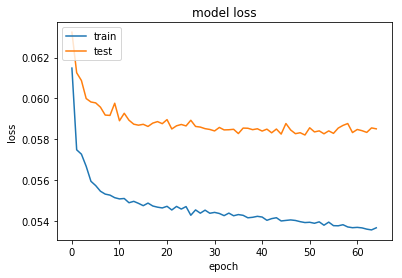

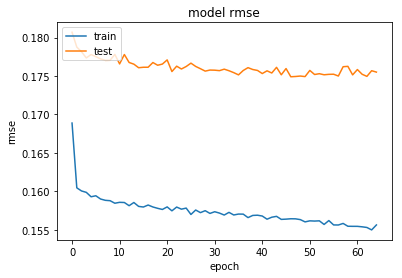

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(6064, 25, 3) (6064, 10, 3)


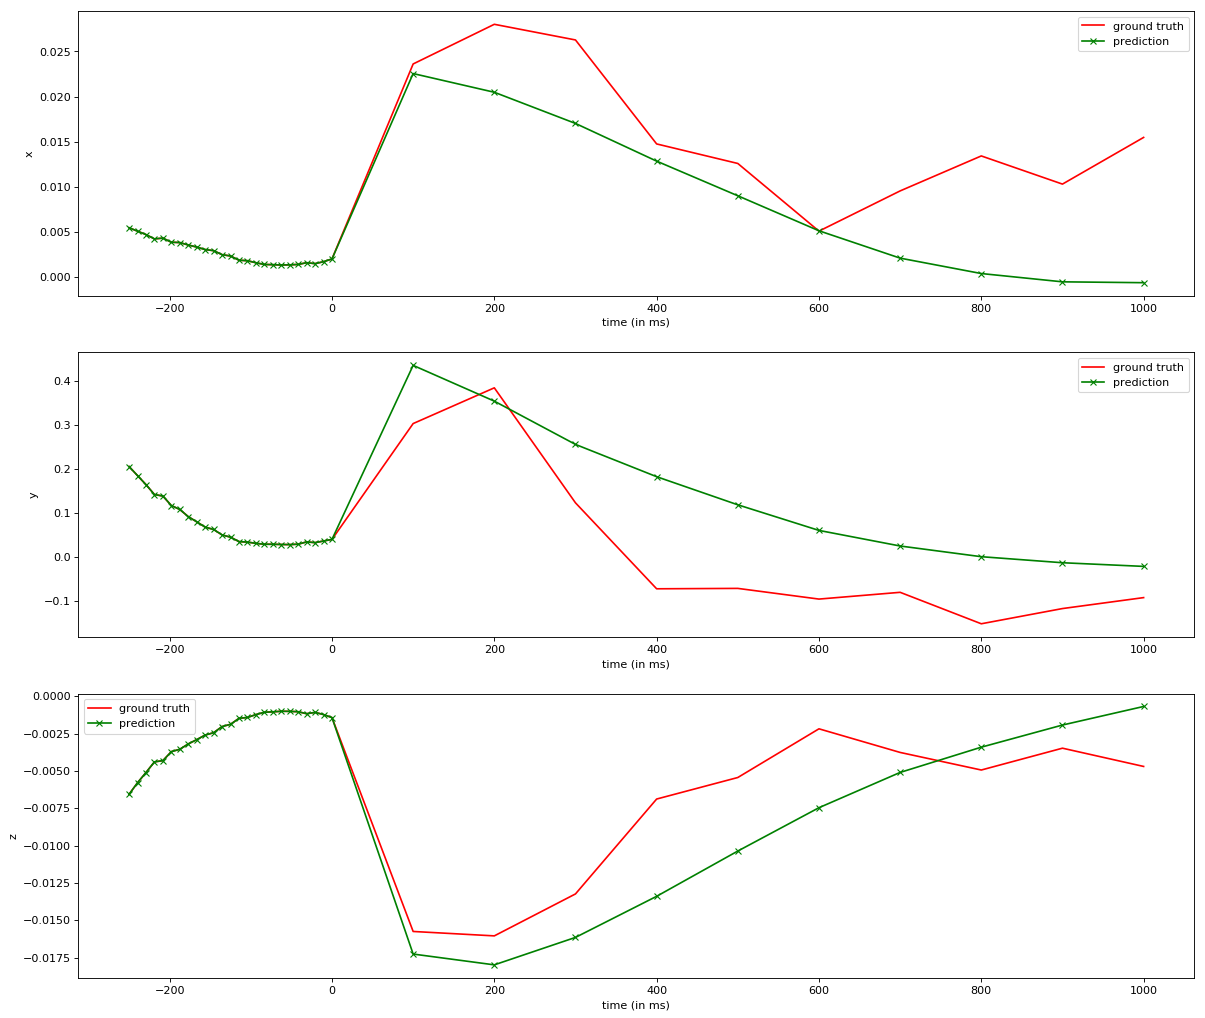

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  101.56309723854065 s =  1.6927182992299399 min =  0.028211971786287097 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05796230955930139
Delay 100 ms: 0.004323330628029592
Delay 200 ms: 0.012700351067797393
Delay 300 ms: 0.02379645401185427
Delay 400 ms: 0.03628370334659433
Delay 500 ms: 0.049494778882965426
Delay 600 ms: 0.06312787249066351
Delay 700 ms: 0.07693133026827126
Delay 800 ms: 0.09073631552987438
Delay 900 ms: 0.10440014423055868
Delay 1000 ms: 0.11782881513640513

RMSE
Average rmse: 0.12162704564047515
Delay 100 ms: 0.011386136491496108
Delay 200 ms: 0.026732336356560936
Delay 300 ms: 0.04684554178104709
Delay 400 ms: 0.06896952747730993
Delay 500 ms: 0.09176111375906726
Delay 600 ms: 0.1146932334531685
Delay 700 ms: 0.1373664552920795
Delay 800 ms: 0.159592342001642
Delay 900 ms: 0.18123656258623377
Delay 1000 ms: 0.20217742224836857

SMAPE
Average smape: 14.350457372510757
Delay 100 ms: 2.225892459912468
Delay 200 ms: 5.311159305249325
Delay 300 ms: 8.381003848553632
Delay 400 ms: 11.255115521528968
Delay 500 ms: 13.890503015521226
Delay 600 ms: 16.322052270705417
Dela